In [1]:
from contextlib import contextmanager
import gc
import os
from pathlib import Path
import pickle
import time

import catboost
import faiss
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images


In [2]:
@contextmanager
def timer(name):
    start_time = time.time()
    yield
    print(f'[{name}] {time.time() - start_time:.3f} s')

In [3]:
dataset = '100'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [4]:
# TUNED
class CFG:
    model_type = 'CatBoost'
    # candidates
    popular_num_items = 60
    popular_weeks = 1
    train_weeks = 6
    item2item_num_items = 24
    item2item_num_items_for_same_product_code = 12
    cooc_weeks = 32
    cooc_threshold = 150
    ohe_distance_num_items = 48
    ohe_distance_num_weeks = 20
    # features
    user_transaction_feature_weeks = 50
    item_transaction_feature_weeks = 16
    item_age_feature_weeks = 40
    user_volume_feature_weeks = 50
    item_volume_feature_weeks = 20
    user_item_volume_feature_weeks = 16
    age_volume_feature_weeks = 1


In [5]:
# age==25でのアイテムボリューム以上になるような幅を各年齢に対して求める
tr = transactions[['user', 'item']].merge(users[['user', 'age']], on='user')
age_volume_threshold = len(tr.query("24 <= age <= 26"))

age_volumes = {age: len(tr.query("age == @age")) for age in range(16, 100)}

age_shifts = {}
for age in range(16, 100):
    for i in range(0, 100):
        low = age - i
        high = age + i
        age_volume = 0
        for j in range(low, high+1):
            age_volume += age_volumes.get(j, 0)
        if age_volume >= age_volume_threshold:
            age_shifts[age] = i
            break
print(age_shifts)

{16: 7, 17: 6, 18: 5, 19: 4, 20: 3, 21: 2, 22: 2, 23: 2, 24: 2, 25: 1, 26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 3, 33: 3, 34: 4, 35: 4, 36: 5, 37: 5, 38: 5, 39: 5, 40: 6, 41: 6, 42: 5, 43: 5, 44: 5, 45: 5, 46: 4, 47: 4, 48: 4, 49: 4, 50: 4, 51: 4, 52: 4, 53: 4, 54: 4, 55: 5, 56: 5, 57: 6, 58: 7, 59: 7, 60: 8, 61: 9, 62: 10, 63: 11, 64: 12, 65: 13, 66: 14, 67: 15, 68: 16, 69: 17, 70: 18, 71: 19, 72: 20, 73: 21, 74: 22, 75: 23, 76: 24, 77: 25, 78: 26, 79: 27, 80: 28, 81: 29, 82: 30, 83: 31, 84: 32, 85: 33, 86: 34, 87: 35, 88: 36, 89: 37, 90: 38, 91: 39, 92: 40, 93: 41, 94: 42, 95: 43, 96: 44, 97: 45, 98: 46, 99: 47}


In [6]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"create candidates (week: {week})")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            max_items_per_user: int=1234567890
        ) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week")[['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

        gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

        candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

        candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
        candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
        # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
        # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
        # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
        candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_popular(
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:num_items]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(num_items),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'pop_rank'})

        candidates['strategy'] = 'pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_age_popular(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            num_weeks: int,
            num_items: int,
        ) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week < @week_start + @num_weeks")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(users[['user', 'age']])

        pops = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            pop = tr.query("@low <= age <= @high")['item'].value_counts().index.values[:num_items]
            pops.append(pd.DataFrame({
                'age': age,
                'item': pop,
                'age_popular_rank': range(num_items),
            }))
        pops = pd.concat(pops)

        candidates = users[['user', 'age']].dropna().query("user in @target_users").reset_index(drop=True)

        candidates = candidates.merge(pops, on='age').drop('age', axis=1)

        candidates['strategy'] = 'age_pop'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_cooc(
            transactions: pd.DataFrame,
            base_candidates: pd.DataFrame,
            week_start: int,
            num_weeks: int,
            pair_count_threshold: int,
        ) -> pd.DataFrame:
        week_end = week_start + num_weeks
        tr = transactions.query("@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_item_count = tr.groupby('item').size().reset_index(name='item_count')
        gr_pair_count = tr.groupby(['item', 'item_with']).size().reset_index(name='pair_count')
        item2item = gr_pair_count.merge(gr_item_count, on='item')
        item2item['ratio'] = item2item['pair_count'] / item2item['item_count']
        item2item = item2item.query("pair_count > @pair_count_threshold").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'pair_count'], axis=1).rename(columns={'item_with': 'item'})
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"cooc_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)
        candidates = candidates.rename(columns={'ratio': 'cooc_ratio', 'item_count': f'cooc_item_count'})

        candidates['strategy'] = 'cooc'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_same_product_code(
            items: pd.DataFrame,
            base_candidates: pd.DataFrame
        ) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

        candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
        candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)
        
        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        base_candidates_replace = {c: f"same_product_code_{c}" for c in base_candidates_columns}
        candidates = candidates.rename(columns=base_candidates_replace)

        candidates['strategy'] = 'same_product_code'
        return candidates.drop_duplicates(ignore_index=True)


    def create_candidates_ohe_distance(
        transactions: pd.DataFrame,
        users: pd.DataFrame,
        items: pd.DataFrame,
        target_users: np.ndarray,
        week_start: int,
        num_weeks: int,
        num_items: int,
    ) -> pd.DataFrame:
        users_with_ohe = users[['user']].query("user in @target_users")
        cols = [c for c in items.columns if c.endswith('_idx')]
        for c in cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            cs = [c for c in tmp.columns if c.endswith('_mean')]
            users_with_ohe = users_with_ohe.merge(tmp[['user'] + cs], on='user')

        users_with_ohe = users_with_ohe.dropna().reset_index(drop=True)
        limited_users = users_with_ohe['user'].values

        recent_items = transactions.query("@week <= week < @week + @num_weeks")['item'].unique()
        items_with_ohe = pd.get_dummies(items[['item'] + cols], columns=cols)
        items_with_ohe = items_with_ohe.query("item in @recent_items").reset_index(drop=True)
        limited_items = items_with_ohe['item'].values

        item_cols = [c for c in items_with_ohe.columns if c != 'item']
        user_cols = [f'user_ohe_agg_{c}_mean' for c in item_cols]
        users_with_ohe = users_with_ohe[['user'] + user_cols]
        items_with_ohe = items_with_ohe[['item'] + item_cols]

        a_users = users_with_ohe.drop('user', axis=1).values.astype(np.float32)
        a_items = items_with_ohe.drop('item', axis=1).values.astype(np.float32)
        a_users = np.ascontiguousarray(a_users)
        a_items = np.ascontiguousarray(a_items)
        index = faiss.index_factory(a_items.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)
        index = faiss.index_cpu_to_gpu(faiss.StandardGpuResources(), 0, index)
        index.add(a_items)
        distances, idxs = index.search(a_users, num_items)
        return pd.DataFrame({
            'user': np.repeat(limited_users, num_items),
            'item': limited_items[idxs.flatten()],
            'ohe_distance': distances.flatten(),
            'strategy': 'ohe_distance',
        })


    with timer("repurchase"):
        candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week)
    with timer("popular"):
        candidates_popular = create_candidates_popular(transactions, target_users, week, CFG.popular_weeks, CFG.popular_num_items)
    with timer("age popular"):
        candidates_age_popular = create_candidates_age_popular(transactions, users, target_users, week, 1, 12)
    with timer("item2item"):
        candidates_item2item = create_candidates_repurchase('item2item', transactions, target_users, week, CFG.item2item_num_items)
    with timer("item2item2"):
        candidates_item2item2 = create_candidates_repurchase('item2item2', transactions, target_users, week, CFG.item2item_num_items_for_same_product_code) 
    with timer("cooccurrence"):
        candidates_cooc = create_candidates_cooc(transactions, candidates_item2item, week, CFG.cooc_weeks, CFG.cooc_threshold)
    with timer("same_product_code"):
        candidates_same_product_code = create_candidates_same_product_code(items, candidates_item2item2)
    with timer("ohe distance"):
        candidates_ohe_distance = create_candidates_ohe_distance(transactions, users, items, target_users, week, CFG.ohe_distance_num_weeks, CFG.ohe_distance_num_items)

    def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
        """
        candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
        """
        tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
        tmp['flag'] = 1
        candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
        return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)


    candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
    candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)
    candidates_ohe_distance = drop_common_user_item(candidates_ohe_distance, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_age_popular,
        candidates_cooc,
        candidates_same_product_code,
        candidates_ohe_distance,
    ]
    candidates = pd.concat(candidates)

    print(f"volume: {len(candidates)}")
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
    return candidates.drop(meta_columns, axis=1)


In [7]:
# valid: week=0
# train: week=1..CFG.train_weeks
candidates = []
for week in range(1+CFG.train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

create candidates (week: 1)


[repurchase] 8.951 s


[popular] 0.682 s


[age popular] 0.569 s


[item2item] 8.041 s


[item2item2] 7.734 s


[cooccurrence] 58.796 s


[same_product_code] 2.796 s


[ohe distance] 12.308 s


volume: 16808210


duplicates: 1.0996503838489493


            strategy   volume     ratio
0  same_product_code  4186861  0.249096
1                pop  4139040  0.246251
2         repurchase  3446562  0.205052
3       ohe_distance  2982578  0.177448
4               cooc  1228865  0.073111
5            age_pop   824304  0.049042


create candidates (week: 2)


[repurchase] 9.003 s


[popular] 0.704 s


[age popular] 0.588 s


[item2item] 8.267 s


[item2item2] 8.073 s


[cooccurrence] 58.375 s


[same_product_code] 2.922 s


[ohe distance] 11.802 s


volume: 17652718


duplicates: 1.0985360169744667


            strategy   volume     ratio
0  same_product_code  4398614  0.249175
1                pop  4321140  0.244786
2         repurchase  3637145  0.206039
3       ohe_distance  3132450  0.177449
4               cooc  1302993  0.073813
5            age_pop   860376  0.048739


create candidates (week: 3)


[repurchase] 9.022 s


[popular] 0.762 s


[age popular] 0.627 s


[item2item] 8.395 s


[item2item2] 8.223 s


[cooccurrence] 59.315 s


[same_product_code] 3.106 s


[ohe distance] 12.214 s


volume: 18592448


duplicates: 1.10202043869101


            strategy   volume     ratio
0  same_product_code  4679508  0.251689
1                pop  4549320  0.244686
2         repurchase  3742824  0.201309
3       ohe_distance  3296444  0.177300
4               cooc  1418580  0.076299
5            age_pop   905772  0.048717


create candidates (week: 4)


[repurchase] 9.262 s


[popular] 0.779 s


[age popular] 0.593 s


[item2item] 8.701 s


[item2item2] 8.601 s


[cooccurrence] 58.470 s


[same_product_code] 3.311 s


[ohe distance] 12.973 s


volume: 19696382


duplicates: 1.102336184300588


            strategy   volume     ratio
0  same_product_code  4998786  0.253792
1                pop  4815180  0.244470
2         repurchase  3915353  0.198785
3       ohe_distance  3495473  0.177468
4               cooc  1512886  0.076810
5            age_pop   958704  0.048674


create candidates (week: 5)


[repurchase] 8.530 s


[popular] 0.720 s


[age popular] 0.607 s


[item2item] 8.038 s


[item2item2] 7.966 s


[cooccurrence] 57.580 s


[same_product_code] 2.974 s


[ohe distance] 16.606 s


volume: 17719452


duplicates: 1.1031077161347131


            strategy   volume     ratio
0  same_product_code  4486085  0.253173
1                pop  4322100  0.243918
2         repurchase  3548895  0.200282
3       ohe_distance  3154696  0.178036
4               cooc  1347096  0.076024
5            age_pop   860580  0.048567


create candidates (week: 6)


[repurchase] 8.476 s


[popular] 0.716 s


[age popular] 0.625 s


[item2item] 7.940 s


[item2item2] 7.901 s


[cooccurrence] 57.294 s


[same_product_code] 2.937 s


[ohe distance] 16.546 s


volume: 17579037


duplicates: 1.0955613685395498


            strategy   volume     ratio
0  same_product_code  4473501  0.254479
1                pop  4265640  0.242655
2         repurchase  3547521  0.201804
3       ohe_distance  3132237  0.178180
4               cooc  1310406  0.074544
5            age_pop   849732  0.048338


create candidates (week: 7)


[repurchase] 8.507 s


[popular] 0.758 s


[age popular] 0.658 s


[item2item] 8.087 s


[item2item2] 7.932 s


[cooccurrence] 56.511 s


[same_product_code] 3.129 s


[ohe distance] 15.260 s


volume: 18200547


duplicates: 1.0971032582444982


            strategy   volume     ratio
0  same_product_code  4674139  0.256813
1                pop  4489980  0.246695
2         repurchase  3571089  0.196208
3       ohe_distance  3269945  0.179662
4               cooc  1301286  0.071497
5            age_pop   894108  0.049125


In [8]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"merge labels (week: {week})")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [9]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], idx)


merge labels (week: 0)


Recall: 0.15260050157209162


            strategy        y   volume    recall  hit_ratio
0                pop  16630.0  4139040  0.077809   0.004018
1         repurchase   8437.0  3446562  0.039475   0.002448
2  same_product_code   6328.0  4186861  0.029608   0.001511
3            age_pop   5301.0   824304  0.024803   0.006431
4               cooc   3321.0  1228865  0.015538   0.002702
5       ohe_distance   2268.0  2982578  0.010612   0.000760
merge labels (week: 1)


Recall: 0.14143740950375147


            strategy        y   volume    recall  hit_ratio
0                pop  14822.0  4321140  0.065034   0.003430
1         repurchase   8955.0  3637145  0.039292   0.002462
2  same_product_code   7005.0  4398614  0.030736   0.001593
3            age_pop   4816.0   860376  0.021131   0.005598
4               cooc   3651.0  1302993  0.016019   0.002802
5       ohe_distance   2349.0  3132450  0.010307   0.000750
merge labels (week: 2)


Recall: 0.14407705167300924


            strategy        y   volume    recall  hit_ratio
0                pop  16898.0  4549320  0.070978   0.003714
1         repurchase   9195.0  3742824  0.038622   0.002457
2  same_product_code   6935.0  4679508  0.029130   0.001482
3            age_pop   5809.0   905772  0.024400   0.006413
4               cooc   3965.0  1418580  0.016654   0.002795
5       ohe_distance   2347.0  3296444  0.009858   0.000712
merge labels (week: 3)


Recall: 0.14173968930760428


            strategy        y   volume    recall  hit_ratio
0                pop  18262.0  4815180  0.071567   0.003793
1         repurchase   9002.0  3915353  0.035278   0.002299
2  same_product_code   7336.0  4998786  0.028749   0.001468
3            age_pop   6073.0   958704  0.023800   0.006335
4               cooc   4429.0  1512886  0.017357   0.002928
5       ohe_distance   2509.0  3495473  0.009833   0.000718
merge labels (week: 4)


Recall: 0.1372988194519658


            strategy        y   volume    recall  hit_ratio
0                pop  13948.0  4322100  0.060427   0.003227
1         repurchase   8945.0  3548895  0.038752   0.002521
2  same_product_code   7392.0  4486085  0.032024   0.001648
3            age_pop   4770.0   860580  0.020665   0.005543
4               cooc   4576.0  1347096  0.019825   0.003397
5       ohe_distance   2119.0  3154696  0.009180   0.000672
merge labels (week: 5)


Recall: 0.12906476640242873


            strategy        y   volume    recall  hit_ratio
0                pop  11255.0  4265640  0.047457   0.002639
1         repurchase   9673.0  3547521  0.040787   0.002727
2  same_product_code   7454.0  4473501  0.031430   0.001666
3               cooc   4654.0  1310406  0.019624   0.003552
4            age_pop   3433.0   849732  0.014475   0.004040
5       ohe_distance   1803.0  3132237  0.007602   0.000576
merge labels (week: 6)


Recall: 0.11564397792780295


            strategy        y   volume    recall  hit_ratio
0                pop  11008.0  4489980  0.042418   0.002452
1         repurchase   9107.0  3571089  0.035093   0.002550
2  same_product_code   7871.0  4674139  0.030330   0.001684
3               cooc   4830.0  1301286  0.018612   0.003712
4            age_pop   3051.0   894108  0.011757   0.003412
5       ohe_distance   1760.0  3269945  0.006782   0.000538


In [10]:
def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


for idx in range(len(candidates)):
    candidates[idx]['week'] = idx

candidates_valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 16808210 -> 5982900


drop trivial queries: 17652718 -> 6133505


drop trivial queries: 18592448 -> 6583470


drop trivial queries: 19696382 -> 6949344


drop trivial queries: 17719452 -> 6015837


drop trivial queries: 17579037 -> 5621643


drop trivial queries: 18200547 -> 5699845


In [11]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int, pretrain_week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"attach features (week: {week})")
    n_original = len(candidates)
    df = candidates.copy()
    with timer("user static fetaures"):
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

    with timer("item stacic features"):
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

    with timer("user dynamic features (transactions)"):
        week_end = week + CFG.user_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

    with timer("item dynamic features (transactions)"):
        week_end = week + CFG.item_transaction_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item dynamic features (user features)"):
        week_end = week + CFG.item_age_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

    with timer("item freshness features"):
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

    with timer("item volume features"):
        week_end = week + CFG.item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

    with timer("user freshness features"):
        tmp = transactions.query("@week <= week").groupby('user')['day'].min().reset_index(name='user_day_min')
        tmp['user_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='user', how='left')

    with timer("user volume features"):
        week_end = week + CFG.user_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
        df = df.merge(tmp, on='user', how='left')

    with timer("user-item freshness features"):
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

    with timer("user-item volume features"):
        week_end = week + CFG.user_item_volume_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

    with timer("item age volume features"):
        week_end = week + CFG.age_volume_feature_weeks
        tr = transactions.query("@week <= week < @week_end")[['user', 'item']].merge(users[['user', 'age']], on='user')
        item_age_volumes = []
        for age in range(16, 100):
            low = age - age_shifts[age]
            high = age + age_shifts[age]
            tmp = tr.query("@low <= age <= @high").groupby('item').size().reset_index(name='age_volume')
            tmp['age_volume'] = tmp['age_volume'].rank(ascending=False)
            tmp['age'] = age
            item_age_volumes.append(tmp)
        item_age_volumes = pd.concat(item_age_volumes)
        df = df.merge(item_age_volumes, on=['item', 'age'], how='left')

    with timer("ohe dot products"):
        item_target_cols = [c for c in items.columns if c.endswith('_idx')]

        items_with_ohe = pd.get_dummies(items[['item'] + item_target_cols], columns=item_target_cols)

        users_with_ohe = users[['user']]
        for c in item_target_cols:
            tmp = pd.read_pickle(f"artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}_{c}.pkl")
            assert tmp['user'].tolist() == users_with_ohe['user'].tolist()
            tmp = tmp[['user'] + [c for c in tmp.columns if c.endswith('_mean')]]
            tmp = tmp.drop('user', axis=1)
            users_with_ohe = pd.concat([users_with_ohe, tmp], axis=1)

        assert items_with_ohe['item'].tolist() == items['item'].tolist()
        assert users_with_ohe['user'].tolist() == users['user'].tolist()

        users_items = df[['user', 'item']].drop_duplicates().reset_index(drop=True)
        n_split = 10
        n_chunk = (len(users_items) + n_split - 1)// n_split
        ohe = []
        for i in range(0, len(users_items), n_chunk):
            users_items_small = users_items.iloc[i:i+n_chunk].reset_index(drop=True)
            users_small = users_items_small['user'].values
            items_small = users_items_small['item'].values

            for item_col in item_target_cols:
                i_cols = [c for c in items_with_ohe.columns if c.startswith(item_col)]
                u_cols = [f"user_ohe_agg_{c}_mean" for c in i_cols]
                users_items_small[f'{item_col}_ohe_score'] = (items_with_ohe[i_cols].values[items_small] * users_with_ohe[u_cols].values[users_small]).sum(axis=1)

            ohe_cols = [f'{col}_ohe_score' for col in item_target_cols]
            users_items_small = users_items_small[['user', 'item'] + ohe_cols]

            ohe.append(users_items_small)
        ohe = pd.concat(ohe)
        df = df.merge(ohe, on=['user', 'item'])

    with timer("lfm features"):
        seen_users = transactions.query("week >= @pretrain_week")['user'].unique()
        user_reps, _ = calc_embeddings('i_i', dataset, pretrain_week, 16)
        user_reps = user_reps.query("user in @seen_users")
        df = df.merge(user_reps, on='user', how='left')

    assert len(df) == n_original
    return df


dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks+1)
# pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks+1) for idx in range(len(candidates))]

attach features (week: 1)


[user static fetaures] 1.629 s


[item stacic features] 4.690 s


[user dynamic features (transactions)] 5.012 s


[item dynamic features (transactions)] 2.797 s


[item dynamic features (user features)] 5.731 s


[item freshness features] 4.585 s


[item volume features] 3.172 s


[user freshness features] 6.078 s


[user volume features] 4.429 s


[user-item freshness features] 23.822 s


[user-item volume features] 8.398 s


[item age volume features] 5.063 s


[ohe dot products] 123.019 s


[lfm features] 6.461 s
attach features (week: 1)


[user static fetaures] 0.624 s


[item stacic features] 1.542 s


[user dynamic features (transactions)] 3.289 s


[item dynamic features (transactions)] 1.334 s


[item dynamic features (user features)] 4.145 s


[item freshness features] 2.887 s


[item volume features] 1.430 s


[user freshness features] 4.049 s


[user volume features] 2.361 s


[user-item freshness features] 20.570 s


[user-item volume features] 4.484 s


[item age volume features] 2.281 s


[ohe dot products] 57.763 s


[lfm features] 3.455 s
attach features (week: 2)


[user static fetaures] 0.628 s


[item stacic features] 1.564 s


[user dynamic features (transactions)] 3.275 s


[item dynamic features (transactions)] 1.347 s


[item dynamic features (user features)] 4.064 s


[item freshness features] 2.864 s


[item volume features] 1.437 s


[user freshness features] 4.007 s


[user volume features] 2.327 s


[user-item freshness features] 20.452 s


[user-item volume features] 4.581 s


[item age volume features] 2.345 s


[ohe dot products] 60.550 s


[lfm features] 3.382 s
attach features (week: 3)


[user static fetaures] 0.654 s


[item stacic features] 1.678 s


[user dynamic features (transactions)] 3.355 s


[item dynamic features (transactions)] 1.423 s


[item dynamic features (user features)] 4.207 s


[item freshness features] 2.977 s


[item volume features] 1.501 s


[user freshness features] 4.138 s


[user volume features] 2.444 s


[user-item freshness features] 20.748 s


[user-item volume features] 4.735 s


[item age volume features] 2.542 s


[ohe dot products] 64.885 s


[lfm features] 3.600 s
attach features (week: 4)


[user static fetaures] 0.705 s


[item stacic features] 1.838 s


[user dynamic features (transactions)] 3.438 s


[item dynamic features (transactions)] 1.540 s


[item dynamic features (user features)] 4.298 s


[item freshness features] 3.079 s


[item volume features] 1.621 s


[user freshness features] 4.283 s


[user volume features] 2.509 s


[user-item freshness features] 20.881 s


[user-item volume features] 4.799 s


[item age volume features] 2.582 s


[ohe dot products] 66.952 s


[lfm features] 3.720 s
attach features (week: 5)


[user static fetaures] 0.640 s


[item stacic features] 1.576 s


[user dynamic features (transactions)] 3.304 s


[item dynamic features (transactions)] 1.440 s


[item dynamic features (user features)] 4.205 s


[item freshness features] 2.933 s


[item volume features] 1.524 s


[user freshness features] 4.067 s


[user volume features] 2.432 s


[user-item freshness features] 21.214 s


[user-item volume features] 4.704 s


[item age volume features] 2.449 s


[ohe dot products] 88.989 s


[lfm features] 3.555 s
attach features (week: 6)


[user static fetaures] 0.583 s


[item stacic features] 1.431 s


[user dynamic features (transactions)] 3.280 s


[item dynamic features (transactions)] 1.317 s


[item dynamic features (user features)] 4.109 s


[item freshness features] 2.804 s


[item volume features] 1.430 s


[user freshness features] 3.937 s


[user volume features] 2.301 s


[user-item freshness features] 20.348 s


[user-item volume features] 4.506 s


[item age volume features] 2.337 s


[ohe dot products] 86.326 s


[lfm features] 3.556 s
attach features (week: 7)


[user static fetaures] 0.587 s


[item stacic features] 1.458 s


[user dynamic features (transactions)] 3.262 s


[item dynamic features (transactions)] 1.323 s


[item dynamic features (user features)] 4.127 s


[item freshness features] 2.780 s


[item volume features] 1.432 s


[user freshness features] 3.894 s


[user volume features] 2.331 s


[user-item freshness features] 19.068 s


[user-item volume features] 4.504 s


[item age volume features] 2.419 s


[ohe dot products] 82.542 s


[lfm features] 3.461 s


In [12]:
for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

In [13]:
def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx] for idx in range(begin, begin+num)])
    return train

valid = datasets[0]
train = concat_train(datasets, 1, CFG.train_weeks)

In [14]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'age_popular_rank', 'cooc_item2item_week_rank', 'cooc_item2item_volume_rank', 'cooc_item_count', 'cooc_ratio', 'same_product_code_item2item2_week_rank', 'same_product_code_item2item2_volume_rank', 'ohe_distance', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_day_min', 'item_volume', 'user_day_min', 'user_volume', 'user_item_day_min', 'user_item_volume', 'age_volume', 'product_type_no_idx_o

In [15]:

cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
cat_features = [feature_columns.index(c) for c in cat_feature_values]
print(cat_feature_values, cat_features)


['club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx'] [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


In [16]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

0:	test: 0.1084539	best: 0.1084539 (0)	total: 6.15s	remaining: 8h 32m 5s


1:	test: 0.1398049	best: 0.1398049 (1)	total: 11.7s	remaining: 8h 7m 31s


2:	test: 0.1607005	best: 0.1607005 (2)	total: 17.2s	remaining: 7h 57m 49s


3:	test: 0.1508178	best: 0.1607005 (2)	total: 23.3s	remaining: 8h 4m 20s


4:	test: 0.1516202	best: 0.1607005 (2)	total: 28.9s	remaining: 8h 31s


5:	test: 0.1641848	best: 0.1641848 (5)	total: 34.5s	remaining: 7h 58m 2s


6:	test: 0.1710493	best: 0.1710493 (6)	total: 40s	remaining: 7h 55m 37s


7:	test: 0.1715793	best: 0.1715793 (7)	total: 45.6s	remaining: 7h 54m 9s


8:	test: 0.1705269	best: 0.1715793 (7)	total: 51.1s	remaining: 7h 52m 45s


9:	test: 0.1884218	best: 0.1884218 (9)	total: 56.9s	remaining: 7h 52m 51s


10:	test: 0.1921579	best: 0.1921579 (10)	total: 1m 2s	remaining: 7h 53m 47s


11:	test: 0.1925322	best: 0.1925322 (11)	total: 1m 8s	remaining: 7h 52m 49s


12:	test: 0.1926548	best: 0.1926548 (12)	total: 1m 13s	remaining: 7h 52m 12s


13:	test: 0.1967389	best: 0.1967389 (13)	total: 1m 19s	remaining: 7h 51m 38s


14:	test: 0.1969185	best: 0.1969185 (14)	total: 1m 25s	remaining: 7h 51m 42s


15:	test: 0.1974791	best: 0.1974791 (15)	total: 1m 30s	remaining: 7h 50m 42s


16:	test: 0.1981595	best: 0.1981595 (16)	total: 1m 36s	remaining: 7h 49m 48s


17:	test: 0.2028853	best: 0.2028853 (17)	total: 1m 41s	remaining: 7h 49m 39s


18:	test: 0.2060758	best: 0.2060758 (18)	total: 1m 47s	remaining: 7h 48m 40s


19:	test: 0.2066611	best: 0.2066611 (19)	total: 1m 52s	remaining: 7h 48m 1s


20:	test: 0.2121120	best: 0.2121120 (20)	total: 1m 58s	remaining: 7h 47m 5s


21:	test: 0.2125344	best: 0.2125344 (21)	total: 2m 3s	remaining: 7h 46m 32s


22:	test: 0.2141489	best: 0.2141489 (22)	total: 2m 9s	remaining: 7h 45m 53s


23:	test: 0.2161411	best: 0.2161411 (23)	total: 2m 14s	remaining: 7h 45m 14s


24:	test: 0.2177969	best: 0.2177969 (24)	total: 2m 20s	remaining: 7h 44m 51s


25:	test: 0.2175265	best: 0.2177969 (24)	total: 2m 25s	remaining: 7h 44m 42s


26:	test: 0.2223480	best: 0.2223480 (26)	total: 2m 31s	remaining: 7h 44m 38s


27:	test: 0.2235655	best: 0.2235655 (27)	total: 2m 36s	remaining: 7h 44m 16s


28:	test: 0.2255376	best: 0.2255376 (28)	total: 2m 42s	remaining: 7h 44m 20s


29:	test: 0.2255120	best: 0.2255376 (28)	total: 2m 48s	remaining: 7h 44m 2s


30:	test: 0.2283763	best: 0.2283763 (30)	total: 2m 53s	remaining: 7h 43m 28s


31:	test: 0.2295592	best: 0.2295592 (31)	total: 2m 59s	remaining: 7h 43m 40s


32:	test: 0.2290613	best: 0.2295592 (31)	total: 3m 4s	remaining: 7h 43m 52s


33:	test: 0.2291372	best: 0.2295592 (31)	total: 3m 10s	remaining: 7h 43m 34s


34:	test: 0.2292885	best: 0.2295592 (31)	total: 3m 15s	remaining: 7h 43m 18s


35:	test: 0.2303894	best: 0.2303894 (35)	total: 3m 21s	remaining: 7h 43m 2s


36:	test: 0.2320235	best: 0.2320235 (36)	total: 3m 27s	remaining: 7h 43m 10s


37:	test: 0.2325142	best: 0.2325142 (37)	total: 3m 32s	remaining: 7h 42m 55s


38:	test: 0.2329154	best: 0.2329154 (38)	total: 3m 38s	remaining: 7h 42m 57s


39:	test: 0.2363981	best: 0.2363981 (39)	total: 3m 44s	remaining: 7h 43m 1s


40:	test: 0.2371103	best: 0.2371103 (40)	total: 3m 49s	remaining: 7h 43m 14s


41:	test: 0.2376829	best: 0.2376829 (41)	total: 3m 55s	remaining: 7h 42m 32s


42:	test: 0.2383694	best: 0.2383694 (42)	total: 4m	remaining: 7h 42m 20s


43:	test: 0.2383524	best: 0.2383694 (42)	total: 4m 6s	remaining: 7h 42m 18s


44:	test: 0.2380468	best: 0.2383694 (42)	total: 4m 11s	remaining: 7h 42m 13s


45:	test: 0.2381224	best: 0.2383694 (42)	total: 4m 17s	remaining: 7h 41m 33s


46:	test: 0.2383346	best: 0.2383694 (42)	total: 4m 22s	remaining: 7h 41m 32s


47:	test: 0.2409932	best: 0.2409932 (47)	total: 4m 28s	remaining: 7h 41m 45s


48:	test: 0.2405966	best: 0.2409932 (47)	total: 4m 34s	remaining: 7h 41m 28s


49:	test: 0.2407738	best: 0.2409932 (47)	total: 4m 39s	remaining: 7h 41m 17s


50:	test: 0.2408188	best: 0.2409932 (47)	total: 4m 44s	remaining: 7h 40m 38s


51:	test: 0.2414278	best: 0.2414278 (51)	total: 4m 50s	remaining: 7h 40m 51s


52:	test: 0.2417739	best: 0.2417739 (52)	total: 4m 55s	remaining: 7h 40m 12s


53:	test: 0.2417321	best: 0.2417739 (52)	total: 5m 1s	remaining: 7h 40m 11s


54:	test: 0.2418170	best: 0.2418170 (54)	total: 5m 6s	remaining: 7h 39m 39s


55:	test: 0.2449741	best: 0.2449741 (55)	total: 5m 12s	remaining: 7h 39m 24s


56:	test: 0.2453435	best: 0.2453435 (56)	total: 5m 17s	remaining: 7h 38m 50s


57:	test: 0.2454972	best: 0.2454972 (57)	total: 5m 22s	remaining: 7h 38m 38s


58:	test: 0.2457385	best: 0.2457385 (58)	total: 5m 28s	remaining: 7h 38m 7s


59:	test: 0.2461329	best: 0.2461329 (59)	total: 5m 33s	remaining: 7h 37m 37s


60:	test: 0.2464625	best: 0.2464625 (60)	total: 5m 39s	remaining: 7h 37m 37s


61:	test: 0.2466393	best: 0.2466393 (61)	total: 5m 44s	remaining: 7h 37m 20s


62:	test: 0.2467597	best: 0.2467597 (62)	total: 5m 50s	remaining: 7h 37m 57s


63:	test: 0.2470264	best: 0.2470264 (63)	total: 5m 56s	remaining: 7h 38m 7s


64:	test: 0.2469171	best: 0.2470264 (63)	total: 6m 1s	remaining: 7h 37m 37s


65:	test: 0.2469738	best: 0.2470264 (63)	total: 6m 7s	remaining: 7h 37m 33s


66:	test: 0.2484167	best: 0.2484167 (66)	total: 6m 12s	remaining: 7h 37m 21s


67:	test: 0.2483212	best: 0.2484167 (66)	total: 6m 18s	remaining: 7h 37m


68:	test: 0.2484118	best: 0.2484167 (66)	total: 6m 23s	remaining: 7h 36m 54s


69:	test: 0.2485707	best: 0.2485707 (69)	total: 6m 29s	remaining: 7h 36m 45s


70:	test: 0.2486249	best: 0.2486249 (70)	total: 6m 34s	remaining: 7h 36m 36s


71:	test: 0.2488221	best: 0.2488221 (71)	total: 6m 39s	remaining: 7h 36m 11s


72:	test: 0.2488461	best: 0.2488461 (72)	total: 6m 45s	remaining: 7h 36m 10s


73:	test: 0.2488132	best: 0.2488461 (72)	total: 6m 51s	remaining: 7h 36m 13s


74:	test: 0.2488895	best: 0.2488895 (74)	total: 6m 56s	remaining: 7h 36m 7s


75:	test: 0.2491292	best: 0.2491292 (75)	total: 7m 1s	remaining: 7h 35m 35s


76:	test: 0.2491035	best: 0.2491292 (75)	total: 7m 7s	remaining: 7h 35m 22s


77:	test: 0.2493775	best: 0.2493775 (77)	total: 7m 12s	remaining: 7h 35m 21s


78:	test: 0.2493961	best: 0.2493961 (78)	total: 7m 18s	remaining: 7h 35m


79:	test: 0.2494210	best: 0.2494210 (79)	total: 7m 23s	remaining: 7h 35m 3s


80:	test: 0.2493906	best: 0.2494210 (79)	total: 7m 29s	remaining: 7h 34m 52s


81:	test: 0.2493498	best: 0.2494210 (79)	total: 7m 35s	remaining: 7h 34m 56s


82:	test: 0.2492664	best: 0.2494210 (79)	total: 7m 40s	remaining: 7h 34m 58s


83:	test: 0.2492524	best: 0.2494210 (79)	total: 7m 46s	remaining: 7h 35m 5s


84:	test: 0.2493679	best: 0.2494210 (79)	total: 7m 52s	remaining: 7h 35m 6s


85:	test: 0.2495977	best: 0.2495977 (85)	total: 7m 57s	remaining: 7h 34m 41s


86:	test: 0.2499674	best: 0.2499674 (86)	total: 8m 2s	remaining: 7h 34m 30s


87:	test: 0.2498827	best: 0.2499674 (86)	total: 8m 8s	remaining: 7h 34m 16s


88:	test: 0.2501668	best: 0.2501668 (88)	total: 8m 13s	remaining: 7h 34m 8s


89:	test: 0.2504084	best: 0.2504084 (89)	total: 8m 19s	remaining: 7h 33m 53s


90:	test: 0.2504202	best: 0.2504202 (90)	total: 8m 24s	remaining: 7h 33m 35s


91:	test: 0.2505854	best: 0.2505854 (91)	total: 8m 30s	remaining: 7h 33m 28s


92:	test: 0.2506485	best: 0.2506485 (92)	total: 8m 35s	remaining: 7h 33m 16s


93:	test: 0.2511070	best: 0.2511070 (93)	total: 8m 41s	remaining: 7h 33m 15s


94:	test: 0.2510699	best: 0.2511070 (93)	total: 8m 46s	remaining: 7h 33m 6s


95:	test: 0.2510803	best: 0.2511070 (93)	total: 8m 52s	remaining: 7h 33m 5s


96:	test: 0.2511225	best: 0.2511225 (96)	total: 8m 57s	remaining: 7h 32m 54s


97:	test: 0.2515700	best: 0.2515700 (97)	total: 9m 2s	remaining: 7h 32m 33s


98:	test: 0.2515505	best: 0.2515700 (97)	total: 9m 8s	remaining: 7h 32m 32s


99:	test: 0.2516850	best: 0.2516850 (99)	total: 9m 14s	remaining: 7h 32m 35s


100:	test: 0.2524456	best: 0.2524456 (100)	total: 9m 19s	remaining: 7h 32m 40s


101:	test: 0.2528605	best: 0.2528605 (101)	total: 9m 25s	remaining: 7h 32m 27s


102:	test: 0.2531740	best: 0.2531740 (102)	total: 9m 30s	remaining: 7h 32m 18s


103:	test: 0.2531845	best: 0.2531845 (103)	total: 9m 36s	remaining: 7h 32m 13s


104:	test: 0.2538272	best: 0.2538272 (104)	total: 9m 42s	remaining: 7h 32m 23s


105:	test: 0.2537809	best: 0.2538272 (104)	total: 9m 47s	remaining: 7h 32m 16s


106:	test: 0.2537453	best: 0.2538272 (104)	total: 9m 53s	remaining: 7h 32m 16s


107:	test: 0.2539345	best: 0.2539345 (107)	total: 9m 58s	remaining: 7h 31m 52s


108:	test: 0.2542013	best: 0.2542013 (108)	total: 10m 4s	remaining: 7h 31m 48s


109:	test: 0.2543893	best: 0.2543893 (109)	total: 10m 9s	remaining: 7h 31m 43s


110:	test: 0.2542043	best: 0.2543893 (109)	total: 10m 15s	remaining: 7h 31m 40s


111:	test: 0.2544169	best: 0.2544169 (111)	total: 10m 20s	remaining: 7h 31m 22s


112:	test: 0.2545511	best: 0.2545511 (112)	total: 10m 25s	remaining: 7h 31m 7s


113:	test: 0.2547128	best: 0.2547128 (113)	total: 10m 31s	remaining: 7h 30m 47s


114:	test: 0.2549698	best: 0.2549698 (114)	total: 10m 36s	remaining: 7h 30m 33s


115:	test: 0.2554003	best: 0.2554003 (115)	total: 10m 42s	remaining: 7h 30m 32s


116:	test: 0.2556397	best: 0.2556397 (116)	total: 10m 47s	remaining: 7h 30m 25s


117:	test: 0.2557229	best: 0.2557229 (117)	total: 10m 53s	remaining: 7h 30m 17s


118:	test: 0.2560890	best: 0.2560890 (118)	total: 10m 58s	remaining: 7h 30m 13s


119:	test: 0.2560526	best: 0.2560890 (118)	total: 11m 4s	remaining: 7h 30m 7s


120:	test: 0.2564473	best: 0.2564473 (120)	total: 11m 9s	remaining: 7h 29m 52s


121:	test: 0.2565827	best: 0.2565827 (121)	total: 11m 14s	remaining: 7h 29m 34s


122:	test: 0.2565819	best: 0.2565827 (121)	total: 11m 20s	remaining: 7h 29m 23s


123:	test: 0.2568845	best: 0.2568845 (123)	total: 11m 25s	remaining: 7h 29m 16s


124:	test: 0.2571091	best: 0.2571091 (124)	total: 11m 30s	remaining: 7h 28m 57s


125:	test: 0.2574273	best: 0.2574273 (125)	total: 11m 36s	remaining: 7h 28m 57s


126:	test: 0.2574999	best: 0.2574999 (126)	total: 11m 41s	remaining: 7h 28m 44s


127:	test: 0.2576988	best: 0.2576988 (127)	total: 11m 47s	remaining: 7h 28m 35s


128:	test: 0.2581242	best: 0.2581242 (128)	total: 11m 52s	remaining: 7h 28m 39s


129:	test: 0.2581436	best: 0.2581436 (129)	total: 11m 58s	remaining: 7h 28m 35s


130:	test: 0.2586031	best: 0.2586031 (130)	total: 12m 3s	remaining: 7h 28m 29s


131:	test: 0.2587010	best: 0.2587010 (131)	total: 12m 9s	remaining: 7h 28m 23s


132:	test: 0.2588403	best: 0.2588403 (132)	total: 12m 14s	remaining: 7h 28m 5s


133:	test: 0.2589547	best: 0.2589547 (133)	total: 12m 20s	remaining: 7h 28m 9s


134:	test: 0.2586705	best: 0.2589547 (133)	total: 12m 25s	remaining: 7h 27m 59s


135:	test: 0.2586519	best: 0.2589547 (133)	total: 12m 31s	remaining: 7h 27m 51s


136:	test: 0.2588747	best: 0.2589547 (133)	total: 12m 36s	remaining: 7h 27m 41s


137:	test: 0.2589098	best: 0.2589547 (133)	total: 12m 42s	remaining: 7h 27m 43s


138:	test: 0.2590701	best: 0.2590701 (138)	total: 12m 47s	remaining: 7h 27m 33s


139:	test: 0.2592805	best: 0.2592805 (139)	total: 12m 53s	remaining: 7h 27m 29s


140:	test: 0.2594577	best: 0.2594577 (140)	total: 12m 59s	remaining: 7h 27m 29s


141:	test: 0.2596180	best: 0.2596180 (141)	total: 13m 4s	remaining: 7h 27m 5s


142:	test: 0.2598663	best: 0.2598663 (142)	total: 13m 9s	remaining: 7h 26m 51s


143:	test: 0.2600661	best: 0.2600661 (143)	total: 13m 14s	remaining: 7h 26m 34s


144:	test: 0.2600446	best: 0.2600661 (143)	total: 13m 19s	remaining: 7h 26m 21s


145:	test: 0.2599752	best: 0.2600661 (143)	total: 13m 25s	remaining: 7h 26m 15s


146:	test: 0.2600460	best: 0.2600661 (143)	total: 13m 30s	remaining: 7h 26m 4s


147:	test: 0.2601861	best: 0.2601861 (147)	total: 13m 36s	remaining: 7h 25m 55s


148:	test: 0.2601737	best: 0.2601861 (147)	total: 13m 41s	remaining: 7h 25m 50s


149:	test: 0.2602667	best: 0.2602667 (149)	total: 13m 46s	remaining: 7h 25m 35s


150:	test: 0.2606505	best: 0.2606505 (150)	total: 13m 52s	remaining: 7h 25m 25s


151:	test: 0.2606655	best: 0.2606655 (151)	total: 13m 57s	remaining: 7h 25m 17s


152:	test: 0.2608069	best: 0.2608069 (152)	total: 14m 2s	remaining: 7h 24m 53s


153:	test: 0.2609906	best: 0.2609906 (153)	total: 14m 7s	remaining: 7h 24m 42s


154:	test: 0.2610285	best: 0.2610285 (154)	total: 14m 13s	remaining: 7h 24m 24s


155:	test: 0.2611308	best: 0.2611308 (155)	total: 14m 18s	remaining: 7h 24m 28s


156:	test: 0.2614370	best: 0.2614370 (156)	total: 14m 24s	remaining: 7h 24m 20s


157:	test: 0.2615991	best: 0.2615991 (157)	total: 14m 29s	remaining: 7h 24m 5s


158:	test: 0.2617558	best: 0.2617558 (158)	total: 14m 34s	remaining: 7h 23m 44s


159:	test: 0.2619714	best: 0.2619714 (159)	total: 14m 39s	remaining: 7h 23m 32s


160:	test: 0.2622218	best: 0.2622218 (160)	total: 14m 45s	remaining: 7h 23m 22s


161:	test: 0.2622157	best: 0.2622218 (160)	total: 14m 50s	remaining: 7h 23m 6s


162:	test: 0.2623652	best: 0.2623652 (162)	total: 14m 55s	remaining: 7h 23m 4s


163:	test: 0.2626397	best: 0.2626397 (163)	total: 15m 1s	remaining: 7h 22m 55s


164:	test: 0.2627685	best: 0.2627685 (164)	total: 15m 6s	remaining: 7h 22m 40s


165:	test: 0.2625259	best: 0.2627685 (164)	total: 15m 12s	remaining: 7h 22m 39s


166:	test: 0.2625513	best: 0.2627685 (164)	total: 15m 17s	remaining: 7h 22m 30s


167:	test: 0.2627290	best: 0.2627685 (164)	total: 15m 23s	remaining: 7h 22m 30s


168:	test: 0.2628892	best: 0.2628892 (168)	total: 15m 28s	remaining: 7h 22m 19s


169:	test: 0.2629254	best: 0.2629254 (169)	total: 15m 33s	remaining: 7h 22m 8s


170:	test: 0.2628828	best: 0.2629254 (169)	total: 15m 39s	remaining: 7h 22m 3s


171:	test: 0.2628013	best: 0.2629254 (169)	total: 15m 44s	remaining: 7h 21m 54s


172:	test: 0.2630133	best: 0.2630133 (172)	total: 15m 50s	remaining: 7h 21m 53s


173:	test: 0.2630559	best: 0.2630559 (173)	total: 15m 55s	remaining: 7h 21m 50s


174:	test: 0.2630577	best: 0.2630577 (174)	total: 16m 1s	remaining: 7h 21m 47s


175:	test: 0.2628602	best: 0.2630577 (174)	total: 16m 6s	remaining: 7h 21m 37s


176:	test: 0.2630397	best: 0.2630577 (174)	total: 16m 12s	remaining: 7h 21m 27s


177:	test: 0.2633863	best: 0.2633863 (177)	total: 16m 17s	remaining: 7h 21m 24s


178:	test: 0.2633906	best: 0.2633906 (178)	total: 16m 23s	remaining: 7h 21m 20s


179:	test: 0.2637401	best: 0.2637401 (179)	total: 16m 28s	remaining: 7h 21m 19s


180:	test: 0.2638512	best: 0.2638512 (180)	total: 16m 34s	remaining: 7h 21m 6s


181:	test: 0.2640258	best: 0.2640258 (181)	total: 16m 39s	remaining: 7h 20m 52s


182:	test: 0.2640678	best: 0.2640678 (182)	total: 16m 44s	remaining: 7h 20m 47s


183:	test: 0.2640736	best: 0.2640736 (183)	total: 16m 50s	remaining: 7h 20m 39s


184:	test: 0.2640749	best: 0.2640749 (184)	total: 16m 55s	remaining: 7h 20m 20s


185:	test: 0.2642744	best: 0.2642744 (185)	total: 17m	remaining: 7h 20m 8s


186:	test: 0.2644676	best: 0.2644676 (186)	total: 17m 5s	remaining: 7h 19m 59s


187:	test: 0.2646714	best: 0.2646714 (187)	total: 17m 11s	remaining: 7h 19m 55s


188:	test: 0.2647710	best: 0.2647710 (188)	total: 17m 16s	remaining: 7h 19m 49s


189:	test: 0.2648733	best: 0.2648733 (189)	total: 17m 22s	remaining: 7h 19m 47s


190:	test: 0.2650793	best: 0.2650793 (190)	total: 17m 27s	remaining: 7h 19m 36s


191:	test: 0.2652194	best: 0.2652194 (191)	total: 17m 32s	remaining: 7h 19m 24s


192:	test: 0.2652337	best: 0.2652337 (192)	total: 17m 38s	remaining: 7h 19m 12s


193:	test: 0.2652642	best: 0.2652642 (193)	total: 17m 43s	remaining: 7h 19m 7s


194:	test: 0.2652691	best: 0.2652691 (194)	total: 17m 48s	remaining: 7h 18m 50s


195:	test: 0.2653016	best: 0.2653016 (195)	total: 17m 54s	remaining: 7h 18m 44s


196:	test: 0.2653417	best: 0.2653417 (196)	total: 17m 59s	remaining: 7h 18m 33s


197:	test: 0.2655991	best: 0.2655991 (197)	total: 18m 4s	remaining: 7h 18m 24s


198:	test: 0.2657448	best: 0.2657448 (198)	total: 18m 9s	remaining: 7h 18m 13s


199:	test: 0.2658149	best: 0.2658149 (199)	total: 18m 15s	remaining: 7h 18m 22s


200:	test: 0.2658657	best: 0.2658657 (200)	total: 18m 21s	remaining: 7h 18m 8s


201:	test: 0.2659633	best: 0.2659633 (201)	total: 18m 26s	remaining: 7h 17m 55s


202:	test: 0.2659818	best: 0.2659818 (202)	total: 18m 31s	remaining: 7h 17m 52s


203:	test: 0.2660403	best: 0.2660403 (203)	total: 18m 37s	remaining: 7h 17m 51s


204:	test: 0.2660765	best: 0.2660765 (204)	total: 18m 42s	remaining: 7h 17m 43s


205:	test: 0.2662020	best: 0.2662020 (205)	total: 18m 48s	remaining: 7h 17m 39s


206:	test: 0.2661364	best: 0.2662020 (205)	total: 18m 53s	remaining: 7h 17m 28s


207:	test: 0.2661432	best: 0.2662020 (205)	total: 18m 58s	remaining: 7h 17m 13s


208:	test: 0.2663885	best: 0.2663885 (208)	total: 19m 4s	remaining: 7h 17m 13s


209:	test: 0.2664223	best: 0.2664223 (209)	total: 19m 10s	remaining: 7h 17m 13s


210:	test: 0.2663859	best: 0.2664223 (209)	total: 19m 15s	remaining: 7h 17m 8s


211:	test: 0.2665622	best: 0.2665622 (211)	total: 19m 21s	remaining: 7h 17m 4s


212:	test: 0.2666410	best: 0.2666410 (212)	total: 19m 26s	remaining: 7h 16m 53s


213:	test: 0.2665840	best: 0.2666410 (212)	total: 19m 31s	remaining: 7h 16m 39s


214:	test: 0.2665859	best: 0.2666410 (212)	total: 19m 37s	remaining: 7h 16m 35s


215:	test: 0.2666364	best: 0.2666410 (212)	total: 19m 42s	remaining: 7h 16m 30s


216:	test: 0.2667434	best: 0.2667434 (216)	total: 19m 47s	remaining: 7h 16m 15s


217:	test: 0.2668448	best: 0.2668448 (217)	total: 19m 53s	remaining: 7h 16m 15s


218:	test: 0.2671588	best: 0.2671588 (218)	total: 19m 58s	remaining: 7h 16m 9s


219:	test: 0.2672600	best: 0.2672600 (219)	total: 20m 4s	remaining: 7h 16m


220:	test: 0.2673941	best: 0.2673941 (220)	total: 20m 9s	remaining: 7h 15m 58s


221:	test: 0.2673853	best: 0.2673941 (220)	total: 20m 14s	remaining: 7h 15m 43s


222:	test: 0.2674722	best: 0.2674722 (222)	total: 20m 20s	remaining: 7h 15m 34s


223:	test: 0.2675595	best: 0.2675595 (223)	total: 20m 25s	remaining: 7h 15m 32s


224:	test: 0.2675492	best: 0.2675595 (223)	total: 20m 31s	remaining: 7h 15m 32s


225:	test: 0.2678206	best: 0.2678206 (225)	total: 20m 36s	remaining: 7h 15m 22s


226:	test: 0.2679464	best: 0.2679464 (226)	total: 20m 41s	remaining: 7h 15m 6s


227:	test: 0.2680872	best: 0.2680872 (227)	total: 20m 46s	remaining: 7h 14m 57s


228:	test: 0.2681356	best: 0.2681356 (228)	total: 20m 52s	remaining: 7h 14m 46s


229:	test: 0.2680995	best: 0.2681356 (228)	total: 20m 57s	remaining: 7h 14m 35s


230:	test: 0.2682396	best: 0.2682396 (230)	total: 21m 2s	remaining: 7h 14m 23s


231:	test: 0.2684206	best: 0.2684206 (231)	total: 21m 7s	remaining: 7h 14m 5s


232:	test: 0.2685050	best: 0.2685050 (232)	total: 21m 12s	remaining: 7h 13m 55s


233:	test: 0.2686111	best: 0.2686111 (233)	total: 21m 17s	remaining: 7h 13m 41s


234:	test: 0.2686419	best: 0.2686419 (234)	total: 21m 22s	remaining: 7h 13m 33s


235:	test: 0.2685954	best: 0.2686419 (234)	total: 21m 28s	remaining: 7h 13m 22s


236:	test: 0.2687881	best: 0.2687881 (236)	total: 21m 33s	remaining: 7h 13m 13s


237:	test: 0.2687907	best: 0.2687907 (237)	total: 21m 38s	remaining: 7h 13m 4s


238:	test: 0.2688574	best: 0.2688574 (238)	total: 21m 44s	remaining: 7h 12m 58s


239:	test: 0.2689614	best: 0.2689614 (239)	total: 21m 49s	remaining: 7h 12m 50s


240:	test: 0.2690196	best: 0.2690196 (240)	total: 21m 54s	remaining: 7h 12m 40s


241:	test: 0.2690405	best: 0.2690405 (241)	total: 21m 59s	remaining: 7h 12m 30s


242:	test: 0.2690259	best: 0.2690405 (241)	total: 22m 5s	remaining: 7h 12m 32s


243:	test: 0.2691714	best: 0.2691714 (243)	total: 22m 10s	remaining: 7h 12m 16s


244:	test: 0.2694078	best: 0.2694078 (244)	total: 22m 16s	remaining: 7h 12m 10s


245:	test: 0.2695588	best: 0.2695588 (245)	total: 22m 21s	remaining: 7h 12m 6s


246:	test: 0.2696860	best: 0.2696860 (246)	total: 22m 27s	remaining: 7h 12m 7s


247:	test: 0.2696896	best: 0.2696896 (247)	total: 22m 32s	remaining: 7h 11m 58s


248:	test: 0.2697183	best: 0.2697183 (248)	total: 22m 38s	remaining: 7h 11m 54s


249:	test: 0.2698067	best: 0.2698067 (249)	total: 22m 43s	remaining: 7h 11m 45s


250:	test: 0.2697855	best: 0.2698067 (249)	total: 22m 48s	remaining: 7h 11m 33s


251:	test: 0.2700248	best: 0.2700248 (251)	total: 22m 53s	remaining: 7h 11m 18s


252:	test: 0.2700226	best: 0.2700248 (251)	total: 22m 58s	remaining: 7h 11m 5s


253:	test: 0.2701031	best: 0.2701031 (253)	total: 23m 4s	remaining: 7h 11m 1s


254:	test: 0.2701020	best: 0.2701031 (253)	total: 23m 9s	remaining: 7h 10m 57s


255:	test: 0.2701249	best: 0.2701249 (255)	total: 23m 15s	remaining: 7h 10m 53s


256:	test: 0.2702702	best: 0.2702702 (256)	total: 23m 20s	remaining: 7h 10m 46s


257:	test: 0.2702865	best: 0.2702865 (257)	total: 23m 25s	remaining: 7h 10m 32s


258:	test: 0.2704052	best: 0.2704052 (258)	total: 23m 31s	remaining: 7h 10m 31s


259:	test: 0.2704194	best: 0.2704194 (259)	total: 23m 36s	remaining: 7h 10m 25s


260:	test: 0.2703807	best: 0.2704194 (259)	total: 23m 42s	remaining: 7h 10m 25s


261:	test: 0.2704755	best: 0.2704755 (261)	total: 23m 47s	remaining: 7h 10m 19s


262:	test: 0.2705169	best: 0.2705169 (262)	total: 23m 53s	remaining: 7h 10m 20s


263:	test: 0.2705643	best: 0.2705643 (263)	total: 23m 58s	remaining: 7h 10m 12s


264:	test: 0.2707290	best: 0.2707290 (264)	total: 24m 4s	remaining: 7h 10m 4s


265:	test: 0.2709365	best: 0.2709365 (265)	total: 24m 9s	remaining: 7h 9m 59s


266:	test: 0.2709856	best: 0.2709856 (266)	total: 24m 14s	remaining: 7h 9m 51s


267:	test: 0.2710801	best: 0.2710801 (267)	total: 24m 20s	remaining: 7h 9m 42s


268:	test: 0.2710928	best: 0.2710928 (268)	total: 24m 25s	remaining: 7h 9m 32s


269:	test: 0.2711565	best: 0.2711565 (269)	total: 24m 30s	remaining: 7h 9m 17s


270:	test: 0.2712761	best: 0.2712761 (270)	total: 24m 35s	remaining: 7h 9m 8s


271:	test: 0.2713642	best: 0.2713642 (271)	total: 24m 40s	remaining: 7h 8m 59s


272:	test: 0.2715289	best: 0.2715289 (272)	total: 24m 46s	remaining: 7h 8m 56s


273:	test: 0.2715561	best: 0.2715561 (273)	total: 24m 51s	remaining: 7h 8m 51s


274:	test: 0.2716922	best: 0.2716922 (274)	total: 24m 57s	remaining: 7h 8m 43s


275:	test: 0.2716962	best: 0.2716962 (275)	total: 25m 2s	remaining: 7h 8m 36s


276:	test: 0.2716862	best: 0.2716962 (275)	total: 25m 7s	remaining: 7h 8m 30s


277:	test: 0.2717462	best: 0.2717462 (277)	total: 25m 13s	remaining: 7h 8m 25s


278:	test: 0.2718487	best: 0.2718487 (278)	total: 25m 18s	remaining: 7h 8m 19s


279:	test: 0.2718118	best: 0.2718487 (278)	total: 25m 24s	remaining: 7h 8m 10s


280:	test: 0.2718243	best: 0.2718487 (278)	total: 25m 29s	remaining: 7h 8m 3s


281:	test: 0.2719387	best: 0.2719387 (281)	total: 25m 34s	remaining: 7h 7m 55s


282:	test: 0.2718959	best: 0.2719387 (281)	total: 25m 40s	remaining: 7h 7m 50s


283:	test: 0.2719551	best: 0.2719551 (283)	total: 25m 45s	remaining: 7h 7m 39s


284:	test: 0.2718688	best: 0.2719551 (283)	total: 25m 50s	remaining: 7h 7m 35s


285:	test: 0.2720767	best: 0.2720767 (285)	total: 25m 56s	remaining: 7h 7m 28s


286:	test: 0.2721168	best: 0.2721168 (286)	total: 26m 1s	remaining: 7h 7m 23s


287:	test: 0.2723753	best: 0.2723753 (287)	total: 26m 7s	remaining: 7h 7m 20s


288:	test: 0.2723902	best: 0.2723902 (288)	total: 26m 12s	remaining: 7h 7m 15s


289:	test: 0.2723652	best: 0.2723902 (288)	total: 26m 18s	remaining: 7h 7m 9s


290:	test: 0.2722885	best: 0.2723902 (288)	total: 26m 23s	remaining: 7h 7m 4s


291:	test: 0.2723317	best: 0.2723902 (288)	total: 26m 28s	remaining: 7h 6m 55s


292:	test: 0.2724644	best: 0.2724644 (292)	total: 26m 34s	remaining: 7h 6m 49s


293:	test: 0.2725177	best: 0.2725177 (293)	total: 26m 39s	remaining: 7h 6m 40s


294:	test: 0.2725619	best: 0.2725619 (294)	total: 26m 45s	remaining: 7h 6m 39s


295:	test: 0.2726226	best: 0.2726226 (295)	total: 26m 50s	remaining: 7h 6m 33s


296:	test: 0.2726764	best: 0.2726764 (296)	total: 26m 55s	remaining: 7h 6m 23s


297:	test: 0.2727221	best: 0.2727221 (297)	total: 27m 1s	remaining: 7h 6m 17s


298:	test: 0.2728538	best: 0.2728538 (298)	total: 27m 6s	remaining: 7h 6m 13s


299:	test: 0.2729207	best: 0.2729207 (299)	total: 27m 11s	remaining: 7h 6m 3s


300:	test: 0.2729441	best: 0.2729441 (300)	total: 27m 16s	remaining: 7h 5m 55s


301:	test: 0.2730378	best: 0.2730378 (301)	total: 27m 22s	remaining: 7h 5m 50s


302:	test: 0.2729890	best: 0.2730378 (301)	total: 27m 27s	remaining: 7h 5m 41s


303:	test: 0.2730476	best: 0.2730476 (303)	total: 27m 32s	remaining: 7h 5m 33s


304:	test: 0.2731416	best: 0.2731416 (304)	total: 27m 38s	remaining: 7h 5m 23s


305:	test: 0.2731620	best: 0.2731620 (305)	total: 27m 43s	remaining: 7h 5m 13s


306:	test: 0.2731663	best: 0.2731663 (306)	total: 27m 48s	remaining: 7h 5m 7s


307:	test: 0.2732480	best: 0.2732480 (307)	total: 27m 53s	remaining: 7h 4m 56s


308:	test: 0.2732801	best: 0.2732801 (308)	total: 27m 59s	remaining: 7h 4m 52s


309:	test: 0.2733855	best: 0.2733855 (309)	total: 28m 4s	remaining: 7h 4m 50s


310:	test: 0.2733816	best: 0.2733855 (309)	total: 28m 10s	remaining: 7h 4m 47s


311:	test: 0.2735339	best: 0.2735339 (311)	total: 28m 15s	remaining: 7h 4m 42s


312:	test: 0.2735115	best: 0.2735339 (311)	total: 28m 21s	remaining: 7h 4m 38s


313:	test: 0.2735934	best: 0.2735934 (313)	total: 28m 26s	remaining: 7h 4m 31s


314:	test: 0.2736291	best: 0.2736291 (314)	total: 28m 32s	remaining: 7h 4m 24s


315:	test: 0.2736956	best: 0.2736956 (315)	total: 28m 37s	remaining: 7h 4m 18s


316:	test: 0.2737467	best: 0.2737467 (316)	total: 28m 43s	remaining: 7h 4m 17s


317:	test: 0.2738278	best: 0.2738278 (317)	total: 28m 48s	remaining: 7h 4m 9s


318:	test: 0.2739529	best: 0.2739529 (318)	total: 28m 53s	remaining: 7h 3m 59s


319:	test: 0.2740444	best: 0.2740444 (319)	total: 28m 58s	remaining: 7h 3m 50s


320:	test: 0.2740008	best: 0.2740444 (319)	total: 29m 4s	remaining: 7h 3m 42s


321:	test: 0.2739481	best: 0.2740444 (319)	total: 29m 9s	remaining: 7h 3m 37s


322:	test: 0.2739751	best: 0.2740444 (319)	total: 29m 14s	remaining: 7h 3m 29s


323:	test: 0.2739892	best: 0.2740444 (319)	total: 29m 19s	remaining: 7h 3m 17s


324:	test: 0.2740230	best: 0.2740444 (319)	total: 29m 25s	remaining: 7h 3m 14s


325:	test: 0.2740489	best: 0.2740489 (325)	total: 29m 30s	remaining: 7h 3m 8s


326:	test: 0.2740529	best: 0.2740529 (326)	total: 29m 35s	remaining: 7h 2m 59s


327:	test: 0.2740976	best: 0.2740976 (327)	total: 29m 41s	remaining: 7h 2m 56s


328:	test: 0.2741447	best: 0.2741447 (328)	total: 29m 46s	remaining: 7h 2m 47s


329:	test: 0.2743276	best: 0.2743276 (329)	total: 29m 52s	remaining: 7h 2m 47s


330:	test: 0.2743216	best: 0.2743276 (329)	total: 29m 57s	remaining: 7h 2m 38s


331:	test: 0.2743298	best: 0.2743298 (331)	total: 30m 2s	remaining: 7h 2m 29s


332:	test: 0.2744001	best: 0.2744001 (332)	total: 30m 8s	remaining: 7h 2m 23s


333:	test: 0.2742927	best: 0.2744001 (332)	total: 30m 13s	remaining: 7h 2m 19s


334:	test: 0.2743264	best: 0.2744001 (332)	total: 30m 19s	remaining: 7h 2m 13s


335:	test: 0.2744074	best: 0.2744074 (335)	total: 30m 24s	remaining: 7h 2m 7s


336:	test: 0.2744433	best: 0.2744433 (336)	total: 30m 29s	remaining: 7h 1m 58s


337:	test: 0.2745375	best: 0.2745375 (337)	total: 30m 34s	remaining: 7h 1m 49s


338:	test: 0.2744907	best: 0.2745375 (337)	total: 30m 40s	remaining: 7h 1m 43s


339:	test: 0.2746164	best: 0.2746164 (339)	total: 30m 46s	remaining: 7h 1m 43s


340:	test: 0.2748103	best: 0.2748103 (340)	total: 30m 51s	remaining: 7h 1m 33s


341:	test: 0.2747893	best: 0.2748103 (340)	total: 30m 56s	remaining: 7h 1m 25s


342:	test: 0.2747798	best: 0.2748103 (340)	total: 31m 1s	remaining: 7h 1m 20s


343:	test: 0.2749142	best: 0.2749142 (343)	total: 31m 7s	remaining: 7h 1m 13s


344:	test: 0.2750328	best: 0.2750328 (344)	total: 31m 12s	remaining: 7h 1m 6s


345:	test: 0.2750090	best: 0.2750328 (344)	total: 31m 17s	remaining: 7h 59s


346:	test: 0.2749987	best: 0.2750328 (344)	total: 31m 23s	remaining: 7h 52s


347:	test: 0.2751306	best: 0.2751306 (347)	total: 31m 28s	remaining: 7h 42s


348:	test: 0.2750993	best: 0.2751306 (347)	total: 31m 33s	remaining: 7h 34s


349:	test: 0.2751069	best: 0.2751306 (347)	total: 31m 39s	remaining: 7h 31s


350:	test: 0.2751846	best: 0.2751846 (350)	total: 31m 44s	remaining: 7h 23s


351:	test: 0.2752331	best: 0.2752331 (351)	total: 31m 49s	remaining: 7h 16s


352:	test: 0.2752409	best: 0.2752409 (352)	total: 31m 54s	remaining: 7h 7s


353:	test: 0.2753098	best: 0.2753098 (353)	total: 32m	remaining: 7h


354:	test: 0.2753269	best: 0.2753269 (354)	total: 32m 5s	remaining: 6h 59m 50s


355:	test: 0.2753484	best: 0.2753484 (355)	total: 32m 10s	remaining: 6h 59m 44s


356:	test: 0.2753786	best: 0.2753786 (356)	total: 32m 15s	remaining: 6h 59m 38s


357:	test: 0.2754029	best: 0.2754029 (357)	total: 32m 21s	remaining: 6h 59m 29s


358:	test: 0.2754633	best: 0.2754633 (358)	total: 32m 26s	remaining: 6h 59m 21s


359:	test: 0.2754837	best: 0.2754837 (359)	total: 32m 31s	remaining: 6h 59m 18s


360:	test: 0.2754139	best: 0.2754837 (359)	total: 32m 37s	remaining: 6h 59m 10s


361:	test: 0.2754816	best: 0.2754837 (359)	total: 32m 42s	remaining: 6h 59m 4s


362:	test: 0.2755004	best: 0.2755004 (362)	total: 32m 47s	remaining: 6h 58m 57s


363:	test: 0.2756978	best: 0.2756978 (363)	total: 32m 53s	remaining: 6h 58m 51s


364:	test: 0.2756050	best: 0.2756978 (363)	total: 32m 57s	remaining: 6h 58m 36s


365:	test: 0.2756440	best: 0.2756978 (363)	total: 33m 3s	remaining: 6h 58m 30s


366:	test: 0.2758055	best: 0.2758055 (366)	total: 33m 8s	remaining: 6h 58m 23s


367:	test: 0.2759177	best: 0.2759177 (367)	total: 33m 13s	remaining: 6h 58m 16s


368:	test: 0.2760221	best: 0.2760221 (368)	total: 33m 19s	remaining: 6h 58m 11s


369:	test: 0.2760602	best: 0.2760602 (369)	total: 33m 24s	remaining: 6h 58m 4s


370:	test: 0.2760422	best: 0.2760602 (369)	total: 33m 29s	remaining: 6h 57m 55s


371:	test: 0.2760874	best: 0.2760874 (371)	total: 33m 34s	remaining: 6h 57m 47s


372:	test: 0.2760558	best: 0.2760874 (371)	total: 33m 40s	remaining: 6h 57m 40s


373:	test: 0.2760485	best: 0.2760874 (371)	total: 33m 45s	remaining: 6h 57m 34s


374:	test: 0.2761355	best: 0.2761355 (374)	total: 33m 50s	remaining: 6h 57m 27s


375:	test: 0.2761468	best: 0.2761468 (375)	total: 33m 56s	remaining: 6h 57m 24s


376:	test: 0.2761408	best: 0.2761468 (375)	total: 34m 1s	remaining: 6h 57m 14s


377:	test: 0.2761373	best: 0.2761468 (375)	total: 34m 6s	remaining: 6h 57m 6s


378:	test: 0.2762028	best: 0.2762028 (378)	total: 34m 12s	remaining: 6h 57m 1s


379:	test: 0.2762048	best: 0.2762048 (379)	total: 34m 17s	remaining: 6h 56m 51s


380:	test: 0.2762111	best: 0.2762111 (380)	total: 34m 22s	remaining: 6h 56m 43s


381:	test: 0.2762624	best: 0.2762624 (381)	total: 34m 27s	remaining: 6h 56m 36s


382:	test: 0.2763586	best: 0.2763586 (382)	total: 34m 32s	remaining: 6h 56m 26s


383:	test: 0.2763740	best: 0.2763740 (383)	total: 34m 38s	remaining: 6h 56m 21s


384:	test: 0.2764222	best: 0.2764222 (384)	total: 34m 43s	remaining: 6h 56m 13s


385:	test: 0.2764801	best: 0.2764801 (385)	total: 34m 48s	remaining: 6h 56m 2s


386:	test: 0.2765037	best: 0.2765037 (386)	total: 34m 53s	remaining: 6h 55m 52s


387:	test: 0.2765348	best: 0.2765348 (387)	total: 34m 58s	remaining: 6h 55m 46s


388:	test: 0.2765040	best: 0.2765348 (387)	total: 35m 3s	remaining: 6h 55m 39s


389:	test: 0.2766379	best: 0.2766379 (389)	total: 35m 9s	remaining: 6h 55m 33s


390:	test: 0.2767047	best: 0.2767047 (390)	total: 35m 14s	remaining: 6h 55m 25s


391:	test: 0.2767675	best: 0.2767675 (391)	total: 35m 19s	remaining: 6h 55m 20s


392:	test: 0.2769357	best: 0.2769357 (392)	total: 35m 25s	remaining: 6h 55m 15s


393:	test: 0.2770082	best: 0.2770082 (393)	total: 35m 30s	remaining: 6h 55m 10s


394:	test: 0.2769968	best: 0.2770082 (393)	total: 35m 35s	remaining: 6h 55m


395:	test: 0.2770288	best: 0.2770288 (395)	total: 35m 41s	remaining: 6h 54m 56s


396:	test: 0.2770937	best: 0.2770937 (396)	total: 35m 46s	remaining: 6h 54m 49s


397:	test: 0.2770800	best: 0.2770937 (396)	total: 35m 52s	remaining: 6h 54m 43s


398:	test: 0.2770545	best: 0.2770937 (396)	total: 35m 58s	remaining: 6h 54m 45s


399:	test: 0.2771436	best: 0.2771436 (399)	total: 36m 3s	remaining: 6h 54m 38s


400:	test: 0.2771440	best: 0.2771440 (400)	total: 36m 8s	remaining: 6h 54m 33s


401:	test: 0.2772084	best: 0.2772084 (401)	total: 36m 14s	remaining: 6h 54m 29s


402:	test: 0.2772059	best: 0.2772084 (401)	total: 36m 19s	remaining: 6h 54m 20s


403:	test: 0.2772347	best: 0.2772347 (403)	total: 36m 24s	remaining: 6h 54m 12s


404:	test: 0.2771754	best: 0.2772347 (403)	total: 36m 29s	remaining: 6h 54m 1s


405:	test: 0.2772587	best: 0.2772587 (405)	total: 36m 34s	remaining: 6h 53m 54s


406:	test: 0.2772956	best: 0.2772956 (406)	total: 36m 40s	remaining: 6h 53m 47s


407:	test: 0.2772564	best: 0.2772956 (406)	total: 36m 44s	remaining: 6h 53m 36s


408:	test: 0.2773461	best: 0.2773461 (408)	total: 36m 50s	remaining: 6h 53m 28s


409:	test: 0.2773947	best: 0.2773947 (409)	total: 36m 54s	remaining: 6h 53m 16s


410:	test: 0.2774042	best: 0.2774042 (410)	total: 37m	remaining: 6h 53m 7s


411:	test: 0.2773925	best: 0.2774042 (410)	total: 37m 5s	remaining: 6h 53m 3s


412:	test: 0.2774704	best: 0.2774704 (412)	total: 37m 10s	remaining: 6h 52m 55s


413:	test: 0.2774789	best: 0.2774789 (413)	total: 37m 15s	remaining: 6h 52m 48s


414:	test: 0.2774453	best: 0.2774789 (413)	total: 37m 21s	remaining: 6h 52m 43s


415:	test: 0.2775134	best: 0.2775134 (415)	total: 37m 26s	remaining: 6h 52m 35s


416:	test: 0.2775602	best: 0.2775602 (416)	total: 37m 31s	remaining: 6h 52m 28s


417:	test: 0.2775950	best: 0.2775950 (417)	total: 37m 37s	remaining: 6h 52m 22s


418:	test: 0.2776268	best: 0.2776268 (418)	total: 37m 42s	remaining: 6h 52m 19s


419:	test: 0.2776961	best: 0.2776961 (419)	total: 37m 47s	remaining: 6h 52m 9s


420:	test: 0.2776730	best: 0.2776961 (419)	total: 37m 53s	remaining: 6h 52m 2s


421:	test: 0.2776365	best: 0.2776961 (419)	total: 37m 58s	remaining: 6h 52m 1s


422:	test: 0.2776812	best: 0.2776961 (419)	total: 38m 4s	remaining: 6h 51m 54s


423:	test: 0.2776816	best: 0.2776961 (419)	total: 38m 8s	remaining: 6h 51m 41s


424:	test: 0.2777267	best: 0.2777267 (424)	total: 38m 13s	remaining: 6h 51m 30s


425:	test: 0.2777676	best: 0.2777676 (425)	total: 38m 18s	remaining: 6h 51m 22s


426:	test: 0.2778003	best: 0.2778003 (426)	total: 38m 24s	remaining: 6h 51m 17s


427:	test: 0.2777360	best: 0.2778003 (426)	total: 38m 29s	remaining: 6h 51m 10s


428:	test: 0.2777813	best: 0.2778003 (426)	total: 38m 34s	remaining: 6h 51m 4s


429:	test: 0.2777376	best: 0.2778003 (426)	total: 38m 40s	remaining: 6h 50m 58s


430:	test: 0.2777973	best: 0.2778003 (426)	total: 38m 45s	remaining: 6h 50m 47s


431:	test: 0.2778661	best: 0.2778661 (431)	total: 38m 50s	remaining: 6h 50m 42s


432:	test: 0.2778897	best: 0.2778897 (432)	total: 38m 56s	remaining: 6h 50m 38s


433:	test: 0.2778594	best: 0.2778897 (432)	total: 39m 1s	remaining: 6h 50m 33s


434:	test: 0.2778503	best: 0.2778897 (432)	total: 39m 6s	remaining: 6h 50m 27s


435:	test: 0.2778693	best: 0.2778897 (432)	total: 39m 11s	remaining: 6h 50m 20s


436:	test: 0.2779837	best: 0.2779837 (436)	total: 39m 17s	remaining: 6h 50m 12s


437:	test: 0.2780391	best: 0.2780391 (437)	total: 39m 22s	remaining: 6h 50m 5s


438:	test: 0.2780027	best: 0.2780391 (437)	total: 39m 27s	remaining: 6h 50m


439:	test: 0.2780733	best: 0.2780733 (439)	total: 39m 32s	remaining: 6h 49m 51s


440:	test: 0.2780606	best: 0.2780733 (439)	total: 39m 38s	remaining: 6h 49m 44s


441:	test: 0.2781452	best: 0.2781452 (441)	total: 39m 43s	remaining: 6h 49m 39s


442:	test: 0.2781565	best: 0.2781565 (442)	total: 39m 48s	remaining: 6h 49m 31s


443:	test: 0.2782617	best: 0.2782617 (443)	total: 39m 54s	remaining: 6h 49m 27s


444:	test: 0.2782409	best: 0.2782617 (443)	total: 39m 59s	remaining: 6h 49m 16s


445:	test: 0.2782315	best: 0.2782617 (443)	total: 40m 4s	remaining: 6h 49m 10s


446:	test: 0.2782177	best: 0.2782617 (443)	total: 40m 9s	remaining: 6h 49m 7s


447:	test: 0.2782438	best: 0.2782617 (443)	total: 40m 15s	remaining: 6h 48m 59s


448:	test: 0.2782302	best: 0.2782617 (443)	total: 40m 20s	remaining: 6h 48m 53s


449:	test: 0.2782979	best: 0.2782979 (449)	total: 40m 25s	remaining: 6h 48m 46s


450:	test: 0.2782961	best: 0.2782979 (449)	total: 40m 30s	remaining: 6h 48m 37s


451:	test: 0.2783085	best: 0.2783085 (451)	total: 40m 36s	remaining: 6h 48m 32s


452:	test: 0.2783451	best: 0.2783451 (452)	total: 40m 41s	remaining: 6h 48m 26s


453:	test: 0.2783783	best: 0.2783783 (453)	total: 40m 46s	remaining: 6h 48m 20s


454:	test: 0.2783899	best: 0.2783899 (454)	total: 40m 52s	remaining: 6h 48m 14s


455:	test: 0.2783430	best: 0.2783899 (454)	total: 40m 57s	remaining: 6h 48m 6s


456:	test: 0.2783765	best: 0.2783899 (454)	total: 41m 2s	remaining: 6h 47m 58s


457:	test: 0.2784190	best: 0.2784190 (457)	total: 41m 7s	remaining: 6h 47m 53s


458:	test: 0.2784212	best: 0.2784212 (458)	total: 41m 12s	remaining: 6h 47m 41s


459:	test: 0.2783687	best: 0.2784212 (458)	total: 41m 17s	remaining: 6h 47m 35s


460:	test: 0.2784556	best: 0.2784556 (460)	total: 41m 23s	remaining: 6h 47m 29s


461:	test: 0.2784547	best: 0.2784556 (460)	total: 41m 28s	remaining: 6h 47m 22s


462:	test: 0.2784332	best: 0.2784556 (460)	total: 41m 33s	remaining: 6h 47m 14s


463:	test: 0.2784284	best: 0.2784556 (460)	total: 41m 39s	remaining: 6h 47m 12s


464:	test: 0.2785011	best: 0.2785011 (464)	total: 41m 44s	remaining: 6h 47m 4s


465:	test: 0.2785537	best: 0.2785537 (465)	total: 41m 49s	remaining: 6h 47m


466:	test: 0.2785700	best: 0.2785700 (466)	total: 41m 55s	remaining: 6h 46m 54s


467:	test: 0.2785639	best: 0.2785700 (466)	total: 42m	remaining: 6h 46m 44s


468:	test: 0.2786004	best: 0.2786004 (468)	total: 42m 5s	remaining: 6h 46m 36s


469:	test: 0.2786127	best: 0.2786127 (469)	total: 42m 10s	remaining: 6h 46m 33s


470:	test: 0.2786529	best: 0.2786529 (470)	total: 42m 16s	remaining: 6h 46m 27s


471:	test: 0.2786709	best: 0.2786709 (471)	total: 42m 21s	remaining: 6h 46m 23s


472:	test: 0.2786899	best: 0.2786899 (472)	total: 42m 27s	remaining: 6h 46m 17s


473:	test: 0.2786398	best: 0.2786899 (472)	total: 42m 32s	remaining: 6h 46m 11s


474:	test: 0.2786899	best: 0.2786899 (474)	total: 42m 37s	remaining: 6h 46m 3s


475:	test: 0.2787218	best: 0.2787218 (475)	total: 42m 42s	remaining: 6h 45m 53s


476:	test: 0.2786799	best: 0.2787218 (475)	total: 42m 47s	remaining: 6h 45m 47s


477:	test: 0.2787380	best: 0.2787380 (477)	total: 42m 52s	remaining: 6h 45m 39s


478:	test: 0.2787799	best: 0.2787799 (478)	total: 42m 58s	remaining: 6h 45m 33s


479:	test: 0.2788838	best: 0.2788838 (479)	total: 43m 3s	remaining: 6h 45m 27s


480:	test: 0.2789015	best: 0.2789015 (480)	total: 43m 8s	remaining: 6h 45m 19s


481:	test: 0.2789352	best: 0.2789352 (481)	total: 43m 13s	remaining: 6h 45m 10s


482:	test: 0.2790723	best: 0.2790723 (482)	total: 43m 19s	remaining: 6h 45m 6s


483:	test: 0.2790911	best: 0.2790911 (483)	total: 43m 24s	remaining: 6h 44m 57s


484:	test: 0.2789865	best: 0.2790911 (483)	total: 43m 29s	remaining: 6h 44m 49s


485:	test: 0.2789753	best: 0.2790911 (483)	total: 43m 34s	remaining: 6h 44m 41s


486:	test: 0.2790739	best: 0.2790911 (483)	total: 43m 39s	remaining: 6h 44m 35s


487:	test: 0.2790933	best: 0.2790933 (487)	total: 43m 44s	remaining: 6h 44m 29s


488:	test: 0.2791114	best: 0.2791114 (488)	total: 43m 50s	remaining: 6h 44m 23s


489:	test: 0.2793415	best: 0.2793415 (489)	total: 43m 55s	remaining: 6h 44m 14s


490:	test: 0.2793361	best: 0.2793415 (489)	total: 44m	remaining: 6h 44m 10s


491:	test: 0.2793316	best: 0.2793415 (489)	total: 44m 5s	remaining: 6h 44m


492:	test: 0.2793711	best: 0.2793711 (492)	total: 44m 10s	remaining: 6h 43m 52s


493:	test: 0.2793865	best: 0.2793865 (493)	total: 44m 15s	remaining: 6h 43m 45s


494:	test: 0.2793635	best: 0.2793865 (493)	total: 44m 20s	remaining: 6h 43m 36s


495:	test: 0.2792874	best: 0.2793865 (493)	total: 44m 25s	remaining: 6h 43m 27s


496:	test: 0.2793844	best: 0.2793865 (493)	total: 44m 31s	remaining: 6h 43m 20s


497:	test: 0.2794433	best: 0.2794433 (497)	total: 44m 36s	remaining: 6h 43m 13s


498:	test: 0.2794756	best: 0.2794756 (498)	total: 44m 41s	remaining: 6h 43m 11s


499:	test: 0.2794288	best: 0.2794756 (498)	total: 44m 47s	remaining: 6h 43m 3s


500:	test: 0.2794562	best: 0.2794756 (498)	total: 44m 52s	remaining: 6h 42m 56s


501:	test: 0.2794998	best: 0.2794998 (501)	total: 44m 57s	remaining: 6h 42m 49s


502:	test: 0.2794721	best: 0.2794998 (501)	total: 45m 2s	remaining: 6h 42m 43s


503:	test: 0.2794133	best: 0.2794998 (501)	total: 45m 7s	remaining: 6h 42m 34s


504:	test: 0.2794377	best: 0.2794998 (501)	total: 45m 12s	remaining: 6h 42m 24s


505:	test: 0.2794256	best: 0.2794998 (501)	total: 45m 18s	remaining: 6h 42m 21s


506:	test: 0.2794136	best: 0.2794998 (501)	total: 45m 23s	remaining: 6h 42m 17s


507:	test: 0.2794973	best: 0.2794998 (501)	total: 45m 29s	remaining: 6h 42m 13s


508:	test: 0.2794980	best: 0.2794998 (501)	total: 45m 34s	remaining: 6h 42m 9s


509:	test: 0.2795194	best: 0.2795194 (509)	total: 45m 40s	remaining: 6h 42m 3s


510:	test: 0.2795247	best: 0.2795247 (510)	total: 45m 45s	remaining: 6h 41m 57s


511:	test: 0.2795090	best: 0.2795247 (510)	total: 45m 50s	remaining: 6h 41m 49s


512:	test: 0.2795389	best: 0.2795389 (512)	total: 45m 55s	remaining: 6h 41m 44s


513:	test: 0.2795344	best: 0.2795389 (512)	total: 46m	remaining: 6h 41m 34s


514:	test: 0.2794661	best: 0.2795389 (512)	total: 46m 6s	remaining: 6h 41m 29s


515:	test: 0.2795072	best: 0.2795389 (512)	total: 46m 11s	remaining: 6h 41m 21s


516:	test: 0.2795401	best: 0.2795401 (516)	total: 46m 16s	remaining: 6h 41m 16s


517:	test: 0.2795780	best: 0.2795780 (517)	total: 46m 21s	remaining: 6h 41m 11s


518:	test: 0.2796177	best: 0.2796177 (518)	total: 46m 27s	remaining: 6h 41m 6s


519:	test: 0.2795583	best: 0.2796177 (518)	total: 46m 32s	remaining: 6h 40m 59s


520:	test: 0.2796370	best: 0.2796370 (520)	total: 46m 37s	remaining: 6h 40m 54s


521:	test: 0.2795722	best: 0.2796370 (520)	total: 46m 42s	remaining: 6h 40m 45s


522:	test: 0.2795596	best: 0.2796370 (520)	total: 46m 48s	remaining: 6h 40m 38s


523:	test: 0.2796027	best: 0.2796370 (520)	total: 46m 53s	remaining: 6h 40m 32s


524:	test: 0.2796268	best: 0.2796370 (520)	total: 46m 59s	remaining: 6h 40m 29s


525:	test: 0.2796749	best: 0.2796749 (525)	total: 47m 4s	remaining: 6h 40m 23s


526:	test: 0.2796824	best: 0.2796824 (526)	total: 47m 9s	remaining: 6h 40m 16s


527:	test: 0.2797360	best: 0.2797360 (527)	total: 47m 14s	remaining: 6h 40m 9s


528:	test: 0.2798311	best: 0.2798311 (528)	total: 47m 19s	remaining: 6h 40m 1s


529:	test: 0.2798674	best: 0.2798674 (529)	total: 47m 25s	remaining: 6h 39m 55s


530:	test: 0.2798724	best: 0.2798724 (530)	total: 47m 29s	remaining: 6h 39m 45s


531:	test: 0.2799286	best: 0.2799286 (531)	total: 47m 35s	remaining: 6h 39m 38s


532:	test: 0.2798175	best: 0.2799286 (531)	total: 47m 40s	remaining: 6h 39m 31s


533:	test: 0.2798397	best: 0.2799286 (531)	total: 47m 45s	remaining: 6h 39m 25s


534:	test: 0.2798625	best: 0.2799286 (531)	total: 47m 50s	remaining: 6h 39m 19s


535:	test: 0.2798882	best: 0.2799286 (531)	total: 47m 55s	remaining: 6h 39m 12s


536:	test: 0.2799539	best: 0.2799539 (536)	total: 48m 1s	remaining: 6h 39m 4s


537:	test: 0.2799144	best: 0.2799539 (536)	total: 48m 6s	remaining: 6h 38m 58s


538:	test: 0.2799264	best: 0.2799539 (536)	total: 48m 11s	remaining: 6h 38m 55s


539:	test: 0.2800020	best: 0.2800020 (539)	total: 48m 17s	remaining: 6h 38m 47s


540:	test: 0.2799884	best: 0.2800020 (539)	total: 48m 22s	remaining: 6h 38m 41s


541:	test: 0.2801287	best: 0.2801287 (541)	total: 48m 28s	remaining: 6h 38m 41s


542:	test: 0.2801475	best: 0.2801475 (542)	total: 48m 33s	remaining: 6h 38m 33s


543:	test: 0.2800949	best: 0.2801475 (542)	total: 48m 38s	remaining: 6h 38m 25s


544:	test: 0.2801412	best: 0.2801475 (542)	total: 48m 43s	remaining: 6h 38m 19s


545:	test: 0.2800936	best: 0.2801475 (542)	total: 48m 48s	remaining: 6h 38m 11s


546:	test: 0.2802099	best: 0.2802099 (546)	total: 48m 54s	remaining: 6h 38m 6s


547:	test: 0.2802094	best: 0.2802099 (546)	total: 48m 59s	remaining: 6h 37m 59s


548:	test: 0.2802314	best: 0.2802314 (548)	total: 49m 4s	remaining: 6h 37m 54s


549:	test: 0.2802578	best: 0.2802578 (549)	total: 49m 10s	remaining: 6h 37m 48s


550:	test: 0.2802077	best: 0.2802578 (549)	total: 49m 15s	remaining: 6h 37m 42s


551:	test: 0.2802389	best: 0.2802578 (549)	total: 49m 20s	remaining: 6h 37m 32s


552:	test: 0.2802251	best: 0.2802578 (549)	total: 49m 25s	remaining: 6h 37m 25s


553:	test: 0.2802600	best: 0.2802600 (553)	total: 49m 30s	remaining: 6h 37m 16s


554:	test: 0.2803316	best: 0.2803316 (554)	total: 49m 35s	remaining: 6h 37m 11s


555:	test: 0.2804066	best: 0.2804066 (555)	total: 49m 41s	remaining: 6h 37m 6s


556:	test: 0.2804154	best: 0.2804154 (556)	total: 49m 46s	remaining: 6h 37m 2s


557:	test: 0.2803747	best: 0.2804154 (556)	total: 49m 51s	remaining: 6h 36m 53s


558:	test: 0.2804240	best: 0.2804240 (558)	total: 49m 56s	remaining: 6h 36m 49s


559:	test: 0.2804421	best: 0.2804421 (559)	total: 50m 2s	remaining: 6h 36m 42s


560:	test: 0.2804854	best: 0.2804854 (560)	total: 50m 7s	remaining: 6h 36m 33s


561:	test: 0.2804636	best: 0.2804854 (560)	total: 50m 12s	remaining: 6h 36m 29s


562:	test: 0.2805178	best: 0.2805178 (562)	total: 50m 17s	remaining: 6h 36m 21s


563:	test: 0.2805674	best: 0.2805674 (563)	total: 50m 23s	remaining: 6h 36m 16s


564:	test: 0.2805739	best: 0.2805739 (564)	total: 50m 28s	remaining: 6h 36m 9s


565:	test: 0.2806114	best: 0.2806114 (565)	total: 50m 33s	remaining: 6h 36m 6s


566:	test: 0.2805915	best: 0.2806114 (565)	total: 50m 39s	remaining: 6h 36m


567:	test: 0.2806042	best: 0.2806114 (565)	total: 50m 44s	remaining: 6h 35m 55s


568:	test: 0.2806171	best: 0.2806171 (568)	total: 50m 49s	remaining: 6h 35m 47s


569:	test: 0.2806409	best: 0.2806409 (569)	total: 50m 54s	remaining: 6h 35m 42s


570:	test: 0.2805854	best: 0.2806409 (569)	total: 51m	remaining: 6h 35m 38s


571:	test: 0.2805471	best: 0.2806409 (569)	total: 51m 5s	remaining: 6h 35m 33s


572:	test: 0.2806202	best: 0.2806409 (569)	total: 51m 11s	remaining: 6h 35m 29s


573:	test: 0.2806666	best: 0.2806666 (573)	total: 51m 17s	remaining: 6h 35m 26s


574:	test: 0.2806567	best: 0.2806666 (573)	total: 51m 22s	remaining: 6h 35m 21s


575:	test: 0.2806335	best: 0.2806666 (573)	total: 51m 27s	remaining: 6h 35m 16s


576:	test: 0.2806407	best: 0.2806666 (573)	total: 51m 33s	remaining: 6h 35m 10s


577:	test: 0.2807017	best: 0.2807017 (577)	total: 51m 38s	remaining: 6h 35m 3s


578:	test: 0.2806781	best: 0.2807017 (577)	total: 51m 43s	remaining: 6h 34m 59s


579:	test: 0.2806625	best: 0.2807017 (577)	total: 51m 48s	remaining: 6h 34m 50s


580:	test: 0.2807084	best: 0.2807084 (580)	total: 51m 54s	remaining: 6h 34m 47s


581:	test: 0.2807068	best: 0.2807084 (580)	total: 51m 59s	remaining: 6h 34m 39s


582:	test: 0.2806429	best: 0.2807084 (580)	total: 52m 4s	remaining: 6h 34m 31s


583:	test: 0.2806327	best: 0.2807084 (580)	total: 52m 9s	remaining: 6h 34m 24s


584:	test: 0.2806632	best: 0.2807084 (580)	total: 52m 14s	remaining: 6h 34m 16s


585:	test: 0.2807002	best: 0.2807084 (580)	total: 52m 20s	remaining: 6h 34m 11s


586:	test: 0.2807155	best: 0.2807155 (586)	total: 52m 25s	remaining: 6h 34m 5s


587:	test: 0.2807738	best: 0.2807738 (587)	total: 52m 30s	remaining: 6h 34m


588:	test: 0.2807439	best: 0.2807738 (587)	total: 52m 36s	remaining: 6h 33m 55s


589:	test: 0.2807757	best: 0.2807757 (589)	total: 52m 41s	remaining: 6h 33m 51s


590:	test: 0.2808101	best: 0.2808101 (590)	total: 52m 47s	remaining: 6h 33m 46s


591:	test: 0.2808804	best: 0.2808804 (591)	total: 52m 52s	remaining: 6h 33m 39s


592:	test: 0.2808924	best: 0.2808924 (592)	total: 52m 57s	remaining: 6h 33m 32s


593:	test: 0.2808673	best: 0.2808924 (592)	total: 53m 2s	remaining: 6h 33m 27s


594:	test: 0.2808932	best: 0.2808932 (594)	total: 53m 7s	remaining: 6h 33m 19s


595:	test: 0.2808936	best: 0.2808936 (595)	total: 53m 12s	remaining: 6h 33m 13s


596:	test: 0.2809901	best: 0.2809901 (596)	total: 53m 18s	remaining: 6h 33m 6s


597:	test: 0.2809501	best: 0.2809901 (596)	total: 53m 23s	remaining: 6h 33m 1s


598:	test: 0.2810309	best: 0.2810309 (598)	total: 53m 28s	remaining: 6h 32m 54s


599:	test: 0.2809784	best: 0.2810309 (598)	total: 53m 33s	remaining: 6h 32m 46s


600:	test: 0.2810303	best: 0.2810309 (598)	total: 53m 38s	remaining: 6h 32m 40s


601:	test: 0.2810806	best: 0.2810806 (601)	total: 53m 44s	remaining: 6h 32m 37s


602:	test: 0.2810324	best: 0.2810806 (601)	total: 53m 50s	remaining: 6h 32m 35s


603:	test: 0.2809996	best: 0.2810806 (601)	total: 53m 55s	remaining: 6h 32m 28s


604:	test: 0.2810441	best: 0.2810806 (601)	total: 54m	remaining: 6h 32m 22s


605:	test: 0.2810689	best: 0.2810806 (601)	total: 54m 6s	remaining: 6h 32m 19s


606:	test: 0.2810675	best: 0.2810806 (601)	total: 54m 11s	remaining: 6h 32m 13s


607:	test: 0.2811074	best: 0.2811074 (607)	total: 54m 17s	remaining: 6h 32m 8s


608:	test: 0.2811352	best: 0.2811352 (608)	total: 54m 22s	remaining: 6h 31m 59s


609:	test: 0.2811376	best: 0.2811376 (609)	total: 54m 27s	remaining: 6h 31m 53s


610:	test: 0.2812131	best: 0.2812131 (610)	total: 54m 32s	remaining: 6h 31m 50s


611:	test: 0.2812196	best: 0.2812196 (611)	total: 54m 38s	remaining: 6h 31m 43s


612:	test: 0.2811743	best: 0.2812196 (611)	total: 54m 42s	remaining: 6h 31m 35s


613:	test: 0.2811776	best: 0.2812196 (611)	total: 54m 48s	remaining: 6h 31m 28s


614:	test: 0.2811791	best: 0.2812196 (611)	total: 54m 53s	remaining: 6h 31m 23s


615:	test: 0.2811938	best: 0.2812196 (611)	total: 54m 58s	remaining: 6h 31m 16s


616:	test: 0.2812048	best: 0.2812196 (611)	total: 55m 3s	remaining: 6h 31m 10s


617:	test: 0.2812408	best: 0.2812408 (617)	total: 55m 9s	remaining: 6h 31m 3s


618:	test: 0.2811861	best: 0.2812408 (617)	total: 55m 14s	remaining: 6h 30m 56s


619:	test: 0.2812195	best: 0.2812408 (617)	total: 55m 19s	remaining: 6h 30m 51s


620:	test: 0.2812769	best: 0.2812769 (620)	total: 55m 25s	remaining: 6h 30m 48s


621:	test: 0.2813040	best: 0.2813040 (621)	total: 55m 30s	remaining: 6h 30m 44s


622:	test: 0.2813270	best: 0.2813270 (622)	total: 55m 36s	remaining: 6h 30m 38s


623:	test: 0.2812876	best: 0.2813270 (622)	total: 55m 41s	remaining: 6h 30m 33s


624:	test: 0.2813281	best: 0.2813281 (624)	total: 55m 46s	remaining: 6h 30m 28s


625:	test: 0.2813616	best: 0.2813616 (625)	total: 55m 52s	remaining: 6h 30m 22s


626:	test: 0.2813935	best: 0.2813935 (626)	total: 55m 57s	remaining: 6h 30m 14s


627:	test: 0.2814492	best: 0.2814492 (627)	total: 56m 2s	remaining: 6h 30m 7s


628:	test: 0.2814621	best: 0.2814621 (628)	total: 56m 7s	remaining: 6h 29m 59s


629:	test: 0.2814255	best: 0.2814621 (628)	total: 56m 12s	remaining: 6h 29m 55s


630:	test: 0.2813903	best: 0.2814621 (628)	total: 56m 18s	remaining: 6h 29m 50s


631:	test: 0.2814034	best: 0.2814621 (628)	total: 56m 23s	remaining: 6h 29m 42s


632:	test: 0.2814422	best: 0.2814621 (628)	total: 56m 28s	remaining: 6h 29m 34s


633:	test: 0.2814275	best: 0.2814621 (628)	total: 56m 32s	remaining: 6h 29m 25s


634:	test: 0.2815197	best: 0.2815197 (634)	total: 56m 38s	remaining: 6h 29m 22s


635:	test: 0.2814756	best: 0.2815197 (634)	total: 56m 43s	remaining: 6h 29m 15s


636:	test: 0.2814631	best: 0.2815197 (634)	total: 56m 49s	remaining: 6h 29m 9s


637:	test: 0.2815086	best: 0.2815197 (634)	total: 56m 54s	remaining: 6h 29m 3s


638:	test: 0.2815420	best: 0.2815420 (638)	total: 56m 59s	remaining: 6h 28m 56s


639:	test: 0.2815300	best: 0.2815420 (638)	total: 57m 4s	remaining: 6h 28m 52s


640:	test: 0.2815048	best: 0.2815420 (638)	total: 57m 10s	remaining: 6h 28m 45s


641:	test: 0.2815574	best: 0.2815574 (641)	total: 57m 15s	remaining: 6h 28m 38s


642:	test: 0.2814857	best: 0.2815574 (641)	total: 57m 20s	remaining: 6h 28m 33s


643:	test: 0.2815445	best: 0.2815574 (641)	total: 57m 25s	remaining: 6h 28m 27s


644:	test: 0.2816126	best: 0.2816126 (644)	total: 57m 31s	remaining: 6h 28m 22s


645:	test: 0.2816539	best: 0.2816539 (645)	total: 57m 36s	remaining: 6h 28m 15s


646:	test: 0.2816452	best: 0.2816539 (645)	total: 57m 41s	remaining: 6h 28m 8s


647:	test: 0.2816966	best: 0.2816966 (647)	total: 57m 46s	remaining: 6h 28m 3s


648:	test: 0.2816871	best: 0.2816966 (647)	total: 57m 52s	remaining: 6h 27m 57s


649:	test: 0.2817074	best: 0.2817074 (649)	total: 57m 57s	remaining: 6h 27m 52s


650:	test: 0.2817649	best: 0.2817649 (650)	total: 58m 2s	remaining: 6h 27m 47s


651:	test: 0.2817721	best: 0.2817721 (651)	total: 58m 8s	remaining: 6h 27m 42s


652:	test: 0.2817700	best: 0.2817721 (651)	total: 58m 13s	remaining: 6h 27m 35s


653:	test: 0.2817619	best: 0.2817721 (651)	total: 58m 18s	remaining: 6h 27m 27s


654:	test: 0.2817460	best: 0.2817721 (651)	total: 58m 23s	remaining: 6h 27m 22s


655:	test: 0.2817609	best: 0.2817721 (651)	total: 58m 29s	remaining: 6h 27m 16s


656:	test: 0.2818622	best: 0.2818622 (656)	total: 58m 34s	remaining: 6h 27m 10s


657:	test: 0.2819011	best: 0.2819011 (657)	total: 58m 39s	remaining: 6h 27m 6s


658:	test: 0.2819789	best: 0.2819789 (658)	total: 58m 45s	remaining: 6h 27m


659:	test: 0.2819933	best: 0.2819933 (659)	total: 58m 50s	remaining: 6h 26m 57s


660:	test: 0.2820218	best: 0.2820218 (660)	total: 58m 55s	remaining: 6h 26m 50s


661:	test: 0.2820099	best: 0.2820218 (660)	total: 59m	remaining: 6h 26m 42s


662:	test: 0.2820497	best: 0.2820497 (662)	total: 59m 6s	remaining: 6h 26m 36s


663:	test: 0.2820432	best: 0.2820497 (662)	total: 59m 11s	remaining: 6h 26m 32s


664:	test: 0.2820768	best: 0.2820768 (664)	total: 59m 17s	remaining: 6h 26m 27s


665:	test: 0.2821029	best: 0.2821029 (665)	total: 59m 22s	remaining: 6h 26m 21s


666:	test: 0.2821109	best: 0.2821109 (666)	total: 59m 26s	remaining: 6h 26m 11s


667:	test: 0.2820938	best: 0.2821109 (666)	total: 59m 32s	remaining: 6h 26m 6s


668:	test: 0.2820722	best: 0.2821109 (666)	total: 59m 37s	remaining: 6h 25m 59s


669:	test: 0.2820458	best: 0.2821109 (666)	total: 59m 42s	remaining: 6h 25m 54s


670:	test: 0.2820172	best: 0.2821109 (666)	total: 59m 48s	remaining: 6h 25m 48s


671:	test: 0.2820533	best: 0.2821109 (666)	total: 59m 53s	remaining: 6h 25m 40s


672:	test: 0.2820791	best: 0.2821109 (666)	total: 59m 58s	remaining: 6h 25m 34s


673:	test: 0.2820488	best: 0.2821109 (666)	total: 1h 3s	remaining: 6h 25m 27s


674:	test: 0.2820725	best: 0.2821109 (666)	total: 1h 8s	remaining: 6h 25m 22s


675:	test: 0.2820588	best: 0.2821109 (666)	total: 1h 14s	remaining: 6h 25m 17s


676:	test: 0.2820882	best: 0.2821109 (666)	total: 1h 19s	remaining: 6h 25m 9s


677:	test: 0.2820902	best: 0.2821109 (666)	total: 1h 24s	remaining: 6h 25m 6s


678:	test: 0.2820494	best: 0.2821109 (666)	total: 1h 29s	remaining: 6h 25m


679:	test: 0.2820847	best: 0.2821109 (666)	total: 1h 35s	remaining: 6h 24m 56s


680:	test: 0.2820873	best: 0.2821109 (666)	total: 1h 40s	remaining: 6h 24m 49s


681:	test: 0.2820882	best: 0.2821109 (666)	total: 1h 45s	remaining: 6h 24m 43s


682:	test: 0.2820830	best: 0.2821109 (666)	total: 1h 50s	remaining: 6h 24m 35s


683:	test: 0.2821081	best: 0.2821109 (666)	total: 1h 56s	remaining: 6h 24m 31s


684:	test: 0.2820908	best: 0.2821109 (666)	total: 1h 1m 1s	remaining: 6h 24m 27s


685:	test: 0.2820866	best: 0.2821109 (666)	total: 1h 1m 7s	remaining: 6h 24m 22s


686:	test: 0.2821148	best: 0.2821148 (686)	total: 1h 1m 12s	remaining: 6h 24m 16s


687:	test: 0.2820997	best: 0.2821148 (686)	total: 1h 1m 17s	remaining: 6h 24m 7s


688:	test: 0.2821486	best: 0.2821486 (688)	total: 1h 1m 22s	remaining: 6h 24m 3s


689:	test: 0.2821374	best: 0.2821486 (688)	total: 1h 1m 28s	remaining: 6h 23m 58s


690:	test: 0.2821770	best: 0.2821770 (690)	total: 1h 1m 33s	remaining: 6h 23m 52s


691:	test: 0.2821738	best: 0.2821770 (690)	total: 1h 1m 38s	remaining: 6h 23m 46s


692:	test: 0.2822163	best: 0.2822163 (692)	total: 1h 1m 43s	remaining: 6h 23m 39s


693:	test: 0.2822834	best: 0.2822834 (693)	total: 1h 1m 49s	remaining: 6h 23m 35s


694:	test: 0.2822664	best: 0.2822834 (693)	total: 1h 1m 54s	remaining: 6h 23m 29s


695:	test: 0.2822748	best: 0.2822834 (693)	total: 1h 1m 59s	remaining: 6h 23m 23s


696:	test: 0.2823177	best: 0.2823177 (696)	total: 1h 2m 5s	remaining: 6h 23m 17s


697:	test: 0.2823369	best: 0.2823369 (697)	total: 1h 2m 10s	remaining: 6h 23m 12s


698:	test: 0.2823684	best: 0.2823684 (698)	total: 1h 2m 15s	remaining: 6h 23m 6s


699:	test: 0.2823778	best: 0.2823778 (699)	total: 1h 2m 20s	remaining: 6h 22m 59s


700:	test: 0.2823589	best: 0.2823778 (699)	total: 1h 2m 26s	remaining: 6h 22m 56s


701:	test: 0.2824206	best: 0.2824206 (701)	total: 1h 2m 31s	remaining: 6h 22m 51s


702:	test: 0.2824117	best: 0.2824206 (701)	total: 1h 2m 37s	remaining: 6h 22m 45s


703:	test: 0.2824025	best: 0.2824206 (701)	total: 1h 2m 42s	remaining: 6h 22m 41s


704:	test: 0.2824519	best: 0.2824519 (704)	total: 1h 2m 47s	remaining: 6h 22m 33s


705:	test: 0.2825411	best: 0.2825411 (705)	total: 1h 2m 53s	remaining: 6h 22m 28s


706:	test: 0.2825235	best: 0.2825411 (705)	total: 1h 2m 58s	remaining: 6h 22m 20s


707:	test: 0.2825513	best: 0.2825513 (707)	total: 1h 3m 3s	remaining: 6h 22m 14s


708:	test: 0.2825860	best: 0.2825860 (708)	total: 1h 3m 8s	remaining: 6h 22m 9s


709:	test: 0.2826194	best: 0.2826194 (709)	total: 1h 3m 13s	remaining: 6h 22m 3s


710:	test: 0.2825808	best: 0.2826194 (709)	total: 1h 3m 19s	remaining: 6h 21m 58s


711:	test: 0.2826085	best: 0.2826194 (709)	total: 1h 3m 24s	remaining: 6h 21m 54s


712:	test: 0.2826222	best: 0.2826222 (712)	total: 1h 3m 30s	remaining: 6h 21m 49s


713:	test: 0.2826260	best: 0.2826260 (713)	total: 1h 3m 35s	remaining: 6h 21m 42s


714:	test: 0.2826329	best: 0.2826329 (714)	total: 1h 3m 40s	remaining: 6h 21m 35s


715:	test: 0.2826163	best: 0.2826329 (714)	total: 1h 3m 45s	remaining: 6h 21m 30s


716:	test: 0.2827161	best: 0.2827161 (716)	total: 1h 3m 50s	remaining: 6h 21m 23s


717:	test: 0.2827789	best: 0.2827789 (717)	total: 1h 3m 56s	remaining: 6h 21m 17s


718:	test: 0.2827126	best: 0.2827789 (717)	total: 1h 4m 1s	remaining: 6h 21m 13s


719:	test: 0.2827385	best: 0.2827789 (717)	total: 1h 4m 6s	remaining: 6h 21m 8s


720:	test: 0.2827313	best: 0.2827789 (717)	total: 1h 4m 11s	remaining: 6h 21m


721:	test: 0.2827438	best: 0.2827789 (717)	total: 1h 4m 16s	remaining: 6h 20m 52s


722:	test: 0.2827141	best: 0.2827789 (717)	total: 1h 4m 22s	remaining: 6h 20m 46s


723:	test: 0.2827400	best: 0.2827789 (717)	total: 1h 4m 27s	remaining: 6h 20m 41s


724:	test: 0.2827470	best: 0.2827789 (717)	total: 1h 4m 32s	remaining: 6h 20m 35s


725:	test: 0.2827208	best: 0.2827789 (717)	total: 1h 4m 37s	remaining: 6h 20m 27s


726:	test: 0.2827411	best: 0.2827789 (717)	total: 1h 4m 43s	remaining: 6h 20m 23s


727:	test: 0.2827490	best: 0.2827789 (717)	total: 1h 4m 48s	remaining: 6h 20m 19s


728:	test: 0.2827351	best: 0.2827789 (717)	total: 1h 4m 53s	remaining: 6h 20m 13s


729:	test: 0.2828302	best: 0.2828302 (729)	total: 1h 4m 59s	remaining: 6h 20m 6s


730:	test: 0.2828153	best: 0.2828302 (729)	total: 1h 5m 4s	remaining: 6h 20m 1s


731:	test: 0.2828608	best: 0.2828608 (731)	total: 1h 5m 9s	remaining: 6h 19m 54s


732:	test: 0.2828808	best: 0.2828808 (732)	total: 1h 5m 14s	remaining: 6h 19m 49s


733:	test: 0.2828967	best: 0.2828967 (733)	total: 1h 5m 19s	remaining: 6h 19m 42s


734:	test: 0.2829112	best: 0.2829112 (734)	total: 1h 5m 25s	remaining: 6h 19m 38s


735:	test: 0.2828630	best: 0.2829112 (734)	total: 1h 5m 30s	remaining: 6h 19m 32s


736:	test: 0.2828161	best: 0.2829112 (734)	total: 1h 5m 36s	remaining: 6h 19m 27s


737:	test: 0.2828734	best: 0.2829112 (734)	total: 1h 5m 41s	remaining: 6h 19m 20s


738:	test: 0.2828725	best: 0.2829112 (734)	total: 1h 5m 46s	remaining: 6h 19m 15s


739:	test: 0.2828852	best: 0.2829112 (734)	total: 1h 5m 51s	remaining: 6h 19m 10s


740:	test: 0.2829098	best: 0.2829112 (734)	total: 1h 5m 57s	remaining: 6h 19m 4s


741:	test: 0.2828921	best: 0.2829112 (734)	total: 1h 6m 2s	remaining: 6h 18m 57s


742:	test: 0.2829095	best: 0.2829112 (734)	total: 1h 6m 7s	remaining: 6h 18m 53s


743:	test: 0.2829237	best: 0.2829237 (743)	total: 1h 6m 13s	remaining: 6h 18m 48s


744:	test: 0.2829629	best: 0.2829629 (744)	total: 1h 6m 18s	remaining: 6h 18m 42s


745:	test: 0.2829688	best: 0.2829688 (745)	total: 1h 6m 23s	remaining: 6h 18m 35s


746:	test: 0.2829772	best: 0.2829772 (746)	total: 1h 6m 28s	remaining: 6h 18m 29s


747:	test: 0.2830498	best: 0.2830498 (747)	total: 1h 6m 34s	remaining: 6h 18m 25s


748:	test: 0.2830606	best: 0.2830606 (748)	total: 1h 6m 39s	remaining: 6h 18m 18s


749:	test: 0.2830298	best: 0.2830606 (748)	total: 1h 6m 44s	remaining: 6h 18m 11s


750:	test: 0.2830572	best: 0.2830606 (748)	total: 1h 6m 49s	remaining: 6h 18m 4s


751:	test: 0.2830195	best: 0.2830606 (748)	total: 1h 6m 54s	remaining: 6h 17m 58s


752:	test: 0.2830351	best: 0.2830606 (748)	total: 1h 6m 59s	remaining: 6h 17m 52s


753:	test: 0.2830470	best: 0.2830606 (748)	total: 1h 7m 4s	remaining: 6h 17m 44s


754:	test: 0.2830393	best: 0.2830606 (748)	total: 1h 7m 10s	remaining: 6h 17m 39s


755:	test: 0.2829926	best: 0.2830606 (748)	total: 1h 7m 15s	remaining: 6h 17m 34s


756:	test: 0.2830048	best: 0.2830606 (748)	total: 1h 7m 20s	remaining: 6h 17m 27s


757:	test: 0.2829883	best: 0.2830606 (748)	total: 1h 7m 25s	remaining: 6h 17m 21s


758:	test: 0.2831037	best: 0.2831037 (758)	total: 1h 7m 31s	remaining: 6h 17m 16s


759:	test: 0.2830918	best: 0.2831037 (758)	total: 1h 7m 36s	remaining: 6h 17m 9s


760:	test: 0.2831352	best: 0.2831352 (760)	total: 1h 7m 41s	remaining: 6h 17m 4s


761:	test: 0.2830712	best: 0.2831352 (760)	total: 1h 7m 47s	remaining: 6h 16m 59s


762:	test: 0.2830898	best: 0.2831352 (760)	total: 1h 7m 52s	remaining: 6h 16m 55s


763:	test: 0.2831378	best: 0.2831378 (763)	total: 1h 7m 57s	remaining: 6h 16m 49s


764:	test: 0.2830977	best: 0.2831378 (763)	total: 1h 8m 3s	remaining: 6h 16m 45s


765:	test: 0.2830949	best: 0.2831378 (763)	total: 1h 8m 8s	remaining: 6h 16m 38s


766:	test: 0.2831367	best: 0.2831378 (763)	total: 1h 8m 13s	remaining: 6h 16m 31s


767:	test: 0.2831546	best: 0.2831546 (767)	total: 1h 8m 18s	remaining: 6h 16m 23s


768:	test: 0.2831617	best: 0.2831617 (768)	total: 1h 8m 23s	remaining: 6h 16m 17s


769:	test: 0.2831692	best: 0.2831692 (769)	total: 1h 8m 28s	remaining: 6h 16m 11s


770:	test: 0.2831614	best: 0.2831692 (769)	total: 1h 8m 34s	remaining: 6h 16m 5s


771:	test: 0.2831695	best: 0.2831695 (771)	total: 1h 8m 39s	remaining: 6h 16m 3s


772:	test: 0.2832274	best: 0.2832274 (772)	total: 1h 8m 45s	remaining: 6h 15m 56s


773:	test: 0.2831934	best: 0.2832274 (772)	total: 1h 8m 50s	remaining: 6h 15m 50s


774:	test: 0.2832036	best: 0.2832274 (772)	total: 1h 8m 55s	remaining: 6h 15m 44s


775:	test: 0.2833269	best: 0.2833269 (775)	total: 1h 9m	remaining: 6h 15m 39s


776:	test: 0.2833323	best: 0.2833323 (776)	total: 1h 9m 6s	remaining: 6h 15m 34s


777:	test: 0.2833959	best: 0.2833959 (777)	total: 1h 9m 11s	remaining: 6h 15m 27s


778:	test: 0.2833909	best: 0.2833959 (777)	total: 1h 9m 16s	remaining: 6h 15m 21s


779:	test: 0.2833835	best: 0.2833959 (777)	total: 1h 9m 21s	remaining: 6h 15m 15s


780:	test: 0.2834472	best: 0.2834472 (780)	total: 1h 9m 27s	remaining: 6h 15m 12s


781:	test: 0.2834682	best: 0.2834682 (781)	total: 1h 9m 32s	remaining: 6h 15m 7s


782:	test: 0.2834141	best: 0.2834682 (781)	total: 1h 9m 38s	remaining: 6h 15m 4s


783:	test: 0.2833519	best: 0.2834682 (781)	total: 1h 9m 43s	remaining: 6h 14m 58s


784:	test: 0.2834398	best: 0.2834682 (781)	total: 1h 9m 49s	remaining: 6h 14m 53s


785:	test: 0.2834566	best: 0.2834682 (781)	total: 1h 9m 54s	remaining: 6h 14m 49s


786:	test: 0.2834797	best: 0.2834797 (786)	total: 1h 10m	remaining: 6h 14m 44s


787:	test: 0.2835074	best: 0.2835074 (787)	total: 1h 10m 5s	remaining: 6h 14m 37s


788:	test: 0.2835172	best: 0.2835172 (788)	total: 1h 10m 10s	remaining: 6h 14m 31s


789:	test: 0.2834123	best: 0.2835172 (788)	total: 1h 10m 15s	remaining: 6h 14m 26s


790:	test: 0.2834455	best: 0.2835172 (788)	total: 1h 10m 21s	remaining: 6h 14m 21s


791:	test: 0.2834691	best: 0.2835172 (788)	total: 1h 10m 26s	remaining: 6h 14m 16s


792:	test: 0.2835357	best: 0.2835357 (792)	total: 1h 10m 31s	remaining: 6h 14m 10s


793:	test: 0.2835173	best: 0.2835357 (792)	total: 1h 10m 37s	remaining: 6h 14m 4s


794:	test: 0.2835474	best: 0.2835474 (794)	total: 1h 10m 42s	remaining: 6h 13m 59s


795:	test: 0.2835636	best: 0.2835636 (795)	total: 1h 10m 48s	remaining: 6h 13m 55s


796:	test: 0.2835053	best: 0.2835636 (795)	total: 1h 10m 53s	remaining: 6h 13m 50s


797:	test: 0.2835234	best: 0.2835636 (795)	total: 1h 10m 58s	remaining: 6h 13m 44s


798:	test: 0.2835767	best: 0.2835767 (798)	total: 1h 11m 3s	remaining: 6h 13m 36s


799:	test: 0.2835448	best: 0.2835767 (798)	total: 1h 11m 8s	remaining: 6h 13m 30s


800:	test: 0.2835490	best: 0.2835767 (798)	total: 1h 11m 14s	remaining: 6h 13m 26s


801:	test: 0.2835529	best: 0.2835767 (798)	total: 1h 11m 19s	remaining: 6h 13m 21s


802:	test: 0.2835818	best: 0.2835818 (802)	total: 1h 11m 25s	remaining: 6h 13m 16s


803:	test: 0.2835961	best: 0.2835961 (803)	total: 1h 11m 30s	remaining: 6h 13m 12s


804:	test: 0.2836372	best: 0.2836372 (804)	total: 1h 11m 35s	remaining: 6h 13m 4s


805:	test: 0.2836476	best: 0.2836476 (805)	total: 1h 11m 40s	remaining: 6h 12m 58s


806:	test: 0.2836265	best: 0.2836476 (805)	total: 1h 11m 46s	remaining: 6h 12m 53s


807:	test: 0.2836285	best: 0.2836476 (805)	total: 1h 11m 51s	remaining: 6h 12m 47s


808:	test: 0.2836109	best: 0.2836476 (805)	total: 1h 11m 56s	remaining: 6h 12m 41s


809:	test: 0.2836559	best: 0.2836559 (809)	total: 1h 12m 1s	remaining: 6h 12m 35s


810:	test: 0.2837119	best: 0.2837119 (810)	total: 1h 12m 7s	remaining: 6h 12m 31s


811:	test: 0.2837186	best: 0.2837186 (811)	total: 1h 12m 12s	remaining: 6h 12m 27s


812:	test: 0.2837245	best: 0.2837245 (812)	total: 1h 12m 18s	remaining: 6h 12m 21s


813:	test: 0.2837017	best: 0.2837245 (812)	total: 1h 12m 23s	remaining: 6h 12m 15s


814:	test: 0.2837250	best: 0.2837250 (814)	total: 1h 12m 28s	remaining: 6h 12m 10s


815:	test: 0.2838077	best: 0.2838077 (815)	total: 1h 12m 33s	remaining: 6h 12m 3s


816:	test: 0.2838752	best: 0.2838752 (816)	total: 1h 12m 39s	remaining: 6h 11m 58s


817:	test: 0.2838851	best: 0.2838851 (817)	total: 1h 12m 44s	remaining: 6h 11m 55s


818:	test: 0.2838363	best: 0.2838851 (817)	total: 1h 12m 50s	remaining: 6h 11m 50s


819:	test: 0.2838577	best: 0.2838851 (817)	total: 1h 12m 55s	remaining: 6h 11m 44s


820:	test: 0.2839482	best: 0.2839482 (820)	total: 1h 13m 1s	remaining: 6h 11m 40s


821:	test: 0.2839010	best: 0.2839482 (820)	total: 1h 13m 6s	remaining: 6h 11m 37s


822:	test: 0.2839113	best: 0.2839482 (820)	total: 1h 13m 11s	remaining: 6h 11m 30s


823:	test: 0.2839046	best: 0.2839482 (820)	total: 1h 13m 17s	remaining: 6h 11m 26s


824:	test: 0.2839424	best: 0.2839482 (820)	total: 1h 13m 22s	remaining: 6h 11m 21s


825:	test: 0.2839137	best: 0.2839482 (820)	total: 1h 13m 28s	remaining: 6h 11m 16s


826:	test: 0.2839524	best: 0.2839524 (826)	total: 1h 13m 33s	remaining: 6h 11m 10s


827:	test: 0.2839181	best: 0.2839524 (826)	total: 1h 13m 38s	remaining: 6h 11m 3s


828:	test: 0.2839878	best: 0.2839878 (828)	total: 1h 13m 43s	remaining: 6h 10m 57s


829:	test: 0.2839683	best: 0.2839878 (828)	total: 1h 13m 49s	remaining: 6h 10m 53s


830:	test: 0.2839942	best: 0.2839942 (830)	total: 1h 13m 54s	remaining: 6h 10m 48s


831:	test: 0.2840340	best: 0.2840340 (831)	total: 1h 14m	remaining: 6h 10m 43s


832:	test: 0.2839996	best: 0.2840340 (831)	total: 1h 14m 5s	remaining: 6h 10m 36s


833:	test: 0.2840176	best: 0.2840340 (831)	total: 1h 14m 10s	remaining: 6h 10m 30s


834:	test: 0.2840376	best: 0.2840376 (834)	total: 1h 14m 15s	remaining: 6h 10m 24s


835:	test: 0.2840332	best: 0.2840376 (834)	total: 1h 14m 20s	remaining: 6h 10m 18s


836:	test: 0.2840730	best: 0.2840730 (836)	total: 1h 14m 26s	remaining: 6h 10m 13s


837:	test: 0.2840739	best: 0.2840739 (837)	total: 1h 14m 31s	remaining: 6h 10m 7s


838:	test: 0.2840851	best: 0.2840851 (838)	total: 1h 14m 36s	remaining: 6h 10m


839:	test: 0.2840876	best: 0.2840876 (839)	total: 1h 14m 41s	remaining: 6h 9m 55s


840:	test: 0.2841218	best: 0.2841218 (840)	total: 1h 14m 46s	remaining: 6h 9m 49s


841:	test: 0.2841582	best: 0.2841582 (841)	total: 1h 14m 52s	remaining: 6h 9m 44s


842:	test: 0.2841729	best: 0.2841729 (842)	total: 1h 14m 57s	remaining: 6h 9m 37s


843:	test: 0.2841545	best: 0.2841729 (842)	total: 1h 15m 2s	remaining: 6h 9m 31s


844:	test: 0.2841354	best: 0.2841729 (842)	total: 1h 15m 8s	remaining: 6h 9m 28s


845:	test: 0.2841436	best: 0.2841729 (842)	total: 1h 15m 13s	remaining: 6h 9m 21s


846:	test: 0.2841777	best: 0.2841777 (846)	total: 1h 15m 18s	remaining: 6h 9m 15s


847:	test: 0.2841736	best: 0.2841777 (846)	total: 1h 15m 23s	remaining: 6h 9m 8s


848:	test: 0.2841902	best: 0.2841902 (848)	total: 1h 15m 28s	remaining: 6h 9m 3s


849:	test: 0.2841958	best: 0.2841958 (849)	total: 1h 15m 33s	remaining: 6h 8m 56s


850:	test: 0.2842015	best: 0.2842015 (850)	total: 1h 15m 39s	remaining: 6h 8m 50s


851:	test: 0.2842089	best: 0.2842089 (851)	total: 1h 15m 44s	remaining: 6h 8m 43s


852:	test: 0.2842369	best: 0.2842369 (852)	total: 1h 15m 49s	remaining: 6h 8m 37s


853:	test: 0.2842260	best: 0.2842369 (852)	total: 1h 15m 54s	remaining: 6h 8m 31s


854:	test: 0.2842034	best: 0.2842369 (852)	total: 1h 15m 59s	remaining: 6h 8m 25s


855:	test: 0.2841919	best: 0.2842369 (852)	total: 1h 16m 4s	remaining: 6h 8m 19s


856:	test: 0.2842419	best: 0.2842419 (856)	total: 1h 16m 10s	remaining: 6h 8m 13s


857:	test: 0.2840363	best: 0.2842419 (856)	total: 1h 16m 15s	remaining: 6h 8m 7s


858:	test: 0.2840774	best: 0.2842419 (856)	total: 1h 16m 21s	remaining: 6h 8m 4s


859:	test: 0.2840888	best: 0.2842419 (856)	total: 1h 16m 26s	remaining: 6h 7m 58s


860:	test: 0.2841130	best: 0.2842419 (856)	total: 1h 16m 31s	remaining: 6h 7m 53s


861:	test: 0.2841195	best: 0.2842419 (856)	total: 1h 16m 37s	remaining: 6h 7m 47s


862:	test: 0.2841255	best: 0.2842419 (856)	total: 1h 16m 41s	remaining: 6h 7m 40s


863:	test: 0.2840745	best: 0.2842419 (856)	total: 1h 16m 47s	remaining: 6h 7m 35s


864:	test: 0.2840650	best: 0.2842419 (856)	total: 1h 16m 52s	remaining: 6h 7m 28s


865:	test: 0.2841163	best: 0.2842419 (856)	total: 1h 16m 57s	remaining: 6h 7m 22s


866:	test: 0.2841385	best: 0.2842419 (856)	total: 1h 17m 2s	remaining: 6h 7m 15s


867:	test: 0.2840800	best: 0.2842419 (856)	total: 1h 17m 8s	remaining: 6h 7m 11s


868:	test: 0.2841528	best: 0.2842419 (856)	total: 1h 17m 13s	remaining: 6h 7m 5s


869:	test: 0.2841243	best: 0.2842419 (856)	total: 1h 17m 18s	remaining: 6h 6m 59s


870:	test: 0.2841231	best: 0.2842419 (856)	total: 1h 17m 23s	remaining: 6h 6m 53s


871:	test: 0.2841154	best: 0.2842419 (856)	total: 1h 17m 29s	remaining: 6h 6m 48s


872:	test: 0.2841159	best: 0.2842419 (856)	total: 1h 17m 34s	remaining: 6h 6m 44s


873:	test: 0.2841696	best: 0.2842419 (856)	total: 1h 17m 40s	remaining: 6h 6m 40s


874:	test: 0.2842326	best: 0.2842419 (856)	total: 1h 17m 45s	remaining: 6h 6m 35s


875:	test: 0.2842170	best: 0.2842419 (856)	total: 1h 17m 50s	remaining: 6h 6m 29s


876:	test: 0.2842762	best: 0.2842762 (876)	total: 1h 17m 56s	remaining: 6h 6m 23s


877:	test: 0.2842784	best: 0.2842784 (877)	total: 1h 18m 1s	remaining: 6h 6m 17s


878:	test: 0.2843024	best: 0.2843024 (878)	total: 1h 18m 6s	remaining: 6h 6m 10s


879:	test: 0.2843467	best: 0.2843467 (879)	total: 1h 18m 11s	remaining: 6h 6m 6s


880:	test: 0.2843758	best: 0.2843758 (880)	total: 1h 18m 17s	remaining: 6h 6m


881:	test: 0.2843635	best: 0.2843758 (880)	total: 1h 18m 22s	remaining: 6h 5m 55s


882:	test: 0.2843075	best: 0.2843758 (880)	total: 1h 18m 27s	remaining: 6h 5m 49s


883:	test: 0.2843177	best: 0.2843758 (880)	total: 1h 18m 32s	remaining: 6h 5m 41s


884:	test: 0.2843243	best: 0.2843758 (880)	total: 1h 18m 37s	remaining: 6h 5m 37s


885:	test: 0.2843722	best: 0.2843758 (880)	total: 1h 18m 43s	remaining: 6h 5m 31s


886:	test: 0.2843906	best: 0.2843906 (886)	total: 1h 18m 48s	remaining: 6h 5m 27s


887:	test: 0.2843728	best: 0.2843906 (886)	total: 1h 18m 54s	remaining: 6h 5m 23s


888:	test: 0.2843605	best: 0.2843906 (886)	total: 1h 18m 59s	remaining: 6h 5m 16s


889:	test: 0.2843812	best: 0.2843906 (886)	total: 1h 19m 4s	remaining: 6h 5m 10s


890:	test: 0.2843813	best: 0.2843906 (886)	total: 1h 19m 9s	remaining: 6h 5m 3s


891:	test: 0.2844626	best: 0.2844626 (891)	total: 1h 19m 14s	remaining: 6h 4m 57s


892:	test: 0.2844989	best: 0.2844989 (892)	total: 1h 19m 19s	remaining: 6h 4m 50s


893:	test: 0.2844716	best: 0.2844989 (892)	total: 1h 19m 25s	remaining: 6h 4m 46s


894:	test: 0.2845493	best: 0.2845493 (894)	total: 1h 19m 30s	remaining: 6h 4m 40s


895:	test: 0.2845754	best: 0.2845754 (895)	total: 1h 19m 35s	remaining: 6h 4m 35s


896:	test: 0.2845664	best: 0.2845754 (895)	total: 1h 19m 41s	remaining: 6h 4m 29s


897:	test: 0.2845150	best: 0.2845754 (895)	total: 1h 19m 46s	remaining: 6h 4m 24s


898:	test: 0.2845233	best: 0.2845754 (895)	total: 1h 19m 51s	remaining: 6h 4m 18s


899:	test: 0.2845402	best: 0.2845754 (895)	total: 1h 19m 57s	remaining: 6h 4m 14s


900:	test: 0.2845708	best: 0.2845754 (895)	total: 1h 20m 2s	remaining: 6h 4m 8s


901:	test: 0.2845582	best: 0.2845754 (895)	total: 1h 20m 7s	remaining: 6h 4m


902:	test: 0.2845804	best: 0.2845804 (902)	total: 1h 20m 12s	remaining: 6h 3m 55s


903:	test: 0.2845566	best: 0.2845804 (902)	total: 1h 20m 18s	remaining: 6h 3m 51s


904:	test: 0.2845804	best: 0.2845804 (902)	total: 1h 20m 23s	remaining: 6h 3m 46s


905:	test: 0.2845521	best: 0.2845804 (902)	total: 1h 20m 29s	remaining: 6h 3m 41s


906:	test: 0.2845365	best: 0.2845804 (902)	total: 1h 20m 34s	remaining: 6h 3m 34s


907:	test: 0.2845672	best: 0.2845804 (902)	total: 1h 20m 39s	remaining: 6h 3m 30s


908:	test: 0.2845945	best: 0.2845945 (908)	total: 1h 20m 45s	remaining: 6h 3m 25s


909:	test: 0.2846601	best: 0.2846601 (909)	total: 1h 20m 50s	remaining: 6h 3m 20s


910:	test: 0.2846712	best: 0.2846712 (910)	total: 1h 20m 55s	remaining: 6h 3m 14s


911:	test: 0.2846728	best: 0.2846728 (911)	total: 1h 21m	remaining: 6h 3m 8s


912:	test: 0.2847573	best: 0.2847573 (912)	total: 1h 21m 6s	remaining: 6h 3m 3s


913:	test: 0.2848378	best: 0.2848378 (913)	total: 1h 21m 11s	remaining: 6h 2m 56s


914:	test: 0.2848324	best: 0.2848378 (913)	total: 1h 21m 16s	remaining: 6h 2m 51s


915:	test: 0.2847806	best: 0.2848378 (913)	total: 1h 21m 22s	remaining: 6h 2m 47s


916:	test: 0.2847621	best: 0.2848378 (913)	total: 1h 21m 27s	remaining: 6h 2m 41s


917:	test: 0.2847777	best: 0.2848378 (913)	total: 1h 21m 32s	remaining: 6h 2m 36s


918:	test: 0.2848090	best: 0.2848378 (913)	total: 1h 21m 38s	remaining: 6h 2m 30s


919:	test: 0.2847976	best: 0.2848378 (913)	total: 1h 21m 42s	remaining: 6h 2m 22s


920:	test: 0.2848214	best: 0.2848378 (913)	total: 1h 21m 47s	remaining: 6h 2m 14s


921:	test: 0.2848577	best: 0.2848577 (921)	total: 1h 21m 52s	remaining: 6h 2m 7s


922:	test: 0.2848769	best: 0.2848769 (922)	total: 1h 21m 57s	remaining: 6h 2m 1s


923:	test: 0.2847583	best: 0.2848769 (922)	total: 1h 22m 2s	remaining: 6h 1m 55s


924:	test: 0.2847770	best: 0.2848769 (922)	total: 1h 22m 7s	remaining: 6h 1m 47s


925:	test: 0.2848302	best: 0.2848769 (922)	total: 1h 22m 12s	remaining: 6h 1m 40s


926:	test: 0.2848360	best: 0.2848769 (922)	total: 1h 22m 17s	remaining: 6h 1m 35s


927:	test: 0.2848349	best: 0.2848769 (922)	total: 1h 22m 23s	remaining: 6h 1m 30s


928:	test: 0.2848011	best: 0.2848769 (922)	total: 1h 22m 28s	remaining: 6h 1m 23s


929:	test: 0.2847946	best: 0.2848769 (922)	total: 1h 22m 33s	remaining: 6h 1m 16s


930:	test: 0.2847909	best: 0.2848769 (922)	total: 1h 22m 38s	remaining: 6h 1m 9s


931:	test: 0.2848072	best: 0.2848769 (922)	total: 1h 22m 43s	remaining: 6h 1m 3s


932:	test: 0.2848035	best: 0.2848769 (922)	total: 1h 22m 49s	remaining: 6h 1m


933:	test: 0.2848477	best: 0.2848769 (922)	total: 1h 22m 54s	remaining: 6h 55s


934:	test: 0.2848568	best: 0.2848769 (922)	total: 1h 22m 59s	remaining: 6h 49s


935:	test: 0.2848739	best: 0.2848769 (922)	total: 1h 23m 5s	remaining: 6h 44s


936:	test: 0.2849252	best: 0.2849252 (936)	total: 1h 23m 10s	remaining: 6h 37s


937:	test: 0.2849740	best: 0.2849740 (937)	total: 1h 23m 15s	remaining: 6h 32s


938:	test: 0.2849301	best: 0.2849740 (937)	total: 1h 23m 20s	remaining: 6h 27s


939:	test: 0.2848947	best: 0.2849740 (937)	total: 1h 23m 25s	remaining: 6h 21s


940:	test: 0.2849328	best: 0.2849740 (937)	total: 1h 23m 31s	remaining: 6h 17s


941:	test: 0.2849287	best: 0.2849740 (937)	total: 1h 23m 36s	remaining: 6h 11s


942:	test: 0.2849018	best: 0.2849740 (937)	total: 1h 23m 42s	remaining: 6h 6s


943:	test: 0.2849763	best: 0.2849763 (943)	total: 1h 23m 47s	remaining: 6h 1s


944:	test: 0.2849957	best: 0.2849957 (944)	total: 1h 23m 53s	remaining: 5h 59m 56s


945:	test: 0.2849419	best: 0.2849957 (944)	total: 1h 23m 58s	remaining: 5h 59m 50s


946:	test: 0.2850228	best: 0.2850228 (946)	total: 1h 24m 3s	remaining: 5h 59m 46s


947:	test: 0.2849904	best: 0.2850228 (946)	total: 1h 24m 9s	remaining: 5h 59m 41s


948:	test: 0.2849311	best: 0.2850228 (946)	total: 1h 24m 14s	remaining: 5h 59m 34s


949:	test: 0.2849341	best: 0.2850228 (946)	total: 1h 24m 19s	remaining: 5h 59m 27s


950:	test: 0.2849832	best: 0.2850228 (946)	total: 1h 24m 24s	remaining: 5h 59m 22s


951:	test: 0.2849362	best: 0.2850228 (946)	total: 1h 24m 29s	remaining: 5h 59m 16s


952:	test: 0.2849794	best: 0.2850228 (946)	total: 1h 24m 34s	remaining: 5h 59m 11s


953:	test: 0.2850232	best: 0.2850232 (953)	total: 1h 24m 39s	remaining: 5h 59m 4s


954:	test: 0.2850030	best: 0.2850232 (953)	total: 1h 24m 44s	remaining: 5h 58m 57s


955:	test: 0.2849603	best: 0.2850232 (953)	total: 1h 24m 50s	remaining: 5h 58m 55s


956:	test: 0.2850390	best: 0.2850390 (956)	total: 1h 24m 55s	remaining: 5h 58m 48s


957:	test: 0.2850122	best: 0.2850390 (956)	total: 1h 25m 1s	remaining: 5h 58m 43s


958:	test: 0.2849560	best: 0.2850390 (956)	total: 1h 25m 6s	remaining: 5h 58m 38s


959:	test: 0.2849493	best: 0.2850390 (956)	total: 1h 25m 11s	remaining: 5h 58m 30s


960:	test: 0.2849357	best: 0.2850390 (956)	total: 1h 25m 16s	remaining: 5h 58m 25s


961:	test: 0.2849692	best: 0.2850390 (956)	total: 1h 25m 22s	remaining: 5h 58m 20s


962:	test: 0.2850426	best: 0.2850426 (962)	total: 1h 25m 27s	remaining: 5h 58m 14s


963:	test: 0.2850301	best: 0.2850426 (962)	total: 1h 25m 32s	remaining: 5h 58m 8s


964:	test: 0.2850348	best: 0.2850426 (962)	total: 1h 25m 37s	remaining: 5h 58m 2s


965:	test: 0.2850460	best: 0.2850460 (965)	total: 1h 25m 42s	remaining: 5h 57m 56s


966:	test: 0.2850296	best: 0.2850460 (965)	total: 1h 25m 47s	remaining: 5h 57m 49s


967:	test: 0.2850133	best: 0.2850460 (965)	total: 1h 25m 52s	remaining: 5h 57m 43s


968:	test: 0.2850257	best: 0.2850460 (965)	total: 1h 25m 58s	remaining: 5h 57m 37s


969:	test: 0.2850315	best: 0.2850460 (965)	total: 1h 26m 3s	remaining: 5h 57m 30s


970:	test: 0.2850805	best: 0.2850805 (970)	total: 1h 26m 8s	remaining: 5h 57m 26s


971:	test: 0.2850886	best: 0.2850886 (971)	total: 1h 26m 14s	remaining: 5h 57m 21s


972:	test: 0.2850564	best: 0.2850886 (971)	total: 1h 26m 18s	remaining: 5h 57m 14s


973:	test: 0.2850818	best: 0.2850886 (971)	total: 1h 26m 24s	remaining: 5h 57m 9s


974:	test: 0.2851078	best: 0.2851078 (974)	total: 1h 26m 29s	remaining: 5h 57m 3s


975:	test: 0.2851232	best: 0.2851232 (975)	total: 1h 26m 34s	remaining: 5h 56m 57s


976:	test: 0.2850806	best: 0.2851232 (975)	total: 1h 26m 40s	remaining: 5h 56m 52s


977:	test: 0.2851436	best: 0.2851436 (977)	total: 1h 26m 45s	remaining: 5h 56m 46s


978:	test: 0.2851519	best: 0.2851519 (978)	total: 1h 26m 50s	remaining: 5h 56m 42s


979:	test: 0.2851570	best: 0.2851570 (979)	total: 1h 26m 56s	remaining: 5h 56m 36s


980:	test: 0.2851590	best: 0.2851590 (980)	total: 1h 27m 1s	remaining: 5h 56m 30s


981:	test: 0.2851097	best: 0.2851590 (980)	total: 1h 27m 6s	remaining: 5h 56m 25s


982:	test: 0.2850543	best: 0.2851590 (980)	total: 1h 27m 11s	remaining: 5h 56m 20s


983:	test: 0.2850585	best: 0.2851590 (980)	total: 1h 27m 16s	remaining: 5h 56m 13s


984:	test: 0.2850659	best: 0.2851590 (980)	total: 1h 27m 22s	remaining: 5h 56m 8s


985:	test: 0.2850552	best: 0.2851590 (980)	total: 1h 27m 27s	remaining: 5h 56m 2s


986:	test: 0.2850837	best: 0.2851590 (980)	total: 1h 27m 32s	remaining: 5h 55m 55s


987:	test: 0.2851277	best: 0.2851590 (980)	total: 1h 27m 37s	remaining: 5h 55m 50s


988:	test: 0.2851365	best: 0.2851590 (980)	total: 1h 27m 43s	remaining: 5h 55m 46s


989:	test: 0.2851237	best: 0.2851590 (980)	total: 1h 27m 48s	remaining: 5h 55m 40s


990:	test: 0.2851370	best: 0.2851590 (980)	total: 1h 27m 53s	remaining: 5h 55m 35s


991:	test: 0.2851345	best: 0.2851590 (980)	total: 1h 27m 59s	remaining: 5h 55m 29s


992:	test: 0.2851302	best: 0.2851590 (980)	total: 1h 28m 4s	remaining: 5h 55m 23s


993:	test: 0.2851780	best: 0.2851780 (993)	total: 1h 28m 9s	remaining: 5h 55m 18s


994:	test: 0.2851950	best: 0.2851950 (994)	total: 1h 28m 15s	remaining: 5h 55m 13s


995:	test: 0.2851645	best: 0.2851950 (994)	total: 1h 28m 20s	remaining: 5h 55m 8s


996:	test: 0.2851477	best: 0.2851950 (994)	total: 1h 28m 25s	remaining: 5h 55m 1s


997:	test: 0.2851326	best: 0.2851950 (994)	total: 1h 28m 30s	remaining: 5h 54m 54s


998:	test: 0.2851411	best: 0.2851950 (994)	total: 1h 28m 35s	remaining: 5h 54m 48s


999:	test: 0.2851442	best: 0.2851950 (994)	total: 1h 28m 40s	remaining: 5h 54m 41s


1000:	test: 0.2852047	best: 0.2852047 (1000)	total: 1h 28m 45s	remaining: 5h 54m 35s


1001:	test: 0.2851667	best: 0.2852047 (1000)	total: 1h 28m 50s	remaining: 5h 54m 30s


1002:	test: 0.2851400	best: 0.2852047 (1000)	total: 1h 28m 56s	remaining: 5h 54m 24s


1003:	test: 0.2851360	best: 0.2852047 (1000)	total: 1h 29m 1s	remaining: 5h 54m 19s


1004:	test: 0.2852319	best: 0.2852319 (1004)	total: 1h 29m 6s	remaining: 5h 54m 13s


1005:	test: 0.2851871	best: 0.2852319 (1004)	total: 1h 29m 12s	remaining: 5h 54m 9s


1006:	test: 0.2852087	best: 0.2852319 (1004)	total: 1h 29m 17s	remaining: 5h 54m 3s


1007:	test: 0.2851554	best: 0.2852319 (1004)	total: 1h 29m 22s	remaining: 5h 53m 56s


1008:	test: 0.2851489	best: 0.2852319 (1004)	total: 1h 29m 27s	remaining: 5h 53m 50s


1009:	test: 0.2851908	best: 0.2852319 (1004)	total: 1h 29m 32s	remaining: 5h 53m 43s


1010:	test: 0.2852109	best: 0.2852319 (1004)	total: 1h 29m 37s	remaining: 5h 53m 38s


1011:	test: 0.2852199	best: 0.2852319 (1004)	total: 1h 29m 43s	remaining: 5h 53m 33s


1012:	test: 0.2852553	best: 0.2852553 (1012)	total: 1h 29m 48s	remaining: 5h 53m 28s


1013:	test: 0.2852623	best: 0.2852623 (1013)	total: 1h 29m 53s	remaining: 5h 53m 21s


1014:	test: 0.2853509	best: 0.2853509 (1014)	total: 1h 29m 58s	remaining: 5h 53m 14s


1015:	test: 0.2853660	best: 0.2853660 (1015)	total: 1h 30m 3s	remaining: 5h 53m 9s


1016:	test: 0.2853471	best: 0.2853660 (1015)	total: 1h 30m 9s	remaining: 5h 53m 4s


1017:	test: 0.2853607	best: 0.2853660 (1015)	total: 1h 30m 14s	remaining: 5h 53m 1s


1018:	test: 0.2853871	best: 0.2853871 (1018)	total: 1h 30m 20s	remaining: 5h 52m 56s


1019:	test: 0.2854337	best: 0.2854337 (1019)	total: 1h 30m 25s	remaining: 5h 52m 50s


1020:	test: 0.2853965	best: 0.2854337 (1019)	total: 1h 30m 31s	remaining: 5h 52m 45s


1021:	test: 0.2854168	best: 0.2854337 (1019)	total: 1h 30m 36s	remaining: 5h 52m 41s


1022:	test: 0.2854125	best: 0.2854337 (1019)	total: 1h 30m 42s	remaining: 5h 52m 36s


1023:	test: 0.2854442	best: 0.2854442 (1023)	total: 1h 30m 47s	remaining: 5h 52m 31s


1024:	test: 0.2854520	best: 0.2854520 (1024)	total: 1h 30m 52s	remaining: 5h 52m 25s


1025:	test: 0.2854426	best: 0.2854520 (1024)	total: 1h 30m 58s	remaining: 5h 52m 21s


1026:	test: 0.2854590	best: 0.2854590 (1026)	total: 1h 31m 3s	remaining: 5h 52m 14s


1027:	test: 0.2855215	best: 0.2855215 (1027)	total: 1h 31m 8s	remaining: 5h 52m 8s


1028:	test: 0.2855858	best: 0.2855858 (1028)	total: 1h 31m 13s	remaining: 5h 52m 3s


1029:	test: 0.2855953	best: 0.2855953 (1029)	total: 1h 31m 18s	remaining: 5h 51m 56s


1030:	test: 0.2855716	best: 0.2855953 (1029)	total: 1h 31m 23s	remaining: 5h 51m 50s


1031:	test: 0.2855192	best: 0.2855953 (1029)	total: 1h 31m 29s	remaining: 5h 51m 45s


1032:	test: 0.2855684	best: 0.2855953 (1029)	total: 1h 31m 34s	remaining: 5h 51m 40s


1033:	test: 0.2855870	best: 0.2855953 (1029)	total: 1h 31m 40s	remaining: 5h 51m 36s


1034:	test: 0.2855863	best: 0.2855953 (1029)	total: 1h 31m 45s	remaining: 5h 51m 30s


1035:	test: 0.2855543	best: 0.2855953 (1029)	total: 1h 31m 49s	remaining: 5h 51m 22s


1036:	test: 0.2855633	best: 0.2855953 (1029)	total: 1h 31m 55s	remaining: 5h 51m 17s


1037:	test: 0.2855788	best: 0.2855953 (1029)	total: 1h 32m	remaining: 5h 51m 10s


1038:	test: 0.2855839	best: 0.2855953 (1029)	total: 1h 32m 5s	remaining: 5h 51m 5s


1039:	test: 0.2855596	best: 0.2855953 (1029)	total: 1h 32m 10s	remaining: 5h 50m 59s


1040:	test: 0.2857132	best: 0.2857132 (1040)	total: 1h 32m 16s	remaining: 5h 50m 54s


1041:	test: 0.2856675	best: 0.2857132 (1040)	total: 1h 32m 21s	remaining: 5h 50m 49s


1042:	test: 0.2856414	best: 0.2857132 (1040)	total: 1h 32m 26s	remaining: 5h 50m 43s


1043:	test: 0.2856067	best: 0.2857132 (1040)	total: 1h 32m 31s	remaining: 5h 50m 36s


1044:	test: 0.2856594	best: 0.2857132 (1040)	total: 1h 32m 37s	remaining: 5h 50m 31s


1045:	test: 0.2857524	best: 0.2857524 (1045)	total: 1h 32m 42s	remaining: 5h 50m 27s


1046:	test: 0.2857319	best: 0.2857524 (1045)	total: 1h 32m 47s	remaining: 5h 50m 20s


1047:	test: 0.2857153	best: 0.2857524 (1045)	total: 1h 32m 52s	remaining: 5h 50m 15s


1048:	test: 0.2857309	best: 0.2857524 (1045)	total: 1h 32m 57s	remaining: 5h 50m 9s


1049:	test: 0.2857509	best: 0.2857524 (1045)	total: 1h 33m 3s	remaining: 5h 50m 3s


1050:	test: 0.2857561	best: 0.2857561 (1050)	total: 1h 33m 8s	remaining: 5h 49m 57s


1051:	test: 0.2857556	best: 0.2857561 (1050)	total: 1h 33m 13s	remaining: 5h 49m 51s


1052:	test: 0.2857610	best: 0.2857610 (1052)	total: 1h 33m 19s	remaining: 5h 49m 47s


1053:	test: 0.2858057	best: 0.2858057 (1053)	total: 1h 33m 24s	remaining: 5h 49m 41s


1054:	test: 0.2858265	best: 0.2858265 (1054)	total: 1h 33m 29s	remaining: 5h 49m 34s


1055:	test: 0.2858739	best: 0.2858739 (1055)	total: 1h 33m 34s	remaining: 5h 49m 28s


1056:	test: 0.2858568	best: 0.2858739 (1055)	total: 1h 33m 39s	remaining: 5h 49m 23s


1057:	test: 0.2858596	best: 0.2858739 (1055)	total: 1h 33m 45s	remaining: 5h 49m 18s


1058:	test: 0.2858763	best: 0.2858763 (1058)	total: 1h 33m 50s	remaining: 5h 49m 13s


1059:	test: 0.2858857	best: 0.2858857 (1059)	total: 1h 33m 55s	remaining: 5h 49m 8s


1060:	test: 0.2858647	best: 0.2858857 (1059)	total: 1h 34m 1s	remaining: 5h 49m 2s


1061:	test: 0.2858746	best: 0.2858857 (1059)	total: 1h 34m 6s	remaining: 5h 48m 58s


1062:	test: 0.2858798	best: 0.2858857 (1059)	total: 1h 34m 11s	remaining: 5h 48m 52s


1063:	test: 0.2858225	best: 0.2858857 (1059)	total: 1h 34m 16s	remaining: 5h 48m 45s


1064:	test: 0.2858144	best: 0.2858857 (1059)	total: 1h 34m 21s	remaining: 5h 48m 38s


1065:	test: 0.2858725	best: 0.2858857 (1059)	total: 1h 34m 27s	remaining: 5h 48m 33s


1066:	test: 0.2858408	best: 0.2858857 (1059)	total: 1h 34m 32s	remaining: 5h 48m 27s


1067:	test: 0.2858441	best: 0.2858857 (1059)	total: 1h 34m 37s	remaining: 5h 48m 21s


1068:	test: 0.2858690	best: 0.2858857 (1059)	total: 1h 34m 42s	remaining: 5h 48m 16s


1069:	test: 0.2858665	best: 0.2858857 (1059)	total: 1h 34m 47s	remaining: 5h 48m 10s


1070:	test: 0.2858739	best: 0.2858857 (1059)	total: 1h 34m 52s	remaining: 5h 48m 4s


1071:	test: 0.2858908	best: 0.2858908 (1071)	total: 1h 34m 58s	remaining: 5h 47m 59s


1072:	test: 0.2858813	best: 0.2858908 (1071)	total: 1h 35m 3s	remaining: 5h 47m 54s


1073:	test: 0.2859415	best: 0.2859415 (1073)	total: 1h 35m 9s	remaining: 5h 47m 49s


1074:	test: 0.2859223	best: 0.2859415 (1073)	total: 1h 35m 13s	remaining: 5h 47m 42s


1075:	test: 0.2859001	best: 0.2859415 (1073)	total: 1h 35m 18s	remaining: 5h 47m 35s


1076:	test: 0.2859037	best: 0.2859415 (1073)	total: 1h 35m 23s	remaining: 5h 47m 29s


1077:	test: 0.2859088	best: 0.2859415 (1073)	total: 1h 35m 29s	remaining: 5h 47m 23s


1078:	test: 0.2859024	best: 0.2859415 (1073)	total: 1h 35m 34s	remaining: 5h 47m 17s


1079:	test: 0.2859274	best: 0.2859415 (1073)	total: 1h 35m 39s	remaining: 5h 47m 13s


1080:	test: 0.2859396	best: 0.2859415 (1073)	total: 1h 35m 44s	remaining: 5h 47m 6s


1081:	test: 0.2860077	best: 0.2860077 (1081)	total: 1h 35m 50s	remaining: 5h 47m 1s


1082:	test: 0.2860023	best: 0.2860077 (1081)	total: 1h 35m 55s	remaining: 5h 46m 55s


1083:	test: 0.2860742	best: 0.2860742 (1083)	total: 1h 36m	remaining: 5h 46m 49s


1084:	test: 0.2860514	best: 0.2860742 (1083)	total: 1h 36m 6s	remaining: 5h 46m 45s


1085:	test: 0.2860157	best: 0.2860742 (1083)	total: 1h 36m 11s	remaining: 5h 46m 39s


1086:	test: 0.2860719	best: 0.2860742 (1083)	total: 1h 36m 16s	remaining: 5h 46m 32s


1087:	test: 0.2860613	best: 0.2860742 (1083)	total: 1h 36m 21s	remaining: 5h 46m 26s


1088:	test: 0.2861172	best: 0.2861172 (1088)	total: 1h 36m 26s	remaining: 5h 46m 22s


1089:	test: 0.2861282	best: 0.2861282 (1089)	total: 1h 36m 32s	remaining: 5h 46m 17s


1090:	test: 0.2861424	best: 0.2861424 (1090)	total: 1h 36m 37s	remaining: 5h 46m 12s


1091:	test: 0.2860959	best: 0.2861424 (1090)	total: 1h 36m 42s	remaining: 5h 46m 5s


1092:	test: 0.2861465	best: 0.2861465 (1092)	total: 1h 36m 47s	remaining: 5h 45m 59s


1093:	test: 0.2861473	best: 0.2861473 (1093)	total: 1h 36m 52s	remaining: 5h 45m 53s


1094:	test: 0.2861409	best: 0.2861473 (1093)	total: 1h 36m 57s	remaining: 5h 45m 46s


1095:	test: 0.2862666	best: 0.2862666 (1095)	total: 1h 37m 3s	remaining: 5h 45m 42s


1096:	test: 0.2862632	best: 0.2862666 (1095)	total: 1h 37m 8s	remaining: 5h 45m 36s


1097:	test: 0.2862959	best: 0.2862959 (1097)	total: 1h 37m 13s	remaining: 5h 45m 30s


1098:	test: 0.2863339	best: 0.2863339 (1098)	total: 1h 37m 18s	remaining: 5h 45m 23s


1099:	test: 0.2863111	best: 0.2863339 (1098)	total: 1h 37m 23s	remaining: 5h 45m 19s


1100:	test: 0.2863054	best: 0.2863339 (1098)	total: 1h 37m 29s	remaining: 5h 45m 13s


1101:	test: 0.2863036	best: 0.2863339 (1098)	total: 1h 37m 34s	remaining: 5h 45m 9s


1102:	test: 0.2862553	best: 0.2863339 (1098)	total: 1h 37m 40s	remaining: 5h 45m 4s


1103:	test: 0.2862704	best: 0.2863339 (1098)	total: 1h 37m 45s	remaining: 5h 44m 58s


1104:	test: 0.2862797	best: 0.2863339 (1098)	total: 1h 37m 50s	remaining: 5h 44m 53s


1105:	test: 0.2862492	best: 0.2863339 (1098)	total: 1h 37m 55s	remaining: 5h 44m 47s


1106:	test: 0.2861901	best: 0.2863339 (1098)	total: 1h 38m 1s	remaining: 5h 44m 41s


1107:	test: 0.2861916	best: 0.2863339 (1098)	total: 1h 38m 5s	remaining: 5h 44m 35s


1108:	test: 0.2863029	best: 0.2863339 (1098)	total: 1h 38m 11s	remaining: 5h 44m 30s


1109:	test: 0.2863578	best: 0.2863578 (1109)	total: 1h 38m 16s	remaining: 5h 44m 25s


1110:	test: 0.2863454	best: 0.2863578 (1109)	total: 1h 38m 21s	remaining: 5h 44m 18s


1111:	test: 0.2863307	best: 0.2863578 (1109)	total: 1h 38m 26s	remaining: 5h 44m 12s


1112:	test: 0.2863486	best: 0.2863578 (1109)	total: 1h 38m 32s	remaining: 5h 44m 7s


1113:	test: 0.2863676	best: 0.2863676 (1113)	total: 1h 38m 37s	remaining: 5h 44m 1s


1114:	test: 0.2863757	best: 0.2863757 (1114)	total: 1h 38m 42s	remaining: 5h 43m 54s


1115:	test: 0.2863785	best: 0.2863785 (1115)	total: 1h 38m 47s	remaining: 5h 43m 49s


1116:	test: 0.2863422	best: 0.2863785 (1115)	total: 1h 38m 52s	remaining: 5h 43m 44s


1117:	test: 0.2863598	best: 0.2863785 (1115)	total: 1h 38m 58s	remaining: 5h 43m 39s


1118:	test: 0.2864435	best: 0.2864435 (1118)	total: 1h 39m 3s	remaining: 5h 43m 34s


1119:	test: 0.2864246	best: 0.2864435 (1118)	total: 1h 39m 9s	remaining: 5h 43m 30s


1120:	test: 0.2864330	best: 0.2864435 (1118)	total: 1h 39m 14s	remaining: 5h 43m 25s


1121:	test: 0.2864857	best: 0.2864857 (1121)	total: 1h 39m 20s	remaining: 5h 43m 20s


1122:	test: 0.2865055	best: 0.2865055 (1122)	total: 1h 39m 25s	remaining: 5h 43m 15s


1123:	test: 0.2864897	best: 0.2865055 (1122)	total: 1h 39m 30s	remaining: 5h 43m 8s


1124:	test: 0.2865401	best: 0.2865401 (1124)	total: 1h 39m 35s	remaining: 5h 43m 3s


1125:	test: 0.2865239	best: 0.2865401 (1124)	total: 1h 39m 41s	remaining: 5h 42m 58s


1126:	test: 0.2865646	best: 0.2865646 (1126)	total: 1h 39m 46s	remaining: 5h 42m 52s


1127:	test: 0.2865889	best: 0.2865889 (1127)	total: 1h 39m 51s	remaining: 5h 42m 47s


1128:	test: 0.2866504	best: 0.2866504 (1128)	total: 1h 39m 57s	remaining: 5h 42m 42s


1129:	test: 0.2866399	best: 0.2866504 (1128)	total: 1h 40m 2s	remaining: 5h 42m 36s


1130:	test: 0.2866140	best: 0.2866504 (1128)	total: 1h 40m 7s	remaining: 5h 42m 31s


1131:	test: 0.2866273	best: 0.2866504 (1128)	total: 1h 40m 12s	remaining: 5h 42m 25s


1132:	test: 0.2866203	best: 0.2866504 (1128)	total: 1h 40m 17s	remaining: 5h 42m 19s


1133:	test: 0.2866090	best: 0.2866504 (1128)	total: 1h 40m 22s	remaining: 5h 42m 11s


1134:	test: 0.2866166	best: 0.2866504 (1128)	total: 1h 40m 27s	remaining: 5h 42m 6s


1135:	test: 0.2866626	best: 0.2866626 (1135)	total: 1h 40m 33s	remaining: 5h 42m


1136:	test: 0.2866902	best: 0.2866902 (1136)	total: 1h 40m 38s	remaining: 5h 41m 55s


1137:	test: 0.2867196	best: 0.2867196 (1137)	total: 1h 40m 43s	remaining: 5h 41m 50s


1138:	test: 0.2866802	best: 0.2867196 (1137)	total: 1h 40m 48s	remaining: 5h 41m 44s


1139:	test: 0.2866455	best: 0.2867196 (1137)	total: 1h 40m 54s	remaining: 5h 41m 39s


1140:	test: 0.2866241	best: 0.2867196 (1137)	total: 1h 40m 59s	remaining: 5h 41m 34s


1141:	test: 0.2866263	best: 0.2867196 (1137)	total: 1h 41m 4s	remaining: 5h 41m 28s


1142:	test: 0.2866132	best: 0.2867196 (1137)	total: 1h 41m 10s	remaining: 5h 41m 23s


1143:	test: 0.2866058	best: 0.2867196 (1137)	total: 1h 41m 15s	remaining: 5h 41m 17s


1144:	test: 0.2866236	best: 0.2867196 (1137)	total: 1h 41m 20s	remaining: 5h 41m 11s


1145:	test: 0.2866376	best: 0.2867196 (1137)	total: 1h 41m 25s	remaining: 5h 41m 5s


1146:	test: 0.2866738	best: 0.2867196 (1137)	total: 1h 41m 30s	remaining: 5h 40m 59s


1147:	test: 0.2866966	best: 0.2867196 (1137)	total: 1h 41m 35s	remaining: 5h 40m 53s


1148:	test: 0.2866918	best: 0.2867196 (1137)	total: 1h 41m 40s	remaining: 5h 40m 47s


1149:	test: 0.2867158	best: 0.2867196 (1137)	total: 1h 41m 45s	remaining: 5h 40m 41s


1150:	test: 0.2867088	best: 0.2867196 (1137)	total: 1h 41m 50s	remaining: 5h 40m 34s


1151:	test: 0.2867789	best: 0.2867789 (1151)	total: 1h 41m 55s	remaining: 5h 40m 28s


1152:	test: 0.2867735	best: 0.2867789 (1151)	total: 1h 42m 1s	remaining: 5h 40m 22s


1153:	test: 0.2867326	best: 0.2867789 (1151)	total: 1h 42m 6s	remaining: 5h 40m 17s


1154:	test: 0.2867551	best: 0.2867789 (1151)	total: 1h 42m 11s	remaining: 5h 40m 11s


1155:	test: 0.2867821	best: 0.2867821 (1155)	total: 1h 42m 16s	remaining: 5h 40m 5s


1156:	test: 0.2868357	best: 0.2868357 (1156)	total: 1h 42m 22s	remaining: 5h 40m 1s


1157:	test: 0.2868705	best: 0.2868705 (1157)	total: 1h 42m 27s	remaining: 5h 39m 54s


1158:	test: 0.2868081	best: 0.2868705 (1157)	total: 1h 42m 32s	remaining: 5h 39m 49s


1159:	test: 0.2868583	best: 0.2868705 (1157)	total: 1h 42m 38s	remaining: 5h 39m 45s


1160:	test: 0.2868520	best: 0.2868705 (1157)	total: 1h 42m 43s	remaining: 5h 39m 40s


1161:	test: 0.2867882	best: 0.2868705 (1157)	total: 1h 42m 48s	remaining: 5h 39m 34s


1162:	test: 0.2868327	best: 0.2868705 (1157)	total: 1h 42m 53s	remaining: 5h 39m 29s


1163:	test: 0.2868300	best: 0.2868705 (1157)	total: 1h 42m 59s	remaining: 5h 39m 24s


1164:	test: 0.2868266	best: 0.2868705 (1157)	total: 1h 43m 4s	remaining: 5h 39m 18s


1165:	test: 0.2867886	best: 0.2868705 (1157)	total: 1h 43m 9s	remaining: 5h 39m 12s


1166:	test: 0.2868073	best: 0.2868705 (1157)	total: 1h 43m 14s	remaining: 5h 39m 6s


1167:	test: 0.2868338	best: 0.2868705 (1157)	total: 1h 43m 20s	remaining: 5h 39m 1s


1168:	test: 0.2868870	best: 0.2868870 (1168)	total: 1h 43m 25s	remaining: 5h 38m 55s


1169:	test: 0.2868869	best: 0.2868870 (1168)	total: 1h 43m 30s	remaining: 5h 38m 48s


1170:	test: 0.2868833	best: 0.2868870 (1168)	total: 1h 43m 35s	remaining: 5h 38m 44s


1171:	test: 0.2869484	best: 0.2869484 (1171)	total: 1h 43m 40s	remaining: 5h 38m 38s


1172:	test: 0.2869443	best: 0.2869484 (1171)	total: 1h 43m 46s	remaining: 5h 38m 32s


1173:	test: 0.2869143	best: 0.2869484 (1171)	total: 1h 43m 51s	remaining: 5h 38m 28s


1174:	test: 0.2869157	best: 0.2869484 (1171)	total: 1h 43m 57s	remaining: 5h 38m 23s


1175:	test: 0.2868864	best: 0.2869484 (1171)	total: 1h 44m 1s	remaining: 5h 38m 16s


1176:	test: 0.2868419	best: 0.2869484 (1171)	total: 1h 44m 6s	remaining: 5h 38m 10s


1177:	test: 0.2868560	best: 0.2869484 (1171)	total: 1h 44m 12s	remaining: 5h 38m 5s


1178:	test: 0.2868509	best: 0.2869484 (1171)	total: 1h 44m 17s	remaining: 5h 37m 58s


1179:	test: 0.2868574	best: 0.2869484 (1171)	total: 1h 44m 22s	remaining: 5h 37m 52s


1180:	test: 0.2868844	best: 0.2869484 (1171)	total: 1h 44m 27s	remaining: 5h 37m 47s


1181:	test: 0.2868847	best: 0.2869484 (1171)	total: 1h 44m 32s	remaining: 5h 37m 41s


1182:	test: 0.2869250	best: 0.2869484 (1171)	total: 1h 44m 37s	remaining: 5h 37m 36s


1183:	test: 0.2869054	best: 0.2869484 (1171)	total: 1h 44m 43s	remaining: 5h 37m 30s


1184:	test: 0.2869335	best: 0.2869484 (1171)	total: 1h 44m 48s	remaining: 5h 37m 25s


1185:	test: 0.2869430	best: 0.2869484 (1171)	total: 1h 44m 53s	remaining: 5h 37m 19s


1186:	test: 0.2869297	best: 0.2869484 (1171)	total: 1h 44m 58s	remaining: 5h 37m 12s


1187:	test: 0.2868944	best: 0.2869484 (1171)	total: 1h 45m 4s	remaining: 5h 37m 8s


1188:	test: 0.2869334	best: 0.2869484 (1171)	total: 1h 45m 9s	remaining: 5h 37m 3s


1189:	test: 0.2869456	best: 0.2869484 (1171)	total: 1h 45m 14s	remaining: 5h 36m 56s


1190:	test: 0.2869568	best: 0.2869568 (1190)	total: 1h 45m 19s	remaining: 5h 36m 50s


1191:	test: 0.2869446	best: 0.2869568 (1190)	total: 1h 45m 24s	remaining: 5h 36m 45s


1192:	test: 0.2869372	best: 0.2869568 (1190)	total: 1h 45m 29s	remaining: 5h 36m 39s


1193:	test: 0.2869720	best: 0.2869720 (1193)	total: 1h 45m 34s	remaining: 5h 36m 33s


1194:	test: 0.2869746	best: 0.2869746 (1194)	total: 1h 45m 40s	remaining: 5h 36m 28s


1195:	test: 0.2869931	best: 0.2869931 (1195)	total: 1h 45m 45s	remaining: 5h 36m 21s


1196:	test: 0.2869871	best: 0.2869931 (1195)	total: 1h 45m 50s	remaining: 5h 36m 16s


1197:	test: 0.2869782	best: 0.2869931 (1195)	total: 1h 45m 55s	remaining: 5h 36m 10s


1198:	test: 0.2869737	best: 0.2869931 (1195)	total: 1h 46m	remaining: 5h 36m 4s


1199:	test: 0.2869843	best: 0.2869931 (1195)	total: 1h 46m 6s	remaining: 5h 35m 59s


1200:	test: 0.2869736	best: 0.2869931 (1195)	total: 1h 46m 11s	remaining: 5h 35m 53s


1201:	test: 0.2869289	best: 0.2869931 (1195)	total: 1h 46m 16s	remaining: 5h 35m 47s


1202:	test: 0.2869722	best: 0.2869931 (1195)	total: 1h 46m 22s	remaining: 5h 35m 43s


1203:	test: 0.2869930	best: 0.2869931 (1195)	total: 1h 46m 27s	remaining: 5h 35m 38s


1204:	test: 0.2870021	best: 0.2870021 (1204)	total: 1h 46m 32s	remaining: 5h 35m 33s


1205:	test: 0.2869575	best: 0.2870021 (1204)	total: 1h 46m 38s	remaining: 5h 35m 28s


1206:	test: 0.2870166	best: 0.2870166 (1206)	total: 1h 46m 44s	remaining: 5h 35m 24s


1207:	test: 0.2869784	best: 0.2870166 (1206)	total: 1h 46m 49s	remaining: 5h 35m 19s


1208:	test: 0.2869826	best: 0.2870166 (1206)	total: 1h 46m 55s	remaining: 5h 35m 15s


1209:	test: 0.2869938	best: 0.2870166 (1206)	total: 1h 47m	remaining: 5h 35m 10s


1210:	test: 0.2870244	best: 0.2870244 (1210)	total: 1h 47m 5s	remaining: 5h 35m 4s


1211:	test: 0.2870604	best: 0.2870604 (1211)	total: 1h 47m 10s	remaining: 5h 34m 58s


1212:	test: 0.2871280	best: 0.2871280 (1212)	total: 1h 47m 15s	remaining: 5h 34m 52s


1213:	test: 0.2871239	best: 0.2871280 (1212)	total: 1h 47m 20s	remaining: 5h 34m 45s


1214:	test: 0.2871137	best: 0.2871280 (1212)	total: 1h 47m 25s	remaining: 5h 34m 40s


1215:	test: 0.2871489	best: 0.2871489 (1215)	total: 1h 47m 31s	remaining: 5h 34m 34s


1216:	test: 0.2871477	best: 0.2871489 (1215)	total: 1h 47m 36s	remaining: 5h 34m 28s


1217:	test: 0.2871186	best: 0.2871489 (1215)	total: 1h 47m 41s	remaining: 5h 34m 22s


1218:	test: 0.2870712	best: 0.2871489 (1215)	total: 1h 47m 46s	remaining: 5h 34m 18s


1219:	test: 0.2870781	best: 0.2871489 (1215)	total: 1h 47m 52s	remaining: 5h 34m 14s


1220:	test: 0.2870849	best: 0.2871489 (1215)	total: 1h 47m 57s	remaining: 5h 34m 6s


1221:	test: 0.2870725	best: 0.2871489 (1215)	total: 1h 48m 2s	remaining: 5h 34m 1s


1222:	test: 0.2870649	best: 0.2871489 (1215)	total: 1h 48m 7s	remaining: 5h 33m 55s


1223:	test: 0.2870693	best: 0.2871489 (1215)	total: 1h 48m 12s	remaining: 5h 33m 50s


1224:	test: 0.2871206	best: 0.2871489 (1215)	total: 1h 48m 17s	remaining: 5h 33m 44s


1225:	test: 0.2870935	best: 0.2871489 (1215)	total: 1h 48m 23s	remaining: 5h 33m 39s


1226:	test: 0.2871534	best: 0.2871534 (1226)	total: 1h 48m 28s	remaining: 5h 33m 34s


1227:	test: 0.2871804	best: 0.2871804 (1227)	total: 1h 48m 34s	remaining: 5h 33m 28s


1228:	test: 0.2871915	best: 0.2871915 (1228)	total: 1h 48m 39s	remaining: 5h 33m 24s


1229:	test: 0.2872463	best: 0.2872463 (1229)	total: 1h 48m 45s	remaining: 5h 33m 19s


1230:	test: 0.2872756	best: 0.2872756 (1230)	total: 1h 48m 50s	remaining: 5h 33m 14s


1231:	test: 0.2872611	best: 0.2872756 (1230)	total: 1h 48m 56s	remaining: 5h 33m 9s


1232:	test: 0.2872818	best: 0.2872818 (1232)	total: 1h 49m 1s	remaining: 5h 33m 4s


1233:	test: 0.2872466	best: 0.2872818 (1232)	total: 1h 49m 6s	remaining: 5h 32m 58s


1234:	test: 0.2872423	best: 0.2872818 (1232)	total: 1h 49m 11s	remaining: 5h 32m 52s


1235:	test: 0.2872271	best: 0.2872818 (1232)	total: 1h 49m 17s	remaining: 5h 32m 48s


1236:	test: 0.2872277	best: 0.2872818 (1232)	total: 1h 49m 22s	remaining: 5h 32m 42s


1237:	test: 0.2872529	best: 0.2872818 (1232)	total: 1h 49m 27s	remaining: 5h 32m 37s


1238:	test: 0.2872830	best: 0.2872830 (1238)	total: 1h 49m 32s	remaining: 5h 32m 31s


1239:	test: 0.2872672	best: 0.2872830 (1238)	total: 1h 49m 38s	remaining: 5h 32m 26s


1240:	test: 0.2872489	best: 0.2872830 (1238)	total: 1h 49m 43s	remaining: 5h 32m 21s


1241:	test: 0.2872493	best: 0.2872830 (1238)	total: 1h 49m 48s	remaining: 5h 32m 14s


1242:	test: 0.2872309	best: 0.2872830 (1238)	total: 1h 49m 53s	remaining: 5h 32m 8s


1243:	test: 0.2872418	best: 0.2872830 (1238)	total: 1h 49m 58s	remaining: 5h 32m 2s


1244:	test: 0.2872065	best: 0.2872830 (1238)	total: 1h 50m 3s	remaining: 5h 31m 56s


1245:	test: 0.2871804	best: 0.2872830 (1238)	total: 1h 50m 8s	remaining: 5h 31m 50s


1246:	test: 0.2872305	best: 0.2872830 (1238)	total: 1h 50m 13s	remaining: 5h 31m 45s


1247:	test: 0.2872174	best: 0.2872830 (1238)	total: 1h 50m 18s	remaining: 5h 31m 39s


1248:	test: 0.2872513	best: 0.2872830 (1238)	total: 1h 50m 23s	remaining: 5h 31m 33s


1249:	test: 0.2872455	best: 0.2872830 (1238)	total: 1h 50m 29s	remaining: 5h 31m 27s


1250:	test: 0.2872429	best: 0.2872830 (1238)	total: 1h 50m 34s	remaining: 5h 31m 21s


1251:	test: 0.2873053	best: 0.2873053 (1251)	total: 1h 50m 39s	remaining: 5h 31m 15s


1252:	test: 0.2872451	best: 0.2873053 (1251)	total: 1h 50m 44s	remaining: 5h 31m 10s


1253:	test: 0.2873163	best: 0.2873163 (1253)	total: 1h 50m 49s	remaining: 5h 31m 4s


1254:	test: 0.2873403	best: 0.2873403 (1254)	total: 1h 50m 55s	remaining: 5h 30m 59s


1255:	test: 0.2874034	best: 0.2874034 (1255)	total: 1h 51m	remaining: 5h 30m 54s


1256:	test: 0.2874246	best: 0.2874246 (1256)	total: 1h 51m 6s	remaining: 5h 30m 50s


1257:	test: 0.2873959	best: 0.2874246 (1256)	total: 1h 51m 11s	remaining: 5h 30m 44s


1258:	test: 0.2873887	best: 0.2874246 (1256)	total: 1h 51m 16s	remaining: 5h 30m 39s


1259:	test: 0.2873355	best: 0.2874246 (1256)	total: 1h 51m 22s	remaining: 5h 30m 34s


1260:	test: 0.2873702	best: 0.2874246 (1256)	total: 1h 51m 27s	remaining: 5h 30m 29s


1261:	test: 0.2874122	best: 0.2874246 (1256)	total: 1h 51m 32s	remaining: 5h 30m 23s


1262:	test: 0.2873881	best: 0.2874246 (1256)	total: 1h 51m 38s	remaining: 5h 30m 18s


1263:	test: 0.2874148	best: 0.2874246 (1256)	total: 1h 51m 43s	remaining: 5h 30m 13s


1264:	test: 0.2874113	best: 0.2874246 (1256)	total: 1h 51m 48s	remaining: 5h 30m 7s


1265:	test: 0.2874469	best: 0.2874469 (1265)	total: 1h 51m 53s	remaining: 5h 30m 2s


1266:	test: 0.2874886	best: 0.2874886 (1266)	total: 1h 51m 59s	remaining: 5h 29m 56s


1267:	test: 0.2875930	best: 0.2875930 (1267)	total: 1h 52m 4s	remaining: 5h 29m 50s


1268:	test: 0.2876111	best: 0.2876111 (1268)	total: 1h 52m 9s	remaining: 5h 29m 45s


1269:	test: 0.2875887	best: 0.2876111 (1268)	total: 1h 52m 14s	remaining: 5h 29m 39s


1270:	test: 0.2875785	best: 0.2876111 (1268)	total: 1h 52m 20s	remaining: 5h 29m 34s


1271:	test: 0.2875503	best: 0.2876111 (1268)	total: 1h 52m 25s	remaining: 5h 29m 29s


1272:	test: 0.2875669	best: 0.2876111 (1268)	total: 1h 52m 31s	remaining: 5h 29m 25s


1273:	test: 0.2875458	best: 0.2876111 (1268)	total: 1h 52m 36s	remaining: 5h 29m 19s


1274:	test: 0.2875117	best: 0.2876111 (1268)	total: 1h 52m 41s	remaining: 5h 29m 13s


1275:	test: 0.2875023	best: 0.2876111 (1268)	total: 1h 52m 46s	remaining: 5h 29m 7s


1276:	test: 0.2874950	best: 0.2876111 (1268)	total: 1h 52m 51s	remaining: 5h 29m 2s


1277:	test: 0.2874565	best: 0.2876111 (1268)	total: 1h 52m 56s	remaining: 5h 28m 57s


1278:	test: 0.2874886	best: 0.2876111 (1268)	total: 1h 53m 2s	remaining: 5h 28m 51s


1279:	test: 0.2875129	best: 0.2876111 (1268)	total: 1h 53m 6s	remaining: 5h 28m 44s


1280:	test: 0.2874970	best: 0.2876111 (1268)	total: 1h 53m 12s	remaining: 5h 28m 41s


1281:	test: 0.2875040	best: 0.2876111 (1268)	total: 1h 53m 18s	remaining: 5h 28m 35s


1282:	test: 0.2875260	best: 0.2876111 (1268)	total: 1h 53m 23s	remaining: 5h 28m 29s


1283:	test: 0.2875660	best: 0.2876111 (1268)	total: 1h 53m 28s	remaining: 5h 28m 24s


1284:	test: 0.2875729	best: 0.2876111 (1268)	total: 1h 53m 33s	remaining: 5h 28m 17s


1285:	test: 0.2876172	best: 0.2876172 (1285)	total: 1h 53m 38s	remaining: 5h 28m 12s


1286:	test: 0.2875738	best: 0.2876172 (1285)	total: 1h 53m 43s	remaining: 5h 28m 6s


1287:	test: 0.2875577	best: 0.2876172 (1285)	total: 1h 53m 48s	remaining: 5h 28m


1288:	test: 0.2875684	best: 0.2876172 (1285)	total: 1h 53m 53s	remaining: 5h 27m 54s


1289:	test: 0.2875537	best: 0.2876172 (1285)	total: 1h 53m 59s	remaining: 5h 27m 49s


1290:	test: 0.2875680	best: 0.2876172 (1285)	total: 1h 54m 4s	remaining: 5h 27m 44s


1291:	test: 0.2876148	best: 0.2876172 (1285)	total: 1h 54m 10s	remaining: 5h 27m 39s


1292:	test: 0.2876264	best: 0.2876264 (1292)	total: 1h 54m 14s	remaining: 5h 27m 32s


1293:	test: 0.2876477	best: 0.2876477 (1293)	total: 1h 54m 20s	remaining: 5h 27m 26s


1294:	test: 0.2876567	best: 0.2876567 (1294)	total: 1h 54m 25s	remaining: 5h 27m 20s


1295:	test: 0.2876329	best: 0.2876567 (1294)	total: 1h 54m 30s	remaining: 5h 27m 15s


1296:	test: 0.2876519	best: 0.2876567 (1294)	total: 1h 54m 35s	remaining: 5h 27m 10s


1297:	test: 0.2876449	best: 0.2876567 (1294)	total: 1h 54m 40s	remaining: 5h 27m 4s


1298:	test: 0.2876958	best: 0.2876958 (1298)	total: 1h 54m 45s	remaining: 5h 26m 58s


1299:	test: 0.2877046	best: 0.2877046 (1299)	total: 1h 54m 51s	remaining: 5h 26m 52s


1300:	test: 0.2876506	best: 0.2877046 (1299)	total: 1h 54m 56s	remaining: 5h 26m 47s


1301:	test: 0.2876599	best: 0.2877046 (1299)	total: 1h 55m 1s	remaining: 5h 26m 42s


1302:	test: 0.2876519	best: 0.2877046 (1299)	total: 1h 55m 7s	remaining: 5h 26m 37s


1303:	test: 0.2876661	best: 0.2877046 (1299)	total: 1h 55m 11s	remaining: 5h 26m 29s


1304:	test: 0.2876011	best: 0.2877046 (1299)	total: 1h 55m 16s	remaining: 5h 26m 24s


1305:	test: 0.2875985	best: 0.2877046 (1299)	total: 1h 55m 22s	remaining: 5h 26m 19s


1306:	test: 0.2875796	best: 0.2877046 (1299)	total: 1h 55m 27s	remaining: 5h 26m 15s


1307:	test: 0.2876242	best: 0.2877046 (1299)	total: 1h 55m 32s	remaining: 5h 26m 8s


1308:	test: 0.2876175	best: 0.2877046 (1299)	total: 1h 55m 38s	remaining: 5h 26m 3s


1309:	test: 0.2876349	best: 0.2877046 (1299)	total: 1h 55m 42s	remaining: 5h 25m 56s


1310:	test: 0.2876315	best: 0.2877046 (1299)	total: 1h 55m 48s	remaining: 5h 25m 52s


1311:	test: 0.2876632	best: 0.2877046 (1299)	total: 1h 55m 53s	remaining: 5h 25m 46s


1312:	test: 0.2876357	best: 0.2877046 (1299)	total: 1h 55m 59s	remaining: 5h 25m 42s


1313:	test: 0.2876780	best: 0.2877046 (1299)	total: 1h 56m 4s	remaining: 5h 25m 36s


1314:	test: 0.2877063	best: 0.2877063 (1314)	total: 1h 56m 9s	remaining: 5h 25m 30s


1315:	test: 0.2876984	best: 0.2877063 (1314)	total: 1h 56m 14s	remaining: 5h 25m 24s


1316:	test: 0.2876607	best: 0.2877063 (1314)	total: 1h 56m 19s	remaining: 5h 25m 19s


1317:	test: 0.2876679	best: 0.2877063 (1314)	total: 1h 56m 25s	remaining: 5h 25m 14s


1318:	test: 0.2876565	best: 0.2877063 (1314)	total: 1h 56m 30s	remaining: 5h 25m 8s


1319:	test: 0.2876244	best: 0.2877063 (1314)	total: 1h 56m 35s	remaining: 5h 25m 2s


1320:	test: 0.2875897	best: 0.2877063 (1314)	total: 1h 56m 40s	remaining: 5h 24m 56s


1321:	test: 0.2876343	best: 0.2877063 (1314)	total: 1h 56m 45s	remaining: 5h 24m 51s


1322:	test: 0.2877197	best: 0.2877197 (1322)	total: 1h 56m 51s	remaining: 5h 24m 45s


1323:	test: 0.2877487	best: 0.2877487 (1323)	total: 1h 56m 56s	remaining: 5h 24m 39s


1324:	test: 0.2877599	best: 0.2877599 (1324)	total: 1h 57m 1s	remaining: 5h 24m 33s


1325:	test: 0.2877450	best: 0.2877599 (1324)	total: 1h 57m 6s	remaining: 5h 24m 28s


1326:	test: 0.2877414	best: 0.2877599 (1324)	total: 1h 57m 11s	remaining: 5h 24m 22s


1327:	test: 0.2876898	best: 0.2877599 (1324)	total: 1h 57m 16s	remaining: 5h 24m 16s


1328:	test: 0.2877409	best: 0.2877599 (1324)	total: 1h 57m 22s	remaining: 5h 24m 12s


1329:	test: 0.2877193	best: 0.2877599 (1324)	total: 1h 57m 27s	remaining: 5h 24m 6s


1330:	test: 0.2877383	best: 0.2877599 (1324)	total: 1h 57m 32s	remaining: 5h 24m 1s


1331:	test: 0.2877429	best: 0.2877599 (1324)	total: 1h 57m 37s	remaining: 5h 23m 55s


1332:	test: 0.2877580	best: 0.2877599 (1324)	total: 1h 57m 42s	remaining: 5h 23m 49s


1333:	test: 0.2877628	best: 0.2877628 (1333)	total: 1h 57m 48s	remaining: 5h 23m 44s


1334:	test: 0.2877539	best: 0.2877628 (1333)	total: 1h 57m 53s	remaining: 5h 23m 38s


1335:	test: 0.2877360	best: 0.2877628 (1333)	total: 1h 57m 58s	remaining: 5h 23m 33s


1336:	test: 0.2877254	best: 0.2877628 (1333)	total: 1h 58m 4s	remaining: 5h 23m 29s


1337:	test: 0.2877452	best: 0.2877628 (1333)	total: 1h 58m 9s	remaining: 5h 23m 23s


1338:	test: 0.2877736	best: 0.2877736 (1338)	total: 1h 58m 14s	remaining: 5h 23m 17s


1339:	test: 0.2877848	best: 0.2877848 (1339)	total: 1h 58m 19s	remaining: 5h 23m 11s


1340:	test: 0.2877493	best: 0.2877848 (1339)	total: 1h 58m 24s	remaining: 5h 23m 5s


1341:	test: 0.2877663	best: 0.2877848 (1339)	total: 1h 58m 30s	remaining: 5h 23m


1342:	test: 0.2877858	best: 0.2877858 (1342)	total: 1h 58m 35s	remaining: 5h 22m 55s


1343:	test: 0.2878173	best: 0.2878173 (1343)	total: 1h 58m 40s	remaining: 5h 22m 50s


1344:	test: 0.2878358	best: 0.2878358 (1344)	total: 1h 58m 46s	remaining: 5h 22m 45s


1345:	test: 0.2878653	best: 0.2878653 (1345)	total: 1h 58m 51s	remaining: 5h 22m 39s


1346:	test: 0.2879088	best: 0.2879088 (1346)	total: 1h 58m 56s	remaining: 5h 22m 32s


1347:	test: 0.2878997	best: 0.2879088 (1346)	total: 1h 59m	remaining: 5h 22m 25s


1348:	test: 0.2879215	best: 0.2879215 (1348)	total: 1h 59m 6s	remaining: 5h 22m 20s


1349:	test: 0.2879333	best: 0.2879333 (1349)	total: 1h 59m 11s	remaining: 5h 22m 15s


1350:	test: 0.2879855	best: 0.2879855 (1350)	total: 1h 59m 17s	remaining: 5h 22m 11s


1351:	test: 0.2879698	best: 0.2879855 (1350)	total: 1h 59m 21s	remaining: 5h 22m 4s


1352:	test: 0.2879591	best: 0.2879855 (1350)	total: 1h 59m 27s	remaining: 5h 21m 58s


1353:	test: 0.2879745	best: 0.2879855 (1350)	total: 1h 59m 32s	remaining: 5h 21m 52s


1354:	test: 0.2879694	best: 0.2879855 (1350)	total: 1h 59m 37s	remaining: 5h 21m 46s


1355:	test: 0.2879841	best: 0.2879855 (1350)	total: 1h 59m 42s	remaining: 5h 21m 41s


1356:	test: 0.2880178	best: 0.2880178 (1356)	total: 1h 59m 47s	remaining: 5h 21m 35s


1357:	test: 0.2880189	best: 0.2880189 (1357)	total: 1h 59m 52s	remaining: 5h 21m 29s


1358:	test: 0.2879777	best: 0.2880189 (1357)	total: 1h 59m 58s	remaining: 5h 21m 25s


1359:	test: 0.2879755	best: 0.2880189 (1357)	total: 2h 3s	remaining: 5h 21m 19s


1360:	test: 0.2879501	best: 0.2880189 (1357)	total: 2h 8s	remaining: 5h 21m 14s


1361:	test: 0.2879880	best: 0.2880189 (1357)	total: 2h 14s	remaining: 5h 21m 10s


1362:	test: 0.2880140	best: 0.2880189 (1357)	total: 2h 19s	remaining: 5h 21m 4s


1363:	test: 0.2880007	best: 0.2880189 (1357)	total: 2h 24s	remaining: 5h 20m 59s


1364:	test: 0.2879442	best: 0.2880189 (1357)	total: 2h 30s	remaining: 5h 20m 54s


1365:	test: 0.2879480	best: 0.2880189 (1357)	total: 2h 35s	remaining: 5h 20m 48s


1366:	test: 0.2879405	best: 0.2880189 (1357)	total: 2h 40s	remaining: 5h 20m 42s


1367:	test: 0.2879341	best: 0.2880189 (1357)	total: 2h 45s	remaining: 5h 20m 36s


1368:	test: 0.2879456	best: 0.2880189 (1357)	total: 2h 50s	remaining: 5h 20m 31s


1369:	test: 0.2879342	best: 0.2880189 (1357)	total: 2h 56s	remaining: 5h 20m 26s


1370:	test: 0.2879399	best: 0.2880189 (1357)	total: 2h 1m 1s	remaining: 5h 20m 21s


1371:	test: 0.2879758	best: 0.2880189 (1357)	total: 2h 1m 6s	remaining: 5h 20m 14s


1372:	test: 0.2880000	best: 0.2880189 (1357)	total: 2h 1m 12s	remaining: 5h 20m 10s


1373:	test: 0.2880153	best: 0.2880189 (1357)	total: 2h 1m 17s	remaining: 5h 20m 4s


1374:	test: 0.2880531	best: 0.2880531 (1374)	total: 2h 1m 22s	remaining: 5h 19m 58s


1375:	test: 0.2880365	best: 0.2880531 (1374)	total: 2h 1m 27s	remaining: 5h 19m 52s


1376:	test: 0.2880472	best: 0.2880531 (1374)	total: 2h 1m 32s	remaining: 5h 19m 47s


1377:	test: 0.2880592	best: 0.2880592 (1377)	total: 2h 1m 37s	remaining: 5h 19m 41s


1378:	test: 0.2880566	best: 0.2880592 (1377)	total: 2h 1m 42s	remaining: 5h 19m 35s


1379:	test: 0.2880570	best: 0.2880592 (1377)	total: 2h 1m 47s	remaining: 5h 19m 29s


1380:	test: 0.2880660	best: 0.2880660 (1380)	total: 2h 1m 53s	remaining: 5h 19m 24s


1381:	test: 0.2880817	best: 0.2880817 (1381)	total: 2h 1m 58s	remaining: 5h 19m 18s


1382:	test: 0.2881128	best: 0.2881128 (1382)	total: 2h 2m 3s	remaining: 5h 19m 12s


1383:	test: 0.2881212	best: 0.2881212 (1383)	total: 2h 2m 8s	remaining: 5h 19m 7s


1384:	test: 0.2880978	best: 0.2881212 (1383)	total: 2h 2m 13s	remaining: 5h 19m 1s


1385:	test: 0.2880884	best: 0.2881212 (1383)	total: 2h 2m 18s	remaining: 5h 18m 56s


1386:	test: 0.2880572	best: 0.2881212 (1383)	total: 2h 2m 24s	remaining: 5h 18m 50s


1387:	test: 0.2880307	best: 0.2881212 (1383)	total: 2h 2m 29s	remaining: 5h 18m 45s


1388:	test: 0.2880084	best: 0.2881212 (1383)	total: 2h 2m 34s	remaining: 5h 18m 39s


1389:	test: 0.2880436	best: 0.2881212 (1383)	total: 2h 2m 39s	remaining: 5h 18m 34s


1390:	test: 0.2880891	best: 0.2881212 (1383)	total: 2h 2m 44s	remaining: 5h 18m 28s


1391:	test: 0.2881044	best: 0.2881212 (1383)	total: 2h 2m 50s	remaining: 5h 18m 23s


1392:	test: 0.2881187	best: 0.2881212 (1383)	total: 2h 2m 55s	remaining: 5h 18m 18s


1393:	test: 0.2881281	best: 0.2881281 (1393)	total: 2h 3m	remaining: 5h 18m 12s


1394:	test: 0.2881311	best: 0.2881311 (1394)	total: 2h 3m 6s	remaining: 5h 18m 8s


1395:	test: 0.2881125	best: 0.2881311 (1394)	total: 2h 3m 11s	remaining: 5h 18m 2s


1396:	test: 0.2881744	best: 0.2881744 (1396)	total: 2h 3m 17s	remaining: 5h 17m 57s


1397:	test: 0.2882579	best: 0.2882579 (1397)	total: 2h 3m 21s	remaining: 5h 17m 51s


1398:	test: 0.2882359	best: 0.2882579 (1397)	total: 2h 3m 27s	remaining: 5h 17m 45s


1399:	test: 0.2882368	best: 0.2882579 (1397)	total: 2h 3m 32s	remaining: 5h 17m 40s


1400:	test: 0.2882564	best: 0.2882579 (1397)	total: 2h 3m 37s	remaining: 5h 17m 35s


1401:	test: 0.2882665	best: 0.2882665 (1401)	total: 2h 3m 43s	remaining: 5h 17m 30s


1402:	test: 0.2882257	best: 0.2882665 (1401)	total: 2h 3m 48s	remaining: 5h 17m 25s


1403:	test: 0.2882676	best: 0.2882676 (1403)	total: 2h 3m 54s	remaining: 5h 17m 21s


1404:	test: 0.2882654	best: 0.2882676 (1403)	total: 2h 3m 59s	remaining: 5h 17m 15s


1405:	test: 0.2882631	best: 0.2882676 (1403)	total: 2h 4m 4s	remaining: 5h 17m 9s


1406:	test: 0.2882813	best: 0.2882813 (1406)	total: 2h 4m 9s	remaining: 5h 17m 3s


1407:	test: 0.2883540	best: 0.2883540 (1407)	total: 2h 4m 14s	remaining: 5h 16m 58s


1408:	test: 0.2883615	best: 0.2883615 (1408)	total: 2h 4m 20s	remaining: 5h 16m 52s


1409:	test: 0.2883427	best: 0.2883615 (1408)	total: 2h 4m 25s	remaining: 5h 16m 47s


1410:	test: 0.2883704	best: 0.2883704 (1410)	total: 2h 4m 30s	remaining: 5h 16m 41s


1411:	test: 0.2884035	best: 0.2884035 (1411)	total: 2h 4m 35s	remaining: 5h 16m 35s


1412:	test: 0.2884194	best: 0.2884194 (1412)	total: 2h 4m 40s	remaining: 5h 16m 29s


1413:	test: 0.2883955	best: 0.2884194 (1412)	total: 2h 4m 45s	remaining: 5h 16m 24s


1414:	test: 0.2883795	best: 0.2884194 (1412)	total: 2h 4m 50s	remaining: 5h 16m 17s


1415:	test: 0.2883792	best: 0.2884194 (1412)	total: 2h 4m 55s	remaining: 5h 16m 11s


1416:	test: 0.2883861	best: 0.2884194 (1412)	total: 2h 5m	remaining: 5h 16m 6s


1417:	test: 0.2884017	best: 0.2884194 (1412)	total: 2h 5m 5s	remaining: 5h 15m 59s


1418:	test: 0.2884225	best: 0.2884225 (1418)	total: 2h 5m 10s	remaining: 5h 15m 53s


1419:	test: 0.2884082	best: 0.2884225 (1418)	total: 2h 5m 15s	remaining: 5h 15m 48s


1420:	test: 0.2884106	best: 0.2884225 (1418)	total: 2h 5m 20s	remaining: 5h 15m 42s


1421:	test: 0.2884706	best: 0.2884706 (1421)	total: 2h 5m 26s	remaining: 5h 15m 38s


1422:	test: 0.2884006	best: 0.2884706 (1421)	total: 2h 5m 31s	remaining: 5h 15m 33s


1423:	test: 0.2883794	best: 0.2884706 (1421)	total: 2h 5m 37s	remaining: 5h 15m 27s


1424:	test: 0.2883654	best: 0.2884706 (1421)	total: 2h 5m 42s	remaining: 5h 15m 21s


1425:	test: 0.2883532	best: 0.2884706 (1421)	total: 2h 5m 47s	remaining: 5h 15m 16s


1426:	test: 0.2883518	best: 0.2884706 (1421)	total: 2h 5m 52s	remaining: 5h 15m 11s


1427:	test: 0.2884029	best: 0.2884706 (1421)	total: 2h 5m 58s	remaining: 5h 15m 6s


1428:	test: 0.2884037	best: 0.2884706 (1421)	total: 2h 6m 3s	remaining: 5h 15m


1429:	test: 0.2884812	best: 0.2884812 (1429)	total: 2h 6m 8s	remaining: 5h 14m 55s


1430:	test: 0.2884687	best: 0.2884812 (1429)	total: 2h 6m 14s	remaining: 5h 14m 50s


1431:	test: 0.2884546	best: 0.2884812 (1429)	total: 2h 6m 19s	remaining: 5h 14m 44s


1432:	test: 0.2884486	best: 0.2884812 (1429)	total: 2h 6m 24s	remaining: 5h 14m 38s


1433:	test: 0.2884538	best: 0.2884812 (1429)	total: 2h 6m 29s	remaining: 5h 14m 32s


1434:	test: 0.2884464	best: 0.2884812 (1429)	total: 2h 6m 34s	remaining: 5h 14m 27s


1435:	test: 0.2884477	best: 0.2884812 (1429)	total: 2h 6m 39s	remaining: 5h 14m 21s


1436:	test: 0.2884269	best: 0.2884812 (1429)	total: 2h 6m 45s	remaining: 5h 14m 17s


1437:	test: 0.2884062	best: 0.2884812 (1429)	total: 2h 6m 50s	remaining: 5h 14m 11s


1438:	test: 0.2884329	best: 0.2884812 (1429)	total: 2h 6m 55s	remaining: 5h 14m 5s


1439:	test: 0.2883616	best: 0.2884812 (1429)	total: 2h 7m	remaining: 5h 13m 59s


1440:	test: 0.2883938	best: 0.2884812 (1429)	total: 2h 7m 5s	remaining: 5h 13m 54s


1441:	test: 0.2884124	best: 0.2884812 (1429)	total: 2h 7m 11s	remaining: 5h 13m 49s


1442:	test: 0.2884242	best: 0.2884812 (1429)	total: 2h 7m 16s	remaining: 5h 13m 44s


1443:	test: 0.2884214	best: 0.2884812 (1429)	total: 2h 7m 21s	remaining: 5h 13m 38s


1444:	test: 0.2884047	best: 0.2884812 (1429)	total: 2h 7m 26s	remaining: 5h 13m 32s


1445:	test: 0.2884259	best: 0.2884812 (1429)	total: 2h 7m 31s	remaining: 5h 13m 26s


1446:	test: 0.2884246	best: 0.2884812 (1429)	total: 2h 7m 36s	remaining: 5h 13m 20s


1447:	test: 0.2884480	best: 0.2884812 (1429)	total: 2h 7m 41s	remaining: 5h 13m 14s


1448:	test: 0.2884639	best: 0.2884812 (1429)	total: 2h 7m 46s	remaining: 5h 13m 8s


1449:	test: 0.2884926	best: 0.2884926 (1449)	total: 2h 7m 52s	remaining: 5h 13m 3s


1450:	test: 0.2885012	best: 0.2885012 (1450)	total: 2h 7m 57s	remaining: 5h 12m 58s


1451:	test: 0.2885390	best: 0.2885390 (1451)	total: 2h 8m 3s	remaining: 5h 12m 53s


1452:	test: 0.2885592	best: 0.2885592 (1452)	total: 2h 8m 8s	remaining: 5h 12m 48s


1453:	test: 0.2885569	best: 0.2885592 (1452)	total: 2h 8m 13s	remaining: 5h 12m 42s


1454:	test: 0.2885429	best: 0.2885592 (1452)	total: 2h 8m 18s	remaining: 5h 12m 37s


1455:	test: 0.2885447	best: 0.2885592 (1452)	total: 2h 8m 24s	remaining: 5h 12m 33s


1456:	test: 0.2885120	best: 0.2885592 (1452)	total: 2h 8m 29s	remaining: 5h 12m 28s


1457:	test: 0.2885381	best: 0.2885592 (1452)	total: 2h 8m 35s	remaining: 5h 12m 22s


1458:	test: 0.2885474	best: 0.2885592 (1452)	total: 2h 8m 40s	remaining: 5h 12m 16s


1459:	test: 0.2885740	best: 0.2885740 (1459)	total: 2h 8m 45s	remaining: 5h 12m 12s


1460:	test: 0.2886124	best: 0.2886124 (1460)	total: 2h 8m 51s	remaining: 5h 12m 8s


1461:	test: 0.2886061	best: 0.2886124 (1460)	total: 2h 8m 56s	remaining: 5h 12m 2s


1462:	test: 0.2886043	best: 0.2886124 (1460)	total: 2h 9m 2s	remaining: 5h 11m 58s


1463:	test: 0.2886136	best: 0.2886136 (1463)	total: 2h 9m 7s	remaining: 5h 11m 53s


1464:	test: 0.2886315	best: 0.2886315 (1464)	total: 2h 9m 13s	remaining: 5h 11m 48s


1465:	test: 0.2886267	best: 0.2886315 (1464)	total: 2h 9m 18s	remaining: 5h 11m 42s


1466:	test: 0.2886356	best: 0.2886356 (1466)	total: 2h 9m 23s	remaining: 5h 11m 36s


1467:	test: 0.2886073	best: 0.2886356 (1466)	total: 2h 9m 28s	remaining: 5h 11m 31s


1468:	test: 0.2885784	best: 0.2886356 (1466)	total: 2h 9m 34s	remaining: 5h 11m 27s


1469:	test: 0.2886016	best: 0.2886356 (1466)	total: 2h 9m 39s	remaining: 5h 11m 21s


1470:	test: 0.2886191	best: 0.2886356 (1466)	total: 2h 9m 44s	remaining: 5h 11m 15s


1471:	test: 0.2886054	best: 0.2886356 (1466)	total: 2h 9m 50s	remaining: 5h 11m 10s


1472:	test: 0.2886347	best: 0.2886356 (1466)	total: 2h 9m 55s	remaining: 5h 11m 5s


1473:	test: 0.2886247	best: 0.2886356 (1466)	total: 2h 10m	remaining: 5h 10m 58s


1474:	test: 0.2886274	best: 0.2886356 (1466)	total: 2h 10m 5s	remaining: 5h 10m 53s


1475:	test: 0.2886450	best: 0.2886450 (1475)	total: 2h 10m 10s	remaining: 5h 10m 48s


1476:	test: 0.2886180	best: 0.2886450 (1475)	total: 2h 10m 15s	remaining: 5h 10m 42s


1477:	test: 0.2886512	best: 0.2886512 (1477)	total: 2h 10m 21s	remaining: 5h 10m 37s


1478:	test: 0.2886255	best: 0.2886512 (1477)	total: 2h 10m 26s	remaining: 5h 10m 33s


1479:	test: 0.2886276	best: 0.2886512 (1477)	total: 2h 10m 32s	remaining: 5h 10m 28s


1480:	test: 0.2886738	best: 0.2886738 (1480)	total: 2h 10m 37s	remaining: 5h 10m 22s


1481:	test: 0.2887032	best: 0.2887032 (1481)	total: 2h 10m 42s	remaining: 5h 10m 17s


1482:	test: 0.2887357	best: 0.2887357 (1482)	total: 2h 10m 47s	remaining: 5h 10m 11s


1483:	test: 0.2887641	best: 0.2887641 (1483)	total: 2h 10m 53s	remaining: 5h 10m 5s


1484:	test: 0.2887753	best: 0.2887753 (1484)	total: 2h 10m 59s	remaining: 5h 10m 2s


1485:	test: 0.2886904	best: 0.2887753 (1484)	total: 2h 11m 4s	remaining: 5h 9m 57s


1486:	test: 0.2886914	best: 0.2887753 (1484)	total: 2h 11m 10s	remaining: 5h 9m 53s


1487:	test: 0.2887267	best: 0.2887753 (1484)	total: 2h 11m 15s	remaining: 5h 9m 47s


1488:	test: 0.2886754	best: 0.2887753 (1484)	total: 2h 11m 20s	remaining: 5h 9m 42s


1489:	test: 0.2887116	best: 0.2887753 (1484)	total: 2h 11m 26s	remaining: 5h 9m 37s


1490:	test: 0.2886858	best: 0.2887753 (1484)	total: 2h 11m 31s	remaining: 5h 9m 31s


1491:	test: 0.2887221	best: 0.2887753 (1484)	total: 2h 11m 36s	remaining: 5h 9m 26s


1492:	test: 0.2886785	best: 0.2887753 (1484)	total: 2h 11m 42s	remaining: 5h 9m 22s


1493:	test: 0.2886935	best: 0.2887753 (1484)	total: 2h 11m 47s	remaining: 5h 9m 16s


1494:	test: 0.2887064	best: 0.2887753 (1484)	total: 2h 11m 52s	remaining: 5h 9m 10s


1495:	test: 0.2887361	best: 0.2887753 (1484)	total: 2h 11m 57s	remaining: 5h 9m 4s


1496:	test: 0.2887690	best: 0.2887753 (1484)	total: 2h 12m 2s	remaining: 5h 8m 59s


1497:	test: 0.2888149	best: 0.2888149 (1497)	total: 2h 12m 7s	remaining: 5h 8m 52s


1498:	test: 0.2887989	best: 0.2888149 (1497)	total: 2h 12m 13s	remaining: 5h 8m 48s


1499:	test: 0.2888005	best: 0.2888149 (1497)	total: 2h 12m 17s	remaining: 5h 8m 41s


1500:	test: 0.2888088	best: 0.2888149 (1497)	total: 2h 12m 22s	remaining: 5h 8m 35s


1501:	test: 0.2888148	best: 0.2888149 (1497)	total: 2h 12m 28s	remaining: 5h 8m 30s


1502:	test: 0.2888257	best: 0.2888257 (1502)	total: 2h 12m 33s	remaining: 5h 8m 26s


1503:	test: 0.2888708	best: 0.2888708 (1503)	total: 2h 12m 39s	remaining: 5h 8m 20s


1504:	test: 0.2888848	best: 0.2888848 (1504)	total: 2h 12m 44s	remaining: 5h 8m 15s


1505:	test: 0.2888560	best: 0.2888848 (1504)	total: 2h 12m 50s	remaining: 5h 8m 11s


1506:	test: 0.2888182	best: 0.2888848 (1504)	total: 2h 12m 55s	remaining: 5h 8m 5s


1507:	test: 0.2888528	best: 0.2888848 (1504)	total: 2h 13m	remaining: 5h 8m


1508:	test: 0.2889097	best: 0.2889097 (1508)	total: 2h 13m 5s	remaining: 5h 7m 54s


1509:	test: 0.2889437	best: 0.2889437 (1509)	total: 2h 13m 10s	remaining: 5h 7m 49s


1510:	test: 0.2889195	best: 0.2889437 (1509)	total: 2h 13m 16s	remaining: 5h 7m 43s


1511:	test: 0.2889245	best: 0.2889437 (1509)	total: 2h 13m 20s	remaining: 5h 7m 36s


1512:	test: 0.2889252	best: 0.2889437 (1509)	total: 2h 13m 26s	remaining: 5h 7m 32s


1513:	test: 0.2889033	best: 0.2889437 (1509)	total: 2h 13m 31s	remaining: 5h 7m 27s


1514:	test: 0.2889568	best: 0.2889568 (1514)	total: 2h 13m 37s	remaining: 5h 7m 21s


1515:	test: 0.2889509	best: 0.2889568 (1514)	total: 2h 13m 42s	remaining: 5h 7m 16s


1516:	test: 0.2890157	best: 0.2890157 (1516)	total: 2h 13m 47s	remaining: 5h 7m 11s


1517:	test: 0.2890267	best: 0.2890267 (1517)	total: 2h 13m 52s	remaining: 5h 7m 5s


1518:	test: 0.2890372	best: 0.2890372 (1518)	total: 2h 13m 57s	remaining: 5h 6m 59s


1519:	test: 0.2890028	best: 0.2890372 (1518)	total: 2h 14m 2s	remaining: 5h 6m 53s


1520:	test: 0.2889937	best: 0.2890372 (1518)	total: 2h 14m 7s	remaining: 5h 6m 48s


1521:	test: 0.2890223	best: 0.2890372 (1518)	total: 2h 14m 13s	remaining: 5h 6m 42s


1522:	test: 0.2890342	best: 0.2890372 (1518)	total: 2h 14m 18s	remaining: 5h 6m 37s


1523:	test: 0.2890568	best: 0.2890568 (1523)	total: 2h 14m 24s	remaining: 5h 6m 33s


1524:	test: 0.2890107	best: 0.2890568 (1523)	total: 2h 14m 29s	remaining: 5h 6m 27s


1525:	test: 0.2890616	best: 0.2890616 (1525)	total: 2h 14m 34s	remaining: 5h 6m 22s


1526:	test: 0.2890951	best: 0.2890951 (1526)	total: 2h 14m 40s	remaining: 5h 6m 17s


1527:	test: 0.2890861	best: 0.2890951 (1526)	total: 2h 14m 45s	remaining: 5h 6m 12s


1528:	test: 0.2890951	best: 0.2890951 (1528)	total: 2h 14m 50s	remaining: 5h 6m 6s


1529:	test: 0.2891053	best: 0.2891053 (1529)	total: 2h 14m 56s	remaining: 5h 6m 1s


1530:	test: 0.2890451	best: 0.2891053 (1529)	total: 2h 15m 1s	remaining: 5h 5m 56s


1531:	test: 0.2890664	best: 0.2891053 (1529)	total: 2h 15m 6s	remaining: 5h 5m 50s


1532:	test: 0.2890222	best: 0.2891053 (1529)	total: 2h 15m 11s	remaining: 5h 5m 44s


1533:	test: 0.2890315	best: 0.2891053 (1529)	total: 2h 15m 16s	remaining: 5h 5m 39s


1534:	test: 0.2890076	best: 0.2891053 (1529)	total: 2h 15m 22s	remaining: 5h 5m 34s


1535:	test: 0.2890108	best: 0.2891053 (1529)	total: 2h 15m 27s	remaining: 5h 5m 28s


1536:	test: 0.2890318	best: 0.2891053 (1529)	total: 2h 15m 32s	remaining: 5h 5m 22s


1537:	test: 0.2890340	best: 0.2891053 (1529)	total: 2h 15m 36s	remaining: 5h 5m 15s


1538:	test: 0.2890266	best: 0.2891053 (1529)	total: 2h 15m 42s	remaining: 5h 5m 10s


1539:	test: 0.2890269	best: 0.2891053 (1529)	total: 2h 15m 47s	remaining: 5h 5m 4s


1540:	test: 0.2890763	best: 0.2891053 (1529)	total: 2h 15m 52s	remaining: 5h 4m 59s


1541:	test: 0.2890805	best: 0.2891053 (1529)	total: 2h 15m 58s	remaining: 5h 4m 55s


1542:	test: 0.2891154	best: 0.2891154 (1542)	total: 2h 16m 3s	remaining: 5h 4m 50s


1543:	test: 0.2891175	best: 0.2891175 (1543)	total: 2h 16m 9s	remaining: 5h 4m 45s


1544:	test: 0.2891637	best: 0.2891637 (1544)	total: 2h 16m 14s	remaining: 5h 4m 40s


1545:	test: 0.2891882	best: 0.2891882 (1545)	total: 2h 16m 19s	remaining: 5h 4m 34s


1546:	test: 0.2891827	best: 0.2891882 (1545)	total: 2h 16m 25s	remaining: 5h 4m 29s


1547:	test: 0.2891360	best: 0.2891882 (1545)	total: 2h 16m 30s	remaining: 5h 4m 24s


1548:	test: 0.2891299	best: 0.2891882 (1545)	total: 2h 16m 36s	remaining: 5h 4m 19s


1549:	test: 0.2891803	best: 0.2891882 (1545)	total: 2h 16m 41s	remaining: 5h 4m 14s


1550:	test: 0.2891589	best: 0.2891882 (1545)	total: 2h 16m 46s	remaining: 5h 4m 8s


1551:	test: 0.2892090	best: 0.2892090 (1551)	total: 2h 16m 51s	remaining: 5h 4m 4s


1552:	test: 0.2891931	best: 0.2892090 (1551)	total: 2h 16m 57s	remaining: 5h 3m 58s


1553:	test: 0.2892021	best: 0.2892090 (1551)	total: 2h 17m 3s	remaining: 5h 3m 54s


1554:	test: 0.2891672	best: 0.2892090 (1551)	total: 2h 17m 8s	remaining: 5h 3m 48s


1555:	test: 0.2891322	best: 0.2892090 (1551)	total: 2h 17m 12s	remaining: 5h 3m 42s


1556:	test: 0.2891160	best: 0.2892090 (1551)	total: 2h 17m 18s	remaining: 5h 3m 36s


1557:	test: 0.2891580	best: 0.2892090 (1551)	total: 2h 17m 23s	remaining: 5h 3m 32s


1558:	test: 0.2891389	best: 0.2892090 (1551)	total: 2h 17m 28s	remaining: 5h 3m 26s


1559:	test: 0.2891308	best: 0.2892090 (1551)	total: 2h 17m 33s	remaining: 5h 3m 21s


1560:	test: 0.2891141	best: 0.2892090 (1551)	total: 2h 17m 39s	remaining: 5h 3m 15s


1561:	test: 0.2891139	best: 0.2892090 (1551)	total: 2h 17m 44s	remaining: 5h 3m 10s


1562:	test: 0.2891389	best: 0.2892090 (1551)	total: 2h 17m 49s	remaining: 5h 3m 4s


1563:	test: 0.2891603	best: 0.2892090 (1551)	total: 2h 17m 54s	remaining: 5h 2m 58s


1564:	test: 0.2891738	best: 0.2892090 (1551)	total: 2h 17m 59s	remaining: 5h 2m 52s


1565:	test: 0.2892713	best: 0.2892713 (1565)	total: 2h 18m 4s	remaining: 5h 2m 46s


1566:	test: 0.2892333	best: 0.2892713 (1565)	total: 2h 18m 9s	remaining: 5h 2m 40s


1567:	test: 0.2892273	best: 0.2892713 (1565)	total: 2h 18m 15s	remaining: 5h 2m 36s


1568:	test: 0.2892462	best: 0.2892713 (1565)	total: 2h 18m 20s	remaining: 5h 2m 31s


1569:	test: 0.2892642	best: 0.2892713 (1565)	total: 2h 18m 25s	remaining: 5h 2m 25s


1570:	test: 0.2892686	best: 0.2892713 (1565)	total: 2h 18m 30s	remaining: 5h 2m 19s


1571:	test: 0.2893026	best: 0.2893026 (1571)	total: 2h 18m 35s	remaining: 5h 2m 13s


1572:	test: 0.2893388	best: 0.2893388 (1572)	total: 2h 18m 40s	remaining: 5h 2m 7s


1573:	test: 0.2893442	best: 0.2893442 (1573)	total: 2h 18m 46s	remaining: 5h 2m 3s


1574:	test: 0.2893560	best: 0.2893560 (1574)	total: 2h 18m 51s	remaining: 5h 1m 58s


1575:	test: 0.2893575	best: 0.2893575 (1575)	total: 2h 18m 56s	remaining: 5h 1m 52s


1576:	test: 0.2893593	best: 0.2893593 (1576)	total: 2h 19m 2s	remaining: 5h 1m 47s


1577:	test: 0.2893950	best: 0.2893950 (1577)	total: 2h 19m 7s	remaining: 5h 1m 42s


1578:	test: 0.2893612	best: 0.2893950 (1577)	total: 2h 19m 13s	remaining: 5h 1m 37s


1579:	test: 0.2893108	best: 0.2893950 (1577)	total: 2h 19m 18s	remaining: 5h 1m 32s


1580:	test: 0.2893101	best: 0.2893950 (1577)	total: 2h 19m 23s	remaining: 5h 1m 26s


1581:	test: 0.2893478	best: 0.2893950 (1577)	total: 2h 19m 28s	remaining: 5h 1m 20s


1582:	test: 0.2894163	best: 0.2894163 (1582)	total: 2h 19m 33s	remaining: 5h 1m 15s


1583:	test: 0.2893940	best: 0.2894163 (1582)	total: 2h 19m 38s	remaining: 5h 1m 9s


1584:	test: 0.2893961	best: 0.2894163 (1582)	total: 2h 19m 43s	remaining: 5h 1m 3s


1585:	test: 0.2894399	best: 0.2894399 (1585)	total: 2h 19m 49s	remaining: 5h 58s


1586:	test: 0.2894430	best: 0.2894430 (1586)	total: 2h 19m 54s	remaining: 5h 53s


1587:	test: 0.2894032	best: 0.2894430 (1586)	total: 2h 19m 59s	remaining: 5h 47s


1588:	test: 0.2894003	best: 0.2894430 (1586)	total: 2h 20m 5s	remaining: 5h 42s


1589:	test: 0.2894141	best: 0.2894430 (1586)	total: 2h 20m 10s	remaining: 5h 36s


1590:	test: 0.2894088	best: 0.2894430 (1586)	total: 2h 20m 15s	remaining: 5h 32s


1591:	test: 0.2894543	best: 0.2894543 (1591)	total: 2h 20m 21s	remaining: 5h 27s


1592:	test: 0.2894648	best: 0.2894648 (1592)	total: 2h 20m 27s	remaining: 5h 23s


1593:	test: 0.2894122	best: 0.2894648 (1592)	total: 2h 20m 32s	remaining: 5h 19s


1594:	test: 0.2893885	best: 0.2894648 (1592)	total: 2h 20m 38s	remaining: 5h 14s


1595:	test: 0.2893683	best: 0.2894648 (1592)	total: 2h 20m 43s	remaining: 5h 8s


1596:	test: 0.2894148	best: 0.2894648 (1592)	total: 2h 20m 48s	remaining: 5h 2s


1597:	test: 0.2893970	best: 0.2894648 (1592)	total: 2h 20m 53s	remaining: 4h 59m 57s


1598:	test: 0.2893999	best: 0.2894648 (1592)	total: 2h 20m 58s	remaining: 4h 59m 51s


1599:	test: 0.2893902	best: 0.2894648 (1592)	total: 2h 21m 3s	remaining: 4h 59m 45s


1600:	test: 0.2893849	best: 0.2894648 (1592)	total: 2h 21m 8s	remaining: 4h 59m 39s


1601:	test: 0.2894021	best: 0.2894648 (1592)	total: 2h 21m 14s	remaining: 4h 59m 35s


1602:	test: 0.2893991	best: 0.2894648 (1592)	total: 2h 21m 19s	remaining: 4h 59m 29s


1603:	test: 0.2894094	best: 0.2894648 (1592)	total: 2h 21m 24s	remaining: 4h 59m 22s


1604:	test: 0.2894128	best: 0.2894648 (1592)	total: 2h 21m 29s	remaining: 4h 59m 17s


1605:	test: 0.2894279	best: 0.2894648 (1592)	total: 2h 21m 34s	remaining: 4h 59m 11s


1606:	test: 0.2894745	best: 0.2894745 (1606)	total: 2h 21m 40s	remaining: 4h 59m 6s


1607:	test: 0.2894468	best: 0.2894745 (1606)	total: 2h 21m 45s	remaining: 4h 59m 1s


1608:	test: 0.2894375	best: 0.2894745 (1606)	total: 2h 21m 50s	remaining: 4h 58m 56s


1609:	test: 0.2894409	best: 0.2894745 (1606)	total: 2h 21m 56s	remaining: 4h 58m 52s


1610:	test: 0.2894723	best: 0.2894745 (1606)	total: 2h 22m 1s	remaining: 4h 58m 46s


1611:	test: 0.2894751	best: 0.2894751 (1611)	total: 2h 22m 6s	remaining: 4h 58m 40s


1612:	test: 0.2895187	best: 0.2895187 (1612)	total: 2h 22m 11s	remaining: 4h 58m 34s


1613:	test: 0.2895234	best: 0.2895234 (1613)	total: 2h 22m 16s	remaining: 4h 58m 29s


1614:	test: 0.2895161	best: 0.2895234 (1613)	total: 2h 22m 22s	remaining: 4h 58m 23s


1615:	test: 0.2894727	best: 0.2895234 (1613)	total: 2h 22m 27s	remaining: 4h 58m 18s


1616:	test: 0.2895185	best: 0.2895234 (1613)	total: 2h 22m 32s	remaining: 4h 58m 12s


1617:	test: 0.2895924	best: 0.2895924 (1617)	total: 2h 22m 37s	remaining: 4h 58m 7s


1618:	test: 0.2896081	best: 0.2896081 (1618)	total: 2h 22m 42s	remaining: 4h 58m 1s


1619:	test: 0.2896021	best: 0.2896081 (1618)	total: 2h 22m 48s	remaining: 4h 57m 57s


1620:	test: 0.2896635	best: 0.2896635 (1620)	total: 2h 22m 53s	remaining: 4h 57m 52s


1621:	test: 0.2897015	best: 0.2897015 (1621)	total: 2h 22m 59s	remaining: 4h 57m 46s


1622:	test: 0.2897018	best: 0.2897018 (1622)	total: 2h 23m 4s	remaining: 4h 57m 41s


1623:	test: 0.2896815	best: 0.2897018 (1622)	total: 2h 23m 9s	remaining: 4h 57m 36s


1624:	test: 0.2896906	best: 0.2897018 (1622)	total: 2h 23m 14s	remaining: 4h 57m 30s


1625:	test: 0.2897259	best: 0.2897259 (1625)	total: 2h 23m 20s	remaining: 4h 57m 25s


1626:	test: 0.2897316	best: 0.2897316 (1626)	total: 2h 23m 25s	remaining: 4h 57m 20s


1627:	test: 0.2897256	best: 0.2897316 (1626)	total: 2h 23m 30s	remaining: 4h 57m 15s


1628:	test: 0.2897006	best: 0.2897316 (1626)	total: 2h 23m 35s	remaining: 4h 57m 9s


1629:	test: 0.2897276	best: 0.2897316 (1626)	total: 2h 23m 41s	remaining: 4h 57m 4s


1630:	test: 0.2897371	best: 0.2897371 (1630)	total: 2h 23m 46s	remaining: 4h 56m 58s


1631:	test: 0.2897444	best: 0.2897444 (1631)	total: 2h 23m 51s	remaining: 4h 56m 52s


1632:	test: 0.2897657	best: 0.2897657 (1632)	total: 2h 23m 56s	remaining: 4h 56m 46s


1633:	test: 0.2897430	best: 0.2897657 (1632)	total: 2h 24m 1s	remaining: 4h 56m 40s


1634:	test: 0.2897396	best: 0.2897657 (1632)	total: 2h 24m 6s	remaining: 4h 56m 34s


1635:	test: 0.2897367	best: 0.2897657 (1632)	total: 2h 24m 10s	remaining: 4h 56m 28s


1636:	test: 0.2897668	best: 0.2897668 (1636)	total: 2h 24m 16s	remaining: 4h 56m 23s


1637:	test: 0.2897396	best: 0.2897668 (1636)	total: 2h 24m 21s	remaining: 4h 56m 18s


1638:	test: 0.2897649	best: 0.2897668 (1636)	total: 2h 24m 26s	remaining: 4h 56m 12s


1639:	test: 0.2897573	best: 0.2897668 (1636)	total: 2h 24m 32s	remaining: 4h 56m 7s


1640:	test: 0.2897136	best: 0.2897668 (1636)	total: 2h 24m 37s	remaining: 4h 56m 2s


1641:	test: 0.2897377	best: 0.2897668 (1636)	total: 2h 24m 42s	remaining: 4h 55m 56s


1642:	test: 0.2897196	best: 0.2897668 (1636)	total: 2h 24m 47s	remaining: 4h 55m 49s


1643:	test: 0.2897120	best: 0.2897668 (1636)	total: 2h 24m 52s	remaining: 4h 55m 44s


1644:	test: 0.2897274	best: 0.2897668 (1636)	total: 2h 24m 57s	remaining: 4h 55m 39s


1645:	test: 0.2897015	best: 0.2897668 (1636)	total: 2h 25m 2s	remaining: 4h 55m 32s


1646:	test: 0.2897429	best: 0.2897668 (1636)	total: 2h 25m 7s	remaining: 4h 55m 27s


1647:	test: 0.2897493	best: 0.2897668 (1636)	total: 2h 25m 12s	remaining: 4h 55m 21s


1648:	test: 0.2897518	best: 0.2897668 (1636)	total: 2h 25m 18s	remaining: 4h 55m 16s


1649:	test: 0.2898164	best: 0.2898164 (1649)	total: 2h 25m 23s	remaining: 4h 55m 11s


1650:	test: 0.2898266	best: 0.2898266 (1650)	total: 2h 25m 28s	remaining: 4h 55m 5s


1651:	test: 0.2898670	best: 0.2898670 (1651)	total: 2h 25m 33s	remaining: 4h 55m


1652:	test: 0.2898431	best: 0.2898670 (1651)	total: 2h 25m 38s	remaining: 4h 54m 54s


1653:	test: 0.2898123	best: 0.2898670 (1651)	total: 2h 25m 44s	remaining: 4h 54m 49s


1654:	test: 0.2898054	best: 0.2898670 (1651)	total: 2h 25m 49s	remaining: 4h 54m 44s


1655:	test: 0.2897626	best: 0.2898670 (1651)	total: 2h 25m 54s	remaining: 4h 54m 38s


1656:	test: 0.2898024	best: 0.2898670 (1651)	total: 2h 26m	remaining: 4h 54m 33s


1657:	test: 0.2898353	best: 0.2898670 (1651)	total: 2h 26m 5s	remaining: 4h 54m 29s


1658:	test: 0.2898204	best: 0.2898670 (1651)	total: 2h 26m 10s	remaining: 4h 54m 23s


1659:	test: 0.2897844	best: 0.2898670 (1651)	total: 2h 26m 16s	remaining: 4h 54m 18s


1660:	test: 0.2898199	best: 0.2898670 (1651)	total: 2h 26m 21s	remaining: 4h 54m 13s


1661:	test: 0.2898547	best: 0.2898670 (1651)	total: 2h 26m 26s	remaining: 4h 54m 7s


1662:	test: 0.2898591	best: 0.2898670 (1651)	total: 2h 26m 32s	remaining: 4h 54m 3s


1663:	test: 0.2898589	best: 0.2898670 (1651)	total: 2h 26m 37s	remaining: 4h 53m 57s


1664:	test: 0.2899046	best: 0.2899046 (1664)	total: 2h 26m 42s	remaining: 4h 53m 52s


1665:	test: 0.2898973	best: 0.2899046 (1664)	total: 2h 26m 47s	remaining: 4h 53m 46s


1666:	test: 0.2899229	best: 0.2899229 (1666)	total: 2h 26m 53s	remaining: 4h 53m 40s


1667:	test: 0.2899140	best: 0.2899229 (1666)	total: 2h 26m 58s	remaining: 4h 53m 35s


1668:	test: 0.2898742	best: 0.2899229 (1666)	total: 2h 27m 3s	remaining: 4h 53m 30s


1669:	test: 0.2898844	best: 0.2899229 (1666)	total: 2h 27m 9s	remaining: 4h 53m 25s


1670:	test: 0.2898989	best: 0.2899229 (1666)	total: 2h 27m 14s	remaining: 4h 53m 19s


1671:	test: 0.2899424	best: 0.2899424 (1671)	total: 2h 27m 19s	remaining: 4h 53m 13s


1672:	test: 0.2899052	best: 0.2899424 (1671)	total: 2h 27m 24s	remaining: 4h 53m 8s


1673:	test: 0.2899320	best: 0.2899424 (1671)	total: 2h 27m 29s	remaining: 4h 53m 2s


1674:	test: 0.2899459	best: 0.2899459 (1674)	total: 2h 27m 34s	remaining: 4h 52m 56s


1675:	test: 0.2899038	best: 0.2899459 (1674)	total: 2h 27m 39s	remaining: 4h 52m 51s


1676:	test: 0.2899242	best: 0.2899459 (1674)	total: 2h 27m 44s	remaining: 4h 52m 45s


1677:	test: 0.2899116	best: 0.2899459 (1674)	total: 2h 27m 49s	remaining: 4h 52m 39s


1678:	test: 0.2899021	best: 0.2899459 (1674)	total: 2h 27m 55s	remaining: 4h 52m 34s


1679:	test: 0.2899003	best: 0.2899459 (1674)	total: 2h 28m	remaining: 4h 52m 30s


1680:	test: 0.2899684	best: 0.2899684 (1680)	total: 2h 28m 6s	remaining: 4h 52m 25s


1681:	test: 0.2899303	best: 0.2899684 (1680)	total: 2h 28m 11s	remaining: 4h 52m 19s


1682:	test: 0.2899347	best: 0.2899684 (1680)	total: 2h 28m 16s	remaining: 4h 52m 14s


1683:	test: 0.2899574	best: 0.2899684 (1680)	total: 2h 28m 22s	remaining: 4h 52m 9s


1684:	test: 0.2899463	best: 0.2899684 (1680)	total: 2h 28m 27s	remaining: 4h 52m 3s


1685:	test: 0.2899416	best: 0.2899684 (1680)	total: 2h 28m 31s	remaining: 4h 51m 57s


1686:	test: 0.2899413	best: 0.2899684 (1680)	total: 2h 28m 37s	remaining: 4h 51m 51s


1687:	test: 0.2899511	best: 0.2899684 (1680)	total: 2h 28m 41s	remaining: 4h 51m 45s


1688:	test: 0.2899314	best: 0.2899684 (1680)	total: 2h 28m 47s	remaining: 4h 51m 40s


1689:	test: 0.2899339	best: 0.2899684 (1680)	total: 2h 28m 52s	remaining: 4h 51m 35s


1690:	test: 0.2898993	best: 0.2899684 (1680)	total: 2h 28m 58s	remaining: 4h 51m 30s


1691:	test: 0.2899409	best: 0.2899684 (1680)	total: 2h 29m 3s	remaining: 4h 51m 26s


1692:	test: 0.2899323	best: 0.2899684 (1680)	total: 2h 29m 9s	remaining: 4h 51m 21s


1693:	test: 0.2899268	best: 0.2899684 (1680)	total: 2h 29m 14s	remaining: 4h 51m 14s


1694:	test: 0.2899710	best: 0.2899710 (1694)	total: 2h 29m 19s	remaining: 4h 51m 9s


1695:	test: 0.2900304	best: 0.2900304 (1695)	total: 2h 29m 24s	remaining: 4h 51m 4s


1696:	test: 0.2900099	best: 0.2900304 (1695)	total: 2h 29m 29s	remaining: 4h 50m 58s


1697:	test: 0.2899949	best: 0.2900304 (1695)	total: 2h 29m 34s	remaining: 4h 50m 53s


1698:	test: 0.2899801	best: 0.2900304 (1695)	total: 2h 29m 40s	remaining: 4h 50m 48s


1699:	test: 0.2899945	best: 0.2900304 (1695)	total: 2h 29m 46s	remaining: 4h 50m 43s


1700:	test: 0.2899371	best: 0.2900304 (1695)	total: 2h 29m 51s	remaining: 4h 50m 38s


1701:	test: 0.2899609	best: 0.2900304 (1695)	total: 2h 29m 56s	remaining: 4h 50m 33s


1702:	test: 0.2899387	best: 0.2900304 (1695)	total: 2h 30m 2s	remaining: 4h 50m 28s


1703:	test: 0.2899627	best: 0.2900304 (1695)	total: 2h 30m 7s	remaining: 4h 50m 22s


1704:	test: 0.2900159	best: 0.2900304 (1695)	total: 2h 30m 12s	remaining: 4h 50m 16s


1705:	test: 0.2900023	best: 0.2900304 (1695)	total: 2h 30m 17s	remaining: 4h 50m 10s


1706:	test: 0.2899665	best: 0.2900304 (1695)	total: 2h 30m 22s	remaining: 4h 50m 4s


1707:	test: 0.2899856	best: 0.2900304 (1695)	total: 2h 30m 27s	remaining: 4h 49m 58s


1708:	test: 0.2899954	best: 0.2900304 (1695)	total: 2h 30m 32s	remaining: 4h 49m 52s


1709:	test: 0.2900125	best: 0.2900304 (1695)	total: 2h 30m 37s	remaining: 4h 49m 47s


1710:	test: 0.2900109	best: 0.2900304 (1695)	total: 2h 30m 42s	remaining: 4h 49m 41s


1711:	test: 0.2900601	best: 0.2900601 (1711)	total: 2h 30m 47s	remaining: 4h 49m 36s


1712:	test: 0.2900737	best: 0.2900737 (1712)	total: 2h 30m 52s	remaining: 4h 49m 31s


1713:	test: 0.2901029	best: 0.2901029 (1713)	total: 2h 30m 57s	remaining: 4h 49m 25s


1714:	test: 0.2901174	best: 0.2901174 (1714)	total: 2h 31m 2s	remaining: 4h 49m 19s


1715:	test: 0.2901211	best: 0.2901211 (1715)	total: 2h 31m 8s	remaining: 4h 49m 14s


1716:	test: 0.2901569	best: 0.2901569 (1716)	total: 2h 31m 13s	remaining: 4h 49m 8s


1717:	test: 0.2901669	best: 0.2901669 (1717)	total: 2h 31m 18s	remaining: 4h 49m 3s


1718:	test: 0.2901432	best: 0.2901669 (1717)	total: 2h 31m 24s	remaining: 4h 48m 58s


1719:	test: 0.2901723	best: 0.2901723 (1719)	total: 2h 31m 29s	remaining: 4h 48m 53s


1720:	test: 0.2902190	best: 0.2902190 (1720)	total: 2h 31m 34s	remaining: 4h 48m 48s


1721:	test: 0.2902436	best: 0.2902436 (1721)	total: 2h 31m 40s	remaining: 4h 48m 42s


1722:	test: 0.2902556	best: 0.2902556 (1722)	total: 2h 31m 45s	remaining: 4h 48m 37s


1723:	test: 0.2902505	best: 0.2902556 (1722)	total: 2h 31m 50s	remaining: 4h 48m 32s


1724:	test: 0.2902463	best: 0.2902556 (1722)	total: 2h 31m 55s	remaining: 4h 48m 27s


1725:	test: 0.2902770	best: 0.2902770 (1725)	total: 2h 32m 1s	remaining: 4h 48m 22s


1726:	test: 0.2902723	best: 0.2902770 (1725)	total: 2h 32m 6s	remaining: 4h 48m 16s


1727:	test: 0.2902906	best: 0.2902906 (1727)	total: 2h 32m 11s	remaining: 4h 48m 10s


1728:	test: 0.2902586	best: 0.2902906 (1727)	total: 2h 32m 16s	remaining: 4h 48m 4s


1729:	test: 0.2902527	best: 0.2902906 (1727)	total: 2h 32m 21s	remaining: 4h 47m 59s


1730:	test: 0.2902632	best: 0.2902906 (1727)	total: 2h 32m 26s	remaining: 4h 47m 54s


1731:	test: 0.2902896	best: 0.2902906 (1727)	total: 2h 32m 32s	remaining: 4h 47m 49s


1732:	test: 0.2902697	best: 0.2902906 (1727)	total: 2h 32m 38s	remaining: 4h 47m 44s


1733:	test: 0.2902629	best: 0.2902906 (1727)	total: 2h 32m 43s	remaining: 4h 47m 39s


1734:	test: 0.2902545	best: 0.2902906 (1727)	total: 2h 32m 49s	remaining: 4h 47m 35s


1735:	test: 0.2902417	best: 0.2902906 (1727)	total: 2h 32m 54s	remaining: 4h 47m 29s


1736:	test: 0.2902744	best: 0.2902906 (1727)	total: 2h 33m	remaining: 4h 47m 26s


1737:	test: 0.2902368	best: 0.2902906 (1727)	total: 2h 33m 6s	remaining: 4h 47m 21s


1738:	test: 0.2902232	best: 0.2902906 (1727)	total: 2h 33m 11s	remaining: 4h 47m 16s


1739:	test: 0.2902326	best: 0.2902906 (1727)	total: 2h 33m 16s	remaining: 4h 47m 10s


1740:	test: 0.2902314	best: 0.2902906 (1727)	total: 2h 33m 21s	remaining: 4h 47m 5s


1741:	test: 0.2902164	best: 0.2902906 (1727)	total: 2h 33m 27s	remaining: 4h 47m


1742:	test: 0.2902374	best: 0.2902906 (1727)	total: 2h 33m 32s	remaining: 4h 46m 55s


1743:	test: 0.2902300	best: 0.2902906 (1727)	total: 2h 33m 38s	remaining: 4h 46m 50s


1744:	test: 0.2901919	best: 0.2902906 (1727)	total: 2h 33m 43s	remaining: 4h 46m 44s


1745:	test: 0.2902365	best: 0.2902906 (1727)	total: 2h 33m 48s	remaining: 4h 46m 38s


1746:	test: 0.2902822	best: 0.2902906 (1727)	total: 2h 33m 53s	remaining: 4h 46m 33s


1747:	test: 0.2902923	best: 0.2902923 (1747)	total: 2h 33m 58s	remaining: 4h 46m 27s


1748:	test: 0.2902924	best: 0.2902924 (1748)	total: 2h 34m 4s	remaining: 4h 46m 22s


1749:	test: 0.2902649	best: 0.2902924 (1748)	total: 2h 34m 9s	remaining: 4h 46m 18s


1750:	test: 0.2902659	best: 0.2902924 (1748)	total: 2h 34m 15s	remaining: 4h 46m 12s


1751:	test: 0.2902696	best: 0.2902924 (1748)	total: 2h 34m 20s	remaining: 4h 46m 7s


1752:	test: 0.2902983	best: 0.2902983 (1752)	total: 2h 34m 26s	remaining: 4h 46m 3s


1753:	test: 0.2902952	best: 0.2902983 (1752)	total: 2h 34m 31s	remaining: 4h 45m 57s


1754:	test: 0.2902564	best: 0.2902983 (1752)	total: 2h 34m 36s	remaining: 4h 45m 51s


1755:	test: 0.2902613	best: 0.2902983 (1752)	total: 2h 34m 41s	remaining: 4h 45m 46s


1756:	test: 0.2902472	best: 0.2902983 (1752)	total: 2h 34m 46s	remaining: 4h 45m 40s


1757:	test: 0.2902442	best: 0.2902983 (1752)	total: 2h 34m 51s	remaining: 4h 45m 35s


1758:	test: 0.2902191	best: 0.2902983 (1752)	total: 2h 34m 56s	remaining: 4h 45m 29s


1759:	test: 0.2902384	best: 0.2902983 (1752)	total: 2h 35m 1s	remaining: 4h 45m 24s


1760:	test: 0.2902024	best: 0.2902983 (1752)	total: 2h 35m 7s	remaining: 4h 45m 19s


1761:	test: 0.2902302	best: 0.2902983 (1752)	total: 2h 35m 12s	remaining: 4h 45m 14s


1762:	test: 0.2902458	best: 0.2902983 (1752)	total: 2h 35m 18s	remaining: 4h 45m 8s


1763:	test: 0.2902323	best: 0.2902983 (1752)	total: 2h 35m 23s	remaining: 4h 45m 3s


1764:	test: 0.2902932	best: 0.2902983 (1752)	total: 2h 35m 28s	remaining: 4h 44m 58s


1765:	test: 0.2903173	best: 0.2903173 (1765)	total: 2h 35m 34s	remaining: 4h 44m 53s


1766:	test: 0.2903354	best: 0.2903354 (1766)	total: 2h 35m 39s	remaining: 4h 44m 47s


1767:	test: 0.2903098	best: 0.2903354 (1766)	total: 2h 35m 44s	remaining: 4h 44m 42s


1768:	test: 0.2903113	best: 0.2903354 (1766)	total: 2h 35m 49s	remaining: 4h 44m 37s


1769:	test: 0.2902352	best: 0.2903354 (1766)	total: 2h 35m 55s	remaining: 4h 44m 32s


1770:	test: 0.2902486	best: 0.2903354 (1766)	total: 2h 36m 1s	remaining: 4h 44m 27s


1771:	test: 0.2902777	best: 0.2903354 (1766)	total: 2h 36m 6s	remaining: 4h 44m 22s


1772:	test: 0.2903280	best: 0.2903354 (1766)	total: 2h 36m 11s	remaining: 4h 44m 17s


1773:	test: 0.2903118	best: 0.2903354 (1766)	total: 2h 36m 16s	remaining: 4h 44m 11s


1774:	test: 0.2903266	best: 0.2903354 (1766)	total: 2h 36m 21s	remaining: 4h 44m 5s


1775:	test: 0.2902974	best: 0.2903354 (1766)	total: 2h 36m 26s	remaining: 4h 44m


1776:	test: 0.2902875	best: 0.2903354 (1766)	total: 2h 36m 32s	remaining: 4h 43m 54s


1777:	test: 0.2902498	best: 0.2903354 (1766)	total: 2h 36m 37s	remaining: 4h 43m 49s


1778:	test: 0.2902478	best: 0.2903354 (1766)	total: 2h 36m 42s	remaining: 4h 43m 43s


1779:	test: 0.2902386	best: 0.2903354 (1766)	total: 2h 36m 47s	remaining: 4h 43m 37s


1780:	test: 0.2902583	best: 0.2903354 (1766)	total: 2h 36m 52s	remaining: 4h 43m 31s


1781:	test: 0.2902643	best: 0.2903354 (1766)	total: 2h 36m 57s	remaining: 4h 43m 26s


1782:	test: 0.2902872	best: 0.2903354 (1766)	total: 2h 37m 2s	remaining: 4h 43m 20s


1783:	test: 0.2903433	best: 0.2903433 (1783)	total: 2h 37m 7s	remaining: 4h 43m 14s


1784:	test: 0.2903346	best: 0.2903433 (1783)	total: 2h 37m 12s	remaining: 4h 43m 8s


1785:	test: 0.2903525	best: 0.2903525 (1785)	total: 2h 37m 17s	remaining: 4h 43m 2s


1786:	test: 0.2903159	best: 0.2903525 (1785)	total: 2h 37m 22s	remaining: 4h 42m 57s


1787:	test: 0.2903141	best: 0.2903525 (1785)	total: 2h 37m 27s	remaining: 4h 42m 52s


1788:	test: 0.2902815	best: 0.2903525 (1785)	total: 2h 37m 33s	remaining: 4h 42m 47s


1789:	test: 0.2902641	best: 0.2903525 (1785)	total: 2h 37m 38s	remaining: 4h 42m 41s


1790:	test: 0.2902618	best: 0.2903525 (1785)	total: 2h 37m 43s	remaining: 4h 42m 36s


1791:	test: 0.2902912	best: 0.2903525 (1785)	total: 2h 37m 48s	remaining: 4h 42m 30s


1792:	test: 0.2902587	best: 0.2903525 (1785)	total: 2h 37m 54s	remaining: 4h 42m 26s


1793:	test: 0.2902453	best: 0.2903525 (1785)	total: 2h 37m 59s	remaining: 4h 42m 20s


1794:	test: 0.2902756	best: 0.2903525 (1785)	total: 2h 38m 4s	remaining: 4h 42m 15s


1795:	test: 0.2902707	best: 0.2903525 (1785)	total: 2h 38m 10s	remaining: 4h 42m 10s


1796:	test: 0.2902846	best: 0.2903525 (1785)	total: 2h 38m 15s	remaining: 4h 42m 5s


1797:	test: 0.2902662	best: 0.2903525 (1785)	total: 2h 38m 21s	remaining: 4h 42m


1798:	test: 0.2902279	best: 0.2903525 (1785)	total: 2h 38m 26s	remaining: 4h 41m 55s


1799:	test: 0.2902023	best: 0.2903525 (1785)	total: 2h 38m 31s	remaining: 4h 41m 50s


1800:	test: 0.2901853	best: 0.2903525 (1785)	total: 2h 38m 37s	remaining: 4h 41m 44s


1801:	test: 0.2901923	best: 0.2903525 (1785)	total: 2h 38m 41s	remaining: 4h 41m 38s


1802:	test: 0.2902386	best: 0.2903525 (1785)	total: 2h 38m 47s	remaining: 4h 41m 33s


1803:	test: 0.2902518	best: 0.2903525 (1785)	total: 2h 38m 52s	remaining: 4h 41m 27s


1804:	test: 0.2902758	best: 0.2903525 (1785)	total: 2h 38m 57s	remaining: 4h 41m 22s


1805:	test: 0.2903353	best: 0.2903525 (1785)	total: 2h 39m 2s	remaining: 4h 41m 16s


1806:	test: 0.2903295	best: 0.2903525 (1785)	total: 2h 39m 8s	remaining: 4h 41m 11s


1807:	test: 0.2903264	best: 0.2903525 (1785)	total: 2h 39m 13s	remaining: 4h 41m 6s


1808:	test: 0.2903058	best: 0.2903525 (1785)	total: 2h 39m 18s	remaining: 4h 41m


1809:	test: 0.2902771	best: 0.2903525 (1785)	total: 2h 39m 23s	remaining: 4h 40m 55s


1810:	test: 0.2903098	best: 0.2903525 (1785)	total: 2h 39m 29s	remaining: 4h 40m 50s


1811:	test: 0.2903239	best: 0.2903525 (1785)	total: 2h 39m 34s	remaining: 4h 40m 44s


1812:	test: 0.2903356	best: 0.2903525 (1785)	total: 2h 39m 39s	remaining: 4h 40m 39s


1813:	test: 0.2903156	best: 0.2903525 (1785)	total: 2h 39m 44s	remaining: 4h 40m 33s


1814:	test: 0.2903051	best: 0.2903525 (1785)	total: 2h 39m 50s	remaining: 4h 40m 28s


1815:	test: 0.2903241	best: 0.2903525 (1785)	total: 2h 39m 55s	remaining: 4h 40m 23s


1816:	test: 0.2903399	best: 0.2903525 (1785)	total: 2h 40m	remaining: 4h 40m 17s


1817:	test: 0.2903666	best: 0.2903666 (1817)	total: 2h 40m 5s	remaining: 4h 40m 11s


1818:	test: 0.2904063	best: 0.2904063 (1818)	total: 2h 40m 10s	remaining: 4h 40m 6s


1819:	test: 0.2904461	best: 0.2904461 (1819)	total: 2h 40m 15s	remaining: 4h 40m 1s


1820:	test: 0.2904439	best: 0.2904461 (1819)	total: 2h 40m 21s	remaining: 4h 39m 55s


1821:	test: 0.2904100	best: 0.2904461 (1819)	total: 2h 40m 26s	remaining: 4h 39m 50s


1822:	test: 0.2904738	best: 0.2904738 (1822)	total: 2h 40m 31s	remaining: 4h 39m 44s


1823:	test: 0.2904560	best: 0.2904738 (1822)	total: 2h 40m 36s	remaining: 4h 39m 38s


1824:	test: 0.2904353	best: 0.2904738 (1822)	total: 2h 40m 41s	remaining: 4h 39m 34s


1825:	test: 0.2904152	best: 0.2904738 (1822)	total: 2h 40m 46s	remaining: 4h 39m 28s


1826:	test: 0.2904560	best: 0.2904738 (1822)	total: 2h 40m 52s	remaining: 4h 39m 23s


1827:	test: 0.2905227	best: 0.2905227 (1827)	total: 2h 40m 58s	remaining: 4h 39m 19s


1828:	test: 0.2904822	best: 0.2905227 (1827)	total: 2h 41m 3s	remaining: 4h 39m 14s


1829:	test: 0.2904986	best: 0.2905227 (1827)	total: 2h 41m 9s	remaining: 4h 39m 9s


1830:	test: 0.2905223	best: 0.2905227 (1827)	total: 2h 41m 14s	remaining: 4h 39m 4s


1831:	test: 0.2905185	best: 0.2905227 (1827)	total: 2h 41m 20s	remaining: 4h 38m 59s


1832:	test: 0.2905022	best: 0.2905227 (1827)	total: 2h 41m 25s	remaining: 4h 38m 54s


1833:	test: 0.2904892	best: 0.2905227 (1827)	total: 2h 41m 31s	remaining: 4h 38m 49s


1834:	test: 0.2905032	best: 0.2905227 (1827)	total: 2h 41m 35s	remaining: 4h 38m 43s


1835:	test: 0.2905028	best: 0.2905227 (1827)	total: 2h 41m 41s	remaining: 4h 38m 38s


1836:	test: 0.2905383	best: 0.2905383 (1836)	total: 2h 41m 46s	remaining: 4h 38m 33s


1837:	test: 0.2904795	best: 0.2905383 (1836)	total: 2h 41m 52s	remaining: 4h 38m 28s


1838:	test: 0.2904922	best: 0.2905383 (1836)	total: 2h 41m 57s	remaining: 4h 38m 22s


1839:	test: 0.2905136	best: 0.2905383 (1836)	total: 2h 42m 2s	remaining: 4h 38m 17s


1840:	test: 0.2905380	best: 0.2905383 (1836)	total: 2h 42m 7s	remaining: 4h 38m 12s


1841:	test: 0.2905267	best: 0.2905383 (1836)	total: 2h 42m 13s	remaining: 4h 38m 6s


1842:	test: 0.2905460	best: 0.2905460 (1842)	total: 2h 42m 18s	remaining: 4h 38m 1s


1843:	test: 0.2905560	best: 0.2905560 (1843)	total: 2h 42m 23s	remaining: 4h 37m 56s


1844:	test: 0.2905299	best: 0.2905560 (1843)	total: 2h 42m 29s	remaining: 4h 37m 51s


1845:	test: 0.2905107	best: 0.2905560 (1843)	total: 2h 42m 34s	remaining: 4h 37m 45s


1846:	test: 0.2904977	best: 0.2905560 (1843)	total: 2h 42m 39s	remaining: 4h 37m 40s


1847:	test: 0.2905131	best: 0.2905560 (1843)	total: 2h 42m 44s	remaining: 4h 37m 35s


1848:	test: 0.2904842	best: 0.2905560 (1843)	total: 2h 42m 49s	remaining: 4h 37m 29s


1849:	test: 0.2904866	best: 0.2905560 (1843)	total: 2h 42m 54s	remaining: 4h 37m 23s


1850:	test: 0.2904820	best: 0.2905560 (1843)	total: 2h 42m 59s	remaining: 4h 37m 18s


1851:	test: 0.2904555	best: 0.2905560 (1843)	total: 2h 43m 5s	remaining: 4h 37m 12s


1852:	test: 0.2904664	best: 0.2905560 (1843)	total: 2h 43m 10s	remaining: 4h 37m 6s


1853:	test: 0.2905360	best: 0.2905560 (1843)	total: 2h 43m 15s	remaining: 4h 37m 1s


1854:	test: 0.2905467	best: 0.2905560 (1843)	total: 2h 43m 21s	remaining: 4h 36m 57s


1855:	test: 0.2905374	best: 0.2905560 (1843)	total: 2h 43m 26s	remaining: 4h 36m 51s


1856:	test: 0.2905315	best: 0.2905560 (1843)	total: 2h 43m 31s	remaining: 4h 36m 46s


1857:	test: 0.2905435	best: 0.2905560 (1843)	total: 2h 43m 36s	remaining: 4h 36m 40s


1858:	test: 0.2905224	best: 0.2905560 (1843)	total: 2h 43m 42s	remaining: 4h 36m 35s


1859:	test: 0.2905282	best: 0.2905560 (1843)	total: 2h 43m 47s	remaining: 4h 36m 30s


1860:	test: 0.2905622	best: 0.2905622 (1860)	total: 2h 43m 53s	remaining: 4h 36m 26s


1861:	test: 0.2905772	best: 0.2905772 (1861)	total: 2h 43m 58s	remaining: 4h 36m 20s


1862:	test: 0.2905590	best: 0.2905772 (1861)	total: 2h 44m 3s	remaining: 4h 36m 15s


1863:	test: 0.2905763	best: 0.2905772 (1861)	total: 2h 44m 9s	remaining: 4h 36m 10s


1864:	test: 0.2906027	best: 0.2906027 (1864)	total: 2h 44m 14s	remaining: 4h 36m 4s


1865:	test: 0.2905831	best: 0.2906027 (1864)	total: 2h 44m 19s	remaining: 4h 35m 59s


1866:	test: 0.2905492	best: 0.2906027 (1864)	total: 2h 44m 24s	remaining: 4h 35m 53s


1867:	test: 0.2905385	best: 0.2906027 (1864)	total: 2h 44m 29s	remaining: 4h 35m 48s


1868:	test: 0.2905827	best: 0.2906027 (1864)	total: 2h 44m 34s	remaining: 4h 35m 42s


1869:	test: 0.2905612	best: 0.2906027 (1864)	total: 2h 44m 40s	remaining: 4h 35m 37s


1870:	test: 0.2906123	best: 0.2906123 (1870)	total: 2h 44m 45s	remaining: 4h 35m 32s


1871:	test: 0.2906497	best: 0.2906497 (1871)	total: 2h 44m 50s	remaining: 4h 35m 26s


1872:	test: 0.2906168	best: 0.2906497 (1871)	total: 2h 44m 56s	remaining: 4h 35m 21s


1873:	test: 0.2906117	best: 0.2906497 (1871)	total: 2h 45m 1s	remaining: 4h 35m 16s


1874:	test: 0.2906576	best: 0.2906576 (1874)	total: 2h 45m 7s	remaining: 4h 35m 11s


1875:	test: 0.2906329	best: 0.2906576 (1874)	total: 2h 45m 12s	remaining: 4h 35m 7s


1876:	test: 0.2906363	best: 0.2906576 (1874)	total: 2h 45m 18s	remaining: 4h 35m 2s


1877:	test: 0.2906224	best: 0.2906576 (1874)	total: 2h 45m 23s	remaining: 4h 34m 56s


1878:	test: 0.2906140	best: 0.2906576 (1874)	total: 2h 45m 28s	remaining: 4h 34m 51s


1879:	test: 0.2905602	best: 0.2906576 (1874)	total: 2h 45m 33s	remaining: 4h 34m 46s


1880:	test: 0.2905549	best: 0.2906576 (1874)	total: 2h 45m 39s	remaining: 4h 34m 41s


1881:	test: 0.2905797	best: 0.2906576 (1874)	total: 2h 45m 44s	remaining: 4h 34m 35s


1882:	test: 0.2905792	best: 0.2906576 (1874)	total: 2h 45m 49s	remaining: 4h 34m 29s


1883:	test: 0.2905861	best: 0.2906576 (1874)	total: 2h 45m 54s	remaining: 4h 34m 24s


1884:	test: 0.2906142	best: 0.2906576 (1874)	total: 2h 45m 59s	remaining: 4h 34m 18s


1885:	test: 0.2906010	best: 0.2906576 (1874)	total: 2h 46m 4s	remaining: 4h 34m 13s


1886:	test: 0.2905905	best: 0.2906576 (1874)	total: 2h 46m 10s	remaining: 4h 34m 7s


1887:	test: 0.2906012	best: 0.2906576 (1874)	total: 2h 46m 15s	remaining: 4h 34m 2s


1888:	test: 0.2906956	best: 0.2906956 (1888)	total: 2h 46m 20s	remaining: 4h 33m 57s


1889:	test: 0.2907276	best: 0.2907276 (1889)	total: 2h 46m 25s	remaining: 4h 33m 51s


1890:	test: 0.2906887	best: 0.2907276 (1889)	total: 2h 46m 31s	remaining: 4h 33m 46s


1891:	test: 0.2906324	best: 0.2907276 (1889)	total: 2h 46m 36s	remaining: 4h 33m 41s


1892:	test: 0.2906454	best: 0.2907276 (1889)	total: 2h 46m 41s	remaining: 4h 33m 35s


1893:	test: 0.2906304	best: 0.2907276 (1889)	total: 2h 46m 46s	remaining: 4h 33m 30s


1894:	test: 0.2906338	best: 0.2907276 (1889)	total: 2h 46m 51s	remaining: 4h 33m 24s


1895:	test: 0.2906710	best: 0.2907276 (1889)	total: 2h 46m 57s	remaining: 4h 33m 19s


1896:	test: 0.2906835	best: 0.2907276 (1889)	total: 2h 47m 1s	remaining: 4h 33m 13s


1897:	test: 0.2907094	best: 0.2907276 (1889)	total: 2h 47m 7s	remaining: 4h 33m 8s


1898:	test: 0.2907247	best: 0.2907276 (1889)	total: 2h 47m 12s	remaining: 4h 33m 2s


1899:	test: 0.2907087	best: 0.2907276 (1889)	total: 2h 47m 17s	remaining: 4h 32m 56s


1900:	test: 0.2908001	best: 0.2908001 (1900)	total: 2h 47m 22s	remaining: 4h 32m 51s


1901:	test: 0.2908146	best: 0.2908146 (1901)	total: 2h 47m 27s	remaining: 4h 32m 46s


1902:	test: 0.2907936	best: 0.2908146 (1901)	total: 2h 47m 33s	remaining: 4h 32m 41s


1903:	test: 0.2908063	best: 0.2908146 (1901)	total: 2h 47m 38s	remaining: 4h 32m 36s


1904:	test: 0.2907855	best: 0.2908146 (1901)	total: 2h 47m 44s	remaining: 4h 32m 30s


1905:	test: 0.2908351	best: 0.2908351 (1905)	total: 2h 47m 49s	remaining: 4h 32m 26s


1906:	test: 0.2907936	best: 0.2908351 (1905)	total: 2h 47m 55s	remaining: 4h 32m 20s


1907:	test: 0.2908317	best: 0.2908351 (1905)	total: 2h 48m	remaining: 4h 32m 15s


1908:	test: 0.2907866	best: 0.2908351 (1905)	total: 2h 48m 5s	remaining: 4h 32m 10s


1909:	test: 0.2907772	best: 0.2908351 (1905)	total: 2h 48m 10s	remaining: 4h 32m 4s


1910:	test: 0.2907836	best: 0.2908351 (1905)	total: 2h 48m 15s	remaining: 4h 31m 58s


1911:	test: 0.2907980	best: 0.2908351 (1905)	total: 2h 48m 20s	remaining: 4h 31m 53s


1912:	test: 0.2908219	best: 0.2908351 (1905)	total: 2h 48m 26s	remaining: 4h 31m 48s


1913:	test: 0.2908158	best: 0.2908351 (1905)	total: 2h 48m 31s	remaining: 4h 31m 42s


1914:	test: 0.2908234	best: 0.2908351 (1905)	total: 2h 48m 36s	remaining: 4h 31m 36s


1915:	test: 0.2908046	best: 0.2908351 (1905)	total: 2h 48m 41s	remaining: 4h 31m 31s


1916:	test: 0.2907760	best: 0.2908351 (1905)	total: 2h 48m 46s	remaining: 4h 31m 26s


1917:	test: 0.2907488	best: 0.2908351 (1905)	total: 2h 48m 52s	remaining: 4h 31m 20s


1918:	test: 0.2907292	best: 0.2908351 (1905)	total: 2h 48m 57s	remaining: 4h 31m 15s


1919:	test: 0.2907560	best: 0.2908351 (1905)	total: 2h 49m 2s	remaining: 4h 31m 10s


1920:	test: 0.2907396	best: 0.2908351 (1905)	total: 2h 49m 7s	remaining: 4h 31m 4s


1921:	test: 0.2907550	best: 0.2908351 (1905)	total: 2h 49m 12s	remaining: 4h 30m 59s


1922:	test: 0.2907320	best: 0.2908351 (1905)	total: 2h 49m 17s	remaining: 4h 30m 53s


1923:	test: 0.2907542	best: 0.2908351 (1905)	total: 2h 49m 22s	remaining: 4h 30m 48s


1924:	test: 0.2908013	best: 0.2908351 (1905)	total: 2h 49m 28s	remaining: 4h 30m 43s


1925:	test: 0.2908016	best: 0.2908351 (1905)	total: 2h 49m 33s	remaining: 4h 30m 37s


1926:	test: 0.2907900	best: 0.2908351 (1905)	total: 2h 49m 38s	remaining: 4h 30m 31s


1927:	test: 0.2907717	best: 0.2908351 (1905)	total: 2h 49m 43s	remaining: 4h 30m 25s


1928:	test: 0.2907666	best: 0.2908351 (1905)	total: 2h 49m 48s	remaining: 4h 30m 20s


1929:	test: 0.2907467	best: 0.2908351 (1905)	total: 2h 49m 53s	remaining: 4h 30m 14s


1930:	test: 0.2907707	best: 0.2908351 (1905)	total: 2h 49m 58s	remaining: 4h 30m 9s


1931:	test: 0.2908005	best: 0.2908351 (1905)	total: 2h 50m 4s	remaining: 4h 30m 3s


1932:	test: 0.2907755	best: 0.2908351 (1905)	total: 2h 50m 9s	remaining: 4h 29m 58s


1933:	test: 0.2907489	best: 0.2908351 (1905)	total: 2h 50m 14s	remaining: 4h 29m 52s


1934:	test: 0.2907330	best: 0.2908351 (1905)	total: 2h 50m 18s	remaining: 4h 29m 46s


1935:	test: 0.2907377	best: 0.2908351 (1905)	total: 2h 50m 24s	remaining: 4h 29m 41s


1936:	test: 0.2907536	best: 0.2908351 (1905)	total: 2h 50m 28s	remaining: 4h 29m 35s


1937:	test: 0.2907662	best: 0.2908351 (1905)	total: 2h 50m 33s	remaining: 4h 29m 29s


1938:	test: 0.2907246	best: 0.2908351 (1905)	total: 2h 50m 39s	remaining: 4h 29m 24s


1939:	test: 0.2907253	best: 0.2908351 (1905)	total: 2h 50m 44s	remaining: 4h 29m 18s


1940:	test: 0.2907519	best: 0.2908351 (1905)	total: 2h 50m 49s	remaining: 4h 29m 13s


1941:	test: 0.2907030	best: 0.2908351 (1905)	total: 2h 50m 55s	remaining: 4h 29m 8s


1942:	test: 0.2907168	best: 0.2908351 (1905)	total: 2h 51m	remaining: 4h 29m 3s


1943:	test: 0.2907285	best: 0.2908351 (1905)	total: 2h 51m 5s	remaining: 4h 28m 57s


1944:	test: 0.2907388	best: 0.2908351 (1905)	total: 2h 51m 11s	remaining: 4h 28m 52s


1945:	test: 0.2907130	best: 0.2908351 (1905)	total: 2h 51m 16s	remaining: 4h 28m 47s


1946:	test: 0.2907249	best: 0.2908351 (1905)	total: 2h 51m 21s	remaining: 4h 28m 42s


1947:	test: 0.2906904	best: 0.2908351 (1905)	total: 2h 51m 27s	remaining: 4h 28m 37s


1948:	test: 0.2907043	best: 0.2908351 (1905)	total: 2h 51m 31s	remaining: 4h 28m 31s


1949:	test: 0.2907381	best: 0.2908351 (1905)	total: 2h 51m 36s	remaining: 4h 28m 25s


1950:	test: 0.2907555	best: 0.2908351 (1905)	total: 2h 51m 42s	remaining: 4h 28m 20s


1951:	test: 0.2907463	best: 0.2908351 (1905)	total: 2h 51m 47s	remaining: 4h 28m 14s


1952:	test: 0.2907428	best: 0.2908351 (1905)	total: 2h 51m 52s	remaining: 4h 28m 8s


1953:	test: 0.2907625	best: 0.2908351 (1905)	total: 2h 51m 57s	remaining: 4h 28m 3s


1954:	test: 0.2906901	best: 0.2908351 (1905)	total: 2h 52m 2s	remaining: 4h 27m 58s


1955:	test: 0.2907065	best: 0.2908351 (1905)	total: 2h 52m 8s	remaining: 4h 27m 53s


1956:	test: 0.2907030	best: 0.2908351 (1905)	total: 2h 52m 13s	remaining: 4h 27m 48s


1957:	test: 0.2907554	best: 0.2908351 (1905)	total: 2h 52m 18s	remaining: 4h 27m 42s


1958:	test: 0.2907971	best: 0.2908351 (1905)	total: 2h 52m 24s	remaining: 4h 27m 37s


1959:	test: 0.2908077	best: 0.2908351 (1905)	total: 2h 52m 29s	remaining: 4h 27m 32s


1960:	test: 0.2907687	best: 0.2908351 (1905)	total: 2h 52m 35s	remaining: 4h 27m 27s


1961:	test: 0.2907383	best: 0.2908351 (1905)	total: 2h 52m 40s	remaining: 4h 27m 22s


1962:	test: 0.2907562	best: 0.2908351 (1905)	total: 2h 52m 45s	remaining: 4h 27m 16s


1963:	test: 0.2907764	best: 0.2908351 (1905)	total: 2h 52m 50s	remaining: 4h 27m 11s


1964:	test: 0.2907882	best: 0.2908351 (1905)	total: 2h 52m 56s	remaining: 4h 27m 6s


1965:	test: 0.2907795	best: 0.2908351 (1905)	total: 2h 53m 1s	remaining: 4h 27m


1966:	test: 0.2908155	best: 0.2908351 (1905)	total: 2h 53m 6s	remaining: 4h 26m 55s


1967:	test: 0.2908152	best: 0.2908351 (1905)	total: 2h 53m 12s	remaining: 4h 26m 50s


1968:	test: 0.2908456	best: 0.2908456 (1968)	total: 2h 53m 17s	remaining: 4h 26m 45s


1969:	test: 0.2908256	best: 0.2908456 (1968)	total: 2h 53m 22s	remaining: 4h 26m 40s


1970:	test: 0.2908306	best: 0.2908456 (1968)	total: 2h 53m 27s	remaining: 4h 26m 34s


1971:	test: 0.2908118	best: 0.2908456 (1968)	total: 2h 53m 32s	remaining: 4h 26m 28s


1972:	test: 0.2908281	best: 0.2908456 (1968)	total: 2h 53m 38s	remaining: 4h 26m 24s


1973:	test: 0.2908191	best: 0.2908456 (1968)	total: 2h 53m 43s	remaining: 4h 26m 18s


1974:	test: 0.2908401	best: 0.2908456 (1968)	total: 2h 53m 48s	remaining: 4h 26m 12s


1975:	test: 0.2908060	best: 0.2908456 (1968)	total: 2h 53m 53s	remaining: 4h 26m 7s


1976:	test: 0.2908022	best: 0.2908456 (1968)	total: 2h 53m 59s	remaining: 4h 26m 2s


1977:	test: 0.2908343	best: 0.2908456 (1968)	total: 2h 54m 5s	remaining: 4h 25m 58s


1978:	test: 0.2908456	best: 0.2908456 (1968)	total: 2h 54m 10s	remaining: 4h 25m 52s


1979:	test: 0.2909207	best: 0.2909207 (1979)	total: 2h 54m 15s	remaining: 4h 25m 47s


1980:	test: 0.2909199	best: 0.2909207 (1979)	total: 2h 54m 21s	remaining: 4h 25m 42s


1981:	test: 0.2908982	best: 0.2909207 (1979)	total: 2h 54m 26s	remaining: 4h 25m 36s


1982:	test: 0.2909275	best: 0.2909275 (1982)	total: 2h 54m 31s	remaining: 4h 25m 31s


1983:	test: 0.2909670	best: 0.2909670 (1983)	total: 2h 54m 36s	remaining: 4h 25m 26s


1984:	test: 0.2909363	best: 0.2909670 (1983)	total: 2h 54m 42s	remaining: 4h 25m 21s


1985:	test: 0.2909674	best: 0.2909674 (1985)	total: 2h 54m 47s	remaining: 4h 25m 16s


1986:	test: 0.2909775	best: 0.2909775 (1986)	total: 2h 54m 52s	remaining: 4h 25m 10s


1987:	test: 0.2910092	best: 0.2910092 (1987)	total: 2h 54m 57s	remaining: 4h 25m 4s


1988:	test: 0.2909958	best: 0.2910092 (1987)	total: 2h 55m 2s	remaining: 4h 24m 58s


1989:	test: 0.2909132	best: 0.2910092 (1987)	total: 2h 55m 7s	remaining: 4h 24m 53s


1990:	test: 0.2909132	best: 0.2910092 (1987)	total: 2h 55m 13s	remaining: 4h 24m 48s


1991:	test: 0.2909189	best: 0.2910092 (1987)	total: 2h 55m 18s	remaining: 4h 24m 43s


1992:	test: 0.2909391	best: 0.2910092 (1987)	total: 2h 55m 24s	remaining: 4h 24m 38s


1993:	test: 0.2909466	best: 0.2910092 (1987)	total: 2h 55m 29s	remaining: 4h 24m 33s


1994:	test: 0.2909190	best: 0.2910092 (1987)	total: 2h 55m 34s	remaining: 4h 24m 27s


1995:	test: 0.2909399	best: 0.2910092 (1987)	total: 2h 55m 39s	remaining: 4h 24m 22s


1996:	test: 0.2909578	best: 0.2910092 (1987)	total: 2h 55m 45s	remaining: 4h 24m 17s


1997:	test: 0.2909587	best: 0.2910092 (1987)	total: 2h 55m 50s	remaining: 4h 24m 12s


1998:	test: 0.2909332	best: 0.2910092 (1987)	total: 2h 55m 56s	remaining: 4h 24m 7s


1999:	test: 0.2909735	best: 0.2910092 (1987)	total: 2h 56m 1s	remaining: 4h 24m 2s


2000:	test: 0.2909612	best: 0.2910092 (1987)	total: 2h 56m 7s	remaining: 4h 23m 58s


2001:	test: 0.2909685	best: 0.2910092 (1987)	total: 2h 56m 12s	remaining: 4h 23m 52s


2002:	test: 0.2909739	best: 0.2910092 (1987)	total: 2h 56m 17s	remaining: 4h 23m 47s


2003:	test: 0.2909515	best: 0.2910092 (1987)	total: 2h 56m 23s	remaining: 4h 23m 42s


2004:	test: 0.2909471	best: 0.2910092 (1987)	total: 2h 56m 28s	remaining: 4h 23m 36s


2005:	test: 0.2909630	best: 0.2910092 (1987)	total: 2h 56m 33s	remaining: 4h 23m 30s


2006:	test: 0.2909985	best: 0.2910092 (1987)	total: 2h 56m 38s	remaining: 4h 23m 25s


2007:	test: 0.2909738	best: 0.2910092 (1987)	total: 2h 56m 43s	remaining: 4h 23m 19s


2008:	test: 0.2909613	best: 0.2910092 (1987)	total: 2h 56m 48s	remaining: 4h 23m 14s


2009:	test: 0.2909591	best: 0.2910092 (1987)	total: 2h 56m 54s	remaining: 4h 23m 9s


2010:	test: 0.2909443	best: 0.2910092 (1987)	total: 2h 56m 59s	remaining: 4h 23m 3s


2011:	test: 0.2909598	best: 0.2910092 (1987)	total: 2h 57m 4s	remaining: 4h 22m 58s


2012:	test: 0.2909724	best: 0.2910092 (1987)	total: 2h 57m 9s	remaining: 4h 22m 53s


2013:	test: 0.2909685	best: 0.2910092 (1987)	total: 2h 57m 15s	remaining: 4h 22m 48s


2014:	test: 0.2910094	best: 0.2910094 (2014)	total: 2h 57m 20s	remaining: 4h 22m 43s


2015:	test: 0.2910415	best: 0.2910415 (2015)	total: 2h 57m 25s	remaining: 4h 22m 37s


2016:	test: 0.2910551	best: 0.2910551 (2016)	total: 2h 57m 30s	remaining: 4h 22m 31s


2017:	test: 0.2910899	best: 0.2910899 (2017)	total: 2h 57m 35s	remaining: 4h 22m 25s


2018:	test: 0.2911032	best: 0.2911032 (2018)	total: 2h 57m 41s	remaining: 4h 22m 20s


2019:	test: 0.2911007	best: 0.2911032 (2018)	total: 2h 57m 46s	remaining: 4h 22m 15s


2020:	test: 0.2911462	best: 0.2911462 (2020)	total: 2h 57m 51s	remaining: 4h 22m 9s


2021:	test: 0.2911201	best: 0.2911462 (2020)	total: 2h 57m 57s	remaining: 4h 22m 5s


2022:	test: 0.2911744	best: 0.2911744 (2022)	total: 2h 58m 2s	remaining: 4h 21m 59s


2023:	test: 0.2911758	best: 0.2911758 (2023)	total: 2h 58m 7s	remaining: 4h 21m 54s


2024:	test: 0.2911981	best: 0.2911981 (2024)	total: 2h 58m 12s	remaining: 4h 21m 48s


2025:	test: 0.2911787	best: 0.2911981 (2024)	total: 2h 58m 17s	remaining: 4h 21m 43s


2026:	test: 0.2911823	best: 0.2911981 (2024)	total: 2h 58m 22s	remaining: 4h 21m 37s


2027:	test: 0.2912035	best: 0.2912035 (2027)	total: 2h 58m 27s	remaining: 4h 21m 32s


2028:	test: 0.2912052	best: 0.2912052 (2028)	total: 2h 58m 33s	remaining: 4h 21m 27s


2029:	test: 0.2911975	best: 0.2912052 (2028)	total: 2h 58m 38s	remaining: 4h 21m 22s


2030:	test: 0.2912619	best: 0.2912619 (2030)	total: 2h 58m 44s	remaining: 4h 21m 17s


2031:	test: 0.2912357	best: 0.2912619 (2030)	total: 2h 58m 49s	remaining: 4h 21m 12s


2032:	test: 0.2912660	best: 0.2912660 (2032)	total: 2h 58m 55s	remaining: 4h 21m 7s


2033:	test: 0.2912227	best: 0.2912660 (2032)	total: 2h 59m	remaining: 4h 21m 2s


2034:	test: 0.2912375	best: 0.2912660 (2032)	total: 2h 59m 5s	remaining: 4h 20m 56s


2035:	test: 0.2912249	best: 0.2912660 (2032)	total: 2h 59m 10s	remaining: 4h 20m 51s


2036:	test: 0.2912286	best: 0.2912660 (2032)	total: 2h 59m 16s	remaining: 4h 20m 46s


2037:	test: 0.2912563	best: 0.2912660 (2032)	total: 2h 59m 21s	remaining: 4h 20m 41s


2038:	test: 0.2912351	best: 0.2912660 (2032)	total: 2h 59m 27s	remaining: 4h 20m 36s


2039:	test: 0.2912697	best: 0.2912697 (2039)	total: 2h 59m 32s	remaining: 4h 20m 30s


2040:	test: 0.2912469	best: 0.2912697 (2039)	total: 2h 59m 37s	remaining: 4h 20m 25s


2041:	test: 0.2912755	best: 0.2912755 (2041)	total: 2h 59m 43s	remaining: 4h 20m 20s


2042:	test: 0.2912726	best: 0.2912755 (2041)	total: 2h 59m 48s	remaining: 4h 20m 15s


2043:	test: 0.2912814	best: 0.2912814 (2043)	total: 2h 59m 53s	remaining: 4h 20m 9s


2044:	test: 0.2912786	best: 0.2912814 (2043)	total: 2h 59m 59s	remaining: 4h 20m 4s


2045:	test: 0.2913746	best: 0.2913746 (2045)	total: 3h 4s	remaining: 4h 19m 59s


2046:	test: 0.2913467	best: 0.2913746 (2045)	total: 3h 9s	remaining: 4h 19m 54s


2047:	test: 0.2913300	best: 0.2913746 (2045)	total: 3h 14s	remaining: 4h 19m 48s


2048:	test: 0.2913786	best: 0.2913786 (2048)	total: 3h 19s	remaining: 4h 19m 41s


2049:	test: 0.2913541	best: 0.2913786 (2048)	total: 3h 25s	remaining: 4h 19m 37s


2050:	test: 0.2913524	best: 0.2913786 (2048)	total: 3h 30s	remaining: 4h 19m 32s


2051:	test: 0.2913455	best: 0.2913786 (2048)	total: 3h 35s	remaining: 4h 19m 26s


2052:	test: 0.2913558	best: 0.2913786 (2048)	total: 3h 40s	remaining: 4h 19m 21s


2053:	test: 0.2913654	best: 0.2913786 (2048)	total: 3h 46s	remaining: 4h 19m 16s


2054:	test: 0.2913244	best: 0.2913786 (2048)	total: 3h 51s	remaining: 4h 19m 11s


2055:	test: 0.2913764	best: 0.2913786 (2048)	total: 3h 56s	remaining: 4h 19m 5s


2056:	test: 0.2913618	best: 0.2913786 (2048)	total: 3h 1m 1s	remaining: 4h 19m


2057:	test: 0.2913847	best: 0.2913847 (2057)	total: 3h 1m 7s	remaining: 4h 18m 55s


2058:	test: 0.2913827	best: 0.2913847 (2057)	total: 3h 1m 12s	remaining: 4h 18m 49s


2059:	test: 0.2913887	best: 0.2913887 (2059)	total: 3h 1m 17s	remaining: 4h 18m 44s


2060:	test: 0.2913826	best: 0.2913887 (2059)	total: 3h 1m 22s	remaining: 4h 18m 38s


2061:	test: 0.2913447	best: 0.2913887 (2059)	total: 3h 1m 27s	remaining: 4h 18m 33s


2062:	test: 0.2913343	best: 0.2913887 (2059)	total: 3h 1m 32s	remaining: 4h 18m 27s


2063:	test: 0.2913327	best: 0.2913887 (2059)	total: 3h 1m 38s	remaining: 4h 18m 22s


2064:	test: 0.2912892	best: 0.2913887 (2059)	total: 3h 1m 43s	remaining: 4h 18m 16s


2065:	test: 0.2913156	best: 0.2913887 (2059)	total: 3h 1m 48s	remaining: 4h 18m 10s


2066:	test: 0.2913247	best: 0.2913887 (2059)	total: 3h 1m 53s	remaining: 4h 18m 5s


2067:	test: 0.2913394	best: 0.2913887 (2059)	total: 3h 1m 58s	remaining: 4h 18m


2068:	test: 0.2913643	best: 0.2913887 (2059)	total: 3h 2m 4s	remaining: 4h 17m 55s


2069:	test: 0.2913587	best: 0.2913887 (2059)	total: 3h 2m 9s	remaining: 4h 17m 50s


2070:	test: 0.2913453	best: 0.2913887 (2059)	total: 3h 2m 14s	remaining: 4h 17m 44s


2071:	test: 0.2913604	best: 0.2913887 (2059)	total: 3h 2m 19s	remaining: 4h 17m 39s


2072:	test: 0.2913615	best: 0.2913887 (2059)	total: 3h 2m 25s	remaining: 4h 17m 34s


2073:	test: 0.2913609	best: 0.2913887 (2059)	total: 3h 2m 30s	remaining: 4h 17m 28s


2074:	test: 0.2913731	best: 0.2913887 (2059)	total: 3h 2m 35s	remaining: 4h 17m 23s


2075:	test: 0.2913446	best: 0.2913887 (2059)	total: 3h 2m 40s	remaining: 4h 17m 18s


2076:	test: 0.2913319	best: 0.2913887 (2059)	total: 3h 2m 45s	remaining: 4h 17m 12s


2077:	test: 0.2913520	best: 0.2913887 (2059)	total: 3h 2m 50s	remaining: 4h 17m 6s


2078:	test: 0.2913578	best: 0.2913887 (2059)	total: 3h 2m 55s	remaining: 4h 17m


2079:	test: 0.2913349	best: 0.2913887 (2059)	total: 3h 3m	remaining: 4h 16m 54s


2080:	test: 0.2913181	best: 0.2913887 (2059)	total: 3h 3m 5s	remaining: 4h 16m 49s


2081:	test: 0.2913174	best: 0.2913887 (2059)	total: 3h 3m 10s	remaining: 4h 16m 43s


2082:	test: 0.2913073	best: 0.2913887 (2059)	total: 3h 3m 15s	remaining: 4h 16m 38s


2083:	test: 0.2913178	best: 0.2913887 (2059)	total: 3h 3m 20s	remaining: 4h 16m 32s


2084:	test: 0.2913201	best: 0.2913887 (2059)	total: 3h 3m 25s	remaining: 4h 16m 27s


2085:	test: 0.2913309	best: 0.2913887 (2059)	total: 3h 3m 30s	remaining: 4h 16m 21s


2086:	test: 0.2913416	best: 0.2913887 (2059)	total: 3h 3m 35s	remaining: 4h 16m 15s


2087:	test: 0.2913648	best: 0.2913887 (2059)	total: 3h 3m 40s	remaining: 4h 16m 9s


2088:	test: 0.2913591	best: 0.2913887 (2059)	total: 3h 3m 46s	remaining: 4h 16m 5s


2089:	test: 0.2913679	best: 0.2913887 (2059)	total: 3h 3m 51s	remaining: 4h 15m 59s


2090:	test: 0.2913655	best: 0.2913887 (2059)	total: 3h 3m 56s	remaining: 4h 15m 53s


2091:	test: 0.2913770	best: 0.2913887 (2059)	total: 3h 4m 1s	remaining: 4h 15m 48s


2092:	test: 0.2914037	best: 0.2914037 (2092)	total: 3h 4m 6s	remaining: 4h 15m 43s


2093:	test: 0.2914186	best: 0.2914186 (2093)	total: 3h 4m 12s	remaining: 4h 15m 38s


2094:	test: 0.2914127	best: 0.2914186 (2093)	total: 3h 4m 17s	remaining: 4h 15m 33s


2095:	test: 0.2914279	best: 0.2914279 (2095)	total: 3h 4m 22s	remaining: 4h 15m 27s


2096:	test: 0.2914372	best: 0.2914372 (2096)	total: 3h 4m 28s	remaining: 4h 15m 22s


2097:	test: 0.2914268	best: 0.2914372 (2096)	total: 3h 4m 33s	remaining: 4h 15m 17s


2098:	test: 0.2914799	best: 0.2914799 (2098)	total: 3h 4m 39s	remaining: 4h 15m 12s


2099:	test: 0.2914534	best: 0.2914799 (2098)	total: 3h 4m 44s	remaining: 4h 15m 7s


2100:	test: 0.2914606	best: 0.2914799 (2098)	total: 3h 4m 49s	remaining: 4h 15m 1s


2101:	test: 0.2914279	best: 0.2914799 (2098)	total: 3h 4m 55s	remaining: 4h 14m 56s


2102:	test: 0.2915218	best: 0.2915218 (2102)	total: 3h 4m 59s	remaining: 4h 14m 50s


2103:	test: 0.2915091	best: 0.2915218 (2102)	total: 3h 5m 5s	remaining: 4h 14m 45s


2104:	test: 0.2914647	best: 0.2915218 (2102)	total: 3h 5m 10s	remaining: 4h 14m 40s


2105:	test: 0.2914673	best: 0.2915218 (2102)	total: 3h 5m 15s	remaining: 4h 14m 35s


2106:	test: 0.2914687	best: 0.2915218 (2102)	total: 3h 5m 21s	remaining: 4h 14m 30s


2107:	test: 0.2915122	best: 0.2915218 (2102)	total: 3h 5m 27s	remaining: 4h 14m 25s


2108:	test: 0.2915180	best: 0.2915218 (2102)	total: 3h 5m 32s	remaining: 4h 14m 19s


2109:	test: 0.2915002	best: 0.2915218 (2102)	total: 3h 5m 37s	remaining: 4h 14m 14s


2110:	test: 0.2914857	best: 0.2915218 (2102)	total: 3h 5m 42s	remaining: 4h 14m 8s


2111:	test: 0.2914212	best: 0.2915218 (2102)	total: 3h 5m 48s	remaining: 4h 14m 4s


2112:	test: 0.2913965	best: 0.2915218 (2102)	total: 3h 5m 53s	remaining: 4h 13m 58s


2113:	test: 0.2914181	best: 0.2915218 (2102)	total: 3h 5m 58s	remaining: 4h 13m 53s


2114:	test: 0.2914255	best: 0.2915218 (2102)	total: 3h 6m 3s	remaining: 4h 13m 48s


2115:	test: 0.2914681	best: 0.2915218 (2102)	total: 3h 6m 8s	remaining: 4h 13m 42s


2116:	test: 0.2914981	best: 0.2915218 (2102)	total: 3h 6m 13s	remaining: 4h 13m 36s


2117:	test: 0.2914573	best: 0.2915218 (2102)	total: 3h 6m 18s	remaining: 4h 13m 31s


2118:	test: 0.2914431	best: 0.2915218 (2102)	total: 3h 6m 24s	remaining: 4h 13m 26s


2119:	test: 0.2914752	best: 0.2915218 (2102)	total: 3h 6m 30s	remaining: 4h 13m 21s


2120:	test: 0.2914780	best: 0.2915218 (2102)	total: 3h 6m 35s	remaining: 4h 13m 16s


2121:	test: 0.2914433	best: 0.2915218 (2102)	total: 3h 6m 41s	remaining: 4h 13m 11s


2122:	test: 0.2914518	best: 0.2915218 (2102)	total: 3h 6m 46s	remaining: 4h 13m 6s


2123:	test: 0.2914489	best: 0.2915218 (2102)	total: 3h 6m 52s	remaining: 4h 13m 1s


2124:	test: 0.2914603	best: 0.2915218 (2102)	total: 3h 6m 57s	remaining: 4h 12m 57s


2125:	test: 0.2915004	best: 0.2915218 (2102)	total: 3h 7m 3s	remaining: 4h 12m 51s


2126:	test: 0.2914462	best: 0.2915218 (2102)	total: 3h 7m 8s	remaining: 4h 12m 46s


2127:	test: 0.2914817	best: 0.2915218 (2102)	total: 3h 7m 13s	remaining: 4h 12m 41s


2128:	test: 0.2914771	best: 0.2915218 (2102)	total: 3h 7m 19s	remaining: 4h 12m 36s


2129:	test: 0.2914715	best: 0.2915218 (2102)	total: 3h 7m 23s	remaining: 4h 12m 30s


2130:	test: 0.2914622	best: 0.2915218 (2102)	total: 3h 7m 29s	remaining: 4h 12m 24s


2131:	test: 0.2914795	best: 0.2915218 (2102)	total: 3h 7m 34s	remaining: 4h 12m 20s


2132:	test: 0.2914468	best: 0.2915218 (2102)	total: 3h 7m 40s	remaining: 4h 12m 15s


2133:	test: 0.2914371	best: 0.2915218 (2102)	total: 3h 7m 46s	remaining: 4h 12m 10s


2134:	test: 0.2914379	best: 0.2915218 (2102)	total: 3h 7m 51s	remaining: 4h 12m 5s


2135:	test: 0.2914733	best: 0.2915218 (2102)	total: 3h 7m 58s	remaining: 4h 12m 2s


2136:	test: 0.2914581	best: 0.2915218 (2102)	total: 3h 8m 3s	remaining: 4h 11m 57s


2137:	test: 0.2915093	best: 0.2915218 (2102)	total: 3h 8m 9s	remaining: 4h 11m 52s


2138:	test: 0.2915360	best: 0.2915360 (2138)	total: 3h 8m 14s	remaining: 4h 11m 47s


2139:	test: 0.2915336	best: 0.2915360 (2138)	total: 3h 8m 20s	remaining: 4h 11m 42s


2140:	test: 0.2915230	best: 0.2915360 (2138)	total: 3h 8m 25s	remaining: 4h 11m 37s


2141:	test: 0.2914884	best: 0.2915360 (2138)	total: 3h 8m 31s	remaining: 4h 11m 32s


2142:	test: 0.2914758	best: 0.2915360 (2138)	total: 3h 8m 36s	remaining: 4h 11m 27s


2143:	test: 0.2914807	best: 0.2915360 (2138)	total: 3h 8m 41s	remaining: 4h 11m 21s


2144:	test: 0.2914593	best: 0.2915360 (2138)	total: 3h 8m 46s	remaining: 4h 11m 15s


2145:	test: 0.2914325	best: 0.2915360 (2138)	total: 3h 8m 52s	remaining: 4h 11m 11s


2146:	test: 0.2914403	best: 0.2915360 (2138)	total: 3h 8m 57s	remaining: 4h 11m 5s


2147:	test: 0.2913633	best: 0.2915360 (2138)	total: 3h 9m 3s	remaining: 4h 11m


2148:	test: 0.2913538	best: 0.2915360 (2138)	total: 3h 9m 8s	remaining: 4h 10m 55s


2149:	test: 0.2913577	best: 0.2915360 (2138)	total: 3h 9m 13s	remaining: 4h 10m 50s


2150:	test: 0.2913418	best: 0.2915360 (2138)	total: 3h 9m 19s	remaining: 4h 10m 45s


2151:	test: 0.2913798	best: 0.2915360 (2138)	total: 3h 9m 24s	remaining: 4h 10m 40s


2152:	test: 0.2913401	best: 0.2915360 (2138)	total: 3h 9m 30s	remaining: 4h 10m 35s


2153:	test: 0.2913288	best: 0.2915360 (2138)	total: 3h 9m 35s	remaining: 4h 10m 29s


2154:	test: 0.2913463	best: 0.2915360 (2138)	total: 3h 9m 40s	remaining: 4h 10m 24s


2155:	test: 0.2914167	best: 0.2915360 (2138)	total: 3h 9m 46s	remaining: 4h 10m 19s


2156:	test: 0.2913999	best: 0.2915360 (2138)	total: 3h 9m 51s	remaining: 4h 10m 14s


2157:	test: 0.2914033	best: 0.2915360 (2138)	total: 3h 9m 56s	remaining: 4h 10m 8s


2158:	test: 0.2913863	best: 0.2915360 (2138)	total: 3h 10m 1s	remaining: 4h 10m 3s


2159:	test: 0.2913908	best: 0.2915360 (2138)	total: 3h 10m 6s	remaining: 4h 9m 57s


2160:	test: 0.2913684	best: 0.2915360 (2138)	total: 3h 10m 11s	remaining: 4h 9m 52s


2161:	test: 0.2913547	best: 0.2915360 (2138)	total: 3h 10m 17s	remaining: 4h 9m 47s


2162:	test: 0.2913976	best: 0.2915360 (2138)	total: 3h 10m 22s	remaining: 4h 9m 42s


2163:	test: 0.2913969	best: 0.2915360 (2138)	total: 3h 10m 27s	remaining: 4h 9m 36s


2164:	test: 0.2913983	best: 0.2915360 (2138)	total: 3h 10m 33s	remaining: 4h 9m 31s


2165:	test: 0.2914017	best: 0.2915360 (2138)	total: 3h 10m 38s	remaining: 4h 9m 26s


2166:	test: 0.2914205	best: 0.2915360 (2138)	total: 3h 10m 43s	remaining: 4h 9m 20s


2167:	test: 0.2914312	best: 0.2915360 (2138)	total: 3h 10m 49s	remaining: 4h 9m 15s


2168:	test: 0.2914138	best: 0.2915360 (2138)	total: 3h 10m 54s	remaining: 4h 9m 10s


2169:	test: 0.2914016	best: 0.2915360 (2138)	total: 3h 11m	remaining: 4h 9m 5s


2170:	test: 0.2914021	best: 0.2915360 (2138)	total: 3h 11m 4s	remaining: 4h 8m 59s


2171:	test: 0.2914033	best: 0.2915360 (2138)	total: 3h 11m 10s	remaining: 4h 8m 54s


2172:	test: 0.2913654	best: 0.2915360 (2138)	total: 3h 11m 15s	remaining: 4h 8m 48s


2173:	test: 0.2913432	best: 0.2915360 (2138)	total: 3h 11m 20s	remaining: 4h 8m 43s


2174:	test: 0.2913859	best: 0.2915360 (2138)	total: 3h 11m 25s	remaining: 4h 8m 38s


2175:	test: 0.2913933	best: 0.2915360 (2138)	total: 3h 11m 31s	remaining: 4h 8m 32s


2176:	test: 0.2914157	best: 0.2915360 (2138)	total: 3h 11m 36s	remaining: 4h 8m 27s


2177:	test: 0.2913725	best: 0.2915360 (2138)	total: 3h 11m 42s	remaining: 4h 8m 23s


2178:	test: 0.2913863	best: 0.2915360 (2138)	total: 3h 11m 47s	remaining: 4h 8m 17s


2179:	test: 0.2913915	best: 0.2915360 (2138)	total: 3h 11m 52s	remaining: 4h 8m 12s


2180:	test: 0.2914039	best: 0.2915360 (2138)	total: 3h 11m 57s	remaining: 4h 8m 6s


2181:	test: 0.2913517	best: 0.2915360 (2138)	total: 3h 12m 2s	remaining: 4h 8m 1s


2182:	test: 0.2913706	best: 0.2915360 (2138)	total: 3h 12m 8s	remaining: 4h 7m 56s


2183:	test: 0.2913616	best: 0.2915360 (2138)	total: 3h 12m 13s	remaining: 4h 7m 51s


2184:	test: 0.2913664	best: 0.2915360 (2138)	total: 3h 12m 18s	remaining: 4h 7m 45s


2185:	test: 0.2913010	best: 0.2915360 (2138)	total: 3h 12m 24s	remaining: 4h 7m 40s


2186:	test: 0.2913133	best: 0.2915360 (2138)	total: 3h 12m 29s	remaining: 4h 7m 35s


2187:	test: 0.2913527	best: 0.2915360 (2138)	total: 3h 12m 34s	remaining: 4h 7m 30s


2188:	test: 0.2913624	best: 0.2915360 (2138)	total: 3h 12m 40s	remaining: 4h 7m 24s


2189:	test: 0.2913655	best: 0.2915360 (2138)	total: 3h 12m 45s	remaining: 4h 7m 19s


2190:	test: 0.2913475	best: 0.2915360 (2138)	total: 3h 12m 50s	remaining: 4h 7m 13s


2191:	test: 0.2913442	best: 0.2915360 (2138)	total: 3h 12m 55s	remaining: 4h 7m 8s


2192:	test: 0.2913437	best: 0.2915360 (2138)	total: 3h 13m 1s	remaining: 4h 7m 3s


2193:	test: 0.2913538	best: 0.2915360 (2138)	total: 3h 13m 5s	remaining: 4h 6m 57s


2194:	test: 0.2913630	best: 0.2915360 (2138)	total: 3h 13m 11s	remaining: 4h 6m 52s


2195:	test: 0.2914003	best: 0.2915360 (2138)	total: 3h 13m 16s	remaining: 4h 6m 47s


2196:	test: 0.2913897	best: 0.2915360 (2138)	total: 3h 13m 21s	remaining: 4h 6m 41s


2197:	test: 0.2914099	best: 0.2915360 (2138)	total: 3h 13m 27s	remaining: 4h 6m 36s


2198:	test: 0.2914725	best: 0.2915360 (2138)	total: 3h 13m 32s	remaining: 4h 6m 31s


2199:	test: 0.2914914	best: 0.2915360 (2138)	total: 3h 13m 37s	remaining: 4h 6m 26s


2200:	test: 0.2914722	best: 0.2915360 (2138)	total: 3h 13m 43s	remaining: 4h 6m 21s


2201:	test: 0.2914489	best: 0.2915360 (2138)	total: 3h 13m 48s	remaining: 4h 6m 15s


2202:	test: 0.2914450	best: 0.2915360 (2138)	total: 3h 13m 53s	remaining: 4h 6m 10s


2203:	test: 0.2914886	best: 0.2915360 (2138)	total: 3h 13m 58s	remaining: 4h 6m 4s


2204:	test: 0.2914878	best: 0.2915360 (2138)	total: 3h 14m 4s	remaining: 4h 5m 59s


2205:	test: 0.2914771	best: 0.2915360 (2138)	total: 3h 14m 9s	remaining: 4h 5m 54s


2206:	test: 0.2914744	best: 0.2915360 (2138)	total: 3h 14m 14s	remaining: 4h 5m 49s


2207:	test: 0.2915407	best: 0.2915407 (2207)	total: 3h 14m 19s	remaining: 4h 5m 43s


2208:	test: 0.2915149	best: 0.2915407 (2207)	total: 3h 14m 24s	remaining: 4h 5m 38s


2209:	test: 0.2914989	best: 0.2915407 (2207)	total: 3h 14m 30s	remaining: 4h 5m 32s


2210:	test: 0.2915248	best: 0.2915407 (2207)	total: 3h 14m 35s	remaining: 4h 5m 27s


2211:	test: 0.2914982	best: 0.2915407 (2207)	total: 3h 14m 40s	remaining: 4h 5m 22s


2212:	test: 0.2914929	best: 0.2915407 (2207)	total: 3h 14m 46s	remaining: 4h 5m 17s


2213:	test: 0.2914964	best: 0.2915407 (2207)	total: 3h 14m 50s	remaining: 4h 5m 11s


2214:	test: 0.2914843	best: 0.2915407 (2207)	total: 3h 14m 56s	remaining: 4h 5m 6s


2215:	test: 0.2914919	best: 0.2915407 (2207)	total: 3h 15m 1s	remaining: 4h 5m


2216:	test: 0.2914806	best: 0.2915407 (2207)	total: 3h 15m 7s	remaining: 4h 4m 55s


2217:	test: 0.2914878	best: 0.2915407 (2207)	total: 3h 15m 12s	remaining: 4h 4m 50s


2218:	test: 0.2915010	best: 0.2915407 (2207)	total: 3h 15m 17s	remaining: 4h 4m 44s


2219:	test: 0.2914563	best: 0.2915407 (2207)	total: 3h 15m 22s	remaining: 4h 4m 39s


2220:	test: 0.2914377	best: 0.2915407 (2207)	total: 3h 15m 28s	remaining: 4h 4m 35s


2221:	test: 0.2914269	best: 0.2915407 (2207)	total: 3h 15m 33s	remaining: 4h 4m 29s


2222:	test: 0.2914479	best: 0.2915407 (2207)	total: 3h 15m 38s	remaining: 4h 4m 24s


2223:	test: 0.2914510	best: 0.2915407 (2207)	total: 3h 15m 44s	remaining: 4h 4m 19s


2224:	test: 0.2913779	best: 0.2915407 (2207)	total: 3h 15m 49s	remaining: 4h 4m 14s


2225:	test: 0.2913949	best: 0.2915407 (2207)	total: 3h 15m 55s	remaining: 4h 4m 9s


2226:	test: 0.2913353	best: 0.2915407 (2207)	total: 3h 16m	remaining: 4h 4m 3s


2227:	test: 0.2913661	best: 0.2915407 (2207)	total: 3h 16m 5s	remaining: 4h 3m 58s


2228:	test: 0.2913643	best: 0.2915407 (2207)	total: 3h 16m 9s	remaining: 4h 3m 51s


2229:	test: 0.2913903	best: 0.2915407 (2207)	total: 3h 16m 15s	remaining: 4h 3m 46s


2230:	test: 0.2914064	best: 0.2915407 (2207)	total: 3h 16m 20s	remaining: 4h 3m 41s


2231:	test: 0.2913855	best: 0.2915407 (2207)	total: 3h 16m 26s	remaining: 4h 3m 36s


2232:	test: 0.2913968	best: 0.2915407 (2207)	total: 3h 16m 31s	remaining: 4h 3m 31s


2233:	test: 0.2914407	best: 0.2915407 (2207)	total: 3h 16m 36s	remaining: 4h 3m 26s


2234:	test: 0.2914056	best: 0.2915407 (2207)	total: 3h 16m 42s	remaining: 4h 3m 20s


2235:	test: 0.2913827	best: 0.2915407 (2207)	total: 3h 16m 47s	remaining: 4h 3m 15s


2236:	test: 0.2913977	best: 0.2915407 (2207)	total: 3h 16m 52s	remaining: 4h 3m 9s


2237:	test: 0.2914188	best: 0.2915407 (2207)	total: 3h 16m 57s	remaining: 4h 3m 4s


2238:	test: 0.2914257	best: 0.2915407 (2207)	total: 3h 17m 2s	remaining: 4h 2m 59s


2239:	test: 0.2914118	best: 0.2915407 (2207)	total: 3h 17m 7s	remaining: 4h 2m 53s


2240:	test: 0.2913824	best: 0.2915407 (2207)	total: 3h 17m 13s	remaining: 4h 2m 48s


2241:	test: 0.2913520	best: 0.2915407 (2207)	total: 3h 17m 18s	remaining: 4h 2m 43s


2242:	test: 0.2913496	best: 0.2915407 (2207)	total: 3h 17m 23s	remaining: 4h 2m 37s


2243:	test: 0.2913964	best: 0.2915407 (2207)	total: 3h 17m 28s	remaining: 4h 2m 32s


2244:	test: 0.2913824	best: 0.2915407 (2207)	total: 3h 17m 33s	remaining: 4h 2m 26s


2245:	test: 0.2913979	best: 0.2915407 (2207)	total: 3h 17m 38s	remaining: 4h 2m 20s


2246:	test: 0.2914112	best: 0.2915407 (2207)	total: 3h 17m 44s	remaining: 4h 2m 15s


2247:	test: 0.2913851	best: 0.2915407 (2207)	total: 3h 17m 49s	remaining: 4h 2m 10s


2248:	test: 0.2914470	best: 0.2915407 (2207)	total: 3h 17m 55s	remaining: 4h 2m 5s


2249:	test: 0.2914471	best: 0.2915407 (2207)	total: 3h 18m	remaining: 4h 2m


2250:	test: 0.2914959	best: 0.2915407 (2207)	total: 3h 18m 5s	remaining: 4h 1m 55s


2251:	test: 0.2914614	best: 0.2915407 (2207)	total: 3h 18m 10s	remaining: 4h 1m 49s


2252:	test: 0.2914561	best: 0.2915407 (2207)	total: 3h 18m 15s	remaining: 4h 1m 43s


2253:	test: 0.2915229	best: 0.2915407 (2207)	total: 3h 18m 20s	remaining: 4h 1m 38s


2254:	test: 0.2914856	best: 0.2915407 (2207)	total: 3h 18m 25s	remaining: 4h 1m 32s


2255:	test: 0.2914595	best: 0.2915407 (2207)	total: 3h 18m 31s	remaining: 4h 1m 27s


2256:	test: 0.2914290	best: 0.2915407 (2207)	total: 3h 18m 36s	remaining: 4h 1m 22s


2257:	test: 0.2914374	best: 0.2915407 (2207)	total: 3h 18m 41s	remaining: 4h 1m 16s


2258:	test: 0.2914624	best: 0.2915407 (2207)	total: 3h 18m 46s	remaining: 4h 1m 11s


2259:	test: 0.2915307	best: 0.2915407 (2207)	total: 3h 18m 51s	remaining: 4h 1m 5s


2260:	test: 0.2915527	best: 0.2915527 (2260)	total: 3h 18m 56s	remaining: 4h 1m


2261:	test: 0.2915137	best: 0.2915527 (2260)	total: 3h 19m 2s	remaining: 4h 55s


2262:	test: 0.2915121	best: 0.2915527 (2260)	total: 3h 19m 7s	remaining: 4h 49s


2263:	test: 0.2915208	best: 0.2915527 (2260)	total: 3h 19m 12s	remaining: 4h 44s


2264:	test: 0.2915194	best: 0.2915527 (2260)	total: 3h 19m 17s	remaining: 4h 38s


2265:	test: 0.2914935	best: 0.2915527 (2260)	total: 3h 19m 22s	remaining: 4h 33s


2266:	test: 0.2914691	best: 0.2915527 (2260)	total: 3h 19m 27s	remaining: 4h 27s


2267:	test: 0.2914840	best: 0.2915527 (2260)	total: 3h 19m 32s	remaining: 4h 22s


2268:	test: 0.2914697	best: 0.2915527 (2260)	total: 3h 19m 38s	remaining: 4h 17s


2269:	test: 0.2914838	best: 0.2915527 (2260)	total: 3h 19m 43s	remaining: 4h 12s


2270:	test: 0.2914840	best: 0.2915527 (2260)	total: 3h 19m 48s	remaining: 4h 6s


2271:	test: 0.2914696	best: 0.2915527 (2260)	total: 3h 19m 53s	remaining: 4h


2272:	test: 0.2914782	best: 0.2915527 (2260)	total: 3h 19m 59s	remaining: 3h 59m 56s


2273:	test: 0.2914898	best: 0.2915527 (2260)	total: 3h 20m 4s	remaining: 3h 59m 50s


2274:	test: 0.2915148	best: 0.2915527 (2260)	total: 3h 20m 9s	remaining: 3h 59m 45s


2275:	test: 0.2915000	best: 0.2915527 (2260)	total: 3h 20m 14s	remaining: 3h 59m 39s


2276:	test: 0.2915184	best: 0.2915527 (2260)	total: 3h 20m 19s	remaining: 3h 59m 33s


2277:	test: 0.2915399	best: 0.2915527 (2260)	total: 3h 20m 25s	remaining: 3h 59m 28s


2278:	test: 0.2915315	best: 0.2915527 (2260)	total: 3h 20m 30s	remaining: 3h 59m 23s


2279:	test: 0.2915575	best: 0.2915575 (2279)	total: 3h 20m 35s	remaining: 3h 59m 17s


2280:	test: 0.2915705	best: 0.2915705 (2280)	total: 3h 20m 40s	remaining: 3h 59m 12s


2281:	test: 0.2915362	best: 0.2915705 (2280)	total: 3h 20m 46s	remaining: 3h 59m 7s


2282:	test: 0.2915168	best: 0.2915705 (2280)	total: 3h 20m 51s	remaining: 3h 59m 2s


2283:	test: 0.2915461	best: 0.2915705 (2280)	total: 3h 20m 56s	remaining: 3h 58m 57s


2284:	test: 0.2915507	best: 0.2915705 (2280)	total: 3h 21m 2s	remaining: 3h 58m 52s


2285:	test: 0.2915259	best: 0.2915705 (2280)	total: 3h 21m 7s	remaining: 3h 58m 46s


2286:	test: 0.2914846	best: 0.2915705 (2280)	total: 3h 21m 12s	remaining: 3h 58m 41s


2287:	test: 0.2914793	best: 0.2915705 (2280)	total: 3h 21m 18s	remaining: 3h 58m 36s


2288:	test: 0.2915695	best: 0.2915705 (2280)	total: 3h 21m 24s	remaining: 3h 58m 31s


2289:	test: 0.2915902	best: 0.2915902 (2289)	total: 3h 21m 29s	remaining: 3h 58m 26s


2290:	test: 0.2916026	best: 0.2916026 (2290)	total: 3h 21m 34s	remaining: 3h 58m 21s


2291:	test: 0.2916548	best: 0.2916548 (2291)	total: 3h 21m 39s	remaining: 3h 58m 15s


2292:	test: 0.2917058	best: 0.2917058 (2292)	total: 3h 21m 45s	remaining: 3h 58m 10s


2293:	test: 0.2917284	best: 0.2917284 (2293)	total: 3h 21m 50s	remaining: 3h 58m 5s


2294:	test: 0.2917090	best: 0.2917284 (2293)	total: 3h 21m 55s	remaining: 3h 58m


2295:	test: 0.2917113	best: 0.2917284 (2293)	total: 3h 22m	remaining: 3h 57m 54s


2296:	test: 0.2916939	best: 0.2917284 (2293)	total: 3h 22m 5s	remaining: 3h 57m 48s


2297:	test: 0.2917516	best: 0.2917516 (2297)	total: 3h 22m 10s	remaining: 3h 57m 43s


2298:	test: 0.2917303	best: 0.2917516 (2297)	total: 3h 22m 16s	remaining: 3h 57m 38s


2299:	test: 0.2917102	best: 0.2917516 (2297)	total: 3h 22m 21s	remaining: 3h 57m 32s


2300:	test: 0.2917167	best: 0.2917516 (2297)	total: 3h 22m 26s	remaining: 3h 57m 27s


2301:	test: 0.2917723	best: 0.2917723 (2301)	total: 3h 22m 32s	remaining: 3h 57m 22s


2302:	test: 0.2917320	best: 0.2917723 (2301)	total: 3h 22m 37s	remaining: 3h 57m 17s


2303:	test: 0.2917267	best: 0.2917723 (2301)	total: 3h 22m 42s	remaining: 3h 57m 12s


2304:	test: 0.2917541	best: 0.2917723 (2301)	total: 3h 22m 47s	remaining: 3h 57m 6s


2305:	test: 0.2917503	best: 0.2917723 (2301)	total: 3h 22m 53s	remaining: 3h 57m 1s


2306:	test: 0.2917632	best: 0.2917723 (2301)	total: 3h 22m 58s	remaining: 3h 56m 56s


2307:	test: 0.2917817	best: 0.2917817 (2307)	total: 3h 23m 4s	remaining: 3h 56m 51s


2308:	test: 0.2917826	best: 0.2917826 (2308)	total: 3h 23m 9s	remaining: 3h 56m 46s


2309:	test: 0.2917557	best: 0.2917826 (2308)	total: 3h 23m 14s	remaining: 3h 56m 40s


2310:	test: 0.2917654	best: 0.2917826 (2308)	total: 3h 23m 20s	remaining: 3h 56m 35s


2311:	test: 0.2918137	best: 0.2918137 (2311)	total: 3h 23m 25s	remaining: 3h 56m 30s


2312:	test: 0.2917709	best: 0.2918137 (2311)	total: 3h 23m 30s	remaining: 3h 56m 25s


2313:	test: 0.2917904	best: 0.2918137 (2311)	total: 3h 23m 36s	remaining: 3h 56m 20s


2314:	test: 0.2917728	best: 0.2918137 (2311)	total: 3h 23m 41s	remaining: 3h 56m 14s


2315:	test: 0.2918130	best: 0.2918137 (2311)	total: 3h 23m 47s	remaining: 3h 56m 10s


2316:	test: 0.2918159	best: 0.2918159 (2316)	total: 3h 23m 53s	remaining: 3h 56m 5s


2317:	test: 0.2918192	best: 0.2918192 (2317)	total: 3h 23m 58s	remaining: 3h 56m


2318:	test: 0.2918553	best: 0.2918553 (2318)	total: 3h 24m 3s	remaining: 3h 55m 54s


2319:	test: 0.2918481	best: 0.2918553 (2318)	total: 3h 24m 8s	remaining: 3h 55m 49s


2320:	test: 0.2918623	best: 0.2918623 (2320)	total: 3h 24m 13s	remaining: 3h 55m 44s


2321:	test: 0.2918879	best: 0.2918879 (2321)	total: 3h 24m 19s	remaining: 3h 55m 38s


2322:	test: 0.2918919	best: 0.2918919 (2322)	total: 3h 24m 24s	remaining: 3h 55m 33s


2323:	test: 0.2918532	best: 0.2918919 (2322)	total: 3h 24m 29s	remaining: 3h 55m 27s


2324:	test: 0.2917957	best: 0.2918919 (2322)	total: 3h 24m 34s	remaining: 3h 55m 22s


2325:	test: 0.2918098	best: 0.2918919 (2322)	total: 3h 24m 39s	remaining: 3h 55m 16s


2326:	test: 0.2918497	best: 0.2918919 (2322)	total: 3h 24m 45s	remaining: 3h 55m 11s


2327:	test: 0.2918442	best: 0.2918919 (2322)	total: 3h 24m 50s	remaining: 3h 55m 6s


2328:	test: 0.2918444	best: 0.2918919 (2322)	total: 3h 24m 55s	remaining: 3h 55m 1s


2329:	test: 0.2918397	best: 0.2918919 (2322)	total: 3h 25m	remaining: 3h 54m 55s


2330:	test: 0.2918366	best: 0.2918919 (2322)	total: 3h 25m 6s	remaining: 3h 54m 50s


2331:	test: 0.2918440	best: 0.2918919 (2322)	total: 3h 25m 11s	remaining: 3h 54m 45s


2332:	test: 0.2918370	best: 0.2918919 (2322)	total: 3h 25m 16s	remaining: 3h 54m 39s


2333:	test: 0.2918858	best: 0.2918919 (2322)	total: 3h 25m 22s	remaining: 3h 54m 34s


2334:	test: 0.2919260	best: 0.2919260 (2334)	total: 3h 25m 27s	remaining: 3h 54m 30s


2335:	test: 0.2919494	best: 0.2919494 (2335)	total: 3h 25m 32s	remaining: 3h 54m 24s


2336:	test: 0.2919358	best: 0.2919494 (2335)	total: 3h 25m 37s	remaining: 3h 54m 19s


2337:	test: 0.2919619	best: 0.2919619 (2337)	total: 3h 25m 43s	remaining: 3h 54m 14s


2338:	test: 0.2919379	best: 0.2919619 (2337)	total: 3h 25m 48s	remaining: 3h 54m 8s


2339:	test: 0.2919471	best: 0.2919619 (2337)	total: 3h 25m 53s	remaining: 3h 54m 3s


2340:	test: 0.2919529	best: 0.2919619 (2337)	total: 3h 25m 59s	remaining: 3h 53m 58s


2341:	test: 0.2919423	best: 0.2919619 (2337)	total: 3h 26m 4s	remaining: 3h 53m 52s


2342:	test: 0.2919324	best: 0.2919619 (2337)	total: 3h 26m 9s	remaining: 3h 53m 47s


2343:	test: 0.2919033	best: 0.2919619 (2337)	total: 3h 26m 15s	remaining: 3h 53m 42s


2344:	test: 0.2919272	best: 0.2919619 (2337)	total: 3h 26m 20s	remaining: 3h 53m 37s


2345:	test: 0.2918856	best: 0.2919619 (2337)	total: 3h 26m 25s	remaining: 3h 53m 31s


2346:	test: 0.2919075	best: 0.2919619 (2337)	total: 3h 26m 31s	remaining: 3h 53m 27s


2347:	test: 0.2919108	best: 0.2919619 (2337)	total: 3h 26m 36s	remaining: 3h 53m 21s


2348:	test: 0.2919072	best: 0.2919619 (2337)	total: 3h 26m 42s	remaining: 3h 53m 16s


2349:	test: 0.2918904	best: 0.2919619 (2337)	total: 3h 26m 46s	remaining: 3h 53m 10s


2350:	test: 0.2918638	best: 0.2919619 (2337)	total: 3h 26m 52s	remaining: 3h 53m 5s


2351:	test: 0.2918696	best: 0.2919619 (2337)	total: 3h 26m 57s	remaining: 3h 53m


2352:	test: 0.2918795	best: 0.2919619 (2337)	total: 3h 27m 2s	remaining: 3h 52m 55s


2353:	test: 0.2919036	best: 0.2919619 (2337)	total: 3h 27m 8s	remaining: 3h 52m 49s


2354:	test: 0.2918911	best: 0.2919619 (2337)	total: 3h 27m 13s	remaining: 3h 52m 44s


2355:	test: 0.2918809	best: 0.2919619 (2337)	total: 3h 27m 18s	remaining: 3h 52m 39s


2356:	test: 0.2918938	best: 0.2919619 (2337)	total: 3h 27m 24s	remaining: 3h 52m 34s


2357:	test: 0.2918938	best: 0.2919619 (2337)	total: 3h 27m 29s	remaining: 3h 52m 28s


2358:	test: 0.2919999	best: 0.2919999 (2358)	total: 3h 27m 34s	remaining: 3h 52m 23s


2359:	test: 0.2919719	best: 0.2919999 (2358)	total: 3h 27m 39s	remaining: 3h 52m 17s


2360:	test: 0.2919686	best: 0.2919999 (2358)	total: 3h 27m 44s	remaining: 3h 52m 11s


2361:	test: 0.2919944	best: 0.2919999 (2358)	total: 3h 27m 49s	remaining: 3h 52m 6s


2362:	test: 0.2920460	best: 0.2920460 (2362)	total: 3h 27m 54s	remaining: 3h 52m


2363:	test: 0.2920311	best: 0.2920460 (2362)	total: 3h 27m 59s	remaining: 3h 51m 55s


2364:	test: 0.2920012	best: 0.2920460 (2362)	total: 3h 28m 5s	remaining: 3h 51m 50s


2365:	test: 0.2920343	best: 0.2920460 (2362)	total: 3h 28m 10s	remaining: 3h 51m 45s


2366:	test: 0.2920441	best: 0.2920460 (2362)	total: 3h 28m 15s	remaining: 3h 51m 40s


2367:	test: 0.2920117	best: 0.2920460 (2362)	total: 3h 28m 21s	remaining: 3h 51m 34s


2368:	test: 0.2920240	best: 0.2920460 (2362)	total: 3h 28m 26s	remaining: 3h 51m 29s


2369:	test: 0.2920125	best: 0.2920460 (2362)	total: 3h 28m 31s	remaining: 3h 51m 24s


2370:	test: 0.2920260	best: 0.2920460 (2362)	total: 3h 28m 36s	remaining: 3h 51m 18s


2371:	test: 0.2919053	best: 0.2920460 (2362)	total: 3h 28m 41s	remaining: 3h 51m 13s


2372:	test: 0.2919128	best: 0.2920460 (2362)	total: 3h 28m 47s	remaining: 3h 51m 8s


2373:	test: 0.2919686	best: 0.2920460 (2362)	total: 3h 28m 52s	remaining: 3h 51m 3s


2374:	test: 0.2919730	best: 0.2920460 (2362)	total: 3h 28m 58s	remaining: 3h 50m 58s


2375:	test: 0.2919634	best: 0.2920460 (2362)	total: 3h 29m 3s	remaining: 3h 50m 53s


2376:	test: 0.2920335	best: 0.2920460 (2362)	total: 3h 29m 9s	remaining: 3h 50m 48s


2377:	test: 0.2920080	best: 0.2920460 (2362)	total: 3h 29m 15s	remaining: 3h 50m 43s


2378:	test: 0.2919914	best: 0.2920460 (2362)	total: 3h 29m 20s	remaining: 3h 50m 38s


2379:	test: 0.2919922	best: 0.2920460 (2362)	total: 3h 29m 25s	remaining: 3h 50m 32s


2380:	test: 0.2919941	best: 0.2920460 (2362)	total: 3h 29m 30s	remaining: 3h 50m 27s


2381:	test: 0.2920022	best: 0.2920460 (2362)	total: 3h 29m 36s	remaining: 3h 50m 22s


2382:	test: 0.2920055	best: 0.2920460 (2362)	total: 3h 29m 41s	remaining: 3h 50m 17s


2383:	test: 0.2920157	best: 0.2920460 (2362)	total: 3h 29m 46s	remaining: 3h 50m 11s


2384:	test: 0.2920414	best: 0.2920460 (2362)	total: 3h 29m 52s	remaining: 3h 50m 6s


2385:	test: 0.2921031	best: 0.2921031 (2385)	total: 3h 29m 57s	remaining: 3h 50m 1s


2386:	test: 0.2920905	best: 0.2921031 (2385)	total: 3h 30m 3s	remaining: 3h 49m 56s


2387:	test: 0.2921119	best: 0.2921119 (2387)	total: 3h 30m 8s	remaining: 3h 49m 51s


2388:	test: 0.2921222	best: 0.2921222 (2388)	total: 3h 30m 13s	remaining: 3h 49m 45s


2389:	test: 0.2921373	best: 0.2921373 (2389)	total: 3h 30m 18s	remaining: 3h 49m 40s


2390:	test: 0.2921664	best: 0.2921664 (2390)	total: 3h 30m 24s	remaining: 3h 49m 35s


2391:	test: 0.2922339	best: 0.2922339 (2391)	total: 3h 30m 29s	remaining: 3h 49m 29s


2392:	test: 0.2922721	best: 0.2922721 (2392)	total: 3h 30m 34s	remaining: 3h 49m 24s


2393:	test: 0.2922699	best: 0.2922721 (2392)	total: 3h 30m 39s	remaining: 3h 49m 19s


2394:	test: 0.2922614	best: 0.2922721 (2392)	total: 3h 30m 45s	remaining: 3h 49m 13s


2395:	test: 0.2923006	best: 0.2923006 (2395)	total: 3h 30m 50s	remaining: 3h 49m 9s


2396:	test: 0.2922625	best: 0.2923006 (2395)	total: 3h 30m 56s	remaining: 3h 49m 3s


2397:	test: 0.2922611	best: 0.2923006 (2395)	total: 3h 31m 1s	remaining: 3h 48m 58s


2398:	test: 0.2922304	best: 0.2923006 (2395)	total: 3h 31m 7s	remaining: 3h 48m 53s


2399:	test: 0.2922450	best: 0.2923006 (2395)	total: 3h 31m 12s	remaining: 3h 48m 48s


2400:	test: 0.2922580	best: 0.2923006 (2395)	total: 3h 31m 17s	remaining: 3h 48m 42s


2401:	test: 0.2922819	best: 0.2923006 (2395)	total: 3h 31m 22s	remaining: 3h 48m 37s


2402:	test: 0.2923090	best: 0.2923090 (2402)	total: 3h 31m 27s	remaining: 3h 48m 31s


2403:	test: 0.2922902	best: 0.2923090 (2402)	total: 3h 31m 33s	remaining: 3h 48m 26s


2404:	test: 0.2922419	best: 0.2923090 (2402)	total: 3h 31m 38s	remaining: 3h 48m 21s


2405:	test: 0.2922328	best: 0.2923090 (2402)	total: 3h 31m 43s	remaining: 3h 48m 16s


2406:	test: 0.2922531	best: 0.2923090 (2402)	total: 3h 31m 48s	remaining: 3h 48m 10s


2407:	test: 0.2922931	best: 0.2923090 (2402)	total: 3h 31m 53s	remaining: 3h 48m 5s


2408:	test: 0.2923075	best: 0.2923090 (2402)	total: 3h 31m 59s	remaining: 3h 48m


2409:	test: 0.2923662	best: 0.2923662 (2409)	total: 3h 32m 4s	remaining: 3h 47m 54s


2410:	test: 0.2923821	best: 0.2923821 (2410)	total: 3h 32m 9s	remaining: 3h 47m 49s


2411:	test: 0.2923682	best: 0.2923821 (2410)	total: 3h 32m 14s	remaining: 3h 47m 43s


2412:	test: 0.2923676	best: 0.2923821 (2410)	total: 3h 32m 19s	remaining: 3h 47m 38s


2413:	test: 0.2923715	best: 0.2923821 (2410)	total: 3h 32m 24s	remaining: 3h 47m 33s


2414:	test: 0.2923751	best: 0.2923821 (2410)	total: 3h 32m 29s	remaining: 3h 47m 27s


2415:	test: 0.2923675	best: 0.2923821 (2410)	total: 3h 32m 34s	remaining: 3h 47m 21s


2416:	test: 0.2923680	best: 0.2923821 (2410)	total: 3h 32m 39s	remaining: 3h 47m 16s


2417:	test: 0.2923874	best: 0.2923874 (2417)	total: 3h 32m 45s	remaining: 3h 47m 10s


2418:	test: 0.2923805	best: 0.2923874 (2417)	total: 3h 32m 49s	remaining: 3h 47m 5s


2419:	test: 0.2923715	best: 0.2923874 (2417)	total: 3h 32m 55s	remaining: 3h 46m 59s


2420:	test: 0.2923768	best: 0.2923874 (2417)	total: 3h 33m	remaining: 3h 46m 54s


2421:	test: 0.2924058	best: 0.2924058 (2421)	total: 3h 33m 5s	remaining: 3h 46m 49s


2422:	test: 0.2924454	best: 0.2924454 (2422)	total: 3h 33m 11s	remaining: 3h 46m 44s


2423:	test: 0.2924202	best: 0.2924454 (2422)	total: 3h 33m 17s	remaining: 3h 46m 39s


2424:	test: 0.2924151	best: 0.2924454 (2422)	total: 3h 33m 22s	remaining: 3h 46m 34s


2425:	test: 0.2924137	best: 0.2924454 (2422)	total: 3h 33m 27s	remaining: 3h 46m 29s


2426:	test: 0.2924187	best: 0.2924454 (2422)	total: 3h 33m 32s	remaining: 3h 46m 23s


2427:	test: 0.2924322	best: 0.2924454 (2422)	total: 3h 33m 37s	remaining: 3h 46m 18s


2428:	test: 0.2924434	best: 0.2924454 (2422)	total: 3h 33m 43s	remaining: 3h 46m 12s


2429:	test: 0.2924311	best: 0.2924454 (2422)	total: 3h 33m 48s	remaining: 3h 46m 7s


2430:	test: 0.2924392	best: 0.2924454 (2422)	total: 3h 33m 53s	remaining: 3h 46m 2s


2431:	test: 0.2924552	best: 0.2924552 (2431)	total: 3h 33m 59s	remaining: 3h 45m 57s


2432:	test: 0.2924145	best: 0.2924552 (2431)	total: 3h 34m 5s	remaining: 3h 45m 52s


2433:	test: 0.2924715	best: 0.2924715 (2433)	total: 3h 34m 10s	remaining: 3h 45m 47s


2434:	test: 0.2924598	best: 0.2924715 (2433)	total: 3h 34m 15s	remaining: 3h 45m 41s


2435:	test: 0.2924426	best: 0.2924715 (2433)	total: 3h 34m 20s	remaining: 3h 45m 35s


2436:	test: 0.2924136	best: 0.2924715 (2433)	total: 3h 34m 25s	remaining: 3h 45m 30s


2437:	test: 0.2924267	best: 0.2924715 (2433)	total: 3h 34m 31s	remaining: 3h 45m 25s


2438:	test: 0.2924433	best: 0.2924715 (2433)	total: 3h 34m 36s	remaining: 3h 45m 20s


2439:	test: 0.2924133	best: 0.2924715 (2433)	total: 3h 34m 41s	remaining: 3h 45m 14s


2440:	test: 0.2923969	best: 0.2924715 (2433)	total: 3h 34m 46s	remaining: 3h 45m 9s


2441:	test: 0.2923874	best: 0.2924715 (2433)	total: 3h 34m 52s	remaining: 3h 45m 4s


2442:	test: 0.2923764	best: 0.2924715 (2433)	total: 3h 34m 57s	remaining: 3h 44m 58s


2443:	test: 0.2923574	best: 0.2924715 (2433)	total: 3h 35m 2s	remaining: 3h 44m 53s


2444:	test: 0.2924007	best: 0.2924715 (2433)	total: 3h 35m 8s	remaining: 3h 44m 48s


2445:	test: 0.2924030	best: 0.2924715 (2433)	total: 3h 35m 13s	remaining: 3h 44m 43s


2446:	test: 0.2923928	best: 0.2924715 (2433)	total: 3h 35m 18s	remaining: 3h 44m 38s


2447:	test: 0.2924107	best: 0.2924715 (2433)	total: 3h 35m 23s	remaining: 3h 44m 32s


2448:	test: 0.2924355	best: 0.2924715 (2433)	total: 3h 35m 28s	remaining: 3h 44m 27s


2449:	test: 0.2924460	best: 0.2924715 (2433)	total: 3h 35m 33s	remaining: 3h 44m 21s


2450:	test: 0.2924477	best: 0.2924715 (2433)	total: 3h 35m 38s	remaining: 3h 44m 15s


2451:	test: 0.2924125	best: 0.2924715 (2433)	total: 3h 35m 44s	remaining: 3h 44m 10s


2452:	test: 0.2924517	best: 0.2924715 (2433)	total: 3h 35m 49s	remaining: 3h 44m 6s


2453:	test: 0.2924450	best: 0.2924715 (2433)	total: 3h 35m 55s	remaining: 3h 44m


2454:	test: 0.2924960	best: 0.2924960 (2454)	total: 3h 36m	remaining: 3h 43m 55s


2455:	test: 0.2924733	best: 0.2924960 (2454)	total: 3h 36m 5s	remaining: 3h 43m 50s


2456:	test: 0.2924542	best: 0.2924960 (2454)	total: 3h 36m 11s	remaining: 3h 43m 45s


2457:	test: 0.2924342	best: 0.2924960 (2454)	total: 3h 36m 16s	remaining: 3h 43m 39s


2458:	test: 0.2924180	best: 0.2924960 (2454)	total: 3h 36m 21s	remaining: 3h 43m 34s


2459:	test: 0.2924312	best: 0.2924960 (2454)	total: 3h 36m 26s	remaining: 3h 43m 28s


2460:	test: 0.2924285	best: 0.2924960 (2454)	total: 3h 36m 31s	remaining: 3h 43m 23s


2461:	test: 0.2923909	best: 0.2924960 (2454)	total: 3h 36m 36s	remaining: 3h 43m 18s


2462:	test: 0.2923795	best: 0.2924960 (2454)	total: 3h 36m 42s	remaining: 3h 43m 12s


2463:	test: 0.2923476	best: 0.2924960 (2454)	total: 3h 36m 47s	remaining: 3h 43m 7s


2464:	test: 0.2923467	best: 0.2924960 (2454)	total: 3h 36m 52s	remaining: 3h 43m 2s


2465:	test: 0.2923465	best: 0.2924960 (2454)	total: 3h 36m 58s	remaining: 3h 42m 57s


2466:	test: 0.2923503	best: 0.2924960 (2454)	total: 3h 37m 3s	remaining: 3h 42m 51s


2467:	test: 0.2923644	best: 0.2924960 (2454)	total: 3h 37m 8s	remaining: 3h 42m 46s


2468:	test: 0.2923563	best: 0.2924960 (2454)	total: 3h 37m 13s	remaining: 3h 42m 40s


2469:	test: 0.2923672	best: 0.2924960 (2454)	total: 3h 37m 19s	remaining: 3h 42m 35s


2470:	test: 0.2923621	best: 0.2924960 (2454)	total: 3h 37m 24s	remaining: 3h 42m 30s


2471:	test: 0.2923397	best: 0.2924960 (2454)	total: 3h 37m 29s	remaining: 3h 42m 25s


2472:	test: 0.2923826	best: 0.2924960 (2454)	total: 3h 37m 34s	remaining: 3h 42m 20s


2473:	test: 0.2923832	best: 0.2924960 (2454)	total: 3h 37m 40s	remaining: 3h 42m 14s


2474:	test: 0.2923706	best: 0.2924960 (2454)	total: 3h 37m 45s	remaining: 3h 42m 9s


2475:	test: 0.2923631	best: 0.2924960 (2454)	total: 3h 37m 50s	remaining: 3h 42m 3s


2476:	test: 0.2923391	best: 0.2924960 (2454)	total: 3h 37m 55s	remaining: 3h 41m 58s


2477:	test: 0.2923290	best: 0.2924960 (2454)	total: 3h 38m 1s	remaining: 3h 41m 53s


2478:	test: 0.2923528	best: 0.2924960 (2454)	total: 3h 38m 6s	remaining: 3h 41m 47s


2479:	test: 0.2923244	best: 0.2924960 (2454)	total: 3h 38m 11s	remaining: 3h 41m 42s


2480:	test: 0.2923308	best: 0.2924960 (2454)	total: 3h 38m 16s	remaining: 3h 41m 37s


2481:	test: 0.2923497	best: 0.2924960 (2454)	total: 3h 38m 21s	remaining: 3h 41m 31s


2482:	test: 0.2923975	best: 0.2924960 (2454)	total: 3h 38m 27s	remaining: 3h 41m 26s


2483:	test: 0.2923523	best: 0.2924960 (2454)	total: 3h 38m 32s	remaining: 3h 41m 21s


2484:	test: 0.2924582	best: 0.2924960 (2454)	total: 3h 38m 37s	remaining: 3h 41m 16s


2485:	test: 0.2924483	best: 0.2924960 (2454)	total: 3h 38m 43s	remaining: 3h 41m 10s


2486:	test: 0.2924736	best: 0.2924960 (2454)	total: 3h 38m 48s	remaining: 3h 41m 5s


2487:	test: 0.2924716	best: 0.2924960 (2454)	total: 3h 38m 53s	remaining: 3h 41m


2488:	test: 0.2924917	best: 0.2924960 (2454)	total: 3h 38m 58s	remaining: 3h 40m 54s


2489:	test: 0.2925079	best: 0.2925079 (2489)	total: 3h 39m 3s	remaining: 3h 40m 49s


2490:	test: 0.2925457	best: 0.2925457 (2490)	total: 3h 39m 8s	remaining: 3h 40m 43s


2491:	test: 0.2925327	best: 0.2925457 (2490)	total: 3h 39m 14s	remaining: 3h 40m 38s


2492:	test: 0.2925162	best: 0.2925457 (2490)	total: 3h 39m 19s	remaining: 3h 40m 33s


2493:	test: 0.2925010	best: 0.2925457 (2490)	total: 3h 39m 24s	remaining: 3h 40m 27s


2494:	test: 0.2925032	best: 0.2925457 (2490)	total: 3h 39m 29s	remaining: 3h 40m 22s


2495:	test: 0.2925011	best: 0.2925457 (2490)	total: 3h 39m 35s	remaining: 3h 40m 17s


2496:	test: 0.2925271	best: 0.2925457 (2490)	total: 3h 39m 40s	remaining: 3h 40m 12s


2497:	test: 0.2925039	best: 0.2925457 (2490)	total: 3h 39m 45s	remaining: 3h 40m 6s


2498:	test: 0.2924979	best: 0.2925457 (2490)	total: 3h 39m 50s	remaining: 3h 40m 1s


2499:	test: 0.2925403	best: 0.2925457 (2490)	total: 3h 39m 56s	remaining: 3h 39m 56s


2500:	test: 0.2925669	best: 0.2925669 (2500)	total: 3h 40m 1s	remaining: 3h 39m 50s


2501:	test: 0.2925569	best: 0.2925669 (2500)	total: 3h 40m 6s	remaining: 3h 39m 45s


2502:	test: 0.2925801	best: 0.2925801 (2502)	total: 3h 40m 11s	remaining: 3h 39m 40s


2503:	test: 0.2925448	best: 0.2925801 (2502)	total: 3h 40m 17s	remaining: 3h 39m 34s


2504:	test: 0.2925217	best: 0.2925801 (2502)	total: 3h 40m 22s	remaining: 3h 39m 29s


2505:	test: 0.2925487	best: 0.2925801 (2502)	total: 3h 40m 27s	remaining: 3h 39m 24s


2506:	test: 0.2925419	best: 0.2925801 (2502)	total: 3h 40m 32s	remaining: 3h 39m 18s


2507:	test: 0.2925411	best: 0.2925801 (2502)	total: 3h 40m 37s	remaining: 3h 39m 13s


2508:	test: 0.2925705	best: 0.2925801 (2502)	total: 3h 40m 43s	remaining: 3h 39m 8s


2509:	test: 0.2925838	best: 0.2925838 (2509)	total: 3h 40m 48s	remaining: 3h 39m 2s


2510:	test: 0.2926052	best: 0.2926052 (2510)	total: 3h 40m 53s	remaining: 3h 38m 57s


2511:	test: 0.2926262	best: 0.2926262 (2511)	total: 3h 40m 58s	remaining: 3h 38m 51s


2512:	test: 0.2926411	best: 0.2926411 (2512)	total: 3h 41m 4s	remaining: 3h 38m 46s


2513:	test: 0.2926240	best: 0.2926411 (2512)	total: 3h 41m 9s	remaining: 3h 38m 41s


2514:	test: 0.2926233	best: 0.2926411 (2512)	total: 3h 41m 14s	remaining: 3h 38m 35s


2515:	test: 0.2926191	best: 0.2926411 (2512)	total: 3h 41m 19s	remaining: 3h 38m 30s


2516:	test: 0.2925924	best: 0.2926411 (2512)	total: 3h 41m 25s	remaining: 3h 38m 25s


2517:	test: 0.2926384	best: 0.2926411 (2512)	total: 3h 41m 30s	remaining: 3h 38m 20s


2518:	test: 0.2926139	best: 0.2926411 (2512)	total: 3h 41m 35s	remaining: 3h 38m 14s


2519:	test: 0.2926116	best: 0.2926411 (2512)	total: 3h 41m 40s	remaining: 3h 38m 9s


2520:	test: 0.2926057	best: 0.2926411 (2512)	total: 3h 41m 46s	remaining: 3h 38m 4s


2521:	test: 0.2926136	best: 0.2926411 (2512)	total: 3h 41m 51s	remaining: 3h 37m 59s


2522:	test: 0.2926236	best: 0.2926411 (2512)	total: 3h 41m 56s	remaining: 3h 37m 53s


2523:	test: 0.2926260	best: 0.2926411 (2512)	total: 3h 42m 1s	remaining: 3h 37m 48s


2524:	test: 0.2926149	best: 0.2926411 (2512)	total: 3h 42m 6s	remaining: 3h 37m 43s


2525:	test: 0.2926239	best: 0.2926411 (2512)	total: 3h 42m 11s	remaining: 3h 37m 37s


2526:	test: 0.2926197	best: 0.2926411 (2512)	total: 3h 42m 16s	remaining: 3h 37m 31s


2527:	test: 0.2925748	best: 0.2926411 (2512)	total: 3h 42m 21s	remaining: 3h 37m 25s


2528:	test: 0.2925574	best: 0.2926411 (2512)	total: 3h 42m 26s	remaining: 3h 37m 20s


2529:	test: 0.2925785	best: 0.2926411 (2512)	total: 3h 42m 31s	remaining: 3h 37m 14s


2530:	test: 0.2925631	best: 0.2926411 (2512)	total: 3h 42m 36s	remaining: 3h 37m 9s


2531:	test: 0.2925588	best: 0.2926411 (2512)	total: 3h 42m 42s	remaining: 3h 37m 4s


2532:	test: 0.2925374	best: 0.2926411 (2512)	total: 3h 42m 47s	remaining: 3h 36m 58s


2533:	test: 0.2925760	best: 0.2926411 (2512)	total: 3h 42m 52s	remaining: 3h 36m 53s


2534:	test: 0.2925630	best: 0.2926411 (2512)	total: 3h 42m 57s	remaining: 3h 36m 48s


2535:	test: 0.2926236	best: 0.2926411 (2512)	total: 3h 43m 3s	remaining: 3h 36m 43s


2536:	test: 0.2926333	best: 0.2926411 (2512)	total: 3h 43m 8s	remaining: 3h 36m 37s


2537:	test: 0.2926085	best: 0.2926411 (2512)	total: 3h 43m 13s	remaining: 3h 36m 32s


2538:	test: 0.2926343	best: 0.2926411 (2512)	total: 3h 43m 18s	remaining: 3h 36m 26s


2539:	test: 0.2926246	best: 0.2926411 (2512)	total: 3h 43m 24s	remaining: 3h 36m 21s


2540:	test: 0.2926141	best: 0.2926411 (2512)	total: 3h 43m 29s	remaining: 3h 36m 16s


2541:	test: 0.2926295	best: 0.2926411 (2512)	total: 3h 43m 34s	remaining: 3h 36m 11s


2542:	test: 0.2926460	best: 0.2926460 (2542)	total: 3h 43m 39s	remaining: 3h 36m 6s


2543:	test: 0.2926799	best: 0.2926799 (2543)	total: 3h 43m 45s	remaining: 3h 36m


2544:	test: 0.2926691	best: 0.2926799 (2543)	total: 3h 43m 50s	remaining: 3h 35m 55s


2545:	test: 0.2926776	best: 0.2926799 (2543)	total: 3h 43m 55s	remaining: 3h 35m 50s


2546:	test: 0.2926784	best: 0.2926799 (2543)	total: 3h 44m	remaining: 3h 35m 44s


2547:	test: 0.2926806	best: 0.2926806 (2547)	total: 3h 44m 5s	remaining: 3h 35m 39s


2548:	test: 0.2926824	best: 0.2926824 (2548)	total: 3h 44m 10s	remaining: 3h 35m 33s


2549:	test: 0.2927177	best: 0.2927177 (2549)	total: 3h 44m 16s	remaining: 3h 35m 28s


2550:	test: 0.2926964	best: 0.2927177 (2549)	total: 3h 44m 21s	remaining: 3h 35m 23s


2551:	test: 0.2926981	best: 0.2927177 (2549)	total: 3h 44m 27s	remaining: 3h 35m 18s


2552:	test: 0.2927076	best: 0.2927177 (2549)	total: 3h 44m 32s	remaining: 3h 35m 13s


2553:	test: 0.2926965	best: 0.2927177 (2549)	total: 3h 44m 38s	remaining: 3h 35m 8s


2554:	test: 0.2926809	best: 0.2927177 (2549)	total: 3h 44m 43s	remaining: 3h 35m 3s


2555:	test: 0.2926844	best: 0.2927177 (2549)	total: 3h 44m 49s	remaining: 3h 34m 58s


2556:	test: 0.2926969	best: 0.2927177 (2549)	total: 3h 44m 53s	remaining: 3h 34m 52s


2557:	test: 0.2927075	best: 0.2927177 (2549)	total: 3h 44m 59s	remaining: 3h 34m 46s


2558:	test: 0.2927366	best: 0.2927366 (2558)	total: 3h 45m 4s	remaining: 3h 34m 41s


2559:	test: 0.2927157	best: 0.2927366 (2558)	total: 3h 45m 9s	remaining: 3h 34m 36s


2560:	test: 0.2927037	best: 0.2927366 (2558)	total: 3h 45m 14s	remaining: 3h 34m 30s


2561:	test: 0.2926955	best: 0.2927366 (2558)	total: 3h 45m 19s	remaining: 3h 34m 25s


2562:	test: 0.2926665	best: 0.2927366 (2558)	total: 3h 45m 24s	remaining: 3h 34m 20s


2563:	test: 0.2926851	best: 0.2927366 (2558)	total: 3h 45m 30s	remaining: 3h 34m 14s


2564:	test: 0.2926932	best: 0.2927366 (2558)	total: 3h 45m 35s	remaining: 3h 34m 9s


2565:	test: 0.2926965	best: 0.2927366 (2558)	total: 3h 45m 40s	remaining: 3h 34m 3s


2566:	test: 0.2926844	best: 0.2927366 (2558)	total: 3h 45m 45s	remaining: 3h 33m 58s


2567:	test: 0.2926834	best: 0.2927366 (2558)	total: 3h 45m 50s	remaining: 3h 33m 53s


2568:	test: 0.2926324	best: 0.2927366 (2558)	total: 3h 45m 56s	remaining: 3h 33m 47s


2569:	test: 0.2926115	best: 0.2927366 (2558)	total: 3h 46m	remaining: 3h 33m 42s


2570:	test: 0.2926091	best: 0.2927366 (2558)	total: 3h 46m 6s	remaining: 3h 33m 37s


2571:	test: 0.2926169	best: 0.2927366 (2558)	total: 3h 46m 12s	remaining: 3h 33m 32s


2572:	test: 0.2926354	best: 0.2927366 (2558)	total: 3h 46m 17s	remaining: 3h 33m 27s


2573:	test: 0.2926457	best: 0.2927366 (2558)	total: 3h 46m 22s	remaining: 3h 33m 21s


2574:	test: 0.2926570	best: 0.2927366 (2558)	total: 3h 46m 27s	remaining: 3h 33m 16s


2575:	test: 0.2926554	best: 0.2927366 (2558)	total: 3h 46m 33s	remaining: 3h 33m 11s


2576:	test: 0.2926507	best: 0.2927366 (2558)	total: 3h 46m 38s	remaining: 3h 33m 6s


2577:	test: 0.2926302	best: 0.2927366 (2558)	total: 3h 46m 43s	remaining: 3h 33m


2578:	test: 0.2926759	best: 0.2927366 (2558)	total: 3h 46m 48s	remaining: 3h 32m 54s


2579:	test: 0.2926676	best: 0.2927366 (2558)	total: 3h 46m 53s	remaining: 3h 32m 49s


2580:	test: 0.2927044	best: 0.2927366 (2558)	total: 3h 46m 58s	remaining: 3h 32m 44s


2581:	test: 0.2927187	best: 0.2927366 (2558)	total: 3h 47m 4s	remaining: 3h 32m 38s


2582:	test: 0.2926915	best: 0.2927366 (2558)	total: 3h 47m 8s	remaining: 3h 32m 33s


2583:	test: 0.2926965	best: 0.2927366 (2558)	total: 3h 47m 13s	remaining: 3h 32m 27s


2584:	test: 0.2927224	best: 0.2927366 (2558)	total: 3h 47m 19s	remaining: 3h 32m 22s


2585:	test: 0.2927421	best: 0.2927421 (2585)	total: 3h 47m 24s	remaining: 3h 32m 16s


2586:	test: 0.2927545	best: 0.2927545 (2586)	total: 3h 47m 28s	remaining: 3h 32m 10s


2587:	test: 0.2927670	best: 0.2927670 (2587)	total: 3h 47m 33s	remaining: 3h 32m 5s


2588:	test: 0.2927632	best: 0.2927670 (2587)	total: 3h 47m 39s	remaining: 3h 31m 59s


2589:	test: 0.2927487	best: 0.2927670 (2587)	total: 3h 47m 44s	remaining: 3h 31m 54s


2590:	test: 0.2928359	best: 0.2928359 (2590)	total: 3h 47m 50s	remaining: 3h 31m 49s


2591:	test: 0.2927882	best: 0.2928359 (2590)	total: 3h 47m 55s	remaining: 3h 31m 44s


2592:	test: 0.2927984	best: 0.2928359 (2590)	total: 3h 48m	remaining: 3h 31m 39s


2593:	test: 0.2928321	best: 0.2928359 (2590)	total: 3h 48m 5s	remaining: 3h 31m 33s


2594:	test: 0.2928583	best: 0.2928583 (2594)	total: 3h 48m 10s	remaining: 3h 31m 28s


2595:	test: 0.2928475	best: 0.2928583 (2594)	total: 3h 48m 15s	remaining: 3h 31m 22s


2596:	test: 0.2928232	best: 0.2928583 (2594)	total: 3h 48m 21s	remaining: 3h 31m 17s


2597:	test: 0.2927928	best: 0.2928583 (2594)	total: 3h 48m 26s	remaining: 3h 31m 12s


2598:	test: 0.2927869	best: 0.2928583 (2594)	total: 3h 48m 31s	remaining: 3h 31m 7s


2599:	test: 0.2927807	best: 0.2928583 (2594)	total: 3h 48m 36s	remaining: 3h 31m 1s


2600:	test: 0.2927621	best: 0.2928583 (2594)	total: 3h 48m 41s	remaining: 3h 30m 56s


2601:	test: 0.2927798	best: 0.2928583 (2594)	total: 3h 48m 47s	remaining: 3h 30m 50s


2602:	test: 0.2927557	best: 0.2928583 (2594)	total: 3h 48m 52s	remaining: 3h 30m 45s


2603:	test: 0.2927371	best: 0.2928583 (2594)	total: 3h 48m 57s	remaining: 3h 30m 40s


2604:	test: 0.2927534	best: 0.2928583 (2594)	total: 3h 49m 3s	remaining: 3h 30m 35s


2605:	test: 0.2927542	best: 0.2928583 (2594)	total: 3h 49m 7s	remaining: 3h 30m 29s


2606:	test: 0.2927660	best: 0.2928583 (2594)	total: 3h 49m 12s	remaining: 3h 30m 23s


2607:	test: 0.2927641	best: 0.2928583 (2594)	total: 3h 49m 18s	remaining: 3h 30m 18s


2608:	test: 0.2927421	best: 0.2928583 (2594)	total: 3h 49m 23s	remaining: 3h 30m 13s


2609:	test: 0.2927548	best: 0.2928583 (2594)	total: 3h 49m 28s	remaining: 3h 30m 7s


2610:	test: 0.2927615	best: 0.2928583 (2594)	total: 3h 49m 33s	remaining: 3h 30m 2s


2611:	test: 0.2927644	best: 0.2928583 (2594)	total: 3h 49m 38s	remaining: 3h 29m 56s


2612:	test: 0.2927652	best: 0.2928583 (2594)	total: 3h 49m 43s	remaining: 3h 29m 51s


2613:	test: 0.2927286	best: 0.2928583 (2594)	total: 3h 49m 48s	remaining: 3h 29m 45s


2614:	test: 0.2927075	best: 0.2928583 (2594)	total: 3h 49m 53s	remaining: 3h 29m 40s


2615:	test: 0.2927740	best: 0.2928583 (2594)	total: 3h 49m 59s	remaining: 3h 29m 35s


2616:	test: 0.2927708	best: 0.2928583 (2594)	total: 3h 50m 4s	remaining: 3h 29m 30s


2617:	test: 0.2927651	best: 0.2928583 (2594)	total: 3h 50m 9s	remaining: 3h 29m 24s


2618:	test: 0.2927390	best: 0.2928583 (2594)	total: 3h 50m 14s	remaining: 3h 29m 19s


2619:	test: 0.2927580	best: 0.2928583 (2594)	total: 3h 50m 20s	remaining: 3h 29m 14s


2620:	test: 0.2927543	best: 0.2928583 (2594)	total: 3h 50m 24s	remaining: 3h 29m 8s


2621:	test: 0.2927168	best: 0.2928583 (2594)	total: 3h 50m 30s	remaining: 3h 29m 3s


2622:	test: 0.2927331	best: 0.2928583 (2594)	total: 3h 50m 35s	remaining: 3h 28m 57s


2623:	test: 0.2927577	best: 0.2928583 (2594)	total: 3h 50m 40s	remaining: 3h 28m 52s


2624:	test: 0.2927374	best: 0.2928583 (2594)	total: 3h 50m 45s	remaining: 3h 28m 47s


2625:	test: 0.2927199	best: 0.2928583 (2594)	total: 3h 50m 50s	remaining: 3h 28m 41s


2626:	test: 0.2927306	best: 0.2928583 (2594)	total: 3h 50m 56s	remaining: 3h 28m 36s


2627:	test: 0.2927364	best: 0.2928583 (2594)	total: 3h 51m 1s	remaining: 3h 28m 30s


2628:	test: 0.2927615	best: 0.2928583 (2594)	total: 3h 51m 6s	remaining: 3h 28m 25s


2629:	test: 0.2927685	best: 0.2928583 (2594)	total: 3h 51m 11s	remaining: 3h 28m 20s


2630:	test: 0.2927747	best: 0.2928583 (2594)	total: 3h 51m 16s	remaining: 3h 28m 14s


2631:	test: 0.2927561	best: 0.2928583 (2594)	total: 3h 51m 21s	remaining: 3h 28m 9s


2632:	test: 0.2927394	best: 0.2928583 (2594)	total: 3h 51m 26s	remaining: 3h 28m 3s


2633:	test: 0.2927749	best: 0.2928583 (2594)	total: 3h 51m 31s	remaining: 3h 27m 58s


2634:	test: 0.2927853	best: 0.2928583 (2594)	total: 3h 51m 37s	remaining: 3h 27m 53s


2635:	test: 0.2927990	best: 0.2928583 (2594)	total: 3h 51m 42s	remaining: 3h 27m 47s


2636:	test: 0.2928175	best: 0.2928583 (2594)	total: 3h 51m 47s	remaining: 3h 27m 42s


2637:	test: 0.2928360	best: 0.2928583 (2594)	total: 3h 51m 52s	remaining: 3h 27m 36s


2638:	test: 0.2928133	best: 0.2928583 (2594)	total: 3h 51m 57s	remaining: 3h 27m 31s


2639:	test: 0.2928427	best: 0.2928583 (2594)	total: 3h 52m 2s	remaining: 3h 27m 26s


2640:	test: 0.2928481	best: 0.2928583 (2594)	total: 3h 52m 7s	remaining: 3h 27m 20s


2641:	test: 0.2928120	best: 0.2928583 (2594)	total: 3h 52m 13s	remaining: 3h 27m 15s


2642:	test: 0.2928348	best: 0.2928583 (2594)	total: 3h 52m 18s	remaining: 3h 27m 9s


2643:	test: 0.2928045	best: 0.2928583 (2594)	total: 3h 52m 23s	remaining: 3h 27m 4s


2644:	test: 0.2928544	best: 0.2928583 (2594)	total: 3h 52m 28s	remaining: 3h 26m 59s


2645:	test: 0.2928565	best: 0.2928583 (2594)	total: 3h 52m 33s	remaining: 3h 26m 53s


2646:	test: 0.2928742	best: 0.2928742 (2646)	total: 3h 52m 38s	remaining: 3h 26m 48s


2647:	test: 0.2928418	best: 0.2928742 (2646)	total: 3h 52m 43s	remaining: 3h 26m 42s


2648:	test: 0.2928350	best: 0.2928742 (2646)	total: 3h 52m 49s	remaining: 3h 26m 37s


2649:	test: 0.2928519	best: 0.2928742 (2646)	total: 3h 52m 54s	remaining: 3h 26m 32s


2650:	test: 0.2928198	best: 0.2928742 (2646)	total: 3h 53m	remaining: 3h 26m 27s


2651:	test: 0.2927983	best: 0.2928742 (2646)	total: 3h 53m 5s	remaining: 3h 26m 22s


2652:	test: 0.2927810	best: 0.2928742 (2646)	total: 3h 53m 10s	remaining: 3h 26m 16s


2653:	test: 0.2928237	best: 0.2928742 (2646)	total: 3h 53m 15s	remaining: 3h 26m 11s


2654:	test: 0.2927940	best: 0.2928742 (2646)	total: 3h 53m 20s	remaining: 3h 26m 6s


2655:	test: 0.2928061	best: 0.2928742 (2646)	total: 3h 53m 26s	remaining: 3h 26m


2656:	test: 0.2927997	best: 0.2928742 (2646)	total: 3h 53m 31s	remaining: 3h 25m 55s


2657:	test: 0.2928188	best: 0.2928742 (2646)	total: 3h 53m 36s	remaining: 3h 25m 50s


2658:	test: 0.2928358	best: 0.2928742 (2646)	total: 3h 53m 41s	remaining: 3h 25m 44s


2659:	test: 0.2928580	best: 0.2928742 (2646)	total: 3h 53m 47s	remaining: 3h 25m 39s


2660:	test: 0.2928607	best: 0.2928742 (2646)	total: 3h 53m 52s	remaining: 3h 25m 34s


2661:	test: 0.2928640	best: 0.2928742 (2646)	total: 3h 53m 57s	remaining: 3h 25m 28s


2662:	test: 0.2928817	best: 0.2928817 (2662)	total: 3h 54m 2s	remaining: 3h 25m 23s


2663:	test: 0.2928998	best: 0.2928998 (2663)	total: 3h 54m 8s	remaining: 3h 25m 18s


2664:	test: 0.2928835	best: 0.2928998 (2663)	total: 3h 54m 13s	remaining: 3h 25m 13s


2665:	test: 0.2928619	best: 0.2928998 (2663)	total: 3h 54m 18s	remaining: 3h 25m 7s


2666:	test: 0.2928744	best: 0.2928998 (2663)	total: 3h 54m 23s	remaining: 3h 25m 2s


2667:	test: 0.2928622	best: 0.2928998 (2663)	total: 3h 54m 28s	remaining: 3h 24m 57s


2668:	test: 0.2928990	best: 0.2928998 (2663)	total: 3h 54m 34s	remaining: 3h 24m 52s


2669:	test: 0.2928598	best: 0.2928998 (2663)	total: 3h 54m 39s	remaining: 3h 24m 46s


2670:	test: 0.2928664	best: 0.2928998 (2663)	total: 3h 54m 44s	remaining: 3h 24m 41s


2671:	test: 0.2928947	best: 0.2928998 (2663)	total: 3h 54m 50s	remaining: 3h 24m 36s


2672:	test: 0.2928850	best: 0.2928998 (2663)	total: 3h 54m 55s	remaining: 3h 24m 31s


2673:	test: 0.2928412	best: 0.2928998 (2663)	total: 3h 55m	remaining: 3h 24m 25s


2674:	test: 0.2928485	best: 0.2928998 (2663)	total: 3h 55m 6s	remaining: 3h 24m 20s


2675:	test: 0.2928558	best: 0.2928998 (2663)	total: 3h 55m 11s	remaining: 3h 24m 15s


2676:	test: 0.2928228	best: 0.2928998 (2663)	total: 3h 55m 16s	remaining: 3h 24m 9s


2677:	test: 0.2928390	best: 0.2928998 (2663)	total: 3h 55m 21s	remaining: 3h 24m 4s


2678:	test: 0.2928403	best: 0.2928998 (2663)	total: 3h 55m 26s	remaining: 3h 23m 58s


2679:	test: 0.2928257	best: 0.2928998 (2663)	total: 3h 55m 31s	remaining: 3h 23m 53s


2680:	test: 0.2928255	best: 0.2928998 (2663)	total: 3h 55m 37s	remaining: 3h 23m 48s


2681:	test: 0.2927757	best: 0.2928998 (2663)	total: 3h 55m 42s	remaining: 3h 23m 43s


2682:	test: 0.2927935	best: 0.2928998 (2663)	total: 3h 55m 48s	remaining: 3h 23m 38s


2683:	test: 0.2927890	best: 0.2928998 (2663)	total: 3h 55m 53s	remaining: 3h 23m 32s


2684:	test: 0.2928034	best: 0.2928998 (2663)	total: 3h 55m 58s	remaining: 3h 23m 27s


2685:	test: 0.2927946	best: 0.2928998 (2663)	total: 3h 56m 3s	remaining: 3h 23m 21s


2686:	test: 0.2927891	best: 0.2928998 (2663)	total: 3h 56m 8s	remaining: 3h 23m 16s


2687:	test: 0.2927988	best: 0.2928998 (2663)	total: 3h 56m 13s	remaining: 3h 23m 10s


2688:	test: 0.2927592	best: 0.2928998 (2663)	total: 3h 56m 18s	remaining: 3h 23m 5s


2689:	test: 0.2927956	best: 0.2928998 (2663)	total: 3h 56m 24s	remaining: 3h 23m


2690:	test: 0.2927982	best: 0.2928998 (2663)	total: 3h 56m 29s	remaining: 3h 22m 54s


2691:	test: 0.2927781	best: 0.2928998 (2663)	total: 3h 56m 34s	remaining: 3h 22m 49s


2692:	test: 0.2927745	best: 0.2928998 (2663)	total: 3h 56m 39s	remaining: 3h 22m 43s


2693:	test: 0.2927765	best: 0.2928998 (2663)	total: 3h 56m 44s	remaining: 3h 22m 38s


2694:	test: 0.2928091	best: 0.2928998 (2663)	total: 3h 56m 49s	remaining: 3h 22m 33s


2695:	test: 0.2928324	best: 0.2928998 (2663)	total: 3h 56m 54s	remaining: 3h 22m 27s


2696:	test: 0.2928198	best: 0.2928998 (2663)	total: 3h 56m 59s	remaining: 3h 22m 22s


2697:	test: 0.2928139	best: 0.2928998 (2663)	total: 3h 57m 4s	remaining: 3h 22m 16s


2698:	test: 0.2928191	best: 0.2928998 (2663)	total: 3h 57m 9s	remaining: 3h 22m 11s


2699:	test: 0.2928392	best: 0.2928998 (2663)	total: 3h 57m 14s	remaining: 3h 22m 5s


2700:	test: 0.2928562	best: 0.2928998 (2663)	total: 3h 57m 19s	remaining: 3h 22m


2701:	test: 0.2928394	best: 0.2928998 (2663)	total: 3h 57m 25s	remaining: 3h 21m 55s


2702:	test: 0.2928320	best: 0.2928998 (2663)	total: 3h 57m 30s	remaining: 3h 21m 49s


2703:	test: 0.2928881	best: 0.2928998 (2663)	total: 3h 57m 35s	remaining: 3h 21m 44s


2704:	test: 0.2928559	best: 0.2928998 (2663)	total: 3h 57m 40s	remaining: 3h 21m 39s


2705:	test: 0.2928294	best: 0.2928998 (2663)	total: 3h 57m 46s	remaining: 3h 21m 34s


2706:	test: 0.2928109	best: 0.2928998 (2663)	total: 3h 57m 51s	remaining: 3h 21m 28s


2707:	test: 0.2928190	best: 0.2928998 (2663)	total: 3h 57m 56s	remaining: 3h 21m 23s


2708:	test: 0.2928630	best: 0.2928998 (2663)	total: 3h 58m 2s	remaining: 3h 21m 18s


2709:	test: 0.2928643	best: 0.2928998 (2663)	total: 3h 58m 7s	remaining: 3h 21m 12s


2710:	test: 0.2928937	best: 0.2928998 (2663)	total: 3h 58m 12s	remaining: 3h 21m 7s


2711:	test: 0.2928728	best: 0.2928998 (2663)	total: 3h 58m 17s	remaining: 3h 21m 2s


2712:	test: 0.2928274	best: 0.2928998 (2663)	total: 3h 58m 22s	remaining: 3h 20m 57s


2713:	test: 0.2928547	best: 0.2928998 (2663)	total: 3h 58m 28s	remaining: 3h 20m 51s


2714:	test: 0.2928476	best: 0.2928998 (2663)	total: 3h 58m 33s	remaining: 3h 20m 46s


2715:	test: 0.2928305	best: 0.2928998 (2663)	total: 3h 58m 38s	remaining: 3h 20m 40s


2716:	test: 0.2928538	best: 0.2928998 (2663)	total: 3h 58m 43s	remaining: 3h 20m 35s


2717:	test: 0.2928365	best: 0.2928998 (2663)	total: 3h 58m 49s	remaining: 3h 20m 30s


2718:	test: 0.2928475	best: 0.2928998 (2663)	total: 3h 58m 54s	remaining: 3h 20m 25s


2719:	test: 0.2928666	best: 0.2928998 (2663)	total: 3h 58m 59s	remaining: 3h 20m 19s


2720:	test: 0.2929018	best: 0.2929018 (2720)	total: 3h 59m 4s	remaining: 3h 20m 14s


2721:	test: 0.2928931	best: 0.2929018 (2720)	total: 3h 59m 10s	remaining: 3h 20m 9s


2722:	test: 0.2929116	best: 0.2929116 (2722)	total: 3h 59m 15s	remaining: 3h 20m 4s


2723:	test: 0.2928939	best: 0.2929116 (2722)	total: 3h 59m 20s	remaining: 3h 19m 59s


2724:	test: 0.2929015	best: 0.2929116 (2722)	total: 3h 59m 25s	remaining: 3h 19m 53s


2725:	test: 0.2929180	best: 0.2929180 (2725)	total: 3h 59m 31s	remaining: 3h 19m 48s


2726:	test: 0.2929192	best: 0.2929192 (2726)	total: 3h 59m 36s	remaining: 3h 19m 43s


2727:	test: 0.2929190	best: 0.2929192 (2726)	total: 3h 59m 41s	remaining: 3h 19m 37s


2728:	test: 0.2929454	best: 0.2929454 (2728)	total: 3h 59m 46s	remaining: 3h 19m 32s


2729:	test: 0.2929414	best: 0.2929454 (2728)	total: 3h 59m 51s	remaining: 3h 19m 26s


2730:	test: 0.2929351	best: 0.2929454 (2728)	total: 3h 59m 57s	remaining: 3h 19m 21s


2731:	test: 0.2929028	best: 0.2929454 (2728)	total: 4h 2s	remaining: 3h 19m 16s


2732:	test: 0.2929171	best: 0.2929454 (2728)	total: 4h 7s	remaining: 3h 19m 11s


2733:	test: 0.2929243	best: 0.2929454 (2728)	total: 4h 12s	remaining: 3h 19m 5s


2734:	test: 0.2929161	best: 0.2929454 (2728)	total: 4h 17s	remaining: 3h 18m 59s


2735:	test: 0.2929200	best: 0.2929454 (2728)	total: 4h 22s	remaining: 3h 18m 54s


2736:	test: 0.2929053	best: 0.2929454 (2728)	total: 4h 27s	remaining: 3h 18m 48s


2737:	test: 0.2929143	best: 0.2929454 (2728)	total: 4h 32s	remaining: 3h 18m 43s


2738:	test: 0.2929045	best: 0.2929454 (2728)	total: 4h 37s	remaining: 3h 18m 37s


2739:	test: 0.2929094	best: 0.2929454 (2728)	total: 4h 42s	remaining: 3h 18m 32s


2740:	test: 0.2928923	best: 0.2929454 (2728)	total: 4h 47s	remaining: 3h 18m 27s


2741:	test: 0.2929517	best: 0.2929517 (2741)	total: 4h 52s	remaining: 3h 18m 21s


2742:	test: 0.2929379	best: 0.2929517 (2741)	total: 4h 58s	remaining: 3h 18m 16s


2743:	test: 0.2929176	best: 0.2929517 (2741)	total: 4h 1m 3s	remaining: 3h 18m 11s


2744:	test: 0.2929247	best: 0.2929517 (2741)	total: 4h 1m 8s	remaining: 3h 18m 5s


2745:	test: 0.2929261	best: 0.2929517 (2741)	total: 4h 1m 13s	remaining: 3h 18m


2746:	test: 0.2929440	best: 0.2929517 (2741)	total: 4h 1m 18s	remaining: 3h 17m 55s


2747:	test: 0.2929998	best: 0.2929998 (2747)	total: 4h 1m 24s	remaining: 3h 17m 49s


2748:	test: 0.2929516	best: 0.2929998 (2747)	total: 4h 1m 29s	remaining: 3h 17m 44s


2749:	test: 0.2929738	best: 0.2929998 (2747)	total: 4h 1m 35s	remaining: 3h 17m 39s


2750:	test: 0.2929628	best: 0.2929998 (2747)	total: 4h 1m 39s	remaining: 3h 17m 33s


2751:	test: 0.2929126	best: 0.2929998 (2747)	total: 4h 1m 45s	remaining: 3h 17m 28s


2752:	test: 0.2929293	best: 0.2929998 (2747)	total: 4h 1m 50s	remaining: 3h 17m 23s


2753:	test: 0.2929348	best: 0.2929998 (2747)	total: 4h 1m 55s	remaining: 3h 17m 18s


2754:	test: 0.2929106	best: 0.2929998 (2747)	total: 4h 2m 1s	remaining: 3h 17m 13s


2755:	test: 0.2929305	best: 0.2929998 (2747)	total: 4h 2m 6s	remaining: 3h 17m 7s


2756:	test: 0.2929280	best: 0.2929998 (2747)	total: 4h 2m 12s	remaining: 3h 17m 3s


2757:	test: 0.2929183	best: 0.2929998 (2747)	total: 4h 2m 17s	remaining: 3h 16m 57s


2758:	test: 0.2928932	best: 0.2929998 (2747)	total: 4h 2m 22s	remaining: 3h 16m 52s


2759:	test: 0.2929259	best: 0.2929998 (2747)	total: 4h 2m 27s	remaining: 3h 16m 46s


2760:	test: 0.2929159	best: 0.2929998 (2747)	total: 4h 2m 32s	remaining: 3h 16m 41s


2761:	test: 0.2929244	best: 0.2929998 (2747)	total: 4h 2m 37s	remaining: 3h 16m 35s


2762:	test: 0.2929146	best: 0.2929998 (2747)	total: 4h 2m 42s	remaining: 3h 16m 30s


2763:	test: 0.2929276	best: 0.2929998 (2747)	total: 4h 2m 47s	remaining: 3h 16m 25s


2764:	test: 0.2929453	best: 0.2929998 (2747)	total: 4h 2m 53s	remaining: 3h 16m 19s


2765:	test: 0.2929649	best: 0.2929998 (2747)	total: 4h 2m 58s	remaining: 3h 16m 14s


2766:	test: 0.2929075	best: 0.2929998 (2747)	total: 4h 3m 3s	remaining: 3h 16m 9s


2767:	test: 0.2929523	best: 0.2929998 (2747)	total: 4h 3m 9s	remaining: 3h 16m 4s


2768:	test: 0.2929287	best: 0.2929998 (2747)	total: 4h 3m 14s	remaining: 3h 15m 58s


2769:	test: 0.2929325	best: 0.2929998 (2747)	total: 4h 3m 18s	remaining: 3h 15m 52s


2770:	test: 0.2929603	best: 0.2929998 (2747)	total: 4h 3m 24s	remaining: 3h 15m 47s


2771:	test: 0.2929337	best: 0.2929998 (2747)	total: 4h 3m 29s	remaining: 3h 15m 42s


2772:	test: 0.2929007	best: 0.2929998 (2747)	total: 4h 3m 34s	remaining: 3h 15m 37s


2773:	test: 0.2929009	best: 0.2929998 (2747)	total: 4h 3m 40s	remaining: 3h 15m 32s


2774:	test: 0.2929178	best: 0.2929998 (2747)	total: 4h 3m 45s	remaining: 3h 15m 26s


2775:	test: 0.2928911	best: 0.2929998 (2747)	total: 4h 3m 51s	remaining: 3h 15m 21s


2776:	test: 0.2928983	best: 0.2929998 (2747)	total: 4h 3m 55s	remaining: 3h 15m 16s


2777:	test: 0.2929502	best: 0.2929998 (2747)	total: 4h 4m 1s	remaining: 3h 15m 11s


2778:	test: 0.2928994	best: 0.2929998 (2747)	total: 4h 4m 6s	remaining: 3h 15m 5s


2779:	test: 0.2928908	best: 0.2929998 (2747)	total: 4h 4m 11s	remaining: 3h 15m


2780:	test: 0.2928994	best: 0.2929998 (2747)	total: 4h 4m 17s	remaining: 3h 14m 55s


2781:	test: 0.2929212	best: 0.2929998 (2747)	total: 4h 4m 22s	remaining: 3h 14m 50s


2782:	test: 0.2929790	best: 0.2929998 (2747)	total: 4h 4m 28s	remaining: 3h 14m 45s


2783:	test: 0.2929763	best: 0.2929998 (2747)	total: 4h 4m 33s	remaining: 3h 14m 39s


2784:	test: 0.2929634	best: 0.2929998 (2747)	total: 4h 4m 39s	remaining: 3h 14m 34s


2785:	test: 0.2930222	best: 0.2930222 (2785)	total: 4h 4m 44s	remaining: 3h 14m 29s


2786:	test: 0.2930036	best: 0.2930222 (2785)	total: 4h 4m 49s	remaining: 3h 14m 24s


2787:	test: 0.2930289	best: 0.2930289 (2787)	total: 4h 4m 55s	remaining: 3h 14m 19s


2788:	test: 0.2930592	best: 0.2930592 (2788)	total: 4h 5m	remaining: 3h 14m 13s


2789:	test: 0.2930446	best: 0.2930592 (2788)	total: 4h 5m 5s	remaining: 3h 14m 8s


2790:	test: 0.2930125	best: 0.2930592 (2788)	total: 4h 5m 10s	remaining: 3h 14m 3s


2791:	test: 0.2929958	best: 0.2930592 (2788)	total: 4h 5m 15s	remaining: 3h 13m 57s


2792:	test: 0.2929988	best: 0.2930592 (2788)	total: 4h 5m 21s	remaining: 3h 13m 52s


2793:	test: 0.2930227	best: 0.2930592 (2788)	total: 4h 5m 26s	remaining: 3h 13m 47s


2794:	test: 0.2930185	best: 0.2930592 (2788)	total: 4h 5m 31s	remaining: 3h 13m 42s


2795:	test: 0.2929642	best: 0.2930592 (2788)	total: 4h 5m 37s	remaining: 3h 13m 36s


2796:	test: 0.2929746	best: 0.2930592 (2788)	total: 4h 5m 42s	remaining: 3h 13m 31s


2797:	test: 0.2929613	best: 0.2930592 (2788)	total: 4h 5m 47s	remaining: 3h 13m 26s


2798:	test: 0.2930037	best: 0.2930592 (2788)	total: 4h 5m 52s	remaining: 3h 13m 20s


2799:	test: 0.2930298	best: 0.2930592 (2788)	total: 4h 5m 58s	remaining: 3h 13m 15s


2800:	test: 0.2929964	best: 0.2930592 (2788)	total: 4h 6m 3s	remaining: 3h 13m 10s


2801:	test: 0.2929817	best: 0.2930592 (2788)	total: 4h 6m 8s	remaining: 3h 13m 4s


2802:	test: 0.2929993	best: 0.2930592 (2788)	total: 4h 6m 13s	remaining: 3h 12m 59s


2803:	test: 0.2929905	best: 0.2930592 (2788)	total: 4h 6m 18s	remaining: 3h 12m 54s


2804:	test: 0.2929723	best: 0.2930592 (2788)	total: 4h 6m 23s	remaining: 3h 12m 48s


2805:	test: 0.2929593	best: 0.2930592 (2788)	total: 4h 6m 29s	remaining: 3h 12m 43s


2806:	test: 0.2929927	best: 0.2930592 (2788)	total: 4h 6m 34s	remaining: 3h 12m 38s


2807:	test: 0.2929956	best: 0.2930592 (2788)	total: 4h 6m 39s	remaining: 3h 12m 32s


2808:	test: 0.2929455	best: 0.2930592 (2788)	total: 4h 6m 44s	remaining: 3h 12m 27s


2809:	test: 0.2929266	best: 0.2930592 (2788)	total: 4h 6m 49s	remaining: 3h 12m 21s


2810:	test: 0.2929135	best: 0.2930592 (2788)	total: 4h 6m 54s	remaining: 3h 12m 16s


2811:	test: 0.2929120	best: 0.2930592 (2788)	total: 4h 6m 59s	remaining: 3h 12m 10s


2812:	test: 0.2929506	best: 0.2930592 (2788)	total: 4h 7m 4s	remaining: 3h 12m 5s


2813:	test: 0.2929640	best: 0.2930592 (2788)	total: 4h 7m 9s	remaining: 3h 12m


2814:	test: 0.2929655	best: 0.2930592 (2788)	total: 4h 7m 14s	remaining: 3h 11m 54s


2815:	test: 0.2929044	best: 0.2930592 (2788)	total: 4h 7m 20s	remaining: 3h 11m 49s


2816:	test: 0.2928850	best: 0.2930592 (2788)	total: 4h 7m 25s	remaining: 3h 11m 44s


2817:	test: 0.2929363	best: 0.2930592 (2788)	total: 4h 7m 31s	remaining: 3h 11m 39s


2818:	test: 0.2929334	best: 0.2930592 (2788)	total: 4h 7m 36s	remaining: 3h 11m 33s


2819:	test: 0.2929439	best: 0.2930592 (2788)	total: 4h 7m 41s	remaining: 3h 11m 28s


2820:	test: 0.2929598	best: 0.2930592 (2788)	total: 4h 7m 46s	remaining: 3h 11m 23s


2821:	test: 0.2929511	best: 0.2930592 (2788)	total: 4h 7m 52s	remaining: 3h 11m 18s


2822:	test: 0.2929849	best: 0.2930592 (2788)	total: 4h 7m 57s	remaining: 3h 11m 12s


2823:	test: 0.2930203	best: 0.2930592 (2788)	total: 4h 8m 2s	remaining: 3h 11m 7s


2824:	test: 0.2930136	best: 0.2930592 (2788)	total: 4h 8m 7s	remaining: 3h 11m 2s


2825:	test: 0.2930052	best: 0.2930592 (2788)	total: 4h 8m 13s	remaining: 3h 10m 57s


2826:	test: 0.2930203	best: 0.2930592 (2788)	total: 4h 8m 17s	remaining: 3h 10m 51s


2827:	test: 0.2930034	best: 0.2930592 (2788)	total: 4h 8m 22s	remaining: 3h 10m 45s


2828:	test: 0.2930200	best: 0.2930592 (2788)	total: 4h 8m 27s	remaining: 3h 10m 40s


2829:	test: 0.2929926	best: 0.2930592 (2788)	total: 4h 8m 32s	remaining: 3h 10m 34s


2830:	test: 0.2929952	best: 0.2930592 (2788)	total: 4h 8m 37s	remaining: 3h 10m 29s


2831:	test: 0.2930397	best: 0.2930592 (2788)	total: 4h 8m 43s	remaining: 3h 10m 24s


2832:	test: 0.2930189	best: 0.2930592 (2788)	total: 4h 8m 49s	remaining: 3h 10m 19s


2833:	test: 0.2929695	best: 0.2930592 (2788)	total: 4h 8m 54s	remaining: 3h 10m 14s


2834:	test: 0.2929814	best: 0.2930592 (2788)	total: 4h 8m 59s	remaining: 3h 10m 8s


2835:	test: 0.2929932	best: 0.2930592 (2788)	total: 4h 9m 5s	remaining: 3h 10m 4s


2836:	test: 0.2929938	best: 0.2930592 (2788)	total: 4h 9m 10s	remaining: 3h 9m 58s


2837:	test: 0.2930150	best: 0.2930592 (2788)	total: 4h 9m 15s	remaining: 3h 9m 53s


2838:	test: 0.2930043	best: 0.2930592 (2788)	total: 4h 9m 20s	remaining: 3h 9m 47s


2839:	test: 0.2929497	best: 0.2930592 (2788)	total: 4h 9m 25s	remaining: 3h 9m 42s


2840:	test: 0.2929692	best: 0.2930592 (2788)	total: 4h 9m 31s	remaining: 3h 9m 37s


2841:	test: 0.2929561	best: 0.2930592 (2788)	total: 4h 9m 36s	remaining: 3h 9m 32s


2842:	test: 0.2930387	best: 0.2930592 (2788)	total: 4h 9m 41s	remaining: 3h 9m 26s


2843:	test: 0.2930695	best: 0.2930695 (2843)	total: 4h 9m 47s	remaining: 3h 9m 21s


2844:	test: 0.2930755	best: 0.2930755 (2844)	total: 4h 9m 52s	remaining: 3h 9m 16s


2845:	test: 0.2930775	best: 0.2930775 (2845)	total: 4h 9m 57s	remaining: 3h 9m 11s


2846:	test: 0.2930498	best: 0.2930775 (2845)	total: 4h 10m 3s	remaining: 3h 9m 5s


2847:	test: 0.2930147	best: 0.2930775 (2845)	total: 4h 10m 8s	remaining: 3h 9m


2848:	test: 0.2929925	best: 0.2930775 (2845)	total: 4h 10m 14s	remaining: 3h 8m 55s


2849:	test: 0.2930189	best: 0.2930775 (2845)	total: 4h 10m 19s	remaining: 3h 8m 50s


2850:	test: 0.2930319	best: 0.2930775 (2845)	total: 4h 10m 25s	remaining: 3h 8m 45s


2851:	test: 0.2930191	best: 0.2930775 (2845)	total: 4h 10m 31s	remaining: 3h 8m 40s


2852:	test: 0.2930353	best: 0.2930775 (2845)	total: 4h 10m 36s	remaining: 3h 8m 35s


2853:	test: 0.2929926	best: 0.2930775 (2845)	total: 4h 10m 41s	remaining: 3h 8m 30s


2854:	test: 0.2929829	best: 0.2930775 (2845)	total: 4h 10m 46s	remaining: 3h 8m 24s


2855:	test: 0.2929691	best: 0.2930775 (2845)	total: 4h 10m 51s	remaining: 3h 8m 19s


2856:	test: 0.2929770	best: 0.2930775 (2845)	total: 4h 10m 56s	remaining: 3h 8m 13s


2857:	test: 0.2929948	best: 0.2930775 (2845)	total: 4h 11m 2s	remaining: 3h 8m 8s


2858:	test: 0.2929735	best: 0.2930775 (2845)	total: 4h 11m 7s	remaining: 3h 8m 3s


2859:	test: 0.2930144	best: 0.2930775 (2845)	total: 4h 11m 13s	remaining: 3h 7m 58s


2860:	test: 0.2930280	best: 0.2930775 (2845)	total: 4h 11m 18s	remaining: 3h 7m 53s


2861:	test: 0.2930354	best: 0.2930775 (2845)	total: 4h 11m 23s	remaining: 3h 7m 47s


2862:	test: 0.2930334	best: 0.2930775 (2845)	total: 4h 11m 28s	remaining: 3h 7m 42s


2863:	test: 0.2930527	best: 0.2930775 (2845)	total: 4h 11m 33s	remaining: 3h 7m 37s


2864:	test: 0.2930153	best: 0.2930775 (2845)	total: 4h 11m 38s	remaining: 3h 7m 31s


2865:	test: 0.2930269	best: 0.2930775 (2845)	total: 4h 11m 44s	remaining: 3h 7m 26s


2866:	test: 0.2930219	best: 0.2930775 (2845)	total: 4h 11m 49s	remaining: 3h 7m 21s


2867:	test: 0.2930128	best: 0.2930775 (2845)	total: 4h 11m 55s	remaining: 3h 7m 16s


2868:	test: 0.2930093	best: 0.2930775 (2845)	total: 4h 12m	remaining: 3h 7m 10s


2869:	test: 0.2929992	best: 0.2930775 (2845)	total: 4h 12m 5s	remaining: 3h 7m 5s


2870:	test: 0.2929992	best: 0.2930775 (2845)	total: 4h 12m 11s	remaining: 3h 7m


2871:	test: 0.2929756	best: 0.2930775 (2845)	total: 4h 12m 16s	remaining: 3h 6m 55s


2872:	test: 0.2929608	best: 0.2930775 (2845)	total: 4h 12m 21s	remaining: 3h 6m 49s


2873:	test: 0.2929764	best: 0.2930775 (2845)	total: 4h 12m 27s	remaining: 3h 6m 44s


2874:	test: 0.2929964	best: 0.2930775 (2845)	total: 4h 12m 32s	remaining: 3h 6m 39s


2875:	test: 0.2929995	best: 0.2930775 (2845)	total: 4h 12m 37s	remaining: 3h 6m 34s


2876:	test: 0.2930142	best: 0.2930775 (2845)	total: 4h 12m 43s	remaining: 3h 6m 29s


2877:	test: 0.2930083	best: 0.2930775 (2845)	total: 4h 12m 48s	remaining: 3h 6m 24s


2878:	test: 0.2929824	best: 0.2930775 (2845)	total: 4h 12m 53s	remaining: 3h 6m 18s


2879:	test: 0.2929620	best: 0.2930775 (2845)	total: 4h 12m 59s	remaining: 3h 6m 13s


2880:	test: 0.2929918	best: 0.2930775 (2845)	total: 4h 13m 5s	remaining: 3h 6m 8s


2881:	test: 0.2929827	best: 0.2930775 (2845)	total: 4h 13m 10s	remaining: 3h 6m 3s


2882:	test: 0.2929877	best: 0.2930775 (2845)	total: 4h 13m 15s	remaining: 3h 5m 58s


2883:	test: 0.2930028	best: 0.2930775 (2845)	total: 4h 13m 20s	remaining: 3h 5m 52s


2884:	test: 0.2930039	best: 0.2930775 (2845)	total: 4h 13m 25s	remaining: 3h 5m 47s


2885:	test: 0.2929954	best: 0.2930775 (2845)	total: 4h 13m 30s	remaining: 3h 5m 42s


2886:	test: 0.2930224	best: 0.2930775 (2845)	total: 4h 13m 36s	remaining: 3h 5m 36s


2887:	test: 0.2930333	best: 0.2930775 (2845)	total: 4h 13m 41s	remaining: 3h 5m 31s


2888:	test: 0.2930468	best: 0.2930775 (2845)	total: 4h 13m 47s	remaining: 3h 5m 26s


2889:	test: 0.2930330	best: 0.2930775 (2845)	total: 4h 13m 52s	remaining: 3h 5m 21s


2890:	test: 0.2930240	best: 0.2930775 (2845)	total: 4h 13m 57s	remaining: 3h 5m 15s


2891:	test: 0.2930213	best: 0.2930775 (2845)	total: 4h 14m 2s	remaining: 3h 5m 10s


2892:	test: 0.2930371	best: 0.2930775 (2845)	total: 4h 14m 7s	remaining: 3h 5m 5s


2893:	test: 0.2930720	best: 0.2930775 (2845)	total: 4h 14m 12s	remaining: 3h 4m 59s


2894:	test: 0.2930772	best: 0.2930775 (2845)	total: 4h 14m 17s	remaining: 3h 4m 54s


2895:	test: 0.2930751	best: 0.2930775 (2845)	total: 4h 14m 22s	remaining: 3h 4m 48s


2896:	test: 0.2930664	best: 0.2930775 (2845)	total: 4h 14m 28s	remaining: 3h 4m 43s


2897:	test: 0.2930882	best: 0.2930882 (2897)	total: 4h 14m 33s	remaining: 3h 4m 38s


2898:	test: 0.2931188	best: 0.2931188 (2898)	total: 4h 14m 38s	remaining: 3h 4m 32s


2899:	test: 0.2930952	best: 0.2931188 (2898)	total: 4h 14m 43s	remaining: 3h 4m 27s


2900:	test: 0.2930896	best: 0.2931188 (2898)	total: 4h 14m 48s	remaining: 3h 4m 22s


2901:	test: 0.2930947	best: 0.2931188 (2898)	total: 4h 14m 54s	remaining: 3h 4m 16s


2902:	test: 0.2930872	best: 0.2931188 (2898)	total: 4h 14m 59s	remaining: 3h 4m 11s


2903:	test: 0.2930553	best: 0.2931188 (2898)	total: 4h 15m 4s	remaining: 3h 4m 6s


2904:	test: 0.2930370	best: 0.2931188 (2898)	total: 4h 15m 9s	remaining: 3h 4m


2905:	test: 0.2930216	best: 0.2931188 (2898)	total: 4h 15m 14s	remaining: 3h 3m 55s


2906:	test: 0.2930304	best: 0.2931188 (2898)	total: 4h 15m 19s	remaining: 3h 3m 49s


2907:	test: 0.2930544	best: 0.2931188 (2898)	total: 4h 15m 24s	remaining: 3h 3m 44s


2908:	test: 0.2930194	best: 0.2931188 (2898)	total: 4h 15m 29s	remaining: 3h 3m 38s


2909:	test: 0.2930277	best: 0.2931188 (2898)	total: 4h 15m 34s	remaining: 3h 3m 33s


2910:	test: 0.2930300	best: 0.2931188 (2898)	total: 4h 15m 39s	remaining: 3h 3m 28s


2911:	test: 0.2930662	best: 0.2931188 (2898)	total: 4h 15m 44s	remaining: 3h 3m 22s


2912:	test: 0.2931003	best: 0.2931188 (2898)	total: 4h 15m 50s	remaining: 3h 3m 17s


2913:	test: 0.2930810	best: 0.2931188 (2898)	total: 4h 15m 55s	remaining: 3h 3m 12s


2914:	test: 0.2931080	best: 0.2931188 (2898)	total: 4h 16m	remaining: 3h 3m 6s


2915:	test: 0.2931362	best: 0.2931362 (2915)	total: 4h 16m 5s	remaining: 3h 3m 1s


2916:	test: 0.2930929	best: 0.2931362 (2915)	total: 4h 16m 11s	remaining: 3h 2m 56s


2917:	test: 0.2930911	best: 0.2931362 (2915)	total: 4h 16m 16s	remaining: 3h 2m 51s


2918:	test: 0.2931012	best: 0.2931362 (2915)	total: 4h 16m 21s	remaining: 3h 2m 45s


2919:	test: 0.2931289	best: 0.2931362 (2915)	total: 4h 16m 26s	remaining: 3h 2m 40s


2920:	test: 0.2931673	best: 0.2931673 (2920)	total: 4h 16m 31s	remaining: 3h 2m 35s


2921:	test: 0.2931507	best: 0.2931673 (2920)	total: 4h 16m 36s	remaining: 3h 2m 29s


2922:	test: 0.2931723	best: 0.2931723 (2922)	total: 4h 16m 41s	remaining: 3h 2m 24s


2923:	test: 0.2931628	best: 0.2931723 (2922)	total: 4h 16m 46s	remaining: 3h 2m 18s


2924:	test: 0.2931917	best: 0.2931917 (2924)	total: 4h 16m 52s	remaining: 3h 2m 13s


2925:	test: 0.2932096	best: 0.2932096 (2925)	total: 4h 16m 57s	remaining: 3h 2m 8s


2926:	test: 0.2932251	best: 0.2932251 (2926)	total: 4h 17m 2s	remaining: 3h 2m 3s


2927:	test: 0.2932298	best: 0.2932298 (2927)	total: 4h 17m 7s	remaining: 3h 1m 57s


2928:	test: 0.2932379	best: 0.2932379 (2928)	total: 4h 17m 12s	remaining: 3h 1m 52s


2929:	test: 0.2932467	best: 0.2932467 (2929)	total: 4h 17m 18s	remaining: 3h 1m 46s


2930:	test: 0.2932346	best: 0.2932467 (2929)	total: 4h 17m 23s	remaining: 3h 1m 41s


2931:	test: 0.2932379	best: 0.2932467 (2929)	total: 4h 17m 28s	remaining: 3h 1m 36s


2932:	test: 0.2932029	best: 0.2932467 (2929)	total: 4h 17m 33s	remaining: 3h 1m 30s


2933:	test: 0.2932225	best: 0.2932467 (2929)	total: 4h 17m 38s	remaining: 3h 1m 25s


2934:	test: 0.2932308	best: 0.2932467 (2929)	total: 4h 17m 44s	remaining: 3h 1m 20s


2935:	test: 0.2931875	best: 0.2932467 (2929)	total: 4h 17m 49s	remaining: 3h 1m 14s


2936:	test: 0.2931857	best: 0.2932467 (2929)	total: 4h 17m 54s	remaining: 3h 1m 9s


2937:	test: 0.2932014	best: 0.2932467 (2929)	total: 4h 17m 59s	remaining: 3h 1m 4s


2938:	test: 0.2931902	best: 0.2932467 (2929)	total: 4h 18m 4s	remaining: 3h 58s


2939:	test: 0.2932032	best: 0.2932467 (2929)	total: 4h 18m 9s	remaining: 3h 53s


2940:	test: 0.2932403	best: 0.2932467 (2929)	total: 4h 18m 14s	remaining: 3h 47s


2941:	test: 0.2932719	best: 0.2932719 (2941)	total: 4h 18m 19s	remaining: 3h 42s


2942:	test: 0.2932804	best: 0.2932804 (2942)	total: 4h 18m 25s	remaining: 3h 37s


2943:	test: 0.2932776	best: 0.2932804 (2942)	total: 4h 18m 30s	remaining: 3h 31s


2944:	test: 0.2932541	best: 0.2932804 (2942)	total: 4h 18m 35s	remaining: 3h 26s


2945:	test: 0.2932916	best: 0.2932916 (2945)	total: 4h 18m 40s	remaining: 3h 21s


2946:	test: 0.2932983	best: 0.2932983 (2946)	total: 4h 18m 45s	remaining: 3h 15s


2947:	test: 0.2933125	best: 0.2933125 (2947)	total: 4h 18m 50s	remaining: 3h 10s


2948:	test: 0.2933251	best: 0.2933251 (2948)	total: 4h 18m 56s	remaining: 3h 5s


2949:	test: 0.2933252	best: 0.2933252 (2949)	total: 4h 19m	remaining: 2h 59m 59s


2950:	test: 0.2933669	best: 0.2933669 (2950)	total: 4h 19m 6s	remaining: 2h 59m 54s


2951:	test: 0.2933621	best: 0.2933669 (2950)	total: 4h 19m 11s	remaining: 2h 59m 49s


2952:	test: 0.2933929	best: 0.2933929 (2952)	total: 4h 19m 16s	remaining: 2h 59m 43s


2953:	test: 0.2934158	best: 0.2934158 (2953)	total: 4h 19m 21s	remaining: 2h 59m 38s


2954:	test: 0.2933993	best: 0.2934158 (2953)	total: 4h 19m 26s	remaining: 2h 59m 32s


2955:	test: 0.2934688	best: 0.2934688 (2955)	total: 4h 19m 32s	remaining: 2h 59m 27s


2956:	test: 0.2934447	best: 0.2934688 (2955)	total: 4h 19m 37s	remaining: 2h 59m 22s


2957:	test: 0.2934256	best: 0.2934688 (2955)	total: 4h 19m 42s	remaining: 2h 59m 17s


2958:	test: 0.2934347	best: 0.2934688 (2955)	total: 4h 19m 47s	remaining: 2h 59m 11s


2959:	test: 0.2934366	best: 0.2934688 (2955)	total: 4h 19m 53s	remaining: 2h 59m 6s


2960:	test: 0.2934197	best: 0.2934688 (2955)	total: 4h 19m 58s	remaining: 2h 59m 1s


2961:	test: 0.2934470	best: 0.2934688 (2955)	total: 4h 20m 3s	remaining: 2h 58m 56s


2962:	test: 0.2934354	best: 0.2934688 (2955)	total: 4h 20m 8s	remaining: 2h 58m 50s


2963:	test: 0.2934477	best: 0.2934688 (2955)	total: 4h 20m 14s	remaining: 2h 58m 45s


2964:	test: 0.2934587	best: 0.2934688 (2955)	total: 4h 20m 18s	remaining: 2h 58m 39s


2965:	test: 0.2934535	best: 0.2934688 (2955)	total: 4h 20m 23s	remaining: 2h 58m 34s


2966:	test: 0.2934353	best: 0.2934688 (2955)	total: 4h 20m 28s	remaining: 2h 58m 28s


2967:	test: 0.2934495	best: 0.2934688 (2955)	total: 4h 20m 34s	remaining: 2h 58m 23s


2968:	test: 0.2934336	best: 0.2934688 (2955)	total: 4h 20m 39s	remaining: 2h 58m 18s


2969:	test: 0.2934128	best: 0.2934688 (2955)	total: 4h 20m 44s	remaining: 2h 58m 13s


2970:	test: 0.2934157	best: 0.2934688 (2955)	total: 4h 20m 49s	remaining: 2h 58m 7s


2971:	test: 0.2934141	best: 0.2934688 (2955)	total: 4h 20m 54s	remaining: 2h 58m 2s


2972:	test: 0.2934226	best: 0.2934688 (2955)	total: 4h 21m	remaining: 2h 57m 57s


2973:	test: 0.2934218	best: 0.2934688 (2955)	total: 4h 21m 5s	remaining: 2h 57m 51s


2974:	test: 0.2934236	best: 0.2934688 (2955)	total: 4h 21m 10s	remaining: 2h 57m 46s


2975:	test: 0.2934252	best: 0.2934688 (2955)	total: 4h 21m 14s	remaining: 2h 57m 40s


2976:	test: 0.2934141	best: 0.2934688 (2955)	total: 4h 21m 19s	remaining: 2h 57m 35s


2977:	test: 0.2934090	best: 0.2934688 (2955)	total: 4h 21m 25s	remaining: 2h 57m 29s


2978:	test: 0.2933812	best: 0.2934688 (2955)	total: 4h 21m 30s	remaining: 2h 57m 24s


2979:	test: 0.2934378	best: 0.2934688 (2955)	total: 4h 21m 35s	remaining: 2h 57m 19s


2980:	test: 0.2934256	best: 0.2934688 (2955)	total: 4h 21m 40s	remaining: 2h 57m 13s


2981:	test: 0.2934386	best: 0.2934688 (2955)	total: 4h 21m 45s	remaining: 2h 57m 8s


2982:	test: 0.2933926	best: 0.2934688 (2955)	total: 4h 21m 51s	remaining: 2h 57m 3s


2983:	test: 0.2933965	best: 0.2934688 (2955)	total: 4h 21m 56s	remaining: 2h 56m 57s


2984:	test: 0.2934186	best: 0.2934688 (2955)	total: 4h 22m 1s	remaining: 2h 56m 52s


2985:	test: 0.2933839	best: 0.2934688 (2955)	total: 4h 22m 6s	remaining: 2h 56m 47s


2986:	test: 0.2933926	best: 0.2934688 (2955)	total: 4h 22m 11s	remaining: 2h 56m 41s


2987:	test: 0.2934072	best: 0.2934688 (2955)	total: 4h 22m 16s	remaining: 2h 56m 36s


2988:	test: 0.2934009	best: 0.2934688 (2955)	total: 4h 22m 22s	remaining: 2h 56m 31s


2989:	test: 0.2933919	best: 0.2934688 (2955)	total: 4h 22m 27s	remaining: 2h 56m 26s


2990:	test: 0.2934127	best: 0.2934688 (2955)	total: 4h 22m 32s	remaining: 2h 56m 20s


2991:	test: 0.2933996	best: 0.2934688 (2955)	total: 4h 22m 36s	remaining: 2h 56m 14s


2992:	test: 0.2933990	best: 0.2934688 (2955)	total: 4h 22m 41s	remaining: 2h 56m 9s


2993:	test: 0.2934008	best: 0.2934688 (2955)	total: 4h 22m 46s	remaining: 2h 56m 3s


2994:	test: 0.2934262	best: 0.2934688 (2955)	total: 4h 22m 51s	remaining: 2h 55m 58s


2995:	test: 0.2934039	best: 0.2934688 (2955)	total: 4h 22m 57s	remaining: 2h 55m 53s


2996:	test: 0.2934019	best: 0.2934688 (2955)	total: 4h 23m 1s	remaining: 2h 55m 47s


2997:	test: 0.2933641	best: 0.2934688 (2955)	total: 4h 23m 7s	remaining: 2h 55m 42s


2998:	test: 0.2933847	best: 0.2934688 (2955)	total: 4h 23m 12s	remaining: 2h 55m 36s


2999:	test: 0.2934058	best: 0.2934688 (2955)	total: 4h 23m 17s	remaining: 2h 55m 31s


3000:	test: 0.2934043	best: 0.2934688 (2955)	total: 4h 23m 22s	remaining: 2h 55m 26s


3001:	test: 0.2934172	best: 0.2934688 (2955)	total: 4h 23m 28s	remaining: 2h 55m 21s


3002:	test: 0.2934345	best: 0.2934688 (2955)	total: 4h 23m 33s	remaining: 2h 55m 15s


3003:	test: 0.2934345	best: 0.2934688 (2955)	total: 4h 23m 38s	remaining: 2h 55m 10s


3004:	test: 0.2934480	best: 0.2934688 (2955)	total: 4h 23m 43s	remaining: 2h 55m 5s


3005:	test: 0.2934327	best: 0.2934688 (2955)	total: 4h 23m 49s	remaining: 2h 55m


3006:	test: 0.2934439	best: 0.2934688 (2955)	total: 4h 23m 54s	remaining: 2h 54m 54s


3007:	test: 0.2934435	best: 0.2934688 (2955)	total: 4h 23m 59s	remaining: 2h 54m 49s


3008:	test: 0.2934473	best: 0.2934688 (2955)	total: 4h 24m 4s	remaining: 2h 54m 44s


3009:	test: 0.2934638	best: 0.2934688 (2955)	total: 4h 24m 10s	remaining: 2h 54m 39s


3010:	test: 0.2934646	best: 0.2934688 (2955)	total: 4h 24m 15s	remaining: 2h 54m 33s


3011:	test: 0.2934352	best: 0.2934688 (2955)	total: 4h 24m 20s	remaining: 2h 54m 28s


3012:	test: 0.2934376	best: 0.2934688 (2955)	total: 4h 24m 25s	remaining: 2h 54m 23s


3013:	test: 0.2934323	best: 0.2934688 (2955)	total: 4h 24m 30s	remaining: 2h 54m 17s


3014:	test: 0.2934341	best: 0.2934688 (2955)	total: 4h 24m 35s	remaining: 2h 54m 12s


3015:	test: 0.2934497	best: 0.2934688 (2955)	total: 4h 24m 40s	remaining: 2h 54m 6s


3016:	test: 0.2934366	best: 0.2934688 (2955)	total: 4h 24m 45s	remaining: 2h 54m 1s


3017:	test: 0.2934371	best: 0.2934688 (2955)	total: 4h 24m 50s	remaining: 2h 53m 55s


3018:	test: 0.2934168	best: 0.2934688 (2955)	total: 4h 24m 55s	remaining: 2h 53m 49s


3019:	test: 0.2934278	best: 0.2934688 (2955)	total: 4h 25m	remaining: 2h 53m 44s


3020:	test: 0.2934271	best: 0.2934688 (2955)	total: 4h 25m 5s	remaining: 2h 53m 39s


3021:	test: 0.2934087	best: 0.2934688 (2955)	total: 4h 25m 10s	remaining: 2h 53m 34s


3022:	test: 0.2933952	best: 0.2934688 (2955)	total: 4h 25m 16s	remaining: 2h 53m 28s


3023:	test: 0.2934016	best: 0.2934688 (2955)	total: 4h 25m 21s	remaining: 2h 53m 23s


3024:	test: 0.2933846	best: 0.2934688 (2955)	total: 4h 25m 26s	remaining: 2h 53m 18s


3025:	test: 0.2933819	best: 0.2934688 (2955)	total: 4h 25m 31s	remaining: 2h 53m 12s


3026:	test: 0.2933500	best: 0.2934688 (2955)	total: 4h 25m 36s	remaining: 2h 53m 7s


3027:	test: 0.2933814	best: 0.2934688 (2955)	total: 4h 25m 41s	remaining: 2h 53m 2s


3028:	test: 0.2933705	best: 0.2934688 (2955)	total: 4h 25m 46s	remaining: 2h 52m 56s


3029:	test: 0.2933423	best: 0.2934688 (2955)	total: 4h 25m 51s	remaining: 2h 52m 51s


3030:	test: 0.2933915	best: 0.2934688 (2955)	total: 4h 25m 57s	remaining: 2h 52m 46s


3031:	test: 0.2933850	best: 0.2934688 (2955)	total: 4h 26m 2s	remaining: 2h 52m 40s


3032:	test: 0.2933578	best: 0.2934688 (2955)	total: 4h 26m 7s	remaining: 2h 52m 35s


3033:	test: 0.2933678	best: 0.2934688 (2955)	total: 4h 26m 12s	remaining: 2h 52m 30s


3034:	test: 0.2934030	best: 0.2934688 (2955)	total: 4h 26m 17s	remaining: 2h 52m 24s


3035:	test: 0.2934301	best: 0.2934688 (2955)	total: 4h 26m 22s	remaining: 2h 52m 19s


3036:	test: 0.2934447	best: 0.2934688 (2955)	total: 4h 26m 27s	remaining: 2h 52m 13s


3037:	test: 0.2934812	best: 0.2934812 (3037)	total: 4h 26m 33s	remaining: 2h 52m 8s


3038:	test: 0.2934809	best: 0.2934812 (3037)	total: 4h 26m 38s	remaining: 2h 52m 3s


3039:	test: 0.2934850	best: 0.2934850 (3039)	total: 4h 26m 43s	remaining: 2h 51m 58s


3040:	test: 0.2934834	best: 0.2934850 (3039)	total: 4h 26m 48s	remaining: 2h 51m 52s


3041:	test: 0.2934783	best: 0.2934850 (3039)	total: 4h 26m 54s	remaining: 2h 51m 47s


3042:	test: 0.2934384	best: 0.2934850 (3039)	total: 4h 26m 59s	remaining: 2h 51m 42s


3043:	test: 0.2934269	best: 0.2934850 (3039)	total: 4h 27m 4s	remaining: 2h 51m 36s


3044:	test: 0.2934362	best: 0.2934850 (3039)	total: 4h 27m 9s	remaining: 2h 51m 31s


3045:	test: 0.2934358	best: 0.2934850 (3039)	total: 4h 27m 14s	remaining: 2h 51m 26s


3046:	test: 0.2934420	best: 0.2934850 (3039)	total: 4h 27m 19s	remaining: 2h 51m 20s


3047:	test: 0.2934463	best: 0.2934850 (3039)	total: 4h 27m 24s	remaining: 2h 51m 15s


3048:	test: 0.2934458	best: 0.2934850 (3039)	total: 4h 27m 29s	remaining: 2h 51m 9s


3049:	test: 0.2934300	best: 0.2934850 (3039)	total: 4h 27m 34s	remaining: 2h 51m 4s


3050:	test: 0.2934115	best: 0.2934850 (3039)	total: 4h 27m 39s	remaining: 2h 50m 58s


3051:	test: 0.2933989	best: 0.2934850 (3039)	total: 4h 27m 44s	remaining: 2h 50m 53s


3052:	test: 0.2934193	best: 0.2934850 (3039)	total: 4h 27m 49s	remaining: 2h 50m 47s


3053:	test: 0.2934532	best: 0.2934850 (3039)	total: 4h 27m 54s	remaining: 2h 50m 42s


3054:	test: 0.2934439	best: 0.2934850 (3039)	total: 4h 27m 59s	remaining: 2h 50m 37s


3055:	test: 0.2934796	best: 0.2934850 (3039)	total: 4h 28m 4s	remaining: 2h 50m 31s


3056:	test: 0.2934541	best: 0.2934850 (3039)	total: 4h 28m 9s	remaining: 2h 50m 26s


3057:	test: 0.2934617	best: 0.2934850 (3039)	total: 4h 28m 14s	remaining: 2h 50m 20s


3058:	test: 0.2934700	best: 0.2934850 (3039)	total: 4h 28m 19s	remaining: 2h 50m 15s


3059:	test: 0.2935035	best: 0.2935035 (3059)	total: 4h 28m 25s	remaining: 2h 50m 10s


3060:	test: 0.2935196	best: 0.2935196 (3060)	total: 4h 28m 30s	remaining: 2h 50m 5s


3061:	test: 0.2935056	best: 0.2935196 (3060)	total: 4h 28m 35s	remaining: 2h 49m 59s


3062:	test: 0.2935489	best: 0.2935489 (3062)	total: 4h 28m 40s	remaining: 2h 49m 54s


3063:	test: 0.2935422	best: 0.2935489 (3062)	total: 4h 28m 45s	remaining: 2h 49m 49s


3064:	test: 0.2935364	best: 0.2935489 (3062)	total: 4h 28m 51s	remaining: 2h 49m 43s


3065:	test: 0.2935587	best: 0.2935587 (3065)	total: 4h 28m 56s	remaining: 2h 49m 38s


3066:	test: 0.2935629	best: 0.2935629 (3066)	total: 4h 29m 1s	remaining: 2h 49m 33s


3067:	test: 0.2935815	best: 0.2935815 (3067)	total: 4h 29m 7s	remaining: 2h 49m 28s


3068:	test: 0.2935703	best: 0.2935815 (3067)	total: 4h 29m 12s	remaining: 2h 49m 23s


3069:	test: 0.2935797	best: 0.2935815 (3067)	total: 4h 29m 18s	remaining: 2h 49m 17s


3070:	test: 0.2935365	best: 0.2935815 (3067)	total: 4h 29m 23s	remaining: 2h 49m 12s


3071:	test: 0.2935365	best: 0.2935815 (3067)	total: 4h 29m 28s	remaining: 2h 49m 7s


3072:	test: 0.2935311	best: 0.2935815 (3067)	total: 4h 29m 33s	remaining: 2h 49m 2s


3073:	test: 0.2935296	best: 0.2935815 (3067)	total: 4h 29m 38s	remaining: 2h 48m 56s


3074:	test: 0.2935679	best: 0.2935815 (3067)	total: 4h 29m 44s	remaining: 2h 48m 51s


3075:	test: 0.2935958	best: 0.2935958 (3075)	total: 4h 29m 49s	remaining: 2h 48m 46s


3076:	test: 0.2936000	best: 0.2936000 (3076)	total: 4h 29m 54s	remaining: 2h 48m 40s


3077:	test: 0.2936321	best: 0.2936321 (3077)	total: 4h 29m 59s	remaining: 2h 48m 35s


3078:	test: 0.2936112	best: 0.2936321 (3077)	total: 4h 30m 4s	remaining: 2h 48m 30s


3079:	test: 0.2936243	best: 0.2936321 (3077)	total: 4h 30m 10s	remaining: 2h 48m 25s


3080:	test: 0.2936483	best: 0.2936483 (3080)	total: 4h 30m 15s	remaining: 2h 48m 19s


3081:	test: 0.2936647	best: 0.2936647 (3081)	total: 4h 30m 20s	remaining: 2h 48m 14s


3082:	test: 0.2936499	best: 0.2936647 (3081)	total: 4h 30m 25s	remaining: 2h 48m 9s


3083:	test: 0.2936612	best: 0.2936647 (3081)	total: 4h 30m 31s	remaining: 2h 48m 4s


3084:	test: 0.2936360	best: 0.2936647 (3081)	total: 4h 30m 36s	remaining: 2h 47m 58s


3085:	test: 0.2936414	best: 0.2936647 (3081)	total: 4h 30m 41s	remaining: 2h 47m 53s


3086:	test: 0.2936313	best: 0.2936647 (3081)	total: 4h 30m 46s	remaining: 2h 47m 48s


3087:	test: 0.2936078	best: 0.2936647 (3081)	total: 4h 30m 51s	remaining: 2h 47m 42s


3088:	test: 0.2936709	best: 0.2936709 (3088)	total: 4h 30m 57s	remaining: 2h 47m 37s


3089:	test: 0.2936691	best: 0.2936709 (3088)	total: 4h 31m 2s	remaining: 2h 47m 31s


3090:	test: 0.2936737	best: 0.2936737 (3090)	total: 4h 31m 7s	remaining: 2h 47m 26s


3091:	test: 0.2937207	best: 0.2937207 (3091)	total: 4h 31m 12s	remaining: 2h 47m 21s


3092:	test: 0.2936990	best: 0.2937207 (3091)	total: 4h 31m 17s	remaining: 2h 47m 15s


3093:	test: 0.2936969	best: 0.2937207 (3091)	total: 4h 31m 22s	remaining: 2h 47m 10s


3094:	test: 0.2936937	best: 0.2937207 (3091)	total: 4h 31m 27s	remaining: 2h 47m 5s


3095:	test: 0.2937050	best: 0.2937207 (3091)	total: 4h 31m 32s	remaining: 2h 46m 59s


3096:	test: 0.2937180	best: 0.2937207 (3091)	total: 4h 31m 37s	remaining: 2h 46m 54s


3097:	test: 0.2937096	best: 0.2937207 (3091)	total: 4h 31m 42s	remaining: 2h 46m 49s


3098:	test: 0.2937004	best: 0.2937207 (3091)	total: 4h 31m 47s	remaining: 2h 46m 43s


3099:	test: 0.2936682	best: 0.2937207 (3091)	total: 4h 31m 53s	remaining: 2h 46m 38s


3100:	test: 0.2936729	best: 0.2937207 (3091)	total: 4h 31m 58s	remaining: 2h 46m 33s


3101:	test: 0.2936553	best: 0.2937207 (3091)	total: 4h 32m 3s	remaining: 2h 46m 28s


3102:	test: 0.2936934	best: 0.2937207 (3091)	total: 4h 32m 9s	remaining: 2h 46m 22s


3103:	test: 0.2936997	best: 0.2937207 (3091)	total: 4h 32m 14s	remaining: 2h 46m 17s


3104:	test: 0.2936973	best: 0.2937207 (3091)	total: 4h 32m 20s	remaining: 2h 46m 12s


3105:	test: 0.2936661	best: 0.2937207 (3091)	total: 4h 32m 25s	remaining: 2h 46m 7s


3106:	test: 0.2936474	best: 0.2937207 (3091)	total: 4h 32m 30s	remaining: 2h 46m 1s


3107:	test: 0.2936423	best: 0.2937207 (3091)	total: 4h 32m 35s	remaining: 2h 45m 56s


3108:	test: 0.2936421	best: 0.2937207 (3091)	total: 4h 32m 39s	remaining: 2h 45m 50s


3109:	test: 0.2936551	best: 0.2937207 (3091)	total: 4h 32m 45s	remaining: 2h 45m 45s


3110:	test: 0.2936597	best: 0.2937207 (3091)	total: 4h 32m 50s	remaining: 2h 45m 40s


3111:	test: 0.2936564	best: 0.2937207 (3091)	total: 4h 32m 55s	remaining: 2h 45m 34s


3112:	test: 0.2936530	best: 0.2937207 (3091)	total: 4h 33m	remaining: 2h 45m 29s


3113:	test: 0.2936561	best: 0.2937207 (3091)	total: 4h 33m 5s	remaining: 2h 45m 24s


3114:	test: 0.2936336	best: 0.2937207 (3091)	total: 4h 33m 10s	remaining: 2h 45m 18s


3115:	test: 0.2936313	best: 0.2937207 (3091)	total: 4h 33m 15s	remaining: 2h 45m 13s


3116:	test: 0.2935930	best: 0.2937207 (3091)	total: 4h 33m 20s	remaining: 2h 45m 7s


3117:	test: 0.2935798	best: 0.2937207 (3091)	total: 4h 33m 25s	remaining: 2h 45m 2s


3118:	test: 0.2935848	best: 0.2937207 (3091)	total: 4h 33m 30s	remaining: 2h 44m 57s


3119:	test: 0.2936022	best: 0.2937207 (3091)	total: 4h 33m 35s	remaining: 2h 44m 51s


3120:	test: 0.2935978	best: 0.2937207 (3091)	total: 4h 33m 41s	remaining: 2h 44m 46s


3121:	test: 0.2936173	best: 0.2937207 (3091)	total: 4h 33m 46s	remaining: 2h 44m 41s


3122:	test: 0.2936248	best: 0.2937207 (3091)	total: 4h 33m 51s	remaining: 2h 44m 35s


3123:	test: 0.2936006	best: 0.2937207 (3091)	total: 4h 33m 56s	remaining: 2h 44m 30s


3124:	test: 0.2935958	best: 0.2937207 (3091)	total: 4h 34m 1s	remaining: 2h 44m 24s


3125:	test: 0.2935762	best: 0.2937207 (3091)	total: 4h 34m 7s	remaining: 2h 44m 19s


3126:	test: 0.2935911	best: 0.2937207 (3091)	total: 4h 34m 12s	remaining: 2h 44m 14s


3127:	test: 0.2935880	best: 0.2937207 (3091)	total: 4h 34m 18s	remaining: 2h 44m 9s


3128:	test: 0.2935951	best: 0.2937207 (3091)	total: 4h 34m 23s	remaining: 2h 44m 4s


3129:	test: 0.2935860	best: 0.2937207 (3091)	total: 4h 34m 28s	remaining: 2h 43m 58s


3130:	test: 0.2936035	best: 0.2937207 (3091)	total: 4h 34m 33s	remaining: 2h 43m 53s


3131:	test: 0.2936094	best: 0.2937207 (3091)	total: 4h 34m 38s	remaining: 2h 43m 48s


3132:	test: 0.2936089	best: 0.2937207 (3091)	total: 4h 34m 43s	remaining: 2h 43m 42s


3133:	test: 0.2936107	best: 0.2937207 (3091)	total: 4h 34m 48s	remaining: 2h 43m 37s


3134:	test: 0.2936530	best: 0.2937207 (3091)	total: 4h 34m 54s	remaining: 2h 43m 32s


3135:	test: 0.2936332	best: 0.2937207 (3091)	total: 4h 34m 59s	remaining: 2h 43m 27s


3136:	test: 0.2936576	best: 0.2937207 (3091)	total: 4h 35m 4s	remaining: 2h 43m 21s


3137:	test: 0.2936627	best: 0.2937207 (3091)	total: 4h 35m 9s	remaining: 2h 43m 16s


3138:	test: 0.2936398	best: 0.2937207 (3091)	total: 4h 35m 14s	remaining: 2h 43m 11s


3139:	test: 0.2936692	best: 0.2937207 (3091)	total: 4h 35m 20s	remaining: 2h 43m 5s


3140:	test: 0.2936235	best: 0.2937207 (3091)	total: 4h 35m 24s	remaining: 2h 43m


3141:	test: 0.2936272	best: 0.2937207 (3091)	total: 4h 35m 30s	remaining: 2h 42m 54s


3142:	test: 0.2936522	best: 0.2937207 (3091)	total: 4h 35m 34s	remaining: 2h 42m 49s


3143:	test: 0.2936755	best: 0.2937207 (3091)	total: 4h 35m 39s	remaining: 2h 42m 43s


3144:	test: 0.2936884	best: 0.2937207 (3091)	total: 4h 35m 44s	remaining: 2h 42m 38s


3145:	test: 0.2937046	best: 0.2937207 (3091)	total: 4h 35m 49s	remaining: 2h 42m 33s


3146:	test: 0.2937185	best: 0.2937207 (3091)	total: 4h 35m 54s	remaining: 2h 42m 27s


3147:	test: 0.2936745	best: 0.2937207 (3091)	total: 4h 35m 59s	remaining: 2h 42m 22s


3148:	test: 0.2936961	best: 0.2937207 (3091)	total: 4h 36m 5s	remaining: 2h 42m 17s


3149:	test: 0.2936938	best: 0.2937207 (3091)	total: 4h 36m 10s	remaining: 2h 42m 11s


3150:	test: 0.2936986	best: 0.2937207 (3091)	total: 4h 36m 15s	remaining: 2h 42m 6s


3151:	test: 0.2937112	best: 0.2937207 (3091)	total: 4h 36m 20s	remaining: 2h 42m 1s


3152:	test: 0.2937416	best: 0.2937416 (3152)	total: 4h 36m 26s	remaining: 2h 41m 55s


3153:	test: 0.2937371	best: 0.2937416 (3152)	total: 4h 36m 30s	remaining: 2h 41m 50s


3154:	test: 0.2937162	best: 0.2937416 (3152)	total: 4h 36m 36s	remaining: 2h 41m 45s


3155:	test: 0.2937345	best: 0.2937416 (3152)	total: 4h 36m 41s	remaining: 2h 41m 40s


3156:	test: 0.2937502	best: 0.2937502 (3156)	total: 4h 36m 47s	remaining: 2h 41m 34s


3157:	test: 0.2937299	best: 0.2937502 (3156)	total: 4h 36m 52s	remaining: 2h 41m 29s


3158:	test: 0.2937573	best: 0.2937573 (3158)	total: 4h 36m 58s	remaining: 2h 41m 24s


3159:	test: 0.2937627	best: 0.2937627 (3159)	total: 4h 37m 3s	remaining: 2h 41m 19s


3160:	test: 0.2937614	best: 0.2937627 (3159)	total: 4h 37m 8s	remaining: 2h 41m 14s


3161:	test: 0.2937289	best: 0.2937627 (3159)	total: 4h 37m 14s	remaining: 2h 41m 8s


3162:	test: 0.2937430	best: 0.2937627 (3159)	total: 4h 37m 19s	remaining: 2h 41m 3s


3163:	test: 0.2937245	best: 0.2937627 (3159)	total: 4h 37m 24s	remaining: 2h 40m 58s


3164:	test: 0.2937955	best: 0.2937955 (3164)	total: 4h 37m 29s	remaining: 2h 40m 53s


3165:	test: 0.2938059	best: 0.2938059 (3165)	total: 4h 37m 34s	remaining: 2h 40m 47s


3166:	test: 0.2937790	best: 0.2938059 (3165)	total: 4h 37m 39s	remaining: 2h 40m 42s


3167:	test: 0.2937443	best: 0.2938059 (3165)	total: 4h 37m 45s	remaining: 2h 40m 37s


3168:	test: 0.2937822	best: 0.2938059 (3165)	total: 4h 37m 50s	remaining: 2h 40m 32s


3169:	test: 0.2937799	best: 0.2938059 (3165)	total: 4h 37m 55s	remaining: 2h 40m 26s


3170:	test: 0.2937450	best: 0.2938059 (3165)	total: 4h 38m 1s	remaining: 2h 40m 21s


3171:	test: 0.2937596	best: 0.2938059 (3165)	total: 4h 38m 6s	remaining: 2h 40m 16s


3172:	test: 0.2937967	best: 0.2938059 (3165)	total: 4h 38m 11s	remaining: 2h 40m 10s


3173:	test: 0.2938026	best: 0.2938059 (3165)	total: 4h 38m 16s	remaining: 2h 40m 5s


3174:	test: 0.2938127	best: 0.2938127 (3174)	total: 4h 38m 22s	remaining: 2h 40m


3175:	test: 0.2938388	best: 0.2938388 (3175)	total: 4h 38m 27s	remaining: 2h 39m 55s


3176:	test: 0.2938520	best: 0.2938520 (3176)	total: 4h 38m 32s	remaining: 2h 39m 49s


3177:	test: 0.2938497	best: 0.2938520 (3176)	total: 4h 38m 37s	remaining: 2h 39m 44s


3178:	test: 0.2938242	best: 0.2938520 (3176)	total: 4h 38m 42s	remaining: 2h 39m 38s


3179:	test: 0.2938163	best: 0.2938520 (3176)	total: 4h 38m 47s	remaining: 2h 39m 33s


3180:	test: 0.2938230	best: 0.2938520 (3176)	total: 4h 38m 53s	remaining: 2h 39m 28s


3181:	test: 0.2938466	best: 0.2938520 (3176)	total: 4h 38m 58s	remaining: 2h 39m 23s


3182:	test: 0.2938473	best: 0.2938520 (3176)	total: 4h 39m 3s	remaining: 2h 39m 18s


3183:	test: 0.2938802	best: 0.2938802 (3183)	total: 4h 39m 8s	remaining: 2h 39m 12s


3184:	test: 0.2938363	best: 0.2938802 (3183)	total: 4h 39m 13s	remaining: 2h 39m 7s


3185:	test: 0.2938276	best: 0.2938802 (3183)	total: 4h 39m 18s	remaining: 2h 39m 1s


3186:	test: 0.2938410	best: 0.2938802 (3183)	total: 4h 39m 23s	remaining: 2h 38m 56s


3187:	test: 0.2938153	best: 0.2938802 (3183)	total: 4h 39m 28s	remaining: 2h 38m 51s


3188:	test: 0.2938399	best: 0.2938802 (3183)	total: 4h 39m 33s	remaining: 2h 38m 45s


3189:	test: 0.2938349	best: 0.2938802 (3183)	total: 4h 39m 38s	remaining: 2h 38m 40s


3190:	test: 0.2938336	best: 0.2938802 (3183)	total: 4h 39m 43s	remaining: 2h 38m 34s


3191:	test: 0.2938353	best: 0.2938802 (3183)	total: 4h 39m 48s	remaining: 2h 38m 29s


3192:	test: 0.2938846	best: 0.2938846 (3192)	total: 4h 39m 53s	remaining: 2h 38m 23s


3193:	test: 0.2938251	best: 0.2938846 (3192)	total: 4h 39m 58s	remaining: 2h 38m 18s


3194:	test: 0.2938411	best: 0.2938846 (3192)	total: 4h 40m 3s	remaining: 2h 38m 13s


3195:	test: 0.2938047	best: 0.2938846 (3192)	total: 4h 40m 8s	remaining: 2h 38m 7s


3196:	test: 0.2937941	best: 0.2938846 (3192)	total: 4h 40m 13s	remaining: 2h 38m 2s


3197:	test: 0.2937443	best: 0.2938846 (3192)	total: 4h 40m 18s	remaining: 2h 37m 57s


3198:	test: 0.2937823	best: 0.2938846 (3192)	total: 4h 40m 24s	remaining: 2h 37m 51s


3199:	test: 0.2938046	best: 0.2938846 (3192)	total: 4h 40m 29s	remaining: 2h 37m 46s


3200:	test: 0.2938083	best: 0.2938846 (3192)	total: 4h 40m 35s	remaining: 2h 37m 41s


3201:	test: 0.2938001	best: 0.2938846 (3192)	total: 4h 40m 40s	remaining: 2h 37m 36s


3202:	test: 0.2937900	best: 0.2938846 (3192)	total: 4h 40m 45s	remaining: 2h 37m 30s


3203:	test: 0.2937924	best: 0.2938846 (3192)	total: 4h 40m 50s	remaining: 2h 37m 25s


3204:	test: 0.2937671	best: 0.2938846 (3192)	total: 4h 40m 55s	remaining: 2h 37m 19s


3205:	test: 0.2937563	best: 0.2938846 (3192)	total: 4h 41m	remaining: 2h 37m 14s


3206:	test: 0.2937571	best: 0.2938846 (3192)	total: 4h 41m 5s	remaining: 2h 37m 9s


3207:	test: 0.2937612	best: 0.2938846 (3192)	total: 4h 41m 10s	remaining: 2h 37m 4s


3208:	test: 0.2937822	best: 0.2938846 (3192)	total: 4h 41m 16s	remaining: 2h 36m 58s


3209:	test: 0.2937928	best: 0.2938846 (3192)	total: 4h 41m 21s	remaining: 2h 36m 53s


3210:	test: 0.2937976	best: 0.2938846 (3192)	total: 4h 41m 26s	remaining: 2h 36m 48s


3211:	test: 0.2937864	best: 0.2938846 (3192)	total: 4h 41m 31s	remaining: 2h 36m 42s


3212:	test: 0.2938457	best: 0.2938846 (3192)	total: 4h 41m 36s	remaining: 2h 36m 37s


3213:	test: 0.2938871	best: 0.2938871 (3213)	total: 4h 41m 41s	remaining: 2h 36m 31s


3214:	test: 0.2938687	best: 0.2938871 (3213)	total: 4h 41m 46s	remaining: 2h 36m 26s


3215:	test: 0.2938587	best: 0.2938871 (3213)	total: 4h 41m 52s	remaining: 2h 36m 21s


3216:	test: 0.2938574	best: 0.2938871 (3213)	total: 4h 41m 57s	remaining: 2h 36m 16s


3217:	test: 0.2938623	best: 0.2938871 (3213)	total: 4h 42m 3s	remaining: 2h 36m 11s


3218:	test: 0.2938670	best: 0.2938871 (3213)	total: 4h 42m 8s	remaining: 2h 36m 6s


3219:	test: 0.2938820	best: 0.2938871 (3213)	total: 4h 42m 13s	remaining: 2h 36m


3220:	test: 0.2938753	best: 0.2938871 (3213)	total: 4h 42m 18s	remaining: 2h 35m 55s


3221:	test: 0.2939232	best: 0.2939232 (3221)	total: 4h 42m 23s	remaining: 2h 35m 49s


3222:	test: 0.2938952	best: 0.2939232 (3221)	total: 4h 42m 28s	remaining: 2h 35m 44s


3223:	test: 0.2938568	best: 0.2939232 (3221)	total: 4h 42m 34s	remaining: 2h 35m 39s


3224:	test: 0.2938335	best: 0.2939232 (3221)	total: 4h 42m 39s	remaining: 2h 35m 34s


3225:	test: 0.2938853	best: 0.2939232 (3221)	total: 4h 42m 44s	remaining: 2h 35m 28s


3226:	test: 0.2938687	best: 0.2939232 (3221)	total: 4h 42m 49s	remaining: 2h 35m 23s


3227:	test: 0.2938646	best: 0.2939232 (3221)	total: 4h 42m 54s	remaining: 2h 35m 18s


3228:	test: 0.2938478	best: 0.2939232 (3221)	total: 4h 42m 59s	remaining: 2h 35m 12s


3229:	test: 0.2938857	best: 0.2939232 (3221)	total: 4h 43m 5s	remaining: 2h 35m 7s


3230:	test: 0.2938914	best: 0.2939232 (3221)	total: 4h 43m 10s	remaining: 2h 35m 2s


3231:	test: 0.2938947	best: 0.2939232 (3221)	total: 4h 43m 15s	remaining: 2h 34m 57s


3232:	test: 0.2939023	best: 0.2939232 (3221)	total: 4h 43m 21s	remaining: 2h 34m 52s


3233:	test: 0.2938655	best: 0.2939232 (3221)	total: 4h 43m 26s	remaining: 2h 34m 46s


3234:	test: 0.2938776	best: 0.2939232 (3221)	total: 4h 43m 32s	remaining: 2h 34m 41s


3235:	test: 0.2938600	best: 0.2939232 (3221)	total: 4h 43m 37s	remaining: 2h 34m 36s


3236:	test: 0.2938999	best: 0.2939232 (3221)	total: 4h 43m 43s	remaining: 2h 34m 31s


3237:	test: 0.2939019	best: 0.2939232 (3221)	total: 4h 43m 48s	remaining: 2h 34m 26s


3238:	test: 0.2939018	best: 0.2939232 (3221)	total: 4h 43m 53s	remaining: 2h 34m 20s


3239:	test: 0.2938748	best: 0.2939232 (3221)	total: 4h 43m 58s	remaining: 2h 34m 15s


3240:	test: 0.2938961	best: 0.2939232 (3221)	total: 4h 44m 4s	remaining: 2h 34m 10s


3241:	test: 0.2938973	best: 0.2939232 (3221)	total: 4h 44m 10s	remaining: 2h 34m 5s


3242:	test: 0.2938777	best: 0.2939232 (3221)	total: 4h 44m 15s	remaining: 2h 34m


3243:	test: 0.2939174	best: 0.2939232 (3221)	total: 4h 44m 20s	remaining: 2h 33m 55s


3244:	test: 0.2939461	best: 0.2939461 (3244)	total: 4h 44m 26s	remaining: 2h 33m 49s


3245:	test: 0.2939484	best: 0.2939484 (3245)	total: 4h 44m 31s	remaining: 2h 33m 44s


3246:	test: 0.2939398	best: 0.2939484 (3245)	total: 4h 44m 36s	remaining: 2h 33m 39s


3247:	test: 0.2939103	best: 0.2939484 (3245)	total: 4h 44m 42s	remaining: 2h 33m 34s


3248:	test: 0.2939138	best: 0.2939484 (3245)	total: 4h 44m 47s	remaining: 2h 33m 28s


3249:	test: 0.2939317	best: 0.2939484 (3245)	total: 4h 44m 52s	remaining: 2h 33m 23s


3250:	test: 0.2938895	best: 0.2939484 (3245)	total: 4h 44m 57s	remaining: 2h 33m 18s


3251:	test: 0.2939140	best: 0.2939484 (3245)	total: 4h 45m 2s	remaining: 2h 33m 12s


3252:	test: 0.2939361	best: 0.2939484 (3245)	total: 4h 45m 7s	remaining: 2h 33m 7s


3253:	test: 0.2939363	best: 0.2939484 (3245)	total: 4h 45m 12s	remaining: 2h 33m 2s


3254:	test: 0.2939231	best: 0.2939484 (3245)	total: 4h 45m 17s	remaining: 2h 32m 56s


3255:	test: 0.2939427	best: 0.2939484 (3245)	total: 4h 45m 22s	remaining: 2h 32m 51s


3256:	test: 0.2939291	best: 0.2939484 (3245)	total: 4h 45m 27s	remaining: 2h 32m 46s


3257:	test: 0.2939235	best: 0.2939484 (3245)	total: 4h 45m 33s	remaining: 2h 32m 40s


3258:	test: 0.2939230	best: 0.2939484 (3245)	total: 4h 45m 38s	remaining: 2h 32m 35s


3259:	test: 0.2939242	best: 0.2939484 (3245)	total: 4h 45m 43s	remaining: 2h 32m 30s


3260:	test: 0.2939338	best: 0.2939484 (3245)	total: 4h 45m 48s	remaining: 2h 32m 24s


3261:	test: 0.2939420	best: 0.2939484 (3245)	total: 4h 45m 53s	remaining: 2h 32m 19s


3262:	test: 0.2939264	best: 0.2939484 (3245)	total: 4h 45m 59s	remaining: 2h 32m 14s


3263:	test: 0.2939558	best: 0.2939558 (3263)	total: 4h 46m 3s	remaining: 2h 32m 8s


3264:	test: 0.2939722	best: 0.2939722 (3264)	total: 4h 46m 9s	remaining: 2h 32m 3s


3265:	test: 0.2940422	best: 0.2940422 (3265)	total: 4h 46m 14s	remaining: 2h 31m 58s


3266:	test: 0.2940494	best: 0.2940494 (3266)	total: 4h 46m 20s	remaining: 2h 31m 53s


3267:	test: 0.2940451	best: 0.2940494 (3266)	total: 4h 46m 25s	remaining: 2h 31m 47s


3268:	test: 0.2940521	best: 0.2940521 (3268)	total: 4h 46m 30s	remaining: 2h 31m 42s


3269:	test: 0.2940586	best: 0.2940586 (3269)	total: 4h 46m 35s	remaining: 2h 31m 37s


3270:	test: 0.2940450	best: 0.2940586 (3269)	total: 4h 46m 40s	remaining: 2h 31m 31s


3271:	test: 0.2940608	best: 0.2940608 (3271)	total: 4h 46m 45s	remaining: 2h 31m 26s


3272:	test: 0.2940589	best: 0.2940608 (3271)	total: 4h 46m 50s	remaining: 2h 31m 21s


3273:	test: 0.2940702	best: 0.2940702 (3273)	total: 4h 46m 55s	remaining: 2h 31m 15s


3274:	test: 0.2940451	best: 0.2940702 (3273)	total: 4h 47m	remaining: 2h 31m 10s


3275:	test: 0.2940476	best: 0.2940702 (3273)	total: 4h 47m 5s	remaining: 2h 31m 5s


3276:	test: 0.2940450	best: 0.2940702 (3273)	total: 4h 47m 10s	remaining: 2h 30m 59s


3277:	test: 0.2940518	best: 0.2940702 (3273)	total: 4h 47m 15s	remaining: 2h 30m 54s


3278:	test: 0.2940291	best: 0.2940702 (3273)	total: 4h 47m 20s	remaining: 2h 30m 48s


3279:	test: 0.2940294	best: 0.2940702 (3273)	total: 4h 47m 26s	remaining: 2h 30m 43s


3280:	test: 0.2940754	best: 0.2940754 (3280)	total: 4h 47m 30s	remaining: 2h 30m 38s


3281:	test: 0.2940570	best: 0.2940754 (3280)	total: 4h 47m 35s	remaining: 2h 30m 32s


3282:	test: 0.2940525	best: 0.2940754 (3280)	total: 4h 47m 40s	remaining: 2h 30m 27s


3283:	test: 0.2940868	best: 0.2940868 (3283)	total: 4h 47m 46s	remaining: 2h 30m 22s


3284:	test: 0.2940865	best: 0.2940868 (3283)	total: 4h 47m 51s	remaining: 2h 30m 16s


3285:	test: 0.2940868	best: 0.2940868 (3283)	total: 4h 47m 56s	remaining: 2h 30m 11s


3286:	test: 0.2940508	best: 0.2940868 (3283)	total: 4h 48m 1s	remaining: 2h 30m 6s


3287:	test: 0.2940744	best: 0.2940868 (3283)	total: 4h 48m 6s	remaining: 2h 30m


3288:	test: 0.2941020	best: 0.2941020 (3288)	total: 4h 48m 11s	remaining: 2h 29m 55s


3289:	test: 0.2940996	best: 0.2941020 (3288)	total: 4h 48m 17s	remaining: 2h 29m 50s


3290:	test: 0.2940838	best: 0.2941020 (3288)	total: 4h 48m 22s	remaining: 2h 29m 45s


3291:	test: 0.2940953	best: 0.2941020 (3288)	total: 4h 48m 28s	remaining: 2h 29m 40s


3292:	test: 0.2941058	best: 0.2941058 (3292)	total: 4h 48m 33s	remaining: 2h 29m 34s


3293:	test: 0.2941493	best: 0.2941493 (3293)	total: 4h 48m 38s	remaining: 2h 29m 29s


3294:	test: 0.2941722	best: 0.2941722 (3294)	total: 4h 48m 44s	remaining: 2h 29m 24s


3295:	test: 0.2942057	best: 0.2942057 (3295)	total: 4h 48m 49s	remaining: 2h 29m 18s


3296:	test: 0.2942103	best: 0.2942103 (3296)	total: 4h 48m 54s	remaining: 2h 29m 13s


3297:	test: 0.2941936	best: 0.2942103 (3296)	total: 4h 48m 59s	remaining: 2h 29m 8s


3298:	test: 0.2942151	best: 0.2942151 (3298)	total: 4h 49m 4s	remaining: 2h 29m 3s


3299:	test: 0.2942085	best: 0.2942151 (3298)	total: 4h 49m 9s	remaining: 2h 28m 57s


3300:	test: 0.2942034	best: 0.2942151 (3298)	total: 4h 49m 14s	remaining: 2h 28m 52s


3301:	test: 0.2941863	best: 0.2942151 (3298)	total: 4h 49m 20s	remaining: 2h 28m 47s


3302:	test: 0.2941666	best: 0.2942151 (3298)	total: 4h 49m 25s	remaining: 2h 28m 42s


3303:	test: 0.2941336	best: 0.2942151 (3298)	total: 4h 49m 31s	remaining: 2h 28m 36s


3304:	test: 0.2941505	best: 0.2942151 (3298)	total: 4h 49m 36s	remaining: 2h 28m 31s


3305:	test: 0.2942011	best: 0.2942151 (3298)	total: 4h 49m 41s	remaining: 2h 28m 26s


3306:	test: 0.2941504	best: 0.2942151 (3298)	total: 4h 49m 46s	remaining: 2h 28m 20s


3307:	test: 0.2941460	best: 0.2942151 (3298)	total: 4h 49m 51s	remaining: 2h 28m 15s


3308:	test: 0.2941725	best: 0.2942151 (3298)	total: 4h 49m 57s	remaining: 2h 28m 10s


3309:	test: 0.2941661	best: 0.2942151 (3298)	total: 4h 50m 1s	remaining: 2h 28m 4s


3310:	test: 0.2941859	best: 0.2942151 (3298)	total: 4h 50m 6s	remaining: 2h 27m 59s


3311:	test: 0.2941767	best: 0.2942151 (3298)	total: 4h 50m 12s	remaining: 2h 27m 54s


3312:	test: 0.2942142	best: 0.2942151 (3298)	total: 4h 50m 17s	remaining: 2h 27m 49s


3313:	test: 0.2941972	best: 0.2942151 (3298)	total: 4h 50m 22s	remaining: 2h 27m 43s


3314:	test: 0.2942007	best: 0.2942151 (3298)	total: 4h 50m 27s	remaining: 2h 27m 38s


3315:	test: 0.2941709	best: 0.2942151 (3298)	total: 4h 50m 33s	remaining: 2h 27m 33s


3316:	test: 0.2941876	best: 0.2942151 (3298)	total: 4h 50m 38s	remaining: 2h 27m 28s


3317:	test: 0.2941883	best: 0.2942151 (3298)	total: 4h 50m 43s	remaining: 2h 27m 22s


3318:	test: 0.2941920	best: 0.2942151 (3298)	total: 4h 50m 48s	remaining: 2h 27m 17s


3319:	test: 0.2942051	best: 0.2942151 (3298)	total: 4h 50m 53s	remaining: 2h 27m 11s


3320:	test: 0.2941856	best: 0.2942151 (3298)	total: 4h 50m 58s	remaining: 2h 27m 6s


3321:	test: 0.2941597	best: 0.2942151 (3298)	total: 4h 51m 3s	remaining: 2h 27m


3322:	test: 0.2941764	best: 0.2942151 (3298)	total: 4h 51m 8s	remaining: 2h 26m 55s


3323:	test: 0.2941973	best: 0.2942151 (3298)	total: 4h 51m 13s	remaining: 2h 26m 50s


3324:	test: 0.2941846	best: 0.2942151 (3298)	total: 4h 51m 18s	remaining: 2h 26m 44s


3325:	test: 0.2941658	best: 0.2942151 (3298)	total: 4h 51m 24s	remaining: 2h 26m 39s


3326:	test: 0.2941839	best: 0.2942151 (3298)	total: 4h 51m 29s	remaining: 2h 26m 34s


3327:	test: 0.2941838	best: 0.2942151 (3298)	total: 4h 51m 35s	remaining: 2h 26m 29s


3328:	test: 0.2941803	best: 0.2942151 (3298)	total: 4h 51m 39s	remaining: 2h 26m 24s


3329:	test: 0.2941932	best: 0.2942151 (3298)	total: 4h 51m 45s	remaining: 2h 26m 18s


3330:	test: 0.2941724	best: 0.2942151 (3298)	total: 4h 51m 50s	remaining: 2h 26m 13s


3331:	test: 0.2941807	best: 0.2942151 (3298)	total: 4h 51m 55s	remaining: 2h 26m 8s


3332:	test: 0.2941835	best: 0.2942151 (3298)	total: 4h 52m	remaining: 2h 26m 2s


3333:	test: 0.2941477	best: 0.2942151 (3298)	total: 4h 52m 5s	remaining: 2h 25m 57s


3334:	test: 0.2941427	best: 0.2942151 (3298)	total: 4h 52m 11s	remaining: 2h 25m 52s


3335:	test: 0.2941641	best: 0.2942151 (3298)	total: 4h 52m 16s	remaining: 2h 25m 47s


3336:	test: 0.2941583	best: 0.2942151 (3298)	total: 4h 52m 21s	remaining: 2h 25m 42s


3337:	test: 0.2941819	best: 0.2942151 (3298)	total: 4h 52m 26s	remaining: 2h 25m 36s


3338:	test: 0.2942221	best: 0.2942221 (3338)	total: 4h 52m 31s	remaining: 2h 25m 31s


3339:	test: 0.2942167	best: 0.2942221 (3338)	total: 4h 52m 37s	remaining: 2h 25m 26s


3340:	test: 0.2942205	best: 0.2942221 (3338)	total: 4h 52m 42s	remaining: 2h 25m 20s


3341:	test: 0.2942150	best: 0.2942221 (3338)	total: 4h 52m 47s	remaining: 2h 25m 15s


3342:	test: 0.2942066	best: 0.2942221 (3338)	total: 4h 52m 52s	remaining: 2h 25m 10s


3343:	test: 0.2941876	best: 0.2942221 (3338)	total: 4h 52m 57s	remaining: 2h 25m 4s


3344:	test: 0.2941972	best: 0.2942221 (3338)	total: 4h 53m 2s	remaining: 2h 24m 59s


3345:	test: 0.2942157	best: 0.2942221 (3338)	total: 4h 53m 7s	remaining: 2h 24m 53s


3346:	test: 0.2942027	best: 0.2942221 (3338)	total: 4h 53m 13s	remaining: 2h 24m 48s


3347:	test: 0.2941945	best: 0.2942221 (3338)	total: 4h 53m 18s	remaining: 2h 24m 43s


3348:	test: 0.2942022	best: 0.2942221 (3338)	total: 4h 53m 23s	remaining: 2h 24m 38s


3349:	test: 0.2941576	best: 0.2942221 (3338)	total: 4h 53m 28s	remaining: 2h 24m 32s


3350:	test: 0.2941554	best: 0.2942221 (3338)	total: 4h 53m 33s	remaining: 2h 24m 27s


3351:	test: 0.2941579	best: 0.2942221 (3338)	total: 4h 53m 37s	remaining: 2h 24m 21s


3352:	test: 0.2941339	best: 0.2942221 (3338)	total: 4h 53m 42s	remaining: 2h 24m 16s


3353:	test: 0.2941416	best: 0.2942221 (3338)	total: 4h 53m 47s	remaining: 2h 24m 11s


3354:	test: 0.2941434	best: 0.2942221 (3338)	total: 4h 53m 53s	remaining: 2h 24m 5s


3355:	test: 0.2941430	best: 0.2942221 (3338)	total: 4h 53m 57s	remaining: 2h 24m


3356:	test: 0.2941038	best: 0.2942221 (3338)	total: 4h 54m 2s	remaining: 2h 23m 54s


3357:	test: 0.2941102	best: 0.2942221 (3338)	total: 4h 54m 7s	remaining: 2h 23m 49s


3358:	test: 0.2941046	best: 0.2942221 (3338)	total: 4h 54m 12s	remaining: 2h 23m 44s


3359:	test: 0.2940815	best: 0.2942221 (3338)	total: 4h 54m 18s	remaining: 2h 23m 38s


3360:	test: 0.2940926	best: 0.2942221 (3338)	total: 4h 54m 23s	remaining: 2h 23m 33s


3361:	test: 0.2940820	best: 0.2942221 (3338)	total: 4h 54m 28s	remaining: 2h 23m 28s


3362:	test: 0.2940980	best: 0.2942221 (3338)	total: 4h 54m 33s	remaining: 2h 23m 23s


3363:	test: 0.2941061	best: 0.2942221 (3338)	total: 4h 54m 39s	remaining: 2h 23m 17s


3364:	test: 0.2941235	best: 0.2942221 (3338)	total: 4h 54m 44s	remaining: 2h 23m 12s


3365:	test: 0.2941476	best: 0.2942221 (3338)	total: 4h 54m 49s	remaining: 2h 23m 7s


3366:	test: 0.2941438	best: 0.2942221 (3338)	total: 4h 54m 55s	remaining: 2h 23m 2s


3367:	test: 0.2941645	best: 0.2942221 (3338)	total: 4h 55m	remaining: 2h 22m 56s


3368:	test: 0.2941618	best: 0.2942221 (3338)	total: 4h 55m 5s	remaining: 2h 22m 51s


3369:	test: 0.2941550	best: 0.2942221 (3338)	total: 4h 55m 10s	remaining: 2h 22m 46s


3370:	test: 0.2941599	best: 0.2942221 (3338)	total: 4h 55m 15s	remaining: 2h 22m 40s


3371:	test: 0.2941864	best: 0.2942221 (3338)	total: 4h 55m 20s	remaining: 2h 22m 35s


3372:	test: 0.2941757	best: 0.2942221 (3338)	total: 4h 55m 25s	remaining: 2h 22m 30s


3373:	test: 0.2941919	best: 0.2942221 (3338)	total: 4h 55m 30s	remaining: 2h 22m 24s


3374:	test: 0.2941882	best: 0.2942221 (3338)	total: 4h 55m 35s	remaining: 2h 22m 19s


3375:	test: 0.2941788	best: 0.2942221 (3338)	total: 4h 55m 40s	remaining: 2h 22m 13s


3376:	test: 0.2941931	best: 0.2942221 (3338)	total: 4h 55m 45s	remaining: 2h 22m 8s


3377:	test: 0.2942051	best: 0.2942221 (3338)	total: 4h 55m 50s	remaining: 2h 22m 3s


3378:	test: 0.2942162	best: 0.2942221 (3338)	total: 4h 55m 55s	remaining: 2h 21m 57s


3379:	test: 0.2942079	best: 0.2942221 (3338)	total: 4h 56m	remaining: 2h 21m 52s


3380:	test: 0.2942231	best: 0.2942231 (3380)	total: 4h 56m 5s	remaining: 2h 21m 47s


3381:	test: 0.2942326	best: 0.2942326 (3381)	total: 4h 56m 10s	remaining: 2h 21m 41s


3382:	test: 0.2942229	best: 0.2942326 (3381)	total: 4h 56m 15s	remaining: 2h 21m 36s


3383:	test: 0.2942157	best: 0.2942326 (3381)	total: 4h 56m 20s	remaining: 2h 21m 30s


3384:	test: 0.2942394	best: 0.2942394 (3384)	total: 4h 56m 25s	remaining: 2h 21m 25s


3385:	test: 0.2942249	best: 0.2942394 (3384)	total: 4h 56m 30s	remaining: 2h 21m 20s


3386:	test: 0.2942056	best: 0.2942394 (3384)	total: 4h 56m 35s	remaining: 2h 21m 14s


3387:	test: 0.2941924	best: 0.2942394 (3384)	total: 4h 56m 40s	remaining: 2h 21m 9s


3388:	test: 0.2942333	best: 0.2942394 (3384)	total: 4h 56m 45s	remaining: 2h 21m 4s


3389:	test: 0.2942075	best: 0.2942394 (3384)	total: 4h 56m 50s	remaining: 2h 20m 58s


3390:	test: 0.2942315	best: 0.2942394 (3384)	total: 4h 56m 55s	remaining: 2h 20m 53s


3391:	test: 0.2942491	best: 0.2942491 (3391)	total: 4h 57m 1s	remaining: 2h 20m 48s


3392:	test: 0.2942362	best: 0.2942491 (3391)	total: 4h 57m 6s	remaining: 2h 20m 42s


3393:	test: 0.2941915	best: 0.2942491 (3391)	total: 4h 57m 11s	remaining: 2h 20m 37s


3394:	test: 0.2942154	best: 0.2942491 (3391)	total: 4h 57m 16s	remaining: 2h 20m 32s


3395:	test: 0.2941845	best: 0.2942491 (3391)	total: 4h 57m 22s	remaining: 2h 20m 27s


3396:	test: 0.2941959	best: 0.2942491 (3391)	total: 4h 57m 27s	remaining: 2h 20m 21s


3397:	test: 0.2941963	best: 0.2942491 (3391)	total: 4h 57m 32s	remaining: 2h 20m 16s


3398:	test: 0.2941519	best: 0.2942491 (3391)	total: 4h 57m 37s	remaining: 2h 20m 11s


3399:	test: 0.2941867	best: 0.2942491 (3391)	total: 4h 57m 42s	remaining: 2h 20m 5s


3400:	test: 0.2941933	best: 0.2942491 (3391)	total: 4h 57m 47s	remaining: 2h 20m


3401:	test: 0.2941862	best: 0.2942491 (3391)	total: 4h 57m 52s	remaining: 2h 19m 55s


3402:	test: 0.2941941	best: 0.2942491 (3391)	total: 4h 57m 58s	remaining: 2h 19m 50s


3403:	test: 0.2942083	best: 0.2942491 (3391)	total: 4h 58m 3s	remaining: 2h 19m 44s


3404:	test: 0.2942052	best: 0.2942491 (3391)	total: 4h 58m 9s	remaining: 2h 19m 39s


3405:	test: 0.2942150	best: 0.2942491 (3391)	total: 4h 58m 14s	remaining: 2h 19m 34s


3406:	test: 0.2942250	best: 0.2942491 (3391)	total: 4h 58m 19s	remaining: 2h 19m 29s


3407:	test: 0.2942243	best: 0.2942491 (3391)	total: 4h 58m 24s	remaining: 2h 19m 23s


3408:	test: 0.2942355	best: 0.2942491 (3391)	total: 4h 58m 29s	remaining: 2h 19m 18s


3409:	test: 0.2942413	best: 0.2942491 (3391)	total: 4h 58m 34s	remaining: 2h 19m 13s


3410:	test: 0.2942633	best: 0.2942633 (3410)	total: 4h 58m 40s	remaining: 2h 19m 8s


3411:	test: 0.2942724	best: 0.2942724 (3411)	total: 4h 58m 45s	remaining: 2h 19m 2s


3412:	test: 0.2942757	best: 0.2942757 (3412)	total: 4h 58m 50s	remaining: 2h 18m 57s


3413:	test: 0.2942309	best: 0.2942757 (3412)	total: 4h 58m 55s	remaining: 2h 18m 52s


3414:	test: 0.2941939	best: 0.2942757 (3412)	total: 4h 59m	remaining: 2h 18m 46s


3415:	test: 0.2941649	best: 0.2942757 (3412)	total: 4h 59m 5s	remaining: 2h 18m 41s


3416:	test: 0.2941536	best: 0.2942757 (3412)	total: 4h 59m 10s	remaining: 2h 18m 35s


3417:	test: 0.2941410	best: 0.2942757 (3412)	total: 4h 59m 15s	remaining: 2h 18m 30s


3418:	test: 0.2941284	best: 0.2942757 (3412)	total: 4h 59m 20s	remaining: 2h 18m 25s


3419:	test: 0.2941501	best: 0.2942757 (3412)	total: 4h 59m 25s	remaining: 2h 18m 19s


3420:	test: 0.2941619	best: 0.2942757 (3412)	total: 4h 59m 30s	remaining: 2h 18m 14s


3421:	test: 0.2941646	best: 0.2942757 (3412)	total: 4h 59m 36s	remaining: 2h 18m 9s


3422:	test: 0.2941509	best: 0.2942757 (3412)	total: 4h 59m 41s	remaining: 2h 18m 4s


3423:	test: 0.2941741	best: 0.2942757 (3412)	total: 4h 59m 46s	remaining: 2h 17m 58s


3424:	test: 0.2941946	best: 0.2942757 (3412)	total: 4h 59m 51s	remaining: 2h 17m 53s


3425:	test: 0.2941956	best: 0.2942757 (3412)	total: 4h 59m 56s	remaining: 2h 17m 48s


3426:	test: 0.2941794	best: 0.2942757 (3412)	total: 5h 1s	remaining: 2h 17m 42s


3427:	test: 0.2941672	best: 0.2942757 (3412)	total: 5h 7s	remaining: 2h 17m 37s


3428:	test: 0.2942008	best: 0.2942757 (3412)	total: 5h 12s	remaining: 2h 17m 32s


3429:	test: 0.2942245	best: 0.2942757 (3412)	total: 5h 17s	remaining: 2h 17m 27s


3430:	test: 0.2942810	best: 0.2942810 (3430)	total: 5h 22s	remaining: 2h 17m 21s


3431:	test: 0.2942504	best: 0.2942810 (3430)	total: 5h 27s	remaining: 2h 17m 16s


3432:	test: 0.2942369	best: 0.2942810 (3430)	total: 5h 33s	remaining: 2h 17m 11s


3433:	test: 0.2942350	best: 0.2942810 (3430)	total: 5h 38s	remaining: 2h 17m 6s


3434:	test: 0.2942394	best: 0.2942810 (3430)	total: 5h 43s	remaining: 2h 17m


3435:	test: 0.2942402	best: 0.2942810 (3430)	total: 5h 48s	remaining: 2h 16m 55s


3436:	test: 0.2942445	best: 0.2942810 (3430)	total: 5h 53s	remaining: 2h 16m 50s


3437:	test: 0.2942441	best: 0.2942810 (3430)	total: 5h 59s	remaining: 2h 16m 44s


3438:	test: 0.2942255	best: 0.2942810 (3430)	total: 5h 1m 4s	remaining: 2h 16m 39s


3439:	test: 0.2942208	best: 0.2942810 (3430)	total: 5h 1m 9s	remaining: 2h 16m 34s


3440:	test: 0.2942274	best: 0.2942810 (3430)	total: 5h 1m 14s	remaining: 2h 16m 28s


3441:	test: 0.2942433	best: 0.2942810 (3430)	total: 5h 1m 19s	remaining: 2h 16m 23s


3442:	test: 0.2942587	best: 0.2942810 (3430)	total: 5h 1m 24s	remaining: 2h 16m 18s


3443:	test: 0.2942326	best: 0.2942810 (3430)	total: 5h 1m 29s	remaining: 2h 16m 12s


3444:	test: 0.2942511	best: 0.2942810 (3430)	total: 5h 1m 35s	remaining: 2h 16m 7s


3445:	test: 0.2942603	best: 0.2942810 (3430)	total: 5h 1m 40s	remaining: 2h 16m 2s


3446:	test: 0.2942448	best: 0.2942810 (3430)	total: 5h 1m 44s	remaining: 2h 15m 56s


3447:	test: 0.2942358	best: 0.2942810 (3430)	total: 5h 1m 50s	remaining: 2h 15m 51s


3448:	test: 0.2942494	best: 0.2942810 (3430)	total: 5h 1m 55s	remaining: 2h 15m 46s


3449:	test: 0.2942526	best: 0.2942810 (3430)	total: 5h 2m	remaining: 2h 15m 41s


3450:	test: 0.2942460	best: 0.2942810 (3430)	total: 5h 2m 5s	remaining: 2h 15m 35s


3451:	test: 0.2942695	best: 0.2942810 (3430)	total: 5h 2m 11s	remaining: 2h 15m 30s


3452:	test: 0.2942559	best: 0.2942810 (3430)	total: 5h 2m 16s	remaining: 2h 15m 25s


3453:	test: 0.2942641	best: 0.2942810 (3430)	total: 5h 2m 22s	remaining: 2h 15m 20s


3454:	test: 0.2943199	best: 0.2943199 (3454)	total: 5h 2m 28s	remaining: 2h 15m 15s


3455:	test: 0.2943352	best: 0.2943352 (3455)	total: 5h 2m 33s	remaining: 2h 15m 10s


3456:	test: 0.2943336	best: 0.2943352 (3455)	total: 5h 2m 39s	remaining: 2h 15m 5s


3457:	test: 0.2943358	best: 0.2943358 (3457)	total: 5h 2m 44s	remaining: 2h 14m 59s


3458:	test: 0.2943571	best: 0.2943571 (3458)	total: 5h 2m 48s	remaining: 2h 14m 54s


3459:	test: 0.2943595	best: 0.2943595 (3459)	total: 5h 2m 54s	remaining: 2h 14m 49s


3460:	test: 0.2943650	best: 0.2943650 (3460)	total: 5h 2m 58s	remaining: 2h 14m 43s


3461:	test: 0.2943771	best: 0.2943771 (3461)	total: 5h 3m 3s	remaining: 2h 14m 38s


3462:	test: 0.2943488	best: 0.2943771 (3461)	total: 5h 3m 9s	remaining: 2h 14m 32s


3463:	test: 0.2943398	best: 0.2943771 (3461)	total: 5h 3m 14s	remaining: 2h 14m 27s


3464:	test: 0.2943379	best: 0.2943771 (3461)	total: 5h 3m 19s	remaining: 2h 14m 22s


3465:	test: 0.2943378	best: 0.2943771 (3461)	total: 5h 3m 24s	remaining: 2h 14m 16s


3466:	test: 0.2942938	best: 0.2943771 (3461)	total: 5h 3m 29s	remaining: 2h 14m 11s


3467:	test: 0.2942798	best: 0.2943771 (3461)	total: 5h 3m 34s	remaining: 2h 14m 6s


3468:	test: 0.2942427	best: 0.2943771 (3461)	total: 5h 3m 39s	remaining: 2h 14m 1s


3469:	test: 0.2942403	best: 0.2943771 (3461)	total: 5h 3m 45s	remaining: 2h 13m 55s


3470:	test: 0.2942634	best: 0.2943771 (3461)	total: 5h 3m 50s	remaining: 2h 13m 50s


3471:	test: 0.2942656	best: 0.2943771 (3461)	total: 5h 3m 54s	remaining: 2h 13m 44s


3472:	test: 0.2942621	best: 0.2943771 (3461)	total: 5h 3m 59s	remaining: 2h 13m 39s


3473:	test: 0.2942631	best: 0.2943771 (3461)	total: 5h 4m 4s	remaining: 2h 13m 34s


3474:	test: 0.2942564	best: 0.2943771 (3461)	total: 5h 4m 9s	remaining: 2h 13m 28s


3475:	test: 0.2942560	best: 0.2943771 (3461)	total: 5h 4m 14s	remaining: 2h 13m 23s


3476:	test: 0.2942512	best: 0.2943771 (3461)	total: 5h 4m 20s	remaining: 2h 13m 18s


3477:	test: 0.2942670	best: 0.2943771 (3461)	total: 5h 4m 25s	remaining: 2h 13m 13s


3478:	test: 0.2942542	best: 0.2943771 (3461)	total: 5h 4m 30s	remaining: 2h 13m 7s


3479:	test: 0.2942600	best: 0.2943771 (3461)	total: 5h 4m 35s	remaining: 2h 13m 2s


3480:	test: 0.2942639	best: 0.2943771 (3461)	total: 5h 4m 40s	remaining: 2h 12m 57s


3481:	test: 0.2942813	best: 0.2943771 (3461)	total: 5h 4m 45s	remaining: 2h 12m 51s


3482:	test: 0.2942997	best: 0.2943771 (3461)	total: 5h 4m 50s	remaining: 2h 12m 46s


3483:	test: 0.2942748	best: 0.2943771 (3461)	total: 5h 4m 56s	remaining: 2h 12m 41s


3484:	test: 0.2942858	best: 0.2943771 (3461)	total: 5h 5m	remaining: 2h 12m 35s


3485:	test: 0.2942741	best: 0.2943771 (3461)	total: 5h 5m 6s	remaining: 2h 12m 30s


3486:	test: 0.2942772	best: 0.2943771 (3461)	total: 5h 5m 11s	remaining: 2h 12m 25s


3487:	test: 0.2942461	best: 0.2943771 (3461)	total: 5h 5m 16s	remaining: 2h 12m 19s


3488:	test: 0.2942759	best: 0.2943771 (3461)	total: 5h 5m 21s	remaining: 2h 12m 14s


3489:	test: 0.2942650	best: 0.2943771 (3461)	total: 5h 5m 26s	remaining: 2h 12m 9s


3490:	test: 0.2942647	best: 0.2943771 (3461)	total: 5h 5m 31s	remaining: 2h 12m 3s


3491:	test: 0.2942801	best: 0.2943771 (3461)	total: 5h 5m 37s	remaining: 2h 11m 58s


3492:	test: 0.2942692	best: 0.2943771 (3461)	total: 5h 5m 42s	remaining: 2h 11m 53s


3493:	test: 0.2942588	best: 0.2943771 (3461)	total: 5h 5m 47s	remaining: 2h 11m 48s


3494:	test: 0.2942062	best: 0.2943771 (3461)	total: 5h 5m 53s	remaining: 2h 11m 43s


3495:	test: 0.2941985	best: 0.2943771 (3461)	total: 5h 5m 58s	remaining: 2h 11m 37s


3496:	test: 0.2942125	best: 0.2943771 (3461)	total: 5h 6m 3s	remaining: 2h 11m 32s


3497:	test: 0.2942159	best: 0.2943771 (3461)	total: 5h 6m 8s	remaining: 2h 11m 27s


3498:	test: 0.2942142	best: 0.2943771 (3461)	total: 5h 6m 13s	remaining: 2h 11m 22s


3499:	test: 0.2942121	best: 0.2943771 (3461)	total: 5h 6m 18s	remaining: 2h 11m 16s


3500:	test: 0.2942392	best: 0.2943771 (3461)	total: 5h 6m 23s	remaining: 2h 11m 11s


3501:	test: 0.2942516	best: 0.2943771 (3461)	total: 5h 6m 29s	remaining: 2h 11m 6s


3502:	test: 0.2942560	best: 0.2943771 (3461)	total: 5h 6m 33s	remaining: 2h 11m


3503:	test: 0.2942502	best: 0.2943771 (3461)	total: 5h 6m 38s	remaining: 2h 10m 55s


3504:	test: 0.2942484	best: 0.2943771 (3461)	total: 5h 6m 44s	remaining: 2h 10m 50s


3505:	test: 0.2942502	best: 0.2943771 (3461)	total: 5h 6m 49s	remaining: 2h 10m 44s


3506:	test: 0.2942391	best: 0.2943771 (3461)	total: 5h 6m 54s	remaining: 2h 10m 39s


3507:	test: 0.2942693	best: 0.2943771 (3461)	total: 5h 6m 59s	remaining: 2h 10m 33s


3508:	test: 0.2942494	best: 0.2943771 (3461)	total: 5h 7m 4s	remaining: 2h 10m 28s


3509:	test: 0.2942678	best: 0.2943771 (3461)	total: 5h 7m 9s	remaining: 2h 10m 23s


3510:	test: 0.2942736	best: 0.2943771 (3461)	total: 5h 7m 14s	remaining: 2h 10m 18s


3511:	test: 0.2942687	best: 0.2943771 (3461)	total: 5h 7m 20s	remaining: 2h 10m 13s


3512:	test: 0.2943032	best: 0.2943771 (3461)	total: 5h 7m 26s	remaining: 2h 10m 7s


3513:	test: 0.2943140	best: 0.2943771 (3461)	total: 5h 7m 31s	remaining: 2h 10m 2s


3514:	test: 0.2942996	best: 0.2943771 (3461)	total: 5h 7m 36s	remaining: 2h 9m 57s


3515:	test: 0.2942969	best: 0.2943771 (3461)	total: 5h 7m 42s	remaining: 2h 9m 52s


3516:	test: 0.2943169	best: 0.2943771 (3461)	total: 5h 7m 47s	remaining: 2h 9m 46s


3517:	test: 0.2942887	best: 0.2943771 (3461)	total: 5h 7m 52s	remaining: 2h 9m 41s


3518:	test: 0.2942851	best: 0.2943771 (3461)	total: 5h 7m 57s	remaining: 2h 9m 36s


3519:	test: 0.2943116	best: 0.2943771 (3461)	total: 5h 8m 2s	remaining: 2h 9m 31s


3520:	test: 0.2942943	best: 0.2943771 (3461)	total: 5h 8m 7s	remaining: 2h 9m 25s


3521:	test: 0.2942875	best: 0.2943771 (3461)	total: 5h 8m 12s	remaining: 2h 9m 20s


3522:	test: 0.2942735	best: 0.2943771 (3461)	total: 5h 8m 17s	remaining: 2h 9m 15s


3523:	test: 0.2942877	best: 0.2943771 (3461)	total: 5h 8m 22s	remaining: 2h 9m 9s


3524:	test: 0.2942965	best: 0.2943771 (3461)	total: 5h 8m 28s	remaining: 2h 9m 4s


3525:	test: 0.2943029	best: 0.2943771 (3461)	total: 5h 8m 33s	remaining: 2h 8m 59s


3526:	test: 0.2943055	best: 0.2943771 (3461)	total: 5h 8m 38s	remaining: 2h 8m 53s


3527:	test: 0.2943236	best: 0.2943771 (3461)	total: 5h 8m 43s	remaining: 2h 8m 48s


3528:	test: 0.2943117	best: 0.2943771 (3461)	total: 5h 8m 48s	remaining: 2h 8m 43s


3529:	test: 0.2943009	best: 0.2943771 (3461)	total: 5h 8m 53s	remaining: 2h 8m 37s


3530:	test: 0.2943250	best: 0.2943771 (3461)	total: 5h 8m 59s	remaining: 2h 8m 32s


3531:	test: 0.2943182	best: 0.2943771 (3461)	total: 5h 9m 4s	remaining: 2h 8m 27s


3532:	test: 0.2943277	best: 0.2943771 (3461)	total: 5h 9m 9s	remaining: 2h 8m 22s


3533:	test: 0.2943326	best: 0.2943771 (3461)	total: 5h 9m 15s	remaining: 2h 8m 17s


3534:	test: 0.2943479	best: 0.2943771 (3461)	total: 5h 9m 20s	remaining: 2h 8m 11s


3535:	test: 0.2943203	best: 0.2943771 (3461)	total: 5h 9m 25s	remaining: 2h 8m 6s


3536:	test: 0.2943150	best: 0.2943771 (3461)	total: 5h 9m 30s	remaining: 2h 8m 1s


3537:	test: 0.2943128	best: 0.2943771 (3461)	total: 5h 9m 35s	remaining: 2h 7m 55s


3538:	test: 0.2943563	best: 0.2943771 (3461)	total: 5h 9m 40s	remaining: 2h 7m 50s


3539:	test: 0.2943805	best: 0.2943805 (3539)	total: 5h 9m 45s	remaining: 2h 7m 45s


3540:	test: 0.2944120	best: 0.2944120 (3540)	total: 5h 9m 51s	remaining: 2h 7m 40s


3541:	test: 0.2943598	best: 0.2944120 (3540)	total: 5h 9m 56s	remaining: 2h 7m 34s


3542:	test: 0.2943558	best: 0.2944120 (3540)	total: 5h 10m 1s	remaining: 2h 7m 29s


3543:	test: 0.2943370	best: 0.2944120 (3540)	total: 5h 10m 6s	remaining: 2h 7m 24s


3544:	test: 0.2944116	best: 0.2944120 (3540)	total: 5h 10m 12s	remaining: 2h 7m 19s


3545:	test: 0.2943874	best: 0.2944120 (3540)	total: 5h 10m 17s	remaining: 2h 7m 13s


3546:	test: 0.2943857	best: 0.2944120 (3540)	total: 5h 10m 22s	remaining: 2h 7m 8s


3547:	test: 0.2943796	best: 0.2944120 (3540)	total: 5h 10m 28s	remaining: 2h 7m 3s


3548:	test: 0.2944099	best: 0.2944120 (3540)	total: 5h 10m 32s	remaining: 2h 6m 58s


3549:	test: 0.2944170	best: 0.2944170 (3549)	total: 5h 10m 38s	remaining: 2h 6m 52s


3550:	test: 0.2944130	best: 0.2944170 (3549)	total: 5h 10m 42s	remaining: 2h 6m 47s


3551:	test: 0.2944065	best: 0.2944170 (3549)	total: 5h 10m 47s	remaining: 2h 6m 41s


3552:	test: 0.2944020	best: 0.2944170 (3549)	total: 5h 10m 52s	remaining: 2h 6m 36s


3553:	test: 0.2944176	best: 0.2944176 (3553)	total: 5h 10m 57s	remaining: 2h 6m 31s


3554:	test: 0.2944230	best: 0.2944230 (3554)	total: 5h 11m 3s	remaining: 2h 6m 25s


3555:	test: 0.2944097	best: 0.2944230 (3554)	total: 5h 11m 8s	remaining: 2h 6m 20s


3556:	test: 0.2944713	best: 0.2944713 (3556)	total: 5h 11m 13s	remaining: 2h 6m 15s


3557:	test: 0.2944242	best: 0.2944713 (3556)	total: 5h 11m 19s	remaining: 2h 6m 10s


3558:	test: 0.2944589	best: 0.2944713 (3556)	total: 5h 11m 23s	remaining: 2h 6m 4s


3559:	test: 0.2944890	best: 0.2944890 (3559)	total: 5h 11m 29s	remaining: 2h 5m 59s


3560:	test: 0.2944929	best: 0.2944929 (3560)	total: 5h 11m 33s	remaining: 2h 5m 54s


3561:	test: 0.2945009	best: 0.2945009 (3561)	total: 5h 11m 39s	remaining: 2h 5m 48s


3562:	test: 0.2945081	best: 0.2945081 (3562)	total: 5h 11m 44s	remaining: 2h 5m 43s


3563:	test: 0.2944674	best: 0.2945081 (3562)	total: 5h 11m 49s	remaining: 2h 5m 38s


3564:	test: 0.2944274	best: 0.2945081 (3562)	total: 5h 11m 55s	remaining: 2h 5m 33s


3565:	test: 0.2944185	best: 0.2945081 (3562)	total: 5h 12m	remaining: 2h 5m 28s


3566:	test: 0.2944659	best: 0.2945081 (3562)	total: 5h 12m 5s	remaining: 2h 5m 22s


3567:	test: 0.2944324	best: 0.2945081 (3562)	total: 5h 12m 10s	remaining: 2h 5m 17s


3568:	test: 0.2943955	best: 0.2945081 (3562)	total: 5h 12m 16s	remaining: 2h 5m 12s


3569:	test: 0.2944410	best: 0.2945081 (3562)	total: 5h 12m 21s	remaining: 2h 5m 7s


3570:	test: 0.2944454	best: 0.2945081 (3562)	total: 5h 12m 26s	remaining: 2h 5m 1s


3571:	test: 0.2944496	best: 0.2945081 (3562)	total: 5h 12m 31s	remaining: 2h 4m 56s


3572:	test: 0.2944349	best: 0.2945081 (3562)	total: 5h 12m 37s	remaining: 2h 4m 51s


3573:	test: 0.2944641	best: 0.2945081 (3562)	total: 5h 12m 42s	remaining: 2h 4m 46s


3574:	test: 0.2944480	best: 0.2945081 (3562)	total: 5h 12m 47s	remaining: 2h 4m 40s


3575:	test: 0.2944165	best: 0.2945081 (3562)	total: 5h 12m 53s	remaining: 2h 4m 35s


3576:	test: 0.2944039	best: 0.2945081 (3562)	total: 5h 12m 57s	remaining: 2h 4m 30s


3577:	test: 0.2944135	best: 0.2945081 (3562)	total: 5h 13m 2s	remaining: 2h 4m 24s


3578:	test: 0.2943996	best: 0.2945081 (3562)	total: 5h 13m 8s	remaining: 2h 4m 19s


3579:	test: 0.2943992	best: 0.2945081 (3562)	total: 5h 13m 13s	remaining: 2h 4m 14s


3580:	test: 0.2944164	best: 0.2945081 (3562)	total: 5h 13m 18s	remaining: 2h 4m 8s


3581:	test: 0.2944304	best: 0.2945081 (3562)	total: 5h 13m 23s	remaining: 2h 4m 3s


3582:	test: 0.2944290	best: 0.2945081 (3562)	total: 5h 13m 28s	remaining: 2h 3m 58s


3583:	test: 0.2944147	best: 0.2945081 (3562)	total: 5h 13m 33s	remaining: 2h 3m 53s


3584:	test: 0.2944069	best: 0.2945081 (3562)	total: 5h 13m 38s	remaining: 2h 3m 47s


3585:	test: 0.2944497	best: 0.2945081 (3562)	total: 5h 13m 44s	remaining: 2h 3m 42s


3586:	test: 0.2944511	best: 0.2945081 (3562)	total: 5h 13m 49s	remaining: 2h 3m 37s


3587:	test: 0.2944527	best: 0.2945081 (3562)	total: 5h 13m 54s	remaining: 2h 3m 32s


3588:	test: 0.2944607	best: 0.2945081 (3562)	total: 5h 13m 59s	remaining: 2h 3m 26s


3589:	test: 0.2944717	best: 0.2945081 (3562)	total: 5h 14m 5s	remaining: 2h 3m 21s


3590:	test: 0.2944525	best: 0.2945081 (3562)	total: 5h 14m 10s	remaining: 2h 3m 16s


3591:	test: 0.2944440	best: 0.2945081 (3562)	total: 5h 14m 15s	remaining: 2h 3m 11s


3592:	test: 0.2944542	best: 0.2945081 (3562)	total: 5h 14m 20s	remaining: 2h 3m 5s


3593:	test: 0.2945016	best: 0.2945081 (3562)	total: 5h 14m 26s	remaining: 2h 3m


3594:	test: 0.2944955	best: 0.2945081 (3562)	total: 5h 14m 31s	remaining: 2h 2m 55s


3595:	test: 0.2944758	best: 0.2945081 (3562)	total: 5h 14m 36s	remaining: 2h 2m 49s


3596:	test: 0.2945256	best: 0.2945256 (3596)	total: 5h 14m 41s	remaining: 2h 2m 44s


3597:	test: 0.2945027	best: 0.2945256 (3596)	total: 5h 14m 46s	remaining: 2h 2m 39s


3598:	test: 0.2944437	best: 0.2945256 (3596)	total: 5h 14m 51s	remaining: 2h 2m 34s


3599:	test: 0.2944474	best: 0.2945256 (3596)	total: 5h 14m 57s	remaining: 2h 2m 28s


3600:	test: 0.2944628	best: 0.2945256 (3596)	total: 5h 15m 2s	remaining: 2h 2m 23s


3601:	test: 0.2945025	best: 0.2945256 (3596)	total: 5h 15m 7s	remaining: 2h 2m 18s


3602:	test: 0.2945213	best: 0.2945256 (3596)	total: 5h 15m 12s	remaining: 2h 2m 13s


3603:	test: 0.2945096	best: 0.2945256 (3596)	total: 5h 15m 17s	remaining: 2h 2m 7s


3604:	test: 0.2945287	best: 0.2945287 (3604)	total: 5h 15m 22s	remaining: 2h 2m 2s


3605:	test: 0.2945359	best: 0.2945359 (3605)	total: 5h 15m 28s	remaining: 2h 1m 57s


3606:	test: 0.2945050	best: 0.2945359 (3605)	total: 5h 15m 33s	remaining: 2h 1m 52s


3607:	test: 0.2945025	best: 0.2945359 (3605)	total: 5h 15m 38s	remaining: 2h 1m 46s


3608:	test: 0.2945081	best: 0.2945359 (3605)	total: 5h 15m 43s	remaining: 2h 1m 41s


3609:	test: 0.2945186	best: 0.2945359 (3605)	total: 5h 15m 48s	remaining: 2h 1m 35s


3610:	test: 0.2945418	best: 0.2945418 (3610)	total: 5h 15m 53s	remaining: 2h 1m 30s


3611:	test: 0.2945389	best: 0.2945418 (3610)	total: 5h 15m 58s	remaining: 2h 1m 25s


3612:	test: 0.2945247	best: 0.2945418 (3610)	total: 5h 16m 3s	remaining: 2h 1m 19s


3613:	test: 0.2945253	best: 0.2945418 (3610)	total: 5h 16m 8s	remaining: 2h 1m 14s


3614:	test: 0.2945110	best: 0.2945418 (3610)	total: 5h 16m 13s	remaining: 2h 1m 9s


3615:	test: 0.2945359	best: 0.2945418 (3610)	total: 5h 16m 18s	remaining: 2h 1m 4s


3616:	test: 0.2945375	best: 0.2945418 (3610)	total: 5h 16m 23s	remaining: 2h 58s


3617:	test: 0.2945437	best: 0.2945437 (3617)	total: 5h 16m 29s	remaining: 2h 53s


3618:	test: 0.2945312	best: 0.2945437 (3617)	total: 5h 16m 34s	remaining: 2h 48s


3619:	test: 0.2945352	best: 0.2945437 (3617)	total: 5h 16m 39s	remaining: 2h 42s


3620:	test: 0.2945305	best: 0.2945437 (3617)	total: 5h 16m 44s	remaining: 2h 37s


3621:	test: 0.2945103	best: 0.2945437 (3617)	total: 5h 16m 49s	remaining: 2h 32s


3622:	test: 0.2945036	best: 0.2945437 (3617)	total: 5h 16m 54s	remaining: 2h 26s


3623:	test: 0.2945105	best: 0.2945437 (3617)	total: 5h 16m 59s	remaining: 2h 21s


3624:	test: 0.2945182	best: 0.2945437 (3617)	total: 5h 17m 5s	remaining: 2h 16s


3625:	test: 0.2945112	best: 0.2945437 (3617)	total: 5h 17m 10s	remaining: 2h 11s


3626:	test: 0.2945458	best: 0.2945458 (3626)	total: 5h 17m 15s	remaining: 2h 5s


3627:	test: 0.2945395	best: 0.2945458 (3626)	total: 5h 17m 20s	remaining: 2h


3628:	test: 0.2945273	best: 0.2945458 (3626)	total: 5h 17m 25s	remaining: 1h 59m 55s


3629:	test: 0.2945247	best: 0.2945458 (3626)	total: 5h 17m 30s	remaining: 1h 59m 49s


3630:	test: 0.2945513	best: 0.2945513 (3630)	total: 5h 17m 35s	remaining: 1h 59m 44s


3631:	test: 0.2945457	best: 0.2945513 (3630)	total: 5h 17m 40s	remaining: 1h 59m 39s


3632:	test: 0.2945102	best: 0.2945513 (3630)	total: 5h 17m 46s	remaining: 1h 59m 34s


3633:	test: 0.2945274	best: 0.2945513 (3630)	total: 5h 17m 51s	remaining: 1h 59m 28s


3634:	test: 0.2945417	best: 0.2945513 (3630)	total: 5h 17m 56s	remaining: 1h 59m 23s


3635:	test: 0.2945364	best: 0.2945513 (3630)	total: 5h 18m 1s	remaining: 1h 59m 18s


3636:	test: 0.2944950	best: 0.2945513 (3630)	total: 5h 18m 7s	remaining: 1h 59m 13s


3637:	test: 0.2945147	best: 0.2945513 (3630)	total: 5h 18m 12s	remaining: 1h 59m 7s


3638:	test: 0.2945269	best: 0.2945513 (3630)	total: 5h 18m 17s	remaining: 1h 59m 2s


3639:	test: 0.2944865	best: 0.2945513 (3630)	total: 5h 18m 23s	remaining: 1h 58m 57s


3640:	test: 0.2944599	best: 0.2945513 (3630)	total: 5h 18m 28s	remaining: 1h 58m 52s


3641:	test: 0.2944340	best: 0.2945513 (3630)	total: 5h 18m 34s	remaining: 1h 58m 47s


3642:	test: 0.2944503	best: 0.2945513 (3630)	total: 5h 18m 39s	remaining: 1h 58m 42s


3643:	test: 0.2944224	best: 0.2945513 (3630)	total: 5h 18m 44s	remaining: 1h 58m 36s


3644:	test: 0.2944158	best: 0.2945513 (3630)	total: 5h 18m 50s	remaining: 1h 58m 31s


3645:	test: 0.2943886	best: 0.2945513 (3630)	total: 5h 18m 54s	remaining: 1h 58m 26s


3646:	test: 0.2943751	best: 0.2945513 (3630)	total: 5h 19m	remaining: 1h 58m 20s


3647:	test: 0.2944290	best: 0.2945513 (3630)	total: 5h 19m 5s	remaining: 1h 58m 15s


3648:	test: 0.2944285	best: 0.2945513 (3630)	total: 5h 19m 10s	remaining: 1h 58m 10s


3649:	test: 0.2944156	best: 0.2945513 (3630)	total: 5h 19m 14s	remaining: 1h 58m 4s


3650:	test: 0.2943871	best: 0.2945513 (3630)	total: 5h 19m 20s	remaining: 1h 57m 59s


3651:	test: 0.2943485	best: 0.2945513 (3630)	total: 5h 19m 25s	remaining: 1h 57m 54s


3652:	test: 0.2943608	best: 0.2945513 (3630)	total: 5h 19m 30s	remaining: 1h 57m 48s


3653:	test: 0.2944210	best: 0.2945513 (3630)	total: 5h 19m 35s	remaining: 1h 57m 43s


3654:	test: 0.2944173	best: 0.2945513 (3630)	total: 5h 19m 40s	remaining: 1h 57m 38s


3655:	test: 0.2944315	best: 0.2945513 (3630)	total: 5h 19m 45s	remaining: 1h 57m 33s


3656:	test: 0.2944405	best: 0.2945513 (3630)	total: 5h 19m 51s	remaining: 1h 57m 27s


3657:	test: 0.2944395	best: 0.2945513 (3630)	total: 5h 19m 56s	remaining: 1h 57m 22s


3658:	test: 0.2944547	best: 0.2945513 (3630)	total: 5h 20m 1s	remaining: 1h 57m 17s


3659:	test: 0.2944540	best: 0.2945513 (3630)	total: 5h 20m 7s	remaining: 1h 57m 12s


3660:	test: 0.2944877	best: 0.2945513 (3630)	total: 5h 20m 12s	remaining: 1h 57m 6s


3661:	test: 0.2944933	best: 0.2945513 (3630)	total: 5h 20m 17s	remaining: 1h 57m 1s


3662:	test: 0.2945238	best: 0.2945513 (3630)	total: 5h 20m 22s	remaining: 1h 56m 56s


3663:	test: 0.2945310	best: 0.2945513 (3630)	total: 5h 20m 27s	remaining: 1h 56m 50s


3664:	test: 0.2945381	best: 0.2945513 (3630)	total: 5h 20m 32s	remaining: 1h 56m 45s


3665:	test: 0.2944891	best: 0.2945513 (3630)	total: 5h 20m 37s	remaining: 1h 56m 40s


3666:	test: 0.2944793	best: 0.2945513 (3630)	total: 5h 20m 42s	remaining: 1h 56m 34s


3667:	test: 0.2944640	best: 0.2945513 (3630)	total: 5h 20m 47s	remaining: 1h 56m 29s


3668:	test: 0.2944668	best: 0.2945513 (3630)	total: 5h 20m 52s	remaining: 1h 56m 24s


3669:	test: 0.2944776	best: 0.2945513 (3630)	total: 5h 20m 57s	remaining: 1h 56m 18s


3670:	test: 0.2944834	best: 0.2945513 (3630)	total: 5h 21m 2s	remaining: 1h 56m 13s


3671:	test: 0.2944493	best: 0.2945513 (3630)	total: 5h 21m 7s	remaining: 1h 56m 8s


3672:	test: 0.2944625	best: 0.2945513 (3630)	total: 5h 21m 13s	remaining: 1h 56m 3s


3673:	test: 0.2945175	best: 0.2945513 (3630)	total: 5h 21m 18s	remaining: 1h 55m 58s


3674:	test: 0.2944998	best: 0.2945513 (3630)	total: 5h 21m 24s	remaining: 1h 55m 52s


3675:	test: 0.2945354	best: 0.2945513 (3630)	total: 5h 21m 29s	remaining: 1h 55m 47s


3676:	test: 0.2945567	best: 0.2945567 (3676)	total: 5h 21m 34s	remaining: 1h 55m 42s


3677:	test: 0.2945488	best: 0.2945567 (3676)	total: 5h 21m 39s	remaining: 1h 55m 36s


3678:	test: 0.2945595	best: 0.2945595 (3678)	total: 5h 21m 45s	remaining: 1h 55m 31s


3679:	test: 0.2945557	best: 0.2945595 (3678)	total: 5h 21m 50s	remaining: 1h 55m 26s


3680:	test: 0.2945663	best: 0.2945663 (3680)	total: 5h 21m 55s	remaining: 1h 55m 21s


3681:	test: 0.2945683	best: 0.2945683 (3681)	total: 5h 22m 1s	remaining: 1h 55m 16s


3682:	test: 0.2945757	best: 0.2945757 (3682)	total: 5h 22m 6s	remaining: 1h 55m 10s


3683:	test: 0.2945500	best: 0.2945757 (3682)	total: 5h 22m 11s	remaining: 1h 55m 5s


3684:	test: 0.2945252	best: 0.2945757 (3682)	total: 5h 22m 16s	remaining: 1h 55m


3685:	test: 0.2945579	best: 0.2945757 (3682)	total: 5h 22m 21s	remaining: 1h 54m 55s


3686:	test: 0.2945416	best: 0.2945757 (3682)	total: 5h 22m 26s	remaining: 1h 54m 49s


3687:	test: 0.2945405	best: 0.2945757 (3682)	total: 5h 22m 31s	remaining: 1h 54m 44s


3688:	test: 0.2945531	best: 0.2945757 (3682)	total: 5h 22m 35s	remaining: 1h 54m 38s


3689:	test: 0.2945611	best: 0.2945757 (3682)	total: 5h 22m 41s	remaining: 1h 54m 33s


3690:	test: 0.2945597	best: 0.2945757 (3682)	total: 5h 22m 46s	remaining: 1h 54m 28s


3691:	test: 0.2945775	best: 0.2945775 (3691)	total: 5h 22m 51s	remaining: 1h 54m 22s


3692:	test: 0.2945831	best: 0.2945831 (3692)	total: 5h 22m 56s	remaining: 1h 54m 17s


3693:	test: 0.2946025	best: 0.2946025 (3693)	total: 5h 23m 1s	remaining: 1h 54m 12s


3694:	test: 0.2945973	best: 0.2946025 (3693)	total: 5h 23m 6s	remaining: 1h 54m 7s


3695:	test: 0.2945981	best: 0.2946025 (3693)	total: 5h 23m 12s	remaining: 1h 54m 1s


3696:	test: 0.2946057	best: 0.2946057 (3696)	total: 5h 23m 17s	remaining: 1h 53m 56s


3697:	test: 0.2945892	best: 0.2946057 (3696)	total: 5h 23m 22s	remaining: 1h 53m 51s


3698:	test: 0.2946134	best: 0.2946134 (3698)	total: 5h 23m 27s	remaining: 1h 53m 45s


3699:	test: 0.2946221	best: 0.2946221 (3699)	total: 5h 23m 32s	remaining: 1h 53m 40s


3700:	test: 0.2946209	best: 0.2946221 (3699)	total: 5h 23m 37s	remaining: 1h 53m 35s


3701:	test: 0.2946065	best: 0.2946221 (3699)	total: 5h 23m 42s	remaining: 1h 53m 29s


3702:	test: 0.2945792	best: 0.2946221 (3699)	total: 5h 23m 47s	remaining: 1h 53m 24s


3703:	test: 0.2945716	best: 0.2946221 (3699)	total: 5h 23m 52s	remaining: 1h 53m 19s


3704:	test: 0.2945627	best: 0.2946221 (3699)	total: 5h 23m 57s	remaining: 1h 53m 14s


3705:	test: 0.2945606	best: 0.2946221 (3699)	total: 5h 24m 2s	remaining: 1h 53m 8s


3706:	test: 0.2945888	best: 0.2946221 (3699)	total: 5h 24m 7s	remaining: 1h 53m 3s


3707:	test: 0.2946128	best: 0.2946221 (3699)	total: 5h 24m 12s	remaining: 1h 52m 57s


3708:	test: 0.2945917	best: 0.2946221 (3699)	total: 5h 24m 17s	remaining: 1h 52m 52s


3709:	test: 0.2945901	best: 0.2946221 (3699)	total: 5h 24m 22s	remaining: 1h 52m 47s


3710:	test: 0.2945821	best: 0.2946221 (3699)	total: 5h 24m 27s	remaining: 1h 52m 42s


3711:	test: 0.2945903	best: 0.2946221 (3699)	total: 5h 24m 33s	remaining: 1h 52m 36s


3712:	test: 0.2945958	best: 0.2946221 (3699)	total: 5h 24m 38s	remaining: 1h 52m 31s


3713:	test: 0.2945902	best: 0.2946221 (3699)	total: 5h 24m 43s	remaining: 1h 52m 26s


3714:	test: 0.2945638	best: 0.2946221 (3699)	total: 5h 24m 48s	remaining: 1h 52m 20s


3715:	test: 0.2945931	best: 0.2946221 (3699)	total: 5h 24m 53s	remaining: 1h 52m 15s


3716:	test: 0.2946219	best: 0.2946221 (3699)	total: 5h 24m 58s	remaining: 1h 52m 10s


3717:	test: 0.2945782	best: 0.2946221 (3699)	total: 5h 25m 4s	remaining: 1h 52m 5s


3718:	test: 0.2945806	best: 0.2946221 (3699)	total: 5h 25m 8s	remaining: 1h 51m 59s


3719:	test: 0.2945970	best: 0.2946221 (3699)	total: 5h 25m 13s	remaining: 1h 51m 54s


3720:	test: 0.2945961	best: 0.2946221 (3699)	total: 5h 25m 19s	remaining: 1h 51m 49s


3721:	test: 0.2946312	best: 0.2946312 (3721)	total: 5h 25m 24s	remaining: 1h 51m 44s


3722:	test: 0.2946117	best: 0.2946312 (3721)	total: 5h 25m 29s	remaining: 1h 51m 38s


3723:	test: 0.2946209	best: 0.2946312 (3721)	total: 5h 25m 35s	remaining: 1h 51m 33s


3724:	test: 0.2946252	best: 0.2946312 (3721)	total: 5h 25m 40s	remaining: 1h 51m 28s


3725:	test: 0.2946062	best: 0.2946312 (3721)	total: 5h 25m 45s	remaining: 1h 51m 23s


3726:	test: 0.2945897	best: 0.2946312 (3721)	total: 5h 25m 50s	remaining: 1h 51m 17s


3727:	test: 0.2945796	best: 0.2946312 (3721)	total: 5h 25m 56s	remaining: 1h 51m 12s


3728:	test: 0.2946003	best: 0.2946312 (3721)	total: 5h 26m 1s	remaining: 1h 51m 7s


3729:	test: 0.2945775	best: 0.2946312 (3721)	total: 5h 26m 6s	remaining: 1h 51m 2s


3730:	test: 0.2945860	best: 0.2946312 (3721)	total: 5h 26m 11s	remaining: 1h 50m 56s


3731:	test: 0.2946139	best: 0.2946312 (3721)	total: 5h 26m 16s	remaining: 1h 50m 51s


3732:	test: 0.2946085	best: 0.2946312 (3721)	total: 5h 26m 22s	remaining: 1h 50m 46s


3733:	test: 0.2946351	best: 0.2946351 (3733)	total: 5h 26m 27s	remaining: 1h 50m 41s


3734:	test: 0.2946222	best: 0.2946351 (3733)	total: 5h 26m 32s	remaining: 1h 50m 35s


3735:	test: 0.2946596	best: 0.2946596 (3735)	total: 5h 26m 37s	remaining: 1h 50m 30s


3736:	test: 0.2946327	best: 0.2946596 (3735)	total: 5h 26m 43s	remaining: 1h 50m 25s


3737:	test: 0.2946252	best: 0.2946596 (3735)	total: 5h 26m 48s	remaining: 1h 50m 20s


3738:	test: 0.2946760	best: 0.2946760 (3738)	total: 5h 26m 53s	remaining: 1h 50m 14s


3739:	test: 0.2946761	best: 0.2946761 (3739)	total: 5h 26m 58s	remaining: 1h 50m 9s


3740:	test: 0.2946879	best: 0.2946879 (3740)	total: 5h 27m 3s	remaining: 1h 50m 4s


3741:	test: 0.2947017	best: 0.2947017 (3741)	total: 5h 27m 9s	remaining: 1h 49m 59s


3742:	test: 0.2946899	best: 0.2947017 (3741)	total: 5h 27m 14s	remaining: 1h 49m 53s


3743:	test: 0.2947102	best: 0.2947102 (3743)	total: 5h 27m 19s	remaining: 1h 49m 48s


3744:	test: 0.2947034	best: 0.2947102 (3743)	total: 5h 27m 25s	remaining: 1h 49m 43s


3745:	test: 0.2947143	best: 0.2947143 (3745)	total: 5h 27m 30s	remaining: 1h 49m 38s


3746:	test: 0.2947091	best: 0.2947143 (3745)	total: 5h 27m 35s	remaining: 1h 49m 32s


3747:	test: 0.2947333	best: 0.2947333 (3747)	total: 5h 27m 40s	remaining: 1h 49m 27s


3748:	test: 0.2947183	best: 0.2947333 (3747)	total: 5h 27m 46s	remaining: 1h 49m 22s


3749:	test: 0.2947208	best: 0.2947333 (3747)	total: 5h 27m 51s	remaining: 1h 49m 17s


3750:	test: 0.2947026	best: 0.2947333 (3747)	total: 5h 27m 56s	remaining: 1h 49m 11s


3751:	test: 0.2946991	best: 0.2947333 (3747)	total: 5h 28m 1s	remaining: 1h 49m 6s


3752:	test: 0.2946866	best: 0.2947333 (3747)	total: 5h 28m 6s	remaining: 1h 49m 1s


3753:	test: 0.2946254	best: 0.2947333 (3747)	total: 5h 28m 11s	remaining: 1h 48m 55s


3754:	test: 0.2946483	best: 0.2947333 (3747)	total: 5h 28m 17s	remaining: 1h 48m 50s


3755:	test: 0.2946542	best: 0.2947333 (3747)	total: 5h 28m 21s	remaining: 1h 48m 45s


3756:	test: 0.2946404	best: 0.2947333 (3747)	total: 5h 28m 27s	remaining: 1h 48m 40s


3757:	test: 0.2946490	best: 0.2947333 (3747)	total: 5h 28m 32s	remaining: 1h 48m 34s


3758:	test: 0.2946543	best: 0.2947333 (3747)	total: 5h 28m 38s	remaining: 1h 48m 29s


3759:	test: 0.2946535	best: 0.2947333 (3747)	total: 5h 28m 43s	remaining: 1h 48m 24s


3760:	test: 0.2946353	best: 0.2947333 (3747)	total: 5h 28m 48s	remaining: 1h 48m 19s


3761:	test: 0.2946420	best: 0.2947333 (3747)	total: 5h 28m 53s	remaining: 1h 48m 13s


3762:	test: 0.2946613	best: 0.2947333 (3747)	total: 5h 28m 59s	remaining: 1h 48m 8s


3763:	test: 0.2946609	best: 0.2947333 (3747)	total: 5h 29m 4s	remaining: 1h 48m 3s


3764:	test: 0.2946750	best: 0.2947333 (3747)	total: 5h 29m 9s	remaining: 1h 47m 58s


3765:	test: 0.2946659	best: 0.2947333 (3747)	total: 5h 29m 14s	remaining: 1h 47m 52s


3766:	test: 0.2946831	best: 0.2947333 (3747)	total: 5h 29m 19s	remaining: 1h 47m 47s


3767:	test: 0.2946905	best: 0.2947333 (3747)	total: 5h 29m 24s	remaining: 1h 47m 42s


3768:	test: 0.2946802	best: 0.2947333 (3747)	total: 5h 29m 29s	remaining: 1h 47m 37s


3769:	test: 0.2946807	best: 0.2947333 (3747)	total: 5h 29m 35s	remaining: 1h 47m 31s


3770:	test: 0.2947018	best: 0.2947333 (3747)	total: 5h 29m 39s	remaining: 1h 47m 26s


3771:	test: 0.2946971	best: 0.2947333 (3747)	total: 5h 29m 45s	remaining: 1h 47m 21s


3772:	test: 0.2946725	best: 0.2947333 (3747)	total: 5h 29m 50s	remaining: 1h 47m 15s


3773:	test: 0.2946655	best: 0.2947333 (3747)	total: 5h 29m 55s	remaining: 1h 47m 10s


3774:	test: 0.2946721	best: 0.2947333 (3747)	total: 5h 30m	remaining: 1h 47m 5s


3775:	test: 0.2947053	best: 0.2947333 (3747)	total: 5h 30m 5s	remaining: 1h 46m 59s


3776:	test: 0.2946982	best: 0.2947333 (3747)	total: 5h 30m 10s	remaining: 1h 46m 54s


3777:	test: 0.2946943	best: 0.2947333 (3747)	total: 5h 30m 15s	remaining: 1h 46m 49s


3778:	test: 0.2947192	best: 0.2947333 (3747)	total: 5h 30m 20s	remaining: 1h 46m 43s


3779:	test: 0.2946976	best: 0.2947333 (3747)	total: 5h 30m 25s	remaining: 1h 46m 38s


3780:	test: 0.2947162	best: 0.2947333 (3747)	total: 5h 30m 30s	remaining: 1h 46m 33s


3781:	test: 0.2946700	best: 0.2947333 (3747)	total: 5h 30m 35s	remaining: 1h 46m 28s


3782:	test: 0.2946390	best: 0.2947333 (3747)	total: 5h 30m 41s	remaining: 1h 46m 22s


3783:	test: 0.2946371	best: 0.2947333 (3747)	total: 5h 30m 46s	remaining: 1h 46m 17s


3784:	test: 0.2946620	best: 0.2947333 (3747)	total: 5h 30m 51s	remaining: 1h 46m 12s


3785:	test: 0.2946352	best: 0.2947333 (3747)	total: 5h 30m 56s	remaining: 1h 46m 7s


3786:	test: 0.2946666	best: 0.2947333 (3747)	total: 5h 31m 2s	remaining: 1h 46m 1s


3787:	test: 0.2946885	best: 0.2947333 (3747)	total: 5h 31m 7s	remaining: 1h 45m 56s


3788:	test: 0.2946596	best: 0.2947333 (3747)	total: 5h 31m 12s	remaining: 1h 45m 51s


3789:	test: 0.2946543	best: 0.2947333 (3747)	total: 5h 31m 17s	remaining: 1h 45m 46s


3790:	test: 0.2946373	best: 0.2947333 (3747)	total: 5h 31m 23s	remaining: 1h 45m 40s


3791:	test: 0.2946321	best: 0.2947333 (3747)	total: 5h 31m 28s	remaining: 1h 45m 35s


3792:	test: 0.2945881	best: 0.2947333 (3747)	total: 5h 31m 33s	remaining: 1h 45m 30s


3793:	test: 0.2945829	best: 0.2947333 (3747)	total: 5h 31m 38s	remaining: 1h 45m 25s


3794:	test: 0.2946024	best: 0.2947333 (3747)	total: 5h 31m 43s	remaining: 1h 45m 19s


3795:	test: 0.2945741	best: 0.2947333 (3747)	total: 5h 31m 49s	remaining: 1h 45m 14s


3796:	test: 0.2945795	best: 0.2947333 (3747)	total: 5h 31m 54s	remaining: 1h 45m 9s


3797:	test: 0.2946025	best: 0.2947333 (3747)	total: 5h 31m 59s	remaining: 1h 45m 4s


3798:	test: 0.2946142	best: 0.2947333 (3747)	total: 5h 32m 4s	remaining: 1h 44m 58s


3799:	test: 0.2946328	best: 0.2947333 (3747)	total: 5h 32m 9s	remaining: 1h 44m 53s


3800:	test: 0.2946381	best: 0.2947333 (3747)	total: 5h 32m 14s	remaining: 1h 44m 48s


3801:	test: 0.2946289	best: 0.2947333 (3747)	total: 5h 32m 19s	remaining: 1h 44m 42s


3802:	test: 0.2946125	best: 0.2947333 (3747)	total: 5h 32m 25s	remaining: 1h 44m 37s


3803:	test: 0.2946437	best: 0.2947333 (3747)	total: 5h 32m 30s	remaining: 1h 44m 32s


3804:	test: 0.2946304	best: 0.2947333 (3747)	total: 5h 32m 35s	remaining: 1h 44m 27s


3805:	test: 0.2946354	best: 0.2947333 (3747)	total: 5h 32m 40s	remaining: 1h 44m 21s


3806:	test: 0.2946391	best: 0.2947333 (3747)	total: 5h 32m 45s	remaining: 1h 44m 16s


3807:	test: 0.2946540	best: 0.2947333 (3747)	total: 5h 32m 50s	remaining: 1h 44m 11s


3808:	test: 0.2946393	best: 0.2947333 (3747)	total: 5h 32m 55s	remaining: 1h 44m 5s


3809:	test: 0.2946320	best: 0.2947333 (3747)	total: 5h 33m	remaining: 1h 44m


3810:	test: 0.2946284	best: 0.2947333 (3747)	total: 5h 33m 6s	remaining: 1h 43m 55s


3811:	test: 0.2946412	best: 0.2947333 (3747)	total: 5h 33m 11s	remaining: 1h 43m 50s


3812:	test: 0.2946557	best: 0.2947333 (3747)	total: 5h 33m 16s	remaining: 1h 43m 45s


3813:	test: 0.2946413	best: 0.2947333 (3747)	total: 5h 33m 21s	remaining: 1h 43m 39s


3814:	test: 0.2946612	best: 0.2947333 (3747)	total: 5h 33m 26s	remaining: 1h 43m 34s


3815:	test: 0.2946298	best: 0.2947333 (3747)	total: 5h 33m 31s	remaining: 1h 43m 29s


3816:	test: 0.2946209	best: 0.2947333 (3747)	total: 5h 33m 36s	remaining: 1h 43m 23s


3817:	test: 0.2946608	best: 0.2947333 (3747)	total: 5h 33m 41s	remaining: 1h 43m 18s


3818:	test: 0.2946848	best: 0.2947333 (3747)	total: 5h 33m 47s	remaining: 1h 43m 13s


3819:	test: 0.2946687	best: 0.2947333 (3747)	total: 5h 33m 52s	remaining: 1h 43m 7s


3820:	test: 0.2946553	best: 0.2947333 (3747)	total: 5h 33m 57s	remaining: 1h 43m 2s


3821:	test: 0.2946764	best: 0.2947333 (3747)	total: 5h 34m 2s	remaining: 1h 42m 57s


3822:	test: 0.2946748	best: 0.2947333 (3747)	total: 5h 34m 7s	remaining: 1h 42m 51s


3823:	test: 0.2947005	best: 0.2947333 (3747)	total: 5h 34m 12s	remaining: 1h 42m 46s


3824:	test: 0.2947532	best: 0.2947532 (3824)	total: 5h 34m 17s	remaining: 1h 42m 41s


3825:	test: 0.2947345	best: 0.2947532 (3824)	total: 5h 34m 22s	remaining: 1h 42m 36s


3826:	test: 0.2947574	best: 0.2947574 (3826)	total: 5h 34m 27s	remaining: 1h 42m 30s


3827:	test: 0.2947075	best: 0.2947574 (3826)	total: 5h 34m 33s	remaining: 1h 42m 25s


3828:	test: 0.2947322	best: 0.2947574 (3826)	total: 5h 34m 38s	remaining: 1h 42m 20s


3829:	test: 0.2947398	best: 0.2947574 (3826)	total: 5h 34m 43s	remaining: 1h 42m 15s


3830:	test: 0.2947569	best: 0.2947574 (3826)	total: 5h 34m 48s	remaining: 1h 42m 9s


3831:	test: 0.2947615	best: 0.2947615 (3831)	total: 5h 34m 53s	remaining: 1h 42m 4s


3832:	test: 0.2947661	best: 0.2947661 (3832)	total: 5h 34m 58s	remaining: 1h 41m 59s


3833:	test: 0.2947629	best: 0.2947661 (3832)	total: 5h 35m 3s	remaining: 1h 41m 53s


3834:	test: 0.2947634	best: 0.2947661 (3832)	total: 5h 35m 8s	remaining: 1h 41m 48s


3835:	test: 0.2947470	best: 0.2947661 (3832)	total: 5h 35m 13s	remaining: 1h 41m 43s


3836:	test: 0.2947886	best: 0.2947886 (3836)	total: 5h 35m 18s	remaining: 1h 41m 38s


3837:	test: 0.2947925	best: 0.2947925 (3837)	total: 5h 35m 24s	remaining: 1h 41m 32s


3838:	test: 0.2947653	best: 0.2947925 (3837)	total: 5h 35m 29s	remaining: 1h 41m 27s


3839:	test: 0.2947807	best: 0.2947925 (3837)	total: 5h 35m 34s	remaining: 1h 41m 22s


3840:	test: 0.2947871	best: 0.2947925 (3837)	total: 5h 35m 39s	remaining: 1h 41m 17s


3841:	test: 0.2947795	best: 0.2947925 (3837)	total: 5h 35m 44s	remaining: 1h 41m 11s


3842:	test: 0.2947510	best: 0.2947925 (3837)	total: 5h 35m 50s	remaining: 1h 41m 6s


3843:	test: 0.2947524	best: 0.2947925 (3837)	total: 5h 35m 55s	remaining: 1h 41m 1s


3844:	test: 0.2947509	best: 0.2947925 (3837)	total: 5h 36m 1s	remaining: 1h 40m 56s


3845:	test: 0.2947505	best: 0.2947925 (3837)	total: 5h 36m 5s	remaining: 1h 40m 50s


3846:	test: 0.2947907	best: 0.2947925 (3837)	total: 5h 36m 10s	remaining: 1h 40m 45s


3847:	test: 0.2948074	best: 0.2948074 (3847)	total: 5h 36m 15s	remaining: 1h 40m 40s


3848:	test: 0.2947762	best: 0.2948074 (3847)	total: 5h 36m 21s	remaining: 1h 40m 35s


3849:	test: 0.2947821	best: 0.2948074 (3847)	total: 5h 36m 27s	remaining: 1h 40m 29s


3850:	test: 0.2947881	best: 0.2948074 (3847)	total: 5h 36m 32s	remaining: 1h 40m 24s


3851:	test: 0.2947695	best: 0.2948074 (3847)	total: 5h 36m 37s	remaining: 1h 40m 19s


3852:	test: 0.2947868	best: 0.2948074 (3847)	total: 5h 36m 42s	remaining: 1h 40m 14s


3853:	test: 0.2948013	best: 0.2948074 (3847)	total: 5h 36m 47s	remaining: 1h 40m 8s


3854:	test: 0.2948240	best: 0.2948240 (3854)	total: 5h 36m 52s	remaining: 1h 40m 3s


3855:	test: 0.2948158	best: 0.2948240 (3854)	total: 5h 36m 57s	remaining: 1h 39m 58s


3856:	test: 0.2948496	best: 0.2948496 (3856)	total: 5h 37m 2s	remaining: 1h 39m 52s


3857:	test: 0.2948440	best: 0.2948496 (3856)	total: 5h 37m 7s	remaining: 1h 39m 47s


3858:	test: 0.2948304	best: 0.2948496 (3856)	total: 5h 37m 13s	remaining: 1h 39m 42s


3859:	test: 0.2948344	best: 0.2948496 (3856)	total: 5h 37m 18s	remaining: 1h 39m 37s


3860:	test: 0.2948269	best: 0.2948496 (3856)	total: 5h 37m 23s	remaining: 1h 39m 31s


3861:	test: 0.2948509	best: 0.2948509 (3861)	total: 5h 37m 28s	remaining: 1h 39m 26s


3862:	test: 0.2948858	best: 0.2948858 (3862)	total: 5h 37m 34s	remaining: 1h 39m 21s


3863:	test: 0.2949150	best: 0.2949150 (3863)	total: 5h 37m 39s	remaining: 1h 39m 16s


3864:	test: 0.2949216	best: 0.2949216 (3864)	total: 5h 37m 44s	remaining: 1h 39m 10s


3865:	test: 0.2948952	best: 0.2949216 (3864)	total: 5h 37m 49s	remaining: 1h 39m 5s


3866:	test: 0.2948527	best: 0.2949216 (3864)	total: 5h 37m 55s	remaining: 1h 39m


3867:	test: 0.2948541	best: 0.2949216 (3864)	total: 5h 38m	remaining: 1h 38m 55s


3868:	test: 0.2948873	best: 0.2949216 (3864)	total: 5h 38m 5s	remaining: 1h 38m 50s


3869:	test: 0.2948951	best: 0.2949216 (3864)	total: 5h 38m 10s	remaining: 1h 38m 44s


3870:	test: 0.2948731	best: 0.2949216 (3864)	total: 5h 38m 15s	remaining: 1h 38m 39s


3871:	test: 0.2948832	best: 0.2949216 (3864)	total: 5h 38m 21s	remaining: 1h 38m 34s


3872:	test: 0.2949151	best: 0.2949216 (3864)	total: 5h 38m 26s	remaining: 1h 38m 28s


3873:	test: 0.2949021	best: 0.2949216 (3864)	total: 5h 38m 31s	remaining: 1h 38m 23s


3874:	test: 0.2948866	best: 0.2949216 (3864)	total: 5h 38m 36s	remaining: 1h 38m 18s


3875:	test: 0.2948603	best: 0.2949216 (3864)	total: 5h 38m 41s	remaining: 1h 38m 13s


3876:	test: 0.2948695	best: 0.2949216 (3864)	total: 5h 38m 46s	remaining: 1h 38m 7s


3877:	test: 0.2948915	best: 0.2949216 (3864)	total: 5h 38m 52s	remaining: 1h 38m 2s


3878:	test: 0.2948827	best: 0.2949216 (3864)	total: 5h 38m 57s	remaining: 1h 37m 57s


3879:	test: 0.2949205	best: 0.2949216 (3864)	total: 5h 39m 2s	remaining: 1h 37m 52s


3880:	test: 0.2948901	best: 0.2949216 (3864)	total: 5h 39m 7s	remaining: 1h 37m 46s


3881:	test: 0.2948842	best: 0.2949216 (3864)	total: 5h 39m 12s	remaining: 1h 37m 41s


3882:	test: 0.2948830	best: 0.2949216 (3864)	total: 5h 39m 18s	remaining: 1h 37m 36s


3883:	test: 0.2948494	best: 0.2949216 (3864)	total: 5h 39m 23s	remaining: 1h 37m 31s


3884:	test: 0.2948620	best: 0.2949216 (3864)	total: 5h 39m 28s	remaining: 1h 37m 25s


3885:	test: 0.2948576	best: 0.2949216 (3864)	total: 5h 39m 33s	remaining: 1h 37m 20s


3886:	test: 0.2948819	best: 0.2949216 (3864)	total: 5h 39m 39s	remaining: 1h 37m 15s


3887:	test: 0.2948767	best: 0.2949216 (3864)	total: 5h 39m 44s	remaining: 1h 37m 10s


3888:	test: 0.2949002	best: 0.2949216 (3864)	total: 5h 39m 50s	remaining: 1h 37m 4s


3889:	test: 0.2948957	best: 0.2949216 (3864)	total: 5h 39m 55s	remaining: 1h 36m 59s


3890:	test: 0.2948967	best: 0.2949216 (3864)	total: 5h 40m	remaining: 1h 36m 54s


3891:	test: 0.2949020	best: 0.2949216 (3864)	total: 5h 40m 5s	remaining: 1h 36m 49s


3892:	test: 0.2948956	best: 0.2949216 (3864)	total: 5h 40m 11s	remaining: 1h 36m 44s


3893:	test: 0.2948945	best: 0.2949216 (3864)	total: 5h 40m 16s	remaining: 1h 36m 38s


3894:	test: 0.2948766	best: 0.2949216 (3864)	total: 5h 40m 21s	remaining: 1h 36m 33s


3895:	test: 0.2949237	best: 0.2949237 (3895)	total: 5h 40m 26s	remaining: 1h 36m 28s


3896:	test: 0.2949157	best: 0.2949237 (3895)	total: 5h 40m 31s	remaining: 1h 36m 22s


3897:	test: 0.2949106	best: 0.2949237 (3895)	total: 5h 40m 36s	remaining: 1h 36m 17s


3898:	test: 0.2949267	best: 0.2949267 (3898)	total: 5h 40m 41s	remaining: 1h 36m 12s


3899:	test: 0.2949410	best: 0.2949410 (3899)	total: 5h 40m 47s	remaining: 1h 36m 7s


3900:	test: 0.2949426	best: 0.2949426 (3900)	total: 5h 40m 51s	remaining: 1h 36m 1s


3901:	test: 0.2949474	best: 0.2949474 (3901)	total: 5h 40m 57s	remaining: 1h 35m 56s


3902:	test: 0.2949234	best: 0.2949474 (3901)	total: 5h 41m 2s	remaining: 1h 35m 51s


3903:	test: 0.2949178	best: 0.2949474 (3901)	total: 5h 41m 7s	remaining: 1h 35m 45s


3904:	test: 0.2949247	best: 0.2949474 (3901)	total: 5h 41m 12s	remaining: 1h 35m 40s


3905:	test: 0.2949183	best: 0.2949474 (3901)	total: 5h 41m 17s	remaining: 1h 35m 35s


3906:	test: 0.2949208	best: 0.2949474 (3901)	total: 5h 41m 22s	remaining: 1h 35m 30s


3907:	test: 0.2949001	best: 0.2949474 (3901)	total: 5h 41m 28s	remaining: 1h 35m 25s


3908:	test: 0.2949046	best: 0.2949474 (3901)	total: 5h 41m 33s	remaining: 1h 35m 19s


3909:	test: 0.2949103	best: 0.2949474 (3901)	total: 5h 41m 38s	remaining: 1h 35m 14s


3910:	test: 0.2949200	best: 0.2949474 (3901)	total: 5h 41m 44s	remaining: 1h 35m 9s


3911:	test: 0.2949278	best: 0.2949474 (3901)	total: 5h 41m 49s	remaining: 1h 35m 4s


3912:	test: 0.2949154	best: 0.2949474 (3901)	total: 5h 41m 54s	remaining: 1h 34m 58s


3913:	test: 0.2949113	best: 0.2949474 (3901)	total: 5h 41m 59s	remaining: 1h 34m 53s


3914:	test: 0.2949296	best: 0.2949474 (3901)	total: 5h 42m 5s	remaining: 1h 34m 48s


3915:	test: 0.2949260	best: 0.2949474 (3901)	total: 5h 42m 10s	remaining: 1h 34m 43s


3916:	test: 0.2949447	best: 0.2949474 (3901)	total: 5h 42m 15s	remaining: 1h 34m 37s


3917:	test: 0.2949476	best: 0.2949476 (3917)	total: 5h 42m 20s	remaining: 1h 34m 32s


3918:	test: 0.2949379	best: 0.2949476 (3917)	total: 5h 42m 25s	remaining: 1h 34m 27s


3919:	test: 0.2949127	best: 0.2949476 (3917)	total: 5h 42m 31s	remaining: 1h 34m 22s


3920:	test: 0.2949233	best: 0.2949476 (3917)	total: 5h 42m 36s	remaining: 1h 34m 16s


3921:	test: 0.2949101	best: 0.2949476 (3917)	total: 5h 42m 41s	remaining: 1h 34m 11s


3922:	test: 0.2949207	best: 0.2949476 (3917)	total: 5h 42m 46s	remaining: 1h 34m 6s


3923:	test: 0.2949457	best: 0.2949476 (3917)	total: 5h 42m 51s	remaining: 1h 34m 1s


3924:	test: 0.2949826	best: 0.2949826 (3924)	total: 5h 42m 56s	remaining: 1h 33m 55s


3925:	test: 0.2950004	best: 0.2950004 (3925)	total: 5h 43m 1s	remaining: 1h 33m 50s


3926:	test: 0.2950233	best: 0.2950233 (3926)	total: 5h 43m 6s	remaining: 1h 33m 45s


3927:	test: 0.2950396	best: 0.2950396 (3927)	total: 5h 43m 11s	remaining: 1h 33m 39s


3928:	test: 0.2950409	best: 0.2950409 (3928)	total: 5h 43m 16s	remaining: 1h 33m 34s


3929:	test: 0.2950342	best: 0.2950409 (3928)	total: 5h 43m 21s	remaining: 1h 33m 29s


3930:	test: 0.2950224	best: 0.2950409 (3928)	total: 5h 43m 26s	remaining: 1h 33m 23s


3931:	test: 0.2950450	best: 0.2950450 (3931)	total: 5h 43m 31s	remaining: 1h 33m 18s


3932:	test: 0.2950313	best: 0.2950450 (3931)	total: 5h 43m 36s	remaining: 1h 33m 13s


3933:	test: 0.2950633	best: 0.2950633 (3933)	total: 5h 43m 42s	remaining: 1h 33m 8s


3934:	test: 0.2950702	best: 0.2950702 (3934)	total: 5h 43m 48s	remaining: 1h 33m 2s


3935:	test: 0.2950745	best: 0.2950745 (3935)	total: 5h 43m 53s	remaining: 1h 32m 57s


3936:	test: 0.2950707	best: 0.2950745 (3935)	total: 5h 43m 58s	remaining: 1h 32m 52s


3937:	test: 0.2950286	best: 0.2950745 (3935)	total: 5h 44m 4s	remaining: 1h 32m 47s


3938:	test: 0.2949936	best: 0.2950745 (3935)	total: 5h 44m 9s	remaining: 1h 32m 42s


3939:	test: 0.2949992	best: 0.2950745 (3935)	total: 5h 44m 14s	remaining: 1h 32m 36s


3940:	test: 0.2949565	best: 0.2950745 (3935)	total: 5h 44m 20s	remaining: 1h 32m 31s


3941:	test: 0.2949791	best: 0.2950745 (3935)	total: 5h 44m 25s	remaining: 1h 32m 26s


3942:	test: 0.2949933	best: 0.2950745 (3935)	total: 5h 44m 30s	remaining: 1h 32m 21s


3943:	test: 0.2949891	best: 0.2950745 (3935)	total: 5h 44m 35s	remaining: 1h 32m 15s


3944:	test: 0.2949809	best: 0.2950745 (3935)	total: 5h 44m 40s	remaining: 1h 32m 10s


3945:	test: 0.2949666	best: 0.2950745 (3935)	total: 5h 44m 46s	remaining: 1h 32m 5s


3946:	test: 0.2949745	best: 0.2950745 (3935)	total: 5h 44m 51s	remaining: 1h 32m


3947:	test: 0.2949889	best: 0.2950745 (3935)	total: 5h 44m 57s	remaining: 1h 31m 55s


3948:	test: 0.2949726	best: 0.2950745 (3935)	total: 5h 45m 1s	remaining: 1h 31m 49s


3949:	test: 0.2949892	best: 0.2950745 (3935)	total: 5h 45m 6s	remaining: 1h 31m 44s


3950:	test: 0.2950138	best: 0.2950745 (3935)	total: 5h 45m 11s	remaining: 1h 31m 38s


3951:	test: 0.2950311	best: 0.2950745 (3935)	total: 5h 45m 16s	remaining: 1h 31m 33s


3952:	test: 0.2950331	best: 0.2950745 (3935)	total: 5h 45m 21s	remaining: 1h 31m 28s


3953:	test: 0.2950256	best: 0.2950745 (3935)	total: 5h 45m 26s	remaining: 1h 31m 22s


3954:	test: 0.2950110	best: 0.2950745 (3935)	total: 5h 45m 31s	remaining: 1h 31m 17s


3955:	test: 0.2950283	best: 0.2950745 (3935)	total: 5h 45m 36s	remaining: 1h 31m 12s


3956:	test: 0.2950251	best: 0.2950745 (3935)	total: 5h 45m 41s	remaining: 1h 31m 7s


3957:	test: 0.2950186	best: 0.2950745 (3935)	total: 5h 45m 46s	remaining: 1h 31m 1s


3958:	test: 0.2950160	best: 0.2950745 (3935)	total: 5h 45m 51s	remaining: 1h 30m 56s


3959:	test: 0.2950603	best: 0.2950745 (3935)	total: 5h 45m 56s	remaining: 1h 30m 51s


3960:	test: 0.2950417	best: 0.2950745 (3935)	total: 5h 46m 2s	remaining: 1h 30m 46s


3961:	test: 0.2950465	best: 0.2950745 (3935)	total: 5h 46m 7s	remaining: 1h 30m 40s


3962:	test: 0.2950177	best: 0.2950745 (3935)	total: 5h 46m 13s	remaining: 1h 30m 35s


3963:	test: 0.2950198	best: 0.2950745 (3935)	total: 5h 46m 19s	remaining: 1h 30m 30s


3964:	test: 0.2950384	best: 0.2950745 (3935)	total: 5h 46m 24s	remaining: 1h 30m 25s


3965:	test: 0.2950646	best: 0.2950745 (3935)	total: 5h 46m 30s	remaining: 1h 30m 20s


3966:	test: 0.2950760	best: 0.2950760 (3966)	total: 5h 46m 35s	remaining: 1h 30m 15s


3967:	test: 0.2950660	best: 0.2950760 (3966)	total: 5h 46m 40s	remaining: 1h 30m 9s


3968:	test: 0.2950515	best: 0.2950760 (3966)	total: 5h 46m 45s	remaining: 1h 30m 4s


3969:	test: 0.2950661	best: 0.2950760 (3966)	total: 5h 46m 49s	remaining: 1h 29m 59s


3970:	test: 0.2950709	best: 0.2950760 (3966)	total: 5h 46m 54s	remaining: 1h 29m 53s


3971:	test: 0.2950804	best: 0.2950804 (3971)	total: 5h 47m	remaining: 1h 29m 48s


3972:	test: 0.2950803	best: 0.2950804 (3971)	total: 5h 47m 4s	remaining: 1h 29m 43s


3973:	test: 0.2950764	best: 0.2950804 (3971)	total: 5h 47m 10s	remaining: 1h 29m 38s


3974:	test: 0.2950628	best: 0.2950804 (3971)	total: 5h 47m 15s	remaining: 1h 29m 32s


3975:	test: 0.2950628	best: 0.2950804 (3971)	total: 5h 47m 20s	remaining: 1h 29m 27s


3976:	test: 0.2950729	best: 0.2950804 (3971)	total: 5h 47m 25s	remaining: 1h 29m 22s


3977:	test: 0.2950710	best: 0.2950804 (3971)	total: 5h 47m 31s	remaining: 1h 29m 16s


3978:	test: 0.2950604	best: 0.2950804 (3971)	total: 5h 47m 35s	remaining: 1h 29m 11s


3979:	test: 0.2950658	best: 0.2950804 (3971)	total: 5h 47m 40s	remaining: 1h 29m 6s


3980:	test: 0.2950052	best: 0.2950804 (3971)	total: 5h 47m 46s	remaining: 1h 29m 1s


3981:	test: 0.2950151	best: 0.2950804 (3971)	total: 5h 47m 51s	remaining: 1h 28m 55s


3982:	test: 0.2950194	best: 0.2950804 (3971)	total: 5h 47m 56s	remaining: 1h 28m 50s


3983:	test: 0.2950018	best: 0.2950804 (3971)	total: 5h 48m 1s	remaining: 1h 28m 45s


3984:	test: 0.2950056	best: 0.2950804 (3971)	total: 5h 48m 6s	remaining: 1h 28m 40s


3985:	test: 0.2950046	best: 0.2950804 (3971)	total: 5h 48m 12s	remaining: 1h 28m 34s


3986:	test: 0.2950269	best: 0.2950804 (3971)	total: 5h 48m 16s	remaining: 1h 28m 29s


3987:	test: 0.2950742	best: 0.2950804 (3971)	total: 5h 48m 21s	remaining: 1h 28m 24s


3988:	test: 0.2950946	best: 0.2950946 (3988)	total: 5h 48m 27s	remaining: 1h 28m 18s


3989:	test: 0.2950882	best: 0.2950946 (3988)	total: 5h 48m 32s	remaining: 1h 28m 13s


3990:	test: 0.2951044	best: 0.2951044 (3990)	total: 5h 48m 38s	remaining: 1h 28m 8s


3991:	test: 0.2951178	best: 0.2951178 (3991)	total: 5h 48m 43s	remaining: 1h 28m 3s


3992:	test: 0.2951078	best: 0.2951178 (3991)	total: 5h 48m 48s	remaining: 1h 27m 57s


3993:	test: 0.2951193	best: 0.2951193 (3993)	total: 5h 48m 53s	remaining: 1h 27m 52s


3994:	test: 0.2950875	best: 0.2951193 (3993)	total: 5h 48m 58s	remaining: 1h 27m 47s


3995:	test: 0.2950841	best: 0.2951193 (3993)	total: 5h 49m 3s	remaining: 1h 27m 42s


3996:	test: 0.2950888	best: 0.2951193 (3993)	total: 5h 49m 8s	remaining: 1h 27m 36s


3997:	test: 0.2950804	best: 0.2951193 (3993)	total: 5h 49m 13s	remaining: 1h 27m 31s


3998:	test: 0.2950525	best: 0.2951193 (3993)	total: 5h 49m 18s	remaining: 1h 27m 26s


3999:	test: 0.2950513	best: 0.2951193 (3993)	total: 5h 49m 23s	remaining: 1h 27m 20s


4000:	test: 0.2950625	best: 0.2951193 (3993)	total: 5h 49m 27s	remaining: 1h 27m 15s


4001:	test: 0.2950885	best: 0.2951193 (3993)	total: 5h 49m 32s	remaining: 1h 27m 10s


4002:	test: 0.2950743	best: 0.2951193 (3993)	total: 5h 49m 37s	remaining: 1h 27m 4s


4003:	test: 0.2950970	best: 0.2951193 (3993)	total: 5h 49m 42s	remaining: 1h 26m 59s


4004:	test: 0.2950937	best: 0.2951193 (3993)	total: 5h 49m 48s	remaining: 1h 26m 54s


4005:	test: 0.2950895	best: 0.2951193 (3993)	total: 5h 49m 53s	remaining: 1h 26m 49s


4006:	test: 0.2951013	best: 0.2951193 (3993)	total: 5h 49m 57s	remaining: 1h 26m 43s


4007:	test: 0.2951009	best: 0.2951193 (3993)	total: 5h 50m 2s	remaining: 1h 26m 38s


4008:	test: 0.2950768	best: 0.2951193 (3993)	total: 5h 50m 8s	remaining: 1h 26m 33s


4009:	test: 0.2950769	best: 0.2951193 (3993)	total: 5h 50m 13s	remaining: 1h 26m 27s


4010:	test: 0.2950723	best: 0.2951193 (3993)	total: 5h 50m 18s	remaining: 1h 26m 22s


4011:	test: 0.2950786	best: 0.2951193 (3993)	total: 5h 50m 24s	remaining: 1h 26m 17s


4012:	test: 0.2951195	best: 0.2951195 (4012)	total: 5h 50m 29s	remaining: 1h 26m 12s


4013:	test: 0.2951420	best: 0.2951420 (4013)	total: 5h 50m 34s	remaining: 1h 26m 6s


4014:	test: 0.2951663	best: 0.2951663 (4014)	total: 5h 50m 39s	remaining: 1h 26m 1s


4015:	test: 0.2951658	best: 0.2951663 (4014)	total: 5h 50m 44s	remaining: 1h 25m 56s


4016:	test: 0.2951822	best: 0.2951822 (4016)	total: 5h 50m 50s	remaining: 1h 25m 51s


4017:	test: 0.2951771	best: 0.2951822 (4016)	total: 5h 50m 54s	remaining: 1h 25m 45s


4018:	test: 0.2951483	best: 0.2951822 (4016)	total: 5h 51m	remaining: 1h 25m 40s


4019:	test: 0.2951865	best: 0.2951865 (4019)	total: 5h 51m 6s	remaining: 1h 25m 35s


4020:	test: 0.2951839	best: 0.2951865 (4019)	total: 5h 51m 11s	remaining: 1h 25m 30s


4021:	test: 0.2951663	best: 0.2951865 (4019)	total: 5h 51m 16s	remaining: 1h 25m 25s


4022:	test: 0.2951796	best: 0.2951865 (4019)	total: 5h 51m 22s	remaining: 1h 25m 19s


4023:	test: 0.2952016	best: 0.2952016 (4023)	total: 5h 51m 27s	remaining: 1h 25m 14s


4024:	test: 0.2952038	best: 0.2952038 (4024)	total: 5h 51m 32s	remaining: 1h 25m 9s


4025:	test: 0.2951819	best: 0.2952038 (4024)	total: 5h 51m 37s	remaining: 1h 25m 3s


4026:	test: 0.2952053	best: 0.2952053 (4026)	total: 5h 51m 42s	remaining: 1h 24m 58s


4027:	test: 0.2951909	best: 0.2952053 (4026)	total: 5h 51m 47s	remaining: 1h 24m 53s


4028:	test: 0.2951517	best: 0.2952053 (4026)	total: 5h 51m 52s	remaining: 1h 24m 48s


4029:	test: 0.2951435	best: 0.2952053 (4026)	total: 5h 51m 57s	remaining: 1h 24m 42s


4030:	test: 0.2951627	best: 0.2952053 (4026)	total: 5h 52m 2s	remaining: 1h 24m 37s


4031:	test: 0.2951531	best: 0.2952053 (4026)	total: 5h 52m 7s	remaining: 1h 24m 32s


4032:	test: 0.2951357	best: 0.2952053 (4026)	total: 5h 52m 12s	remaining: 1h 24m 27s


4033:	test: 0.2950703	best: 0.2952053 (4026)	total: 5h 52m 18s	remaining: 1h 24m 21s


4034:	test: 0.2950840	best: 0.2952053 (4026)	total: 5h 52m 23s	remaining: 1h 24m 16s


4035:	test: 0.2950906	best: 0.2952053 (4026)	total: 5h 52m 28s	remaining: 1h 24m 11s


4036:	test: 0.2950856	best: 0.2952053 (4026)	total: 5h 52m 33s	remaining: 1h 24m 6s


4037:	test: 0.2950805	best: 0.2952053 (4026)	total: 5h 52m 38s	remaining: 1h 24m


4038:	test: 0.2951118	best: 0.2952053 (4026)	total: 5h 52m 44s	remaining: 1h 23m 55s


4039:	test: 0.2950855	best: 0.2952053 (4026)	total: 5h 52m 49s	remaining: 1h 23m 50s


4040:	test: 0.2951059	best: 0.2952053 (4026)	total: 5h 52m 54s	remaining: 1h 23m 45s


4041:	test: 0.2951420	best: 0.2952053 (4026)	total: 5h 52m 59s	remaining: 1h 23m 39s


4042:	test: 0.2951396	best: 0.2952053 (4026)	total: 5h 53m 4s	remaining: 1h 23m 34s


4043:	test: 0.2951255	best: 0.2952053 (4026)	total: 5h 53m 9s	remaining: 1h 23m 29s


4044:	test: 0.2951844	best: 0.2952053 (4026)	total: 5h 53m 14s	remaining: 1h 23m 23s


4045:	test: 0.2951940	best: 0.2952053 (4026)	total: 5h 53m 19s	remaining: 1h 23m 18s


4046:	test: 0.2952096	best: 0.2952096 (4046)	total: 5h 53m 25s	remaining: 1h 23m 13s


4047:	test: 0.2952299	best: 0.2952299 (4047)	total: 5h 53m 30s	remaining: 1h 23m 8s


4048:	test: 0.2952176	best: 0.2952299 (4047)	total: 5h 53m 35s	remaining: 1h 23m 2s


4049:	test: 0.2952339	best: 0.2952339 (4049)	total: 5h 53m 40s	remaining: 1h 22m 57s


4050:	test: 0.2952783	best: 0.2952783 (4050)	total: 5h 53m 46s	remaining: 1h 22m 52s


4051:	test: 0.2952739	best: 0.2952783 (4050)	total: 5h 53m 51s	remaining: 1h 22m 47s


4052:	test: 0.2952585	best: 0.2952783 (4050)	total: 5h 53m 56s	remaining: 1h 22m 41s


4053:	test: 0.2952418	best: 0.2952783 (4050)	total: 5h 54m 1s	remaining: 1h 22m 36s


4054:	test: 0.2952239	best: 0.2952783 (4050)	total: 5h 54m 6s	remaining: 1h 22m 31s


4055:	test: 0.2952032	best: 0.2952783 (4050)	total: 5h 54m 10s	remaining: 1h 22m 25s


4056:	test: 0.2952411	best: 0.2952783 (4050)	total: 5h 54m 16s	remaining: 1h 22m 20s


4057:	test: 0.2952253	best: 0.2952783 (4050)	total: 5h 54m 21s	remaining: 1h 22m 15s


4058:	test: 0.2952362	best: 0.2952783 (4050)	total: 5h 54m 26s	remaining: 1h 22m 10s


4059:	test: 0.2952156	best: 0.2952783 (4050)	total: 5h 54m 31s	remaining: 1h 22m 4s


4060:	test: 0.2952402	best: 0.2952783 (4050)	total: 5h 54m 36s	remaining: 1h 21m 59s


4061:	test: 0.2952040	best: 0.2952783 (4050)	total: 5h 54m 41s	remaining: 1h 21m 54s


4062:	test: 0.2952192	best: 0.2952783 (4050)	total: 5h 54m 46s	remaining: 1h 21m 49s


4063:	test: 0.2952028	best: 0.2952783 (4050)	total: 5h 54m 51s	remaining: 1h 21m 43s


4064:	test: 0.2952212	best: 0.2952783 (4050)	total: 5h 54m 57s	remaining: 1h 21m 38s


4065:	test: 0.2952177	best: 0.2952783 (4050)	total: 5h 55m 2s	remaining: 1h 21m 33s


4066:	test: 0.2952191	best: 0.2952783 (4050)	total: 5h 55m 7s	remaining: 1h 21m 28s


4067:	test: 0.2952143	best: 0.2952783 (4050)	total: 5h 55m 12s	remaining: 1h 21m 22s


4068:	test: 0.2952265	best: 0.2952783 (4050)	total: 5h 55m 18s	remaining: 1h 21m 17s


4069:	test: 0.2952439	best: 0.2952783 (4050)	total: 5h 55m 23s	remaining: 1h 21m 12s


4070:	test: 0.2952036	best: 0.2952783 (4050)	total: 5h 55m 28s	remaining: 1h 21m 7s


4071:	test: 0.2952013	best: 0.2952783 (4050)	total: 5h 55m 34s	remaining: 1h 21m 2s


4072:	test: 0.2952079	best: 0.2952783 (4050)	total: 5h 55m 39s	remaining: 1h 20m 56s


4073:	test: 0.2952535	best: 0.2952783 (4050)	total: 5h 55m 44s	remaining: 1h 20m 51s


4074:	test: 0.2952761	best: 0.2952783 (4050)	total: 5h 55m 49s	remaining: 1h 20m 46s


4075:	test: 0.2952144	best: 0.2952783 (4050)	total: 5h 55m 55s	remaining: 1h 20m 41s


4076:	test: 0.2952122	best: 0.2952783 (4050)	total: 5h 56m	remaining: 1h 20m 35s


4077:	test: 0.2952015	best: 0.2952783 (4050)	total: 5h 56m 5s	remaining: 1h 20m 30s


4078:	test: 0.2951989	best: 0.2952783 (4050)	total: 5h 56m 10s	remaining: 1h 20m 25s


4079:	test: 0.2952060	best: 0.2952783 (4050)	total: 5h 56m 15s	remaining: 1h 20m 20s


4080:	test: 0.2952180	best: 0.2952783 (4050)	total: 5h 56m 21s	remaining: 1h 20m 14s


4081:	test: 0.2952265	best: 0.2952783 (4050)	total: 5h 56m 25s	remaining: 1h 20m 9s


4082:	test: 0.2952642	best: 0.2952783 (4050)	total: 5h 56m 30s	remaining: 1h 20m 4s


4083:	test: 0.2952511	best: 0.2952783 (4050)	total: 5h 56m 35s	remaining: 1h 19m 58s


4084:	test: 0.2952433	best: 0.2952783 (4050)	total: 5h 56m 40s	remaining: 1h 19m 53s


4085:	test: 0.2952397	best: 0.2952783 (4050)	total: 5h 56m 46s	remaining: 1h 19m 48s


4086:	test: 0.2952649	best: 0.2952783 (4050)	total: 5h 56m 51s	remaining: 1h 19m 43s


4087:	test: 0.2952494	best: 0.2952783 (4050)	total: 5h 56m 56s	remaining: 1h 19m 37s


4088:	test: 0.2952140	best: 0.2952783 (4050)	total: 5h 57m 1s	remaining: 1h 19m 32s


4089:	test: 0.2952292	best: 0.2952783 (4050)	total: 5h 57m 6s	remaining: 1h 19m 27s


4090:	test: 0.2952656	best: 0.2952783 (4050)	total: 5h 57m 12s	remaining: 1h 19m 22s


4091:	test: 0.2952561	best: 0.2952783 (4050)	total: 5h 57m 17s	remaining: 1h 19m 16s


4092:	test: 0.2952452	best: 0.2952783 (4050)	total: 5h 57m 22s	remaining: 1h 19m 11s


4093:	test: 0.2952559	best: 0.2952783 (4050)	total: 5h 57m 27s	remaining: 1h 19m 6s


4094:	test: 0.2952305	best: 0.2952783 (4050)	total: 5h 57m 33s	remaining: 1h 19m 1s


4095:	test: 0.2952162	best: 0.2952783 (4050)	total: 5h 57m 38s	remaining: 1h 18m 55s


4096:	test: 0.2952359	best: 0.2952783 (4050)	total: 5h 57m 42s	remaining: 1h 18m 50s


4097:	test: 0.2952123	best: 0.2952783 (4050)	total: 5h 57m 48s	remaining: 1h 18m 45s


4098:	test: 0.2952139	best: 0.2952783 (4050)	total: 5h 57m 53s	remaining: 1h 18m 40s


4099:	test: 0.2952257	best: 0.2952783 (4050)	total: 5h 57m 58s	remaining: 1h 18m 34s


4100:	test: 0.2952149	best: 0.2952783 (4050)	total: 5h 58m 3s	remaining: 1h 18m 29s


4101:	test: 0.2951937	best: 0.2952783 (4050)	total: 5h 58m 9s	remaining: 1h 18m 24s


4102:	test: 0.2951894	best: 0.2952783 (4050)	total: 5h 58m 14s	remaining: 1h 18m 19s


4103:	test: 0.2951901	best: 0.2952783 (4050)	total: 5h 58m 19s	remaining: 1h 18m 13s


4104:	test: 0.2952104	best: 0.2952783 (4050)	total: 5h 58m 24s	remaining: 1h 18m 8s


4105:	test: 0.2951995	best: 0.2952783 (4050)	total: 5h 58m 30s	remaining: 1h 18m 3s


4106:	test: 0.2952126	best: 0.2952783 (4050)	total: 5h 58m 35s	remaining: 1h 17m 58s


4107:	test: 0.2951804	best: 0.2952783 (4050)	total: 5h 58m 40s	remaining: 1h 17m 52s


4108:	test: 0.2951901	best: 0.2952783 (4050)	total: 5h 58m 45s	remaining: 1h 17m 47s


4109:	test: 0.2951880	best: 0.2952783 (4050)	total: 5h 58m 50s	remaining: 1h 17m 42s


4110:	test: 0.2952092	best: 0.2952783 (4050)	total: 5h 58m 55s	remaining: 1h 17m 37s


4111:	test: 0.2952294	best: 0.2952783 (4050)	total: 5h 59m	remaining: 1h 17m 31s


4112:	test: 0.2952553	best: 0.2952783 (4050)	total: 5h 59m 5s	remaining: 1h 17m 26s


4113:	test: 0.2952500	best: 0.2952783 (4050)	total: 5h 59m 10s	remaining: 1h 17m 21s


4114:	test: 0.2952576	best: 0.2952783 (4050)	total: 5h 59m 16s	remaining: 1h 17m 16s


4115:	test: 0.2952419	best: 0.2952783 (4050)	total: 5h 59m 21s	remaining: 1h 17m 10s


4116:	test: 0.2952692	best: 0.2952783 (4050)	total: 5h 59m 26s	remaining: 1h 17m 5s


4117:	test: 0.2952724	best: 0.2952783 (4050)	total: 5h 59m 31s	remaining: 1h 17m


4118:	test: 0.2952756	best: 0.2952783 (4050)	total: 5h 59m 36s	remaining: 1h 16m 54s


4119:	test: 0.2952799	best: 0.2952799 (4119)	total: 5h 59m 42s	remaining: 1h 16m 49s


4120:	test: 0.2952850	best: 0.2952850 (4120)	total: 5h 59m 47s	remaining: 1h 16m 44s


4121:	test: 0.2952967	best: 0.2952967 (4121)	total: 5h 59m 51s	remaining: 1h 16m 39s


4122:	test: 0.2952860	best: 0.2952967 (4121)	total: 5h 59m 56s	remaining: 1h 16m 33s


4123:	test: 0.2952965	best: 0.2952967 (4121)	total: 6h 2s	remaining: 1h 16m 28s


4124:	test: 0.2952946	best: 0.2952967 (4121)	total: 6h 7s	remaining: 1h 16m 23s


4125:	test: 0.2953020	best: 0.2953020 (4125)	total: 6h 12s	remaining: 1h 16m 18s


4126:	test: 0.2953242	best: 0.2953242 (4126)	total: 6h 17s	remaining: 1h 16m 12s


4127:	test: 0.2953075	best: 0.2953242 (4126)	total: 6h 22s	remaining: 1h 16m 7s


4128:	test: 0.2953051	best: 0.2953242 (4126)	total: 6h 28s	remaining: 1h 16m 2s


4129:	test: 0.2953025	best: 0.2953242 (4126)	total: 6h 33s	remaining: 1h 15m 57s


4130:	test: 0.2952670	best: 0.2953242 (4126)	total: 6h 38s	remaining: 1h 15m 51s


4131:	test: 0.2952636	best: 0.2953242 (4126)	total: 6h 43s	remaining: 1h 15m 46s


4132:	test: 0.2952986	best: 0.2953242 (4126)	total: 6h 48s	remaining: 1h 15m 41s


4133:	test: 0.2952947	best: 0.2953242 (4126)	total: 6h 53s	remaining: 1h 15m 36s


4134:	test: 0.2953190	best: 0.2953242 (4126)	total: 6h 58s	remaining: 1h 15m 30s


4135:	test: 0.2953368	best: 0.2953368 (4135)	total: 6h 1m 3s	remaining: 1h 15m 25s


4136:	test: 0.2952977	best: 0.2953368 (4135)	total: 6h 1m 9s	remaining: 1h 15m 20s


4137:	test: 0.2952997	best: 0.2953368 (4135)	total: 6h 1m 14s	remaining: 1h 15m 15s


4138:	test: 0.2952936	best: 0.2953368 (4135)	total: 6h 1m 20s	remaining: 1h 15m 10s


4139:	test: 0.2952810	best: 0.2953368 (4135)	total: 6h 1m 25s	remaining: 1h 15m 4s


4140:	test: 0.2953023	best: 0.2953368 (4135)	total: 6h 1m 31s	remaining: 1h 14m 59s


4141:	test: 0.2953593	best: 0.2953593 (4141)	total: 6h 1m 36s	remaining: 1h 14m 54s


4142:	test: 0.2953890	best: 0.2953890 (4142)	total: 6h 1m 41s	remaining: 1h 14m 48s


4143:	test: 0.2953968	best: 0.2953968 (4143)	total: 6h 1m 46s	remaining: 1h 14m 43s


4144:	test: 0.2953750	best: 0.2953968 (4143)	total: 6h 1m 51s	remaining: 1h 14m 38s


4145:	test: 0.2953851	best: 0.2953968 (4143)	total: 6h 1m 57s	remaining: 1h 14m 33s


4146:	test: 0.2954136	best: 0.2954136 (4146)	total: 6h 2m 2s	remaining: 1h 14m 28s


4147:	test: 0.2954032	best: 0.2954136 (4146)	total: 6h 2m 7s	remaining: 1h 14m 22s


4148:	test: 0.2953887	best: 0.2954136 (4146)	total: 6h 2m 12s	remaining: 1h 14m 17s


4149:	test: 0.2953803	best: 0.2954136 (4146)	total: 6h 2m 17s	remaining: 1h 14m 12s


4150:	test: 0.2953729	best: 0.2954136 (4146)	total: 6h 2m 22s	remaining: 1h 14m 6s


4151:	test: 0.2953518	best: 0.2954136 (4146)	total: 6h 2m 27s	remaining: 1h 14m 1s


4152:	test: 0.2953471	best: 0.2954136 (4146)	total: 6h 2m 32s	remaining: 1h 13m 56s


4153:	test: 0.2953593	best: 0.2954136 (4146)	total: 6h 2m 38s	remaining: 1h 13m 51s


4154:	test: 0.2953345	best: 0.2954136 (4146)	total: 6h 2m 43s	remaining: 1h 13m 46s


4155:	test: 0.2953784	best: 0.2954136 (4146)	total: 6h 2m 49s	remaining: 1h 13m 40s


4156:	test: 0.2953829	best: 0.2954136 (4146)	total: 6h 2m 54s	remaining: 1h 13m 35s


4157:	test: 0.2953681	best: 0.2954136 (4146)	total: 6h 2m 59s	remaining: 1h 13m 30s


4158:	test: 0.2954197	best: 0.2954197 (4158)	total: 6h 3m 5s	remaining: 1h 13m 25s


4159:	test: 0.2954101	best: 0.2954197 (4158)	total: 6h 3m 10s	remaining: 1h 13m 19s


4160:	test: 0.2954178	best: 0.2954197 (4158)	total: 6h 3m 14s	remaining: 1h 13m 14s


4161:	test: 0.2954101	best: 0.2954197 (4158)	total: 6h 3m 20s	remaining: 1h 13m 9s


4162:	test: 0.2954071	best: 0.2954197 (4158)	total: 6h 3m 25s	remaining: 1h 13m 4s


4163:	test: 0.2954188	best: 0.2954197 (4158)	total: 6h 3m 30s	remaining: 1h 12m 58s


4164:	test: 0.2954138	best: 0.2954197 (4158)	total: 6h 3m 35s	remaining: 1h 12m 53s


4165:	test: 0.2953922	best: 0.2954197 (4158)	total: 6h 3m 41s	remaining: 1h 12m 48s


4166:	test: 0.2954015	best: 0.2954197 (4158)	total: 6h 3m 46s	remaining: 1h 12m 43s


4167:	test: 0.2954246	best: 0.2954246 (4167)	total: 6h 3m 51s	remaining: 1h 12m 37s


4168:	test: 0.2953960	best: 0.2954246 (4167)	total: 6h 3m 56s	remaining: 1h 12m 32s


4169:	test: 0.2954068	best: 0.2954246 (4167)	total: 6h 4m 1s	remaining: 1h 12m 27s


4170:	test: 0.2954377	best: 0.2954377 (4170)	total: 6h 4m 6s	remaining: 1h 12m 22s


4171:	test: 0.2954179	best: 0.2954377 (4170)	total: 6h 4m 12s	remaining: 1h 12m 16s


4172:	test: 0.2953922	best: 0.2954377 (4170)	total: 6h 4m 17s	remaining: 1h 12m 11s


4173:	test: 0.2954132	best: 0.2954377 (4170)	total: 6h 4m 22s	remaining: 1h 12m 6s


4174:	test: 0.2953946	best: 0.2954377 (4170)	total: 6h 4m 28s	remaining: 1h 12m 1s


4175:	test: 0.2953716	best: 0.2954377 (4170)	total: 6h 4m 33s	remaining: 1h 11m 56s


4176:	test: 0.2953996	best: 0.2954377 (4170)	total: 6h 4m 38s	remaining: 1h 11m 50s


4177:	test: 0.2953853	best: 0.2954377 (4170)	total: 6h 4m 44s	remaining: 1h 11m 45s


4178:	test: 0.2953871	best: 0.2954377 (4170)	total: 6h 4m 49s	remaining: 1h 11m 40s


4179:	test: 0.2953611	best: 0.2954377 (4170)	total: 6h 4m 54s	remaining: 1h 11m 35s


4180:	test: 0.2953373	best: 0.2954377 (4170)	total: 6h 5m	remaining: 1h 11m 29s


4181:	test: 0.2953757	best: 0.2954377 (4170)	total: 6h 5m 5s	remaining: 1h 11m 24s


4182:	test: 0.2954120	best: 0.2954377 (4170)	total: 6h 5m 10s	remaining: 1h 11m 19s


4183:	test: 0.2954324	best: 0.2954377 (4170)	total: 6h 5m 15s	remaining: 1h 11m 14s


4184:	test: 0.2954020	best: 0.2954377 (4170)	total: 6h 5m 20s	remaining: 1h 11m 8s


4185:	test: 0.2953923	best: 0.2954377 (4170)	total: 6h 5m 26s	remaining: 1h 11m 3s


4186:	test: 0.2953985	best: 0.2954377 (4170)	total: 6h 5m 30s	remaining: 1h 10m 58s


4187:	test: 0.2953929	best: 0.2954377 (4170)	total: 6h 5m 36s	remaining: 1h 10m 53s


4188:	test: 0.2953885	best: 0.2954377 (4170)	total: 6h 5m 41s	remaining: 1h 10m 47s


4189:	test: 0.2953937	best: 0.2954377 (4170)	total: 6h 5m 47s	remaining: 1h 10m 42s


4190:	test: 0.2953906	best: 0.2954377 (4170)	total: 6h 5m 52s	remaining: 1h 10m 37s


4191:	test: 0.2953852	best: 0.2954377 (4170)	total: 6h 5m 57s	remaining: 1h 10m 32s


4192:	test: 0.2953567	best: 0.2954377 (4170)	total: 6h 6m 2s	remaining: 1h 10m 27s


4193:	test: 0.2953553	best: 0.2954377 (4170)	total: 6h 6m 7s	remaining: 1h 10m 21s


4194:	test: 0.2953675	best: 0.2954377 (4170)	total: 6h 6m 12s	remaining: 1h 10m 16s


4195:	test: 0.2953679	best: 0.2954377 (4170)	total: 6h 6m 18s	remaining: 1h 10m 11s


4196:	test: 0.2954032	best: 0.2954377 (4170)	total: 6h 6m 23s	remaining: 1h 10m 6s


4197:	test: 0.2953758	best: 0.2954377 (4170)	total: 6h 6m 29s	remaining: 1h 10m


4198:	test: 0.2953842	best: 0.2954377 (4170)	total: 6h 6m 34s	remaining: 1h 9m 55s


4199:	test: 0.2953877	best: 0.2954377 (4170)	total: 6h 6m 39s	remaining: 1h 9m 50s


4200:	test: 0.2953789	best: 0.2954377 (4170)	total: 6h 6m 44s	remaining: 1h 9m 45s


4201:	test: 0.2954067	best: 0.2954377 (4170)	total: 6h 6m 49s	remaining: 1h 9m 39s


4202:	test: 0.2954008	best: 0.2954377 (4170)	total: 6h 6m 54s	remaining: 1h 9m 34s


4203:	test: 0.2954341	best: 0.2954377 (4170)	total: 6h 6m 59s	remaining: 1h 9m 29s


4204:	test: 0.2954299	best: 0.2954377 (4170)	total: 6h 7m 5s	remaining: 1h 9m 24s


4205:	test: 0.2954596	best: 0.2954596 (4205)	total: 6h 7m 10s	remaining: 1h 9m 18s


4206:	test: 0.2954646	best: 0.2954646 (4206)	total: 6h 7m 15s	remaining: 1h 9m 13s


4207:	test: 0.2954391	best: 0.2954646 (4206)	total: 6h 7m 20s	remaining: 1h 9m 8s


4208:	test: 0.2954446	best: 0.2954646 (4206)	total: 6h 7m 25s	remaining: 1h 9m 3s


4209:	test: 0.2954199	best: 0.2954646 (4206)	total: 6h 7m 31s	remaining: 1h 8m 57s


4210:	test: 0.2954137	best: 0.2954646 (4206)	total: 6h 7m 36s	remaining: 1h 8m 52s


4211:	test: 0.2954507	best: 0.2954646 (4206)	total: 6h 7m 41s	remaining: 1h 8m 47s


4212:	test: 0.2954258	best: 0.2954646 (4206)	total: 6h 7m 46s	remaining: 1h 8m 42s


4213:	test: 0.2954393	best: 0.2954646 (4206)	total: 6h 7m 51s	remaining: 1h 8m 36s


4214:	test: 0.2954440	best: 0.2954646 (4206)	total: 6h 7m 56s	remaining: 1h 8m 31s


4215:	test: 0.2954425	best: 0.2954646 (4206)	total: 6h 8m 1s	remaining: 1h 8m 26s


4216:	test: 0.2954479	best: 0.2954646 (4206)	total: 6h 8m 6s	remaining: 1h 8m 21s


4217:	test: 0.2954472	best: 0.2954646 (4206)	total: 6h 8m 11s	remaining: 1h 8m 15s


4218:	test: 0.2954276	best: 0.2954646 (4206)	total: 6h 8m 16s	remaining: 1h 8m 10s


4219:	test: 0.2954325	best: 0.2954646 (4206)	total: 6h 8m 21s	remaining: 1h 8m 5s


4220:	test: 0.2954688	best: 0.2954688 (4220)	total: 6h 8m 26s	remaining: 1h 7m 59s


4221:	test: 0.2954850	best: 0.2954850 (4221)	total: 6h 8m 31s	remaining: 1h 7m 54s


4222:	test: 0.2954946	best: 0.2954946 (4222)	total: 6h 8m 36s	remaining: 1h 7m 49s


4223:	test: 0.2954974	best: 0.2954974 (4223)	total: 6h 8m 41s	remaining: 1h 7m 44s


4224:	test: 0.2955406	best: 0.2955406 (4224)	total: 6h 8m 46s	remaining: 1h 7m 38s


4225:	test: 0.2955332	best: 0.2955406 (4224)	total: 6h 8m 51s	remaining: 1h 7m 33s


4226:	test: 0.2955437	best: 0.2955437 (4226)	total: 6h 8m 57s	remaining: 1h 7m 28s


4227:	test: 0.2955732	best: 0.2955732 (4227)	total: 6h 9m 2s	remaining: 1h 7m 23s


4228:	test: 0.2955768	best: 0.2955768 (4228)	total: 6h 9m 7s	remaining: 1h 7m 17s


4229:	test: 0.2955542	best: 0.2955768 (4228)	total: 6h 9m 12s	remaining: 1h 7m 12s


4230:	test: 0.2955633	best: 0.2955768 (4228)	total: 6h 9m 18s	remaining: 1h 7m 7s


4231:	test: 0.2955720	best: 0.2955768 (4228)	total: 6h 9m 23s	remaining: 1h 7m 2s


4232:	test: 0.2955708	best: 0.2955768 (4228)	total: 6h 9m 28s	remaining: 1h 6m 56s


4233:	test: 0.2955810	best: 0.2955810 (4233)	total: 6h 9m 33s	remaining: 1h 6m 51s


4234:	test: 0.2955818	best: 0.2955818 (4234)	total: 6h 9m 38s	remaining: 1h 6m 46s


4235:	test: 0.2955824	best: 0.2955824 (4235)	total: 6h 9m 44s	remaining: 1h 6m 41s


4236:	test: 0.2955870	best: 0.2955870 (4236)	total: 6h 9m 49s	remaining: 1h 6m 35s


4237:	test: 0.2955696	best: 0.2955870 (4236)	total: 6h 9m 54s	remaining: 1h 6m 30s


4238:	test: 0.2955595	best: 0.2955870 (4236)	total: 6h 9m 59s	remaining: 1h 6m 25s


4239:	test: 0.2955246	best: 0.2955870 (4236)	total: 6h 10m 4s	remaining: 1h 6m 20s


4240:	test: 0.2955383	best: 0.2955870 (4236)	total: 6h 10m 10s	remaining: 1h 6m 14s


4241:	test: 0.2955422	best: 0.2955870 (4236)	total: 6h 10m 16s	remaining: 1h 6m 9s


4242:	test: 0.2955481	best: 0.2955870 (4236)	total: 6h 10m 20s	remaining: 1h 6m 4s


4243:	test: 0.2955593	best: 0.2955870 (4236)	total: 6h 10m 25s	remaining: 1h 5m 59s


4244:	test: 0.2955357	best: 0.2955870 (4236)	total: 6h 10m 30s	remaining: 1h 5m 53s


4245:	test: 0.2955901	best: 0.2955901 (4245)	total: 6h 10m 36s	remaining: 1h 5m 48s


4246:	test: 0.2955784	best: 0.2955901 (4245)	total: 6h 10m 41s	remaining: 1h 5m 43s


4247:	test: 0.2955701	best: 0.2955901 (4245)	total: 6h 10m 46s	remaining: 1h 5m 38s


4248:	test: 0.2955600	best: 0.2955901 (4245)	total: 6h 10m 52s	remaining: 1h 5m 33s


4249:	test: 0.2955432	best: 0.2955901 (4245)	total: 6h 10m 57s	remaining: 1h 5m 27s


4250:	test: 0.2955535	best: 0.2955901 (4245)	total: 6h 11m 2s	remaining: 1h 5m 22s


4251:	test: 0.2955116	best: 0.2955901 (4245)	total: 6h 11m 8s	remaining: 1h 5m 17s


4252:	test: 0.2955165	best: 0.2955901 (4245)	total: 6h 11m 13s	remaining: 1h 5m 12s


4253:	test: 0.2954982	best: 0.2955901 (4245)	total: 6h 11m 18s	remaining: 1h 5m 6s


4254:	test: 0.2955279	best: 0.2955901 (4245)	total: 6h 11m 23s	remaining: 1h 5m 1s


4255:	test: 0.2955211	best: 0.2955901 (4245)	total: 6h 11m 29s	remaining: 1h 4m 56s


4256:	test: 0.2955664	best: 0.2955901 (4245)	total: 6h 11m 34s	remaining: 1h 4m 51s


4257:	test: 0.2955990	best: 0.2955990 (4257)	total: 6h 11m 39s	remaining: 1h 4m 45s


4258:	test: 0.2955761	best: 0.2955990 (4257)	total: 6h 11m 44s	remaining: 1h 4m 40s


4259:	test: 0.2955499	best: 0.2955990 (4257)	total: 6h 11m 49s	remaining: 1h 4m 35s


4260:	test: 0.2955738	best: 0.2955990 (4257)	total: 6h 11m 54s	remaining: 1h 4m 30s


4261:	test: 0.2955821	best: 0.2955990 (4257)	total: 6h 12m	remaining: 1h 4m 24s


4262:	test: 0.2955865	best: 0.2955990 (4257)	total: 6h 12m 4s	remaining: 1h 4m 19s


4263:	test: 0.2955655	best: 0.2955990 (4257)	total: 6h 12m 9s	remaining: 1h 4m 14s


4264:	test: 0.2955659	best: 0.2955990 (4257)	total: 6h 12m 14s	remaining: 1h 4m 9s


4265:	test: 0.2955184	best: 0.2955990 (4257)	total: 6h 12m 20s	remaining: 1h 4m 3s


4266:	test: 0.2955514	best: 0.2955990 (4257)	total: 6h 12m 25s	remaining: 1h 3m 58s


4267:	test: 0.2955493	best: 0.2955990 (4257)	total: 6h 12m 30s	remaining: 1h 3m 53s


4268:	test: 0.2955449	best: 0.2955990 (4257)	total: 6h 12m 35s	remaining: 1h 3m 48s


4269:	test: 0.2955309	best: 0.2955990 (4257)	total: 6h 12m 40s	remaining: 1h 3m 42s


4270:	test: 0.2955125	best: 0.2955990 (4257)	total: 6h 12m 45s	remaining: 1h 3m 37s


4271:	test: 0.2955069	best: 0.2955990 (4257)	total: 6h 12m 50s	remaining: 1h 3m 32s


4272:	test: 0.2955231	best: 0.2955990 (4257)	total: 6h 12m 56s	remaining: 1h 3m 27s


4273:	test: 0.2955070	best: 0.2955990 (4257)	total: 6h 13m	remaining: 1h 3m 21s


4274:	test: 0.2955392	best: 0.2955990 (4257)	total: 6h 13m 5s	remaining: 1h 3m 16s


4275:	test: 0.2955122	best: 0.2955990 (4257)	total: 6h 13m 10s	remaining: 1h 3m 11s


4276:	test: 0.2955045	best: 0.2955990 (4257)	total: 6h 13m 15s	remaining: 1h 3m 5s


4277:	test: 0.2955258	best: 0.2955990 (4257)	total: 6h 13m 20s	remaining: 1h 3m


4278:	test: 0.2955414	best: 0.2955990 (4257)	total: 6h 13m 25s	remaining: 1h 2m 55s


4279:	test: 0.2955382	best: 0.2955990 (4257)	total: 6h 13m 31s	remaining: 1h 2m 50s


4280:	test: 0.2955310	best: 0.2955990 (4257)	total: 6h 13m 36s	remaining: 1h 2m 44s


4281:	test: 0.2955730	best: 0.2955990 (4257)	total: 6h 13m 41s	remaining: 1h 2m 39s


4282:	test: 0.2955606	best: 0.2955990 (4257)	total: 6h 13m 46s	remaining: 1h 2m 34s


4283:	test: 0.2955954	best: 0.2955990 (4257)	total: 6h 13m 51s	remaining: 1h 2m 29s


4284:	test: 0.2956256	best: 0.2956256 (4284)	total: 6h 13m 57s	remaining: 1h 2m 23s


4285:	test: 0.2955957	best: 0.2956256 (4284)	total: 6h 14m 2s	remaining: 1h 2m 18s


4286:	test: 0.2955757	best: 0.2956256 (4284)	total: 6h 14m 7s	remaining: 1h 2m 13s


4287:	test: 0.2955759	best: 0.2956256 (4284)	total: 6h 14m 12s	remaining: 1h 2m 8s


4288:	test: 0.2956129	best: 0.2956256 (4284)	total: 6h 14m 17s	remaining: 1h 2m 2s


4289:	test: 0.2955814	best: 0.2956256 (4284)	total: 6h 14m 23s	remaining: 1h 1m 57s


4290:	test: 0.2955844	best: 0.2956256 (4284)	total: 6h 14m 28s	remaining: 1h 1m 52s


4291:	test: 0.2955815	best: 0.2956256 (4284)	total: 6h 14m 33s	remaining: 1h 1m 47s


4292:	test: 0.2955790	best: 0.2956256 (4284)	total: 6h 14m 38s	remaining: 1h 1m 41s


4293:	test: 0.2955783	best: 0.2956256 (4284)	total: 6h 14m 44s	remaining: 1h 1m 36s


4294:	test: 0.2956184	best: 0.2956256 (4284)	total: 6h 14m 49s	remaining: 1h 1m 31s


4295:	test: 0.2955911	best: 0.2956256 (4284)	total: 6h 14m 54s	remaining: 1h 1m 26s


4296:	test: 0.2955918	best: 0.2956256 (4284)	total: 6h 14m 59s	remaining: 1h 1m 21s


4297:	test: 0.2956117	best: 0.2956256 (4284)	total: 6h 15m 4s	remaining: 1h 1m 15s


4298:	test: 0.2956214	best: 0.2956256 (4284)	total: 6h 15m 10s	remaining: 1h 1m 10s


4299:	test: 0.2956106	best: 0.2956256 (4284)	total: 6h 15m 15s	remaining: 1h 1m 5s


4300:	test: 0.2955868	best: 0.2956256 (4284)	total: 6h 15m 21s	remaining: 1h 1m


4301:	test: 0.2956149	best: 0.2956256 (4284)	total: 6h 15m 26s	remaining: 1h 54s


4302:	test: 0.2955989	best: 0.2956256 (4284)	total: 6h 15m 31s	remaining: 1h 49s


4303:	test: 0.2956279	best: 0.2956279 (4303)	total: 6h 15m 36s	remaining: 1h 44s


4304:	test: 0.2956444	best: 0.2956444 (4304)	total: 6h 15m 41s	remaining: 1h 39s


4305:	test: 0.2956343	best: 0.2956444 (4304)	total: 6h 15m 47s	remaining: 1h 33s


4306:	test: 0.2956340	best: 0.2956444 (4304)	total: 6h 15m 52s	remaining: 1h 28s


4307:	test: 0.2956348	best: 0.2956444 (4304)	total: 6h 15m 57s	remaining: 1h 23s


4308:	test: 0.2956216	best: 0.2956444 (4304)	total: 6h 16m 3s	remaining: 1h 18s


4309:	test: 0.2955822	best: 0.2956444 (4304)	total: 6h 16m 8s	remaining: 1h 13s


4310:	test: 0.2955827	best: 0.2956444 (4304)	total: 6h 16m 13s	remaining: 1h 7s


4311:	test: 0.2956056	best: 0.2956444 (4304)	total: 6h 16m 18s	remaining: 1h 2s


4312:	test: 0.2956055	best: 0.2956444 (4304)	total: 6h 16m 24s	remaining: 59m 57s


4313:	test: 0.2955735	best: 0.2956444 (4304)	total: 6h 16m 30s	remaining: 59m 52s


4314:	test: 0.2955618	best: 0.2956444 (4304)	total: 6h 16m 35s	remaining: 59m 47s


4315:	test: 0.2955896	best: 0.2956444 (4304)	total: 6h 16m 40s	remaining: 59m 41s


4316:	test: 0.2956038	best: 0.2956444 (4304)	total: 6h 16m 45s	remaining: 59m 36s


4317:	test: 0.2956152	best: 0.2956444 (4304)	total: 6h 16m 50s	remaining: 59m 31s


4318:	test: 0.2955732	best: 0.2956444 (4304)	total: 6h 16m 56s	remaining: 59m 25s


4319:	test: 0.2955605	best: 0.2956444 (4304)	total: 6h 17m 1s	remaining: 59m 20s


4320:	test: 0.2955702	best: 0.2956444 (4304)	total: 6h 17m 6s	remaining: 59m 15s


4321:	test: 0.2955561	best: 0.2956444 (4304)	total: 6h 17m 11s	remaining: 59m 10s


4322:	test: 0.2955992	best: 0.2956444 (4304)	total: 6h 17m 16s	remaining: 59m 4s


4323:	test: 0.2955515	best: 0.2956444 (4304)	total: 6h 17m 21s	remaining: 58m 59s


4324:	test: 0.2955902	best: 0.2956444 (4304)	total: 6h 17m 27s	remaining: 58m 54s


4325:	test: 0.2955873	best: 0.2956444 (4304)	total: 6h 17m 31s	remaining: 58m 49s


4326:	test: 0.2955767	best: 0.2956444 (4304)	total: 6h 17m 37s	remaining: 58m 43s


4327:	test: 0.2955902	best: 0.2956444 (4304)	total: 6h 17m 42s	remaining: 58m 38s


4328:	test: 0.2955952	best: 0.2956444 (4304)	total: 6h 17m 47s	remaining: 58m 33s


4329:	test: 0.2956148	best: 0.2956444 (4304)	total: 6h 17m 53s	remaining: 58m 28s


4330:	test: 0.2956347	best: 0.2956444 (4304)	total: 6h 17m 58s	remaining: 58m 23s


4331:	test: 0.2956798	best: 0.2956798 (4331)	total: 6h 18m 4s	remaining: 58m 17s


4332:	test: 0.2956642	best: 0.2956798 (4331)	total: 6h 18m 9s	remaining: 58m 12s


4333:	test: 0.2956524	best: 0.2956798 (4331)	total: 6h 18m 14s	remaining: 58m 7s


4334:	test: 0.2956672	best: 0.2956798 (4331)	total: 6h 18m 20s	remaining: 58m 2s


4335:	test: 0.2956809	best: 0.2956809 (4335)	total: 6h 18m 25s	remaining: 57m 56s


4336:	test: 0.2956789	best: 0.2956809 (4335)	total: 6h 18m 30s	remaining: 57m 51s


4337:	test: 0.2956653	best: 0.2956809 (4335)	total: 6h 18m 34s	remaining: 57m 46s


4338:	test: 0.2956550	best: 0.2956809 (4335)	total: 6h 18m 39s	remaining: 57m 41s


4339:	test: 0.2956053	best: 0.2956809 (4335)	total: 6h 18m 45s	remaining: 57m 35s


4340:	test: 0.2956263	best: 0.2956809 (4335)	total: 6h 18m 50s	remaining: 57m 30s


4341:	test: 0.2956170	best: 0.2956809 (4335)	total: 6h 18m 54s	remaining: 57m 25s


4342:	test: 0.2956291	best: 0.2956809 (4335)	total: 6h 19m	remaining: 57m 20s


4343:	test: 0.2956324	best: 0.2956809 (4335)	total: 6h 19m 5s	remaining: 57m 14s


4344:	test: 0.2956571	best: 0.2956809 (4335)	total: 6h 19m 10s	remaining: 57m 9s


4345:	test: 0.2956610	best: 0.2956809 (4335)	total: 6h 19m 15s	remaining: 57m 4s


4346:	test: 0.2956355	best: 0.2956809 (4335)	total: 6h 19m 20s	remaining: 56m 59s


4347:	test: 0.2956207	best: 0.2956809 (4335)	total: 6h 19m 26s	remaining: 56m 53s


4348:	test: 0.2956659	best: 0.2956809 (4335)	total: 6h 19m 31s	remaining: 56m 48s


4349:	test: 0.2956543	best: 0.2956809 (4335)	total: 6h 19m 36s	remaining: 56m 43s


4350:	test: 0.2956649	best: 0.2956809 (4335)	total: 6h 19m 41s	remaining: 56m 38s


4351:	test: 0.2956808	best: 0.2956809 (4335)	total: 6h 19m 46s	remaining: 56m 32s


4352:	test: 0.2956653	best: 0.2956809 (4335)	total: 6h 19m 51s	remaining: 56m 27s


4353:	test: 0.2956746	best: 0.2956809 (4335)	total: 6h 19m 56s	remaining: 56m 22s


4354:	test: 0.2956661	best: 0.2956809 (4335)	total: 6h 20m 2s	remaining: 56m 17s


4355:	test: 0.2956821	best: 0.2956821 (4355)	total: 6h 20m 6s	remaining: 56m 11s


4356:	test: 0.2956695	best: 0.2956821 (4355)	total: 6h 20m 12s	remaining: 56m 6s


4357:	test: 0.2956932	best: 0.2956932 (4357)	total: 6h 20m 17s	remaining: 56m 1s


4358:	test: 0.2956232	best: 0.2956932 (4357)	total: 6h 20m 23s	remaining: 55m 56s


4359:	test: 0.2956325	best: 0.2956932 (4357)	total: 6h 20m 28s	remaining: 55m 50s


4360:	test: 0.2956562	best: 0.2956932 (4357)	total: 6h 20m 33s	remaining: 55m 45s


4361:	test: 0.2956822	best: 0.2956932 (4357)	total: 6h 20m 38s	remaining: 55m 40s


4362:	test: 0.2956623	best: 0.2956932 (4357)	total: 6h 20m 44s	remaining: 55m 35s


4363:	test: 0.2956693	best: 0.2956932 (4357)	total: 6h 20m 49s	remaining: 55m 30s


4364:	test: 0.2956894	best: 0.2956932 (4357)	total: 6h 20m 54s	remaining: 55m 24s


4365:	test: 0.2956846	best: 0.2956932 (4357)	total: 6h 20m 59s	remaining: 55m 19s


4366:	test: 0.2956811	best: 0.2956932 (4357)	total: 6h 21m 4s	remaining: 55m 14s


4367:	test: 0.2956717	best: 0.2956932 (4357)	total: 6h 21m 10s	remaining: 55m 9s


4368:	test: 0.2957090	best: 0.2957090 (4368)	total: 6h 21m 16s	remaining: 55m 3s


4369:	test: 0.2956831	best: 0.2957090 (4368)	total: 6h 21m 21s	remaining: 54m 58s


4370:	test: 0.2956938	best: 0.2957090 (4368)	total: 6h 21m 27s	remaining: 54m 53s


4371:	test: 0.2956831	best: 0.2957090 (4368)	total: 6h 21m 32s	remaining: 54m 48s


4372:	test: 0.2956885	best: 0.2957090 (4368)	total: 6h 21m 38s	remaining: 54m 43s


4373:	test: 0.2956803	best: 0.2957090 (4368)	total: 6h 21m 43s	remaining: 54m 37s


4374:	test: 0.2956751	best: 0.2957090 (4368)	total: 6h 21m 49s	remaining: 54m 32s


4375:	test: 0.2956833	best: 0.2957090 (4368)	total: 6h 21m 54s	remaining: 54m 27s


4376:	test: 0.2956842	best: 0.2957090 (4368)	total: 6h 22m	remaining: 54m 22s


4377:	test: 0.2956733	best: 0.2957090 (4368)	total: 6h 22m 5s	remaining: 54m 17s


4378:	test: 0.2956930	best: 0.2957090 (4368)	total: 6h 22m 10s	remaining: 54m 11s


4379:	test: 0.2956917	best: 0.2957090 (4368)	total: 6h 22m 15s	remaining: 54m 6s


4380:	test: 0.2956908	best: 0.2957090 (4368)	total: 6h 22m 21s	remaining: 54m 1s


4381:	test: 0.2956972	best: 0.2957090 (4368)	total: 6h 22m 26s	remaining: 53m 56s


4382:	test: 0.2957506	best: 0.2957506 (4382)	total: 6h 22m 31s	remaining: 53m 50s


4383:	test: 0.2957797	best: 0.2957797 (4383)	total: 6h 22m 36s	remaining: 53m 45s


4384:	test: 0.2957850	best: 0.2957850 (4384)	total: 6h 22m 41s	remaining: 53m 40s


4385:	test: 0.2957515	best: 0.2957850 (4384)	total: 6h 22m 47s	remaining: 53m 35s


4386:	test: 0.2957690	best: 0.2957850 (4384)	total: 6h 22m 52s	remaining: 53m 29s


4387:	test: 0.2957419	best: 0.2957850 (4384)	total: 6h 22m 57s	remaining: 53m 24s


4388:	test: 0.2957830	best: 0.2957850 (4384)	total: 6h 23m 2s	remaining: 53m 19s


4389:	test: 0.2957603	best: 0.2957850 (4384)	total: 6h 23m 8s	remaining: 53m 14s


4390:	test: 0.2957848	best: 0.2957850 (4384)	total: 6h 23m 13s	remaining: 53m 8s


4391:	test: 0.2957761	best: 0.2957850 (4384)	total: 6h 23m 18s	remaining: 53m 3s


4392:	test: 0.2958016	best: 0.2958016 (4392)	total: 6h 23m 23s	remaining: 52m 58s


4393:	test: 0.2957899	best: 0.2958016 (4392)	total: 6h 23m 28s	remaining: 52m 53s


4394:	test: 0.2957519	best: 0.2958016 (4392)	total: 6h 23m 33s	remaining: 52m 47s


4395:	test: 0.2957365	best: 0.2958016 (4392)	total: 6h 23m 38s	remaining: 52m 42s


4396:	test: 0.2957305	best: 0.2958016 (4392)	total: 6h 23m 44s	remaining: 52m 37s


4397:	test: 0.2957231	best: 0.2958016 (4392)	total: 6h 23m 49s	remaining: 52m 32s


4398:	test: 0.2957248	best: 0.2958016 (4392)	total: 6h 23m 55s	remaining: 52m 27s


4399:	test: 0.2957262	best: 0.2958016 (4392)	total: 6h 24m	remaining: 52m 21s


4400:	test: 0.2957400	best: 0.2958016 (4392)	total: 6h 24m 5s	remaining: 52m 16s


4401:	test: 0.2957234	best: 0.2958016 (4392)	total: 6h 24m 10s	remaining: 52m 11s


4402:	test: 0.2957040	best: 0.2958016 (4392)	total: 6h 24m 15s	remaining: 52m 6s


4403:	test: 0.2957055	best: 0.2958016 (4392)	total: 6h 24m 20s	remaining: 52m


4404:	test: 0.2957300	best: 0.2958016 (4392)	total: 6h 24m 26s	remaining: 51m 55s


4405:	test: 0.2957179	best: 0.2958016 (4392)	total: 6h 24m 32s	remaining: 51m 50s


4406:	test: 0.2957436	best: 0.2958016 (4392)	total: 6h 24m 37s	remaining: 51m 45s


4407:	test: 0.2957557	best: 0.2958016 (4392)	total: 6h 24m 42s	remaining: 51m 40s


4408:	test: 0.2957254	best: 0.2958016 (4392)	total: 6h 24m 47s	remaining: 51m 34s


4409:	test: 0.2957253	best: 0.2958016 (4392)	total: 6h 24m 52s	remaining: 51m 29s


4410:	test: 0.2957551	best: 0.2958016 (4392)	total: 6h 24m 58s	remaining: 51m 24s


4411:	test: 0.2957462	best: 0.2958016 (4392)	total: 6h 25m 2s	remaining: 51m 18s


4412:	test: 0.2957459	best: 0.2958016 (4392)	total: 6h 25m 8s	remaining: 51m 13s


4413:	test: 0.2957572	best: 0.2958016 (4392)	total: 6h 25m 13s	remaining: 51m 8s


4414:	test: 0.2957504	best: 0.2958016 (4392)	total: 6h 25m 18s	remaining: 51m 3s


4415:	test: 0.2957867	best: 0.2958016 (4392)	total: 6h 25m 23s	remaining: 50m 58s


4416:	test: 0.2957898	best: 0.2958016 (4392)	total: 6h 25m 28s	remaining: 50m 52s


4417:	test: 0.2957993	best: 0.2958016 (4392)	total: 6h 25m 34s	remaining: 50m 47s


4418:	test: 0.2957850	best: 0.2958016 (4392)	total: 6h 25m 39s	remaining: 50m 42s


4419:	test: 0.2957870	best: 0.2958016 (4392)	total: 6h 25m 45s	remaining: 50m 37s


4420:	test: 0.2957907	best: 0.2958016 (4392)	total: 6h 25m 50s	remaining: 50m 31s


4421:	test: 0.2958093	best: 0.2958093 (4421)	total: 6h 25m 55s	remaining: 50m 26s


4422:	test: 0.2958156	best: 0.2958156 (4422)	total: 6h 26m	remaining: 50m 21s


4423:	test: 0.2958255	best: 0.2958255 (4423)	total: 6h 26m 4s	remaining: 50m 16s


4424:	test: 0.2958356	best: 0.2958356 (4424)	total: 6h 26m 9s	remaining: 50m 10s


4425:	test: 0.2958485	best: 0.2958485 (4425)	total: 6h 26m 15s	remaining: 50m 5s


4426:	test: 0.2958467	best: 0.2958485 (4425)	total: 6h 26m 20s	remaining: 50m


4427:	test: 0.2958206	best: 0.2958485 (4425)	total: 6h 26m 24s	remaining: 49m 54s


4428:	test: 0.2958552	best: 0.2958552 (4428)	total: 6h 26m 30s	remaining: 49m 49s


4429:	test: 0.2958663	best: 0.2958663 (4429)	total: 6h 26m 35s	remaining: 49m 44s


4430:	test: 0.2958493	best: 0.2958663 (4429)	total: 6h 26m 40s	remaining: 49m 39s


4431:	test: 0.2958672	best: 0.2958672 (4431)	total: 6h 26m 45s	remaining: 49m 34s


4432:	test: 0.2959164	best: 0.2959164 (4432)	total: 6h 26m 50s	remaining: 49m 28s


4433:	test: 0.2959224	best: 0.2959224 (4433)	total: 6h 26m 55s	remaining: 49m 23s


4434:	test: 0.2959420	best: 0.2959420 (4434)	total: 6h 27m 1s	remaining: 49m 18s


4435:	test: 0.2959392	best: 0.2959420 (4434)	total: 6h 27m 6s	remaining: 49m 13s


4436:	test: 0.2959391	best: 0.2959420 (4434)	total: 6h 27m 11s	remaining: 49m 7s


4437:	test: 0.2959472	best: 0.2959472 (4437)	total: 6h 27m 16s	remaining: 49m 2s


4438:	test: 0.2959217	best: 0.2959472 (4437)	total: 6h 27m 22s	remaining: 48m 57s


4439:	test: 0.2959205	best: 0.2959472 (4437)	total: 6h 27m 27s	remaining: 48m 52s


4440:	test: 0.2958817	best: 0.2959472 (4437)	total: 6h 27m 32s	remaining: 48m 46s


4441:	test: 0.2958960	best: 0.2959472 (4437)	total: 6h 27m 37s	remaining: 48m 41s


4442:	test: 0.2958839	best: 0.2959472 (4437)	total: 6h 27m 42s	remaining: 48m 36s


4443:	test: 0.2959199	best: 0.2959472 (4437)	total: 6h 27m 47s	remaining: 48m 31s


4444:	test: 0.2959365	best: 0.2959472 (4437)	total: 6h 27m 52s	remaining: 48m 25s


4445:	test: 0.2959507	best: 0.2959507 (4445)	total: 6h 27m 57s	remaining: 48m 20s


4446:	test: 0.2959521	best: 0.2959521 (4446)	total: 6h 28m 3s	remaining: 48m 15s


4447:	test: 0.2959463	best: 0.2959521 (4446)	total: 6h 28m 8s	remaining: 48m 10s


4448:	test: 0.2959486	best: 0.2959521 (4446)	total: 6h 28m 13s	remaining: 48m 4s


4449:	test: 0.2959562	best: 0.2959562 (4449)	total: 6h 28m 19s	remaining: 47m 59s


4450:	test: 0.2959995	best: 0.2959995 (4450)	total: 6h 28m 24s	remaining: 47m 54s


4451:	test: 0.2960094	best: 0.2960094 (4451)	total: 6h 28m 29s	remaining: 47m 49s


4452:	test: 0.2960050	best: 0.2960094 (4451)	total: 6h 28m 34s	remaining: 47m 43s


4453:	test: 0.2959897	best: 0.2960094 (4451)	total: 6h 28m 39s	remaining: 47m 38s


4454:	test: 0.2959675	best: 0.2960094 (4451)	total: 6h 28m 44s	remaining: 47m 33s


4455:	test: 0.2959479	best: 0.2960094 (4451)	total: 6h 28m 49s	remaining: 47m 28s


4456:	test: 0.2959284	best: 0.2960094 (4451)	total: 6h 28m 54s	remaining: 47m 22s


4457:	test: 0.2959042	best: 0.2960094 (4451)	total: 6h 28m 59s	remaining: 47m 17s


4458:	test: 0.2958957	best: 0.2960094 (4451)	total: 6h 29m 4s	remaining: 47m 12s


4459:	test: 0.2958885	best: 0.2960094 (4451)	total: 6h 29m 10s	remaining: 47m 7s


4460:	test: 0.2958683	best: 0.2960094 (4451)	total: 6h 29m 14s	remaining: 47m 1s


4461:	test: 0.2959335	best: 0.2960094 (4451)	total: 6h 29m 20s	remaining: 46m 56s


4462:	test: 0.2959208	best: 0.2960094 (4451)	total: 6h 29m 25s	remaining: 46m 51s


4463:	test: 0.2959206	best: 0.2960094 (4451)	total: 6h 29m 30s	remaining: 46m 46s


4464:	test: 0.2958908	best: 0.2960094 (4451)	total: 6h 29m 36s	remaining: 46m 40s


4465:	test: 0.2958991	best: 0.2960094 (4451)	total: 6h 29m 41s	remaining: 46m 35s


4466:	test: 0.2958953	best: 0.2960094 (4451)	total: 6h 29m 46s	remaining: 46m 30s


4467:	test: 0.2958935	best: 0.2960094 (4451)	total: 6h 29m 51s	remaining: 46m 25s


4468:	test: 0.2959060	best: 0.2960094 (4451)	total: 6h 29m 56s	remaining: 46m 19s


4469:	test: 0.2958782	best: 0.2960094 (4451)	total: 6h 30m 1s	remaining: 46m 14s


4470:	test: 0.2958871	best: 0.2960094 (4451)	total: 6h 30m 6s	remaining: 46m 9s


4471:	test: 0.2959069	best: 0.2960094 (4451)	total: 6h 30m 12s	remaining: 46m 4s


4472:	test: 0.2958992	best: 0.2960094 (4451)	total: 6h 30m 17s	remaining: 45m 58s


4473:	test: 0.2959252	best: 0.2960094 (4451)	total: 6h 30m 22s	remaining: 45m 53s


4474:	test: 0.2959145	best: 0.2960094 (4451)	total: 6h 30m 27s	remaining: 45m 48s


4475:	test: 0.2959201	best: 0.2960094 (4451)	total: 6h 30m 32s	remaining: 45m 43s


4476:	test: 0.2959552	best: 0.2960094 (4451)	total: 6h 30m 37s	remaining: 45m 37s


4477:	test: 0.2959707	best: 0.2960094 (4451)	total: 6h 30m 41s	remaining: 45m 32s


4478:	test: 0.2959595	best: 0.2960094 (4451)	total: 6h 30m 46s	remaining: 45m 27s


4479:	test: 0.2959474	best: 0.2960094 (4451)	total: 6h 30m 52s	remaining: 45m 22s


4480:	test: 0.2959656	best: 0.2960094 (4451)	total: 6h 30m 57s	remaining: 45m 16s


4481:	test: 0.2959575	best: 0.2960094 (4451)	total: 6h 31m 2s	remaining: 45m 11s


4482:	test: 0.2959460	best: 0.2960094 (4451)	total: 6h 31m 7s	remaining: 45m 6s


4483:	test: 0.2959144	best: 0.2960094 (4451)	total: 6h 31m 12s	remaining: 45m 1s


4484:	test: 0.2958982	best: 0.2960094 (4451)	total: 6h 31m 17s	remaining: 44m 55s


4485:	test: 0.2959352	best: 0.2960094 (4451)	total: 6h 31m 23s	remaining: 44m 50s


4486:	test: 0.2959258	best: 0.2960094 (4451)	total: 6h 31m 27s	remaining: 44m 45s


4487:	test: 0.2959260	best: 0.2960094 (4451)	total: 6h 31m 32s	remaining: 44m 40s


4488:	test: 0.2959318	best: 0.2960094 (4451)	total: 6h 31m 38s	remaining: 44m 34s


4489:	test: 0.2959402	best: 0.2960094 (4451)	total: 6h 31m 43s	remaining: 44m 29s


4490:	test: 0.2959399	best: 0.2960094 (4451)	total: 6h 31m 49s	remaining: 44m 24s


4491:	test: 0.2959111	best: 0.2960094 (4451)	total: 6h 31m 54s	remaining: 44m 19s


4492:	test: 0.2958975	best: 0.2960094 (4451)	total: 6h 31m 59s	remaining: 44m 13s


4493:	test: 0.2959144	best: 0.2960094 (4451)	total: 6h 32m 4s	remaining: 44m 8s


4494:	test: 0.2959559	best: 0.2960094 (4451)	total: 6h 32m 9s	remaining: 44m 3s


4495:	test: 0.2959364	best: 0.2960094 (4451)	total: 6h 32m 14s	remaining: 43m 58s


4496:	test: 0.2959369	best: 0.2960094 (4451)	total: 6h 32m 19s	remaining: 43m 52s


4497:	test: 0.2959182	best: 0.2960094 (4451)	total: 6h 32m 24s	remaining: 43m 47s


4498:	test: 0.2959357	best: 0.2960094 (4451)	total: 6h 32m 30s	remaining: 43m 42s


4499:	test: 0.2959733	best: 0.2960094 (4451)	total: 6h 32m 35s	remaining: 43m 37s


4500:	test: 0.2959684	best: 0.2960094 (4451)	total: 6h 32m 40s	remaining: 43m 31s


4501:	test: 0.2959342	best: 0.2960094 (4451)	total: 6h 32m 45s	remaining: 43m 26s


4502:	test: 0.2959007	best: 0.2960094 (4451)	total: 6h 32m 50s	remaining: 43m 21s


4503:	test: 0.2959080	best: 0.2960094 (4451)	total: 6h 32m 55s	remaining: 43m 16s


4504:	test: 0.2959001	best: 0.2960094 (4451)	total: 6h 33m	remaining: 43m 11s


4505:	test: 0.2959247	best: 0.2960094 (4451)	total: 6h 33m 6s	remaining: 43m 5s


4506:	test: 0.2959490	best: 0.2960094 (4451)	total: 6h 33m 11s	remaining: 43m


4507:	test: 0.2959084	best: 0.2960094 (4451)	total: 6h 33m 16s	remaining: 42m 55s


4508:	test: 0.2959216	best: 0.2960094 (4451)	total: 6h 33m 21s	remaining: 42m 50s


4509:	test: 0.2959126	best: 0.2960094 (4451)	total: 6h 33m 26s	remaining: 42m 44s


4510:	test: 0.2959200	best: 0.2960094 (4451)	total: 6h 33m 32s	remaining: 42m 39s


4511:	test: 0.2959239	best: 0.2960094 (4451)	total: 6h 33m 37s	remaining: 42m 34s


4512:	test: 0.2959307	best: 0.2960094 (4451)	total: 6h 33m 42s	remaining: 42m 29s


4513:	test: 0.2959400	best: 0.2960094 (4451)	total: 6h 33m 47s	remaining: 42m 23s


4514:	test: 0.2959471	best: 0.2960094 (4451)	total: 6h 33m 52s	remaining: 42m 18s


4515:	test: 0.2959791	best: 0.2960094 (4451)	total: 6h 33m 57s	remaining: 42m 13s


4516:	test: 0.2959873	best: 0.2960094 (4451)	total: 6h 34m 2s	remaining: 42m 8s


4517:	test: 0.2960096	best: 0.2960096 (4517)	total: 6h 34m 7s	remaining: 42m 2s


4518:	test: 0.2960041	best: 0.2960096 (4517)	total: 6h 34m 12s	remaining: 41m 57s


4519:	test: 0.2960135	best: 0.2960135 (4519)	total: 6h 34m 18s	remaining: 41m 52s


4520:	test: 0.2960024	best: 0.2960135 (4519)	total: 6h 34m 22s	remaining: 41m 47s


4521:	test: 0.2959607	best: 0.2960135 (4519)	total: 6h 34m 27s	remaining: 41m 41s


4522:	test: 0.2959420	best: 0.2960135 (4519)	total: 6h 34m 32s	remaining: 41m 36s


4523:	test: 0.2959228	best: 0.2960135 (4519)	total: 6h 34m 37s	remaining: 41m 31s


4524:	test: 0.2959418	best: 0.2960135 (4519)	total: 6h 34m 43s	remaining: 41m 26s


4525:	test: 0.2959299	best: 0.2960135 (4519)	total: 6h 34m 48s	remaining: 41m 20s


4526:	test: 0.2959452	best: 0.2960135 (4519)	total: 6h 34m 53s	remaining: 41m 15s


4527:	test: 0.2959270	best: 0.2960135 (4519)	total: 6h 34m 59s	remaining: 41m 10s


4528:	test: 0.2959349	best: 0.2960135 (4519)	total: 6h 35m 4s	remaining: 41m 5s


4529:	test: 0.2959431	best: 0.2960135 (4519)	total: 6h 35m 10s	remaining: 40m 59s


4530:	test: 0.2959562	best: 0.2960135 (4519)	total: 6h 35m 15s	remaining: 40m 54s


4531:	test: 0.2959728	best: 0.2960135 (4519)	total: 6h 35m 20s	remaining: 40m 49s


4532:	test: 0.2959882	best: 0.2960135 (4519)	total: 6h 35m 26s	remaining: 40m 44s


4533:	test: 0.2959626	best: 0.2960135 (4519)	total: 6h 35m 31s	remaining: 40m 39s


4534:	test: 0.2959419	best: 0.2960135 (4519)	total: 6h 35m 36s	remaining: 40m 33s


4535:	test: 0.2959589	best: 0.2960135 (4519)	total: 6h 35m 41s	remaining: 40m 28s


4536:	test: 0.2959525	best: 0.2960135 (4519)	total: 6h 35m 47s	remaining: 40m 23s


4537:	test: 0.2959674	best: 0.2960135 (4519)	total: 6h 35m 53s	remaining: 40m 18s


4538:	test: 0.2959689	best: 0.2960135 (4519)	total: 6h 35m 58s	remaining: 40m 13s


4539:	test: 0.2959643	best: 0.2960135 (4519)	total: 6h 36m 3s	remaining: 40m 7s


4540:	test: 0.2960004	best: 0.2960135 (4519)	total: 6h 36m 9s	remaining: 40m 2s


4541:	test: 0.2959745	best: 0.2960135 (4519)	total: 6h 36m 14s	remaining: 39m 57s


4542:	test: 0.2959474	best: 0.2960135 (4519)	total: 6h 36m 19s	remaining: 39m 52s


4543:	test: 0.2959480	best: 0.2960135 (4519)	total: 6h 36m 24s	remaining: 39m 46s


4544:	test: 0.2959528	best: 0.2960135 (4519)	total: 6h 36m 29s	remaining: 39m 41s


4545:	test: 0.2959807	best: 0.2960135 (4519)	total: 6h 36m 35s	remaining: 39m 36s


4546:	test: 0.2959644	best: 0.2960135 (4519)	total: 6h 36m 40s	remaining: 39m 31s


4547:	test: 0.2959544	best: 0.2960135 (4519)	total: 6h 36m 45s	remaining: 39m 25s


4548:	test: 0.2959308	best: 0.2960135 (4519)	total: 6h 36m 51s	remaining: 39m 20s


4549:	test: 0.2959110	best: 0.2960135 (4519)	total: 6h 36m 56s	remaining: 39m 15s


4550:	test: 0.2959033	best: 0.2960135 (4519)	total: 6h 37m	remaining: 39m 10s


4551:	test: 0.2958884	best: 0.2960135 (4519)	total: 6h 37m 6s	remaining: 39m 4s


4552:	test: 0.2959012	best: 0.2960135 (4519)	total: 6h 37m 11s	remaining: 38m 59s


4553:	test: 0.2959102	best: 0.2960135 (4519)	total: 6h 37m 16s	remaining: 38m 54s


4554:	test: 0.2958279	best: 0.2960135 (4519)	total: 6h 37m 21s	remaining: 38m 49s


4555:	test: 0.2958235	best: 0.2960135 (4519)	total: 6h 37m 26s	remaining: 38m 43s


4556:	test: 0.2958432	best: 0.2960135 (4519)	total: 6h 37m 32s	remaining: 38m 38s


4557:	test: 0.2958479	best: 0.2960135 (4519)	total: 6h 37m 37s	remaining: 38m 33s


4558:	test: 0.2958200	best: 0.2960135 (4519)	total: 6h 37m 42s	remaining: 38m 28s


4559:	test: 0.2957990	best: 0.2960135 (4519)	total: 6h 37m 47s	remaining: 38m 23s


4560:	test: 0.2958069	best: 0.2960135 (4519)	total: 6h 37m 52s	remaining: 38m 17s


4561:	test: 0.2957812	best: 0.2960135 (4519)	total: 6h 37m 57s	remaining: 38m 12s


4562:	test: 0.2958042	best: 0.2960135 (4519)	total: 6h 38m 3s	remaining: 38m 7s


4563:	test: 0.2957869	best: 0.2960135 (4519)	total: 6h 38m 8s	remaining: 38m 2s


4564:	test: 0.2957847	best: 0.2960135 (4519)	total: 6h 38m 13s	remaining: 37m 56s


4565:	test: 0.2957972	best: 0.2960135 (4519)	total: 6h 38m 18s	remaining: 37m 51s


4566:	test: 0.2958301	best: 0.2960135 (4519)	total: 6h 38m 24s	remaining: 37m 46s


4567:	test: 0.2958047	best: 0.2960135 (4519)	total: 6h 38m 29s	remaining: 37m 41s


4568:	test: 0.2957944	best: 0.2960135 (4519)	total: 6h 38m 34s	remaining: 37m 35s


4569:	test: 0.2958105	best: 0.2960135 (4519)	total: 6h 38m 39s	remaining: 37m 30s


4570:	test: 0.2958020	best: 0.2960135 (4519)	total: 6h 38m 44s	remaining: 37m 25s


4571:	test: 0.2958086	best: 0.2960135 (4519)	total: 6h 38m 49s	remaining: 37m 20s


4572:	test: 0.2958453	best: 0.2960135 (4519)	total: 6h 38m 54s	remaining: 37m 14s


4573:	test: 0.2958578	best: 0.2960135 (4519)	total: 6h 38m 59s	remaining: 37m 9s


4574:	test: 0.2958703	best: 0.2960135 (4519)	total: 6h 39m 5s	remaining: 37m 4s


4575:	test: 0.2958893	best: 0.2960135 (4519)	total: 6h 39m 10s	remaining: 36m 59s


4576:	test: 0.2958244	best: 0.2960135 (4519)	total: 6h 39m 15s	remaining: 36m 53s


4577:	test: 0.2958072	best: 0.2960135 (4519)	total: 6h 39m 21s	remaining: 36m 48s


4578:	test: 0.2958180	best: 0.2960135 (4519)	total: 6h 39m 26s	remaining: 36m 43s


4579:	test: 0.2958461	best: 0.2960135 (4519)	total: 6h 39m 31s	remaining: 36m 38s


4580:	test: 0.2958337	best: 0.2960135 (4519)	total: 6h 39m 37s	remaining: 36m 33s


4581:	test: 0.2958504	best: 0.2960135 (4519)	total: 6h 39m 42s	remaining: 36m 27s


4582:	test: 0.2958533	best: 0.2960135 (4519)	total: 6h 39m 48s	remaining: 36m 22s


4583:	test: 0.2958299	best: 0.2960135 (4519)	total: 6h 39m 53s	remaining: 36m 17s


4584:	test: 0.2957670	best: 0.2960135 (4519)	total: 6h 39m 58s	remaining: 36m 12s


4585:	test: 0.2957790	best: 0.2960135 (4519)	total: 6h 40m 3s	remaining: 36m 6s


4586:	test: 0.2957882	best: 0.2960135 (4519)	total: 6h 40m 8s	remaining: 36m 1s


4587:	test: 0.2957865	best: 0.2960135 (4519)	total: 6h 40m 14s	remaining: 35m 56s


4588:	test: 0.2957826	best: 0.2960135 (4519)	total: 6h 40m 18s	remaining: 35m 51s


4589:	test: 0.2958022	best: 0.2960135 (4519)	total: 6h 40m 23s	remaining: 35m 45s


4590:	test: 0.2958057	best: 0.2960135 (4519)	total: 6h 40m 29s	remaining: 35m 40s


4591:	test: 0.2958208	best: 0.2960135 (4519)	total: 6h 40m 34s	remaining: 35m 35s


4592:	test: 0.2957742	best: 0.2960135 (4519)	total: 6h 40m 39s	remaining: 35m 30s


4593:	test: 0.2957787	best: 0.2960135 (4519)	total: 6h 40m 45s	remaining: 35m 25s


4594:	test: 0.2957669	best: 0.2960135 (4519)	total: 6h 40m 50s	remaining: 35m 19s


4595:	test: 0.2957647	best: 0.2960135 (4519)	total: 6h 40m 55s	remaining: 35m 14s


4596:	test: 0.2957947	best: 0.2960135 (4519)	total: 6h 41m 1s	remaining: 35m 9s


4597:	test: 0.2958173	best: 0.2960135 (4519)	total: 6h 41m 7s	remaining: 35m 4s


4598:	test: 0.2957865	best: 0.2960135 (4519)	total: 6h 41m 12s	remaining: 34m 58s


4599:	test: 0.2957574	best: 0.2960135 (4519)	total: 6h 41m 17s	remaining: 34m 53s


4600:	test: 0.2957393	best: 0.2960135 (4519)	total: 6h 41m 22s	remaining: 34m 48s


4601:	test: 0.2957331	best: 0.2960135 (4519)	total: 6h 41m 27s	remaining: 34m 43s


4602:	test: 0.2957689	best: 0.2960135 (4519)	total: 6h 41m 33s	remaining: 34m 37s


4603:	test: 0.2957706	best: 0.2960135 (4519)	total: 6h 41m 38s	remaining: 34m 32s


4604:	test: 0.2957511	best: 0.2960135 (4519)	total: 6h 41m 43s	remaining: 34m 27s


4605:	test: 0.2957387	best: 0.2960135 (4519)	total: 6h 41m 48s	remaining: 34m 22s


4606:	test: 0.2957318	best: 0.2960135 (4519)	total: 6h 41m 54s	remaining: 34m 17s


4607:	test: 0.2956709	best: 0.2960135 (4519)	total: 6h 41m 59s	remaining: 34m 11s


4608:	test: 0.2957053	best: 0.2960135 (4519)	total: 6h 42m 4s	remaining: 34m 6s


4609:	test: 0.2956898	best: 0.2960135 (4519)	total: 6h 42m 10s	remaining: 34m 1s


4610:	test: 0.2957059	best: 0.2960135 (4519)	total: 6h 42m 15s	remaining: 33m 56s


4611:	test: 0.2957177	best: 0.2960135 (4519)	total: 6h 42m 20s	remaining: 33m 50s


4612:	test: 0.2956966	best: 0.2960135 (4519)	total: 6h 42m 25s	remaining: 33m 45s


4613:	test: 0.2956489	best: 0.2960135 (4519)	total: 6h 42m 30s	remaining: 33m 40s


4614:	test: 0.2956451	best: 0.2960135 (4519)	total: 6h 42m 34s	remaining: 33m 35s


4615:	test: 0.2956469	best: 0.2960135 (4519)	total: 6h 42m 40s	remaining: 33m 29s


4616:	test: 0.2956635	best: 0.2960135 (4519)	total: 6h 42m 45s	remaining: 33m 24s


4617:	test: 0.2956430	best: 0.2960135 (4519)	total: 6h 42m 50s	remaining: 33m 19s


4618:	test: 0.2956496	best: 0.2960135 (4519)	total: 6h 42m 55s	remaining: 33m 14s


4619:	test: 0.2956394	best: 0.2960135 (4519)	total: 6h 43m	remaining: 33m 8s


4620:	test: 0.2956782	best: 0.2960135 (4519)	total: 6h 43m 5s	remaining: 33m 3s


4621:	test: 0.2956644	best: 0.2960135 (4519)	total: 6h 43m 10s	remaining: 32m 58s


4622:	test: 0.2956924	best: 0.2960135 (4519)	total: 6h 43m 15s	remaining: 32m 53s


4623:	test: 0.2956744	best: 0.2960135 (4519)	total: 6h 43m 21s	remaining: 32m 47s


4624:	test: 0.2956419	best: 0.2960135 (4519)	total: 6h 43m 26s	remaining: 32m 42s


4625:	test: 0.2956325	best: 0.2960135 (4519)	total: 6h 43m 31s	remaining: 32m 37s


4626:	test: 0.2956452	best: 0.2960135 (4519)	total: 6h 43m 37s	remaining: 32m 32s


4627:	test: 0.2956602	best: 0.2960135 (4519)	total: 6h 43m 42s	remaining: 32m 26s


4628:	test: 0.2956764	best: 0.2960135 (4519)	total: 6h 43m 47s	remaining: 32m 21s


4629:	test: 0.2956388	best: 0.2960135 (4519)	total: 6h 43m 52s	remaining: 32m 16s


4630:	test: 0.2956363	best: 0.2960135 (4519)	total: 6h 43m 58s	remaining: 32m 11s


4631:	test: 0.2956492	best: 0.2960135 (4519)	total: 6h 44m 3s	remaining: 32m 6s


4632:	test: 0.2956551	best: 0.2960135 (4519)	total: 6h 44m 8s	remaining: 32m


4633:	test: 0.2956594	best: 0.2960135 (4519)	total: 6h 44m 13s	remaining: 31m 55s


4634:	test: 0.2956833	best: 0.2960135 (4519)	total: 6h 44m 19s	remaining: 31m 50s


4635:	test: 0.2957415	best: 0.2960135 (4519)	total: 6h 44m 24s	remaining: 31m 45s


4636:	test: 0.2956839	best: 0.2960135 (4519)	total: 6h 44m 29s	remaining: 31m 39s


4637:	test: 0.2957029	best: 0.2960135 (4519)	total: 6h 44m 35s	remaining: 31m 34s


4638:	test: 0.2957175	best: 0.2960135 (4519)	total: 6h 44m 40s	remaining: 31m 29s


4639:	test: 0.2956987	best: 0.2960135 (4519)	total: 6h 44m 46s	remaining: 31m 24s


4640:	test: 0.2956909	best: 0.2960135 (4519)	total: 6h 44m 51s	remaining: 31m 19s


4641:	test: 0.2956908	best: 0.2960135 (4519)	total: 6h 44m 57s	remaining: 31m 13s


4642:	test: 0.2956538	best: 0.2960135 (4519)	total: 6h 45m 2s	remaining: 31m 8s


4643:	test: 0.2956588	best: 0.2960135 (4519)	total: 6h 45m 7s	remaining: 31m 3s


4644:	test: 0.2956587	best: 0.2960135 (4519)	total: 6h 45m 12s	remaining: 30m 58s


4645:	test: 0.2956524	best: 0.2960135 (4519)	total: 6h 45m 17s	remaining: 30m 52s


4646:	test: 0.2956305	best: 0.2960135 (4519)	total: 6h 45m 23s	remaining: 30m 47s


4647:	test: 0.2956490	best: 0.2960135 (4519)	total: 6h 45m 28s	remaining: 30m 42s


4648:	test: 0.2956144	best: 0.2960135 (4519)	total: 6h 45m 33s	remaining: 30m 37s


4649:	test: 0.2956514	best: 0.2960135 (4519)	total: 6h 45m 39s	remaining: 30m 31s


4650:	test: 0.2956508	best: 0.2960135 (4519)	total: 6h 45m 44s	remaining: 30m 26s


4651:	test: 0.2956232	best: 0.2960135 (4519)	total: 6h 45m 49s	remaining: 30m 21s


4652:	test: 0.2956259	best: 0.2960135 (4519)	total: 6h 45m 54s	remaining: 30m 16s


4653:	test: 0.2956405	best: 0.2960135 (4519)	total: 6h 45m 59s	remaining: 30m 10s


4654:	test: 0.2956412	best: 0.2960135 (4519)	total: 6h 46m 4s	remaining: 30m 5s


4655:	test: 0.2956431	best: 0.2960135 (4519)	total: 6h 46m 9s	remaining: 30m


4656:	test: 0.2956445	best: 0.2960135 (4519)	total: 6h 46m 14s	remaining: 29m 55s


4657:	test: 0.2956330	best: 0.2960135 (4519)	total: 6h 46m 19s	remaining: 29m 49s


4658:	test: 0.2956330	best: 0.2960135 (4519)	total: 6h 46m 24s	remaining: 29m 44s


4659:	test: 0.2956434	best: 0.2960135 (4519)	total: 6h 46m 29s	remaining: 29m 39s


4660:	test: 0.2956728	best: 0.2960135 (4519)	total: 6h 46m 34s	remaining: 29m 34s


4661:	test: 0.2956516	best: 0.2960135 (4519)	total: 6h 46m 40s	remaining: 29m 29s


4662:	test: 0.2956738	best: 0.2960135 (4519)	total: 6h 46m 45s	remaining: 29m 23s


4663:	test: 0.2956760	best: 0.2960135 (4519)	total: 6h 46m 50s	remaining: 29m 18s


4664:	test: 0.2956832	best: 0.2960135 (4519)	total: 6h 46m 55s	remaining: 29m 13s


4665:	test: 0.2956666	best: 0.2960135 (4519)	total: 6h 47m	remaining: 29m 8s


4666:	test: 0.2956690	best: 0.2960135 (4519)	total: 6h 47m 5s	remaining: 29m 2s


4667:	test: 0.2956831	best: 0.2960135 (4519)	total: 6h 47m 10s	remaining: 28m 57s


4668:	test: 0.2957225	best: 0.2960135 (4519)	total: 6h 47m 16s	remaining: 28m 52s


4669:	test: 0.2957328	best: 0.2960135 (4519)	total: 6h 47m 21s	remaining: 28m 47s


4670:	test: 0.2957341	best: 0.2960135 (4519)	total: 6h 47m 26s	remaining: 28m 41s


4671:	test: 0.2957609	best: 0.2960135 (4519)	total: 6h 47m 31s	remaining: 28m 36s


4672:	test: 0.2957690	best: 0.2960135 (4519)	total: 6h 47m 36s	remaining: 28m 31s


4673:	test: 0.2957767	best: 0.2960135 (4519)	total: 6h 47m 41s	remaining: 28m 26s


4674:	test: 0.2957964	best: 0.2960135 (4519)	total: 6h 47m 46s	remaining: 28m 20s


4675:	test: 0.2957493	best: 0.2960135 (4519)	total: 6h 47m 51s	remaining: 28m 15s


4676:	test: 0.2957119	best: 0.2960135 (4519)	total: 6h 47m 56s	remaining: 28m 10s


4677:	test: 0.2957088	best: 0.2960135 (4519)	total: 6h 48m 1s	remaining: 28m 5s


4678:	test: 0.2957610	best: 0.2960135 (4519)	total: 6h 48m 6s	remaining: 27m 59s


4679:	test: 0.2957695	best: 0.2960135 (4519)	total: 6h 48m 11s	remaining: 27m 54s


4680:	test: 0.2957748	best: 0.2960135 (4519)	total: 6h 48m 17s	remaining: 27m 49s


4681:	test: 0.2957796	best: 0.2960135 (4519)	total: 6h 48m 22s	remaining: 27m 44s


4682:	test: 0.2957984	best: 0.2960135 (4519)	total: 6h 48m 27s	remaining: 27m 38s


4683:	test: 0.2957735	best: 0.2960135 (4519)	total: 6h 48m 32s	remaining: 27m 33s


4684:	test: 0.2957486	best: 0.2960135 (4519)	total: 6h 48m 37s	remaining: 27m 28s


4685:	test: 0.2957585	best: 0.2960135 (4519)	total: 6h 48m 43s	remaining: 27m 23s


4686:	test: 0.2957680	best: 0.2960135 (4519)	total: 6h 48m 48s	remaining: 27m 18s


4687:	test: 0.2957844	best: 0.2960135 (4519)	total: 6h 48m 54s	remaining: 27m 12s


4688:	test: 0.2957946	best: 0.2960135 (4519)	total: 6h 48m 58s	remaining: 27m 7s


4689:	test: 0.2957877	best: 0.2960135 (4519)	total: 6h 49m 3s	remaining: 27m 2s


4690:	test: 0.2957622	best: 0.2960135 (4519)	total: 6h 49m 9s	remaining: 26m 57s


4691:	test: 0.2957646	best: 0.2960135 (4519)	total: 6h 49m 14s	remaining: 26m 51s


4692:	test: 0.2957764	best: 0.2960135 (4519)	total: 6h 49m 19s	remaining: 26m 46s


4693:	test: 0.2957716	best: 0.2960135 (4519)	total: 6h 49m 25s	remaining: 26m 41s


4694:	test: 0.2957254	best: 0.2960135 (4519)	total: 6h 49m 30s	remaining: 26m 36s


4695:	test: 0.2957574	best: 0.2960135 (4519)	total: 6h 49m 35s	remaining: 26m 30s


4696:	test: 0.2957766	best: 0.2960135 (4519)	total: 6h 49m 40s	remaining: 26m 25s


4697:	test: 0.2957808	best: 0.2960135 (4519)	total: 6h 49m 45s	remaining: 26m 20s


4698:	test: 0.2957753	best: 0.2960135 (4519)	total: 6h 49m 50s	remaining: 26m 15s


4699:	test: 0.2957589	best: 0.2960135 (4519)	total: 6h 49m 56s	remaining: 26m 9s


4700:	test: 0.2957940	best: 0.2960135 (4519)	total: 6h 50m 1s	remaining: 26m 4s


4701:	test: 0.2957770	best: 0.2960135 (4519)	total: 6h 50m 6s	remaining: 25m 59s


4702:	test: 0.2957836	best: 0.2960135 (4519)	total: 6h 50m 11s	remaining: 25m 54s


4703:	test: 0.2957929	best: 0.2960135 (4519)	total: 6h 50m 17s	remaining: 25m 49s


4704:	test: 0.2957917	best: 0.2960135 (4519)	total: 6h 50m 22s	remaining: 25m 43s


4705:	test: 0.2957737	best: 0.2960135 (4519)	total: 6h 50m 28s	remaining: 25m 38s


4706:	test: 0.2957916	best: 0.2960135 (4519)	total: 6h 50m 33s	remaining: 25m 33s


4707:	test: 0.2957827	best: 0.2960135 (4519)	total: 6h 50m 38s	remaining: 25m 28s


4708:	test: 0.2957914	best: 0.2960135 (4519)	total: 6h 50m 43s	remaining: 25m 22s


4709:	test: 0.2957690	best: 0.2960135 (4519)	total: 6h 50m 48s	remaining: 25m 17s


4710:	test: 0.2957661	best: 0.2960135 (4519)	total: 6h 50m 53s	remaining: 25m 12s


4711:	test: 0.2957223	best: 0.2960135 (4519)	total: 6h 50m 58s	remaining: 25m 7s


4712:	test: 0.2957393	best: 0.2960135 (4519)	total: 6h 51m 3s	remaining: 25m 1s


4713:	test: 0.2957495	best: 0.2960135 (4519)	total: 6h 51m 8s	remaining: 24m 56s


4714:	test: 0.2957782	best: 0.2960135 (4519)	total: 6h 51m 14s	remaining: 24m 51s


4715:	test: 0.2957543	best: 0.2960135 (4519)	total: 6h 51m 19s	remaining: 24m 46s


4716:	test: 0.2957653	best: 0.2960135 (4519)	total: 6h 51m 24s	remaining: 24m 40s


4717:	test: 0.2957642	best: 0.2960135 (4519)	total: 6h 51m 29s	remaining: 24m 35s


4718:	test: 0.2957530	best: 0.2960135 (4519)	total: 6h 51m 35s	remaining: 24m 30s


4719:	test: 0.2957644	best: 0.2960135 (4519)	total: 6h 51m 39s	remaining: 24m 25s


4720:	test: 0.2957791	best: 0.2960135 (4519)	total: 6h 51m 45s	remaining: 24m 20s


4721:	test: 0.2957574	best: 0.2960135 (4519)	total: 6h 51m 50s	remaining: 24m 14s


4722:	test: 0.2957574	best: 0.2960135 (4519)	total: 6h 51m 55s	remaining: 24m 9s


4723:	test: 0.2957453	best: 0.2960135 (4519)	total: 6h 52m	remaining: 24m 4s


4724:	test: 0.2957458	best: 0.2960135 (4519)	total: 6h 52m 6s	remaining: 23m 59s


4725:	test: 0.2957613	best: 0.2960135 (4519)	total: 6h 52m 11s	remaining: 23m 53s


4726:	test: 0.2957734	best: 0.2960135 (4519)	total: 6h 52m 16s	remaining: 23m 48s


4727:	test: 0.2958075	best: 0.2960135 (4519)	total: 6h 52m 21s	remaining: 23m 43s


4728:	test: 0.2957974	best: 0.2960135 (4519)	total: 6h 52m 27s	remaining: 23m 38s


4729:	test: 0.2957985	best: 0.2960135 (4519)	total: 6h 52m 31s	remaining: 23m 32s


4730:	test: 0.2957621	best: 0.2960135 (4519)	total: 6h 52m 37s	remaining: 23m 27s


4731:	test: 0.2957870	best: 0.2960135 (4519)	total: 6h 52m 42s	remaining: 23m 22s


4732:	test: 0.2958106	best: 0.2960135 (4519)	total: 6h 52m 47s	remaining: 23m 17s


4733:	test: 0.2958401	best: 0.2960135 (4519)	total: 6h 52m 52s	remaining: 23m 11s


4734:	test: 0.2958157	best: 0.2960135 (4519)	total: 6h 52m 58s	remaining: 23m 6s


4735:	test: 0.2958433	best: 0.2960135 (4519)	total: 6h 53m 3s	remaining: 23m 1s


4736:	test: 0.2958085	best: 0.2960135 (4519)	total: 6h 53m 8s	remaining: 22m 56s


4737:	test: 0.2957982	best: 0.2960135 (4519)	total: 6h 53m 13s	remaining: 22m 51s


4738:	test: 0.2958007	best: 0.2960135 (4519)	total: 6h 53m 18s	remaining: 22m 45s


4739:	test: 0.2957956	best: 0.2960135 (4519)	total: 6h 53m 23s	remaining: 22m 40s


4740:	test: 0.2957641	best: 0.2960135 (4519)	total: 6h 53m 29s	remaining: 22m 35s


4741:	test: 0.2957694	best: 0.2960135 (4519)	total: 6h 53m 35s	remaining: 22m 30s


4742:	test: 0.2957695	best: 0.2960135 (4519)	total: 6h 53m 40s	remaining: 22m 24s


4743:	test: 0.2957771	best: 0.2960135 (4519)	total: 6h 53m 45s	remaining: 22m 19s


4744:	test: 0.2957785	best: 0.2960135 (4519)	total: 6h 53m 50s	remaining: 22m 14s


4745:	test: 0.2957753	best: 0.2960135 (4519)	total: 6h 53m 55s	remaining: 22m 9s


4746:	test: 0.2957233	best: 0.2960135 (4519)	total: 6h 54m	remaining: 22m 3s


4747:	test: 0.2957061	best: 0.2960135 (4519)	total: 6h 54m 5s	remaining: 21m 58s


4748:	test: 0.2956996	best: 0.2960135 (4519)	total: 6h 54m 10s	remaining: 21m 53s


4749:	test: 0.2956986	best: 0.2960135 (4519)	total: 6h 54m 15s	remaining: 21m 48s


4750:	test: 0.2957145	best: 0.2960135 (4519)	total: 6h 54m 20s	remaining: 21m 42s


4751:	test: 0.2957676	best: 0.2960135 (4519)	total: 6h 54m 25s	remaining: 21m 37s


4752:	test: 0.2957450	best: 0.2960135 (4519)	total: 6h 54m 30s	remaining: 21m 32s


4753:	test: 0.2957488	best: 0.2960135 (4519)	total: 6h 54m 35s	remaining: 21m 27s


4754:	test: 0.2957746	best: 0.2960135 (4519)	total: 6h 54m 41s	remaining: 21m 22s


4755:	test: 0.2958036	best: 0.2960135 (4519)	total: 6h 54m 46s	remaining: 21m 16s


4756:	test: 0.2958250	best: 0.2960135 (4519)	total: 6h 54m 51s	remaining: 21m 11s


4757:	test: 0.2958437	best: 0.2960135 (4519)	total: 6h 54m 57s	remaining: 21m 6s


4758:	test: 0.2958448	best: 0.2960135 (4519)	total: 6h 55m 1s	remaining: 21m 1s


4759:	test: 0.2958300	best: 0.2960135 (4519)	total: 6h 55m 6s	remaining: 20m 55s


4760:	test: 0.2958190	best: 0.2960135 (4519)	total: 6h 55m 12s	remaining: 20m 50s


4761:	test: 0.2958134	best: 0.2960135 (4519)	total: 6h 55m 17s	remaining: 20m 45s


4762:	test: 0.2958105	best: 0.2960135 (4519)	total: 6h 55m 22s	remaining: 20m 40s


4763:	test: 0.2957911	best: 0.2960135 (4519)	total: 6h 55m 27s	remaining: 20m 34s


4764:	test: 0.2957801	best: 0.2960135 (4519)	total: 6h 55m 32s	remaining: 20m 29s


4765:	test: 0.2957744	best: 0.2960135 (4519)	total: 6h 55m 37s	remaining: 20m 24s


4766:	test: 0.2958103	best: 0.2960135 (4519)	total: 6h 55m 43s	remaining: 20m 19s


4767:	test: 0.2958245	best: 0.2960135 (4519)	total: 6h 55m 48s	remaining: 20m 13s


4768:	test: 0.2958176	best: 0.2960135 (4519)	total: 6h 55m 53s	remaining: 20m 8s


4769:	test: 0.2957893	best: 0.2960135 (4519)	total: 6h 55m 58s	remaining: 20m 3s


4770:	test: 0.2957995	best: 0.2960135 (4519)	total: 6h 56m 3s	remaining: 19m 58s


4771:	test: 0.2957975	best: 0.2960135 (4519)	total: 6h 56m 9s	remaining: 19m 52s


4772:	test: 0.2957817	best: 0.2960135 (4519)	total: 6h 56m 13s	remaining: 19m 47s


4773:	test: 0.2958002	best: 0.2960135 (4519)	total: 6h 56m 19s	remaining: 19m 42s


4774:	test: 0.2957894	best: 0.2960135 (4519)	total: 6h 56m 23s	remaining: 19m 37s


4775:	test: 0.2957856	best: 0.2960135 (4519)	total: 6h 56m 28s	remaining: 19m 32s


4776:	test: 0.2957763	best: 0.2960135 (4519)	total: 6h 56m 33s	remaining: 19m 26s


4777:	test: 0.2957706	best: 0.2960135 (4519)	total: 6h 56m 39s	remaining: 19m 21s


4778:	test: 0.2957503	best: 0.2960135 (4519)	total: 6h 56m 44s	remaining: 19m 16s


4779:	test: 0.2957589	best: 0.2960135 (4519)	total: 6h 56m 50s	remaining: 19m 11s


4780:	test: 0.2957199	best: 0.2960135 (4519)	total: 6h 56m 55s	remaining: 19m 5s


4781:	test: 0.2957384	best: 0.2960135 (4519)	total: 6h 57m	remaining: 19m


4782:	test: 0.2958028	best: 0.2960135 (4519)	total: 6h 57m 5s	remaining: 18m 55s


4783:	test: 0.2957927	best: 0.2960135 (4519)	total: 6h 57m 10s	remaining: 18m 50s


4784:	test: 0.2958002	best: 0.2960135 (4519)	total: 6h 57m 15s	remaining: 18m 44s


4785:	test: 0.2957745	best: 0.2960135 (4519)	total: 6h 57m 21s	remaining: 18m 39s


4786:	test: 0.2957874	best: 0.2960135 (4519)	total: 6h 57m 26s	remaining: 18m 34s


4787:	test: 0.2957911	best: 0.2960135 (4519)	total: 6h 57m 31s	remaining: 18m 29s


4788:	test: 0.2958264	best: 0.2960135 (4519)	total: 6h 57m 36s	remaining: 18m 23s


4789:	test: 0.2958428	best: 0.2960135 (4519)	total: 6h 57m 41s	remaining: 18m 18s


4790:	test: 0.2958268	best: 0.2960135 (4519)	total: 6h 57m 46s	remaining: 18m 13s


4791:	test: 0.2958507	best: 0.2960135 (4519)	total: 6h 57m 52s	remaining: 18m 8s


4792:	test: 0.2958160	best: 0.2960135 (4519)	total: 6h 57m 57s	remaining: 18m 3s


4793:	test: 0.2958692	best: 0.2960135 (4519)	total: 6h 58m 2s	remaining: 17m 57s


4794:	test: 0.2958563	best: 0.2960135 (4519)	total: 6h 58m 7s	remaining: 17m 52s


4795:	test: 0.2958461	best: 0.2960135 (4519)	total: 6h 58m 12s	remaining: 17m 47s


4796:	test: 0.2958694	best: 0.2960135 (4519)	total: 6h 58m 18s	remaining: 17m 42s


4797:	test: 0.2958428	best: 0.2960135 (4519)	total: 6h 58m 23s	remaining: 17m 36s


4798:	test: 0.2958541	best: 0.2960135 (4519)	total: 6h 58m 28s	remaining: 17m 31s


4799:	test: 0.2958577	best: 0.2960135 (4519)	total: 6h 58m 33s	remaining: 17m 26s


4800:	test: 0.2958558	best: 0.2960135 (4519)	total: 6h 58m 38s	remaining: 17m 21s


4801:	test: 0.2958234	best: 0.2960135 (4519)	total: 6h 58m 43s	remaining: 17m 15s


4802:	test: 0.2957679	best: 0.2960135 (4519)	total: 6h 58m 49s	remaining: 17m 10s


4803:	test: 0.2957815	best: 0.2960135 (4519)	total: 6h 58m 54s	remaining: 17m 5s


4804:	test: 0.2957914	best: 0.2960135 (4519)	total: 6h 59m	remaining: 17m


4805:	test: 0.2957993	best: 0.2960135 (4519)	total: 6h 59m 5s	remaining: 16m 55s


4806:	test: 0.2957952	best: 0.2960135 (4519)	total: 6h 59m 10s	remaining: 16m 49s


4807:	test: 0.2958071	best: 0.2960135 (4519)	total: 6h 59m 15s	remaining: 16m 44s


4808:	test: 0.2958030	best: 0.2960135 (4519)	total: 6h 59m 21s	remaining: 16m 39s


4809:	test: 0.2957769	best: 0.2960135 (4519)	total: 6h 59m 25s	remaining: 16m 34s


4810:	test: 0.2957586	best: 0.2960135 (4519)	total: 6h 59m 30s	remaining: 16m 28s


4811:	test: 0.2957825	best: 0.2960135 (4519)	total: 6h 59m 35s	remaining: 16m 23s


4812:	test: 0.2957767	best: 0.2960135 (4519)	total: 6h 59m 41s	remaining: 16m 18s


4813:	test: 0.2958024	best: 0.2960135 (4519)	total: 6h 59m 46s	remaining: 16m 13s


4814:	test: 0.2957946	best: 0.2960135 (4519)	total: 6h 59m 51s	remaining: 16m 7s


4815:	test: 0.2957756	best: 0.2960135 (4519)	total: 6h 59m 56s	remaining: 16m 2s


4816:	test: 0.2957582	best: 0.2960135 (4519)	total: 7h 2s	remaining: 15m 57s


4817:	test: 0.2957688	best: 0.2960135 (4519)	total: 7h 7s	remaining: 15m 52s


4818:	test: 0.2957744	best: 0.2960135 (4519)	total: 7h 12s	remaining: 15m 46s


4819:	test: 0.2957882	best: 0.2960135 (4519)	total: 7h 17s	remaining: 15m 41s


4820:	test: 0.2957760	best: 0.2960135 (4519)	total: 7h 22s	remaining: 15m 36s


4821:	test: 0.2957882	best: 0.2960135 (4519)	total: 7h 27s	remaining: 15m 31s


4822:	test: 0.2957624	best: 0.2960135 (4519)	total: 7h 32s	remaining: 15m 26s


4823:	test: 0.2957842	best: 0.2960135 (4519)	total: 7h 37s	remaining: 15m 20s


4824:	test: 0.2958004	best: 0.2960135 (4519)	total: 7h 42s	remaining: 15m 15s


4825:	test: 0.2958027	best: 0.2960135 (4519)	total: 7h 47s	remaining: 15m 10s


4826:	test: 0.2957998	best: 0.2960135 (4519)	total: 7h 53s	remaining: 15m 5s


4827:	test: 0.2958089	best: 0.2960135 (4519)	total: 7h 58s	remaining: 14m 59s


4828:	test: 0.2958128	best: 0.2960135 (4519)	total: 7h 1m 3s	remaining: 14m 54s


4829:	test: 0.2958256	best: 0.2960135 (4519)	total: 7h 1m 8s	remaining: 14m 49s


4830:	test: 0.2957918	best: 0.2960135 (4519)	total: 7h 1m 14s	remaining: 14m 44s


4831:	test: 0.2957844	best: 0.2960135 (4519)	total: 7h 1m 19s	remaining: 14m 38s


4832:	test: 0.2958008	best: 0.2960135 (4519)	total: 7h 1m 24s	remaining: 14m 33s


4833:	test: 0.2958083	best: 0.2960135 (4519)	total: 7h 1m 29s	remaining: 14m 28s


4834:	test: 0.2958195	best: 0.2960135 (4519)	total: 7h 1m 34s	remaining: 14m 23s


4835:	test: 0.2958175	best: 0.2960135 (4519)	total: 7h 1m 40s	remaining: 14m 17s


4836:	test: 0.2958505	best: 0.2960135 (4519)	total: 7h 1m 45s	remaining: 14m 12s


4837:	test: 0.2958552	best: 0.2960135 (4519)	total: 7h 1m 50s	remaining: 14m 7s


4838:	test: 0.2958545	best: 0.2960135 (4519)	total: 7h 1m 56s	remaining: 14m 2s


4839:	test: 0.2958519	best: 0.2960135 (4519)	total: 7h 2m 1s	remaining: 13m 57s


4840:	test: 0.2958215	best: 0.2960135 (4519)	total: 7h 2m 7s	remaining: 13m 51s


4841:	test: 0.2958454	best: 0.2960135 (4519)	total: 7h 2m 12s	remaining: 13m 46s


4842:	test: 0.2958521	best: 0.2960135 (4519)	total: 7h 2m 17s	remaining: 13m 41s


4843:	test: 0.2958834	best: 0.2960135 (4519)	total: 7h 2m 22s	remaining: 13m 36s


4844:	test: 0.2958761	best: 0.2960135 (4519)	total: 7h 2m 28s	remaining: 13m 30s


4845:	test: 0.2958838	best: 0.2960135 (4519)	total: 7h 2m 34s	remaining: 13m 25s


4846:	test: 0.2958845	best: 0.2960135 (4519)	total: 7h 2m 39s	remaining: 13m 20s


4847:	test: 0.2958766	best: 0.2960135 (4519)	total: 7h 2m 44s	remaining: 13m 15s


4848:	test: 0.2958888	best: 0.2960135 (4519)	total: 7h 2m 49s	remaining: 13m 10s


4849:	test: 0.2958810	best: 0.2960135 (4519)	total: 7h 2m 54s	remaining: 13m 4s


4850:	test: 0.2958829	best: 0.2960135 (4519)	total: 7h 2m 59s	remaining: 12m 59s


4851:	test: 0.2958919	best: 0.2960135 (4519)	total: 7h 3m 4s	remaining: 12m 54s


4852:	test: 0.2958820	best: 0.2960135 (4519)	total: 7h 3m 9s	remaining: 12m 49s


4853:	test: 0.2958821	best: 0.2960135 (4519)	total: 7h 3m 15s	remaining: 12m 43s


4854:	test: 0.2958919	best: 0.2960135 (4519)	total: 7h 3m 20s	remaining: 12m 38s


4855:	test: 0.2959292	best: 0.2960135 (4519)	total: 7h 3m 25s	remaining: 12m 33s


4856:	test: 0.2959148	best: 0.2960135 (4519)	total: 7h 3m 31s	remaining: 12m 28s


4857:	test: 0.2959386	best: 0.2960135 (4519)	total: 7h 3m 37s	remaining: 12m 22s


4858:	test: 0.2959380	best: 0.2960135 (4519)	total: 7h 3m 42s	remaining: 12m 17s


4859:	test: 0.2959079	best: 0.2960135 (4519)	total: 7h 3m 48s	remaining: 12m 12s


4860:	test: 0.2958887	best: 0.2960135 (4519)	total: 7h 3m 53s	remaining: 12m 7s


4861:	test: 0.2958777	best: 0.2960135 (4519)	total: 7h 3m 59s	remaining: 12m 2s


4862:	test: 0.2958814	best: 0.2960135 (4519)	total: 7h 4m 4s	remaining: 11m 56s


4863:	test: 0.2958721	best: 0.2960135 (4519)	total: 7h 4m 9s	remaining: 11m 51s


4864:	test: 0.2958520	best: 0.2960135 (4519)	total: 7h 4m 14s	remaining: 11m 46s


4865:	test: 0.2958452	best: 0.2960135 (4519)	total: 7h 4m 19s	remaining: 11m 41s


4866:	test: 0.2958697	best: 0.2960135 (4519)	total: 7h 4m 24s	remaining: 11m 35s


4867:	test: 0.2958552	best: 0.2960135 (4519)	total: 7h 4m 29s	remaining: 11m 30s


4868:	test: 0.2958535	best: 0.2960135 (4519)	total: 7h 4m 35s	remaining: 11m 25s


4869:	test: 0.2958631	best: 0.2960135 (4519)	total: 7h 4m 40s	remaining: 11m 20s


4870:	test: 0.2958766	best: 0.2960135 (4519)	total: 7h 4m 47s	remaining: 11m 14s


4871:	test: 0.2958848	best: 0.2960135 (4519)	total: 7h 4m 52s	remaining: 11m 9s


4872:	test: 0.2958752	best: 0.2960135 (4519)	total: 7h 4m 58s	remaining: 11m 4s


4873:	test: 0.2958552	best: 0.2960135 (4519)	total: 7h 5m 4s	remaining: 10m 59s


4874:	test: 0.2958824	best: 0.2960135 (4519)	total: 7h 5m 9s	remaining: 10m 54s


4875:	test: 0.2958919	best: 0.2960135 (4519)	total: 7h 5m 16s	remaining: 10m 48s


4876:	test: 0.2958690	best: 0.2960135 (4519)	total: 7h 5m 22s	remaining: 10m 43s


4877:	test: 0.2957898	best: 0.2960135 (4519)	total: 7h 5m 27s	remaining: 10m 38s


4878:	test: 0.2958194	best: 0.2960135 (4519)	total: 7h 5m 33s	remaining: 10m 33s


4879:	test: 0.2958573	best: 0.2960135 (4519)	total: 7h 5m 39s	remaining: 10m 28s


4880:	test: 0.2958536	best: 0.2960135 (4519)	total: 7h 5m 45s	remaining: 10m 22s


4881:	test: 0.2958120	best: 0.2960135 (4519)	total: 7h 5m 50s	remaining: 10m 17s


4882:	test: 0.2958243	best: 0.2960135 (4519)	total: 7h 5m 56s	remaining: 10m 12s


4883:	test: 0.2958171	best: 0.2960135 (4519)	total: 7h 6m 2s	remaining: 10m 7s


4884:	test: 0.2958368	best: 0.2960135 (4519)	total: 7h 6m 8s	remaining: 10m 1s


4885:	test: 0.2958061	best: 0.2960135 (4519)	total: 7h 6m 14s	remaining: 9m 56s


4886:	test: 0.2958223	best: 0.2960135 (4519)	total: 7h 6m 19s	remaining: 9m 51s


4887:	test: 0.2957924	best: 0.2960135 (4519)	total: 7h 6m 25s	remaining: 9m 46s


4888:	test: 0.2957997	best: 0.2960135 (4519)	total: 7h 6m 31s	remaining: 9m 41s


4889:	test: 0.2958316	best: 0.2960135 (4519)	total: 7h 6m 37s	remaining: 9m 35s


4890:	test: 0.2958193	best: 0.2960135 (4519)	total: 7h 6m 42s	remaining: 9m 30s


4891:	test: 0.2957849	best: 0.2960135 (4519)	total: 7h 6m 48s	remaining: 9m 25s


4892:	test: 0.2957813	best: 0.2960135 (4519)	total: 7h 6m 53s	remaining: 9m 20s


4893:	test: 0.2957827	best: 0.2960135 (4519)	total: 7h 6m 58s	remaining: 9m 14s


4894:	test: 0.2957471	best: 0.2960135 (4519)	total: 7h 7m 4s	remaining: 9m 9s


4895:	test: 0.2957494	best: 0.2960135 (4519)	total: 7h 7m 10s	remaining: 9m 4s


4896:	test: 0.2957362	best: 0.2960135 (4519)	total: 7h 7m 15s	remaining: 8m 59s


4897:	test: 0.2957222	best: 0.2960135 (4519)	total: 7h 7m 20s	remaining: 8m 53s


4898:	test: 0.2957152	best: 0.2960135 (4519)	total: 7h 7m 26s	remaining: 8m 48s


4899:	test: 0.2957203	best: 0.2960135 (4519)	total: 7h 7m 31s	remaining: 8m 43s


4900:	test: 0.2957410	best: 0.2960135 (4519)	total: 7h 7m 37s	remaining: 8m 38s


4901:	test: 0.2957573	best: 0.2960135 (4519)	total: 7h 7m 42s	remaining: 8m 33s


4902:	test: 0.2957146	best: 0.2960135 (4519)	total: 7h 7m 47s	remaining: 8m 27s


4903:	test: 0.2957051	best: 0.2960135 (4519)	total: 7h 7m 53s	remaining: 8m 22s


4904:	test: 0.2957019	best: 0.2960135 (4519)	total: 7h 7m 58s	remaining: 8m 17s


4905:	test: 0.2956955	best: 0.2960135 (4519)	total: 7h 8m 3s	remaining: 8m 12s


4906:	test: 0.2957470	best: 0.2960135 (4519)	total: 7h 8m 9s	remaining: 8m 6s


4907:	test: 0.2957267	best: 0.2960135 (4519)	total: 7h 8m 15s	remaining: 8m 1s


4908:	test: 0.2957233	best: 0.2960135 (4519)	total: 7h 8m 20s	remaining: 7m 56s


4909:	test: 0.2957230	best: 0.2960135 (4519)	total: 7h 8m 25s	remaining: 7m 51s


4910:	test: 0.2957378	best: 0.2960135 (4519)	total: 7h 8m 30s	remaining: 7m 45s


4911:	test: 0.2957631	best: 0.2960135 (4519)	total: 7h 8m 36s	remaining: 7m 40s


4912:	test: 0.2957518	best: 0.2960135 (4519)	total: 7h 8m 41s	remaining: 7m 35s


4913:	test: 0.2957916	best: 0.2960135 (4519)	total: 7h 8m 46s	remaining: 7m 30s


4914:	test: 0.2958035	best: 0.2960135 (4519)	total: 7h 8m 51s	remaining: 7m 25s


4915:	test: 0.2958366	best: 0.2960135 (4519)	total: 7h 8m 56s	remaining: 7m 19s


4916:	test: 0.2958385	best: 0.2960135 (4519)	total: 7h 9m 2s	remaining: 7m 14s


4917:	test: 0.2958366	best: 0.2960135 (4519)	total: 7h 9m 7s	remaining: 7m 9s


4918:	test: 0.2958340	best: 0.2960135 (4519)	total: 7h 9m 12s	remaining: 7m 4s


4919:	test: 0.2958041	best: 0.2960135 (4519)	total: 7h 9m 18s	remaining: 6m 58s


4920:	test: 0.2958013	best: 0.2960135 (4519)	total: 7h 9m 23s	remaining: 6m 53s


4921:	test: 0.2958309	best: 0.2960135 (4519)	total: 7h 9m 29s	remaining: 6m 48s


4922:	test: 0.2958379	best: 0.2960135 (4519)	total: 7h 9m 34s	remaining: 6m 43s


4923:	test: 0.2958530	best: 0.2960135 (4519)	total: 7h 9m 40s	remaining: 6m 37s


4924:	test: 0.2958760	best: 0.2960135 (4519)	total: 7h 9m 46s	remaining: 6m 32s


4925:	test: 0.2958702	best: 0.2960135 (4519)	total: 7h 9m 51s	remaining: 6m 27s


4926:	test: 0.2958767	best: 0.2960135 (4519)	total: 7h 9m 56s	remaining: 6m 22s


4927:	test: 0.2958799	best: 0.2960135 (4519)	total: 7h 10m 2s	remaining: 6m 16s


4928:	test: 0.2958504	best: 0.2960135 (4519)	total: 7h 10m 7s	remaining: 6m 11s


4929:	test: 0.2958489	best: 0.2960135 (4519)	total: 7h 10m 12s	remaining: 6m 6s


4930:	test: 0.2958569	best: 0.2960135 (4519)	total: 7h 10m 17s	remaining: 6m 1s


4931:	test: 0.2958977	best: 0.2960135 (4519)	total: 7h 10m 23s	remaining: 5m 56s


4932:	test: 0.2958881	best: 0.2960135 (4519)	total: 7h 10m 28s	remaining: 5m 50s


4933:	test: 0.2959118	best: 0.2960135 (4519)	total: 7h 10m 33s	remaining: 5m 45s


4934:	test: 0.2959081	best: 0.2960135 (4519)	total: 7h 10m 38s	remaining: 5m 40s


4935:	test: 0.2959001	best: 0.2960135 (4519)	total: 7h 10m 43s	remaining: 5m 35s


4936:	test: 0.2959212	best: 0.2960135 (4519)	total: 7h 10m 49s	remaining: 5m 29s


4937:	test: 0.2959007	best: 0.2960135 (4519)	total: 7h 10m 54s	remaining: 5m 24s


4938:	test: 0.2959139	best: 0.2960135 (4519)	total: 7h 11m	remaining: 5m 19s


4939:	test: 0.2959090	best: 0.2960135 (4519)	total: 7h 11m 5s	remaining: 5m 14s


4940:	test: 0.2958607	best: 0.2960135 (4519)	total: 7h 11m 11s	remaining: 5m 8s


4941:	test: 0.2958520	best: 0.2960135 (4519)	total: 7h 11m 16s	remaining: 5m 3s


4942:	test: 0.2958556	best: 0.2960135 (4519)	total: 7h 11m 21s	remaining: 4m 58s


4943:	test: 0.2958469	best: 0.2960135 (4519)	total: 7h 11m 27s	remaining: 4m 53s


4944:	test: 0.2958385	best: 0.2960135 (4519)	total: 7h 11m 32s	remaining: 4m 47s


4945:	test: 0.2957961	best: 0.2960135 (4519)	total: 7h 11m 38s	remaining: 4m 42s


4946:	test: 0.2958022	best: 0.2960135 (4519)	total: 7h 11m 43s	remaining: 4m 37s


4947:	test: 0.2958273	best: 0.2960135 (4519)	total: 7h 11m 49s	remaining: 4m 32s


4948:	test: 0.2958511	best: 0.2960135 (4519)	total: 7h 11m 55s	remaining: 4m 27s


4949:	test: 0.2958657	best: 0.2960135 (4519)	total: 7h 12m	remaining: 4m 21s


4950:	test: 0.2958567	best: 0.2960135 (4519)	total: 7h 12m 6s	remaining: 4m 16s


4951:	test: 0.2958762	best: 0.2960135 (4519)	total: 7h 12m 11s	remaining: 4m 11s


4952:	test: 0.2958695	best: 0.2960135 (4519)	total: 7h 12m 17s	remaining: 4m 6s


4953:	test: 0.2958827	best: 0.2960135 (4519)	total: 7h 12m 22s	remaining: 4m


4954:	test: 0.2959026	best: 0.2960135 (4519)	total: 7h 12m 27s	remaining: 3m 55s


4955:	test: 0.2959121	best: 0.2960135 (4519)	total: 7h 12m 33s	remaining: 3m 50s


4956:	test: 0.2959014	best: 0.2960135 (4519)	total: 7h 12m 38s	remaining: 3m 45s


4957:	test: 0.2959226	best: 0.2960135 (4519)	total: 7h 12m 43s	remaining: 3m 39s


4958:	test: 0.2958823	best: 0.2960135 (4519)	total: 7h 12m 48s	remaining: 3m 34s


4959:	test: 0.2958891	best: 0.2960135 (4519)	total: 7h 12m 54s	remaining: 3m 29s


4960:	test: 0.2959004	best: 0.2960135 (4519)	total: 7h 12m 59s	remaining: 3m 24s


4961:	test: 0.2958651	best: 0.2960135 (4519)	total: 7h 13m 5s	remaining: 3m 19s


4962:	test: 0.2958705	best: 0.2960135 (4519)	total: 7h 13m 10s	remaining: 3m 13s


4963:	test: 0.2958747	best: 0.2960135 (4519)	total: 7h 13m 16s	remaining: 3m 8s


4964:	test: 0.2958677	best: 0.2960135 (4519)	total: 7h 13m 21s	remaining: 3m 3s


4965:	test: 0.2958555	best: 0.2960135 (4519)	total: 7h 13m 26s	remaining: 2m 58s


4966:	test: 0.2958568	best: 0.2960135 (4519)	total: 7h 13m 32s	remaining: 2m 52s


4967:	test: 0.2958872	best: 0.2960135 (4519)	total: 7h 13m 38s	remaining: 2m 47s


4968:	test: 0.2958936	best: 0.2960135 (4519)	total: 7h 13m 42s	remaining: 2m 42s


4969:	test: 0.2958817	best: 0.2960135 (4519)	total: 7h 13m 47s	remaining: 2m 37s


4970:	test: 0.2958596	best: 0.2960135 (4519)	total: 7h 13m 53s	remaining: 2m 31s


4971:	test: 0.2958586	best: 0.2960135 (4519)	total: 7h 13m 58s	remaining: 2m 26s


4972:	test: 0.2958589	best: 0.2960135 (4519)	total: 7h 14m 3s	remaining: 2m 21s


4973:	test: 0.2958871	best: 0.2960135 (4519)	total: 7h 14m 9s	remaining: 2m 16s


4974:	test: 0.2958970	best: 0.2960135 (4519)	total: 7h 14m 14s	remaining: 2m 10s


4975:	test: 0.2959395	best: 0.2960135 (4519)	total: 7h 14m 20s	remaining: 2m 5s


4976:	test: 0.2959306	best: 0.2960135 (4519)	total: 7h 14m 25s	remaining: 2m


4977:	test: 0.2959435	best: 0.2960135 (4519)	total: 7h 14m 31s	remaining: 1m 55s


4978:	test: 0.2959325	best: 0.2960135 (4519)	total: 7h 14m 36s	remaining: 1m 49s


4979:	test: 0.2958921	best: 0.2960135 (4519)	total: 7h 14m 42s	remaining: 1m 44s


4980:	test: 0.2959149	best: 0.2960135 (4519)	total: 7h 14m 47s	remaining: 1m 39s


4981:	test: 0.2959126	best: 0.2960135 (4519)	total: 7h 14m 53s	remaining: 1m 34s


4982:	test: 0.2959471	best: 0.2960135 (4519)	total: 7h 14m 58s	remaining: 1m 29s


4983:	test: 0.2959375	best: 0.2960135 (4519)	total: 7h 15m 3s	remaining: 1m 23s


4984:	test: 0.2959721	best: 0.2960135 (4519)	total: 7h 15m 9s	remaining: 1m 18s


4985:	test: 0.2959685	best: 0.2960135 (4519)	total: 7h 15m 14s	remaining: 1m 13s


4986:	test: 0.2959271	best: 0.2960135 (4519)	total: 7h 15m 20s	remaining: 1m 8s


4987:	test: 0.2959320	best: 0.2960135 (4519)	total: 7h 15m 25s	remaining: 1m 2s


4988:	test: 0.2959694	best: 0.2960135 (4519)	total: 7h 15m 30s	remaining: 57.6s


4989:	test: 0.2959760	best: 0.2960135 (4519)	total: 7h 15m 35s	remaining: 52.4s


4990:	test: 0.2959631	best: 0.2960135 (4519)	total: 7h 15m 41s	remaining: 47.1s


4991:	test: 0.2959832	best: 0.2960135 (4519)	total: 7h 15m 46s	remaining: 41.9s


4992:	test: 0.2959590	best: 0.2960135 (4519)	total: 7h 15m 52s	remaining: 36.7s


4993:	test: 0.2959767	best: 0.2960135 (4519)	total: 7h 15m 57s	remaining: 31.4s


4994:	test: 0.2959644	best: 0.2960135 (4519)	total: 7h 16m 2s	remaining: 26.2s


4995:	test: 0.2959860	best: 0.2960135 (4519)	total: 7h 16m 7s	remaining: 21s


4996:	test: 0.2960164	best: 0.2960164 (4996)	total: 7h 16m 13s	remaining: 15.7s


4997:	test: 0.2960301	best: 0.2960301 (4997)	total: 7h 16m 18s	remaining: 10.5s


4998:	test: 0.2960277	best: 0.2960301 (4997)	total: 7h 16m 23s	remaining: 5.24s


4999:	test: 0.2960369	best: 0.2960369 (4999)	total: 7h 16m 28s	remaining: 0us

bestTest = 0.2960369419
bestIteration = 4999



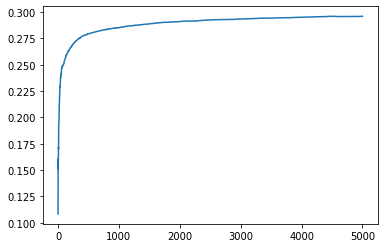

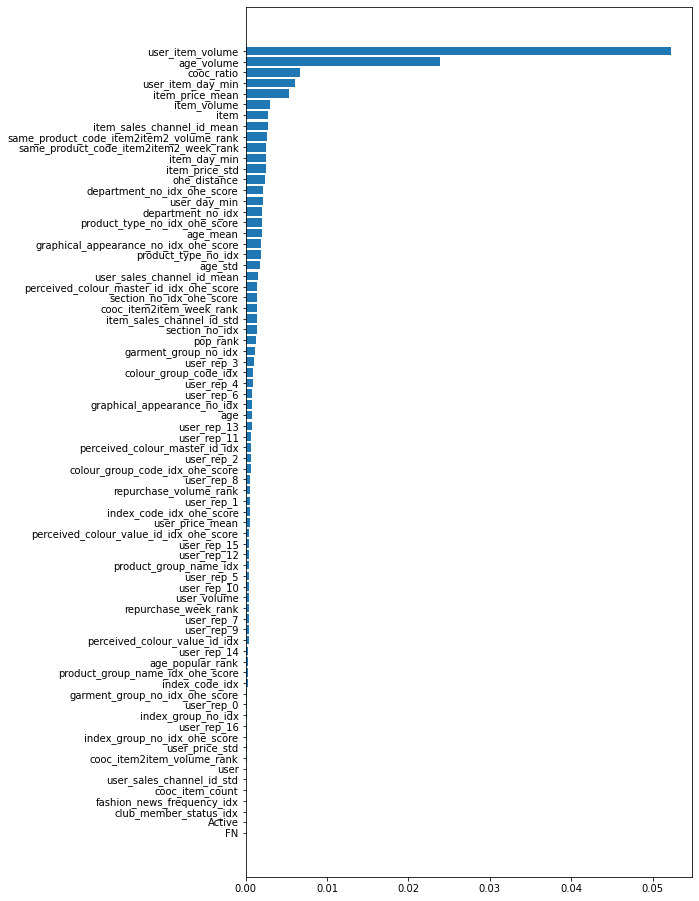

In [17]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    group_valid = get_query_group(valid)

    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
    valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)

    params = {
        'objective': 'xendcg',
        'boosting_type': 'gbdt',
        'learning_rate': 1e-6,
        'num_leaves': 255,
        'min_data_in_leaf': 100,
        'metric': 'map',
        'eval_at': 12,
    }

    model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)
    valid_dataset = catboost.Pool(data=valid[feature_columns], label=valid['y'], group_id=valid['query_group'], cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'iterations': 5000,
    }
    model = catboost.CatBoost(params)
    model.fit(train_dataset, eval_set=valid_dataset)

    plt.plot(model.get_evals_result()['validation']['PFound'])

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])


del train, valid, train_dataset, valid_dataset
gc.collect()
with open('output/model_for_validation.pkl', 'wb') as f:
    pickle.dump(model, f)

In [18]:
pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
pred['pred'] = model.predict(dataset_valid_all[feature_columns])

pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)

merged.to_pickle(f'output/merged_{dataset}.pkl')
dataset_valid_all.to_pickle(f'output/valid_all_{dataset}.pkl')

print('mAP@12:', mapk(merged['gt'], merged['item']))

mAP@12: 0.03499571558132753


In [19]:
# assert False

submission

In [20]:
datasets = [attach_features(transactions, users, items, candidates[idx], 1+idx, CFG.train_weeks) for idx in range(len(candidates))]

for idx in range(len(datasets)):
    datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
    datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

train = concat_train(datasets, 0, CFG.train_weeks)

attach features (week: 1)


[user static fetaures] 0.651 s


[item stacic features] 1.450 s


[user dynamic features (transactions)] 3.853 s


[item dynamic features (transactions)] 1.338 s


[item dynamic features (user features)] 4.038 s


[item freshness features] 2.866 s


[item volume features] 1.382 s


[user freshness features] 3.955 s


[user volume features] 2.258 s


[user-item freshness features] 20.563 s


[user-item volume features] 4.369 s


[item age volume features] 2.227 s


[ohe dot products] 60.791 s


[lfm features] 3.437 s
attach features (week: 2)


[user static fetaures] 0.627 s


[item stacic features] 1.550 s


[user dynamic features (transactions)] 3.249 s


[item dynamic features (transactions)] 1.393 s


[item dynamic features (user features)] 4.042 s


[item freshness features] 2.873 s


[item volume features] 1.460 s


[user freshness features] 4.059 s


[user volume features] 2.351 s


[user-item freshness features] 20.631 s


[user-item volume features] 4.705 s


[item age volume features] 2.395 s


[ohe dot products] 84.042 s


[lfm features] 3.498 s
attach features (week: 3)


[user static fetaures] 0.673 s


[item stacic features] 1.715 s


[user dynamic features (transactions)] 3.404 s


[item dynamic features (transactions)] 1.467 s


[item dynamic features (user features)] 4.269 s


[item freshness features] 2.944 s


[item volume features] 1.535 s


[user freshness features] 4.147 s


[user volume features] 2.478 s


[user-item freshness features] 20.863 s


[user-item volume features] 4.808 s


[item age volume features] 2.486 s


[ohe dot products] 89.226 s


[lfm features] 3.678 s
attach features (week: 4)


[user static fetaures] 0.714 s


[item stacic features] 1.822 s


[user dynamic features (transactions)] 3.440 s


[item dynamic features (transactions)] 1.478 s


[item dynamic features (user features)] 4.309 s


[item freshness features] 3.000 s


[item volume features] 1.590 s


[user freshness features] 4.192 s


[user volume features] 2.524 s


[user-item freshness features] 20.916 s


[user-item volume features] 4.738 s


[item age volume features] 2.594 s


[ohe dot products] 93.184 s


[lfm features] 3.660 s
attach features (week: 5)


[user static fetaures] 0.612 s


[item stacic features] 1.492 s


[user dynamic features (transactions)] 3.236 s


[item dynamic features (transactions)] 1.327 s


[item dynamic features (user features)] 4.091 s


[item freshness features] 2.820 s


[item volume features] 1.389 s


[user freshness features] 3.948 s


[user volume features] 2.296 s


[user-item freshness features] 20.641 s


[user-item volume features] 4.469 s


[item age volume features] 2.319 s


[ohe dot products] 75.081 s


[lfm features] 3.368 s
attach features (week: 6)


[user static fetaures] 0.570 s


[item stacic features] 1.359 s


[user dynamic features (transactions)] 3.166 s


[item dynamic features (transactions)] 1.249 s


[item dynamic features (user features)] 4.003 s


[item freshness features] 2.726 s


[item volume features] 1.323 s


[user freshness features] 3.843 s


[user volume features] 2.200 s


[user-item freshness features] 20.345 s


[user-item volume features] 4.675 s


[item age volume features] 2.198 s


[ohe dot products] 72.844 s


[lfm features] 3.257 s
attach features (week: 7)


[user static fetaures] 0.577 s


[item stacic features] 1.440 s


[user dynamic features (transactions)] 3.310 s


[item dynamic features (transactions)] 1.351 s


[item dynamic features (user features)] 4.164 s


[item freshness features] 2.820 s


[item volume features] 1.431 s


[user freshness features] 3.995 s


[user volume features] 2.359 s


[user-item freshness features] 19.015 s


[user-item volume features] 4.477 s


[item age volume features] 2.357 s


[ohe dot products] 75.399 s


[lfm features] 3.425 s


0:	total: 6.51s	remaining: 9h 2m 24s


1:	total: 12.2s	remaining: 8h 29m 14s


2:	total: 17.9s	remaining: 8h 15m 33s


3:	total: 23.5s	remaining: 8h 9m 14s


4:	total: 29.2s	remaining: 8h 5m 44s


5:	total: 34.8s	remaining: 8h 2m 46s


6:	total: 40.6s	remaining: 8h 2m 3s


7:	total: 46.2s	remaining: 8h 5s


8:	total: 51.6s	remaining: 7h 57m 1s


9:	total: 57.3s	remaining: 7h 56m 30s


10:	total: 1m 2s	remaining: 7h 54m 32s


11:	total: 1m 8s	remaining: 7h 53m 31s


12:	total: 1m 13s	remaining: 7h 52m 36s


13:	total: 1m 19s	remaining: 7h 52m 7s


14:	total: 1m 24s	remaining: 7h 50m 25s


15:	total: 1m 30s	remaining: 7h 50m 25s


16:	total: 1m 36s	remaining: 7h 49m 23s


17:	total: 1m 41s	remaining: 7h 49m 38s


18:	total: 1m 47s	remaining: 7h 49m 8s


19:	total: 1m 53s	remaining: 7h 49m 25s


20:	total: 1m 58s	remaining: 7h 49m 5s


21:	total: 2m 4s	remaining: 7h 48m 15s


22:	total: 2m 9s	remaining: 7h 47m 29s


23:	total: 2m 15s	remaining: 7h 46m 46s


24:	total: 2m 20s	remaining: 7h 46m 52s


25:	total: 2m 26s	remaining: 7h 47m 14s


26:	total: 2m 32s	remaining: 7h 47m 13s


27:	total: 2m 37s	remaining: 7h 47m 12s


28:	total: 2m 43s	remaining: 7h 46m 48s


29:	total: 2m 49s	remaining: 7h 46m 55s


30:	total: 2m 54s	remaining: 7h 46m 34s


31:	total: 3m	remaining: 7h 46m 36s


32:	total: 3m 5s	remaining: 7h 45m 54s


33:	total: 3m 11s	remaining: 7h 46m 2s


34:	total: 3m 17s	remaining: 7h 46m 13s


35:	total: 3m 22s	remaining: 7h 46m 10s


36:	total: 3m 28s	remaining: 7h 46m 13s


37:	total: 3m 34s	remaining: 7h 45m 56s


38:	total: 3m 39s	remaining: 7h 45m 55s


39:	total: 3m 45s	remaining: 7h 45m 53s


40:	total: 3m 51s	remaining: 7h 45m 35s


41:	total: 3m 56s	remaining: 7h 45m 22s


42:	total: 4m 2s	remaining: 7h 45m 36s


43:	total: 4m 8s	remaining: 7h 45m 51s


44:	total: 4m 13s	remaining: 7h 45m 58s


45:	total: 4m 19s	remaining: 7h 45m 27s


46:	total: 4m 24s	remaining: 7h 45m 16s


47:	total: 4m 30s	remaining: 7h 45m 16s


48:	total: 4m 36s	remaining: 7h 45m 3s


49:	total: 4m 41s	remaining: 7h 45m 3s


50:	total: 4m 47s	remaining: 7h 45m 1s


51:	total: 4m 52s	remaining: 7h 44m 26s


52:	total: 4m 58s	remaining: 7h 44m 34s


53:	total: 5m 4s	remaining: 7h 44m 9s


54:	total: 5m 9s	remaining: 7h 44m 3s


55:	total: 5m 15s	remaining: 7h 43m 37s


56:	total: 5m 20s	remaining: 7h 43m 18s


57:	total: 5m 25s	remaining: 7h 42m 39s


58:	total: 5m 31s	remaining: 7h 42m 47s


59:	total: 5m 37s	remaining: 7h 42m 36s


60:	total: 5m 42s	remaining: 7h 42m 42s


61:	total: 5m 48s	remaining: 7h 42m 42s


62:	total: 5m 54s	remaining: 7h 42m 45s


63:	total: 5m 59s	remaining: 7h 42m 14s


64:	total: 6m 5s	remaining: 7h 42m 17s


65:	total: 6m 10s	remaining: 7h 41m 44s


66:	total: 6m 16s	remaining: 7h 41m 31s


67:	total: 6m 22s	remaining: 7h 41m 41s


68:	total: 6m 27s	remaining: 7h 41m 34s


69:	total: 6m 33s	remaining: 7h 41m 37s


70:	total: 6m 38s	remaining: 7h 41m 13s


71:	total: 6m 44s	remaining: 7h 41m 10s


72:	total: 6m 49s	remaining: 7h 41m 5s


73:	total: 6m 55s	remaining: 7h 40m 52s


74:	total: 7m	remaining: 7h 40m 27s


75:	total: 7m 6s	remaining: 7h 40m 25s


76:	total: 7m 12s	remaining: 7h 40m 26s


77:	total: 7m 17s	remaining: 7h 40m 10s


78:	total: 7m 23s	remaining: 7h 40m 11s


79:	total: 7m 29s	remaining: 7h 40m 20s


80:	total: 7m 34s	remaining: 7h 40m 19s


81:	total: 7m 40s	remaining: 7h 39m 59s


82:	total: 7m 45s	remaining: 7h 39m 55s


83:	total: 7m 51s	remaining: 7h 40m 1s


84:	total: 7m 57s	remaining: 7h 40m 5s


85:	total: 8m 3s	remaining: 7h 40m 12s


86:	total: 8m 8s	remaining: 7h 40m 3s


87:	total: 8m 14s	remaining: 7h 39m 57s


88:	total: 8m 20s	remaining: 7h 39m 47s


89:	total: 8m 25s	remaining: 7h 39m 25s


90:	total: 8m 31s	remaining: 7h 39m 24s


91:	total: 8m 36s	remaining: 7h 39m 7s


92:	total: 8m 41s	remaining: 7h 38m 41s


93:	total: 8m 47s	remaining: 7h 38m 39s


94:	total: 8m 53s	remaining: 7h 38m 40s


95:	total: 8m 58s	remaining: 7h 38m 43s


96:	total: 9m 4s	remaining: 7h 38m 39s


97:	total: 9m 9s	remaining: 7h 38m 21s


98:	total: 9m 15s	remaining: 7h 38m 12s


99:	total: 9m 21s	remaining: 7h 38m 9s


100:	total: 9m 26s	remaining: 7h 38m 8s


101:	total: 9m 32s	remaining: 7h 38m 5s


102:	total: 9m 38s	remaining: 7h 37m 56s


103:	total: 9m 43s	remaining: 7h 37m 58s


104:	total: 9m 49s	remaining: 7h 37m 55s


105:	total: 9m 55s	remaining: 7h 37m 50s


106:	total: 10m	remaining: 7h 37m 37s


107:	total: 10m 6s	remaining: 7h 37m 36s


108:	total: 10m 11s	remaining: 7h 37m 19s


109:	total: 10m 17s	remaining: 7h 37m 22s


110:	total: 10m 23s	remaining: 7h 37m 16s


111:	total: 10m 28s	remaining: 7h 36m 57s


112:	total: 10m 34s	remaining: 7h 36m 54s


113:	total: 10m 39s	remaining: 7h 36m 32s


114:	total: 10m 44s	remaining: 7h 36m 22s


115:	total: 10m 50s	remaining: 7h 36m 14s


116:	total: 10m 56s	remaining: 7h 36m 13s


117:	total: 11m 1s	remaining: 7h 36m 3s


118:	total: 11m 7s	remaining: 7h 35m 55s


119:	total: 11m 12s	remaining: 7h 35m 45s


120:	total: 11m 18s	remaining: 7h 35m 42s


121:	total: 11m 23s	remaining: 7h 35m 29s


122:	total: 11m 29s	remaining: 7h 35m 18s


123:	total: 11m 34s	remaining: 7h 35m 11s


124:	total: 11m 40s	remaining: 7h 35m 4s


125:	total: 11m 45s	remaining: 7h 34m 45s


126:	total: 11m 51s	remaining: 7h 34m 38s


127:	total: 11m 56s	remaining: 7h 34m 31s


128:	total: 12m 2s	remaining: 7h 34m 21s


129:	total: 12m 7s	remaining: 7h 34m 17s


130:	total: 12m 13s	remaining: 7h 34m 2s


131:	total: 12m 18s	remaining: 7h 34m


132:	total: 12m 24s	remaining: 7h 33m 59s


133:	total: 12m 29s	remaining: 7h 33m 45s


134:	total: 12m 35s	remaining: 7h 33m 33s


135:	total: 12m 40s	remaining: 7h 33m 17s


136:	total: 12m 45s	remaining: 7h 33m 4s


137:	total: 12m 51s	remaining: 7h 32m 58s


138:	total: 12m 57s	remaining: 7h 33m


139:	total: 13m 2s	remaining: 7h 32m 44s


140:	total: 13m 8s	remaining: 7h 32m 37s


141:	total: 13m 13s	remaining: 7h 32m 32s


142:	total: 13m 19s	remaining: 7h 32m 34s


143:	total: 13m 25s	remaining: 7h 32m 24s


144:	total: 13m 30s	remaining: 7h 32m 17s


145:	total: 13m 36s	remaining: 7h 32m 10s


146:	total: 13m 41s	remaining: 7h 31m 53s


147:	total: 13m 47s	remaining: 7h 31m 50s


148:	total: 13m 52s	remaining: 7h 31m 47s


149:	total: 13m 58s	remaining: 7h 31m 41s


150:	total: 14m 3s	remaining: 7h 31m 26s


151:	total: 14m 9s	remaining: 7h 31m 16s


152:	total: 14m 14s	remaining: 7h 30m 59s


153:	total: 14m 19s	remaining: 7h 30m 49s


154:	total: 14m 25s	remaining: 7h 30m 47s


155:	total: 14m 31s	remaining: 7h 30m 50s


156:	total: 14m 36s	remaining: 7h 30m 40s


157:	total: 14m 42s	remaining: 7h 30m 31s


158:	total: 14m 48s	remaining: 7h 30m 31s


159:	total: 14m 53s	remaining: 7h 30m 24s


160:	total: 14m 58s	remaining: 7h 30m 12s


161:	total: 15m 4s	remaining: 7h 30m 9s


162:	total: 15m 10s	remaining: 7h 30m 2s


163:	total: 15m 15s	remaining: 7h 30m 3s


164:	total: 15m 21s	remaining: 7h 29m 49s


165:	total: 15m 26s	remaining: 7h 29m 47s


166:	total: 15m 32s	remaining: 7h 29m 42s


167:	total: 15m 38s	remaining: 7h 29m 42s


168:	total: 15m 43s	remaining: 7h 29m 36s


169:	total: 15m 49s	remaining: 7h 29m 33s


170:	total: 15m 54s	remaining: 7h 29m 20s


171:	total: 16m	remaining: 7h 29m 15s


172:	total: 16m 5s	remaining: 7h 29m 2s


173:	total: 16m 11s	remaining: 7h 28m 54s


174:	total: 16m 16s	remaining: 7h 28m 44s


175:	total: 16m 22s	remaining: 7h 28m 49s


176:	total: 16m 27s	remaining: 7h 28m 34s


177:	total: 16m 33s	remaining: 7h 28m 28s


178:	total: 16m 39s	remaining: 7h 28m 24s


179:	total: 16m 44s	remaining: 7h 28m 8s


180:	total: 16m 49s	remaining: 7h 28m


181:	total: 16m 55s	remaining: 7h 27m 52s


182:	total: 17m 1s	remaining: 7h 27m 50s


183:	total: 17m 6s	remaining: 7h 27m 39s


184:	total: 17m 11s	remaining: 7h 27m 26s


185:	total: 17m 17s	remaining: 7h 27m 19s


186:	total: 17m 22s	remaining: 7h 27m 6s


187:	total: 17m 28s	remaining: 7h 27m 2s


188:	total: 17m 33s	remaining: 7h 27m 2s


189:	total: 17m 39s	remaining: 7h 26m 57s


190:	total: 17m 44s	remaining: 7h 26m 44s


191:	total: 17m 50s	remaining: 7h 26m 34s


192:	total: 17m 55s	remaining: 7h 26m 16s


193:	total: 18m	remaining: 7h 26m 12s


194:	total: 18m 6s	remaining: 7h 26m 2s


195:	total: 18m 11s	remaining: 7h 25m 48s


196:	total: 18m 17s	remaining: 7h 25m 49s


197:	total: 18m 22s	remaining: 7h 25m 43s


198:	total: 18m 28s	remaining: 7h 25m 35s


199:	total: 18m 34s	remaining: 7h 25m 31s


200:	total: 18m 39s	remaining: 7h 25m 19s


201:	total: 18m 44s	remaining: 7h 25m 13s


202:	total: 18m 50s	remaining: 7h 25m 2s


203:	total: 18m 55s	remaining: 7h 24m 58s


204:	total: 19m 1s	remaining: 7h 24m 48s


205:	total: 19m 6s	remaining: 7h 24m 35s


206:	total: 19m 11s	remaining: 7h 24m 27s


207:	total: 19m 17s	remaining: 7h 24m 20s


208:	total: 19m 22s	remaining: 7h 24m 10s


209:	total: 19m 28s	remaining: 7h 24m 8s


210:	total: 19m 33s	remaining: 7h 23m 55s


211:	total: 19m 39s	remaining: 7h 23m 52s


212:	total: 19m 45s	remaining: 7h 23m 53s


213:	total: 19m 50s	remaining: 7h 23m 43s


214:	total: 19m 56s	remaining: 7h 23m 40s


215:	total: 20m 1s	remaining: 7h 23m 28s


216:	total: 20m 7s	remaining: 7h 23m 19s


217:	total: 20m 12s	remaining: 7h 23m 18s


218:	total: 20m 18s	remaining: 7h 23m 8s


219:	total: 20m 23s	remaining: 7h 22m 57s


220:	total: 20m 29s	remaining: 7h 22m 55s


221:	total: 20m 34s	remaining: 7h 22m 44s


222:	total: 20m 40s	remaining: 7h 22m 46s


223:	total: 20m 45s	remaining: 7h 22m 37s


224:	total: 20m 51s	remaining: 7h 22m 35s


225:	total: 20m 56s	remaining: 7h 22m 25s


226:	total: 21m 2s	remaining: 7h 22m 17s


227:	total: 21m 7s	remaining: 7h 22m 12s


228:	total: 21m 13s	remaining: 7h 22m 3s


229:	total: 21m 18s	remaining: 7h 21m 53s


230:	total: 21m 24s	remaining: 7h 21m 47s


231:	total: 21m 29s	remaining: 7h 21m 40s


232:	total: 21m 35s	remaining: 7h 21m 32s


233:	total: 21m 40s	remaining: 7h 21m 23s


234:	total: 21m 45s	remaining: 7h 21m 13s


235:	total: 21m 51s	remaining: 7h 21m 7s


236:	total: 21m 56s	remaining: 7h 21m


237:	total: 22m 2s	remaining: 7h 20m 51s


238:	total: 22m 7s	remaining: 7h 20m 46s


239:	total: 22m 13s	remaining: 7h 20m 33s


240:	total: 22m 18s	remaining: 7h 20m 22s


241:	total: 22m 23s	remaining: 7h 20m 13s


242:	total: 22m 29s	remaining: 7h 20m 7s


243:	total: 22m 34s	remaining: 7h 19m 59s


244:	total: 22m 40s	remaining: 7h 19m 49s


245:	total: 22m 45s	remaining: 7h 19m 46s


246:	total: 22m 51s	remaining: 7h 19m 36s


247:	total: 22m 56s	remaining: 7h 19m 29s


248:	total: 23m 2s	remaining: 7h 19m 27s


249:	total: 23m 7s	remaining: 7h 19m 24s


250:	total: 23m 13s	remaining: 7h 19m 12s


251:	total: 23m 18s	remaining: 7h 19m 5s


252:	total: 23m 24s	remaining: 7h 18m 57s


253:	total: 23m 29s	remaining: 7h 18m 52s


254:	total: 23m 34s	remaining: 7h 18m 43s


255:	total: 23m 40s	remaining: 7h 18m 33s


256:	total: 23m 45s	remaining: 7h 18m 25s


257:	total: 23m 50s	remaining: 7h 18m 14s


258:	total: 23m 56s	remaining: 7h 18m 1s


259:	total: 24m 1s	remaining: 7h 17m 55s


260:	total: 24m 7s	remaining: 7h 17m 52s


261:	total: 24m 12s	remaining: 7h 17m 45s


262:	total: 24m 17s	remaining: 7h 17m 31s


263:	total: 24m 23s	remaining: 7h 17m 29s


264:	total: 24m 29s	remaining: 7h 17m 31s


265:	total: 24m 34s	remaining: 7h 17m 24s


266:	total: 24m 40s	remaining: 7h 17m 17s


267:	total: 24m 46s	remaining: 7h 17m 17s


268:	total: 24m 51s	remaining: 7h 17m 12s


269:	total: 24m 57s	remaining: 7h 17m 7s


270:	total: 25m 2s	remaining: 7h 16m 57s


271:	total: 25m 8s	remaining: 7h 16m 55s


272:	total: 25m 13s	remaining: 7h 16m 49s


273:	total: 25m 19s	remaining: 7h 16m 45s


274:	total: 25m 25s	remaining: 7h 16m 36s


275:	total: 25m 30s	remaining: 7h 16m 30s


276:	total: 25m 35s	remaining: 7h 16m 23s


277:	total: 25m 41s	remaining: 7h 16m 18s


278:	total: 25m 46s	remaining: 7h 16m 9s


279:	total: 25m 52s	remaining: 7h 15m 58s


280:	total: 25m 57s	remaining: 7h 15m 53s


281:	total: 26m 3s	remaining: 7h 15m 48s


282:	total: 26m 8s	remaining: 7h 15m 40s


283:	total: 26m 14s	remaining: 7h 15m 35s


284:	total: 26m 20s	remaining: 7h 15m 34s


285:	total: 26m 25s	remaining: 7h 15m 29s


286:	total: 26m 31s	remaining: 7h 15m 24s


287:	total: 26m 36s	remaining: 7h 15m 20s


288:	total: 26m 42s	remaining: 7h 15m 16s


289:	total: 26m 48s	remaining: 7h 15m 13s


290:	total: 26m 53s	remaining: 7h 15m 9s


291:	total: 26m 59s	remaining: 7h 15m 3s


292:	total: 27m 4s	remaining: 7h 14m 54s


293:	total: 27m 10s	remaining: 7h 14m 47s


294:	total: 27m 15s	remaining: 7h 14m 42s


295:	total: 27m 21s	remaining: 7h 14m 34s


296:	total: 27m 26s	remaining: 7h 14m 27s


297:	total: 27m 32s	remaining: 7h 14m 24s


298:	total: 27m 38s	remaining: 7h 14m 23s


299:	total: 27m 43s	remaining: 7h 14m 15s


300:	total: 27m 48s	remaining: 7h 14m 4s


301:	total: 27m 54s	remaining: 7h 13m 57s


302:	total: 27m 59s	remaining: 7h 13m 53s


303:	total: 28m 5s	remaining: 7h 13m 46s


304:	total: 28m 10s	remaining: 7h 13m 39s


305:	total: 28m 16s	remaining: 7h 13m 38s


306:	total: 28m 21s	remaining: 7h 13m 27s


307:	total: 28m 27s	remaining: 7h 13m 22s


308:	total: 28m 32s	remaining: 7h 13m 12s


309:	total: 28m 37s	remaining: 7h 13m 4s


310:	total: 28m 43s	remaining: 7h 12m 58s


311:	total: 28m 48s	remaining: 7h 12m 51s


312:	total: 28m 54s	remaining: 7h 12m 44s


313:	total: 28m 59s	remaining: 7h 12m 38s


314:	total: 29m 4s	remaining: 7h 12m 25s


315:	total: 29m 10s	remaining: 7h 12m 18s


316:	total: 29m 15s	remaining: 7h 12m 7s


317:	total: 29m 21s	remaining: 7h 12m 2s


318:	total: 29m 26s	remaining: 7h 11m 54s


319:	total: 29m 31s	remaining: 7h 11m 46s


320:	total: 29m 36s	remaining: 7h 11m 36s


321:	total: 29m 42s	remaining: 7h 11m 26s


322:	total: 29m 47s	remaining: 7h 11m 20s


323:	total: 29m 53s	remaining: 7h 11m 16s


324:	total: 29m 58s	remaining: 7h 11m 12s


325:	total: 30m 4s	remaining: 7h 11m 3s


326:	total: 30m 9s	remaining: 7h 10m 55s


327:	total: 30m 15s	remaining: 7h 10m 49s


328:	total: 30m 20s	remaining: 7h 10m 44s


329:	total: 30m 26s	remaining: 7h 10m 36s


330:	total: 30m 31s	remaining: 7h 10m 31s


331:	total: 30m 37s	remaining: 7h 10m 24s


332:	total: 30m 42s	remaining: 7h 10m 14s


333:	total: 30m 47s	remaining: 7h 10m 2s


334:	total: 30m 52s	remaining: 7h 9m 52s


335:	total: 30m 58s	remaining: 7h 9m 48s


336:	total: 31m 3s	remaining: 7h 9m 42s


337:	total: 31m 9s	remaining: 7h 9m 35s


338:	total: 31m 14s	remaining: 7h 9m 27s


339:	total: 31m 19s	remaining: 7h 9m 17s


340:	total: 31m 25s	remaining: 7h 9m 13s


341:	total: 31m 30s	remaining: 7h 9m 4s


342:	total: 31m 35s	remaining: 7h 8m 56s


343:	total: 31m 41s	remaining: 7h 8m 49s


344:	total: 31m 46s	remaining: 7h 8m 42s


345:	total: 31m 51s	remaining: 7h 8m 30s


346:	total: 31m 57s	remaining: 7h 8m 23s


347:	total: 32m 2s	remaining: 7h 8m 11s


348:	total: 32m 7s	remaining: 7h 8m 6s


349:	total: 32m 12s	remaining: 7h 7m 55s


350:	total: 32m 18s	remaining: 7h 7m 50s


351:	total: 32m 23s	remaining: 7h 7m 39s


352:	total: 32m 29s	remaining: 7h 7m 32s


353:	total: 32m 34s	remaining: 7h 7m 27s


354:	total: 32m 39s	remaining: 7h 7m 19s


355:	total: 32m 45s	remaining: 7h 7m 12s


356:	total: 32m 50s	remaining: 7h 7m 4s


357:	total: 32m 56s	remaining: 7h 6m 59s


358:	total: 33m 1s	remaining: 7h 6m 55s


359:	total: 33m 7s	remaining: 7h 6m 48s


360:	total: 33m 12s	remaining: 7h 6m 40s


361:	total: 33m 17s	remaining: 7h 6m 31s


362:	total: 33m 23s	remaining: 7h 6m 26s


363:	total: 33m 29s	remaining: 7h 6m 22s


364:	total: 33m 34s	remaining: 7h 6m 14s


365:	total: 33m 39s	remaining: 7h 6m 3s


366:	total: 33m 44s	remaining: 7h 5m 56s


367:	total: 33m 50s	remaining: 7h 5m 55s


368:	total: 33m 56s	remaining: 7h 5m 48s


369:	total: 34m 1s	remaining: 7h 5m 39s


370:	total: 34m 6s	remaining: 7h 5m 29s


371:	total: 34m 11s	remaining: 7h 5m 21s


372:	total: 34m 17s	remaining: 7h 5m 13s


373:	total: 34m 22s	remaining: 7h 5m 6s


374:	total: 34m 28s	remaining: 7h 5m


375:	total: 34m 33s	remaining: 7h 4m 56s


376:	total: 34m 38s	remaining: 7h 4m 47s


377:	total: 34m 44s	remaining: 7h 4m 36s


378:	total: 34m 49s	remaining: 7h 4m 29s


379:	total: 34m 54s	remaining: 7h 4m 21s


380:	total: 35m	remaining: 7h 4m 19s


381:	total: 35m 5s	remaining: 7h 4m 11s


382:	total: 35m 11s	remaining: 7h 4m 3s


383:	total: 35m 16s	remaining: 7h 3m 56s


384:	total: 35m 22s	remaining: 7h 3m 53s


385:	total: 35m 27s	remaining: 7h 3m 50s


386:	total: 35m 33s	remaining: 7h 3m 50s


387:	total: 35m 39s	remaining: 7h 3m 41s


388:	total: 35m 44s	remaining: 7h 3m 35s


389:	total: 35m 49s	remaining: 7h 3m 28s


390:	total: 35m 55s	remaining: 7h 3m 23s


391:	total: 36m	remaining: 7h 3m 16s


392:	total: 36m 6s	remaining: 7h 3m 10s


393:	total: 36m 11s	remaining: 7h 3m 5s


394:	total: 36m 17s	remaining: 7h 3m 1s


395:	total: 36m 22s	remaining: 7h 2m 50s


396:	total: 36m 27s	remaining: 7h 2m 40s


397:	total: 36m 32s	remaining: 7h 2m 31s


398:	total: 36m 38s	remaining: 7h 2m 26s


399:	total: 36m 44s	remaining: 7h 2m 20s


400:	total: 36m 49s	remaining: 7h 2m 13s


401:	total: 36m 54s	remaining: 7h 2m 5s


402:	total: 36m 59s	remaining: 7h 1m 55s


403:	total: 37m 5s	remaining: 7h 1m 47s


404:	total: 37m 10s	remaining: 7h 1m 44s


405:	total: 37m 16s	remaining: 7h 1m 37s


406:	total: 37m 21s	remaining: 7h 1m 29s


407:	total: 37m 26s	remaining: 7h 1m 23s


408:	total: 37m 32s	remaining: 7h 1m 16s


409:	total: 37m 37s	remaining: 7h 1m 10s


410:	total: 37m 43s	remaining: 7h 1m 3s


411:	total: 37m 48s	remaining: 7h 53s


412:	total: 37m 53s	remaining: 7h 44s


413:	total: 37m 58s	remaining: 7h 39s


414:	total: 38m 4s	remaining: 7h 36s


415:	total: 38m 10s	remaining: 7h 34s


416:	total: 38m 16s	remaining: 7h 32s


417:	total: 38m 21s	remaining: 7h 28s


418:	total: 38m 26s	remaining: 7h 13s


419:	total: 38m 31s	remaining: 7h 4s


420:	total: 38m 37s	remaining: 6h 59m 56s


421:	total: 38m 42s	remaining: 6h 59m 47s


422:	total: 38m 47s	remaining: 6h 59m 42s


423:	total: 38m 52s	remaining: 6h 59m 33s


424:	total: 38m 58s	remaining: 6h 59m 25s


425:	total: 39m 3s	remaining: 6h 59m 16s


426:	total: 39m 8s	remaining: 6h 59m 8s


427:	total: 39m 14s	remaining: 6h 59m 3s


428:	total: 39m 19s	remaining: 6h 58m 57s


429:	total: 39m 25s	remaining: 6h 58m 51s


430:	total: 39m 30s	remaining: 6h 58m 43s


431:	total: 39m 35s	remaining: 6h 58m 36s


432:	total: 39m 40s	remaining: 6h 58m 26s


433:	total: 39m 46s	remaining: 6h 58m 19s


434:	total: 39m 51s	remaining: 6h 58m 11s


435:	total: 39m 56s	remaining: 6h 58m 3s


436:	total: 40m 2s	remaining: 6h 57m 55s


437:	total: 40m 7s	remaining: 6h 57m 45s


438:	total: 40m 12s	remaining: 6h 57m 38s


439:	total: 40m 17s	remaining: 6h 57m 33s


440:	total: 40m 23s	remaining: 6h 57m 27s


441:	total: 40m 28s	remaining: 6h 57m 18s


442:	total: 40m 33s	remaining: 6h 57m 11s


443:	total: 40m 39s	remaining: 6h 57m 2s


444:	total: 40m 44s	remaining: 6h 56m 53s


445:	total: 40m 49s	remaining: 6h 56m 45s


446:	total: 40m 54s	remaining: 6h 56m 38s


447:	total: 41m	remaining: 6h 56m 30s


448:	total: 41m 5s	remaining: 6h 56m 26s


449:	total: 41m 10s	remaining: 6h 56m 15s


450:	total: 41m 16s	remaining: 6h 56m 9s


451:	total: 41m 21s	remaining: 6h 56m 1s


452:	total: 41m 26s	remaining: 6h 55m 52s


453:	total: 41m 31s	remaining: 6h 55m 46s


454:	total: 41m 37s	remaining: 6h 55m 42s


455:	total: 41m 42s	remaining: 6h 55m 36s


456:	total: 41m 48s	remaining: 6h 55m 32s


457:	total: 41m 54s	remaining: 6h 55m 26s


458:	total: 41m 59s	remaining: 6h 55m 20s


459:	total: 42m 4s	remaining: 6h 55m 12s


460:	total: 42m 10s	remaining: 6h 55m 8s


461:	total: 42m 15s	remaining: 6h 55m 1s


462:	total: 42m 21s	remaining: 6h 54m 55s


463:	total: 42m 26s	remaining: 6h 54m 52s


464:	total: 42m 31s	remaining: 6h 54m 43s


465:	total: 42m 37s	remaining: 6h 54m 34s


466:	total: 42m 42s	remaining: 6h 54m 27s


467:	total: 42m 48s	remaining: 6h 54m 22s


468:	total: 42m 53s	remaining: 6h 54m 19s


469:	total: 42m 58s	remaining: 6h 54m 10s


470:	total: 43m 4s	remaining: 6h 54m 1s


471:	total: 43m 9s	remaining: 6h 53m 55s


472:	total: 43m 14s	remaining: 6h 53m 47s


473:	total: 43m 19s	remaining: 6h 53m 40s


474:	total: 43m 25s	remaining: 6h 53m 32s


475:	total: 43m 30s	remaining: 6h 53m 24s


476:	total: 43m 35s	remaining: 6h 53m 19s


477:	total: 43m 41s	remaining: 6h 53m 15s


478:	total: 43m 46s	remaining: 6h 53m 5s


479:	total: 43m 52s	remaining: 6h 53m


480:	total: 43m 56s	remaining: 6h 52m 46s


481:	total: 44m 1s	remaining: 6h 52m 37s


482:	total: 44m 7s	remaining: 6h 52m 31s


483:	total: 44m 12s	remaining: 6h 52m 26s


484:	total: 44m 17s	remaining: 6h 52m 18s


485:	total: 44m 23s	remaining: 6h 52m 10s


486:	total: 44m 28s	remaining: 6h 52m 5s


487:	total: 44m 34s	remaining: 6h 51m 58s


488:	total: 44m 39s	remaining: 6h 51m 51s


489:	total: 44m 44s	remaining: 6h 51m 46s


490:	total: 44m 50s	remaining: 6h 51m 39s


491:	total: 44m 55s	remaining: 6h 51m 31s


492:	total: 45m	remaining: 6h 51m 24s


493:	total: 45m 6s	remaining: 6h 51m 18s


494:	total: 45m 11s	remaining: 6h 51m 13s


495:	total: 45m 16s	remaining: 6h 51m 6s


496:	total: 45m 22s	remaining: 6h 50m 58s


497:	total: 45m 27s	remaining: 6h 50m 51s


498:	total: 45m 32s	remaining: 6h 50m 42s


499:	total: 45m 37s	remaining: 6h 50m 36s


500:	total: 45m 43s	remaining: 6h 50m 29s


501:	total: 45m 48s	remaining: 6h 50m 23s


502:	total: 45m 54s	remaining: 6h 50m 18s


503:	total: 45m 59s	remaining: 6h 50m 10s


504:	total: 46m 4s	remaining: 6h 50m 3s


505:	total: 46m 9s	remaining: 6h 49m 53s


506:	total: 46m 15s	remaining: 6h 49m 48s


507:	total: 46m 20s	remaining: 6h 49m 44s


508:	total: 46m 26s	remaining: 6h 49m 39s


509:	total: 46m 31s	remaining: 6h 49m 33s


510:	total: 46m 37s	remaining: 6h 49m 26s


511:	total: 46m 42s	remaining: 6h 49m 19s


512:	total: 46m 48s	remaining: 6h 49m 15s


513:	total: 46m 53s	remaining: 6h 49m 8s


514:	total: 46m 58s	remaining: 6h 49m


515:	total: 47m 3s	remaining: 6h 48m 53s


516:	total: 47m 8s	remaining: 6h 48m 45s


517:	total: 47m 14s	remaining: 6h 48m 38s


518:	total: 47m 19s	remaining: 6h 48m 32s


519:	total: 47m 25s	remaining: 6h 48m 26s


520:	total: 47m 30s	remaining: 6h 48m 21s


521:	total: 47m 35s	remaining: 6h 48m 14s


522:	total: 47m 41s	remaining: 6h 48m 9s


523:	total: 47m 46s	remaining: 6h 48m 3s


524:	total: 47m 52s	remaining: 6h 47m 55s


525:	total: 47m 57s	remaining: 6h 47m 47s


526:	total: 48m 2s	remaining: 6h 47m 40s


527:	total: 48m 7s	remaining: 6h 47m 34s


528:	total: 48m 13s	remaining: 6h 47m 25s


529:	total: 48m 18s	remaining: 6h 47m 23s


530:	total: 48m 23s	remaining: 6h 47m 14s


531:	total: 48m 29s	remaining: 6h 47m 9s


532:	total: 48m 34s	remaining: 6h 47m 4s


533:	total: 48m 40s	remaining: 6h 47m 1s


534:	total: 48m 46s	remaining: 6h 46m 56s


535:	total: 48m 51s	remaining: 6h 46m 52s


536:	total: 48m 57s	remaining: 6h 46m 46s


537:	total: 49m 2s	remaining: 6h 46m 40s


538:	total: 49m 7s	remaining: 6h 46m 32s


539:	total: 49m 13s	remaining: 6h 46m 28s


540:	total: 49m 18s	remaining: 6h 46m 22s


541:	total: 49m 24s	remaining: 6h 46m 18s


542:	total: 49m 29s	remaining: 6h 46m 12s


543:	total: 49m 35s	remaining: 6h 46m 3s


544:	total: 49m 40s	remaining: 6h 46m


545:	total: 49m 46s	remaining: 6h 45m 53s


546:	total: 49m 51s	remaining: 6h 45m 49s


547:	total: 49m 57s	remaining: 6h 45m 43s


548:	total: 50m 2s	remaining: 6h 45m 33s


549:	total: 50m 7s	remaining: 6h 45m 28s


550:	total: 50m 13s	remaining: 6h 45m 23s


551:	total: 50m 18s	remaining: 6h 45m 14s


552:	total: 50m 23s	remaining: 6h 45m 7s


553:	total: 50m 29s	remaining: 6h 45m 4s


554:	total: 50m 34s	remaining: 6h 45m 1s


555:	total: 50m 40s	remaining: 6h 44m 56s


556:	total: 50m 45s	remaining: 6h 44m 51s


557:	total: 50m 51s	remaining: 6h 44m 44s


558:	total: 50m 56s	remaining: 6h 44m 38s


559:	total: 51m 2s	remaining: 6h 44m 33s


560:	total: 51m 7s	remaining: 6h 44m 24s


561:	total: 51m 12s	remaining: 6h 44m 18s


562:	total: 51m 17s	remaining: 6h 44m 9s


563:	total: 51m 23s	remaining: 6h 44m 5s


564:	total: 51m 28s	remaining: 6h 43m 57s


565:	total: 51m 34s	remaining: 6h 43m 55s


566:	total: 51m 39s	remaining: 6h 43m 51s


567:	total: 51m 45s	remaining: 6h 43m 44s


568:	total: 51m 50s	remaining: 6h 43m 38s


569:	total: 51m 56s	remaining: 6h 43m 32s


570:	total: 52m	remaining: 6h 43m 21s


571:	total: 52m 6s	remaining: 6h 43m 18s


572:	total: 52m 11s	remaining: 6h 43m 11s


573:	total: 52m 16s	remaining: 6h 43m 3s


574:	total: 52m 22s	remaining: 6h 42m 56s


575:	total: 52m 27s	remaining: 6h 42m 50s


576:	total: 52m 32s	remaining: 6h 42m 41s


577:	total: 52m 38s	remaining: 6h 42m 38s


578:	total: 52m 44s	remaining: 6h 42m 35s


579:	total: 52m 49s	remaining: 6h 42m 30s


580:	total: 52m 54s	remaining: 6h 42m 21s


581:	total: 53m	remaining: 6h 42m 15s


582:	total: 53m 5s	remaining: 6h 42m 10s


583:	total: 53m 11s	remaining: 6h 42m 7s


584:	total: 53m 17s	remaining: 6h 42m 2s


585:	total: 53m 22s	remaining: 6h 41m 57s


586:	total: 53m 27s	remaining: 6h 41m 47s


587:	total: 53m 32s	remaining: 6h 41m 41s


588:	total: 53m 38s	remaining: 6h 41m 34s


589:	total: 53m 43s	remaining: 6h 41m 30s


590:	total: 53m 49s	remaining: 6h 41m 24s


591:	total: 53m 54s	remaining: 6h 41m 17s


592:	total: 53m 59s	remaining: 6h 41m 10s


593:	total: 54m 5s	remaining: 6h 41m 4s


594:	total: 54m 10s	remaining: 6h 40m 58s


595:	total: 54m 15s	remaining: 6h 40m 49s


596:	total: 54m 20s	remaining: 6h 40m 42s


597:	total: 54m 25s	remaining: 6h 40m 35s


598:	total: 54m 31s	remaining: 6h 40m 28s


599:	total: 54m 36s	remaining: 6h 40m 22s


600:	total: 54m 41s	remaining: 6h 40m 15s


601:	total: 54m 47s	remaining: 6h 40m 11s


602:	total: 54m 52s	remaining: 6h 40m 5s


603:	total: 54m 57s	remaining: 6h 39m 56s


604:	total: 55m 3s	remaining: 6h 39m 52s


605:	total: 55m 8s	remaining: 6h 39m 45s


606:	total: 55m 14s	remaining: 6h 39m 42s


607:	total: 55m 20s	remaining: 6h 39m 37s


608:	total: 55m 25s	remaining: 6h 39m 30s


609:	total: 55m 30s	remaining: 6h 39m 25s


610:	total: 55m 36s	remaining: 6h 39m 19s


611:	total: 55m 41s	remaining: 6h 39m 13s


612:	total: 55m 47s	remaining: 6h 39m 7s


613:	total: 55m 52s	remaining: 6h 39m


614:	total: 55m 57s	remaining: 6h 38m 53s


615:	total: 56m 2s	remaining: 6h 38m 47s


616:	total: 56m 8s	remaining: 6h 38m 40s


617:	total: 56m 13s	remaining: 6h 38m 35s


618:	total: 56m 19s	remaining: 6h 38m 30s


619:	total: 56m 24s	remaining: 6h 38m 21s


620:	total: 56m 29s	remaining: 6h 38m 17s


621:	total: 56m 35s	remaining: 6h 38m 13s


622:	total: 56m 40s	remaining: 6h 38m 8s


623:	total: 56m 46s	remaining: 6h 38m 4s


624:	total: 56m 52s	remaining: 6h 37m 59s


625:	total: 56m 57s	remaining: 6h 37m 52s


626:	total: 57m 2s	remaining: 6h 37m 47s


627:	total: 57m 8s	remaining: 6h 37m 43s


628:	total: 57m 14s	remaining: 6h 37m 37s


629:	total: 57m 19s	remaining: 6h 37m 31s


630:	total: 57m 24s	remaining: 6h 37m 24s


631:	total: 57m 29s	remaining: 6h 37m 16s


632:	total: 57m 35s	remaining: 6h 37m 12s


633:	total: 57m 40s	remaining: 6h 37m 4s


634:	total: 57m 45s	remaining: 6h 36m 58s


635:	total: 57m 51s	remaining: 6h 36m 51s


636:	total: 57m 56s	remaining: 6h 36m 45s


637:	total: 58m 1s	remaining: 6h 36m 39s


638:	total: 58m 7s	remaining: 6h 36m 32s


639:	total: 58m 12s	remaining: 6h 36m 24s


640:	total: 58m 17s	remaining: 6h 36m 20s


641:	total: 58m 22s	remaining: 6h 36m 13s


642:	total: 58m 28s	remaining: 6h 36m 5s


643:	total: 58m 33s	remaining: 6h 36m


644:	total: 58m 38s	remaining: 6h 35m 53s


645:	total: 58m 44s	remaining: 6h 35m 48s


646:	total: 58m 49s	remaining: 6h 35m 41s


647:	total: 58m 55s	remaining: 6h 35m 36s


648:	total: 59m	remaining: 6h 35m 30s


649:	total: 59m 5s	remaining: 6h 35m 24s


650:	total: 59m 11s	remaining: 6h 35m 18s


651:	total: 59m 16s	remaining: 6h 35m 12s


652:	total: 59m 21s	remaining: 6h 35m 6s


653:	total: 59m 27s	remaining: 6h 35m


654:	total: 59m 32s	remaining: 6h 34m 55s


655:	total: 59m 37s	remaining: 6h 34m 47s


656:	total: 59m 43s	remaining: 6h 34m 42s


657:	total: 59m 48s	remaining: 6h 34m 37s


658:	total: 59m 54s	remaining: 6h 34m 31s


659:	total: 59m 59s	remaining: 6h 34m 24s


660:	total: 1h 5s	remaining: 6h 34m 21s


661:	total: 1h 10s	remaining: 6h 34m 13s


662:	total: 1h 15s	remaining: 6h 34m 6s


663:	total: 1h 20s	remaining: 6h 33m 59s


664:	total: 1h 26s	remaining: 6h 33m 52s


665:	total: 1h 31s	remaining: 6h 33m 44s


666:	total: 1h 36s	remaining: 6h 33m 38s


667:	total: 1h 41s	remaining: 6h 33m 31s


668:	total: 1h 47s	remaining: 6h 33m 27s


669:	total: 1h 53s	remaining: 6h 33m 24s


670:	total: 1h 58s	remaining: 6h 33m 19s


671:	total: 1h 1m 4s	remaining: 6h 33m 13s


672:	total: 1h 1m 9s	remaining: 6h 33m 6s


673:	total: 1h 1m 14s	remaining: 6h 33m


674:	total: 1h 1m 20s	remaining: 6h 32m 54s


675:	total: 1h 1m 25s	remaining: 6h 32m 47s


676:	total: 1h 1m 30s	remaining: 6h 32m 40s


677:	total: 1h 1m 35s	remaining: 6h 32m 34s


678:	total: 1h 1m 41s	remaining: 6h 32m 27s


679:	total: 1h 1m 46s	remaining: 6h 32m 23s


680:	total: 1h 1m 51s	remaining: 6h 32m 15s


681:	total: 1h 1m 57s	remaining: 6h 32m 9s


682:	total: 1h 2m 2s	remaining: 6h 32m 3s


683:	total: 1h 2m 7s	remaining: 6h 31m 57s


684:	total: 1h 2m 13s	remaining: 6h 31m 53s


685:	total: 1h 2m 19s	remaining: 6h 31m 48s


686:	total: 1h 2m 24s	remaining: 6h 31m 41s


687:	total: 1h 2m 29s	remaining: 6h 31m 33s


688:	total: 1h 2m 34s	remaining: 6h 31m 27s


689:	total: 1h 2m 40s	remaining: 6h 31m 21s


690:	total: 1h 2m 45s	remaining: 6h 31m 13s


691:	total: 1h 2m 50s	remaining: 6h 31m 7s


692:	total: 1h 2m 55s	remaining: 6h 31m 1s


693:	total: 1h 3m 1s	remaining: 6h 30m 56s


694:	total: 1h 3m 6s	remaining: 6h 30m 51s


695:	total: 1h 3m 12s	remaining: 6h 30m 46s


696:	total: 1h 3m 17s	remaining: 6h 30m 41s


697:	total: 1h 3m 23s	remaining: 6h 30m 35s


698:	total: 1h 3m 28s	remaining: 6h 30m 26s


699:	total: 1h 3m 33s	remaining: 6h 30m 20s


700:	total: 1h 3m 38s	remaining: 6h 30m 12s


701:	total: 1h 3m 44s	remaining: 6h 30m 9s


702:	total: 1h 3m 49s	remaining: 6h 30m 1s


703:	total: 1h 3m 54s	remaining: 6h 29m 55s


704:	total: 1h 4m	remaining: 6h 29m 49s


705:	total: 1h 4m 5s	remaining: 6h 29m 43s


706:	total: 1h 4m 10s	remaining: 6h 29m 36s


707:	total: 1h 4m 15s	remaining: 6h 29m 29s


708:	total: 1h 4m 21s	remaining: 6h 29m 22s


709:	total: 1h 4m 26s	remaining: 6h 29m 17s


710:	total: 1h 4m 31s	remaining: 6h 29m 11s


711:	total: 1h 4m 37s	remaining: 6h 29m 6s


712:	total: 1h 4m 43s	remaining: 6h 29m 1s


713:	total: 1h 4m 48s	remaining: 6h 28m 54s


714:	total: 1h 4m 53s	remaining: 6h 28m 47s


715:	total: 1h 4m 58s	remaining: 6h 28m 41s


716:	total: 1h 5m 4s	remaining: 6h 28m 37s


717:	total: 1h 5m 9s	remaining: 6h 28m 32s


718:	total: 1h 5m 15s	remaining: 6h 28m 28s


719:	total: 1h 5m 20s	remaining: 6h 28m 21s


720:	total: 1h 5m 26s	remaining: 6h 28m 15s


721:	total: 1h 5m 31s	remaining: 6h 28m 9s


722:	total: 1h 5m 36s	remaining: 6h 28m 3s


723:	total: 1h 5m 42s	remaining: 6h 27m 57s


724:	total: 1h 5m 47s	remaining: 6h 27m 50s


725:	total: 1h 5m 52s	remaining: 6h 27m 43s


726:	total: 1h 5m 57s	remaining: 6h 27m 34s


727:	total: 1h 6m 2s	remaining: 6h 27m 28s


728:	total: 1h 6m 7s	remaining: 6h 27m 20s


729:	total: 1h 6m 13s	remaining: 6h 27m 15s


730:	total: 1h 6m 18s	remaining: 6h 27m 9s


731:	total: 1h 6m 23s	remaining: 6h 27m 2s


732:	total: 1h 6m 29s	remaining: 6h 26m 58s


733:	total: 1h 6m 35s	remaining: 6h 26m 54s


734:	total: 1h 6m 40s	remaining: 6h 26m 48s


735:	total: 1h 6m 45s	remaining: 6h 26m 39s


736:	total: 1h 6m 50s	remaining: 6h 26m 34s


737:	total: 1h 6m 56s	remaining: 6h 26m 28s


738:	total: 1h 7m 1s	remaining: 6h 26m 21s


739:	total: 1h 7m 7s	remaining: 6h 26m 17s


740:	total: 1h 7m 12s	remaining: 6h 26m 11s


741:	total: 1h 7m 17s	remaining: 6h 26m 5s


742:	total: 1h 7m 23s	remaining: 6h 25m 58s


743:	total: 1h 7m 28s	remaining: 6h 25m 53s


744:	total: 1h 7m 33s	remaining: 6h 25m 46s


745:	total: 1h 7m 38s	remaining: 6h 25m 39s


746:	total: 1h 7m 44s	remaining: 6h 25m 35s


747:	total: 1h 7m 50s	remaining: 6h 25m 30s


748:	total: 1h 7m 55s	remaining: 6h 25m 24s


749:	total: 1h 8m	remaining: 6h 25m 19s


750:	total: 1h 8m 6s	remaining: 6h 25m 15s


751:	total: 1h 8m 12s	remaining: 6h 25m 11s


752:	total: 1h 8m 17s	remaining: 6h 25m 4s


753:	total: 1h 8m 22s	remaining: 6h 24m 57s


754:	total: 1h 8m 28s	remaining: 6h 24m 53s


755:	total: 1h 8m 33s	remaining: 6h 24m 47s


756:	total: 1h 8m 38s	remaining: 6h 24m 40s


757:	total: 1h 8m 43s	remaining: 6h 24m 32s


758:	total: 1h 8m 49s	remaining: 6h 24m 26s


759:	total: 1h 8m 54s	remaining: 6h 24m 19s


760:	total: 1h 8m 59s	remaining: 6h 24m 13s


761:	total: 1h 9m 5s	remaining: 6h 24m 9s


762:	total: 1h 9m 10s	remaining: 6h 24m 3s


763:	total: 1h 9m 16s	remaining: 6h 23m 58s


764:	total: 1h 9m 21s	remaining: 6h 23m 52s


765:	total: 1h 9m 27s	remaining: 6h 23m 47s


766:	total: 1h 9m 32s	remaining: 6h 23m 41s


767:	total: 1h 9m 37s	remaining: 6h 23m 36s


768:	total: 1h 9m 43s	remaining: 6h 23m 31s


769:	total: 1h 9m 48s	remaining: 6h 23m 25s


770:	total: 1h 9m 54s	remaining: 6h 23m 20s


771:	total: 1h 9m 59s	remaining: 6h 23m 15s


772:	total: 1h 10m 5s	remaining: 6h 23m 9s


773:	total: 1h 10m 10s	remaining: 6h 23m 2s


774:	total: 1h 10m 15s	remaining: 6h 22m 56s


775:	total: 1h 10m 20s	remaining: 6h 22m 49s


776:	total: 1h 10m 26s	remaining: 6h 22m 44s


777:	total: 1h 10m 31s	remaining: 6h 22m 38s


778:	total: 1h 10m 36s	remaining: 6h 22m 32s


779:	total: 1h 10m 42s	remaining: 6h 22m 28s


780:	total: 1h 10m 48s	remaining: 6h 22m 23s


781:	total: 1h 10m 53s	remaining: 6h 22m 16s


782:	total: 1h 10m 58s	remaining: 6h 22m 10s


783:	total: 1h 11m 3s	remaining: 6h 22m 4s


784:	total: 1h 11m 9s	remaining: 6h 21m 57s


785:	total: 1h 11m 14s	remaining: 6h 21m 52s


786:	total: 1h 11m 19s	remaining: 6h 21m 46s


787:	total: 1h 11m 25s	remaining: 6h 21m 42s


788:	total: 1h 11m 31s	remaining: 6h 21m 37s


789:	total: 1h 11m 36s	remaining: 6h 21m 31s


790:	total: 1h 11m 41s	remaining: 6h 21m 24s


791:	total: 1h 11m 46s	remaining: 6h 21m 17s


792:	total: 1h 11m 52s	remaining: 6h 21m 11s


793:	total: 1h 11m 57s	remaining: 6h 21m 5s


794:	total: 1h 12m 3s	remaining: 6h 21m


795:	total: 1h 12m 8s	remaining: 6h 20m 54s


796:	total: 1h 12m 13s	remaining: 6h 20m 48s


797:	total: 1h 12m 19s	remaining: 6h 20m 43s


798:	total: 1h 12m 24s	remaining: 6h 20m 38s


799:	total: 1h 12m 30s	remaining: 6h 20m 33s


800:	total: 1h 12m 35s	remaining: 6h 20m 27s


801:	total: 1h 12m 40s	remaining: 6h 20m 19s


802:	total: 1h 12m 45s	remaining: 6h 20m 12s


803:	total: 1h 12m 50s	remaining: 6h 20m 6s


804:	total: 1h 12m 56s	remaining: 6h 20m


805:	total: 1h 13m 1s	remaining: 6h 19m 54s


806:	total: 1h 13m 7s	remaining: 6h 19m 48s


807:	total: 1h 13m 12s	remaining: 6h 19m 43s


808:	total: 1h 13m 18s	remaining: 6h 19m 39s


809:	total: 1h 13m 23s	remaining: 6h 19m 32s


810:	total: 1h 13m 28s	remaining: 6h 19m 26s


811:	total: 1h 13m 34s	remaining: 6h 19m 23s


812:	total: 1h 13m 39s	remaining: 6h 19m 16s


813:	total: 1h 13m 45s	remaining: 6h 19m 11s


814:	total: 1h 13m 50s	remaining: 6h 19m 5s


815:	total: 1h 13m 55s	remaining: 6h 18m 59s


816:	total: 1h 14m 1s	remaining: 6h 18m 54s


817:	total: 1h 14m 6s	remaining: 6h 18m 49s


818:	total: 1h 14m 12s	remaining: 6h 18m 44s


819:	total: 1h 14m 18s	remaining: 6h 18m 40s


820:	total: 1h 14m 23s	remaining: 6h 18m 34s


821:	total: 1h 14m 28s	remaining: 6h 18m 28s


822:	total: 1h 14m 34s	remaining: 6h 18m 22s


823:	total: 1h 14m 39s	remaining: 6h 18m 18s


824:	total: 1h 14m 45s	remaining: 6h 18m 13s


825:	total: 1h 14m 50s	remaining: 6h 18m 7s


826:	total: 1h 14m 55s	remaining: 6h 17m 58s


827:	total: 1h 15m	remaining: 6h 17m 50s


828:	total: 1h 15m 5s	remaining: 6h 17m 43s


829:	total: 1h 15m 10s	remaining: 6h 17m 36s


830:	total: 1h 15m 15s	remaining: 6h 17m 30s


831:	total: 1h 15m 21s	remaining: 6h 17m 24s


832:	total: 1h 15m 26s	remaining: 6h 17m 17s


833:	total: 1h 15m 31s	remaining: 6h 17m 11s


834:	total: 1h 15m 37s	remaining: 6h 17m 6s


835:	total: 1h 15m 42s	remaining: 6h 17m 1s


836:	total: 1h 15m 48s	remaining: 6h 16m 56s


837:	total: 1h 15m 53s	remaining: 6h 16m 50s


838:	total: 1h 15m 58s	remaining: 6h 16m 44s


839:	total: 1h 16m 4s	remaining: 6h 16m 37s


840:	total: 1h 16m 9s	remaining: 6h 16m 31s


841:	total: 1h 16m 14s	remaining: 6h 16m 23s


842:	total: 1h 16m 19s	remaining: 6h 16m 18s


843:	total: 1h 16m 25s	remaining: 6h 16m 13s


844:	total: 1h 16m 30s	remaining: 6h 16m 6s


845:	total: 1h 16m 35s	remaining: 6h 16m 1s


846:	total: 1h 16m 41s	remaining: 6h 15m 55s


847:	total: 1h 16m 46s	remaining: 6h 15m 48s


848:	total: 1h 16m 51s	remaining: 6h 15m 43s


849:	total: 1h 16m 57s	remaining: 6h 15m 37s


850:	total: 1h 17m 2s	remaining: 6h 15m 32s


851:	total: 1h 17m 8s	remaining: 6h 15m 28s


852:	total: 1h 17m 13s	remaining: 6h 15m 21s


853:	total: 1h 17m 18s	remaining: 6h 15m 15s


854:	total: 1h 17m 24s	remaining: 6h 15m 10s


855:	total: 1h 17m 29s	remaining: 6h 15m 4s


856:	total: 1h 17m 35s	remaining: 6h 14m 59s


857:	total: 1h 17m 41s	remaining: 6h 14m 55s


858:	total: 1h 17m 46s	remaining: 6h 14m 49s


859:	total: 1h 17m 51s	remaining: 6h 14m 44s


860:	total: 1h 17m 57s	remaining: 6h 14m 40s


861:	total: 1h 18m 2s	remaining: 6h 14m 33s


862:	total: 1h 18m 8s	remaining: 6h 14m 28s


863:	total: 1h 18m 13s	remaining: 6h 14m 22s


864:	total: 1h 18m 18s	remaining: 6h 14m 15s


865:	total: 1h 18m 24s	remaining: 6h 14m 10s


866:	total: 1h 18m 29s	remaining: 6h 14m 4s


867:	total: 1h 18m 34s	remaining: 6h 13m 58s


868:	total: 1h 18m 39s	remaining: 6h 13m 51s


869:	total: 1h 18m 44s	remaining: 6h 13m 42s


870:	total: 1h 18m 49s	remaining: 6h 13m 36s


871:	total: 1h 18m 55s	remaining: 6h 13m 31s


872:	total: 1h 19m	remaining: 6h 13m 24s


873:	total: 1h 19m 6s	remaining: 6h 13m 19s


874:	total: 1h 19m 10s	remaining: 6h 13m 12s


875:	total: 1h 19m 16s	remaining: 6h 13m 6s


876:	total: 1h 19m 21s	remaining: 6h 12m 59s


877:	total: 1h 19m 27s	remaining: 6h 12m 56s


878:	total: 1h 19m 32s	remaining: 6h 12m 50s


879:	total: 1h 19m 37s	remaining: 6h 12m 43s


880:	total: 1h 19m 43s	remaining: 6h 12m 38s


881:	total: 1h 19m 48s	remaining: 6h 12m 32s


882:	total: 1h 19m 54s	remaining: 6h 12m 27s


883:	total: 1h 19m 59s	remaining: 6h 12m 22s


884:	total: 1h 20m 4s	remaining: 6h 12m 16s


885:	total: 1h 20m 10s	remaining: 6h 12m 11s


886:	total: 1h 20m 16s	remaining: 6h 12m 6s


887:	total: 1h 20m 21s	remaining: 6h 12m 1s


888:	total: 1h 20m 26s	remaining: 6h 11m 55s


889:	total: 1h 20m 32s	remaining: 6h 11m 50s


890:	total: 1h 20m 37s	remaining: 6h 11m 42s


891:	total: 1h 20m 42s	remaining: 6h 11m 35s


892:	total: 1h 20m 47s	remaining: 6h 11m 29s


893:	total: 1h 20m 53s	remaining: 6h 11m 24s


894:	total: 1h 20m 58s	remaining: 6h 11m 18s


895:	total: 1h 21m 3s	remaining: 6h 11m 12s


896:	total: 1h 21m 9s	remaining: 6h 11m 6s


897:	total: 1h 21m 14s	remaining: 6h 11m 2s


898:	total: 1h 21m 20s	remaining: 6h 10m 56s


899:	total: 1h 21m 25s	remaining: 6h 10m 50s


900:	total: 1h 21m 31s	remaining: 6h 10m 45s


901:	total: 1h 21m 36s	remaining: 6h 10m 40s


902:	total: 1h 21m 41s	remaining: 6h 10m 33s


903:	total: 1h 21m 46s	remaining: 6h 10m 26s


904:	total: 1h 21m 51s	remaining: 6h 10m 20s


905:	total: 1h 21m 57s	remaining: 6h 10m 15s


906:	total: 1h 22m 2s	remaining: 6h 10m 10s


907:	total: 1h 22m 7s	remaining: 6h 10m 3s


908:	total: 1h 22m 13s	remaining: 6h 9m 55s


909:	total: 1h 22m 18s	remaining: 6h 9m 50s


910:	total: 1h 22m 23s	remaining: 6h 9m 43s


911:	total: 1h 22m 28s	remaining: 6h 9m 36s


912:	total: 1h 22m 34s	remaining: 6h 9m 31s


913:	total: 1h 22m 39s	remaining: 6h 9m 25s


914:	total: 1h 22m 44s	remaining: 6h 9m 19s


915:	total: 1h 22m 50s	remaining: 6h 9m 14s


916:	total: 1h 22m 55s	remaining: 6h 9m 7s


917:	total: 1h 23m	remaining: 6h 9m 2s


918:	total: 1h 23m 5s	remaining: 6h 8m 55s


919:	total: 1h 23m 11s	remaining: 6h 8m 50s


920:	total: 1h 23m 16s	remaining: 6h 8m 43s


921:	total: 1h 23m 21s	remaining: 6h 8m 37s


922:	total: 1h 23m 27s	remaining: 6h 8m 31s


923:	total: 1h 23m 32s	remaining: 6h 8m 24s


924:	total: 1h 23m 37s	remaining: 6h 8m 18s


925:	total: 1h 23m 42s	remaining: 6h 8m 12s


926:	total: 1h 23m 48s	remaining: 6h 8m 6s


927:	total: 1h 23m 53s	remaining: 6h 8m


928:	total: 1h 23m 58s	remaining: 6h 7m 55s


929:	total: 1h 24m 3s	remaining: 6h 7m 47s


930:	total: 1h 24m 9s	remaining: 6h 7m 42s


931:	total: 1h 24m 14s	remaining: 6h 7m 36s


932:	total: 1h 24m 19s	remaining: 6h 7m 30s


933:	total: 1h 24m 25s	remaining: 6h 7m 24s


934:	total: 1h 24m 30s	remaining: 6h 7m 18s


935:	total: 1h 24m 35s	remaining: 6h 7m 11s


936:	total: 1h 24m 40s	remaining: 6h 7m 4s


937:	total: 1h 24m 45s	remaining: 6h 6m 58s


938:	total: 1h 24m 51s	remaining: 6h 6m 52s


939:	total: 1h 24m 56s	remaining: 6h 6m 45s


940:	total: 1h 25m 1s	remaining: 6h 6m 39s


941:	total: 1h 25m 6s	remaining: 6h 6m 33s


942:	total: 1h 25m 11s	remaining: 6h 6m 27s


943:	total: 1h 25m 17s	remaining: 6h 6m 22s


944:	total: 1h 25m 22s	remaining: 6h 6m 16s


945:	total: 1h 25m 27s	remaining: 6h 6m 10s


946:	total: 1h 25m 33s	remaining: 6h 6m 4s


947:	total: 1h 25m 38s	remaining: 6h 5m 57s


948:	total: 1h 25m 43s	remaining: 6h 5m 52s


949:	total: 1h 25m 49s	remaining: 6h 5m 47s


950:	total: 1h 25m 55s	remaining: 6h 5m 42s


951:	total: 1h 25m 59s	remaining: 6h 5m 34s


952:	total: 1h 26m 5s	remaining: 6h 5m 30s


953:	total: 1h 26m 10s	remaining: 6h 5m 24s


954:	total: 1h 26m 15s	remaining: 6h 5m 16s


955:	total: 1h 26m 20s	remaining: 6h 5m 9s


956:	total: 1h 26m 26s	remaining: 6h 5m 3s


957:	total: 1h 26m 31s	remaining: 6h 4m 58s


958:	total: 1h 26m 37s	remaining: 6h 4m 54s


959:	total: 1h 26m 42s	remaining: 6h 4m 48s


960:	total: 1h 26m 47s	remaining: 6h 4m 42s


961:	total: 1h 26m 53s	remaining: 6h 4m 36s


962:	total: 1h 26m 58s	remaining: 6h 4m 30s


963:	total: 1h 27m 3s	remaining: 6h 4m 23s


964:	total: 1h 27m 8s	remaining: 6h 4m 16s


965:	total: 1h 27m 13s	remaining: 6h 4m 9s


966:	total: 1h 27m 18s	remaining: 6h 4m 4s


967:	total: 1h 27m 24s	remaining: 6h 3m 59s


968:	total: 1h 27m 29s	remaining: 6h 3m 53s


969:	total: 1h 27m 34s	remaining: 6h 3m 45s


970:	total: 1h 27m 39s	remaining: 6h 3m 39s


971:	total: 1h 27m 45s	remaining: 6h 3m 34s


972:	total: 1h 27m 50s	remaining: 6h 3m 29s


973:	total: 1h 27m 56s	remaining: 6h 3m 23s


974:	total: 1h 28m 1s	remaining: 6h 3m 19s


975:	total: 1h 28m 7s	remaining: 6h 3m 13s


976:	total: 1h 28m 12s	remaining: 6h 3m 7s


977:	total: 1h 28m 17s	remaining: 6h 3m


978:	total: 1h 28m 22s	remaining: 6h 2m 55s


979:	total: 1h 28m 28s	remaining: 6h 2m 49s


980:	total: 1h 28m 33s	remaining: 6h 2m 43s


981:	total: 1h 28m 39s	remaining: 6h 2m 38s


982:	total: 1h 28m 44s	remaining: 6h 2m 32s


983:	total: 1h 28m 49s	remaining: 6h 2m 25s


984:	total: 1h 28m 54s	remaining: 6h 2m 20s


985:	total: 1h 29m	remaining: 6h 2m 15s


986:	total: 1h 29m 5s	remaining: 6h 2m 9s


987:	total: 1h 29m 11s	remaining: 6h 2m 4s


988:	total: 1h 29m 16s	remaining: 6h 1m 59s


989:	total: 1h 29m 22s	remaining: 6h 1m 54s


990:	total: 1h 29m 27s	remaining: 6h 1m 49s


991:	total: 1h 29m 33s	remaining: 6h 1m 45s


992:	total: 1h 29m 38s	remaining: 6h 1m 38s


993:	total: 1h 29m 44s	remaining: 6h 1m 33s


994:	total: 1h 29m 49s	remaining: 6h 1m 27s


995:	total: 1h 29m 55s	remaining: 6h 1m 23s


996:	total: 1h 30m	remaining: 6h 1m 17s


997:	total: 1h 30m 5s	remaining: 6h 1m 11s


998:	total: 1h 30m 10s	remaining: 6h 1m 4s


999:	total: 1h 30m 15s	remaining: 6h 58s


1000:	total: 1h 30m 21s	remaining: 6h 52s


1001:	total: 1h 30m 26s	remaining: 6h 47s


1002:	total: 1h 30m 32s	remaining: 6h 41s


1003:	total: 1h 30m 37s	remaining: 6h 37s


1004:	total: 1h 30m 43s	remaining: 6h 31s


1005:	total: 1h 30m 48s	remaining: 6h 26s


1006:	total: 1h 30m 54s	remaining: 6h 21s


1007:	total: 1h 30m 59s	remaining: 6h 15s


1008:	total: 1h 31m 5s	remaining: 6h 11s


1009:	total: 1h 31m 10s	remaining: 6h 5s


1010:	total: 1h 31m 15s	remaining: 5h 59m 58s


1011:	total: 1h 31m 20s	remaining: 5h 59m 53s


1012:	total: 1h 31m 26s	remaining: 5h 59m 47s


1013:	total: 1h 31m 31s	remaining: 5h 59m 41s


1014:	total: 1h 31m 36s	remaining: 5h 59m 34s


1015:	total: 1h 31m 41s	remaining: 5h 59m 28s


1016:	total: 1h 31m 47s	remaining: 5h 59m 22s


1017:	total: 1h 31m 52s	remaining: 5h 59m 18s


1018:	total: 1h 31m 58s	remaining: 5h 59m 12s


1019:	total: 1h 32m 3s	remaining: 5h 59m 6s


1020:	total: 1h 32m 8s	remaining: 5h 59m 1s


1021:	total: 1h 32m 14s	remaining: 5h 58m 56s


1022:	total: 1h 32m 19s	remaining: 5h 58m 51s


1023:	total: 1h 32m 25s	remaining: 5h 58m 46s


1024:	total: 1h 32m 30s	remaining: 5h 58m 40s


1025:	total: 1h 32m 36s	remaining: 5h 58m 36s


1026:	total: 1h 32m 41s	remaining: 5h 58m 31s


1027:	total: 1h 32m 47s	remaining: 5h 58m 26s


1028:	total: 1h 32m 52s	remaining: 5h 58m 19s


1029:	total: 1h 32m 57s	remaining: 5h 58m 13s


1030:	total: 1h 33m 3s	remaining: 5h 58m 7s


1031:	total: 1h 33m 8s	remaining: 5h 58m 3s


1032:	total: 1h 33m 13s	remaining: 5h 57m 56s


1033:	total: 1h 33m 19s	remaining: 5h 57m 51s


1034:	total: 1h 33m 24s	remaining: 5h 57m 45s


1035:	total: 1h 33m 30s	remaining: 5h 57m 40s


1036:	total: 1h 33m 35s	remaining: 5h 57m 34s


1037:	total: 1h 33m 40s	remaining: 5h 57m 29s


1038:	total: 1h 33m 46s	remaining: 5h 57m 24s


1039:	total: 1h 33m 51s	remaining: 5h 57m 18s


1040:	total: 1h 33m 57s	remaining: 5h 57m 12s


1041:	total: 1h 34m 2s	remaining: 5h 57m 8s


1042:	total: 1h 34m 8s	remaining: 5h 57m 2s


1043:	total: 1h 34m 13s	remaining: 5h 56m 57s


1044:	total: 1h 34m 18s	remaining: 5h 56m 51s


1045:	total: 1h 34m 24s	remaining: 5h 56m 45s


1046:	total: 1h 34m 29s	remaining: 5h 56m 38s


1047:	total: 1h 34m 34s	remaining: 5h 56m 33s


1048:	total: 1h 34m 39s	remaining: 5h 56m 27s


1049:	total: 1h 34m 45s	remaining: 5h 56m 21s


1050:	total: 1h 34m 50s	remaining: 5h 56m 16s


1051:	total: 1h 34m 55s	remaining: 5h 56m 9s


1052:	total: 1h 35m 1s	remaining: 5h 56m 4s


1053:	total: 1h 35m 6s	remaining: 5h 55m 58s


1054:	total: 1h 35m 11s	remaining: 5h 55m 53s


1055:	total: 1h 35m 17s	remaining: 5h 55m 47s


1056:	total: 1h 35m 22s	remaining: 5h 55m 41s


1057:	total: 1h 35m 27s	remaining: 5h 55m 35s


1058:	total: 1h 35m 32s	remaining: 5h 55m 27s


1059:	total: 1h 35m 38s	remaining: 5h 55m 22s


1060:	total: 1h 35m 43s	remaining: 5h 55m 16s


1061:	total: 1h 35m 47s	remaining: 5h 55m 8s


1062:	total: 1h 35m 52s	remaining: 5h 55m 1s


1063:	total: 1h 35m 58s	remaining: 5h 54m 55s


1064:	total: 1h 36m 3s	remaining: 5h 54m 50s


1065:	total: 1h 36m 9s	remaining: 5h 54m 45s


1066:	total: 1h 36m 14s	remaining: 5h 54m 38s


1067:	total: 1h 36m 19s	remaining: 5h 54m 32s


1068:	total: 1h 36m 24s	remaining: 5h 54m 26s


1069:	total: 1h 36m 29s	remaining: 5h 54m 19s


1070:	total: 1h 36m 35s	remaining: 5h 54m 13s


1071:	total: 1h 36m 40s	remaining: 5h 54m 9s


1072:	total: 1h 36m 45s	remaining: 5h 54m 3s


1073:	total: 1h 36m 51s	remaining: 5h 53m 57s


1074:	total: 1h 36m 56s	remaining: 5h 53m 50s


1075:	total: 1h 37m 1s	remaining: 5h 53m 44s


1076:	total: 1h 37m 6s	remaining: 5h 53m 38s


1077:	total: 1h 37m 12s	remaining: 5h 53m 33s


1078:	total: 1h 37m 17s	remaining: 5h 53m 28s


1079:	total: 1h 37m 22s	remaining: 5h 53m 22s


1080:	total: 1h 37m 28s	remaining: 5h 53m 15s


1081:	total: 1h 37m 33s	remaining: 5h 53m 10s


1082:	total: 1h 37m 38s	remaining: 5h 53m 3s


1083:	total: 1h 37m 44s	remaining: 5h 52m 58s


1084:	total: 1h 37m 49s	remaining: 5h 52m 53s


1085:	total: 1h 37m 54s	remaining: 5h 52m 47s


1086:	total: 1h 38m	remaining: 5h 52m 42s


1087:	total: 1h 38m 5s	remaining: 5h 52m 36s


1088:	total: 1h 38m 11s	remaining: 5h 52m 31s


1089:	total: 1h 38m 16s	remaining: 5h 52m 24s


1090:	total: 1h 38m 21s	remaining: 5h 52m 18s


1091:	total: 1h 38m 27s	remaining: 5h 52m 14s


1092:	total: 1h 38m 32s	remaining: 5h 52m 9s


1093:	total: 1h 38m 37s	remaining: 5h 52m 3s


1094:	total: 1h 38m 43s	remaining: 5h 51m 57s


1095:	total: 1h 38m 48s	remaining: 5h 51m 51s


1096:	total: 1h 38m 53s	remaining: 5h 51m 46s


1097:	total: 1h 38m 59s	remaining: 5h 51m 40s


1098:	total: 1h 39m 4s	remaining: 5h 51m 35s


1099:	total: 1h 39m 9s	remaining: 5h 51m 29s


1100:	total: 1h 39m 15s	remaining: 5h 51m 24s


1101:	total: 1h 39m 20s	remaining: 5h 51m 17s


1102:	total: 1h 39m 25s	remaining: 5h 51m 12s


1103:	total: 1h 39m 30s	remaining: 5h 51m 5s


1104:	total: 1h 39m 36s	remaining: 5h 50m 59s


1105:	total: 1h 39m 41s	remaining: 5h 50m 54s


1106:	total: 1h 39m 47s	remaining: 5h 50m 49s


1107:	total: 1h 39m 52s	remaining: 5h 50m 43s


1108:	total: 1h 39m 58s	remaining: 5h 50m 39s


1109:	total: 1h 40m 3s	remaining: 5h 50m 34s


1110:	total: 1h 40m 9s	remaining: 5h 50m 29s


1111:	total: 1h 40m 14s	remaining: 5h 50m 23s


1112:	total: 1h 40m 19s	remaining: 5h 50m 18s


1113:	total: 1h 40m 25s	remaining: 5h 50m 12s


1114:	total: 1h 40m 30s	remaining: 5h 50m 6s


1115:	total: 1h 40m 35s	remaining: 5h 50m 1s


1116:	total: 1h 40m 41s	remaining: 5h 49m 55s


1117:	total: 1h 40m 46s	remaining: 5h 49m 49s


1118:	total: 1h 40m 51s	remaining: 5h 49m 44s


1119:	total: 1h 40m 57s	remaining: 5h 49m 38s


1120:	total: 1h 41m 2s	remaining: 5h 49m 33s


1121:	total: 1h 41m 8s	remaining: 5h 49m 28s


1122:	total: 1h 41m 13s	remaining: 5h 49m 22s


1123:	total: 1h 41m 18s	remaining: 5h 49m 16s


1124:	total: 1h 41m 23s	remaining: 5h 49m 10s


1125:	total: 1h 41m 29s	remaining: 5h 49m 5s


1126:	total: 1h 41m 34s	remaining: 5h 49m


1127:	total: 1h 41m 40s	remaining: 5h 48m 54s


1128:	total: 1h 41m 45s	remaining: 5h 48m 46s


1129:	total: 1h 41m 50s	remaining: 5h 48m 40s


1130:	total: 1h 41m 55s	remaining: 5h 48m 34s


1131:	total: 1h 42m	remaining: 5h 48m 28s


1132:	total: 1h 42m 5s	remaining: 5h 48m 22s


1133:	total: 1h 42m 10s	remaining: 5h 48m 16s


1134:	total: 1h 42m 16s	remaining: 5h 48m 10s


1135:	total: 1h 42m 21s	remaining: 5h 48m 4s


1136:	total: 1h 42m 26s	remaining: 5h 47m 58s


1137:	total: 1h 42m 31s	remaining: 5h 47m 51s


1138:	total: 1h 42m 36s	remaining: 5h 47m 44s


1139:	total: 1h 42m 42s	remaining: 5h 47m 39s


1140:	total: 1h 42m 47s	remaining: 5h 47m 34s


1141:	total: 1h 42m 53s	remaining: 5h 47m 29s


1142:	total: 1h 42m 58s	remaining: 5h 47m 23s


1143:	total: 1h 43m 3s	remaining: 5h 47m 18s


1144:	total: 1h 43m 8s	remaining: 5h 47m 10s


1145:	total: 1h 43m 14s	remaining: 5h 47m 5s


1146:	total: 1h 43m 19s	remaining: 5h 46m 59s


1147:	total: 1h 43m 24s	remaining: 5h 46m 52s


1148:	total: 1h 43m 29s	remaining: 5h 46m 46s


1149:	total: 1h 43m 35s	remaining: 5h 46m 41s


1150:	total: 1h 43m 40s	remaining: 5h 46m 37s


1151:	total: 1h 43m 46s	remaining: 5h 46m 33s


1152:	total: 1h 43m 52s	remaining: 5h 46m 27s


1153:	total: 1h 43m 57s	remaining: 5h 46m 21s


1154:	total: 1h 44m 2s	remaining: 5h 46m 16s


1155:	total: 1h 44m 8s	remaining: 5h 46m 11s


1156:	total: 1h 44m 13s	remaining: 5h 46m 5s


1157:	total: 1h 44m 18s	remaining: 5h 45m 59s


1158:	total: 1h 44m 23s	remaining: 5h 45m 53s


1159:	total: 1h 44m 28s	remaining: 5h 45m 47s


1160:	total: 1h 44m 34s	remaining: 5h 45m 42s


1161:	total: 1h 44m 39s	remaining: 5h 45m 36s


1162:	total: 1h 44m 45s	remaining: 5h 45m 30s


1163:	total: 1h 44m 50s	remaining: 5h 45m 24s


1164:	total: 1h 44m 55s	remaining: 5h 45m 18s


1165:	total: 1h 45m	remaining: 5h 45m 13s


1166:	total: 1h 45m 6s	remaining: 5h 45m 8s


1167:	total: 1h 45m 12s	remaining: 5h 45m 3s


1168:	total: 1h 45m 17s	remaining: 5h 44m 59s


1169:	total: 1h 45m 23s	remaining: 5h 44m 53s


1170:	total: 1h 45m 28s	remaining: 5h 44m 48s


1171:	total: 1h 45m 34s	remaining: 5h 44m 42s


1172:	total: 1h 45m 39s	remaining: 5h 44m 38s


1173:	total: 1h 45m 44s	remaining: 5h 44m 32s


1174:	total: 1h 45m 50s	remaining: 5h 44m 26s


1175:	total: 1h 45m 55s	remaining: 5h 44m 22s


1176:	total: 1h 46m 1s	remaining: 5h 44m 16s


1177:	total: 1h 46m 6s	remaining: 5h 44m 9s


1178:	total: 1h 46m 11s	remaining: 5h 44m 3s


1179:	total: 1h 46m 16s	remaining: 5h 43m 57s


1180:	total: 1h 46m 22s	remaining: 5h 43m 52s


1181:	total: 1h 46m 27s	remaining: 5h 43m 45s


1182:	total: 1h 46m 32s	remaining: 5h 43m 39s


1183:	total: 1h 46m 37s	remaining: 5h 43m 34s


1184:	total: 1h 46m 43s	remaining: 5h 43m 30s


1185:	total: 1h 46m 48s	remaining: 5h 43m 24s


1186:	total: 1h 46m 54s	remaining: 5h 43m 18s


1187:	total: 1h 46m 59s	remaining: 5h 43m 11s


1188:	total: 1h 47m 4s	remaining: 5h 43m 6s


1189:	total: 1h 47m 9s	remaining: 5h 43m


1190:	total: 1h 47m 15s	remaining: 5h 42m 54s


1191:	total: 1h 47m 20s	remaining: 5h 42m 50s


1192:	total: 1h 47m 25s	remaining: 5h 42m 44s


1193:	total: 1h 47m 31s	remaining: 5h 42m 37s


1194:	total: 1h 47m 36s	remaining: 5h 42m 32s


1195:	total: 1h 47m 41s	remaining: 5h 42m 26s


1196:	total: 1h 47m 47s	remaining: 5h 42m 21s


1197:	total: 1h 47m 52s	remaining: 5h 42m 14s


1198:	total: 1h 47m 57s	remaining: 5h 42m 8s


1199:	total: 1h 48m 2s	remaining: 5h 42m 2s


1200:	total: 1h 48m 7s	remaining: 5h 41m 57s


1201:	total: 1h 48m 13s	remaining: 5h 41m 52s


1202:	total: 1h 48m 18s	remaining: 5h 41m 45s


1203:	total: 1h 48m 24s	remaining: 5h 41m 40s


1204:	total: 1h 48m 29s	remaining: 5h 41m 35s


1205:	total: 1h 48m 34s	remaining: 5h 41m 29s


1206:	total: 1h 48m 39s	remaining: 5h 41m 22s


1207:	total: 1h 48m 44s	remaining: 5h 41m 16s


1208:	total: 1h 48m 50s	remaining: 5h 41m 11s


1209:	total: 1h 48m 55s	remaining: 5h 41m 6s


1210:	total: 1h 49m	remaining: 5h 40m 59s


1211:	total: 1h 49m 6s	remaining: 5h 40m 54s


1212:	total: 1h 49m 11s	remaining: 5h 40m 49s


1213:	total: 1h 49m 17s	remaining: 5h 40m 43s


1214:	total: 1h 49m 22s	remaining: 5h 40m 38s


1215:	total: 1h 49m 27s	remaining: 5h 40m 32s


1216:	total: 1h 49m 33s	remaining: 5h 40m 26s


1217:	total: 1h 49m 38s	remaining: 5h 40m 20s


1218:	total: 1h 49m 43s	remaining: 5h 40m 14s


1219:	total: 1h 49m 48s	remaining: 5h 40m 8s


1220:	total: 1h 49m 54s	remaining: 5h 40m 4s


1221:	total: 1h 49m 59s	remaining: 5h 39m 57s


1222:	total: 1h 50m 4s	remaining: 5h 39m 52s


1223:	total: 1h 50m 9s	remaining: 5h 39m 45s


1224:	total: 1h 50m 14s	remaining: 5h 39m 39s


1225:	total: 1h 50m 20s	remaining: 5h 39m 33s


1226:	total: 1h 50m 25s	remaining: 5h 39m 27s


1227:	total: 1h 50m 30s	remaining: 5h 39m 21s


1228:	total: 1h 50m 36s	remaining: 5h 39m 16s


1229:	total: 1h 50m 41s	remaining: 5h 39m 10s


1230:	total: 1h 50m 46s	remaining: 5h 39m 3s


1231:	total: 1h 50m 51s	remaining: 5h 38m 58s


1232:	total: 1h 50m 57s	remaining: 5h 38m 53s


1233:	total: 1h 51m 2s	remaining: 5h 38m 47s


1234:	total: 1h 51m 8s	remaining: 5h 38m 43s


1235:	total: 1h 51m 14s	remaining: 5h 38m 39s


1236:	total: 1h 51m 19s	remaining: 5h 38m 33s


1237:	total: 1h 51m 24s	remaining: 5h 38m 28s


1238:	total: 1h 51m 30s	remaining: 5h 38m 22s


1239:	total: 1h 51m 35s	remaining: 5h 38m 16s


1240:	total: 1h 51m 40s	remaining: 5h 38m 10s


1241:	total: 1h 51m 45s	remaining: 5h 38m 3s


1242:	total: 1h 51m 50s	remaining: 5h 37m 58s


1243:	total: 1h 51m 56s	remaining: 5h 37m 52s


1244:	total: 1h 52m 1s	remaining: 5h 37m 46s


1245:	total: 1h 52m 6s	remaining: 5h 37m 40s


1246:	total: 1h 52m 11s	remaining: 5h 37m 34s


1247:	total: 1h 52m 16s	remaining: 5h 37m 27s


1248:	total: 1h 52m 21s	remaining: 5h 37m 21s


1249:	total: 1h 52m 27s	remaining: 5h 37m 15s


1250:	total: 1h 52m 32s	remaining: 5h 37m 10s


1251:	total: 1h 52m 37s	remaining: 5h 37m 4s


1252:	total: 1h 52m 43s	remaining: 5h 36m 58s


1253:	total: 1h 52m 48s	remaining: 5h 36m 53s


1254:	total: 1h 52m 53s	remaining: 5h 36m 47s


1255:	total: 1h 52m 58s	remaining: 5h 36m 41s


1256:	total: 1h 53m 3s	remaining: 5h 36m 34s


1257:	total: 1h 53m 8s	remaining: 5h 36m 28s


1258:	total: 1h 53m 14s	remaining: 5h 36m 23s


1259:	total: 1h 53m 19s	remaining: 5h 36m 17s


1260:	total: 1h 53m 24s	remaining: 5h 36m 12s


1261:	total: 1h 53m 30s	remaining: 5h 36m 6s


1262:	total: 1h 53m 35s	remaining: 5h 36m 1s


1263:	total: 1h 53m 41s	remaining: 5h 35m 56s


1264:	total: 1h 53m 46s	remaining: 5h 35m 49s


1265:	total: 1h 53m 51s	remaining: 5h 35m 44s


1266:	total: 1h 53m 57s	remaining: 5h 35m 38s


1267:	total: 1h 54m 2s	remaining: 5h 35m 32s


1268:	total: 1h 54m 7s	remaining: 5h 35m 27s


1269:	total: 1h 54m 12s	remaining: 5h 35m 20s


1270:	total: 1h 54m 17s	remaining: 5h 35m 14s


1271:	total: 1h 54m 23s	remaining: 5h 35m 10s


1272:	total: 1h 54m 28s	remaining: 5h 35m 4s


1273:	total: 1h 54m 34s	remaining: 5h 34m 59s


1274:	total: 1h 54m 39s	remaining: 5h 34m 54s


1275:	total: 1h 54m 44s	remaining: 5h 34m 47s


1276:	total: 1h 54m 50s	remaining: 5h 34m 42s


1277:	total: 1h 54m 55s	remaining: 5h 34m 36s


1278:	total: 1h 55m	remaining: 5h 34m 30s


1279:	total: 1h 55m 5s	remaining: 5h 34m 24s


1280:	total: 1h 55m 11s	remaining: 5h 34m 18s


1281:	total: 1h 55m 16s	remaining: 5h 34m 12s


1282:	total: 1h 55m 21s	remaining: 5h 34m 7s


1283:	total: 1h 55m 26s	remaining: 5h 34m 1s


1284:	total: 1h 55m 32s	remaining: 5h 33m 55s


1285:	total: 1h 55m 37s	remaining: 5h 33m 50s


1286:	total: 1h 55m 43s	remaining: 5h 33m 45s


1287:	total: 1h 55m 48s	remaining: 5h 33m 39s


1288:	total: 1h 55m 54s	remaining: 5h 33m 35s


1289:	total: 1h 55m 59s	remaining: 5h 33m 30s


1290:	total: 1h 56m 4s	remaining: 5h 33m 23s


1291:	total: 1h 56m 10s	remaining: 5h 33m 18s


1292:	total: 1h 56m 15s	remaining: 5h 33m 13s


1293:	total: 1h 56m 20s	remaining: 5h 33m 7s


1294:	total: 1h 56m 26s	remaining: 5h 33m 2s


1295:	total: 1h 56m 31s	remaining: 5h 32m 56s


1296:	total: 1h 56m 36s	remaining: 5h 32m 50s


1297:	total: 1h 56m 42s	remaining: 5h 32m 45s


1298:	total: 1h 56m 47s	remaining: 5h 32m 39s


1299:	total: 1h 56m 52s	remaining: 5h 32m 33s


1300:	total: 1h 56m 57s	remaining: 5h 32m 28s


1301:	total: 1h 57m 3s	remaining: 5h 32m 23s


1302:	total: 1h 57m 9s	remaining: 5h 32m 18s


1303:	total: 1h 57m 14s	remaining: 5h 32m 13s


1304:	total: 1h 57m 19s	remaining: 5h 32m 7s


1305:	total: 1h 57m 25s	remaining: 5h 32m 1s


1306:	total: 1h 57m 30s	remaining: 5h 31m 55s


1307:	total: 1h 57m 35s	remaining: 5h 31m 50s


1308:	total: 1h 57m 41s	remaining: 5h 31m 44s


1309:	total: 1h 57m 46s	remaining: 5h 31m 38s


1310:	total: 1h 57m 51s	remaining: 5h 31m 34s


1311:	total: 1h 57m 57s	remaining: 5h 31m 28s


1312:	total: 1h 58m 2s	remaining: 5h 31m 23s


1313:	total: 1h 58m 8s	remaining: 5h 31m 18s


1314:	total: 1h 58m 13s	remaining: 5h 31m 12s


1315:	total: 1h 58m 18s	remaining: 5h 31m 6s


1316:	total: 1h 58m 24s	remaining: 5h 31m 1s


1317:	total: 1h 58m 29s	remaining: 5h 30m 55s


1318:	total: 1h 58m 34s	remaining: 5h 30m 49s


1319:	total: 1h 58m 40s	remaining: 5h 30m 45s


1320:	total: 1h 58m 45s	remaining: 5h 30m 38s


1321:	total: 1h 58m 50s	remaining: 5h 30m 32s


1322:	total: 1h 58m 55s	remaining: 5h 30m 26s


1323:	total: 1h 59m 1s	remaining: 5h 30m 21s


1324:	total: 1h 59m 6s	remaining: 5h 30m 16s


1325:	total: 1h 59m 12s	remaining: 5h 30m 11s


1326:	total: 1h 59m 17s	remaining: 5h 30m 6s


1327:	total: 1h 59m 23s	remaining: 5h 30m 1s


1328:	total: 1h 59m 28s	remaining: 5h 29m 56s


1329:	total: 1h 59m 33s	remaining: 5h 29m 49s


1330:	total: 1h 59m 38s	remaining: 5h 29m 43s


1331:	total: 1h 59m 44s	remaining: 5h 29m 37s


1332:	total: 1h 59m 49s	remaining: 5h 29m 31s


1333:	total: 1h 59m 54s	remaining: 5h 29m 25s


1334:	total: 1h 59m 59s	remaining: 5h 29m 20s


1335:	total: 2h 5s	remaining: 5h 29m 15s


1336:	total: 2h 10s	remaining: 5h 29m 8s


1337:	total: 2h 15s	remaining: 5h 29m 3s


1338:	total: 2h 21s	remaining: 5h 28m 58s


1339:	total: 2h 26s	remaining: 5h 28m 53s


1340:	total: 2h 32s	remaining: 5h 28m 47s


1341:	total: 2h 37s	remaining: 5h 28m 42s


1342:	total: 2h 42s	remaining: 5h 28m 36s


1343:	total: 2h 48s	remaining: 5h 28m 30s


1344:	total: 2h 53s	remaining: 5h 28m 25s


1345:	total: 2h 58s	remaining: 5h 28m 19s


1346:	total: 2h 1m 4s	remaining: 5h 28m 14s


1347:	total: 2h 1m 9s	remaining: 5h 28m 9s


1348:	total: 2h 1m 15s	remaining: 5h 28m 4s


1349:	total: 2h 1m 20s	remaining: 5h 27m 58s


1350:	total: 2h 1m 25s	remaining: 5h 27m 53s


1351:	total: 2h 1m 31s	remaining: 5h 27m 47s


1352:	total: 2h 1m 36s	remaining: 5h 27m 42s


1353:	total: 2h 1m 41s	remaining: 5h 27m 36s


1354:	total: 2h 1m 47s	remaining: 5h 27m 31s


1355:	total: 2h 1m 52s	remaining: 5h 27m 25s


1356:	total: 2h 1m 57s	remaining: 5h 27m 20s


1357:	total: 2h 2m 3s	remaining: 5h 27m 15s


1358:	total: 2h 2m 8s	remaining: 5h 27m 10s


1359:	total: 2h 2m 14s	remaining: 5h 27m 4s


1360:	total: 2h 2m 19s	remaining: 5h 26m 58s


1361:	total: 2h 2m 24s	remaining: 5h 26m 52s


1362:	total: 2h 2m 30s	remaining: 5h 26m 47s


1363:	total: 2h 2m 35s	remaining: 5h 26m 41s


1364:	total: 2h 2m 40s	remaining: 5h 26m 35s


1365:	total: 2h 2m 46s	remaining: 5h 26m 30s


1366:	total: 2h 2m 51s	remaining: 5h 26m 24s


1367:	total: 2h 2m 56s	remaining: 5h 26m 18s


1368:	total: 2h 3m 1s	remaining: 5h 26m 13s


1369:	total: 2h 3m 7s	remaining: 5h 26m 8s


1370:	total: 2h 3m 12s	remaining: 5h 26m 3s


1371:	total: 2h 3m 18s	remaining: 5h 25m 57s


1372:	total: 2h 3m 23s	remaining: 5h 25m 52s


1373:	total: 2h 3m 28s	remaining: 5h 25m 46s


1374:	total: 2h 3m 34s	remaining: 5h 25m 41s


1375:	total: 2h 3m 39s	remaining: 5h 25m 36s


1376:	total: 2h 3m 45s	remaining: 5h 25m 31s


1377:	total: 2h 3m 50s	remaining: 5h 25m 25s


1378:	total: 2h 3m 56s	remaining: 5h 25m 20s


1379:	total: 2h 4m 1s	remaining: 5h 25m 14s


1380:	total: 2h 4m 6s	remaining: 5h 25m 9s


1381:	total: 2h 4m 11s	remaining: 5h 25m 3s


1382:	total: 2h 4m 17s	remaining: 5h 24m 58s


1383:	total: 2h 4m 22s	remaining: 5h 24m 52s


1384:	total: 2h 4m 28s	remaining: 5h 24m 47s


1385:	total: 2h 4m 33s	remaining: 5h 24m 41s


1386:	total: 2h 4m 38s	remaining: 5h 24m 36s


1387:	total: 2h 4m 44s	remaining: 5h 24m 30s


1388:	total: 2h 4m 49s	remaining: 5h 24m 25s


1389:	total: 2h 4m 55s	remaining: 5h 24m 20s


1390:	total: 2h 5m	remaining: 5h 24m 14s


1391:	total: 2h 5m 6s	remaining: 5h 24m 9s


1392:	total: 2h 5m 11s	remaining: 5h 24m 4s


1393:	total: 2h 5m 16s	remaining: 5h 23m 58s


1394:	total: 2h 5m 21s	remaining: 5h 23m 51s


1395:	total: 2h 5m 26s	remaining: 5h 23m 46s


1396:	total: 2h 5m 32s	remaining: 5h 23m 41s


1397:	total: 2h 5m 37s	remaining: 5h 23m 36s


1398:	total: 2h 5m 43s	remaining: 5h 23m 30s


1399:	total: 2h 5m 48s	remaining: 5h 23m 26s


1400:	total: 2h 5m 54s	remaining: 5h 23m 21s


1401:	total: 2h 5m 59s	remaining: 5h 23m 15s


1402:	total: 2h 6m 5s	remaining: 5h 23m 10s


1403:	total: 2h 6m 11s	remaining: 5h 23m 6s


1404:	total: 2h 6m 16s	remaining: 5h 23m


1405:	total: 2h 6m 21s	remaining: 5h 22m 55s


1406:	total: 2h 6m 27s	remaining: 5h 22m 49s


1407:	total: 2h 6m 32s	remaining: 5h 22m 43s


1408:	total: 2h 6m 38s	remaining: 5h 22m 39s


1409:	total: 2h 6m 43s	remaining: 5h 22m 34s


1410:	total: 2h 6m 48s	remaining: 5h 22m 28s


1411:	total: 2h 6m 54s	remaining: 5h 22m 23s


1412:	total: 2h 6m 59s	remaining: 5h 22m 17s


1413:	total: 2h 7m 5s	remaining: 5h 22m 12s


1414:	total: 2h 7m 10s	remaining: 5h 22m 6s


1415:	total: 2h 7m 15s	remaining: 5h 22m 1s


1416:	total: 2h 7m 21s	remaining: 5h 21m 55s


1417:	total: 2h 7m 26s	remaining: 5h 21m 49s


1418:	total: 2h 7m 31s	remaining: 5h 21m 44s


1419:	total: 2h 7m 37s	remaining: 5h 21m 39s


1420:	total: 2h 7m 42s	remaining: 5h 21m 33s


1421:	total: 2h 7m 48s	remaining: 5h 21m 28s


1422:	total: 2h 7m 53s	remaining: 5h 21m 22s


1423:	total: 2h 7m 58s	remaining: 5h 21m 16s


1424:	total: 2h 8m 3s	remaining: 5h 21m 11s


1425:	total: 2h 8m 8s	remaining: 5h 21m 5s


1426:	total: 2h 8m 14s	remaining: 5h 20m 59s


1427:	total: 2h 8m 19s	remaining: 5h 20m 53s


1428:	total: 2h 8m 24s	remaining: 5h 20m 46s


1429:	total: 2h 8m 29s	remaining: 5h 20m 41s


1430:	total: 2h 8m 34s	remaining: 5h 20m 35s


1431:	total: 2h 8m 39s	remaining: 5h 20m 29s


1432:	total: 2h 8m 45s	remaining: 5h 20m 23s


1433:	total: 2h 8m 50s	remaining: 5h 20m 18s


1434:	total: 2h 8m 56s	remaining: 5h 20m 13s


1435:	total: 2h 9m 1s	remaining: 5h 20m 8s


1436:	total: 2h 9m 6s	remaining: 5h 20m 2s


1437:	total: 2h 9m 12s	remaining: 5h 19m 57s


1438:	total: 2h 9m 17s	remaining: 5h 19m 52s


1439:	total: 2h 9m 23s	remaining: 5h 19m 47s


1440:	total: 2h 9m 28s	remaining: 5h 19m 41s


1441:	total: 2h 9m 34s	remaining: 5h 19m 37s


1442:	total: 2h 9m 39s	remaining: 5h 19m 32s


1443:	total: 2h 9m 45s	remaining: 5h 19m 26s


1444:	total: 2h 9m 50s	remaining: 5h 19m 21s


1445:	total: 2h 9m 55s	remaining: 5h 19m 14s


1446:	total: 2h 10m 1s	remaining: 5h 19m 9s


1447:	total: 2h 10m 6s	remaining: 5h 19m 3s


1448:	total: 2h 10m 12s	remaining: 5h 18m 59s


1449:	total: 2h 10m 17s	remaining: 5h 18m 54s


1450:	total: 2h 10m 22s	remaining: 5h 18m 48s


1451:	total: 2h 10m 28s	remaining: 5h 18m 43s


1452:	total: 2h 10m 33s	remaining: 5h 18m 38s


1453:	total: 2h 10m 38s	remaining: 5h 18m 31s


1454:	total: 2h 10m 43s	remaining: 5h 18m 25s


1455:	total: 2h 10m 48s	remaining: 5h 18m 19s


1456:	total: 2h 10m 54s	remaining: 5h 18m 13s


1457:	total: 2h 10m 59s	remaining: 5h 18m 7s


1458:	total: 2h 11m 4s	remaining: 5h 18m 1s


1459:	total: 2h 11m 10s	remaining: 5h 17m 56s


1460:	total: 2h 11m 15s	remaining: 5h 17m 51s


1461:	total: 2h 11m 20s	remaining: 5h 17m 45s


1462:	total: 2h 11m 25s	remaining: 5h 17m 39s


1463:	total: 2h 11m 31s	remaining: 5h 17m 34s


1464:	total: 2h 11m 36s	remaining: 5h 17m 29s


1465:	total: 2h 11m 41s	remaining: 5h 17m 23s


1466:	total: 2h 11m 47s	remaining: 5h 17m 18s


1467:	total: 2h 11m 52s	remaining: 5h 17m 13s


1468:	total: 2h 11m 58s	remaining: 5h 17m 7s


1469:	total: 2h 12m 3s	remaining: 5h 17m 2s


1470:	total: 2h 12m 9s	remaining: 5h 16m 57s


1471:	total: 2h 12m 14s	remaining: 5h 16m 51s


1472:	total: 2h 12m 19s	remaining: 5h 16m 45s


1473:	total: 2h 12m 25s	remaining: 5h 16m 40s


1474:	total: 2h 12m 30s	remaining: 5h 16m 34s


1475:	total: 2h 12m 35s	remaining: 5h 16m 28s


1476:	total: 2h 12m 40s	remaining: 5h 16m 22s


1477:	total: 2h 12m 46s	remaining: 5h 16m 17s


1478:	total: 2h 12m 51s	remaining: 5h 16m 12s


1479:	total: 2h 12m 56s	remaining: 5h 16m 5s


1480:	total: 2h 13m 2s	remaining: 5h 16m


1481:	total: 2h 13m 7s	remaining: 5h 15m 55s


1482:	total: 2h 13m 12s	remaining: 5h 15m 49s


1483:	total: 2h 13m 18s	remaining: 5h 15m 44s


1484:	total: 2h 13m 23s	remaining: 5h 15m 39s


1485:	total: 2h 13m 28s	remaining: 5h 15m 33s


1486:	total: 2h 13m 34s	remaining: 5h 15m 27s


1487:	total: 2h 13m 39s	remaining: 5h 15m 22s


1488:	total: 2h 13m 44s	remaining: 5h 15m 17s


1489:	total: 2h 13m 50s	remaining: 5h 15m 12s


1490:	total: 2h 13m 55s	remaining: 5h 15m 5s


1491:	total: 2h 14m	remaining: 5h 15m


1492:	total: 2h 14m 6s	remaining: 5h 14m 54s


1493:	total: 2h 14m 11s	remaining: 5h 14m 48s


1494:	total: 2h 14m 16s	remaining: 5h 14m 42s


1495:	total: 2h 14m 21s	remaining: 5h 14m 37s


1496:	total: 2h 14m 27s	remaining: 5h 14m 31s


1497:	total: 2h 14m 32s	remaining: 5h 14m 26s


1498:	total: 2h 14m 37s	remaining: 5h 14m 21s


1499:	total: 2h 14m 42s	remaining: 5h 14m 14s


1500:	total: 2h 14m 48s	remaining: 5h 14m 9s


1501:	total: 2h 14m 53s	remaining: 5h 14m 4s


1502:	total: 2h 14m 59s	remaining: 5h 13m 59s


1503:	total: 2h 15m 4s	remaining: 5h 13m 53s


1504:	total: 2h 15m 9s	remaining: 5h 13m 47s


1505:	total: 2h 15m 15s	remaining: 5h 13m 42s


1506:	total: 2h 15m 20s	remaining: 5h 13m 36s


1507:	total: 2h 15m 25s	remaining: 5h 13m 31s


1508:	total: 2h 15m 31s	remaining: 5h 13m 25s


1509:	total: 2h 15m 36s	remaining: 5h 13m 19s


1510:	total: 2h 15m 42s	remaining: 5h 13m 15s


1511:	total: 2h 15m 47s	remaining: 5h 13m 10s


1512:	total: 2h 15m 52s	remaining: 5h 13m 4s


1513:	total: 2h 15m 57s	remaining: 5h 12m 58s


1514:	total: 2h 16m 2s	remaining: 5h 12m 52s


1515:	total: 2h 16m 8s	remaining: 5h 12m 45s


1516:	total: 2h 16m 13s	remaining: 5h 12m 40s


1517:	total: 2h 16m 18s	remaining: 5h 12m 35s


1518:	total: 2h 16m 24s	remaining: 5h 12m 29s


1519:	total: 2h 16m 29s	remaining: 5h 12m 23s


1520:	total: 2h 16m 34s	remaining: 5h 12m 18s


1521:	total: 2h 16m 39s	remaining: 5h 12m 12s


1522:	total: 2h 16m 45s	remaining: 5h 12m 7s


1523:	total: 2h 16m 50s	remaining: 5h 12m 1s


1524:	total: 2h 16m 56s	remaining: 5h 11m 56s


1525:	total: 2h 17m 1s	remaining: 5h 11m 50s


1526:	total: 2h 17m 6s	remaining: 5h 11m 45s


1527:	total: 2h 17m 12s	remaining: 5h 11m 40s


1528:	total: 2h 17m 17s	remaining: 5h 11m 35s


1529:	total: 2h 17m 23s	remaining: 5h 11m 30s


1530:	total: 2h 17m 28s	remaining: 5h 11m 24s


1531:	total: 2h 17m 33s	remaining: 5h 11m 19s


1532:	total: 2h 17m 39s	remaining: 5h 11m 13s


1533:	total: 2h 17m 44s	remaining: 5h 11m 7s


1534:	total: 2h 17m 50s	remaining: 5h 11m 2s


1535:	total: 2h 17m 55s	remaining: 5h 10m 57s


1536:	total: 2h 18m	remaining: 5h 10m 51s


1537:	total: 2h 18m 6s	remaining: 5h 10m 46s


1538:	total: 2h 18m 11s	remaining: 5h 10m 40s


1539:	total: 2h 18m 16s	remaining: 5h 10m 35s


1540:	total: 2h 18m 22s	remaining: 5h 10m 30s


1541:	total: 2h 18m 27s	remaining: 5h 10m 24s


1542:	total: 2h 18m 32s	remaining: 5h 10m 18s


1543:	total: 2h 18m 38s	remaining: 5h 10m 13s


1544:	total: 2h 18m 43s	remaining: 5h 10m 7s


1545:	total: 2h 18m 48s	remaining: 5h 10m 2s


1546:	total: 2h 18m 53s	remaining: 5h 9m 56s


1547:	total: 2h 18m 59s	remaining: 5h 9m 51s


1548:	total: 2h 19m 4s	remaining: 5h 9m 45s


1549:	total: 2h 19m 10s	remaining: 5h 9m 40s


1550:	total: 2h 19m 15s	remaining: 5h 9m 34s


1551:	total: 2h 19m 20s	remaining: 5h 9m 29s


1552:	total: 2h 19m 26s	remaining: 5h 9m 24s


1553:	total: 2h 19m 31s	remaining: 5h 9m 18s


1554:	total: 2h 19m 37s	remaining: 5h 9m 13s


1555:	total: 2h 19m 42s	remaining: 5h 9m 8s


1556:	total: 2h 19m 48s	remaining: 5h 9m 3s


1557:	total: 2h 19m 53s	remaining: 5h 8m 57s


1558:	total: 2h 19m 58s	remaining: 5h 8m 52s


1559:	total: 2h 20m 4s	remaining: 5h 8m 46s


1560:	total: 2h 20m 8s	remaining: 5h 8m 40s


1561:	total: 2h 20m 14s	remaining: 5h 8m 34s


1562:	total: 2h 20m 19s	remaining: 5h 8m 29s


1563:	total: 2h 20m 25s	remaining: 5h 8m 23s


1564:	total: 2h 20m 30s	remaining: 5h 8m 18s


1565:	total: 2h 20m 35s	remaining: 5h 8m 12s


1566:	total: 2h 20m 40s	remaining: 5h 8m 5s


1567:	total: 2h 20m 45s	remaining: 5h 7m 59s


1568:	total: 2h 20m 50s	remaining: 5h 7m 54s


1569:	total: 2h 20m 55s	remaining: 5h 7m 48s


1570:	total: 2h 21m 1s	remaining: 5h 7m 42s


1571:	total: 2h 21m 6s	remaining: 5h 7m 37s


1572:	total: 2h 21m 11s	remaining: 5h 7m 31s


1573:	total: 2h 21m 16s	remaining: 5h 7m 25s


1574:	total: 2h 21m 22s	remaining: 5h 7m 19s


1575:	total: 2h 21m 27s	remaining: 5h 7m 14s


1576:	total: 2h 21m 32s	remaining: 5h 7m 8s


1577:	total: 2h 21m 37s	remaining: 5h 7m 2s


1578:	total: 2h 21m 43s	remaining: 5h 6m 57s


1579:	total: 2h 21m 48s	remaining: 5h 6m 50s


1580:	total: 2h 21m 53s	remaining: 5h 6m 45s


1581:	total: 2h 21m 58s	remaining: 5h 6m 38s


1582:	total: 2h 22m 3s	remaining: 5h 6m 33s


1583:	total: 2h 22m 9s	remaining: 5h 6m 28s


1584:	total: 2h 22m 14s	remaining: 5h 6m 22s


1585:	total: 2h 22m 19s	remaining: 5h 6m 16s


1586:	total: 2h 22m 25s	remaining: 5h 6m 12s


1587:	total: 2h 22m 31s	remaining: 5h 6m 7s


1588:	total: 2h 22m 35s	remaining: 5h 6m


1589:	total: 2h 22m 40s	remaining: 5h 5m 54s


1590:	total: 2h 22m 46s	remaining: 5h 5m 49s


1591:	total: 2h 22m 51s	remaining: 5h 5m 43s


1592:	total: 2h 22m 56s	remaining: 5h 5m 37s


1593:	total: 2h 23m 1s	remaining: 5h 5m 32s


1594:	total: 2h 23m 7s	remaining: 5h 5m 26s


1595:	total: 2h 23m 12s	remaining: 5h 5m 20s


1596:	total: 2h 23m 17s	remaining: 5h 5m 15s


1597:	total: 2h 23m 22s	remaining: 5h 5m 9s


1598:	total: 2h 23m 28s	remaining: 5h 5m 3s


1599:	total: 2h 23m 33s	remaining: 5h 4m 57s


1600:	total: 2h 23m 38s	remaining: 5h 4m 52s


1601:	total: 2h 23m 43s	remaining: 5h 4m 46s


1602:	total: 2h 23m 49s	remaining: 5h 4m 41s


1603:	total: 2h 23m 54s	remaining: 5h 4m 35s


1604:	total: 2h 24m	remaining: 5h 4m 31s


1605:	total: 2h 24m 5s	remaining: 5h 4m 26s


1606:	total: 2h 24m 10s	remaining: 5h 4m 19s


1607:	total: 2h 24m 15s	remaining: 5h 4m 13s


1608:	total: 2h 24m 20s	remaining: 5h 4m 7s


1609:	total: 2h 24m 26s	remaining: 5h 4m 2s


1610:	total: 2h 24m 31s	remaining: 5h 3m 57s


1611:	total: 2h 24m 36s	remaining: 5h 3m 51s


1612:	total: 2h 24m 42s	remaining: 5h 3m 45s


1613:	total: 2h 24m 47s	remaining: 5h 3m 40s


1614:	total: 2h 24m 53s	remaining: 5h 3m 35s


1615:	total: 2h 24m 58s	remaining: 5h 3m 29s


1616:	total: 2h 25m 3s	remaining: 5h 3m 24s


1617:	total: 2h 25m 9s	remaining: 5h 3m 19s


1618:	total: 2h 25m 14s	remaining: 5h 3m 14s


1619:	total: 2h 25m 20s	remaining: 5h 3m 8s


1620:	total: 2h 25m 25s	remaining: 5h 3m 2s


1621:	total: 2h 25m 30s	remaining: 5h 2m 56s


1622:	total: 2h 25m 36s	remaining: 5h 2m 51s


1623:	total: 2h 25m 41s	remaining: 5h 2m 46s


1624:	total: 2h 25m 46s	remaining: 5h 2m 41s


1625:	total: 2h 25m 52s	remaining: 5h 2m 35s


1626:	total: 2h 25m 56s	remaining: 5h 2m 29s


1627:	total: 2h 26m 2s	remaining: 5h 2m 23s


1628:	total: 2h 26m 6s	remaining: 5h 2m 16s


1629:	total: 2h 26m 12s	remaining: 5h 2m 11s


1630:	total: 2h 26m 17s	remaining: 5h 2m 6s


1631:	total: 2h 26m 23s	remaining: 5h 2m 1s


1632:	total: 2h 26m 29s	remaining: 5h 1m 56s


1633:	total: 2h 26m 34s	remaining: 5h 1m 51s


1634:	total: 2h 26m 39s	remaining: 5h 1m 45s


1635:	total: 2h 26m 45s	remaining: 5h 1m 40s


1636:	total: 2h 26m 50s	remaining: 5h 1m 34s


1637:	total: 2h 26m 55s	remaining: 5h 1m 28s


1638:	total: 2h 27m 1s	remaining: 5h 1m 23s


1639:	total: 2h 27m 6s	remaining: 5h 1m 18s


1640:	total: 2h 27m 11s	remaining: 5h 1m 12s


1641:	total: 2h 27m 16s	remaining: 5h 1m 6s


1642:	total: 2h 27m 22s	remaining: 5h 1m


1643:	total: 2h 27m 26s	remaining: 5h 53s


1644:	total: 2h 27m 32s	remaining: 5h 49s


1645:	total: 2h 27m 37s	remaining: 5h 43s


1646:	total: 2h 27m 42s	remaining: 5h 38s


1647:	total: 2h 27m 48s	remaining: 5h 32s


1648:	total: 2h 27m 53s	remaining: 5h 26s


1649:	total: 2h 27m 58s	remaining: 5h 21s


1650:	total: 2h 28m 4s	remaining: 5h 16s


1651:	total: 2h 28m 9s	remaining: 5h 10s


1652:	total: 2h 28m 14s	remaining: 5h 5s


1653:	total: 2h 28m 20s	remaining: 5h


1654:	total: 2h 28m 25s	remaining: 4h 59m 54s


1655:	total: 2h 28m 31s	remaining: 4h 59m 49s


1656:	total: 2h 28m 36s	remaining: 4h 59m 43s


1657:	total: 2h 28m 41s	remaining: 4h 59m 38s


1658:	total: 2h 28m 47s	remaining: 4h 59m 33s


1659:	total: 2h 28m 52s	remaining: 4h 59m 27s


1660:	total: 2h 28m 57s	remaining: 4h 59m 22s


1661:	total: 2h 29m 3s	remaining: 4h 59m 16s


1662:	total: 2h 29m 8s	remaining: 4h 59m 9s


1663:	total: 2h 29m 13s	remaining: 4h 59m 3s


1664:	total: 2h 29m 18s	remaining: 4h 58m 59s


1665:	total: 2h 29m 24s	remaining: 4h 58m 53s


1666:	total: 2h 29m 29s	remaining: 4h 58m 47s


1667:	total: 2h 29m 34s	remaining: 4h 58m 42s


1668:	total: 2h 29m 40s	remaining: 4h 58m 37s


1669:	total: 2h 29m 45s	remaining: 4h 58m 31s


1670:	total: 2h 29m 50s	remaining: 4h 58m 25s


1671:	total: 2h 29m 55s	remaining: 4h 58m 19s


1672:	total: 2h 30m	remaining: 4h 58m 12s


1673:	total: 2h 30m 5s	remaining: 4h 58m 7s


1674:	total: 2h 30m 10s	remaining: 4h 58m 1s


1675:	total: 2h 30m 15s	remaining: 4h 57m 55s


1676:	total: 2h 30m 21s	remaining: 4h 57m 49s


1677:	total: 2h 30m 26s	remaining: 4h 57m 44s


1678:	total: 2h 30m 31s	remaining: 4h 57m 38s


1679:	total: 2h 30m 36s	remaining: 4h 57m 32s


1680:	total: 2h 30m 42s	remaining: 4h 57m 27s


1681:	total: 2h 30m 47s	remaining: 4h 57m 21s


1682:	total: 2h 30m 52s	remaining: 4h 57m 16s


1683:	total: 2h 30m 57s	remaining: 4h 57m 10s


1684:	total: 2h 31m 3s	remaining: 4h 57m 6s


1685:	total: 2h 31m 9s	remaining: 4h 57m


1686:	total: 2h 31m 14s	remaining: 4h 56m 55s


1687:	total: 2h 31m 19s	remaining: 4h 56m 49s


1688:	total: 2h 31m 24s	remaining: 4h 56m 44s


1689:	total: 2h 31m 30s	remaining: 4h 56m 38s


1690:	total: 2h 31m 35s	remaining: 4h 56m 32s


1691:	total: 2h 31m 40s	remaining: 4h 56m 27s


1692:	total: 2h 31m 45s	remaining: 4h 56m 20s


1693:	total: 2h 31m 50s	remaining: 4h 56m 15s


1694:	total: 2h 31m 55s	remaining: 4h 56m 9s


1695:	total: 2h 32m 1s	remaining: 4h 56m 4s


1696:	total: 2h 32m 7s	remaining: 4h 55m 59s


1697:	total: 2h 32m 12s	remaining: 4h 55m 54s


1698:	total: 2h 32m 18s	remaining: 4h 55m 49s


1699:	total: 2h 32m 23s	remaining: 4h 55m 43s


1700:	total: 2h 32m 28s	remaining: 4h 55m 37s


1701:	total: 2h 32m 33s	remaining: 4h 55m 32s


1702:	total: 2h 32m 38s	remaining: 4h 55m 25s


1703:	total: 2h 32m 44s	remaining: 4h 55m 20s


1704:	total: 2h 32m 49s	remaining: 4h 55m 14s


1705:	total: 2h 32m 54s	remaining: 4h 55m 9s


1706:	total: 2h 32m 59s	remaining: 4h 55m 3s


1707:	total: 2h 33m 5s	remaining: 4h 54m 58s


1708:	total: 2h 33m 10s	remaining: 4h 54m 52s


1709:	total: 2h 33m 16s	remaining: 4h 54m 48s


1710:	total: 2h 33m 21s	remaining: 4h 54m 43s


1711:	total: 2h 33m 26s	remaining: 4h 54m 36s


1712:	total: 2h 33m 32s	remaining: 4h 54m 31s


1713:	total: 2h 33m 37s	remaining: 4h 54m 26s


1714:	total: 2h 33m 42s	remaining: 4h 54m 20s


1715:	total: 2h 33m 48s	remaining: 4h 54m 14s


1716:	total: 2h 33m 53s	remaining: 4h 54m 9s


1717:	total: 2h 33m 58s	remaining: 4h 54m 4s


1718:	total: 2h 34m 4s	remaining: 4h 53m 58s


1719:	total: 2h 34m 9s	remaining: 4h 53m 53s


1720:	total: 2h 34m 14s	remaining: 4h 53m 47s


1721:	total: 2h 34m 19s	remaining: 4h 53m 41s


1722:	total: 2h 34m 25s	remaining: 4h 53m 36s


1723:	total: 2h 34m 30s	remaining: 4h 53m 30s


1724:	total: 2h 34m 35s	remaining: 4h 53m 24s


1725:	total: 2h 34m 40s	remaining: 4h 53m 19s


1726:	total: 2h 34m 46s	remaining: 4h 53m 13s


1727:	total: 2h 34m 51s	remaining: 4h 53m 7s


1728:	total: 2h 34m 56s	remaining: 4h 53m 2s


1729:	total: 2h 35m 1s	remaining: 4h 52m 56s


1730:	total: 2h 35m 7s	remaining: 4h 52m 51s


1731:	total: 2h 35m 12s	remaining: 4h 52m 46s


1732:	total: 2h 35m 18s	remaining: 4h 52m 40s


1733:	total: 2h 35m 23s	remaining: 4h 52m 34s


1734:	total: 2h 35m 28s	remaining: 4h 52m 29s


1735:	total: 2h 35m 33s	remaining: 4h 52m 24s


1736:	total: 2h 35m 39s	remaining: 4h 52m 18s


1737:	total: 2h 35m 44s	remaining: 4h 52m 12s


1738:	total: 2h 35m 49s	remaining: 4h 52m 7s


1739:	total: 2h 35m 54s	remaining: 4h 52m 1s


1740:	total: 2h 36m	remaining: 4h 51m 55s


1741:	total: 2h 36m 5s	remaining: 4h 51m 50s


1742:	total: 2h 36m 10s	remaining: 4h 51m 44s


1743:	total: 2h 36m 16s	remaining: 4h 51m 39s


1744:	total: 2h 36m 21s	remaining: 4h 51m 34s


1745:	total: 2h 36m 26s	remaining: 4h 51m 28s


1746:	total: 2h 36m 32s	remaining: 4h 51m 24s


1747:	total: 2h 36m 38s	remaining: 4h 51m 19s


1748:	total: 2h 36m 43s	remaining: 4h 51m 13s


1749:	total: 2h 36m 49s	remaining: 4h 51m 8s


1750:	total: 2h 36m 54s	remaining: 4h 51m 2s


1751:	total: 2h 36m 59s	remaining: 4h 50m 56s


1752:	total: 2h 37m 4s	remaining: 4h 50m 51s


1753:	total: 2h 37m 10s	remaining: 4h 50m 46s


1754:	total: 2h 37m 14s	remaining: 4h 50m 39s


1755:	total: 2h 37m 20s	remaining: 4h 50m 33s


1756:	total: 2h 37m 25s	remaining: 4h 50m 28s


1757:	total: 2h 37m 30s	remaining: 4h 50m 22s


1758:	total: 2h 37m 35s	remaining: 4h 50m 17s


1759:	total: 2h 37m 41s	remaining: 4h 50m 12s


1760:	total: 2h 37m 46s	remaining: 4h 50m 6s


1761:	total: 2h 37m 51s	remaining: 4h 50m


1762:	total: 2h 37m 56s	remaining: 4h 49m 54s


1763:	total: 2h 38m 2s	remaining: 4h 49m 49s


1764:	total: 2h 38m 7s	remaining: 4h 49m 43s


1765:	total: 2h 38m 12s	remaining: 4h 49m 37s


1766:	total: 2h 38m 17s	remaining: 4h 49m 32s


1767:	total: 2h 38m 23s	remaining: 4h 49m 26s


1768:	total: 2h 38m 28s	remaining: 4h 49m 21s


1769:	total: 2h 38m 33s	remaining: 4h 49m 16s


1770:	total: 2h 38m 39s	remaining: 4h 49m 10s


1771:	total: 2h 38m 44s	remaining: 4h 49m 5s


1772:	total: 2h 38m 50s	remaining: 4h 49m


1773:	total: 2h 38m 55s	remaining: 4h 48m 55s


1774:	total: 2h 39m 1s	remaining: 4h 48m 49s


1775:	total: 2h 39m 6s	remaining: 4h 48m 44s


1776:	total: 2h 39m 11s	remaining: 4h 48m 38s


1777:	total: 2h 39m 16s	remaining: 4h 48m 32s


1778:	total: 2h 39m 22s	remaining: 4h 48m 27s


1779:	total: 2h 39m 27s	remaining: 4h 48m 22s


1780:	total: 2h 39m 33s	remaining: 4h 48m 17s


1781:	total: 2h 39m 38s	remaining: 4h 48m 11s


1782:	total: 2h 39m 43s	remaining: 4h 48m 6s


1783:	total: 2h 39m 48s	remaining: 4h 48m


1784:	total: 2h 39m 54s	remaining: 4h 47m 54s


1785:	total: 2h 39m 59s	remaining: 4h 47m 48s


1786:	total: 2h 40m 4s	remaining: 4h 47m 43s


1787:	total: 2h 40m 9s	remaining: 4h 47m 37s


1788:	total: 2h 40m 14s	remaining: 4h 47m 31s


1789:	total: 2h 40m 20s	remaining: 4h 47m 26s


1790:	total: 2h 40m 25s	remaining: 4h 47m 20s


1791:	total: 2h 40m 30s	remaining: 4h 47m 15s


1792:	total: 2h 40m 36s	remaining: 4h 47m 9s


1793:	total: 2h 40m 41s	remaining: 4h 47m 4s


1794:	total: 2h 40m 46s	remaining: 4h 46m 59s


1795:	total: 2h 40m 51s	remaining: 4h 46m 53s


1796:	total: 2h 40m 56s	remaining: 4h 46m 47s


1797:	total: 2h 41m 1s	remaining: 4h 46m 40s


1798:	total: 2h 41m 6s	remaining: 4h 46m 35s


1799:	total: 2h 41m 11s	remaining: 4h 46m 28s


1800:	total: 2h 41m 16s	remaining: 4h 46m 23s


1801:	total: 2h 41m 22s	remaining: 4h 46m 17s


1802:	total: 2h 41m 27s	remaining: 4h 46m 11s


1803:	total: 2h 41m 33s	remaining: 4h 46m 6s


1804:	total: 2h 41m 38s	remaining: 4h 46m 1s


1805:	total: 2h 41m 43s	remaining: 4h 45m 56s


1806:	total: 2h 41m 48s	remaining: 4h 45m 50s


1807:	total: 2h 41m 53s	remaining: 4h 45m 44s


1808:	total: 2h 41m 58s	remaining: 4h 45m 38s


1809:	total: 2h 42m 3s	remaining: 4h 45m 32s


1810:	total: 2h 42m 8s	remaining: 4h 45m 26s


1811:	total: 2h 42m 14s	remaining: 4h 45m 20s


1812:	total: 2h 42m 19s	remaining: 4h 45m 15s


1813:	total: 2h 42m 24s	remaining: 4h 45m 9s


1814:	total: 2h 42m 30s	remaining: 4h 45m 4s


1815:	total: 2h 42m 35s	remaining: 4h 44m 58s


1816:	total: 2h 42m 40s	remaining: 4h 44m 53s


1817:	total: 2h 42m 46s	remaining: 4h 44m 48s


1818:	total: 2h 42m 51s	remaining: 4h 44m 42s


1819:	total: 2h 42m 56s	remaining: 4h 44m 36s


1820:	total: 2h 43m 1s	remaining: 4h 44m 30s


1821:	total: 2h 43m 6s	remaining: 4h 44m 25s


1822:	total: 2h 43m 12s	remaining: 4h 44m 20s


1823:	total: 2h 43m 17s	remaining: 4h 44m 15s


1824:	total: 2h 43m 22s	remaining: 4h 44m 8s


1825:	total: 2h 43m 27s	remaining: 4h 44m 2s


1826:	total: 2h 43m 33s	remaining: 4h 43m 57s


1827:	total: 2h 43m 37s	remaining: 4h 43m 50s


1828:	total: 2h 43m 43s	remaining: 4h 43m 45s


1829:	total: 2h 43m 48s	remaining: 4h 43m 39s


1830:	total: 2h 43m 53s	remaining: 4h 43m 33s


1831:	total: 2h 43m 58s	remaining: 4h 43m 28s


1832:	total: 2h 44m 3s	remaining: 4h 43m 22s


1833:	total: 2h 44m 9s	remaining: 4h 43m 17s


1834:	total: 2h 44m 14s	remaining: 4h 43m 11s


1835:	total: 2h 44m 19s	remaining: 4h 43m 6s


1836:	total: 2h 44m 24s	remaining: 4h 43m


1837:	total: 2h 44m 30s	remaining: 4h 42m 54s


1838:	total: 2h 44m 35s	remaining: 4h 42m 49s


1839:	total: 2h 44m 40s	remaining: 4h 42m 43s


1840:	total: 2h 44m 45s	remaining: 4h 42m 37s


1841:	total: 2h 44m 50s	remaining: 4h 42m 31s


1842:	total: 2h 44m 56s	remaining: 4h 42m 27s


1843:	total: 2h 45m 2s	remaining: 4h 42m 21s


1844:	total: 2h 45m 7s	remaining: 4h 42m 15s


1845:	total: 2h 45m 12s	remaining: 4h 42m 10s


1846:	total: 2h 45m 17s	remaining: 4h 42m 3s


1847:	total: 2h 45m 22s	remaining: 4h 41m 58s


1848:	total: 2h 45m 27s	remaining: 4h 41m 52s


1849:	total: 2h 45m 32s	remaining: 4h 41m 46s


1850:	total: 2h 45m 37s	remaining: 4h 41m 40s


1851:	total: 2h 45m 43s	remaining: 4h 41m 35s


1852:	total: 2h 45m 48s	remaining: 4h 41m 30s


1853:	total: 2h 45m 54s	remaining: 4h 41m 25s


1854:	total: 2h 45m 59s	remaining: 4h 41m 20s


1855:	total: 2h 46m 4s	remaining: 4h 41m 14s


1856:	total: 2h 46m 10s	remaining: 4h 41m 9s


1857:	total: 2h 46m 15s	remaining: 4h 41m 4s


1858:	total: 2h 46m 21s	remaining: 4h 40m 58s


1859:	total: 2h 46m 26s	remaining: 4h 40m 53s


1860:	total: 2h 46m 31s	remaining: 4h 40m 46s


1861:	total: 2h 46m 36s	remaining: 4h 40m 41s


1862:	total: 2h 46m 41s	remaining: 4h 40m 35s


1863:	total: 2h 46m 47s	remaining: 4h 40m 30s


1864:	total: 2h 46m 52s	remaining: 4h 40m 25s


1865:	total: 2h 46m 58s	remaining: 4h 40m 20s


1866:	total: 2h 47m 3s	remaining: 4h 40m 14s


1867:	total: 2h 47m 8s	remaining: 4h 40m 9s


1868:	total: 2h 47m 14s	remaining: 4h 40m 3s


1869:	total: 2h 47m 19s	remaining: 4h 39m 58s


1870:	total: 2h 47m 24s	remaining: 4h 39m 52s


1871:	total: 2h 47m 29s	remaining: 4h 39m 47s


1872:	total: 2h 47m 35s	remaining: 4h 39m 41s


1873:	total: 2h 47m 40s	remaining: 4h 39m 36s


1874:	total: 2h 47m 46s	remaining: 4h 39m 31s


1875:	total: 2h 47m 51s	remaining: 4h 39m 26s


1876:	total: 2h 47m 56s	remaining: 4h 39m 20s


1877:	total: 2h 48m 2s	remaining: 4h 39m 15s


1878:	total: 2h 48m 7s	remaining: 4h 39m 9s


1879:	total: 2h 48m 12s	remaining: 4h 39m 4s


1880:	total: 2h 48m 18s	remaining: 4h 38m 58s


1881:	total: 2h 48m 23s	remaining: 4h 38m 53s


1882:	total: 2h 48m 28s	remaining: 4h 38m 47s


1883:	total: 2h 48m 33s	remaining: 4h 38m 42s


1884:	total: 2h 48m 39s	remaining: 4h 38m 36s


1885:	total: 2h 48m 44s	remaining: 4h 38m 30s


1886:	total: 2h 48m 49s	remaining: 4h 38m 25s


1887:	total: 2h 48m 54s	remaining: 4h 38m 19s


1888:	total: 2h 48m 59s	remaining: 4h 38m 13s


1889:	total: 2h 49m 5s	remaining: 4h 38m 8s


1890:	total: 2h 49m 10s	remaining: 4h 38m 2s


1891:	total: 2h 49m 15s	remaining: 4h 37m 56s


1892:	total: 2h 49m 20s	remaining: 4h 37m 50s


1893:	total: 2h 49m 25s	remaining: 4h 37m 45s


1894:	total: 2h 49m 30s	remaining: 4h 37m 40s


1895:	total: 2h 49m 36s	remaining: 4h 37m 34s


1896:	total: 2h 49m 41s	remaining: 4h 37m 28s


1897:	total: 2h 49m 46s	remaining: 4h 37m 22s


1898:	total: 2h 49m 51s	remaining: 4h 37m 17s


1899:	total: 2h 49m 56s	remaining: 4h 37m 11s


1900:	total: 2h 50m 2s	remaining: 4h 37m 6s


1901:	total: 2h 50m 7s	remaining: 4h 37m


1902:	total: 2h 50m 12s	remaining: 4h 36m 55s


1903:	total: 2h 50m 17s	remaining: 4h 36m 49s


1904:	total: 2h 50m 23s	remaining: 4h 36m 43s


1905:	total: 2h 50m 28s	remaining: 4h 36m 38s


1906:	total: 2h 50m 33s	remaining: 4h 36m 32s


1907:	total: 2h 50m 38s	remaining: 4h 36m 27s


1908:	total: 2h 50m 44s	remaining: 4h 36m 21s


1909:	total: 2h 50m 49s	remaining: 4h 36m 16s


1910:	total: 2h 50m 54s	remaining: 4h 36m 10s


1911:	total: 2h 51m	remaining: 4h 36m 5s


1912:	total: 2h 51m 5s	remaining: 4h 35m 59s


1913:	total: 2h 51m 10s	remaining: 4h 35m 54s


1914:	total: 2h 51m 15s	remaining: 4h 35m 47s


1915:	total: 2h 51m 20s	remaining: 4h 35m 42s


1916:	total: 2h 51m 26s	remaining: 4h 35m 37s


1917:	total: 2h 51m 31s	remaining: 4h 35m 31s


1918:	total: 2h 51m 36s	remaining: 4h 35m 26s


1919:	total: 2h 51m 41s	remaining: 4h 35m 20s


1920:	total: 2h 51m 47s	remaining: 4h 35m 15s


1921:	total: 2h 51m 52s	remaining: 4h 35m 9s


1922:	total: 2h 51m 57s	remaining: 4h 35m 3s


1923:	total: 2h 52m 2s	remaining: 4h 34m 58s


1924:	total: 2h 52m 7s	remaining: 4h 34m 52s


1925:	total: 2h 52m 13s	remaining: 4h 34m 46s


1926:	total: 2h 52m 17s	remaining: 4h 34m 40s


1927:	total: 2h 52m 23s	remaining: 4h 34m 35s


1928:	total: 2h 52m 28s	remaining: 4h 34m 29s


1929:	total: 2h 52m 33s	remaining: 4h 34m 23s


1930:	total: 2h 52m 38s	remaining: 4h 34m 17s


1931:	total: 2h 52m 43s	remaining: 4h 34m 11s


1932:	total: 2h 52m 48s	remaining: 4h 34m 6s


1933:	total: 2h 52m 53s	remaining: 4h 34m


1934:	total: 2h 52m 59s	remaining: 4h 33m 54s


1935:	total: 2h 53m 4s	remaining: 4h 33m 49s


1936:	total: 2h 53m 9s	remaining: 4h 33m 44s


1937:	total: 2h 53m 14s	remaining: 4h 33m 37s


1938:	total: 2h 53m 19s	remaining: 4h 33m 32s


1939:	total: 2h 53m 24s	remaining: 4h 33m 26s


1940:	total: 2h 53m 30s	remaining: 4h 33m 20s


1941:	total: 2h 53m 34s	remaining: 4h 33m 14s


1942:	total: 2h 53m 40s	remaining: 4h 33m 9s


1943:	total: 2h 53m 45s	remaining: 4h 33m 3s


1944:	total: 2h 53m 50s	remaining: 4h 32m 57s


1945:	total: 2h 53m 55s	remaining: 4h 32m 51s


1946:	total: 2h 54m	remaining: 4h 32m 46s


1947:	total: 2h 54m 5s	remaining: 4h 32m 40s


1948:	total: 2h 54m 10s	remaining: 4h 32m 34s


1949:	total: 2h 54m 15s	remaining: 4h 32m 28s


1950:	total: 2h 54m 21s	remaining: 4h 32m 23s


1951:	total: 2h 54m 26s	remaining: 4h 32m 17s


1952:	total: 2h 54m 31s	remaining: 4h 32m 11s


1953:	total: 2h 54m 36s	remaining: 4h 32m 6s


1954:	total: 2h 54m 42s	remaining: 4h 32m 1s


1955:	total: 2h 54m 47s	remaining: 4h 31m 56s


1956:	total: 2h 54m 53s	remaining: 4h 31m 51s


1957:	total: 2h 54m 58s	remaining: 4h 31m 45s


1958:	total: 2h 55m 4s	remaining: 4h 31m 40s


1959:	total: 2h 55m 9s	remaining: 4h 31m 34s


1960:	total: 2h 55m 14s	remaining: 4h 31m 28s


1961:	total: 2h 55m 19s	remaining: 4h 31m 23s


1962:	total: 2h 55m 24s	remaining: 4h 31m 17s


1963:	total: 2h 55m 29s	remaining: 4h 31m 11s


1964:	total: 2h 55m 35s	remaining: 4h 31m 6s


1965:	total: 2h 55m 40s	remaining: 4h 31m


1966:	total: 2h 55m 45s	remaining: 4h 30m 54s


1967:	total: 2h 55m 50s	remaining: 4h 30m 49s


1968:	total: 2h 55m 55s	remaining: 4h 30m 43s


1969:	total: 2h 56m	remaining: 4h 30m 37s


1970:	total: 2h 56m 6s	remaining: 4h 30m 32s


1971:	total: 2h 56m 10s	remaining: 4h 30m 26s


1972:	total: 2h 56m 16s	remaining: 4h 30m 21s


1973:	total: 2h 56m 21s	remaining: 4h 30m 15s


1974:	total: 2h 56m 26s	remaining: 4h 30m 9s


1975:	total: 2h 56m 31s	remaining: 4h 30m 4s


1976:	total: 2h 56m 37s	remaining: 4h 29m 58s


1977:	total: 2h 56m 42s	remaining: 4h 29m 52s


1978:	total: 2h 56m 47s	remaining: 4h 29m 46s


1979:	total: 2h 56m 52s	remaining: 4h 29m 42s


1980:	total: 2h 56m 58s	remaining: 4h 29m 36s


1981:	total: 2h 57m 3s	remaining: 4h 29m 31s


1982:	total: 2h 57m 8s	remaining: 4h 29m 25s


1983:	total: 2h 57m 14s	remaining: 4h 29m 20s


1984:	total: 2h 57m 19s	remaining: 4h 29m 15s


1985:	total: 2h 57m 25s	remaining: 4h 29m 10s


1986:	total: 2h 57m 30s	remaining: 4h 29m 4s


1987:	total: 2h 57m 35s	remaining: 4h 28m 59s


1988:	total: 2h 57m 41s	remaining: 4h 28m 54s


1989:	total: 2h 57m 46s	remaining: 4h 28m 48s


1990:	total: 2h 57m 51s	remaining: 4h 28m 43s


1991:	total: 2h 57m 57s	remaining: 4h 28m 37s


1992:	total: 2h 58m 2s	remaining: 4h 28m 32s


1993:	total: 2h 58m 8s	remaining: 4h 28m 27s


1994:	total: 2h 58m 13s	remaining: 4h 28m 21s


1995:	total: 2h 58m 18s	remaining: 4h 28m 16s


1996:	total: 2h 58m 24s	remaining: 4h 28m 10s


1997:	total: 2h 58m 29s	remaining: 4h 28m 5s


1998:	total: 2h 58m 34s	remaining: 4h 27m 59s


1999:	total: 2h 58m 39s	remaining: 4h 27m 53s


2000:	total: 2h 58m 44s	remaining: 4h 27m 48s


2001:	total: 2h 58m 49s	remaining: 4h 27m 42s


2002:	total: 2h 58m 54s	remaining: 4h 27m 36s


2003:	total: 2h 58m 59s	remaining: 4h 27m 30s


2004:	total: 2h 59m 4s	remaining: 4h 27m 24s


2005:	total: 2h 59m 9s	remaining: 4h 27m 19s


2006:	total: 2h 59m 15s	remaining: 4h 27m 14s


2007:	total: 2h 59m 20s	remaining: 4h 27m 8s


2008:	total: 2h 59m 25s	remaining: 4h 27m 2s


2009:	total: 2h 59m 30s	remaining: 4h 26m 56s


2010:	total: 2h 59m 35s	remaining: 4h 26m 50s


2011:	total: 2h 59m 40s	remaining: 4h 26m 44s


2012:	total: 2h 59m 45s	remaining: 4h 26m 39s


2013:	total: 2h 59m 50s	remaining: 4h 26m 33s


2014:	total: 2h 59m 56s	remaining: 4h 26m 27s


2015:	total: 3h 1s	remaining: 4h 26m 22s


2016:	total: 3h 6s	remaining: 4h 26m 17s


2017:	total: 3h 12s	remaining: 4h 26m 11s


2018:	total: 3h 17s	remaining: 4h 26m 6s


2019:	total: 3h 22s	remaining: 4h 26m


2020:	total: 3h 27s	remaining: 4h 25m 55s


2021:	total: 3h 33s	remaining: 4h 25m 49s


2022:	total: 3h 38s	remaining: 4h 25m 44s


2023:	total: 3h 44s	remaining: 4h 25m 39s


2024:	total: 3h 49s	remaining: 4h 25m 33s


2025:	total: 3h 54s	remaining: 4h 25m 28s


2026:	total: 3h 59s	remaining: 4h 25m 22s


2027:	total: 3h 1m 4s	remaining: 4h 25m 17s


2028:	total: 3h 1m 10s	remaining: 4h 25m 11s


2029:	total: 3h 1m 15s	remaining: 4h 25m 5s


2030:	total: 3h 1m 20s	remaining: 4h 25m


2031:	total: 3h 1m 25s	remaining: 4h 24m 54s


2032:	total: 3h 1m 30s	remaining: 4h 24m 48s


2033:	total: 3h 1m 36s	remaining: 4h 24m 43s


2034:	total: 3h 1m 41s	remaining: 4h 24m 38s


2035:	total: 3h 1m 46s	remaining: 4h 24m 32s


2036:	total: 3h 1m 51s	remaining: 4h 24m 26s


2037:	total: 3h 1m 56s	remaining: 4h 24m 20s


2038:	total: 3h 2m 1s	remaining: 4h 24m 15s


2039:	total: 3h 2m 6s	remaining: 4h 24m 9s


2040:	total: 3h 2m 11s	remaining: 4h 24m 3s


2041:	total: 3h 2m 16s	remaining: 4h 23m 57s


2042:	total: 3h 2m 22s	remaining: 4h 23m 52s


2043:	total: 3h 2m 27s	remaining: 4h 23m 47s


2044:	total: 3h 2m 32s	remaining: 4h 23m 41s


2045:	total: 3h 2m 37s	remaining: 4h 23m 35s


2046:	total: 3h 2m 43s	remaining: 4h 23m 30s


2047:	total: 3h 2m 48s	remaining: 4h 23m 24s


2048:	total: 3h 2m 53s	remaining: 4h 23m 19s


2049:	total: 3h 2m 58s	remaining: 4h 23m 13s


2050:	total: 3h 3m 3s	remaining: 4h 23m 7s


2051:	total: 3h 3m 9s	remaining: 4h 23m 2s


2052:	total: 3h 3m 13s	remaining: 4h 22m 55s


2053:	total: 3h 3m 18s	remaining: 4h 22m 50s


2054:	total: 3h 3m 24s	remaining: 4h 22m 44s


2055:	total: 3h 3m 29s	remaining: 4h 22m 38s


2056:	total: 3h 3m 34s	remaining: 4h 22m 33s


2057:	total: 3h 3m 39s	remaining: 4h 22m 28s


2058:	total: 3h 3m 45s	remaining: 4h 22m 22s


2059:	total: 3h 3m 50s	remaining: 4h 22m 16s


2060:	total: 3h 3m 55s	remaining: 4h 22m 10s


2061:	total: 3h 4m	remaining: 4h 22m 4s


2062:	total: 3h 4m 5s	remaining: 4h 21m 59s


2063:	total: 3h 4m 10s	remaining: 4h 21m 54s


2064:	total: 3h 4m 16s	remaining: 4h 21m 49s


2065:	total: 3h 4m 21s	remaining: 4h 21m 43s


2066:	total: 3h 4m 26s	remaining: 4h 21m 37s


2067:	total: 3h 4m 32s	remaining: 4h 21m 33s


2068:	total: 3h 4m 37s	remaining: 4h 21m 27s


2069:	total: 3h 4m 43s	remaining: 4h 21m 22s


2070:	total: 3h 4m 48s	remaining: 4h 21m 16s


2071:	total: 3h 4m 53s	remaining: 4h 21m 10s


2072:	total: 3h 4m 58s	remaining: 4h 21m 5s


2073:	total: 3h 5m 3s	remaining: 4h 20m 59s


2074:	total: 3h 5m 8s	remaining: 4h 20m 54s


2075:	total: 3h 5m 13s	remaining: 4h 20m 48s


2076:	total: 3h 5m 19s	remaining: 4h 20m 42s


2077:	total: 3h 5m 24s	remaining: 4h 20m 37s


2078:	total: 3h 5m 29s	remaining: 4h 20m 31s


2079:	total: 3h 5m 34s	remaining: 4h 20m 25s


2080:	total: 3h 5m 40s	remaining: 4h 20m 20s


2081:	total: 3h 5m 45s	remaining: 4h 20m 15s


2082:	total: 3h 5m 50s	remaining: 4h 20m 10s


2083:	total: 3h 5m 55s	remaining: 4h 20m 3s


2084:	total: 3h 6m	remaining: 4h 19m 58s


2085:	total: 3h 6m 5s	remaining: 4h 19m 52s


2086:	total: 3h 6m 10s	remaining: 4h 19m 46s


2087:	total: 3h 6m 16s	remaining: 4h 19m 41s


2088:	total: 3h 6m 21s	remaining: 4h 19m 35s


2089:	total: 3h 6m 26s	remaining: 4h 19m 30s


2090:	total: 3h 6m 32s	remaining: 4h 19m 25s


2091:	total: 3h 6m 37s	remaining: 4h 19m 20s


2092:	total: 3h 6m 43s	remaining: 4h 19m 14s


2093:	total: 3h 6m 48s	remaining: 4h 19m 9s


2094:	total: 3h 6m 53s	remaining: 4h 19m 3s


2095:	total: 3h 6m 58s	remaining: 4h 18m 58s


2096:	total: 3h 7m 4s	remaining: 4h 18m 52s


2097:	total: 3h 7m 9s	remaining: 4h 18m 47s


2098:	total: 3h 7m 14s	remaining: 4h 18m 41s


2099:	total: 3h 7m 19s	remaining: 4h 18m 36s


2100:	total: 3h 7m 25s	remaining: 4h 18m 30s


2101:	total: 3h 7m 30s	remaining: 4h 18m 24s


2102:	total: 3h 7m 35s	remaining: 4h 18m 19s


2103:	total: 3h 7m 40s	remaining: 4h 18m 14s


2104:	total: 3h 7m 46s	remaining: 4h 18m 8s


2105:	total: 3h 7m 51s	remaining: 4h 18m 3s


2106:	total: 3h 7m 56s	remaining: 4h 17m 57s


2107:	total: 3h 8m 1s	remaining: 4h 17m 52s


2108:	total: 3h 8m 6s	remaining: 4h 17m 46s


2109:	total: 3h 8m 12s	remaining: 4h 17m 41s


2110:	total: 3h 8m 17s	remaining: 4h 17m 35s


2111:	total: 3h 8m 22s	remaining: 4h 17m 29s


2112:	total: 3h 8m 27s	remaining: 4h 17m 23s


2113:	total: 3h 8m 32s	remaining: 4h 17m 18s


2114:	total: 3h 8m 38s	remaining: 4h 17m 13s


2115:	total: 3h 8m 43s	remaining: 4h 17m 8s


2116:	total: 3h 8m 49s	remaining: 4h 17m 3s


2117:	total: 3h 8m 54s	remaining: 4h 16m 58s


2118:	total: 3h 9m	remaining: 4h 16m 53s


2119:	total: 3h 9m 6s	remaining: 4h 16m 48s


2120:	total: 3h 9m 11s	remaining: 4h 16m 42s


2121:	total: 3h 9m 16s	remaining: 4h 16m 37s


2122:	total: 3h 9m 21s	remaining: 4h 16m 31s


2123:	total: 3h 9m 27s	remaining: 4h 16m 26s


2124:	total: 3h 9m 32s	remaining: 4h 16m 20s


2125:	total: 3h 9m 37s	remaining: 4h 16m 15s


2126:	total: 3h 9m 42s	remaining: 4h 16m 9s


2127:	total: 3h 9m 47s	remaining: 4h 16m 3s


2128:	total: 3h 9m 53s	remaining: 4h 15m 58s


2129:	total: 3h 9m 58s	remaining: 4h 15m 53s


2130:	total: 3h 10m 3s	remaining: 4h 15m 47s


2131:	total: 3h 10m 8s	remaining: 4h 15m 42s


2132:	total: 3h 10m 13s	remaining: 4h 15m 36s


2133:	total: 3h 10m 19s	remaining: 4h 15m 30s


2134:	total: 3h 10m 24s	remaining: 4h 15m 25s


2135:	total: 3h 10m 29s	remaining: 4h 15m 19s


2136:	total: 3h 10m 34s	remaining: 4h 15m 13s


2137:	total: 3h 10m 39s	remaining: 4h 15m 7s


2138:	total: 3h 10m 44s	remaining: 4h 15m 2s


2139:	total: 3h 10m 49s	remaining: 4h 14m 56s


2140:	total: 3h 10m 54s	remaining: 4h 14m 50s


2141:	total: 3h 11m	remaining: 4h 14m 45s


2142:	total: 3h 11m 5s	remaining: 4h 14m 40s


2143:	total: 3h 11m 10s	remaining: 4h 14m 34s


2144:	total: 3h 11m 15s	remaining: 4h 14m 28s


2145:	total: 3h 11m 20s	remaining: 4h 14m 23s


2146:	total: 3h 11m 25s	remaining: 4h 14m 17s


2147:	total: 3h 11m 31s	remaining: 4h 14m 12s


2148:	total: 3h 11m 37s	remaining: 4h 14m 7s


2149:	total: 3h 11m 42s	remaining: 4h 14m 1s


2150:	total: 3h 11m 47s	remaining: 4h 13m 56s


2151:	total: 3h 11m 53s	remaining: 4h 13m 51s


2152:	total: 3h 11m 58s	remaining: 4h 13m 45s


2153:	total: 3h 12m 3s	remaining: 4h 13m 40s


2154:	total: 3h 12m 9s	remaining: 4h 13m 35s


2155:	total: 3h 12m 14s	remaining: 4h 13m 30s


2156:	total: 3h 12m 19s	remaining: 4h 13m 24s


2157:	total: 3h 12m 25s	remaining: 4h 13m 19s


2158:	total: 3h 12m 30s	remaining: 4h 13m 13s


2159:	total: 3h 12m 35s	remaining: 4h 13m 7s


2160:	total: 3h 12m 40s	remaining: 4h 13m 2s


2161:	total: 3h 12m 46s	remaining: 4h 12m 57s


2162:	total: 3h 12m 51s	remaining: 4h 12m 51s


2163:	total: 3h 12m 56s	remaining: 4h 12m 46s


2164:	total: 3h 13m 1s	remaining: 4h 12m 40s


2165:	total: 3h 13m 7s	remaining: 4h 12m 35s


2166:	total: 3h 13m 12s	remaining: 4h 12m 30s


2167:	total: 3h 13m 18s	remaining: 4h 12m 25s


2168:	total: 3h 13m 23s	remaining: 4h 12m 19s


2169:	total: 3h 13m 28s	remaining: 4h 12m 14s


2170:	total: 3h 13m 34s	remaining: 4h 12m 9s


2171:	total: 3h 13m 39s	remaining: 4h 12m 3s


2172:	total: 3h 13m 45s	remaining: 4h 11m 58s


2173:	total: 3h 13m 50s	remaining: 4h 11m 52s


2174:	total: 3h 13m 55s	remaining: 4h 11m 46s


2175:	total: 3h 14m	remaining: 4h 11m 41s


2176:	total: 3h 14m 5s	remaining: 4h 11m 35s


2177:	total: 3h 14m 11s	remaining: 4h 11m 30s


2178:	total: 3h 14m 15s	remaining: 4h 11m 24s


2179:	total: 3h 14m 21s	remaining: 4h 11m 19s


2180:	total: 3h 14m 27s	remaining: 4h 11m 14s


2181:	total: 3h 14m 32s	remaining: 4h 11m 9s


2182:	total: 3h 14m 37s	remaining: 4h 11m 4s


2183:	total: 3h 14m 43s	remaining: 4h 10m 58s


2184:	total: 3h 14m 48s	remaining: 4h 10m 53s


2185:	total: 3h 14m 53s	remaining: 4h 10m 47s


2186:	total: 3h 14m 58s	remaining: 4h 10m 42s


2187:	total: 3h 15m 4s	remaining: 4h 10m 36s


2188:	total: 3h 15m 9s	remaining: 4h 10m 31s


2189:	total: 3h 15m 14s	remaining: 4h 10m 25s


2190:	total: 3h 15m 19s	remaining: 4h 10m 20s


2191:	total: 3h 15m 25s	remaining: 4h 10m 14s


2192:	total: 3h 15m 30s	remaining: 4h 10m 9s


2193:	total: 3h 15m 36s	remaining: 4h 10m 4s


2194:	total: 3h 15m 41s	remaining: 4h 9m 59s


2195:	total: 3h 15m 46s	remaining: 4h 9m 53s


2196:	total: 3h 15m 52s	remaining: 4h 9m 48s


2197:	total: 3h 15m 57s	remaining: 4h 9m 42s


2198:	total: 3h 16m 2s	remaining: 4h 9m 37s


2199:	total: 3h 16m 7s	remaining: 4h 9m 31s


2200:	total: 3h 16m 13s	remaining: 4h 9m 26s


2201:	total: 3h 16m 18s	remaining: 4h 9m 20s


2202:	total: 3h 16m 24s	remaining: 4h 9m 16s


2203:	total: 3h 16m 29s	remaining: 4h 9m 10s


2204:	total: 3h 16m 34s	remaining: 4h 9m 5s


2205:	total: 3h 16m 40s	remaining: 4h 9m


2206:	total: 3h 16m 45s	remaining: 4h 8m 54s


2207:	total: 3h 16m 51s	remaining: 4h 8m 49s


2208:	total: 3h 16m 56s	remaining: 4h 8m 44s


2209:	total: 3h 17m 1s	remaining: 4h 8m 38s


2210:	total: 3h 17m 7s	remaining: 4h 8m 33s


2211:	total: 3h 17m 12s	remaining: 4h 8m 27s


2212:	total: 3h 17m 17s	remaining: 4h 8m 22s


2213:	total: 3h 17m 22s	remaining: 4h 8m 17s


2214:	total: 3h 17m 28s	remaining: 4h 8m 12s


2215:	total: 3h 17m 33s	remaining: 4h 8m 6s


2216:	total: 3h 17m 38s	remaining: 4h 8m


2217:	total: 3h 17m 43s	remaining: 4h 7m 55s


2218:	total: 3h 17m 48s	remaining: 4h 7m 49s


2219:	total: 3h 17m 54s	remaining: 4h 7m 44s


2220:	total: 3h 17m 59s	remaining: 4h 7m 38s


2221:	total: 3h 18m 4s	remaining: 4h 7m 32s


2222:	total: 3h 18m 10s	remaining: 4h 7m 27s


2223:	total: 3h 18m 15s	remaining: 4h 7m 22s


2224:	total: 3h 18m 20s	remaining: 4h 7m 16s


2225:	total: 3h 18m 25s	remaining: 4h 7m 11s


2226:	total: 3h 18m 31s	remaining: 4h 7m 5s


2227:	total: 3h 18m 35s	remaining: 4h 6m 59s


2228:	total: 3h 18m 40s	remaining: 4h 6m 53s


2229:	total: 3h 18m 45s	remaining: 4h 6m 48s


2230:	total: 3h 18m 50s	remaining: 4h 6m 42s


2231:	total: 3h 18m 55s	remaining: 4h 6m 36s


2232:	total: 3h 19m	remaining: 4h 6m 31s


2233:	total: 3h 19m 6s	remaining: 4h 6m 25s


2234:	total: 3h 19m 11s	remaining: 4h 6m 20s


2235:	total: 3h 19m 16s	remaining: 4h 6m 15s


2236:	total: 3h 19m 22s	remaining: 4h 6m 9s


2237:	total: 3h 19m 27s	remaining: 4h 6m 4s


2238:	total: 3h 19m 32s	remaining: 4h 5m 58s


2239:	total: 3h 19m 38s	remaining: 4h 5m 53s


2240:	total: 3h 19m 43s	remaining: 4h 5m 47s


2241:	total: 3h 19m 48s	remaining: 4h 5m 42s


2242:	total: 3h 19m 53s	remaining: 4h 5m 36s


2243:	total: 3h 19m 59s	remaining: 4h 5m 31s


2244:	total: 3h 20m 4s	remaining: 4h 5m 26s


2245:	total: 3h 20m 9s	remaining: 4h 5m 20s


2246:	total: 3h 20m 14s	remaining: 4h 5m 15s


2247:	total: 3h 20m 19s	remaining: 4h 5m 8s


2248:	total: 3h 20m 24s	remaining: 4h 5m 3s


2249:	total: 3h 20m 30s	remaining: 4h 4m 58s


2250:	total: 3h 20m 35s	remaining: 4h 4m 52s


2251:	total: 3h 20m 40s	remaining: 4h 4m 46s


2252:	total: 3h 20m 45s	remaining: 4h 4m 40s


2253:	total: 3h 20m 49s	remaining: 4h 4m 34s


2254:	total: 3h 20m 55s	remaining: 4h 4m 29s


2255:	total: 3h 21m	remaining: 4h 4m 23s


2256:	total: 3h 21m 5s	remaining: 4h 4m 18s


2257:	total: 3h 21m 10s	remaining: 4h 4m 12s


2258:	total: 3h 21m 16s	remaining: 4h 4m 7s


2259:	total: 3h 21m 21s	remaining: 4h 4m 1s


2260:	total: 3h 21m 26s	remaining: 4h 3m 56s


2261:	total: 3h 21m 31s	remaining: 4h 3m 50s


2262:	total: 3h 21m 36s	remaining: 4h 3m 44s


2263:	total: 3h 21m 42s	remaining: 4h 3m 39s


2264:	total: 3h 21m 47s	remaining: 4h 3m 34s


2265:	total: 3h 21m 53s	remaining: 4h 3m 29s


2266:	total: 3h 21m 58s	remaining: 4h 3m 24s


2267:	total: 3h 22m 3s	remaining: 4h 3m 19s


2268:	total: 3h 22m 9s	remaining: 4h 3m 13s


2269:	total: 3h 22m 14s	remaining: 4h 3m 8s


2270:	total: 3h 22m 19s	remaining: 4h 3m 2s


2271:	total: 3h 22m 25s	remaining: 4h 2m 57s


2272:	total: 3h 22m 30s	remaining: 4h 2m 51s


2273:	total: 3h 22m 35s	remaining: 4h 2m 46s


2274:	total: 3h 22m 40s	remaining: 4h 2m 41s


2275:	total: 3h 22m 45s	remaining: 4h 2m 35s


2276:	total: 3h 22m 51s	remaining: 4h 2m 30s


2277:	total: 3h 22m 56s	remaining: 4h 2m 24s


2278:	total: 3h 23m 2s	remaining: 4h 2m 19s


2279:	total: 3h 23m 7s	remaining: 4h 2m 13s


2280:	total: 3h 23m 12s	remaining: 4h 2m 8s


2281:	total: 3h 23m 17s	remaining: 4h 2m 3s


2282:	total: 3h 23m 23s	remaining: 4h 1m 57s


2283:	total: 3h 23m 28s	remaining: 4h 1m 52s


2284:	total: 3h 23m 33s	remaining: 4h 1m 46s


2285:	total: 3h 23m 38s	remaining: 4h 1m 41s


2286:	total: 3h 23m 44s	remaining: 4h 1m 35s


2287:	total: 3h 23m 49s	remaining: 4h 1m 30s


2288:	total: 3h 23m 54s	remaining: 4h 1m 25s


2289:	total: 3h 23m 59s	remaining: 4h 1m 19s


2290:	total: 3h 24m 5s	remaining: 4h 1m 13s


2291:	total: 3h 24m 10s	remaining: 4h 1m 8s


2292:	total: 3h 24m 15s	remaining: 4h 1m 3s


2293:	total: 3h 24m 20s	remaining: 4h 57s


2294:	total: 3h 24m 26s	remaining: 4h 52s


2295:	total: 3h 24m 31s	remaining: 4h 46s


2296:	total: 3h 24m 36s	remaining: 4h 40s


2297:	total: 3h 24m 41s	remaining: 4h 35s


2298:	total: 3h 24m 46s	remaining: 4h 29s


2299:	total: 3h 24m 52s	remaining: 4h 24s


2300:	total: 3h 24m 57s	remaining: 4h 19s


2301:	total: 3h 25m 2s	remaining: 4h 13s


2302:	total: 3h 25m 7s	remaining: 4h 7s


2303:	total: 3h 25m 12s	remaining: 4h 1s


2304:	total: 3h 25m 17s	remaining: 3h 59m 56s


2305:	total: 3h 25m 23s	remaining: 3h 59m 51s


2306:	total: 3h 25m 28s	remaining: 3h 59m 45s


2307:	total: 3h 25m 32s	remaining: 3h 59m 39s


2308:	total: 3h 25m 38s	remaining: 3h 59m 34s


2309:	total: 3h 25m 42s	remaining: 3h 59m 28s


2310:	total: 3h 25m 48s	remaining: 3h 59m 22s


2311:	total: 3h 25m 52s	remaining: 3h 59m 16s


2312:	total: 3h 25m 58s	remaining: 3h 59m 11s


2313:	total: 3h 26m 3s	remaining: 3h 59m 6s


2314:	total: 3h 26m 8s	remaining: 3h 59m


2315:	total: 3h 26m 13s	remaining: 3h 58m 54s


2316:	total: 3h 26m 18s	remaining: 3h 58m 48s


2317:	total: 3h 26m 23s	remaining: 3h 58m 42s


2318:	total: 3h 26m 28s	remaining: 3h 58m 37s


2319:	total: 3h 26m 34s	remaining: 3h 58m 31s


2320:	total: 3h 26m 39s	remaining: 3h 58m 26s


2321:	total: 3h 26m 44s	remaining: 3h 58m 21s


2322:	total: 3h 26m 50s	remaining: 3h 58m 16s


2323:	total: 3h 26m 55s	remaining: 3h 58m 10s


2324:	total: 3h 27m	remaining: 3h 58m 5s


2325:	total: 3h 27m 6s	remaining: 3h 58m


2326:	total: 3h 27m 11s	remaining: 3h 57m 54s


2327:	total: 3h 27m 17s	remaining: 3h 57m 49s


2328:	total: 3h 27m 22s	remaining: 3h 57m 44s


2329:	total: 3h 27m 27s	remaining: 3h 57m 38s


2330:	total: 3h 27m 33s	remaining: 3h 57m 33s


2331:	total: 3h 27m 37s	remaining: 3h 57m 27s


2332:	total: 3h 27m 43s	remaining: 3h 57m 22s


2333:	total: 3h 27m 48s	remaining: 3h 57m 16s


2334:	total: 3h 27m 53s	remaining: 3h 57m 10s


2335:	total: 3h 27m 58s	remaining: 3h 57m 5s


2336:	total: 3h 28m 4s	remaining: 3h 57m


2337:	total: 3h 28m 10s	remaining: 3h 56m 55s


2338:	total: 3h 28m 15s	remaining: 3h 56m 50s


2339:	total: 3h 28m 20s	remaining: 3h 56m 44s


2340:	total: 3h 28m 25s	remaining: 3h 56m 39s


2341:	total: 3h 28m 30s	remaining: 3h 56m 33s


2342:	total: 3h 28m 36s	remaining: 3h 56m 28s


2343:	total: 3h 28m 40s	remaining: 3h 56m 22s


2344:	total: 3h 28m 46s	remaining: 3h 56m 17s


2345:	total: 3h 28m 51s	remaining: 3h 56m 11s


2346:	total: 3h 28m 57s	remaining: 3h 56m 6s


2347:	total: 3h 29m 1s	remaining: 3h 56m


2348:	total: 3h 29m 7s	remaining: 3h 55m 55s


2349:	total: 3h 29m 12s	remaining: 3h 55m 49s


2350:	total: 3h 29m 17s	remaining: 3h 55m 43s


2351:	total: 3h 29m 22s	remaining: 3h 55m 37s


2352:	total: 3h 29m 27s	remaining: 3h 55m 32s


2353:	total: 3h 29m 32s	remaining: 3h 55m 27s


2354:	total: 3h 29m 38s	remaining: 3h 55m 21s


2355:	total: 3h 29m 43s	remaining: 3h 55m 16s


2356:	total: 3h 29m 49s	remaining: 3h 55m 11s


2357:	total: 3h 29m 54s	remaining: 3h 55m 5s


2358:	total: 3h 29m 59s	remaining: 3h 55m


2359:	total: 3h 30m 4s	remaining: 3h 54m 54s


2360:	total: 3h 30m 10s	remaining: 3h 54m 49s


2361:	total: 3h 30m 15s	remaining: 3h 54m 44s


2362:	total: 3h 30m 20s	remaining: 3h 54m 38s


2363:	total: 3h 30m 25s	remaining: 3h 54m 32s


2364:	total: 3h 30m 30s	remaining: 3h 54m 27s


2365:	total: 3h 30m 36s	remaining: 3h 54m 22s


2366:	total: 3h 30m 41s	remaining: 3h 54m 16s


2367:	total: 3h 30m 46s	remaining: 3h 54m 10s


2368:	total: 3h 30m 51s	remaining: 3h 54m 5s


2369:	total: 3h 30m 57s	remaining: 3h 54m


2370:	total: 3h 31m 2s	remaining: 3h 53m 54s


2371:	total: 3h 31m 7s	remaining: 3h 53m 48s


2372:	total: 3h 31m 12s	remaining: 3h 53m 43s


2373:	total: 3h 31m 17s	remaining: 3h 53m 37s


2374:	total: 3h 31m 22s	remaining: 3h 53m 32s


2375:	total: 3h 31m 27s	remaining: 3h 53m 26s


2376:	total: 3h 31m 33s	remaining: 3h 53m 21s


2377:	total: 3h 31m 38s	remaining: 3h 53m 16s


2378:	total: 3h 31m 44s	remaining: 3h 53m 11s


2379:	total: 3h 31m 49s	remaining: 3h 53m 5s


2380:	total: 3h 31m 54s	remaining: 3h 53m


2381:	total: 3h 32m	remaining: 3h 52m 55s


2382:	total: 3h 32m 5s	remaining: 3h 52m 49s


2383:	total: 3h 32m 10s	remaining: 3h 52m 44s


2384:	total: 3h 32m 15s	remaining: 3h 52m 38s


2385:	total: 3h 32m 21s	remaining: 3h 52m 33s


2386:	total: 3h 32m 26s	remaining: 3h 52m 27s


2387:	total: 3h 32m 31s	remaining: 3h 52m 22s


2388:	total: 3h 32m 36s	remaining: 3h 52m 17s


2389:	total: 3h 32m 42s	remaining: 3h 52m 11s


2390:	total: 3h 32m 47s	remaining: 3h 52m 6s


2391:	total: 3h 32m 52s	remaining: 3h 52m


2392:	total: 3h 32m 57s	remaining: 3h 51m 55s


2393:	total: 3h 33m 3s	remaining: 3h 51m 49s


2394:	total: 3h 33m 8s	remaining: 3h 51m 44s


2395:	total: 3h 33m 14s	remaining: 3h 51m 39s


2396:	total: 3h 33m 18s	remaining: 3h 51m 33s


2397:	total: 3h 33m 23s	remaining: 3h 51m 27s


2398:	total: 3h 33m 29s	remaining: 3h 51m 22s


2399:	total: 3h 33m 34s	remaining: 3h 51m 16s


2400:	total: 3h 33m 39s	remaining: 3h 51m 11s


2401:	total: 3h 33m 44s	remaining: 3h 51m 5s


2402:	total: 3h 33m 50s	remaining: 3h 51m


2403:	total: 3h 33m 55s	remaining: 3h 50m 54s


2404:	total: 3h 34m	remaining: 3h 50m 49s


2405:	total: 3h 34m 5s	remaining: 3h 50m 43s


2406:	total: 3h 34m 10s	remaining: 3h 50m 38s


2407:	total: 3h 34m 15s	remaining: 3h 50m 32s


2408:	total: 3h 34m 20s	remaining: 3h 50m 27s


2409:	total: 3h 34m 25s	remaining: 3h 50m 21s


2410:	total: 3h 34m 31s	remaining: 3h 50m 16s


2411:	total: 3h 34m 36s	remaining: 3h 50m 10s


2412:	total: 3h 34m 41s	remaining: 3h 50m 5s


2413:	total: 3h 34m 46s	remaining: 3h 49m 59s


2414:	total: 3h 34m 52s	remaining: 3h 49m 54s


2415:	total: 3h 34m 57s	remaining: 3h 49m 48s


2416:	total: 3h 35m 2s	remaining: 3h 49m 43s


2417:	total: 3h 35m 7s	remaining: 3h 49m 37s


2418:	total: 3h 35m 12s	remaining: 3h 49m 32s


2419:	total: 3h 35m 18s	remaining: 3h 49m 26s


2420:	total: 3h 35m 23s	remaining: 3h 49m 21s


2421:	total: 3h 35m 28s	remaining: 3h 49m 15s


2422:	total: 3h 35m 33s	remaining: 3h 49m 10s


2423:	total: 3h 35m 38s	remaining: 3h 49m 4s


2424:	total: 3h 35m 44s	remaining: 3h 48m 59s


2425:	total: 3h 35m 49s	remaining: 3h 48m 54s


2426:	total: 3h 35m 54s	remaining: 3h 48m 48s


2427:	total: 3h 36m	remaining: 3h 48m 43s


2428:	total: 3h 36m 5s	remaining: 3h 48m 38s


2429:	total: 3h 36m 11s	remaining: 3h 48m 32s


2430:	total: 3h 36m 16s	remaining: 3h 48m 27s


2431:	total: 3h 36m 21s	remaining: 3h 48m 21s


2432:	total: 3h 36m 26s	remaining: 3h 48m 16s


2433:	total: 3h 36m 31s	remaining: 3h 48m 10s


2434:	total: 3h 36m 36s	remaining: 3h 48m 4s


2435:	total: 3h 36m 41s	remaining: 3h 47m 59s


2436:	total: 3h 36m 46s	remaining: 3h 47m 53s


2437:	total: 3h 36m 51s	remaining: 3h 47m 48s


2438:	total: 3h 36m 56s	remaining: 3h 47m 42s


2439:	total: 3h 37m 1s	remaining: 3h 47m 36s


2440:	total: 3h 37m 7s	remaining: 3h 47m 31s


2441:	total: 3h 37m 11s	remaining: 3h 47m 25s


2442:	total: 3h 37m 16s	remaining: 3h 47m 19s


2443:	total: 3h 37m 22s	remaining: 3h 47m 14s


2444:	total: 3h 37m 27s	remaining: 3h 47m 9s


2445:	total: 3h 37m 33s	remaining: 3h 47m 4s


2446:	total: 3h 37m 38s	remaining: 3h 46m 58s


2447:	total: 3h 37m 43s	remaining: 3h 46m 53s


2448:	total: 3h 37m 48s	remaining: 3h 46m 47s


2449:	total: 3h 37m 53s	remaining: 3h 46m 42s


2450:	total: 3h 37m 59s	remaining: 3h 46m 37s


2451:	total: 3h 38m 4s	remaining: 3h 46m 31s


2452:	total: 3h 38m 10s	remaining: 3h 46m 26s


2453:	total: 3h 38m 16s	remaining: 3h 46m 21s


2454:	total: 3h 38m 21s	remaining: 3h 46m 16s


2455:	total: 3h 38m 27s	remaining: 3h 46m 11s


2456:	total: 3h 38m 32s	remaining: 3h 46m 5s


2457:	total: 3h 38m 37s	remaining: 3h 46m


2458:	total: 3h 38m 42s	remaining: 3h 45m 55s


2459:	total: 3h 38m 48s	remaining: 3h 45m 50s


2460:	total: 3h 38m 53s	remaining: 3h 45m 44s


2461:	total: 3h 38m 58s	remaining: 3h 45m 39s


2462:	total: 3h 39m 4s	remaining: 3h 45m 33s


2463:	total: 3h 39m 9s	remaining: 3h 45m 27s


2464:	total: 3h 39m 14s	remaining: 3h 45m 22s


2465:	total: 3h 39m 19s	remaining: 3h 45m 17s


2466:	total: 3h 39m 25s	remaining: 3h 45m 11s


2467:	total: 3h 39m 30s	remaining: 3h 45m 6s


2468:	total: 3h 39m 35s	remaining: 3h 45m


2469:	total: 3h 39m 40s	remaining: 3h 44m 55s


2470:	total: 3h 39m 45s	remaining: 3h 44m 49s


2471:	total: 3h 39m 50s	remaining: 3h 44m 44s


2472:	total: 3h 39m 56s	remaining: 3h 44m 38s


2473:	total: 3h 40m 1s	remaining: 3h 44m 33s


2474:	total: 3h 40m 6s	remaining: 3h 44m 28s


2475:	total: 3h 40m 12s	remaining: 3h 44m 22s


2476:	total: 3h 40m 17s	remaining: 3h 44m 17s


2477:	total: 3h 40m 21s	remaining: 3h 44m 11s


2478:	total: 3h 40m 27s	remaining: 3h 44m 6s


2479:	total: 3h 40m 32s	remaining: 3h 44m


2480:	total: 3h 40m 37s	remaining: 3h 43m 54s


2481:	total: 3h 40m 42s	remaining: 3h 43m 49s


2482:	total: 3h 40m 47s	remaining: 3h 43m 43s


2483:	total: 3h 40m 53s	remaining: 3h 43m 38s


2484:	total: 3h 40m 58s	remaining: 3h 43m 32s


2485:	total: 3h 41m 3s	remaining: 3h 43m 27s


2486:	total: 3h 41m 8s	remaining: 3h 43m 22s


2487:	total: 3h 41m 13s	remaining: 3h 43m 16s


2488:	total: 3h 41m 19s	remaining: 3h 43m 11s


2489:	total: 3h 41m 24s	remaining: 3h 43m 5s


2490:	total: 3h 41m 29s	remaining: 3h 42m 59s


2491:	total: 3h 41m 34s	remaining: 3h 42m 54s


2492:	total: 3h 41m 39s	remaining: 3h 42m 48s


2493:	total: 3h 41m 44s	remaining: 3h 42m 43s


2494:	total: 3h 41m 49s	remaining: 3h 42m 38s


2495:	total: 3h 41m 55s	remaining: 3h 42m 32s


2496:	total: 3h 42m	remaining: 3h 42m 27s


2497:	total: 3h 42m 6s	remaining: 3h 42m 22s


2498:	total: 3h 42m 11s	remaining: 3h 42m 16s


2499:	total: 3h 42m 16s	remaining: 3h 42m 11s


2500:	total: 3h 42m 21s	remaining: 3h 42m 5s


2501:	total: 3h 42m 27s	remaining: 3h 42m


2502:	total: 3h 42m 31s	remaining: 3h 41m 54s


2503:	total: 3h 42m 37s	remaining: 3h 41m 49s


2504:	total: 3h 42m 42s	remaining: 3h 41m 43s


2505:	total: 3h 42m 47s	remaining: 3h 41m 38s


2506:	total: 3h 42m 52s	remaining: 3h 41m 32s


2507:	total: 3h 42m 58s	remaining: 3h 41m 27s


2508:	total: 3h 43m 3s	remaining: 3h 41m 22s


2509:	total: 3h 43m 8s	remaining: 3h 41m 16s


2510:	total: 3h 43m 13s	remaining: 3h 41m 11s


2511:	total: 3h 43m 19s	remaining: 3h 41m 6s


2512:	total: 3h 43m 24s	remaining: 3h 41m


2513:	total: 3h 43m 29s	remaining: 3h 40m 54s


2514:	total: 3h 43m 35s	remaining: 3h 40m 49s


2515:	total: 3h 43m 40s	remaining: 3h 40m 44s


2516:	total: 3h 43m 45s	remaining: 3h 40m 38s


2517:	total: 3h 43m 50s	remaining: 3h 40m 33s


2518:	total: 3h 43m 55s	remaining: 3h 40m 27s


2519:	total: 3h 44m	remaining: 3h 40m 21s


2520:	total: 3h 44m 5s	remaining: 3h 40m 16s


2521:	total: 3h 44m 10s	remaining: 3h 40m 10s


2522:	total: 3h 44m 16s	remaining: 3h 40m 5s


2523:	total: 3h 44m 21s	remaining: 3h 40m


2524:	total: 3h 44m 26s	remaining: 3h 39m 54s


2525:	total: 3h 44m 32s	remaining: 3h 39m 49s


2526:	total: 3h 44m 37s	remaining: 3h 39m 43s


2527:	total: 3h 44m 42s	remaining: 3h 39m 38s


2528:	total: 3h 44m 47s	remaining: 3h 39m 32s


2529:	total: 3h 44m 52s	remaining: 3h 39m 27s


2530:	total: 3h 44m 57s	remaining: 3h 39m 21s


2531:	total: 3h 45m 3s	remaining: 3h 39m 16s


2532:	total: 3h 45m 9s	remaining: 3h 39m 11s


2533:	total: 3h 45m 14s	remaining: 3h 39m 6s


2534:	total: 3h 45m 20s	remaining: 3h 39m 1s


2535:	total: 3h 45m 25s	remaining: 3h 38m 55s


2536:	total: 3h 45m 30s	remaining: 3h 38m 50s


2537:	total: 3h 45m 35s	remaining: 3h 38m 44s


2538:	total: 3h 45m 40s	remaining: 3h 38m 39s


2539:	total: 3h 45m 45s	remaining: 3h 38m 34s


2540:	total: 3h 45m 51s	remaining: 3h 38m 28s


2541:	total: 3h 45m 56s	remaining: 3h 38m 23s


2542:	total: 3h 46m 1s	remaining: 3h 38m 17s


2543:	total: 3h 46m 6s	remaining: 3h 38m 12s


2544:	total: 3h 46m 12s	remaining: 3h 38m 6s


2545:	total: 3h 46m 16s	remaining: 3h 38m 1s


2546:	total: 3h 46m 22s	remaining: 3h 37m 55s


2547:	total: 3h 46m 27s	remaining: 3h 37m 50s


2548:	total: 3h 46m 32s	remaining: 3h 37m 44s


2549:	total: 3h 46m 38s	remaining: 3h 37m 39s


2550:	total: 3h 46m 43s	remaining: 3h 37m 34s


2551:	total: 3h 46m 48s	remaining: 3h 37m 28s


2552:	total: 3h 46m 53s	remaining: 3h 37m 22s


2553:	total: 3h 46m 58s	remaining: 3h 37m 17s


2554:	total: 3h 47m 3s	remaining: 3h 37m 11s


2555:	total: 3h 47m 8s	remaining: 3h 37m 6s


2556:	total: 3h 47m 13s	remaining: 3h 37m


2557:	total: 3h 47m 19s	remaining: 3h 36m 55s


2558:	total: 3h 47m 24s	remaining: 3h 36m 50s


2559:	total: 3h 47m 29s	remaining: 3h 36m 44s


2560:	total: 3h 47m 34s	remaining: 3h 36m 39s


2561:	total: 3h 47m 40s	remaining: 3h 36m 33s


2562:	total: 3h 47m 45s	remaining: 3h 36m 28s


2563:	total: 3h 47m 50s	remaining: 3h 36m 22s


2564:	total: 3h 47m 55s	remaining: 3h 36m 17s


2565:	total: 3h 48m 1s	remaining: 3h 36m 12s


2566:	total: 3h 48m 6s	remaining: 3h 36m 6s


2567:	total: 3h 48m 12s	remaining: 3h 36m 1s


2568:	total: 3h 48m 17s	remaining: 3h 35m 56s


2569:	total: 3h 48m 23s	remaining: 3h 35m 51s


2570:	total: 3h 48m 28s	remaining: 3h 35m 45s


2571:	total: 3h 48m 33s	remaining: 3h 35m 40s


2572:	total: 3h 48m 38s	remaining: 3h 35m 35s


2573:	total: 3h 48m 44s	remaining: 3h 35m 29s


2574:	total: 3h 48m 49s	remaining: 3h 35m 24s


2575:	total: 3h 48m 55s	remaining: 3h 35m 19s


2576:	total: 3h 49m	remaining: 3h 35m 13s


2577:	total: 3h 49m 5s	remaining: 3h 35m 8s


2578:	total: 3h 49m 10s	remaining: 3h 35m 3s


2579:	total: 3h 49m 15s	remaining: 3h 34m 57s


2580:	total: 3h 49m 20s	remaining: 3h 34m 51s


2581:	total: 3h 49m 26s	remaining: 3h 34m 46s


2582:	total: 3h 49m 31s	remaining: 3h 34m 40s


2583:	total: 3h 49m 36s	remaining: 3h 34m 35s


2584:	total: 3h 49m 41s	remaining: 3h 34m 30s


2585:	total: 3h 49m 47s	remaining: 3h 34m 24s


2586:	total: 3h 49m 52s	remaining: 3h 34m 19s


2587:	total: 3h 49m 57s	remaining: 3h 34m 14s


2588:	total: 3h 50m 2s	remaining: 3h 34m 8s


2589:	total: 3h 50m 7s	remaining: 3h 34m 3s


2590:	total: 3h 50m 13s	remaining: 3h 33m 57s


2591:	total: 3h 50m 18s	remaining: 3h 33m 52s


2592:	total: 3h 50m 23s	remaining: 3h 33m 46s


2593:	total: 3h 50m 28s	remaining: 3h 33m 41s


2594:	total: 3h 50m 34s	remaining: 3h 33m 35s


2595:	total: 3h 50m 39s	remaining: 3h 33m 30s


2596:	total: 3h 50m 44s	remaining: 3h 33m 25s


2597:	total: 3h 50m 49s	remaining: 3h 33m 19s


2598:	total: 3h 50m 54s	remaining: 3h 33m 13s


2599:	total: 3h 50m 59s	remaining: 3h 33m 8s


2600:	total: 3h 51m 4s	remaining: 3h 33m 2s


2601:	total: 3h 51m 9s	remaining: 3h 32m 57s


2602:	total: 3h 51m 14s	remaining: 3h 32m 51s


2603:	total: 3h 51m 20s	remaining: 3h 32m 46s


2604:	total: 3h 51m 25s	remaining: 3h 32m 41s


2605:	total: 3h 51m 31s	remaining: 3h 32m 35s


2606:	total: 3h 51m 36s	remaining: 3h 32m 30s


2607:	total: 3h 51m 42s	remaining: 3h 32m 25s


2608:	total: 3h 51m 47s	remaining: 3h 32m 19s


2609:	total: 3h 51m 52s	remaining: 3h 32m 14s


2610:	total: 3h 51m 57s	remaining: 3h 32m 8s


2611:	total: 3h 52m 3s	remaining: 3h 32m 3s


2612:	total: 3h 52m 8s	remaining: 3h 31m 58s


2613:	total: 3h 52m 14s	remaining: 3h 31m 53s


2614:	total: 3h 52m 19s	remaining: 3h 31m 47s


2615:	total: 3h 52m 24s	remaining: 3h 31m 42s


2616:	total: 3h 52m 29s	remaining: 3h 31m 36s


2617:	total: 3h 52m 34s	remaining: 3h 31m 30s


2618:	total: 3h 52m 39s	remaining: 3h 31m 25s


2619:	total: 3h 52m 44s	remaining: 3h 31m 20s


2620:	total: 3h 52m 50s	remaining: 3h 31m 14s


2621:	total: 3h 52m 55s	remaining: 3h 31m 9s


2622:	total: 3h 53m	remaining: 3h 31m 4s


2623:	total: 3h 53m 5s	remaining: 3h 30m 58s


2624:	total: 3h 53m 10s	remaining: 3h 30m 53s


2625:	total: 3h 53m 16s	remaining: 3h 30m 47s


2626:	total: 3h 53m 21s	remaining: 3h 30m 42s


2627:	total: 3h 53m 26s	remaining: 3h 30m 36s


2628:	total: 3h 53m 31s	remaining: 3h 30m 31s


2629:	total: 3h 53m 36s	remaining: 3h 30m 25s


2630:	total: 3h 53m 41s	remaining: 3h 30m 20s


2631:	total: 3h 53m 46s	remaining: 3h 30m 14s


2632:	total: 3h 53m 52s	remaining: 3h 30m 9s


2633:	total: 3h 53m 57s	remaining: 3h 30m 4s


2634:	total: 3h 54m 3s	remaining: 3h 29m 58s


2635:	total: 3h 54m 8s	remaining: 3h 29m 53s


2636:	total: 3h 54m 14s	remaining: 3h 29m 48s


2637:	total: 3h 54m 19s	remaining: 3h 29m 43s


2638:	total: 3h 54m 24s	remaining: 3h 29m 37s


2639:	total: 3h 54m 29s	remaining: 3h 29m 31s


2640:	total: 3h 54m 34s	remaining: 3h 29m 26s


2641:	total: 3h 54m 40s	remaining: 3h 29m 21s


2642:	total: 3h 54m 45s	remaining: 3h 29m 15s


2643:	total: 3h 54m 50s	remaining: 3h 29m 10s


2644:	total: 3h 54m 55s	remaining: 3h 29m 4s


2645:	total: 3h 55m	remaining: 3h 28m 59s


2646:	total: 3h 55m 5s	remaining: 3h 28m 53s


2647:	total: 3h 55m 10s	remaining: 3h 28m 48s


2648:	total: 3h 55m 15s	remaining: 3h 28m 42s


2649:	total: 3h 55m 21s	remaining: 3h 28m 37s


2650:	total: 3h 55m 26s	remaining: 3h 28m 31s


2651:	total: 3h 55m 31s	remaining: 3h 28m 26s


2652:	total: 3h 55m 36s	remaining: 3h 28m 20s


2653:	total: 3h 55m 41s	remaining: 3h 28m 15s


2654:	total: 3h 55m 47s	remaining: 3h 28m 10s


2655:	total: 3h 55m 52s	remaining: 3h 28m 4s


2656:	total: 3h 55m 57s	remaining: 3h 27m 59s


2657:	total: 3h 56m 3s	remaining: 3h 27m 54s


2658:	total: 3h 56m 8s	remaining: 3h 27m 48s


2659:	total: 3h 56m 13s	remaining: 3h 27m 43s


2660:	total: 3h 56m 19s	remaining: 3h 27m 38s


2661:	total: 3h 56m 24s	remaining: 3h 27m 32s


2662:	total: 3h 56m 29s	remaining: 3h 27m 27s


2663:	total: 3h 56m 35s	remaining: 3h 27m 21s


2664:	total: 3h 56m 40s	remaining: 3h 27m 16s


2665:	total: 3h 56m 45s	remaining: 3h 27m 11s


2666:	total: 3h 56m 51s	remaining: 3h 27m 6s


2667:	total: 3h 56m 56s	remaining: 3h 27m 1s


2668:	total: 3h 57m 1s	remaining: 3h 26m 55s


2669:	total: 3h 57m 7s	remaining: 3h 26m 50s


2670:	total: 3h 57m 12s	remaining: 3h 26m 44s


2671:	total: 3h 57m 17s	remaining: 3h 26m 39s


2672:	total: 3h 57m 22s	remaining: 3h 26m 33s


2673:	total: 3h 57m 27s	remaining: 3h 26m 28s


2674:	total: 3h 57m 33s	remaining: 3h 26m 22s


2675:	total: 3h 57m 38s	remaining: 3h 26m 17s


2676:	total: 3h 57m 43s	remaining: 3h 26m 12s


2677:	total: 3h 57m 49s	remaining: 3h 26m 6s


2678:	total: 3h 57m 54s	remaining: 3h 26m 1s


2679:	total: 3h 57m 59s	remaining: 3h 25m 56s


2680:	total: 3h 58m 5s	remaining: 3h 25m 51s


2681:	total: 3h 58m 10s	remaining: 3h 25m 45s


2682:	total: 3h 58m 15s	remaining: 3h 25m 39s


2683:	total: 3h 58m 20s	remaining: 3h 25m 34s


2684:	total: 3h 58m 25s	remaining: 3h 25m 29s


2685:	total: 3h 58m 30s	remaining: 3h 25m 23s


2686:	total: 3h 58m 35s	remaining: 3h 25m 18s


2687:	total: 3h 58m 41s	remaining: 3h 25m 12s


2688:	total: 3h 58m 46s	remaining: 3h 25m 7s


2689:	total: 3h 58m 51s	remaining: 3h 25m 2s


2690:	total: 3h 58m 57s	remaining: 3h 24m 56s


2691:	total: 3h 59m 2s	remaining: 3h 24m 51s


2692:	total: 3h 59m 7s	remaining: 3h 24m 46s


2693:	total: 3h 59m 13s	remaining: 3h 24m 40s


2694:	total: 3h 59m 18s	remaining: 3h 24m 35s


2695:	total: 3h 59m 23s	remaining: 3h 24m 29s


2696:	total: 3h 59m 29s	remaining: 3h 24m 24s


2697:	total: 3h 59m 34s	remaining: 3h 24m 19s


2698:	total: 3h 59m 39s	remaining: 3h 24m 13s


2699:	total: 3h 59m 44s	remaining: 3h 24m 8s


2700:	total: 3h 59m 50s	remaining: 3h 24m 3s


2701:	total: 3h 59m 55s	remaining: 3h 23m 57s


2702:	total: 4h	remaining: 3h 23m 52s


2703:	total: 4h 5s	remaining: 3h 23m 46s


2704:	total: 4h 11s	remaining: 3h 23m 41s


2705:	total: 4h 16s	remaining: 3h 23m 36s


2706:	total: 4h 21s	remaining: 3h 23m 30s


2707:	total: 4h 26s	remaining: 3h 23m 24s


2708:	total: 4h 31s	remaining: 3h 23m 19s


2709:	total: 4h 36s	remaining: 3h 23m 13s


2710:	total: 4h 42s	remaining: 3h 23m 8s


2711:	total: 4h 47s	remaining: 3h 23m 3s


2712:	total: 4h 52s	remaining: 3h 22m 58s


2713:	total: 4h 58s	remaining: 3h 22m 52s


2714:	total: 4h 1m 3s	remaining: 3h 22m 47s


2715:	total: 4h 1m 8s	remaining: 3h 22m 41s


2716:	total: 4h 1m 13s	remaining: 3h 22m 36s


2717:	total: 4h 1m 18s	remaining: 3h 22m 30s


2718:	total: 4h 1m 23s	remaining: 3h 22m 25s


2719:	total: 4h 1m 29s	remaining: 3h 22m 19s


2720:	total: 4h 1m 34s	remaining: 3h 22m 14s


2721:	total: 4h 1m 39s	remaining: 3h 22m 9s


2722:	total: 4h 1m 45s	remaining: 3h 22m 3s


2723:	total: 4h 1m 50s	remaining: 3h 21m 58s


2724:	total: 4h 1m 56s	remaining: 3h 21m 53s


2725:	total: 4h 2m 1s	remaining: 3h 21m 48s


2726:	total: 4h 2m 7s	remaining: 3h 21m 43s


2727:	total: 4h 2m 13s	remaining: 3h 21m 38s


2728:	total: 4h 2m 18s	remaining: 3h 21m 33s


2729:	total: 4h 2m 23s	remaining: 3h 21m 27s


2730:	total: 4h 2m 28s	remaining: 3h 21m 22s


2731:	total: 4h 2m 34s	remaining: 3h 21m 16s


2732:	total: 4h 2m 39s	remaining: 3h 21m 11s


2733:	total: 4h 2m 44s	remaining: 3h 21m 5s


2734:	total: 4h 2m 49s	remaining: 3h 21m


2735:	total: 4h 2m 54s	remaining: 3h 20m 54s


2736:	total: 4h 2m 59s	remaining: 3h 20m 49s


2737:	total: 4h 3m 4s	remaining: 3h 20m 44s


2738:	total: 4h 3m 10s	remaining: 3h 20m 38s


2739:	total: 4h 3m 15s	remaining: 3h 20m 33s


2740:	total: 4h 3m 20s	remaining: 3h 20m 27s


2741:	total: 4h 3m 25s	remaining: 3h 20m 22s


2742:	total: 4h 3m 31s	remaining: 3h 20m 17s


2743:	total: 4h 3m 36s	remaining: 3h 20m 11s


2744:	total: 4h 3m 41s	remaining: 3h 20m 6s


2745:	total: 4h 3m 47s	remaining: 3h 20m 1s


2746:	total: 4h 3m 52s	remaining: 3h 19m 55s


2747:	total: 4h 3m 57s	remaining: 3h 19m 49s


2748:	total: 4h 4m 2s	remaining: 3h 19m 44s


2749:	total: 4h 4m 8s	remaining: 3h 19m 39s


2750:	total: 4h 4m 13s	remaining: 3h 19m 34s


2751:	total: 4h 4m 18s	remaining: 3h 19m 28s


2752:	total: 4h 4m 23s	remaining: 3h 19m 23s


2753:	total: 4h 4m 28s	remaining: 3h 19m 17s


2754:	total: 4h 4m 33s	remaining: 3h 19m 12s


2755:	total: 4h 4m 39s	remaining: 3h 19m 6s


2756:	total: 4h 4m 44s	remaining: 3h 19m 1s


2757:	total: 4h 4m 49s	remaining: 3h 18m 55s


2758:	total: 4h 4m 54s	remaining: 3h 18m 50s


2759:	total: 4h 4m 59s	remaining: 3h 18m 44s


2760:	total: 4h 5m 4s	remaining: 3h 18m 39s


2761:	total: 4h 5m 10s	remaining: 3h 18m 34s


2762:	total: 4h 5m 14s	remaining: 3h 18m 28s


2763:	total: 4h 5m 20s	remaining: 3h 18m 23s


2764:	total: 4h 5m 25s	remaining: 3h 18m 17s


2765:	total: 4h 5m 30s	remaining: 3h 18m 11s


2766:	total: 4h 5m 36s	remaining: 3h 18m 6s


2767:	total: 4h 5m 41s	remaining: 3h 18m 1s


2768:	total: 4h 5m 46s	remaining: 3h 17m 56s


2769:	total: 4h 5m 52s	remaining: 3h 17m 50s


2770:	total: 4h 5m 57s	remaining: 3h 17m 45s


2771:	total: 4h 6m 2s	remaining: 3h 17m 40s


2772:	total: 4h 6m 7s	remaining: 3h 17m 34s


2773:	total: 4h 6m 12s	remaining: 3h 17m 29s


2774:	total: 4h 6m 17s	remaining: 3h 17m 23s


2775:	total: 4h 6m 22s	remaining: 3h 17m 18s


2776:	total: 4h 6m 28s	remaining: 3h 17m 12s


2777:	total: 4h 6m 33s	remaining: 3h 17m 7s


2778:	total: 4h 6m 38s	remaining: 3h 17m 1s


2779:	total: 4h 6m 43s	remaining: 3h 16m 56s


2780:	total: 4h 6m 48s	remaining: 3h 16m 50s


2781:	total: 4h 6m 53s	remaining: 3h 16m 45s


2782:	total: 4h 6m 58s	remaining: 3h 16m 39s


2783:	total: 4h 7m 4s	remaining: 3h 16m 34s


2784:	total: 4h 7m 9s	remaining: 3h 16m 29s


2785:	total: 4h 7m 14s	remaining: 3h 16m 23s


2786:	total: 4h 7m 19s	remaining: 3h 16m 18s


2787:	total: 4h 7m 25s	remaining: 3h 16m 12s


2788:	total: 4h 7m 30s	remaining: 3h 16m 7s


2789:	total: 4h 7m 36s	remaining: 3h 16m 2s


2790:	total: 4h 7m 41s	remaining: 3h 15m 57s


2791:	total: 4h 7m 47s	remaining: 3h 15m 52s


2792:	total: 4h 7m 52s	remaining: 3h 15m 46s


2793:	total: 4h 7m 57s	remaining: 3h 15m 41s


2794:	total: 4h 8m 2s	remaining: 3h 15m 35s


2795:	total: 4h 8m 8s	remaining: 3h 15m 30s


2796:	total: 4h 8m 13s	remaining: 3h 15m 24s


2797:	total: 4h 8m 18s	remaining: 3h 15m 19s


2798:	total: 4h 8m 23s	remaining: 3h 15m 14s


2799:	total: 4h 8m 28s	remaining: 3h 15m 8s


2800:	total: 4h 8m 33s	remaining: 3h 15m 3s


2801:	total: 4h 8m 38s	remaining: 3h 14m 57s


2802:	total: 4h 8m 44s	remaining: 3h 14m 52s


2803:	total: 4h 8m 49s	remaining: 3h 14m 46s


2804:	total: 4h 8m 54s	remaining: 3h 14m 41s


2805:	total: 4h 8m 59s	remaining: 3h 14m 35s


2806:	total: 4h 9m 4s	remaining: 3h 14m 30s


2807:	total: 4h 9m 10s	remaining: 3h 14m 25s


2808:	total: 4h 9m 15s	remaining: 3h 14m 19s


2809:	total: 4h 9m 20s	remaining: 3h 14m 14s


2810:	total: 4h 9m 26s	remaining: 3h 14m 9s


2811:	total: 4h 9m 31s	remaining: 3h 14m 3s


2812:	total: 4h 9m 36s	remaining: 3h 13m 58s


2813:	total: 4h 9m 42s	remaining: 3h 13m 53s


2814:	total: 4h 9m 47s	remaining: 3h 13m 47s


2815:	total: 4h 9m 52s	remaining: 3h 13m 42s


2816:	total: 4h 9m 57s	remaining: 3h 13m 36s


2817:	total: 4h 10m 2s	remaining: 3h 13m 31s


2818:	total: 4h 10m 7s	remaining: 3h 13m 25s


2819:	total: 4h 10m 13s	remaining: 3h 13m 20s


2820:	total: 4h 10m 18s	remaining: 3h 13m 15s


2821:	total: 4h 10m 23s	remaining: 3h 13m 9s


2822:	total: 4h 10m 28s	remaining: 3h 13m 4s


2823:	total: 4h 10m 33s	remaining: 3h 12m 58s


2824:	total: 4h 10m 38s	remaining: 3h 12m 53s


2825:	total: 4h 10m 43s	remaining: 3h 12m 47s


2826:	total: 4h 10m 48s	remaining: 3h 12m 42s


2827:	total: 4h 10m 54s	remaining: 3h 12m 36s


2828:	total: 4h 10m 59s	remaining: 3h 12m 31s


2829:	total: 4h 11m 3s	remaining: 3h 12m 25s


2830:	total: 4h 11m 9s	remaining: 3h 12m 19s


2831:	total: 4h 11m 14s	remaining: 3h 12m 14s


2832:	total: 4h 11m 19s	remaining: 3h 12m 9s


2833:	total: 4h 11m 24s	remaining: 3h 12m 3s


2834:	total: 4h 11m 29s	remaining: 3h 11m 58s


2835:	total: 4h 11m 34s	remaining: 3h 11m 52s


2836:	total: 4h 11m 39s	remaining: 3h 11m 47s


2837:	total: 4h 11m 44s	remaining: 3h 11m 41s


2838:	total: 4h 11m 49s	remaining: 3h 11m 35s


2839:	total: 4h 11m 55s	remaining: 3h 11m 30s


2840:	total: 4h 12m	remaining: 3h 11m 25s


2841:	total: 4h 12m 5s	remaining: 3h 11m 19s


2842:	total: 4h 12m 10s	remaining: 3h 11m 14s


2843:	total: 4h 12m 15s	remaining: 3h 11m 8s


2844:	total: 4h 12m 20s	remaining: 3h 11m 3s


2845:	total: 4h 12m 26s	remaining: 3h 10m 58s


2846:	total: 4h 12m 31s	remaining: 3h 10m 52s


2847:	total: 4h 12m 36s	remaining: 3h 10m 47s


2848:	total: 4h 12m 41s	remaining: 3h 10m 41s


2849:	total: 4h 12m 47s	remaining: 3h 10m 36s


2850:	total: 4h 12m 52s	remaining: 3h 10m 31s


2851:	total: 4h 12m 57s	remaining: 3h 10m 25s


2852:	total: 4h 13m 3s	remaining: 3h 10m 20s


2853:	total: 4h 13m 8s	remaining: 3h 10m 15s


2854:	total: 4h 13m 13s	remaining: 3h 10m 9s


2855:	total: 4h 13m 18s	remaining: 3h 10m 4s


2856:	total: 4h 13m 24s	remaining: 3h 9m 59s


2857:	total: 4h 13m 29s	remaining: 3h 9m 53s


2858:	total: 4h 13m 34s	remaining: 3h 9m 48s


2859:	total: 4h 13m 39s	remaining: 3h 9m 42s


2860:	total: 4h 13m 44s	remaining: 3h 9m 37s


2861:	total: 4h 13m 49s	remaining: 3h 9m 31s


2862:	total: 4h 13m 54s	remaining: 3h 9m 25s


2863:	total: 4h 13m 59s	remaining: 3h 9m 20s


2864:	total: 4h 14m 5s	remaining: 3h 9m 15s


2865:	total: 4h 14m 10s	remaining: 3h 9m 10s


2866:	total: 4h 14m 16s	remaining: 3h 9m 5s


2867:	total: 4h 14m 21s	remaining: 3h 8m 59s


2868:	total: 4h 14m 27s	remaining: 3h 8m 54s


2869:	total: 4h 14m 32s	remaining: 3h 8m 49s


2870:	total: 4h 14m 38s	remaining: 3h 8m 44s


2871:	total: 4h 14m 43s	remaining: 3h 8m 38s


2872:	total: 4h 14m 48s	remaining: 3h 8m 33s


2873:	total: 4h 14m 53s	remaining: 3h 8m 27s


2874:	total: 4h 14m 58s	remaining: 3h 8m 22s


2875:	total: 4h 15m 4s	remaining: 3h 8m 17s


2876:	total: 4h 15m 9s	remaining: 3h 8m 11s


2877:	total: 4h 15m 14s	remaining: 3h 8m 6s


2878:	total: 4h 15m 20s	remaining: 3h 8m 1s


2879:	total: 4h 15m 25s	remaining: 3h 7m 55s


2880:	total: 4h 15m 30s	remaining: 3h 7m 50s


2881:	total: 4h 15m 36s	remaining: 3h 7m 45s


2882:	total: 4h 15m 41s	remaining: 3h 7m 40s


2883:	total: 4h 15m 47s	remaining: 3h 7m 35s


2884:	total: 4h 15m 53s	remaining: 3h 7m 30s


2885:	total: 4h 15m 58s	remaining: 3h 7m 24s


2886:	total: 4h 16m 4s	remaining: 3h 7m 19s


2887:	total: 4h 16m 9s	remaining: 3h 7m 14s


2888:	total: 4h 16m 15s	remaining: 3h 7m 9s


2889:	total: 4h 16m 20s	remaining: 3h 7m 4s


2890:	total: 4h 16m 26s	remaining: 3h 6m 59s


2891:	total: 4h 16m 31s	remaining: 3h 6m 53s


2892:	total: 4h 16m 36s	remaining: 3h 6m 48s


2893:	total: 4h 16m 41s	remaining: 3h 6m 42s


2894:	total: 4h 16m 46s	remaining: 3h 6m 37s


2895:	total: 4h 16m 52s	remaining: 3h 6m 31s


2896:	total: 4h 16m 57s	remaining: 3h 6m 26s


2897:	total: 4h 17m 2s	remaining: 3h 6m 21s


2898:	total: 4h 17m 7s	remaining: 3h 6m 15s


2899:	total: 4h 17m 12s	remaining: 3h 6m 10s


2900:	total: 4h 17m 18s	remaining: 3h 6m 4s


2901:	total: 4h 17m 23s	remaining: 3h 5m 59s


2902:	total: 4h 17m 28s	remaining: 3h 5m 54s


2903:	total: 4h 17m 33s	remaining: 3h 5m 48s


2904:	total: 4h 17m 38s	remaining: 3h 5m 43s


2905:	total: 4h 17m 43s	remaining: 3h 5m 37s


2906:	total: 4h 17m 49s	remaining: 3h 5m 32s


2907:	total: 4h 17m 54s	remaining: 3h 5m 27s


2908:	total: 4h 18m	remaining: 3h 5m 21s


2909:	total: 4h 18m 5s	remaining: 3h 5m 16s


2910:	total: 4h 18m 10s	remaining: 3h 5m 11s


2911:	total: 4h 18m 15s	remaining: 3h 5m 5s


2912:	total: 4h 18m 20s	remaining: 3h 5m


2913:	total: 4h 18m 26s	remaining: 3h 4m 54s


2914:	total: 4h 18m 32s	remaining: 3h 4m 49s


2915:	total: 4h 18m 37s	remaining: 3h 4m 44s


2916:	total: 4h 18m 42s	remaining: 3h 4m 39s


2917:	total: 4h 18m 48s	remaining: 3h 4m 33s


2918:	total: 4h 18m 53s	remaining: 3h 4m 28s


2919:	total: 4h 18m 58s	remaining: 3h 4m 23s


2920:	total: 4h 19m 3s	remaining: 3h 4m 17s


2921:	total: 4h 19m 8s	remaining: 3h 4m 12s


2922:	total: 4h 19m 13s	remaining: 3h 4m 6s


2923:	total: 4h 19m 19s	remaining: 3h 4m 1s


2924:	total: 4h 19m 24s	remaining: 3h 3m 56s


2925:	total: 4h 19m 29s	remaining: 3h 3m 50s


2926:	total: 4h 19m 34s	remaining: 3h 3m 45s


2927:	total: 4h 19m 40s	remaining: 3h 3m 40s


2928:	total: 4h 19m 45s	remaining: 3h 3m 34s


2929:	total: 4h 19m 51s	remaining: 3h 3m 29s


2930:	total: 4h 19m 56s	remaining: 3h 3m 24s


2931:	total: 4h 20m 1s	remaining: 3h 3m 19s


2932:	total: 4h 20m 6s	remaining: 3h 3m 13s


2933:	total: 4h 20m 11s	remaining: 3h 3m 7s


2934:	total: 4h 20m 16s	remaining: 3h 3m 2s


2935:	total: 4h 20m 22s	remaining: 3h 2m 56s


2936:	total: 4h 20m 27s	remaining: 3h 2m 51s


2937:	total: 4h 20m 32s	remaining: 3h 2m 46s


2938:	total: 4h 20m 37s	remaining: 3h 2m 40s


2939:	total: 4h 20m 42s	remaining: 3h 2m 35s


2940:	total: 4h 20m 47s	remaining: 3h 2m 29s


2941:	total: 4h 20m 53s	remaining: 3h 2m 24s


2942:	total: 4h 20m 58s	remaining: 3h 2m 19s


2943:	total: 4h 21m 3s	remaining: 3h 2m 13s


2944:	total: 4h 21m 8s	remaining: 3h 2m 7s


2945:	total: 4h 21m 13s	remaining: 3h 2m 2s


2946:	total: 4h 21m 18s	remaining: 3h 1m 57s


2947:	total: 4h 21m 23s	remaining: 3h 1m 51s


2948:	total: 4h 21m 29s	remaining: 3h 1m 46s


2949:	total: 4h 21m 35s	remaining: 3h 1m 41s


2950:	total: 4h 21m 40s	remaining: 3h 1m 36s


2951:	total: 4h 21m 45s	remaining: 3h 1m 30s


2952:	total: 4h 21m 50s	remaining: 3h 1m 25s


2953:	total: 4h 21m 55s	remaining: 3h 1m 19s


2954:	total: 4h 22m 1s	remaining: 3h 1m 14s


2955:	total: 4h 22m 6s	remaining: 3h 1m 8s


2956:	total: 4h 22m 11s	remaining: 3h 1m 3s


2957:	total: 4h 22m 16s	remaining: 3h 57s


2958:	total: 4h 22m 21s	remaining: 3h 52s


2959:	total: 4h 22m 26s	remaining: 3h 46s


2960:	total: 4h 22m 31s	remaining: 3h 41s


2961:	total: 4h 22m 36s	remaining: 3h 36s


2962:	total: 4h 22m 42s	remaining: 3h 30s


2963:	total: 4h 22m 47s	remaining: 3h 25s


2964:	total: 4h 22m 52s	remaining: 3h 19s


2965:	total: 4h 22m 57s	remaining: 3h 14s


2966:	total: 4h 23m 2s	remaining: 3h 9s


2967:	total: 4h 23m 7s	remaining: 3h 3s


2968:	total: 4h 23m 12s	remaining: 2h 59m 57s


2969:	total: 4h 23m 18s	remaining: 2h 59m 52s


2970:	total: 4h 23m 23s	remaining: 2h 59m 47s


2971:	total: 4h 23m 29s	remaining: 2h 59m 42s


2972:	total: 4h 23m 34s	remaining: 2h 59m 37s


2973:	total: 4h 23m 40s	remaining: 2h 59m 31s


2974:	total: 4h 23m 45s	remaining: 2h 59m 26s


2975:	total: 4h 23m 50s	remaining: 2h 59m 21s


2976:	total: 4h 23m 56s	remaining: 2h 59m 16s


2977:	total: 4h 24m 1s	remaining: 2h 59m 10s


2978:	total: 4h 24m 6s	remaining: 2h 59m 5s


2979:	total: 4h 24m 12s	remaining: 2h 59m


2980:	total: 4h 24m 17s	remaining: 2h 58m 54s


2981:	total: 4h 24m 22s	remaining: 2h 58m 49s


2982:	total: 4h 24m 28s	remaining: 2h 58m 44s


2983:	total: 4h 24m 33s	remaining: 2h 58m 39s


2984:	total: 4h 24m 39s	remaining: 2h 58m 33s


2985:	total: 4h 24m 44s	remaining: 2h 58m 28s


2986:	total: 4h 24m 50s	remaining: 2h 58m 23s


2987:	total: 4h 24m 55s	remaining: 2h 58m 17s


2988:	total: 4h 25m	remaining: 2h 58m 12s


2989:	total: 4h 25m 5s	remaining: 2h 58m 7s


2990:	total: 4h 25m 10s	remaining: 2h 58m 1s


2991:	total: 4h 25m 16s	remaining: 2h 57m 56s


2992:	total: 4h 25m 21s	remaining: 2h 57m 50s


2993:	total: 4h 25m 26s	remaining: 2h 57m 45s


2994:	total: 4h 25m 31s	remaining: 2h 57m 40s


2995:	total: 4h 25m 36s	remaining: 2h 57m 34s


2996:	total: 4h 25m 42s	remaining: 2h 57m 29s


2997:	total: 4h 25m 48s	remaining: 2h 57m 24s


2998:	total: 4h 25m 53s	remaining: 2h 57m 19s


2999:	total: 4h 25m 58s	remaining: 2h 57m 13s


3000:	total: 4h 26m 3s	remaining: 2h 57m 8s


3001:	total: 4h 26m 9s	remaining: 2h 57m 2s


3002:	total: 4h 26m 14s	remaining: 2h 56m 57s


3003:	total: 4h 26m 19s	remaining: 2h 56m 52s


3004:	total: 4h 26m 24s	remaining: 2h 56m 46s


3005:	total: 4h 26m 29s	remaining: 2h 56m 41s


3006:	total: 4h 26m 34s	remaining: 2h 56m 35s


3007:	total: 4h 26m 39s	remaining: 2h 56m 30s


3008:	total: 4h 26m 44s	remaining: 2h 56m 24s


3009:	total: 4h 26m 49s	remaining: 2h 56m 19s


3010:	total: 4h 26m 54s	remaining: 2h 56m 13s


3011:	total: 4h 26m 59s	remaining: 2h 56m 8s


3012:	total: 4h 27m 5s	remaining: 2h 56m 3s


3013:	total: 4h 27m 10s	remaining: 2h 55m 57s


3014:	total: 4h 27m 15s	remaining: 2h 55m 52s


3015:	total: 4h 27m 20s	remaining: 2h 55m 46s


3016:	total: 4h 27m 26s	remaining: 2h 55m 41s


3017:	total: 4h 27m 31s	remaining: 2h 55m 36s


3018:	total: 4h 27m 36s	remaining: 2h 55m 30s


3019:	total: 4h 27m 42s	remaining: 2h 55m 25s


3020:	total: 4h 27m 47s	remaining: 2h 55m 20s


3021:	total: 4h 27m 52s	remaining: 2h 55m 14s


3022:	total: 4h 27m 57s	remaining: 2h 55m 9s


3023:	total: 4h 28m 2s	remaining: 2h 55m 3s


3024:	total: 4h 28m 8s	remaining: 2h 54m 58s


3025:	total: 4h 28m 13s	remaining: 2h 54m 52s


3026:	total: 4h 28m 18s	remaining: 2h 54m 47s


3027:	total: 4h 28m 23s	remaining: 2h 54m 42s


3028:	total: 4h 28m 28s	remaining: 2h 54m 36s


3029:	total: 4h 28m 34s	remaining: 2h 54m 31s


3030:	total: 4h 28m 39s	remaining: 2h 54m 26s


3031:	total: 4h 28m 44s	remaining: 2h 54m 20s


3032:	total: 4h 28m 49s	remaining: 2h 54m 15s


3033:	total: 4h 28m 55s	remaining: 2h 54m 10s


3034:	total: 4h 29m	remaining: 2h 54m 4s


3035:	total: 4h 29m 6s	remaining: 2h 53m 59s


3036:	total: 4h 29m 11s	remaining: 2h 53m 54s


3037:	total: 4h 29m 16s	remaining: 2h 53m 49s


3038:	total: 4h 29m 22s	remaining: 2h 53m 43s


3039:	total: 4h 29m 27s	remaining: 2h 53m 38s


3040:	total: 4h 29m 32s	remaining: 2h 53m 32s


3041:	total: 4h 29m 38s	remaining: 2h 53m 27s


3042:	total: 4h 29m 43s	remaining: 2h 53m 22s


3043:	total: 4h 29m 48s	remaining: 2h 53m 16s


3044:	total: 4h 29m 53s	remaining: 2h 53m 11s


3045:	total: 4h 29m 58s	remaining: 2h 53m 6s


3046:	total: 4h 30m 3s	remaining: 2h 53m


3047:	total: 4h 30m 8s	remaining: 2h 52m 54s


3048:	total: 4h 30m 14s	remaining: 2h 52m 49s


3049:	total: 4h 30m 19s	remaining: 2h 52m 44s


3050:	total: 4h 30m 24s	remaining: 2h 52m 39s


3051:	total: 4h 30m 29s	remaining: 2h 52m 33s


3052:	total: 4h 30m 35s	remaining: 2h 52m 28s


3053:	total: 4h 30m 40s	remaining: 2h 52m 22s


3054:	total: 4h 30m 45s	remaining: 2h 52m 17s


3055:	total: 4h 30m 50s	remaining: 2h 52m 12s


3056:	total: 4h 30m 56s	remaining: 2h 52m 7s


3057:	total: 4h 31m 2s	remaining: 2h 52m 1s


3058:	total: 4h 31m 7s	remaining: 2h 51m 56s


3059:	total: 4h 31m 12s	remaining: 2h 51m 51s


3060:	total: 4h 31m 17s	remaining: 2h 51m 45s


3061:	total: 4h 31m 23s	remaining: 2h 51m 40s


3062:	total: 4h 31m 28s	remaining: 2h 51m 35s


3063:	total: 4h 31m 33s	remaining: 2h 51m 29s


3064:	total: 4h 31m 38s	remaining: 2h 51m 24s


3065:	total: 4h 31m 44s	remaining: 2h 51m 19s


3066:	total: 4h 31m 49s	remaining: 2h 51m 13s


3067:	total: 4h 31m 55s	remaining: 2h 51m 8s


3068:	total: 4h 32m	remaining: 2h 51m 3s


3069:	total: 4h 32m 5s	remaining: 2h 50m 57s


3070:	total: 4h 32m 10s	remaining: 2h 50m 52s


3071:	total: 4h 32m 15s	remaining: 2h 50m 47s


3072:	total: 4h 32m 21s	remaining: 2h 50m 41s


3073:	total: 4h 32m 26s	remaining: 2h 50m 36s


3074:	total: 4h 32m 32s	remaining: 2h 50m 31s


3075:	total: 4h 32m 37s	remaining: 2h 50m 26s


3076:	total: 4h 32m 42s	remaining: 2h 50m 20s


3077:	total: 4h 32m 48s	remaining: 2h 50m 15s


3078:	total: 4h 32m 53s	remaining: 2h 50m 9s


3079:	total: 4h 32m 58s	remaining: 2h 50m 4s


3080:	total: 4h 33m 3s	remaining: 2h 49m 58s


3081:	total: 4h 33m 8s	remaining: 2h 49m 53s


3082:	total: 4h 33m 13s	remaining: 2h 49m 48s


3083:	total: 4h 33m 18s	remaining: 2h 49m 42s


3084:	total: 4h 33m 24s	remaining: 2h 49m 37s


3085:	total: 4h 33m 28s	remaining: 2h 49m 31s


3086:	total: 4h 33m 34s	remaining: 2h 49m 26s


3087:	total: 4h 33m 39s	remaining: 2h 49m 21s


3088:	total: 4h 33m 44s	remaining: 2h 49m 15s


3089:	total: 4h 33m 49s	remaining: 2h 49m 10s


3090:	total: 4h 33m 54s	remaining: 2h 49m 4s


3091:	total: 4h 34m	remaining: 2h 48m 59s


3092:	total: 4h 34m 5s	remaining: 2h 48m 54s


3093:	total: 4h 34m 10s	remaining: 2h 48m 48s


3094:	total: 4h 34m 15s	remaining: 2h 48m 43s


3095:	total: 4h 34m 21s	remaining: 2h 48m 37s


3096:	total: 4h 34m 26s	remaining: 2h 48m 32s


3097:	total: 4h 34m 31s	remaining: 2h 48m 27s


3098:	total: 4h 34m 36s	remaining: 2h 48m 21s


3099:	total: 4h 34m 41s	remaining: 2h 48m 16s


3100:	total: 4h 34m 47s	remaining: 2h 48m 11s


3101:	total: 4h 34m 52s	remaining: 2h 48m 5s


3102:	total: 4h 34m 57s	remaining: 2h 48m


3103:	total: 4h 35m 2s	remaining: 2h 47m 54s


3104:	total: 4h 35m 8s	remaining: 2h 47m 49s


3105:	total: 4h 35m 13s	remaining: 2h 47m 44s


3106:	total: 4h 35m 18s	remaining: 2h 47m 39s


3107:	total: 4h 35m 23s	remaining: 2h 47m 33s


3108:	total: 4h 35m 28s	remaining: 2h 47m 28s


3109:	total: 4h 35m 34s	remaining: 2h 47m 22s


3110:	total: 4h 35m 39s	remaining: 2h 47m 17s


3111:	total: 4h 35m 45s	remaining: 2h 47m 12s


3112:	total: 4h 35m 50s	remaining: 2h 47m 7s


3113:	total: 4h 35m 55s	remaining: 2h 47m 1s


3114:	total: 4h 36m	remaining: 2h 46m 56s


3115:	total: 4h 36m 5s	remaining: 2h 46m 50s


3116:	total: 4h 36m 11s	remaining: 2h 46m 45s


3117:	total: 4h 36m 16s	remaining: 2h 46m 40s


3118:	total: 4h 36m 21s	remaining: 2h 46m 34s


3119:	total: 4h 36m 26s	remaining: 2h 46m 29s


3120:	total: 4h 36m 32s	remaining: 2h 46m 23s


3121:	total: 4h 36m 36s	remaining: 2h 46m 18s


3122:	total: 4h 36m 42s	remaining: 2h 46m 12s


3123:	total: 4h 36m 46s	remaining: 2h 46m 7s


3124:	total: 4h 36m 51s	remaining: 2h 46m 1s


3125:	total: 4h 36m 57s	remaining: 2h 45m 56s


3126:	total: 4h 37m 2s	remaining: 2h 45m 51s


3127:	total: 4h 37m 7s	remaining: 2h 45m 45s


3128:	total: 4h 37m 12s	remaining: 2h 45m 40s


3129:	total: 4h 37m 18s	remaining: 2h 45m 35s


3130:	total: 4h 37m 23s	remaining: 2h 45m 29s


3131:	total: 4h 37m 28s	remaining: 2h 45m 24s


3132:	total: 4h 37m 33s	remaining: 2h 45m 18s


3133:	total: 4h 37m 38s	remaining: 2h 45m 13s


3134:	total: 4h 37m 44s	remaining: 2h 45m 8s


3135:	total: 4h 37m 49s	remaining: 2h 45m 2s


3136:	total: 4h 37m 54s	remaining: 2h 44m 57s


3137:	total: 4h 38m	remaining: 2h 44m 52s


3138:	total: 4h 38m 5s	remaining: 2h 44m 47s


3139:	total: 4h 38m 10s	remaining: 2h 44m 41s


3140:	total: 4h 38m 16s	remaining: 2h 44m 36s


3141:	total: 4h 38m 21s	remaining: 2h 44m 30s


3142:	total: 4h 38m 26s	remaining: 2h 44m 25s


3143:	total: 4h 38m 32s	remaining: 2h 44m 20s


3144:	total: 4h 38m 37s	remaining: 2h 44m 15s


3145:	total: 4h 38m 43s	remaining: 2h 44m 10s


3146:	total: 4h 38m 48s	remaining: 2h 44m 4s


3147:	total: 4h 38m 53s	remaining: 2h 43m 59s


3148:	total: 4h 38m 58s	remaining: 2h 43m 53s


3149:	total: 4h 39m 3s	remaining: 2h 43m 48s


3150:	total: 4h 39m 9s	remaining: 2h 43m 43s


3151:	total: 4h 39m 14s	remaining: 2h 43m 37s


3152:	total: 4h 39m 20s	remaining: 2h 43m 32s


3153:	total: 4h 39m 25s	remaining: 2h 43m 27s


3154:	total: 4h 39m 30s	remaining: 2h 43m 21s


3155:	total: 4h 39m 35s	remaining: 2h 43m 16s


3156:	total: 4h 39m 41s	remaining: 2h 43m 11s


3157:	total: 4h 39m 46s	remaining: 2h 43m 5s


3158:	total: 4h 39m 51s	remaining: 2h 43m


3159:	total: 4h 39m 56s	remaining: 2h 42m 55s


3160:	total: 4h 40m 2s	remaining: 2h 42m 49s


3161:	total: 4h 40m 7s	remaining: 2h 42m 44s


3162:	total: 4h 40m 12s	remaining: 2h 42m 39s


3163:	total: 4h 40m 18s	remaining: 2h 42m 33s


3164:	total: 4h 40m 23s	remaining: 2h 42m 28s


3165:	total: 4h 40m 29s	remaining: 2h 42m 23s


3166:	total: 4h 40m 34s	remaining: 2h 42m 18s


3167:	total: 4h 40m 40s	remaining: 2h 42m 12s


3168:	total: 4h 40m 45s	remaining: 2h 42m 7s


3169:	total: 4h 40m 51s	remaining: 2h 42m 2s


3170:	total: 4h 40m 56s	remaining: 2h 41m 57s


3171:	total: 4h 41m 1s	remaining: 2h 41m 52s


3172:	total: 4h 41m 6s	remaining: 2h 41m 46s


3173:	total: 4h 41m 12s	remaining: 2h 41m 41s


3174:	total: 4h 41m 17s	remaining: 2h 41m 35s


3175:	total: 4h 41m 22s	remaining: 2h 41m 30s


3176:	total: 4h 41m 27s	remaining: 2h 41m 25s


3177:	total: 4h 41m 32s	remaining: 2h 41m 19s


3178:	total: 4h 41m 38s	remaining: 2h 41m 14s


3179:	total: 4h 41m 43s	remaining: 2h 41m 8s


3180:	total: 4h 41m 48s	remaining: 2h 41m 3s


3181:	total: 4h 41m 53s	remaining: 2h 40m 57s


3182:	total: 4h 41m 58s	remaining: 2h 40m 52s


3183:	total: 4h 42m 4s	remaining: 2h 40m 47s


3184:	total: 4h 42m 9s	remaining: 2h 40m 42s


3185:	total: 4h 42m 14s	remaining: 2h 40m 36s


3186:	total: 4h 42m 19s	remaining: 2h 40m 31s


3187:	total: 4h 42m 25s	remaining: 2h 40m 26s


3188:	total: 4h 42m 30s	remaining: 2h 40m 20s


3189:	total: 4h 42m 35s	remaining: 2h 40m 15s


3190:	total: 4h 42m 40s	remaining: 2h 40m 9s


3191:	total: 4h 42m 46s	remaining: 2h 40m 4s


3192:	total: 4h 42m 51s	remaining: 2h 39m 59s


3193:	total: 4h 42m 56s	remaining: 2h 39m 54s


3194:	total: 4h 43m 2s	remaining: 2h 39m 48s


3195:	total: 4h 43m 7s	remaining: 2h 39m 43s


3196:	total: 4h 43m 12s	remaining: 2h 39m 37s


3197:	total: 4h 43m 17s	remaining: 2h 39m 32s


3198:	total: 4h 43m 22s	remaining: 2h 39m 27s


3199:	total: 4h 43m 28s	remaining: 2h 39m 21s


3200:	total: 4h 43m 33s	remaining: 2h 39m 16s


3201:	total: 4h 43m 38s	remaining: 2h 39m 10s


3202:	total: 4h 43m 43s	remaining: 2h 39m 5s


3203:	total: 4h 43m 48s	remaining: 2h 39m


3204:	total: 4h 43m 53s	remaining: 2h 38m 54s


3205:	total: 4h 43m 59s	remaining: 2h 38m 49s


3206:	total: 4h 44m 4s	remaining: 2h 38m 44s


3207:	total: 4h 44m 9s	remaining: 2h 38m 38s


3208:	total: 4h 44m 15s	remaining: 2h 38m 33s


3209:	total: 4h 44m 20s	remaining: 2h 38m 28s


3210:	total: 4h 44m 25s	remaining: 2h 38m 22s


3211:	total: 4h 44m 30s	remaining: 2h 38m 17s


3212:	total: 4h 44m 36s	remaining: 2h 38m 12s


3213:	total: 4h 44m 41s	remaining: 2h 38m 6s


3214:	total: 4h 44m 46s	remaining: 2h 38m 1s


3215:	total: 4h 44m 51s	remaining: 2h 37m 56s


3216:	total: 4h 44m 57s	remaining: 2h 37m 50s


3217:	total: 4h 45m 2s	remaining: 2h 37m 45s


3218:	total: 4h 45m 7s	remaining: 2h 37m 40s


3219:	total: 4h 45m 13s	remaining: 2h 37m 34s


3220:	total: 4h 45m 18s	remaining: 2h 37m 29s


3221:	total: 4h 45m 23s	remaining: 2h 37m 24s


3222:	total: 4h 45m 28s	remaining: 2h 37m 18s


3223:	total: 4h 45m 33s	remaining: 2h 37m 13s


3224:	total: 4h 45m 39s	remaining: 2h 37m 7s


3225:	total: 4h 45m 44s	remaining: 2h 37m 2s


3226:	total: 4h 45m 49s	remaining: 2h 36m 57s


3227:	total: 4h 45m 54s	remaining: 2h 36m 51s


3228:	total: 4h 45m 59s	remaining: 2h 36m 46s


3229:	total: 4h 46m 5s	remaining: 2h 36m 41s


3230:	total: 4h 46m 10s	remaining: 2h 36m 35s


3231:	total: 4h 46m 15s	remaining: 2h 36m 30s


3232:	total: 4h 46m 21s	remaining: 2h 36m 24s


3233:	total: 4h 46m 26s	remaining: 2h 36m 19s


3234:	total: 4h 46m 31s	remaining: 2h 36m 14s


3235:	total: 4h 46m 36s	remaining: 2h 36m 8s


3236:	total: 4h 46m 42s	remaining: 2h 36m 3s


3237:	total: 4h 46m 47s	remaining: 2h 35m 58s


3238:	total: 4h 46m 52s	remaining: 2h 35m 52s


3239:	total: 4h 46m 57s	remaining: 2h 35m 47s


3240:	total: 4h 47m 3s	remaining: 2h 35m 42s


3241:	total: 4h 47m 8s	remaining: 2h 35m 36s


3242:	total: 4h 47m 13s	remaining: 2h 35m 31s


3243:	total: 4h 47m 18s	remaining: 2h 35m 26s


3244:	total: 4h 47m 23s	remaining: 2h 35m 20s


3245:	total: 4h 47m 28s	remaining: 2h 35m 15s


3246:	total: 4h 47m 34s	remaining: 2h 35m 10s


3247:	total: 4h 47m 39s	remaining: 2h 35m 4s


3248:	total: 4h 47m 45s	remaining: 2h 34m 59s


3249:	total: 4h 47m 50s	remaining: 2h 34m 54s


3250:	total: 4h 47m 55s	remaining: 2h 34m 48s


3251:	total: 4h 48m	remaining: 2h 34m 43s


3252:	total: 4h 48m 6s	remaining: 2h 34m 38s


3253:	total: 4h 48m 11s	remaining: 2h 34m 32s


3254:	total: 4h 48m 17s	remaining: 2h 34m 27s


3255:	total: 4h 48m 22s	remaining: 2h 34m 22s


3256:	total: 4h 48m 27s	remaining: 2h 34m 16s


3257:	total: 4h 48m 32s	remaining: 2h 34m 11s


3258:	total: 4h 48m 37s	remaining: 2h 34m 6s


3259:	total: 4h 48m 43s	remaining: 2h 34m 1s


3260:	total: 4h 48m 49s	remaining: 2h 33m 55s


3261:	total: 4h 48m 54s	remaining: 2h 33m 50s


3262:	total: 4h 48m 59s	remaining: 2h 33m 45s


3263:	total: 4h 49m 4s	remaining: 2h 33m 39s


3264:	total: 4h 49m 10s	remaining: 2h 33m 34s


3265:	total: 4h 49m 15s	remaining: 2h 33m 29s


3266:	total: 4h 49m 20s	remaining: 2h 33m 23s


3267:	total: 4h 49m 25s	remaining: 2h 33m 18s


3268:	total: 4h 49m 31s	remaining: 2h 33m 13s


3269:	total: 4h 49m 37s	remaining: 2h 33m 8s


3270:	total: 4h 49m 42s	remaining: 2h 33m 2s


3271:	total: 4h 49m 47s	remaining: 2h 32m 57s


3272:	total: 4h 49m 53s	remaining: 2h 32m 52s


3273:	total: 4h 49m 58s	remaining: 2h 32m 46s


3274:	total: 4h 50m 3s	remaining: 2h 32m 41s


3275:	total: 4h 50m 8s	remaining: 2h 32m 35s


3276:	total: 4h 50m 13s	remaining: 2h 32m 30s


3277:	total: 4h 50m 18s	remaining: 2h 32m 25s


3278:	total: 4h 50m 24s	remaining: 2h 32m 19s


3279:	total: 4h 50m 29s	remaining: 2h 32m 14s


3280:	total: 4h 50m 34s	remaining: 2h 32m 9s


3281:	total: 4h 50m 40s	remaining: 2h 32m 3s


3282:	total: 4h 50m 45s	remaining: 2h 31m 58s


3283:	total: 4h 50m 50s	remaining: 2h 31m 53s


3284:	total: 4h 50m 55s	remaining: 2h 31m 47s


3285:	total: 4h 51m	remaining: 2h 31m 42s


3286:	total: 4h 51m 5s	remaining: 2h 31m 36s


3287:	total: 4h 51m 10s	remaining: 2h 31m 31s


3288:	total: 4h 51m 15s	remaining: 2h 31m 25s


3289:	total: 4h 51m 21s	remaining: 2h 31m 20s


3290:	total: 4h 51m 26s	remaining: 2h 31m 15s


3291:	total: 4h 51m 32s	remaining: 2h 31m 10s


3292:	total: 4h 51m 37s	remaining: 2h 31m 4s


3293:	total: 4h 51m 42s	remaining: 2h 30m 59s


3294:	total: 4h 51m 47s	remaining: 2h 30m 54s


3295:	total: 4h 51m 52s	remaining: 2h 30m 48s


3296:	total: 4h 51m 58s	remaining: 2h 30m 43s


3297:	total: 4h 52m 3s	remaining: 2h 30m 38s


3298:	total: 4h 52m 8s	remaining: 2h 30m 32s


3299:	total: 4h 52m 13s	remaining: 2h 30m 27s


3300:	total: 4h 52m 18s	remaining: 2h 30m 21s


3301:	total: 4h 52m 23s	remaining: 2h 30m 16s


3302:	total: 4h 52m 28s	remaining: 2h 30m 10s


3303:	total: 4h 52m 33s	remaining: 2h 30m 5s


3304:	total: 4h 52m 38s	remaining: 2h 29m 59s


3305:	total: 4h 52m 43s	remaining: 2h 29m 54s


3306:	total: 4h 52m 48s	remaining: 2h 29m 49s


3307:	total: 4h 52m 54s	remaining: 2h 29m 43s


3308:	total: 4h 52m 59s	remaining: 2h 29m 38s


3309:	total: 4h 53m 4s	remaining: 2h 29m 33s


3310:	total: 4h 53m 10s	remaining: 2h 29m 27s


3311:	total: 4h 53m 15s	remaining: 2h 29m 22s


3312:	total: 4h 53m 20s	remaining: 2h 29m 17s


3313:	total: 4h 53m 25s	remaining: 2h 29m 11s


3314:	total: 4h 53m 31s	remaining: 2h 29m 6s


3315:	total: 4h 53m 36s	remaining: 2h 29m


3316:	total: 4h 53m 41s	remaining: 2h 28m 55s


3317:	total: 4h 53m 47s	remaining: 2h 28m 50s


3318:	total: 4h 53m 52s	remaining: 2h 28m 45s


3319:	total: 4h 53m 57s	remaining: 2h 28m 39s


3320:	total: 4h 54m 3s	remaining: 2h 28m 34s


3321:	total: 4h 54m 8s	remaining: 2h 28m 29s


3322:	total: 4h 54m 13s	remaining: 2h 28m 23s


3323:	total: 4h 54m 18s	remaining: 2h 28m 18s


3324:	total: 4h 54m 24s	remaining: 2h 28m 13s


3325:	total: 4h 54m 29s	remaining: 2h 28m 7s


3326:	total: 4h 54m 34s	remaining: 2h 28m 2s


3327:	total: 4h 54m 40s	remaining: 2h 27m 57s


3328:	total: 4h 54m 45s	remaining: 2h 27m 51s


3329:	total: 4h 54m 50s	remaining: 2h 27m 46s


3330:	total: 4h 54m 55s	remaining: 2h 27m 41s


3331:	total: 4h 55m	remaining: 2h 27m 35s


3332:	total: 4h 55m 6s	remaining: 2h 27m 30s


3333:	total: 4h 55m 11s	remaining: 2h 27m 25s


3334:	total: 4h 55m 17s	remaining: 2h 27m 19s


3335:	total: 4h 55m 22s	remaining: 2h 27m 14s


3336:	total: 4h 55m 27s	remaining: 2h 27m 8s


3337:	total: 4h 55m 32s	remaining: 2h 27m 3s


3338:	total: 4h 55m 37s	remaining: 2h 26m 58s


3339:	total: 4h 55m 42s	remaining: 2h 26m 53s


3340:	total: 4h 55m 48s	remaining: 2h 26m 47s


3341:	total: 4h 55m 53s	remaining: 2h 26m 42s


3342:	total: 4h 55m 58s	remaining: 2h 26m 37s


3343:	total: 4h 56m 4s	remaining: 2h 26m 31s


3344:	total: 4h 56m 9s	remaining: 2h 26m 26s


3345:	total: 4h 56m 15s	remaining: 2h 26m 21s


3346:	total: 4h 56m 20s	remaining: 2h 26m 15s


3347:	total: 4h 56m 25s	remaining: 2h 26m 10s


3348:	total: 4h 56m 30s	remaining: 2h 26m 5s


3349:	total: 4h 56m 35s	remaining: 2h 25m 59s


3350:	total: 4h 56m 40s	remaining: 2h 25m 54s


3351:	total: 4h 56m 46s	remaining: 2h 25m 48s


3352:	total: 4h 56m 51s	remaining: 2h 25m 43s


3353:	total: 4h 56m 56s	remaining: 2h 25m 38s


3354:	total: 4h 57m 1s	remaining: 2h 25m 32s


3355:	total: 4h 57m 6s	remaining: 2h 25m 27s


3356:	total: 4h 57m 12s	remaining: 2h 25m 22s


3357:	total: 4h 57m 18s	remaining: 2h 25m 17s


3358:	total: 4h 57m 23s	remaining: 2h 25m 11s


3359:	total: 4h 57m 29s	remaining: 2h 25m 6s


3360:	total: 4h 57m 34s	remaining: 2h 25m 1s


3361:	total: 4h 57m 40s	remaining: 2h 24m 56s


3362:	total: 4h 57m 45s	remaining: 2h 24m 51s


3363:	total: 4h 57m 50s	remaining: 2h 24m 45s


3364:	total: 4h 57m 56s	remaining: 2h 24m 40s


3365:	total: 4h 58m 1s	remaining: 2h 24m 35s


3366:	total: 4h 58m 6s	remaining: 2h 24m 29s


3367:	total: 4h 58m 12s	remaining: 2h 24m 24s


3368:	total: 4h 58m 17s	remaining: 2h 24m 19s


3369:	total: 4h 58m 22s	remaining: 2h 24m 13s


3370:	total: 4h 58m 27s	remaining: 2h 24m 8s


3371:	total: 4h 58m 33s	remaining: 2h 24m 3s


3372:	total: 4h 58m 38s	remaining: 2h 23m 57s


3373:	total: 4h 58m 43s	remaining: 2h 23m 52s


3374:	total: 4h 58m 48s	remaining: 2h 23m 47s


3375:	total: 4h 58m 54s	remaining: 2h 23m 41s


3376:	total: 4h 58m 59s	remaining: 2h 23m 36s


3377:	total: 4h 59m 4s	remaining: 2h 23m 31s


3378:	total: 4h 59m 10s	remaining: 2h 23m 25s


3379:	total: 4h 59m 15s	remaining: 2h 23m 20s


3380:	total: 4h 59m 20s	remaining: 2h 23m 15s


3381:	total: 4h 59m 26s	remaining: 2h 23m 9s


3382:	total: 4h 59m 31s	remaining: 2h 23m 4s


3383:	total: 4h 59m 36s	remaining: 2h 22m 59s


3384:	total: 4h 59m 41s	remaining: 2h 22m 53s


3385:	total: 4h 59m 46s	remaining: 2h 22m 48s


3386:	total: 4h 59m 52s	remaining: 2h 22m 43s


3387:	total: 4h 59m 57s	remaining: 2h 22m 37s


3388:	total: 5h 3s	remaining: 2h 22m 32s


3389:	total: 5h 8s	remaining: 2h 22m 27s


3390:	total: 5h 13s	remaining: 2h 22m 21s


3391:	total: 5h 19s	remaining: 2h 22m 16s


3392:	total: 5h 24s	remaining: 2h 22m 11s


3393:	total: 5h 29s	remaining: 2h 22m 6s


3394:	total: 5h 34s	remaining: 2h 22m


3395:	total: 5h 40s	remaining: 2h 21m 55s


3396:	total: 5h 45s	remaining: 2h 21m 50s


3397:	total: 5h 51s	remaining: 2h 21m 45s


3398:	total: 5h 56s	remaining: 2h 21m 39s


3399:	total: 5h 1m 2s	remaining: 2h 21m 34s


3400:	total: 5h 1m 7s	remaining: 2h 21m 29s


3401:	total: 5h 1m 12s	remaining: 2h 21m 23s


3402:	total: 5h 1m 17s	remaining: 2h 21m 18s


3403:	total: 5h 1m 23s	remaining: 2h 21m 13s


3404:	total: 5h 1m 28s	remaining: 2h 21m 7s


3405:	total: 5h 1m 33s	remaining: 2h 21m 2s


3406:	total: 5h 1m 39s	remaining: 2h 20m 57s


3407:	total: 5h 1m 44s	remaining: 2h 20m 52s


3408:	total: 5h 1m 49s	remaining: 2h 20m 46s


3409:	total: 5h 1m 55s	remaining: 2h 20m 41s


3410:	total: 5h 2m	remaining: 2h 20m 36s


3411:	total: 5h 2m 6s	remaining: 2h 20m 30s


3412:	total: 5h 2m 11s	remaining: 2h 20m 25s


3413:	total: 5h 2m 16s	remaining: 2h 20m 20s


3414:	total: 5h 2m 21s	remaining: 2h 20m 14s


3415:	total: 5h 2m 26s	remaining: 2h 20m 9s


3416:	total: 5h 2m 32s	remaining: 2h 20m 4s


3417:	total: 5h 2m 37s	remaining: 2h 19m 58s


3418:	total: 5h 2m 42s	remaining: 2h 19m 53s


3419:	total: 5h 2m 47s	remaining: 2h 19m 47s


3420:	total: 5h 2m 53s	remaining: 2h 19m 42s


3421:	total: 5h 2m 58s	remaining: 2h 19m 37s


3422:	total: 5h 3m 4s	remaining: 2h 19m 32s


3423:	total: 5h 3m 9s	remaining: 2h 19m 26s


3424:	total: 5h 3m 14s	remaining: 2h 19m 21s


3425:	total: 5h 3m 19s	remaining: 2h 19m 16s


3426:	total: 5h 3m 25s	remaining: 2h 19m 10s


3427:	total: 5h 3m 30s	remaining: 2h 19m 5s


3428:	total: 5h 3m 36s	remaining: 2h 19m


3429:	total: 5h 3m 41s	remaining: 2h 18m 55s


3430:	total: 5h 3m 46s	remaining: 2h 18m 49s


3431:	total: 5h 3m 52s	remaining: 2h 18m 44s


3432:	total: 5h 3m 57s	remaining: 2h 18m 39s


3433:	total: 5h 4m 2s	remaining: 2h 18m 33s


3434:	total: 5h 4m 7s	remaining: 2h 18m 28s


3435:	total: 5h 4m 13s	remaining: 2h 18m 23s


3436:	total: 5h 4m 18s	remaining: 2h 18m 17s


3437:	total: 5h 4m 24s	remaining: 2h 18m 12s


3438:	total: 5h 4m 29s	remaining: 2h 18m 7s


3439:	total: 5h 4m 34s	remaining: 2h 18m 1s


3440:	total: 5h 4m 39s	remaining: 2h 17m 56s


3441:	total: 5h 4m 45s	remaining: 2h 17m 51s


3442:	total: 5h 4m 50s	remaining: 2h 17m 46s


3443:	total: 5h 4m 55s	remaining: 2h 17m 40s


3444:	total: 5h 5m 1s	remaining: 2h 17m 35s


3445:	total: 5h 5m 6s	remaining: 2h 17m 30s


3446:	total: 5h 5m 11s	remaining: 2h 17m 24s


3447:	total: 5h 5m 16s	remaining: 2h 17m 19s


3448:	total: 5h 5m 22s	remaining: 2h 17m 14s


3449:	total: 5h 5m 27s	remaining: 2h 17m 8s


3450:	total: 5h 5m 32s	remaining: 2h 17m 3s


3451:	total: 5h 5m 37s	remaining: 2h 16m 57s


3452:	total: 5h 5m 43s	remaining: 2h 16m 52s


3453:	total: 5h 5m 48s	remaining: 2h 16m 47s


3454:	total: 5h 5m 54s	remaining: 2h 16m 42s


3455:	total: 5h 5m 59s	remaining: 2h 16m 37s


3456:	total: 5h 6m 5s	remaining: 2h 16m 31s


3457:	total: 5h 6m 10s	remaining: 2h 16m 26s


3458:	total: 5h 6m 16s	remaining: 2h 16m 21s


3459:	total: 5h 6m 21s	remaining: 2h 16m 16s


3460:	total: 5h 6m 26s	remaining: 2h 16m 10s


3461:	total: 5h 6m 31s	remaining: 2h 16m 5s


3462:	total: 5h 6m 37s	remaining: 2h 16m


3463:	total: 5h 6m 42s	remaining: 2h 15m 54s


3464:	total: 5h 6m 48s	remaining: 2h 15m 49s


3465:	total: 5h 6m 53s	remaining: 2h 15m 44s


3466:	total: 5h 6m 58s	remaining: 2h 15m 38s


3467:	total: 5h 7m 3s	remaining: 2h 15m 33s


3468:	total: 5h 7m 8s	remaining: 2h 15m 27s


3469:	total: 5h 7m 13s	remaining: 2h 15m 22s


3470:	total: 5h 7m 19s	remaining: 2h 15m 17s


3471:	total: 5h 7m 24s	remaining: 2h 15m 11s


3472:	total: 5h 7m 29s	remaining: 2h 15m 6s


3473:	total: 5h 7m 34s	remaining: 2h 15m 1s


3474:	total: 5h 7m 39s	remaining: 2h 14m 55s


3475:	total: 5h 7m 45s	remaining: 2h 14m 50s


3476:	total: 5h 7m 50s	remaining: 2h 14m 45s


3477:	total: 5h 7m 56s	remaining: 2h 14m 39s


3478:	total: 5h 8m 1s	remaining: 2h 14m 34s


3479:	total: 5h 8m 7s	remaining: 2h 14m 29s


3480:	total: 5h 8m 12s	remaining: 2h 14m 24s


3481:	total: 5h 8m 17s	remaining: 2h 14m 18s


3482:	total: 5h 8m 22s	remaining: 2h 14m 13s


3483:	total: 5h 8m 27s	remaining: 2h 14m 8s


3484:	total: 5h 8m 33s	remaining: 2h 14m 2s


3485:	total: 5h 8m 38s	remaining: 2h 13m 57s


3486:	total: 5h 8m 44s	remaining: 2h 13m 52s


3487:	total: 5h 8m 49s	remaining: 2h 13m 46s


3488:	total: 5h 8m 54s	remaining: 2h 13m 41s


3489:	total: 5h 8m 59s	remaining: 2h 13m 36s


3490:	total: 5h 9m 5s	remaining: 2h 13m 30s


3491:	total: 5h 9m 10s	remaining: 2h 13m 25s


3492:	total: 5h 9m 15s	remaining: 2h 13m 20s


3493:	total: 5h 9m 21s	remaining: 2h 13m 14s


3494:	total: 5h 9m 26s	remaining: 2h 13m 9s


3495:	total: 5h 9m 31s	remaining: 2h 13m 4s


3496:	total: 5h 9m 36s	remaining: 2h 12m 58s


3497:	total: 5h 9m 41s	remaining: 2h 12m 53s


3498:	total: 5h 9m 46s	remaining: 2h 12m 48s


3499:	total: 5h 9m 52s	remaining: 2h 12m 42s


3500:	total: 5h 9m 57s	remaining: 2h 12m 37s


3501:	total: 5h 10m 2s	remaining: 2h 12m 32s


3502:	total: 5h 10m 8s	remaining: 2h 12m 26s


3503:	total: 5h 10m 13s	remaining: 2h 12m 21s


3504:	total: 5h 10m 18s	remaining: 2h 12m 16s


3505:	total: 5h 10m 23s	remaining: 2h 12m 10s


3506:	total: 5h 10m 29s	remaining: 2h 12m 5s


3507:	total: 5h 10m 34s	remaining: 2h 12m


3508:	total: 5h 10m 39s	remaining: 2h 11m 54s


3509:	total: 5h 10m 45s	remaining: 2h 11m 49s


3510:	total: 5h 10m 50s	remaining: 2h 11m 44s


3511:	total: 5h 10m 55s	remaining: 2h 11m 38s


3512:	total: 5h 11m 1s	remaining: 2h 11m 33s


3513:	total: 5h 11m 6s	remaining: 2h 11m 28s


3514:	total: 5h 11m 11s	remaining: 2h 11m 22s


3515:	total: 5h 11m 16s	remaining: 2h 11m 17s


3516:	total: 5h 11m 21s	remaining: 2h 11m 12s


3517:	total: 5h 11m 27s	remaining: 2h 11m 6s


3518:	total: 5h 11m 32s	remaining: 2h 11m 1s


3519:	total: 5h 11m 37s	remaining: 2h 10m 56s


3520:	total: 5h 11m 43s	remaining: 2h 10m 50s


3521:	total: 5h 11m 48s	remaining: 2h 10m 45s


3522:	total: 5h 11m 53s	remaining: 2h 10m 40s


3523:	total: 5h 11m 59s	remaining: 2h 10m 35s


3524:	total: 5h 12m 4s	remaining: 2h 10m 29s


3525:	total: 5h 12m 10s	remaining: 2h 10m 24s


3526:	total: 5h 12m 15s	remaining: 2h 10m 19s


3527:	total: 5h 12m 20s	remaining: 2h 10m 13s


3528:	total: 5h 12m 25s	remaining: 2h 10m 8s


3529:	total: 5h 12m 30s	remaining: 2h 10m 3s


3530:	total: 5h 12m 36s	remaining: 2h 9m 57s


3531:	total: 5h 12m 41s	remaining: 2h 9m 52s


3532:	total: 5h 12m 47s	remaining: 2h 9m 47s


3533:	total: 5h 12m 52s	remaining: 2h 9m 41s


3534:	total: 5h 12m 57s	remaining: 2h 9m 36s


3535:	total: 5h 13m 3s	remaining: 2h 9m 31s


3536:	total: 5h 13m 7s	remaining: 2h 9m 25s


3537:	total: 5h 13m 12s	remaining: 2h 9m 20s


3538:	total: 5h 13m 18s	remaining: 2h 9m 15s


3539:	total: 5h 13m 23s	remaining: 2h 9m 9s


3540:	total: 5h 13m 28s	remaining: 2h 9m 4s


3541:	total: 5h 13m 34s	remaining: 2h 8m 59s


3542:	total: 5h 13m 39s	remaining: 2h 8m 53s


3543:	total: 5h 13m 44s	remaining: 2h 8m 48s


3544:	total: 5h 13m 50s	remaining: 2h 8m 43s


3545:	total: 5h 13m 55s	remaining: 2h 8m 37s


3546:	total: 5h 14m	remaining: 2h 8m 32s


3547:	total: 5h 14m 6s	remaining: 2h 8m 27s


3548:	total: 5h 14m 11s	remaining: 2h 8m 22s


3549:	total: 5h 14m 17s	remaining: 2h 8m 16s


3550:	total: 5h 14m 22s	remaining: 2h 8m 11s


3551:	total: 5h 14m 28s	remaining: 2h 8m 6s


3552:	total: 5h 14m 33s	remaining: 2h 8m 1s


3553:	total: 5h 14m 38s	remaining: 2h 7m 55s


3554:	total: 5h 14m 43s	remaining: 2h 7m 50s


3555:	total: 5h 14m 48s	remaining: 2h 7m 44s


3556:	total: 5h 14m 53s	remaining: 2h 7m 39s


3557:	total: 5h 14m 59s	remaining: 2h 7m 34s


3558:	total: 5h 15m 4s	remaining: 2h 7m 28s


3559:	total: 5h 15m 9s	remaining: 2h 7m 23s


3560:	total: 5h 15m 15s	remaining: 2h 7m 18s


3561:	total: 5h 15m 20s	remaining: 2h 7m 13s


3562:	total: 5h 15m 25s	remaining: 2h 7m 7s


3563:	total: 5h 15m 31s	remaining: 2h 7m 2s


3564:	total: 5h 15m 36s	remaining: 2h 6m 56s


3565:	total: 5h 15m 41s	remaining: 2h 6m 51s


3566:	total: 5h 15m 47s	remaining: 2h 6m 46s


3567:	total: 5h 15m 52s	remaining: 2h 6m 41s


3568:	total: 5h 15m 58s	remaining: 2h 6m 36s


3569:	total: 5h 16m 3s	remaining: 2h 6m 30s


3570:	total: 5h 16m 8s	remaining: 2h 6m 25s


3571:	total: 5h 16m 14s	remaining: 2h 6m 20s


3572:	total: 5h 16m 19s	remaining: 2h 6m 14s


3573:	total: 5h 16m 24s	remaining: 2h 6m 9s


3574:	total: 5h 16m 30s	remaining: 2h 6m 4s


3575:	total: 5h 16m 35s	remaining: 2h 5m 59s


3576:	total: 5h 16m 41s	remaining: 2h 5m 53s


3577:	total: 5h 16m 46s	remaining: 2h 5m 48s


3578:	total: 5h 16m 51s	remaining: 2h 5m 42s


3579:	total: 5h 16m 56s	remaining: 2h 5m 37s


3580:	total: 5h 17m 1s	remaining: 2h 5m 32s


3581:	total: 5h 17m 7s	remaining: 2h 5m 26s


3582:	total: 5h 17m 12s	remaining: 2h 5m 21s


3583:	total: 5h 17m 17s	remaining: 2h 5m 16s


3584:	total: 5h 17m 22s	remaining: 2h 5m 10s


3585:	total: 5h 17m 27s	remaining: 2h 5m 5s


3586:	total: 5h 17m 33s	remaining: 2h 5m


3587:	total: 5h 17m 38s	remaining: 2h 4m 54s


3588:	total: 5h 17m 44s	remaining: 2h 4m 49s


3589:	total: 5h 17m 49s	remaining: 2h 4m 44s


3590:	total: 5h 17m 54s	remaining: 2h 4m 38s


3591:	total: 5h 17m 59s	remaining: 2h 4m 33s


3592:	total: 5h 18m 4s	remaining: 2h 4m 28s


3593:	total: 5h 18m 10s	remaining: 2h 4m 22s


3594:	total: 5h 18m 15s	remaining: 2h 4m 17s


3595:	total: 5h 18m 20s	remaining: 2h 4m 12s


3596:	total: 5h 18m 26s	remaining: 2h 4m 7s


3597:	total: 5h 18m 31s	remaining: 2h 4m 1s


3598:	total: 5h 18m 37s	remaining: 2h 3m 56s


3599:	total: 5h 18m 42s	remaining: 2h 3m 51s


3600:	total: 5h 18m 47s	remaining: 2h 3m 45s


3601:	total: 5h 18m 52s	remaining: 2h 3m 40s


3602:	total: 5h 18m 57s	remaining: 2h 3m 35s


3603:	total: 5h 19m 2s	remaining: 2h 3m 29s


3604:	total: 5h 19m 8s	remaining: 2h 3m 24s


3605:	total: 5h 19m 13s	remaining: 2h 3m 18s


3606:	total: 5h 19m 18s	remaining: 2h 3m 13s


3607:	total: 5h 19m 23s	remaining: 2h 3m 8s


3608:	total: 5h 19m 28s	remaining: 2h 3m 2s


3609:	total: 5h 19m 34s	remaining: 2h 2m 57s


3610:	total: 5h 19m 39s	remaining: 2h 2m 52s


3611:	total: 5h 19m 44s	remaining: 2h 2m 46s


3612:	total: 5h 19m 50s	remaining: 2h 2m 41s


3613:	total: 5h 19m 55s	remaining: 2h 2m 36s


3614:	total: 5h 20m	remaining: 2h 2m 31s


3615:	total: 5h 20m 6s	remaining: 2h 2m 25s


3616:	total: 5h 20m 11s	remaining: 2h 2m 20s


3617:	total: 5h 20m 17s	remaining: 2h 2m 15s


3618:	total: 5h 20m 22s	remaining: 2h 2m 9s


3619:	total: 5h 20m 27s	remaining: 2h 2m 4s


3620:	total: 5h 20m 32s	remaining: 2h 1m 59s


3621:	total: 5h 20m 37s	remaining: 2h 1m 53s


3622:	total: 5h 20m 43s	remaining: 2h 1m 48s


3623:	total: 5h 20m 48s	remaining: 2h 1m 42s


3624:	total: 5h 20m 53s	remaining: 2h 1m 37s


3625:	total: 5h 20m 58s	remaining: 2h 1m 32s


3626:	total: 5h 21m 4s	remaining: 2h 1m 27s


3627:	total: 5h 21m 9s	remaining: 2h 1m 21s


3628:	total: 5h 21m 14s	remaining: 2h 1m 16s


3629:	total: 5h 21m 19s	remaining: 2h 1m 11s


3630:	total: 5h 21m 24s	remaining: 2h 1m 5s


3631:	total: 5h 21m 30s	remaining: 2h 1m


3632:	total: 5h 21m 35s	remaining: 2h 55s


3633:	total: 5h 21m 40s	remaining: 2h 49s


3634:	total: 5h 21m 46s	remaining: 2h 44s


3635:	total: 5h 21m 51s	remaining: 2h 39s


3636:	total: 5h 21m 57s	remaining: 2h 34s


3637:	total: 5h 22m 2s	remaining: 2h 28s


3638:	total: 5h 22m 8s	remaining: 2h 23s


3639:	total: 5h 22m 13s	remaining: 2h 18s


3640:	total: 5h 22m 18s	remaining: 2h 12s


3641:	total: 5h 22m 24s	remaining: 2h 7s


3642:	total: 5h 22m 29s	remaining: 2h 2s


3643:	total: 5h 22m 34s	remaining: 1h 59m 56s


3644:	total: 5h 22m 39s	remaining: 1h 59m 51s


3645:	total: 5h 22m 45s	remaining: 1h 59m 46s


3646:	total: 5h 22m 50s	remaining: 1h 59m 40s


3647:	total: 5h 22m 55s	remaining: 1h 59m 35s


3648:	total: 5h 23m	remaining: 1h 59m 30s


3649:	total: 5h 23m 5s	remaining: 1h 59m 24s


3650:	total: 5h 23m 10s	remaining: 1h 59m 19s


3651:	total: 5h 23m 16s	remaining: 1h 59m 14s


3652:	total: 5h 23m 22s	remaining: 1h 59m 8s


3653:	total: 5h 23m 27s	remaining: 1h 59m 3s


3654:	total: 5h 23m 32s	remaining: 1h 58m 58s


3655:	total: 5h 23m 37s	remaining: 1h 58m 53s


3656:	total: 5h 23m 43s	remaining: 1h 58m 47s


3657:	total: 5h 23m 48s	remaining: 1h 58m 42s


3658:	total: 5h 23m 53s	remaining: 1h 58m 37s


3659:	total: 5h 23m 59s	remaining: 1h 58m 31s


3660:	total: 5h 24m 4s	remaining: 1h 58m 26s


3661:	total: 5h 24m 9s	remaining: 1h 58m 21s


3662:	total: 5h 24m 15s	remaining: 1h 58m 15s


3663:	total: 5h 24m 20s	remaining: 1h 58m 10s


3664:	total: 5h 24m 25s	remaining: 1h 58m 5s


3665:	total: 5h 24m 31s	remaining: 1h 57m 59s


3666:	total: 5h 24m 36s	remaining: 1h 57m 54s


3667:	total: 5h 24m 41s	remaining: 1h 57m 49s


3668:	total: 5h 24m 46s	remaining: 1h 57m 43s


3669:	total: 5h 24m 51s	remaining: 1h 57m 38s


3670:	total: 5h 24m 57s	remaining: 1h 57m 33s


3671:	total: 5h 25m 1s	remaining: 1h 57m 27s


3672:	total: 5h 25m 7s	remaining: 1h 57m 22s


3673:	total: 5h 25m 12s	remaining: 1h 57m 17s


3674:	total: 5h 25m 18s	remaining: 1h 57m 11s


3675:	total: 5h 25m 22s	remaining: 1h 57m 6s


3676:	total: 5h 25m 28s	remaining: 1h 57m 1s


3677:	total: 5h 25m 33s	remaining: 1h 56m 55s


3678:	total: 5h 25m 38s	remaining: 1h 56m 50s


3679:	total: 5h 25m 43s	remaining: 1h 56m 44s


3680:	total: 5h 25m 49s	remaining: 1h 56m 39s


3681:	total: 5h 25m 54s	remaining: 1h 56m 34s


3682:	total: 5h 25m 59s	remaining: 1h 56m 28s


3683:	total: 5h 26m 4s	remaining: 1h 56m 23s


3684:	total: 5h 26m 9s	remaining: 1h 56m 18s


3685:	total: 5h 26m 14s	remaining: 1h 56m 12s


3686:	total: 5h 26m 20s	remaining: 1h 56m 7s


3687:	total: 5h 26m 26s	remaining: 1h 56m 2s


3688:	total: 5h 26m 31s	remaining: 1h 55m 57s


3689:	total: 5h 26m 36s	remaining: 1h 55m 51s


3690:	total: 5h 26m 41s	remaining: 1h 55m 46s


3691:	total: 5h 26m 46s	remaining: 1h 55m 41s


3692:	total: 5h 26m 52s	remaining: 1h 55m 35s


3693:	total: 5h 26m 57s	remaining: 1h 55m 30s


3694:	total: 5h 27m 3s	remaining: 1h 55m 25s


3695:	total: 5h 27m 8s	remaining: 1h 55m 20s


3696:	total: 5h 27m 14s	remaining: 1h 55m 14s


3697:	total: 5h 27m 19s	remaining: 1h 55m 9s


3698:	total: 5h 27m 24s	remaining: 1h 55m 4s


3699:	total: 5h 27m 30s	remaining: 1h 54m 58s


3700:	total: 5h 27m 35s	remaining: 1h 54m 53s


3701:	total: 5h 27m 40s	remaining: 1h 54m 48s


3702:	total: 5h 27m 45s	remaining: 1h 54m 42s


3703:	total: 5h 27m 50s	remaining: 1h 54m 37s


3704:	total: 5h 27m 55s	remaining: 1h 54m 31s


3705:	total: 5h 28m 1s	remaining: 1h 54m 26s


3706:	total: 5h 28m 7s	remaining: 1h 54m 21s


3707:	total: 5h 28m 12s	remaining: 1h 54m 16s


3708:	total: 5h 28m 17s	remaining: 1h 54m 10s


3709:	total: 5h 28m 22s	remaining: 1h 54m 5s


3710:	total: 5h 28m 28s	remaining: 1h 54m


3711:	total: 5h 28m 33s	remaining: 1h 53m 54s


3712:	total: 5h 28m 38s	remaining: 1h 53m 49s


3713:	total: 5h 28m 43s	remaining: 1h 53m 44s


3714:	total: 5h 28m 49s	remaining: 1h 53m 38s


3715:	total: 5h 28m 54s	remaining: 1h 53m 33s


3716:	total: 5h 28m 59s	remaining: 1h 53m 28s


3717:	total: 5h 29m 5s	remaining: 1h 53m 23s


3718:	total: 5h 29m 10s	remaining: 1h 53m 17s


3719:	total: 5h 29m 15s	remaining: 1h 53m 12s


3720:	total: 5h 29m 21s	remaining: 1h 53m 7s


3721:	total: 5h 29m 26s	remaining: 1h 53m 1s


3722:	total: 5h 29m 32s	remaining: 1h 52m 56s


3723:	total: 5h 29m 37s	remaining: 1h 52m 51s


3724:	total: 5h 29m 42s	remaining: 1h 52m 45s


3725:	total: 5h 29m 47s	remaining: 1h 52m 40s


3726:	total: 5h 29m 52s	remaining: 1h 52m 35s


3727:	total: 5h 29m 58s	remaining: 1h 52m 29s


3728:	total: 5h 30m 3s	remaining: 1h 52m 24s


3729:	total: 5h 30m 8s	remaining: 1h 52m 19s


3730:	total: 5h 30m 14s	remaining: 1h 52m 13s


3731:	total: 5h 30m 19s	remaining: 1h 52m 8s


3732:	total: 5h 30m 24s	remaining: 1h 52m 3s


3733:	total: 5h 30m 29s	remaining: 1h 51m 57s


3734:	total: 5h 30m 34s	remaining: 1h 51m 52s


3735:	total: 5h 30m 40s	remaining: 1h 51m 47s


3736:	total: 5h 30m 45s	remaining: 1h 51m 41s


3737:	total: 5h 30m 50s	remaining: 1h 51m 36s


3738:	total: 5h 30m 55s	remaining: 1h 51m 31s


3739:	total: 5h 31m	remaining: 1h 51m 25s


3740:	total: 5h 31m 5s	remaining: 1h 51m 20s


3741:	total: 5h 31m 11s	remaining: 1h 51m 15s


3742:	total: 5h 31m 16s	remaining: 1h 51m 9s


3743:	total: 5h 31m 21s	remaining: 1h 51m 4s


3744:	total: 5h 31m 27s	remaining: 1h 50m 59s


3745:	total: 5h 31m 32s	remaining: 1h 50m 53s


3746:	total: 5h 31m 37s	remaining: 1h 50m 48s


3747:	total: 5h 31m 42s	remaining: 1h 50m 43s


3748:	total: 5h 31m 48s	remaining: 1h 50m 37s


3749:	total: 5h 31m 53s	remaining: 1h 50m 32s


3750:	total: 5h 31m 58s	remaining: 1h 50m 27s


3751:	total: 5h 32m 3s	remaining: 1h 50m 21s


3752:	total: 5h 32m 8s	remaining: 1h 50m 16s


3753:	total: 5h 32m 14s	remaining: 1h 50m 11s


3754:	total: 5h 32m 19s	remaining: 1h 50m 5s


3755:	total: 5h 32m 24s	remaining: 1h 50m


3756:	total: 5h 32m 29s	remaining: 1h 49m 55s


3757:	total: 5h 32m 34s	remaining: 1h 49m 49s


3758:	total: 5h 32m 40s	remaining: 1h 49m 44s


3759:	total: 5h 32m 45s	remaining: 1h 49m 39s


3760:	total: 5h 32m 50s	remaining: 1h 49m 33s


3761:	total: 5h 32m 55s	remaining: 1h 49m 28s


3762:	total: 5h 33m 1s	remaining: 1h 49m 23s


3763:	total: 5h 33m 6s	remaining: 1h 49m 17s


3764:	total: 5h 33m 11s	remaining: 1h 49m 12s


3765:	total: 5h 33m 17s	remaining: 1h 49m 7s


3766:	total: 5h 33m 22s	remaining: 1h 49m 1s


3767:	total: 5h 33m 28s	remaining: 1h 48m 56s


3768:	total: 5h 33m 33s	remaining: 1h 48m 51s


3769:	total: 5h 33m 38s	remaining: 1h 48m 45s


3770:	total: 5h 33m 44s	remaining: 1h 48m 40s


3771:	total: 5h 33m 49s	remaining: 1h 48m 35s


3772:	total: 5h 33m 55s	remaining: 1h 48m 30s


3773:	total: 5h 33m 59s	remaining: 1h 48m 24s


3774:	total: 5h 34m 5s	remaining: 1h 48m 19s


3775:	total: 5h 34m 10s	remaining: 1h 48m 14s


3776:	total: 5h 34m 15s	remaining: 1h 48m 8s


3777:	total: 5h 34m 21s	remaining: 1h 48m 3s


3778:	total: 5h 34m 26s	remaining: 1h 47m 58s


3779:	total: 5h 34m 32s	remaining: 1h 47m 52s


3780:	total: 5h 34m 37s	remaining: 1h 47m 47s


3781:	total: 5h 34m 42s	remaining: 1h 47m 42s


3782:	total: 5h 34m 48s	remaining: 1h 47m 37s


3783:	total: 5h 34m 53s	remaining: 1h 47m 31s


3784:	total: 5h 34m 58s	remaining: 1h 47m 26s


3785:	total: 5h 35m 3s	remaining: 1h 47m 20s


3786:	total: 5h 35m 8s	remaining: 1h 47m 15s


3787:	total: 5h 35m 13s	remaining: 1h 47m 10s


3788:	total: 5h 35m 19s	remaining: 1h 47m 4s


3789:	total: 5h 35m 24s	remaining: 1h 46m 59s


3790:	total: 5h 35m 29s	remaining: 1h 46m 54s


3791:	total: 5h 35m 34s	remaining: 1h 46m 48s


3792:	total: 5h 35m 39s	remaining: 1h 46m 43s


3793:	total: 5h 35m 44s	remaining: 1h 46m 38s


3794:	total: 5h 35m 50s	remaining: 1h 46m 32s


3795:	total: 5h 35m 55s	remaining: 1h 46m 27s


3796:	total: 5h 36m 1s	remaining: 1h 46m 22s


3797:	total: 5h 36m 6s	remaining: 1h 46m 17s


3798:	total: 5h 36m 12s	remaining: 1h 46m 11s


3799:	total: 5h 36m 17s	remaining: 1h 46m 6s


3800:	total: 5h 36m 23s	remaining: 1h 46m 1s


3801:	total: 5h 36m 28s	remaining: 1h 45m 56s


3802:	total: 5h 36m 33s	remaining: 1h 45m 50s


3803:	total: 5h 36m 38s	remaining: 1h 45m 45s


3804:	total: 5h 36m 44s	remaining: 1h 45m 39s


3805:	total: 5h 36m 49s	remaining: 1h 45m 34s


3806:	total: 5h 36m 54s	remaining: 1h 45m 29s


3807:	total: 5h 36m 59s	remaining: 1h 45m 23s


3808:	total: 5h 37m 4s	remaining: 1h 45m 18s


3809:	total: 5h 37m 9s	remaining: 1h 45m 13s


3810:	total: 5h 37m 15s	remaining: 1h 45m 7s


3811:	total: 5h 37m 20s	remaining: 1h 45m 2s


3812:	total: 5h 37m 26s	remaining: 1h 44m 57s


3813:	total: 5h 37m 31s	remaining: 1h 44m 51s


3814:	total: 5h 37m 36s	remaining: 1h 44m 46s


3815:	total: 5h 37m 41s	remaining: 1h 44m 41s


3816:	total: 5h 37m 46s	remaining: 1h 44m 35s


3817:	total: 5h 37m 51s	remaining: 1h 44m 30s


3818:	total: 5h 37m 56s	remaining: 1h 44m 25s


3819:	total: 5h 38m 2s	remaining: 1h 44m 19s


3820:	total: 5h 38m 7s	remaining: 1h 44m 14s


3821:	total: 5h 38m 12s	remaining: 1h 44m 9s


3822:	total: 5h 38m 17s	remaining: 1h 44m 3s


3823:	total: 5h 38m 23s	remaining: 1h 43m 58s


3824:	total: 5h 38m 28s	remaining: 1h 43m 53s


3825:	total: 5h 38m 33s	remaining: 1h 43m 47s


3826:	total: 5h 38m 38s	remaining: 1h 43m 42s


3827:	total: 5h 38m 43s	remaining: 1h 43m 37s


3828:	total: 5h 38m 48s	remaining: 1h 43m 31s


3829:	total: 5h 38m 53s	remaining: 1h 43m 26s


3830:	total: 5h 38m 59s	remaining: 1h 43m 20s


3831:	total: 5h 39m 4s	remaining: 1h 43m 15s


3832:	total: 5h 39m 9s	remaining: 1h 43m 10s


3833:	total: 5h 39m 14s	remaining: 1h 43m 4s


3834:	total: 5h 39m 19s	remaining: 1h 42m 59s


3835:	total: 5h 39m 24s	remaining: 1h 42m 54s


3836:	total: 5h 39m 29s	remaining: 1h 42m 48s


3837:	total: 5h 39m 35s	remaining: 1h 42m 43s


3838:	total: 5h 39m 40s	remaining: 1h 42m 38s


3839:	total: 5h 39m 45s	remaining: 1h 42m 32s


3840:	total: 5h 39m 51s	remaining: 1h 42m 27s


3841:	total: 5h 39m 56s	remaining: 1h 42m 22s


3842:	total: 5h 40m 1s	remaining: 1h 42m 16s


3843:	total: 5h 40m 6s	remaining: 1h 42m 11s


3844:	total: 5h 40m 11s	remaining: 1h 42m 6s


3845:	total: 5h 40m 17s	remaining: 1h 42m


3846:	total: 5h 40m 22s	remaining: 1h 41m 55s


3847:	total: 5h 40m 27s	remaining: 1h 41m 50s


3848:	total: 5h 40m 32s	remaining: 1h 41m 44s


3849:	total: 5h 40m 38s	remaining: 1h 41m 39s


3850:	total: 5h 40m 43s	remaining: 1h 41m 34s


3851:	total: 5h 40m 48s	remaining: 1h 41m 29s


3852:	total: 5h 40m 54s	remaining: 1h 41m 23s


3853:	total: 5h 41m	remaining: 1h 41m 18s


3854:	total: 5h 41m 4s	remaining: 1h 41m 13s


3855:	total: 5h 41m 10s	remaining: 1h 41m 7s


3856:	total: 5h 41m 15s	remaining: 1h 41m 2s


3857:	total: 5h 41m 20s	remaining: 1h 40m 57s


3858:	total: 5h 41m 25s	remaining: 1h 40m 51s


3859:	total: 5h 41m 31s	remaining: 1h 40m 46s


3860:	total: 5h 41m 36s	remaining: 1h 40m 41s


3861:	total: 5h 41m 41s	remaining: 1h 40m 35s


3862:	total: 5h 41m 46s	remaining: 1h 40m 30s


3863:	total: 5h 41m 51s	remaining: 1h 40m 25s


3864:	total: 5h 41m 56s	remaining: 1h 40m 19s


3865:	total: 5h 42m 2s	remaining: 1h 40m 14s


3866:	total: 5h 42m 7s	remaining: 1h 40m 9s


3867:	total: 5h 42m 13s	remaining: 1h 40m 3s


3868:	total: 5h 42m 18s	remaining: 1h 39m 58s


3869:	total: 5h 42m 23s	remaining: 1h 39m 53s


3870:	total: 5h 42m 29s	remaining: 1h 39m 47s


3871:	total: 5h 42m 34s	remaining: 1h 39m 42s


3872:	total: 5h 42m 39s	remaining: 1h 39m 37s


3873:	total: 5h 42m 44s	remaining: 1h 39m 31s


3874:	total: 5h 42m 49s	remaining: 1h 39m 26s


3875:	total: 5h 42m 54s	remaining: 1h 39m 21s


3876:	total: 5h 42m 59s	remaining: 1h 39m 15s


3877:	total: 5h 43m 4s	remaining: 1h 39m 10s


3878:	total: 5h 43m 10s	remaining: 1h 39m 5s


3879:	total: 5h 43m 15s	remaining: 1h 38m 59s


3880:	total: 5h 43m 20s	remaining: 1h 38m 54s


3881:	total: 5h 43m 26s	remaining: 1h 38m 49s


3882:	total: 5h 43m 31s	remaining: 1h 38m 43s


3883:	total: 5h 43m 36s	remaining: 1h 38m 38s


3884:	total: 5h 43m 41s	remaining: 1h 38m 33s


3885:	total: 5h 43m 47s	remaining: 1h 38m 27s


3886:	total: 5h 43m 52s	remaining: 1h 38m 22s


3887:	total: 5h 43m 57s	remaining: 1h 38m 17s


3888:	total: 5h 44m 2s	remaining: 1h 38m 11s


3889:	total: 5h 44m 7s	remaining: 1h 38m 6s


3890:	total: 5h 44m 13s	remaining: 1h 38m 1s


3891:	total: 5h 44m 19s	remaining: 1h 37m 56s


3892:	total: 5h 44m 24s	remaining: 1h 37m 50s


3893:	total: 5h 44m 29s	remaining: 1h 37m 45s


3894:	total: 5h 44m 35s	remaining: 1h 37m 40s


3895:	total: 5h 44m 40s	remaining: 1h 37m 34s


3896:	total: 5h 44m 45s	remaining: 1h 37m 29s


3897:	total: 5h 44m 51s	remaining: 1h 37m 24s


3898:	total: 5h 44m 56s	remaining: 1h 37m 18s


3899:	total: 5h 45m 1s	remaining: 1h 37m 13s


3900:	total: 5h 45m 7s	remaining: 1h 37m 8s


3901:	total: 5h 45m 12s	remaining: 1h 37m 2s


3902:	total: 5h 45m 17s	remaining: 1h 36m 57s


3903:	total: 5h 45m 22s	remaining: 1h 36m 52s


3904:	total: 5h 45m 28s	remaining: 1h 36m 47s


3905:	total: 5h 45m 33s	remaining: 1h 36m 41s


3906:	total: 5h 45m 39s	remaining: 1h 36m 36s


3907:	total: 5h 45m 44s	remaining: 1h 36m 31s


3908:	total: 5h 45m 50s	remaining: 1h 36m 26s


3909:	total: 5h 45m 55s	remaining: 1h 36m 20s


3910:	total: 5h 46m	remaining: 1h 36m 15s


3911:	total: 5h 46m 6s	remaining: 1h 36m 10s


3912:	total: 5h 46m 11s	remaining: 1h 36m 4s


3913:	total: 5h 46m 16s	remaining: 1h 35m 59s


3914:	total: 5h 46m 21s	remaining: 1h 35m 54s


3915:	total: 5h 46m 26s	remaining: 1h 35m 48s


3916:	total: 5h 46m 31s	remaining: 1h 35m 43s


3917:	total: 5h 46m 36s	remaining: 1h 35m 37s


3918:	total: 5h 46m 41s	remaining: 1h 35m 32s


3919:	total: 5h 46m 46s	remaining: 1h 35m 27s


3920:	total: 5h 46m 52s	remaining: 1h 35m 21s


3921:	total: 5h 46m 57s	remaining: 1h 35m 16s


3922:	total: 5h 47m 3s	remaining: 1h 35m 11s


3923:	total: 5h 47m 8s	remaining: 1h 35m 6s


3924:	total: 5h 47m 13s	remaining: 1h 35m


3925:	total: 5h 47m 19s	remaining: 1h 34m 55s


3926:	total: 5h 47m 24s	remaining: 1h 34m 50s


3927:	total: 5h 47m 29s	remaining: 1h 34m 44s


3928:	total: 5h 47m 35s	remaining: 1h 34m 39s


3929:	total: 5h 47m 40s	remaining: 1h 34m 34s


3930:	total: 5h 47m 45s	remaining: 1h 34m 28s


3931:	total: 5h 47m 51s	remaining: 1h 34m 23s


3932:	total: 5h 47m 56s	remaining: 1h 34m 18s


3933:	total: 5h 48m 2s	remaining: 1h 34m 13s


3934:	total: 5h 48m 8s	remaining: 1h 34m 8s


3935:	total: 5h 48m 13s	remaining: 1h 34m 2s


3936:	total: 5h 48m 18s	remaining: 1h 33m 57s


3937:	total: 5h 48m 23s	remaining: 1h 33m 51s


3938:	total: 5h 48m 28s	remaining: 1h 33m 46s


3939:	total: 5h 48m 33s	remaining: 1h 33m 41s


3940:	total: 5h 48m 39s	remaining: 1h 33m 35s


3941:	total: 5h 48m 44s	remaining: 1h 33m 30s


3942:	total: 5h 48m 49s	remaining: 1h 33m 25s


3943:	total: 5h 48m 54s	remaining: 1h 33m 19s


3944:	total: 5h 49m	remaining: 1h 33m 14s


3945:	total: 5h 49m 5s	remaining: 1h 33m 9s


3946:	total: 5h 49m 11s	remaining: 1h 33m 4s


3947:	total: 5h 49m 16s	remaining: 1h 32m 58s


3948:	total: 5h 49m 21s	remaining: 1h 32m 53s


3949:	total: 5h 49m 26s	remaining: 1h 32m 47s


3950:	total: 5h 49m 31s	remaining: 1h 32m 42s


3951:	total: 5h 49m 36s	remaining: 1h 32m 37s


3952:	total: 5h 49m 41s	remaining: 1h 32m 31s


3953:	total: 5h 49m 46s	remaining: 1h 32m 26s


3954:	total: 5h 49m 51s	remaining: 1h 32m 21s


3955:	total: 5h 49m 56s	remaining: 1h 32m 15s


3956:	total: 5h 50m 1s	remaining: 1h 32m 10s


3957:	total: 5h 50m 6s	remaining: 1h 32m 5s


3958:	total: 5h 50m 12s	remaining: 1h 31m 59s


3959:	total: 5h 50m 18s	remaining: 1h 31m 54s


3960:	total: 5h 50m 23s	remaining: 1h 31m 49s


3961:	total: 5h 50m 28s	remaining: 1h 31m 43s


3962:	total: 5h 50m 33s	remaining: 1h 31m 38s


3963:	total: 5h 50m 39s	remaining: 1h 31m 33s


3964:	total: 5h 50m 44s	remaining: 1h 31m 28s


3965:	total: 5h 50m 49s	remaining: 1h 31m 22s


3966:	total: 5h 50m 55s	remaining: 1h 31m 17s


3967:	total: 5h 50m 59s	remaining: 1h 31m 11s


3968:	total: 5h 51m 5s	remaining: 1h 31m 6s


3969:	total: 5h 51m 10s	remaining: 1h 31m 1s


3970:	total: 5h 51m 16s	remaining: 1h 30m 56s


3971:	total: 5h 51m 21s	remaining: 1h 30m 50s


3972:	total: 5h 51m 27s	remaining: 1h 30m 45s


3973:	total: 5h 51m 32s	remaining: 1h 30m 40s


3974:	total: 5h 51m 37s	remaining: 1h 30m 34s


3975:	total: 5h 51m 42s	remaining: 1h 30m 29s


3976:	total: 5h 51m 48s	remaining: 1h 30m 24s


3977:	total: 5h 51m 53s	remaining: 1h 30m 18s


3978:	total: 5h 51m 58s	remaining: 1h 30m 13s


3979:	total: 5h 52m 3s	remaining: 1h 30m 8s


3980:	total: 5h 52m 8s	remaining: 1h 30m 2s


3981:	total: 5h 52m 13s	remaining: 1h 29m 57s


3982:	total: 5h 52m 19s	remaining: 1h 29m 52s


3983:	total: 5h 52m 24s	remaining: 1h 29m 46s


3984:	total: 5h 52m 29s	remaining: 1h 29m 41s


3985:	total: 5h 52m 35s	remaining: 1h 29m 36s


3986:	total: 5h 52m 40s	remaining: 1h 29m 31s


3987:	total: 5h 52m 45s	remaining: 1h 29m 25s


3988:	total: 5h 52m 50s	remaining: 1h 29m 20s


3989:	total: 5h 52m 55s	remaining: 1h 29m 14s


3990:	total: 5h 53m	remaining: 1h 29m 9s


3991:	total: 5h 53m 5s	remaining: 1h 29m 4s


3992:	total: 5h 53m 10s	remaining: 1h 28m 58s


3993:	total: 5h 53m 15s	remaining: 1h 28m 53s


3994:	total: 5h 53m 21s	remaining: 1h 28m 48s


3995:	total: 5h 53m 27s	remaining: 1h 28m 42s


3996:	total: 5h 53m 32s	remaining: 1h 28m 37s


3997:	total: 5h 53m 37s	remaining: 1h 28m 32s


3998:	total: 5h 53m 42s	remaining: 1h 28m 27s


3999:	total: 5h 53m 48s	remaining: 1h 28m 21s


4000:	total: 5h 53m 53s	remaining: 1h 28m 16s


4001:	total: 5h 53m 58s	remaining: 1h 28m 11s


4002:	total: 5h 54m 4s	remaining: 1h 28m 5s


4003:	total: 5h 54m 9s	remaining: 1h 28m


4004:	total: 5h 54m 15s	remaining: 1h 27m 55s


4005:	total: 5h 54m 20s	remaining: 1h 27m 49s


4006:	total: 5h 54m 25s	remaining: 1h 27m 44s


4007:	total: 5h 54m 31s	remaining: 1h 27m 39s


4008:	total: 5h 54m 36s	remaining: 1h 27m 34s


4009:	total: 5h 54m 41s	remaining: 1h 27m 28s


4010:	total: 5h 54m 47s	remaining: 1h 27m 23s


4011:	total: 5h 54m 52s	remaining: 1h 27m 18s


4012:	total: 5h 54m 57s	remaining: 1h 27m 12s


4013:	total: 5h 55m 3s	remaining: 1h 27m 7s


4014:	total: 5h 55m 8s	remaining: 1h 27m 2s


4015:	total: 5h 55m 13s	remaining: 1h 26m 57s


4016:	total: 5h 55m 19s	remaining: 1h 26m 51s


4017:	total: 5h 55m 24s	remaining: 1h 26m 46s


4018:	total: 5h 55m 29s	remaining: 1h 26m 41s


4019:	total: 5h 55m 34s	remaining: 1h 26m 35s


4020:	total: 5h 55m 40s	remaining: 1h 26m 30s


4021:	total: 5h 55m 45s	remaining: 1h 26m 25s


4022:	total: 5h 55m 51s	remaining: 1h 26m 19s


4023:	total: 5h 55m 56s	remaining: 1h 26m 14s


4024:	total: 5h 56m 1s	remaining: 1h 26m 9s


4025:	total: 5h 56m 6s	remaining: 1h 26m 3s


4026:	total: 5h 56m 11s	remaining: 1h 25m 58s


4027:	total: 5h 56m 17s	remaining: 1h 25m 53s


4028:	total: 5h 56m 22s	remaining: 1h 25m 47s


4029:	total: 5h 56m 27s	remaining: 1h 25m 42s


4030:	total: 5h 56m 32s	remaining: 1h 25m 37s


4031:	total: 5h 56m 37s	remaining: 1h 25m 31s


4032:	total: 5h 56m 43s	remaining: 1h 25m 26s


4033:	total: 5h 56m 48s	remaining: 1h 25m 21s


4034:	total: 5h 56m 53s	remaining: 1h 25m 15s


4035:	total: 5h 56m 58s	remaining: 1h 25m 10s


4036:	total: 5h 57m 4s	remaining: 1h 25m 5s


4037:	total: 5h 57m 9s	remaining: 1h 25m


4038:	total: 5h 57m 14s	remaining: 1h 24m 54s


4039:	total: 5h 57m 20s	remaining: 1h 24m 49s


4040:	total: 5h 57m 25s	remaining: 1h 24m 44s


4041:	total: 5h 57m 30s	remaining: 1h 24m 38s


4042:	total: 5h 57m 35s	remaining: 1h 24m 33s


4043:	total: 5h 57m 40s	remaining: 1h 24m 27s


4044:	total: 5h 57m 45s	remaining: 1h 24m 22s


4045:	total: 5h 57m 51s	remaining: 1h 24m 17s


4046:	total: 5h 57m 56s	remaining: 1h 24m 11s


4047:	total: 5h 58m 1s	remaining: 1h 24m 6s


4048:	total: 5h 58m 6s	remaining: 1h 24m 1s


4049:	total: 5h 58m 11s	remaining: 1h 23m 55s


4050:	total: 5h 58m 17s	remaining: 1h 23m 50s


4051:	total: 5h 58m 22s	remaining: 1h 23m 45s


4052:	total: 5h 58m 27s	remaining: 1h 23m 40s


4053:	total: 5h 58m 33s	remaining: 1h 23m 34s


4054:	total: 5h 58m 38s	remaining: 1h 23m 29s


4055:	total: 5h 58m 43s	remaining: 1h 23m 24s


4056:	total: 5h 58m 49s	remaining: 1h 23m 18s


4057:	total: 5h 58m 54s	remaining: 1h 23m 13s


4058:	total: 5h 58m 59s	remaining: 1h 23m 8s


4059:	total: 5h 59m 4s	remaining: 1h 23m 2s


4060:	total: 5h 59m 10s	remaining: 1h 22m 57s


4061:	total: 5h 59m 15s	remaining: 1h 22m 52s


4062:	total: 5h 59m 20s	remaining: 1h 22m 46s


4063:	total: 5h 59m 25s	remaining: 1h 22m 41s


4064:	total: 5h 59m 30s	remaining: 1h 22m 36s


4065:	total: 5h 59m 35s	remaining: 1h 22m 30s


4066:	total: 5h 59m 40s	remaining: 1h 22m 25s


4067:	total: 5h 59m 45s	remaining: 1h 22m 20s


4068:	total: 5h 59m 51s	remaining: 1h 22m 14s


4069:	total: 5h 59m 56s	remaining: 1h 22m 9s


4070:	total: 6h 1s	remaining: 1h 22m 4s


4071:	total: 6h 7s	remaining: 1h 21m 58s


4072:	total: 6h 11s	remaining: 1h 21m 53s


4073:	total: 6h 17s	remaining: 1h 21m 48s


4074:	total: 6h 22s	remaining: 1h 21m 42s


4075:	total: 6h 27s	remaining: 1h 21m 37s


4076:	total: 6h 32s	remaining: 1h 21m 32s


4077:	total: 6h 37s	remaining: 1h 21m 26s


4078:	total: 6h 43s	remaining: 1h 21m 21s


4079:	total: 6h 48s	remaining: 1h 21m 16s


4080:	total: 6h 53s	remaining: 1h 21m 10s


4081:	total: 6h 58s	remaining: 1h 21m 5s


4082:	total: 6h 1m 4s	remaining: 1h 21m


4083:	total: 6h 1m 9s	remaining: 1h 20m 54s


4084:	total: 6h 1m 14s	remaining: 1h 20m 49s


4085:	total: 6h 1m 20s	remaining: 1h 20m 44s


4086:	total: 6h 1m 25s	remaining: 1h 20m 39s


4087:	total: 6h 1m 30s	remaining: 1h 20m 33s


4088:	total: 6h 1m 35s	remaining: 1h 20m 28s


4089:	total: 6h 1m 41s	remaining: 1h 20m 23s


4090:	total: 6h 1m 46s	remaining: 1h 20m 17s


4091:	total: 6h 1m 52s	remaining: 1h 20m 12s


4092:	total: 6h 1m 57s	remaining: 1h 20m 7s


4093:	total: 6h 2m 2s	remaining: 1h 20m 1s


4094:	total: 6h 2m 7s	remaining: 1h 19m 56s


4095:	total: 6h 2m 12s	remaining: 1h 19m 51s


4096:	total: 6h 2m 17s	remaining: 1h 19m 45s


4097:	total: 6h 2m 22s	remaining: 1h 19m 40s


4098:	total: 6h 2m 28s	remaining: 1h 19m 35s


4099:	total: 6h 2m 33s	remaining: 1h 19m 29s


4100:	total: 6h 2m 38s	remaining: 1h 19m 24s


4101:	total: 6h 2m 43s	remaining: 1h 19m 19s


4102:	total: 6h 2m 49s	remaining: 1h 19m 13s


4103:	total: 6h 2m 54s	remaining: 1h 19m 8s


4104:	total: 6h 2m 59s	remaining: 1h 19m 3s


4105:	total: 6h 3m 4s	remaining: 1h 18m 57s


4106:	total: 6h 3m 9s	remaining: 1h 18m 52s


4107:	total: 6h 3m 15s	remaining: 1h 18m 47s


4108:	total: 6h 3m 20s	remaining: 1h 18m 41s


4109:	total: 6h 3m 25s	remaining: 1h 18m 36s


4110:	total: 6h 3m 30s	remaining: 1h 18m 31s


4111:	total: 6h 3m 35s	remaining: 1h 18m 25s


4112:	total: 6h 3m 40s	remaining: 1h 18m 20s


4113:	total: 6h 3m 46s	remaining: 1h 18m 15s


4114:	total: 6h 3m 51s	remaining: 1h 18m 9s


4115:	total: 6h 3m 56s	remaining: 1h 18m 4s


4116:	total: 6h 4m 1s	remaining: 1h 17m 59s


4117:	total: 6h 4m 7s	remaining: 1h 17m 53s


4118:	total: 6h 4m 12s	remaining: 1h 17m 48s


4119:	total: 6h 4m 17s	remaining: 1h 17m 43s


4120:	total: 6h 4m 23s	remaining: 1h 17m 38s


4121:	total: 6h 4m 28s	remaining: 1h 17m 32s


4122:	total: 6h 4m 33s	remaining: 1h 17m 27s


4123:	total: 6h 4m 39s	remaining: 1h 17m 22s


4124:	total: 6h 4m 44s	remaining: 1h 17m 16s


4125:	total: 6h 4m 50s	remaining: 1h 17m 11s


4126:	total: 6h 4m 55s	remaining: 1h 17m 6s


4127:	total: 6h 5m	remaining: 1h 17m


4128:	total: 6h 5m 6s	remaining: 1h 16m 55s


4129:	total: 6h 5m 11s	remaining: 1h 16m 50s


4130:	total: 6h 5m 16s	remaining: 1h 16m 45s


4131:	total: 6h 5m 21s	remaining: 1h 16m 39s


4132:	total: 6h 5m 27s	remaining: 1h 16m 34s


4133:	total: 6h 5m 32s	remaining: 1h 16m 29s


4134:	total: 6h 5m 37s	remaining: 1h 16m 23s


4135:	total: 6h 5m 42s	remaining: 1h 16m 18s


4136:	total: 6h 5m 47s	remaining: 1h 16m 13s


4137:	total: 6h 5m 53s	remaining: 1h 16m 7s


4138:	total: 6h 5m 58s	remaining: 1h 16m 2s


4139:	total: 6h 6m 4s	remaining: 1h 15m 57s


4140:	total: 6h 6m 9s	remaining: 1h 15m 51s


4141:	total: 6h 6m 14s	remaining: 1h 15m 46s


4142:	total: 6h 6m 19s	remaining: 1h 15m 41s


4143:	total: 6h 6m 24s	remaining: 1h 15m 35s


4144:	total: 6h 6m 30s	remaining: 1h 15m 30s


4145:	total: 6h 6m 35s	remaining: 1h 15m 25s


4146:	total: 6h 6m 40s	remaining: 1h 15m 20s


4147:	total: 6h 6m 45s	remaining: 1h 15m 14s


4148:	total: 6h 6m 50s	remaining: 1h 15m 9s


4149:	total: 6h 6m 56s	remaining: 1h 15m 4s


4150:	total: 6h 7m	remaining: 1h 14m 58s


4151:	total: 6h 7m 6s	remaining: 1h 14m 53s


4152:	total: 6h 7m 11s	remaining: 1h 14m 47s


4153:	total: 6h 7m 16s	remaining: 1h 14m 42s


4154:	total: 6h 7m 21s	remaining: 1h 14m 37s


4155:	total: 6h 7m 26s	remaining: 1h 14m 31s


4156:	total: 6h 7m 32s	remaining: 1h 14m 26s


4157:	total: 6h 7m 37s	remaining: 1h 14m 21s


4158:	total: 6h 7m 42s	remaining: 1h 14m 16s


4159:	total: 6h 7m 48s	remaining: 1h 14m 10s


4160:	total: 6h 7m 53s	remaining: 1h 14m 5s


4161:	total: 6h 7m 59s	remaining: 1h 14m


4162:	total: 6h 8m 4s	remaining: 1h 13m 54s


4163:	total: 6h 8m 9s	remaining: 1h 13m 49s


4164:	total: 6h 8m 14s	remaining: 1h 13m 44s


4165:	total: 6h 8m 20s	remaining: 1h 13m 38s


4166:	total: 6h 8m 25s	remaining: 1h 13m 33s


4167:	total: 6h 8m 30s	remaining: 1h 13m 28s


4168:	total: 6h 8m 35s	remaining: 1h 13m 22s


4169:	total: 6h 8m 41s	remaining: 1h 13m 17s


4170:	total: 6h 8m 46s	remaining: 1h 13m 12s


4171:	total: 6h 8m 51s	remaining: 1h 13m 7s


4172:	total: 6h 8m 57s	remaining: 1h 13m 1s


4173:	total: 6h 9m 2s	remaining: 1h 12m 56s


4174:	total: 6h 9m 7s	remaining: 1h 12m 51s


4175:	total: 6h 9m 12s	remaining: 1h 12m 45s


4176:	total: 6h 9m 17s	remaining: 1h 12m 40s


4177:	total: 6h 9m 22s	remaining: 1h 12m 35s


4178:	total: 6h 9m 27s	remaining: 1h 12m 29s


4179:	total: 6h 9m 33s	remaining: 1h 12m 24s


4180:	total: 6h 9m 38s	remaining: 1h 12m 19s


4181:	total: 6h 9m 43s	remaining: 1h 12m 13s


4182:	total: 6h 9m 48s	remaining: 1h 12m 8s


4183:	total: 6h 9m 54s	remaining: 1h 12m 3s


4184:	total: 6h 9m 59s	remaining: 1h 11m 57s


4185:	total: 6h 10m 4s	remaining: 1h 11m 52s


4186:	total: 6h 10m 9s	remaining: 1h 11m 47s


4187:	total: 6h 10m 15s	remaining: 1h 11m 42s


4188:	total: 6h 10m 21s	remaining: 1h 11m 36s


4189:	total: 6h 10m 26s	remaining: 1h 11m 31s


4190:	total: 6h 10m 32s	remaining: 1h 11m 26s


4191:	total: 6h 10m 37s	remaining: 1h 11m 20s


4192:	total: 6h 10m 42s	remaining: 1h 11m 15s


4193:	total: 6h 10m 47s	remaining: 1h 11m 10s


4194:	total: 6h 10m 52s	remaining: 1h 11m 4s


4195:	total: 6h 10m 58s	remaining: 1h 10m 59s


4196:	total: 6h 11m 3s	remaining: 1h 10m 54s


4197:	total: 6h 11m 8s	remaining: 1h 10m 48s


4198:	total: 6h 11m 13s	remaining: 1h 10m 43s


4199:	total: 6h 11m 18s	remaining: 1h 10m 38s


4200:	total: 6h 11m 24s	remaining: 1h 10m 33s


4201:	total: 6h 11m 29s	remaining: 1h 10m 27s


4202:	total: 6h 11m 34s	remaining: 1h 10m 22s


4203:	total: 6h 11m 39s	remaining: 1h 10m 16s


4204:	total: 6h 11m 44s	remaining: 1h 10m 11s


4205:	total: 6h 11m 50s	remaining: 1h 10m 6s


4206:	total: 6h 11m 55s	remaining: 1h 10m 1s


4207:	total: 6h 12m 1s	remaining: 1h 9m 55s


4208:	total: 6h 12m 6s	remaining: 1h 9m 50s


4209:	total: 6h 12m 11s	remaining: 1h 9m 45s


4210:	total: 6h 12m 16s	remaining: 1h 9m 39s


4211:	total: 6h 12m 22s	remaining: 1h 9m 34s


4212:	total: 6h 12m 27s	remaining: 1h 9m 29s


4213:	total: 6h 12m 32s	remaining: 1h 9m 23s


4214:	total: 6h 12m 37s	remaining: 1h 9m 18s


4215:	total: 6h 12m 43s	remaining: 1h 9m 13s


4216:	total: 6h 12m 48s	remaining: 1h 9m 7s


4217:	total: 6h 12m 53s	remaining: 1h 9m 2s


4218:	total: 6h 12m 58s	remaining: 1h 8m 57s


4219:	total: 6h 13m 4s	remaining: 1h 8m 52s


4220:	total: 6h 13m 9s	remaining: 1h 8m 46s


4221:	total: 6h 13m 14s	remaining: 1h 8m 41s


4222:	total: 6h 13m 19s	remaining: 1h 8m 36s


4223:	total: 6h 13m 25s	remaining: 1h 8m 30s


4224:	total: 6h 13m 30s	remaining: 1h 8m 25s


4225:	total: 6h 13m 35s	remaining: 1h 8m 20s


4226:	total: 6h 13m 41s	remaining: 1h 8m 14s


4227:	total: 6h 13m 46s	remaining: 1h 8m 9s


4228:	total: 6h 13m 51s	remaining: 1h 8m 4s


4229:	total: 6h 13m 56s	remaining: 1h 7m 58s


4230:	total: 6h 14m 2s	remaining: 1h 7m 53s


4231:	total: 6h 14m 7s	remaining: 1h 7m 48s


4232:	total: 6h 14m 12s	remaining: 1h 7m 43s


4233:	total: 6h 14m 18s	remaining: 1h 7m 37s


4234:	total: 6h 14m 23s	remaining: 1h 7m 32s


4235:	total: 6h 14m 28s	remaining: 1h 7m 27s


4236:	total: 6h 14m 33s	remaining: 1h 7m 21s


4237:	total: 6h 14m 39s	remaining: 1h 7m 16s


4238:	total: 6h 14m 44s	remaining: 1h 7m 11s


4239:	total: 6h 14m 49s	remaining: 1h 7m 5s


4240:	total: 6h 14m 55s	remaining: 1h 7m


4241:	total: 6h 15m	remaining: 1h 6m 55s


4242:	total: 6h 15m 5s	remaining: 1h 6m 49s


4243:	total: 6h 15m 10s	remaining: 1h 6m 44s


4244:	total: 6h 15m 16s	remaining: 1h 6m 39s


4245:	total: 6h 15m 21s	remaining: 1h 6m 34s


4246:	total: 6h 15m 26s	remaining: 1h 6m 28s


4247:	total: 6h 15m 31s	remaining: 1h 6m 23s


4248:	total: 6h 15m 36s	remaining: 1h 6m 17s


4249:	total: 6h 15m 41s	remaining: 1h 6m 12s


4250:	total: 6h 15m 47s	remaining: 1h 6m 7s


4251:	total: 6h 15m 52s	remaining: 1h 6m 2s


4252:	total: 6h 15m 57s	remaining: 1h 5m 56s


4253:	total: 6h 16m 3s	remaining: 1h 5m 51s


4254:	total: 6h 16m 9s	remaining: 1h 5m 46s


4255:	total: 6h 16m 14s	remaining: 1h 5m 40s


4256:	total: 6h 16m 19s	remaining: 1h 5m 35s


4257:	total: 6h 16m 24s	remaining: 1h 5m 30s


4258:	total: 6h 16m 29s	remaining: 1h 5m 24s


4259:	total: 6h 16m 35s	remaining: 1h 5m 19s


4260:	total: 6h 16m 40s	remaining: 1h 5m 14s


4261:	total: 6h 16m 45s	remaining: 1h 5m 9s


4262:	total: 6h 16m 51s	remaining: 1h 5m 3s


4263:	total: 6h 16m 56s	remaining: 1h 4m 58s


4264:	total: 6h 17m 1s	remaining: 1h 4m 53s


4265:	total: 6h 17m 6s	remaining: 1h 4m 47s


4266:	total: 6h 17m 12s	remaining: 1h 4m 42s


4267:	total: 6h 17m 17s	remaining: 1h 4m 37s


4268:	total: 6h 17m 22s	remaining: 1h 4m 31s


4269:	total: 6h 17m 28s	remaining: 1h 4m 26s


4270:	total: 6h 17m 33s	remaining: 1h 4m 21s


4271:	total: 6h 17m 38s	remaining: 1h 4m 15s


4272:	total: 6h 17m 44s	remaining: 1h 4m 10s


4273:	total: 6h 17m 49s	remaining: 1h 4m 5s


4274:	total: 6h 17m 54s	remaining: 1h 4m


4275:	total: 6h 18m	remaining: 1h 3m 54s


4276:	total: 6h 18m 5s	remaining: 1h 3m 49s


4277:	total: 6h 18m 11s	remaining: 1h 3m 44s


4278:	total: 6h 18m 16s	remaining: 1h 3m 39s


4279:	total: 6h 18m 22s	remaining: 1h 3m 33s


4280:	total: 6h 18m 27s	remaining: 1h 3m 28s


4281:	total: 6h 18m 32s	remaining: 1h 3m 23s


4282:	total: 6h 18m 37s	remaining: 1h 3m 17s


4283:	total: 6h 18m 42s	remaining: 1h 3m 12s


4284:	total: 6h 18m 48s	remaining: 1h 3m 7s


4285:	total: 6h 18m 53s	remaining: 1h 3m 1s


4286:	total: 6h 18m 58s	remaining: 1h 2m 56s


4287:	total: 6h 19m 3s	remaining: 1h 2m 51s


4288:	total: 6h 19m 9s	remaining: 1h 2m 45s


4289:	total: 6h 19m 14s	remaining: 1h 2m 40s


4290:	total: 6h 19m 19s	remaining: 1h 2m 35s


4291:	total: 6h 19m 24s	remaining: 1h 2m 29s


4292:	total: 6h 19m 29s	remaining: 1h 2m 24s


4293:	total: 6h 19m 35s	remaining: 1h 2m 19s


4294:	total: 6h 19m 40s	remaining: 1h 2m 13s


4295:	total: 6h 19m 45s	remaining: 1h 2m 8s


4296:	total: 6h 19m 50s	remaining: 1h 2m 3s


4297:	total: 6h 19m 55s	remaining: 1h 1m 57s


4298:	total: 6h 20m	remaining: 1h 1m 52s


4299:	total: 6h 20m 5s	remaining: 1h 1m 47s


4300:	total: 6h 20m 11s	remaining: 1h 1m 41s


4301:	total: 6h 20m 16s	remaining: 1h 1m 36s


4302:	total: 6h 20m 21s	remaining: 1h 1m 31s


4303:	total: 6h 20m 26s	remaining: 1h 1m 26s


4304:	total: 6h 20m 32s	remaining: 1h 1m 20s


4305:	total: 6h 20m 37s	remaining: 1h 1m 15s


4306:	total: 6h 20m 42s	remaining: 1h 1m 10s


4307:	total: 6h 20m 48s	remaining: 1h 1m 4s


4308:	total: 6h 20m 53s	remaining: 1h 59s


4309:	total: 6h 20m 58s	remaining: 1h 54s


4310:	total: 6h 21m 4s	remaining: 1h 48s


4311:	total: 6h 21m 9s	remaining: 1h 43s


4312:	total: 6h 21m 15s	remaining: 1h 38s


4313:	total: 6h 21m 20s	remaining: 1h 33s


4314:	total: 6h 21m 25s	remaining: 1h 27s


4315:	total: 6h 21m 30s	remaining: 1h 22s


4316:	total: 6h 21m 36s	remaining: 1h 17s


4317:	total: 6h 21m 41s	remaining: 1h 11s


4318:	total: 6h 21m 46s	remaining: 1h 6s


4319:	total: 6h 21m 51s	remaining: 1h 1s


4320:	total: 6h 21m 56s	remaining: 59m 55s


4321:	total: 6h 22m 1s	remaining: 59m 50s


4322:	total: 6h 22m 7s	remaining: 59m 45s


4323:	total: 6h 22m 12s	remaining: 59m 39s


4324:	total: 6h 22m 17s	remaining: 59m 34s


4325:	total: 6h 22m 23s	remaining: 59m 29s


4326:	total: 6h 22m 28s	remaining: 59m 24s


4327:	total: 6h 22m 34s	remaining: 59m 18s


4328:	total: 6h 22m 39s	remaining: 59m 13s


4329:	total: 6h 22m 44s	remaining: 59m 8s


4330:	total: 6h 22m 49s	remaining: 59m 2s


4331:	total: 6h 22m 54s	remaining: 58m 57s


4332:	total: 6h 22m 59s	remaining: 58m 52s


4333:	total: 6h 23m 5s	remaining: 58m 46s


4334:	total: 6h 23m 10s	remaining: 58m 41s


4335:	total: 6h 23m 15s	remaining: 58m 36s


4336:	total: 6h 23m 20s	remaining: 58m 30s


4337:	total: 6h 23m 26s	remaining: 58m 25s


4338:	total: 6h 23m 31s	remaining: 58m 20s


4339:	total: 6h 23m 37s	remaining: 58m 14s


4340:	total: 6h 23m 42s	remaining: 58m 9s


4341:	total: 6h 23m 47s	remaining: 58m 4s


4342:	total: 6h 23m 52s	remaining: 57m 59s


4343:	total: 6h 23m 57s	remaining: 57m 53s


4344:	total: 6h 24m 2s	remaining: 57m 48s


4345:	total: 6h 24m 8s	remaining: 57m 43s


4346:	total: 6h 24m 13s	remaining: 57m 37s


4347:	total: 6h 24m 18s	remaining: 57m 32s


4348:	total: 6h 24m 23s	remaining: 57m 27s


4349:	total: 6h 24m 28s	remaining: 57m 21s


4350:	total: 6h 24m 33s	remaining: 57m 16s


4351:	total: 6h 24m 39s	remaining: 57m 11s


4352:	total: 6h 24m 44s	remaining: 57m 5s


4353:	total: 6h 24m 49s	remaining: 57m


4354:	total: 6h 24m 54s	remaining: 56m 55s


4355:	total: 6h 25m	remaining: 56m 49s


4356:	total: 6h 25m 4s	remaining: 56m 44s


4357:	total: 6h 25m 10s	remaining: 56m 39s


4358:	total: 6h 25m 15s	remaining: 56m 33s


4359:	total: 6h 25m 20s	remaining: 56m 28s


4360:	total: 6h 25m 25s	remaining: 56m 23s


4361:	total: 6h 25m 31s	remaining: 56m 17s


4362:	total: 6h 25m 36s	remaining: 56m 12s


4363:	total: 6h 25m 41s	remaining: 56m 7s


4364:	total: 6h 25m 46s	remaining: 56m 1s


4365:	total: 6h 25m 51s	remaining: 55m 56s


4366:	total: 6h 25m 57s	remaining: 55m 51s


4367:	total: 6h 26m 2s	remaining: 55m 46s


4368:	total: 6h 26m 8s	remaining: 55m 40s


4369:	total: 6h 26m 13s	remaining: 55m 35s


4370:	total: 6h 26m 18s	remaining: 55m 30s


4371:	total: 6h 26m 23s	remaining: 55m 24s


4372:	total: 6h 26m 29s	remaining: 55m 19s


4373:	total: 6h 26m 34s	remaining: 55m 14s


4374:	total: 6h 26m 39s	remaining: 55m 8s


4375:	total: 6h 26m 44s	remaining: 55m 3s


4376:	total: 6h 26m 50s	remaining: 54m 58s


4377:	total: 6h 26m 55s	remaining: 54m 53s


4378:	total: 6h 27m	remaining: 54m 47s


4379:	total: 6h 27m 5s	remaining: 54m 42s


4380:	total: 6h 27m 10s	remaining: 54m 37s


4381:	total: 6h 27m 16s	remaining: 54m 31s


4382:	total: 6h 27m 21s	remaining: 54m 26s


4383:	total: 6h 27m 26s	remaining: 54m 21s


4384:	total: 6h 27m 31s	remaining: 54m 15s


4385:	total: 6h 27m 37s	remaining: 54m 10s


4386:	total: 6h 27m 42s	remaining: 54m 5s


4387:	total: 6h 27m 47s	remaining: 53m 59s


4388:	total: 6h 27m 52s	remaining: 53m 54s


4389:	total: 6h 27m 57s	remaining: 53m 49s


4390:	total: 6h 28m 2s	remaining: 53m 43s


4391:	total: 6h 28m 7s	remaining: 53m 38s


4392:	total: 6h 28m 13s	remaining: 53m 33s


4393:	total: 6h 28m 17s	remaining: 53m 27s


4394:	total: 6h 28m 23s	remaining: 53m 22s


4395:	total: 6h 28m 28s	remaining: 53m 17s


4396:	total: 6h 28m 33s	remaining: 53m 11s


4397:	total: 6h 28m 38s	remaining: 53m 6s


4398:	total: 6h 28m 44s	remaining: 53m 1s


4399:	total: 6h 28m 49s	remaining: 52m 55s


4400:	total: 6h 28m 54s	remaining: 52m 50s


4401:	total: 6h 28m 59s	remaining: 52m 45s


4402:	total: 6h 29m 4s	remaining: 52m 39s


4403:	total: 6h 29m 10s	remaining: 52m 34s


4404:	total: 6h 29m 15s	remaining: 52m 29s


4405:	total: 6h 29m 21s	remaining: 52m 24s


4406:	total: 6h 29m 26s	remaining: 52m 18s


4407:	total: 6h 29m 31s	remaining: 52m 13s


4408:	total: 6h 29m 36s	remaining: 52m 8s


4409:	total: 6h 29m 42s	remaining: 52m 2s


4410:	total: 6h 29m 47s	remaining: 51m 57s


4411:	total: 6h 29m 52s	remaining: 51m 52s


4412:	total: 6h 29m 57s	remaining: 51m 46s


4413:	total: 6h 30m 2s	remaining: 51m 41s


4414:	total: 6h 30m 7s	remaining: 51m 36s


4415:	total: 6h 30m 13s	remaining: 51m 31s


4416:	total: 6h 30m 18s	remaining: 51m 25s


4417:	total: 6h 30m 24s	remaining: 51m 20s


4418:	total: 6h 30m 29s	remaining: 51m 15s


4419:	total: 6h 30m 34s	remaining: 51m 9s


4420:	total: 6h 30m 39s	remaining: 51m 4s


4421:	total: 6h 30m 44s	remaining: 50m 59s


4422:	total: 6h 30m 50s	remaining: 50m 53s


4423:	total: 6h 30m 55s	remaining: 50m 48s


4424:	total: 6h 31m 1s	remaining: 50m 43s


4425:	total: 6h 31m 6s	remaining: 50m 38s


4426:	total: 6h 31m 11s	remaining: 50m 32s


4427:	total: 6h 31m 17s	remaining: 50m 27s


4428:	total: 6h 31m 22s	remaining: 50m 22s


4429:	total: 6h 31m 27s	remaining: 50m 16s


4430:	total: 6h 31m 32s	remaining: 50m 11s


4431:	total: 6h 31m 38s	remaining: 50m 6s


4432:	total: 6h 31m 43s	remaining: 50m


4433:	total: 6h 31m 48s	remaining: 49m 55s


4434:	total: 6h 31m 53s	remaining: 49m 50s


4435:	total: 6h 31m 58s	remaining: 49m 44s


4436:	total: 6h 32m 3s	remaining: 49m 39s


4437:	total: 6h 32m 8s	remaining: 49m 34s


4438:	total: 6h 32m 14s	remaining: 49m 28s


4439:	total: 6h 32m 19s	remaining: 49m 23s


4440:	total: 6h 32m 25s	remaining: 49m 18s


4441:	total: 6h 32m 30s	remaining: 49m 13s


4442:	total: 6h 32m 36s	remaining: 49m 7s


4443:	total: 6h 32m 41s	remaining: 49m 2s


4444:	total: 6h 32m 47s	remaining: 48m 57s


4445:	total: 6h 32m 52s	remaining: 48m 52s


4446:	total: 6h 32m 58s	remaining: 48m 46s


4447:	total: 6h 33m 3s	remaining: 48m 41s


4448:	total: 6h 33m 8s	remaining: 48m 36s


4449:	total: 6h 33m 13s	remaining: 48m 30s


4450:	total: 6h 33m 19s	remaining: 48m 25s


4451:	total: 6h 33m 23s	remaining: 48m 20s


4452:	total: 6h 33m 29s	remaining: 48m 14s


4453:	total: 6h 33m 34s	remaining: 48m 9s


4454:	total: 6h 33m 39s	remaining: 48m 4s


4455:	total: 6h 33m 44s	remaining: 47m 58s


4456:	total: 6h 33m 50s	remaining: 47m 53s


4457:	total: 6h 33m 55s	remaining: 47m 48s


4458:	total: 6h 34m	remaining: 47m 42s


4459:	total: 6h 34m 5s	remaining: 47m 37s


4460:	total: 6h 34m 10s	remaining: 47m 32s


4461:	total: 6h 34m 15s	remaining: 47m 26s


4462:	total: 6h 34m 20s	remaining: 47m 21s


4463:	total: 6h 34m 26s	remaining: 47m 16s


4464:	total: 6h 34m 31s	remaining: 47m 11s


4465:	total: 6h 34m 36s	remaining: 47m 5s


4466:	total: 6h 34m 41s	remaining: 47m


4467:	total: 6h 34m 47s	remaining: 46m 55s


4468:	total: 6h 34m 52s	remaining: 46m 49s


4469:	total: 6h 34m 58s	remaining: 46m 44s


4470:	total: 6h 35m 3s	remaining: 46m 39s


4471:	total: 6h 35m 8s	remaining: 46m 33s


4472:	total: 6h 35m 13s	remaining: 46m 28s


4473:	total: 6h 35m 18s	remaining: 46m 23s


4474:	total: 6h 35m 23s	remaining: 46m 17s


4475:	total: 6h 35m 29s	remaining: 46m 12s


4476:	total: 6h 35m 34s	remaining: 46m 7s


4477:	total: 6h 35m 39s	remaining: 46m 2s


4478:	total: 6h 35m 45s	remaining: 45m 56s


4479:	total: 6h 35m 50s	remaining: 45m 51s


4480:	total: 6h 35m 55s	remaining: 45m 46s


4481:	total: 6h 36m	remaining: 45m 40s


4482:	total: 6h 36m 5s	remaining: 45m 35s


4483:	total: 6h 36m 10s	remaining: 45m 30s


4484:	total: 6h 36m 16s	remaining: 45m 24s


4485:	total: 6h 36m 21s	remaining: 45m 19s


4486:	total: 6h 36m 27s	remaining: 45m 14s


4487:	total: 6h 36m 32s	remaining: 45m 8s


4488:	total: 6h 36m 37s	remaining: 45m 3s


4489:	total: 6h 36m 42s	remaining: 44m 58s


4490:	total: 6h 36m 47s	remaining: 44m 53s


4491:	total: 6h 36m 53s	remaining: 44m 47s


4492:	total: 6h 36m 58s	remaining: 44m 42s


4493:	total: 6h 37m 3s	remaining: 44m 37s


4494:	total: 6h 37m 9s	remaining: 44m 31s


4495:	total: 6h 37m 15s	remaining: 44m 26s


4496:	total: 6h 37m 20s	remaining: 44m 21s


4497:	total: 6h 37m 25s	remaining: 44m 15s


4498:	total: 6h 37m 31s	remaining: 44m 10s


4499:	total: 6h 37m 36s	remaining: 44m 5s


4500:	total: 6h 37m 41s	remaining: 44m


4501:	total: 6h 37m 47s	remaining: 43m 54s


4502:	total: 6h 37m 52s	remaining: 43m 49s


4503:	total: 6h 37m 57s	remaining: 43m 44s


4504:	total: 6h 38m 3s	remaining: 43m 38s


4505:	total: 6h 38m 8s	remaining: 43m 33s


4506:	total: 6h 38m 13s	remaining: 43m 28s


4507:	total: 6h 38m 18s	remaining: 43m 22s


4508:	total: 6h 38m 24s	remaining: 43m 17s


4509:	total: 6h 38m 29s	remaining: 43m 12s


4510:	total: 6h 38m 34s	remaining: 43m 7s


4511:	total: 6h 38m 39s	remaining: 43m 1s


4512:	total: 6h 38m 44s	remaining: 42m 56s


4513:	total: 6h 38m 49s	remaining: 42m 51s


4514:	total: 6h 38m 54s	remaining: 42m 45s


4515:	total: 6h 38m 59s	remaining: 42m 40s


4516:	total: 6h 39m 4s	remaining: 42m 35s


4517:	total: 6h 39m 9s	remaining: 42m 29s


4518:	total: 6h 39m 14s	remaining: 42m 24s


4519:	total: 6h 39m 19s	remaining: 42m 19s


4520:	total: 6h 39m 25s	remaining: 42m 13s


4521:	total: 6h 39m 30s	remaining: 42m 8s


4522:	total: 6h 39m 35s	remaining: 42m 3s


4523:	total: 6h 39m 40s	remaining: 41m 57s


4524:	total: 6h 39m 45s	remaining: 41m 52s


4525:	total: 6h 39m 51s	remaining: 41m 47s


4526:	total: 6h 39m 56s	remaining: 41m 41s


4527:	total: 6h 40m 1s	remaining: 41m 36s


4528:	total: 6h 40m 7s	remaining: 41m 31s


4529:	total: 6h 40m 12s	remaining: 41m 26s


4530:	total: 6h 40m 17s	remaining: 41m 20s


4531:	total: 6h 40m 22s	remaining: 41m 15s


4532:	total: 6h 40m 28s	remaining: 41m 10s


4533:	total: 6h 40m 33s	remaining: 41m 4s


4534:	total: 6h 40m 38s	remaining: 40m 59s


4535:	total: 6h 40m 44s	remaining: 40m 54s


4536:	total: 6h 40m 49s	remaining: 40m 48s


4537:	total: 6h 40m 54s	remaining: 40m 43s


4538:	total: 6h 40m 59s	remaining: 40m 38s


4539:	total: 6h 41m 5s	remaining: 40m 33s


4540:	total: 6h 41m 10s	remaining: 40m 27s


4541:	total: 6h 41m 15s	remaining: 40m 22s


4542:	total: 6h 41m 20s	remaining: 40m 17s


4543:	total: 6h 41m 26s	remaining: 40m 11s


4544:	total: 6h 41m 32s	remaining: 40m 6s


4545:	total: 6h 41m 37s	remaining: 40m 1s


4546:	total: 6h 41m 42s	remaining: 39m 55s


4547:	total: 6h 41m 47s	remaining: 39m 50s


4548:	total: 6h 41m 52s	remaining: 39m 45s


4549:	total: 6h 41m 58s	remaining: 39m 40s


4550:	total: 6h 42m 3s	remaining: 39m 34s


4551:	total: 6h 42m 8s	remaining: 39m 29s


4552:	total: 6h 42m 14s	remaining: 39m 24s


4553:	total: 6h 42m 19s	remaining: 39m 18s


4554:	total: 6h 42m 25s	remaining: 39m 13s


4555:	total: 6h 42m 30s	remaining: 39m 8s


4556:	total: 6h 42m 35s	remaining: 39m 2s


4557:	total: 6h 42m 40s	remaining: 38m 57s


4558:	total: 6h 42m 45s	remaining: 38m 52s


4559:	total: 6h 42m 50s	remaining: 38m 46s


4560:	total: 6h 42m 56s	remaining: 38m 41s


4561:	total: 6h 43m	remaining: 38m 36s


4562:	total: 6h 43m 6s	remaining: 38m 31s


4563:	total: 6h 43m 11s	remaining: 38m 25s


4564:	total: 6h 43m 16s	remaining: 38m 20s


4565:	total: 6h 43m 21s	remaining: 38m 15s


4566:	total: 6h 43m 26s	remaining: 38m 9s


4567:	total: 6h 43m 31s	remaining: 38m 4s


4568:	total: 6h 43m 36s	remaining: 37m 59s


4569:	total: 6h 43m 41s	remaining: 37m 53s


4570:	total: 6h 43m 46s	remaining: 37m 48s


4571:	total: 6h 43m 51s	remaining: 37m 43s


4572:	total: 6h 43m 56s	remaining: 37m 37s


4573:	total: 6h 44m 2s	remaining: 37m 32s


4574:	total: 6h 44m 7s	remaining: 37m 27s


4575:	total: 6h 44m 11s	remaining: 37m 21s


4576:	total: 6h 44m 17s	remaining: 37m 16s


4577:	total: 6h 44m 22s	remaining: 37m 11s


4578:	total: 6h 44m 27s	remaining: 37m 5s


4579:	total: 6h 44m 33s	remaining: 37m


4580:	total: 6h 44m 38s	remaining: 36m 55s


4581:	total: 6h 44m 43s	remaining: 36m 49s


4582:	total: 6h 44m 48s	remaining: 36m 44s


4583:	total: 6h 44m 53s	remaining: 36m 39s


4584:	total: 6h 44m 58s	remaining: 36m 34s


4585:	total: 6h 45m 4s	remaining: 36m 28s


4586:	total: 6h 45m 9s	remaining: 36m 23s


4587:	total: 6h 45m 14s	remaining: 36m 18s


4588:	total: 6h 45m 19s	remaining: 36m 12s


4589:	total: 6h 45m 25s	remaining: 36m 7s


4590:	total: 6h 45m 30s	remaining: 36m 2s


4591:	total: 6h 45m 35s	remaining: 35m 56s


4592:	total: 6h 45m 40s	remaining: 35m 51s


4593:	total: 6h 45m 45s	remaining: 35m 46s


4594:	total: 6h 45m 50s	remaining: 35m 40s


4595:	total: 6h 45m 56s	remaining: 35m 35s


4596:	total: 6h 46m 1s	remaining: 35m 30s


4597:	total: 6h 46m 6s	remaining: 35m 25s


4598:	total: 6h 46m 11s	remaining: 35m 19s


4599:	total: 6h 46m 17s	remaining: 35m 14s


4600:	total: 6h 46m 22s	remaining: 35m 9s


4601:	total: 6h 46m 27s	remaining: 35m 3s


4602:	total: 6h 46m 32s	remaining: 34m 58s


4603:	total: 6h 46m 38s	remaining: 34m 53s


4604:	total: 6h 46m 43s	remaining: 34m 47s


4605:	total: 6h 46m 49s	remaining: 34m 42s


4606:	total: 6h 46m 54s	remaining: 34m 37s


4607:	total: 6h 46m 59s	remaining: 34m 32s


4608:	total: 6h 47m 4s	remaining: 34m 26s


4609:	total: 6h 47m 10s	remaining: 34m 21s


4610:	total: 6h 47m 15s	remaining: 34m 16s


4611:	total: 6h 47m 21s	remaining: 34m 10s


4612:	total: 6h 47m 26s	remaining: 34m 5s


4613:	total: 6h 47m 31s	remaining: 34m


4614:	total: 6h 47m 36s	remaining: 33m 54s


4615:	total: 6h 47m 42s	remaining: 33m 49s


4616:	total: 6h 47m 47s	remaining: 33m 44s


4617:	total: 6h 47m 53s	remaining: 33m 39s


4618:	total: 6h 47m 58s	remaining: 33m 33s


4619:	total: 6h 48m 3s	remaining: 33m 28s


4620:	total: 6h 48m 8s	remaining: 33m 23s


4621:	total: 6h 48m 13s	remaining: 33m 17s


4622:	total: 6h 48m 19s	remaining: 33m 12s


4623:	total: 6h 48m 24s	remaining: 33m 7s


4624:	total: 6h 48m 29s	remaining: 33m 1s


4625:	total: 6h 48m 35s	remaining: 32m 56s


4626:	total: 6h 48m 40s	remaining: 32m 51s


4627:	total: 6h 48m 45s	remaining: 32m 46s


4628:	total: 6h 48m 50s	remaining: 32m 40s


4629:	total: 6h 48m 55s	remaining: 32m 35s


4630:	total: 6h 49m 1s	remaining: 32m 30s


4631:	total: 6h 49m 6s	remaining: 32m 24s


4632:	total: 6h 49m 11s	remaining: 32m 19s


4633:	total: 6h 49m 16s	remaining: 32m 14s


4634:	total: 6h 49m 21s	remaining: 32m 8s


4635:	total: 6h 49m 27s	remaining: 32m 3s


4636:	total: 6h 49m 32s	remaining: 31m 58s


4637:	total: 6h 49m 37s	remaining: 31m 53s


4638:	total: 6h 49m 43s	remaining: 31m 47s


4639:	total: 6h 49m 48s	remaining: 31m 42s


4640:	total: 6h 49m 54s	remaining: 31m 37s


4641:	total: 6h 49m 59s	remaining: 31m 31s


4642:	total: 6h 50m 5s	remaining: 31m 26s


4643:	total: 6h 50m 10s	remaining: 31m 21s


4644:	total: 6h 50m 15s	remaining: 31m 15s


4645:	total: 6h 50m 20s	remaining: 31m 10s


4646:	total: 6h 50m 25s	remaining: 31m 5s


4647:	total: 6h 50m 30s	remaining: 31m


4648:	total: 6h 50m 35s	remaining: 30m 54s


4649:	total: 6h 50m 41s	remaining: 30m 49s


4650:	total: 6h 50m 46s	remaining: 30m 44s


4651:	total: 6h 50m 51s	remaining: 30m 38s


4652:	total: 6h 50m 56s	remaining: 30m 33s


4653:	total: 6h 51m 2s	remaining: 30m 28s


4654:	total: 6h 51m 7s	remaining: 30m 22s


4655:	total: 6h 51m 12s	remaining: 30m 17s


4656:	total: 6h 51m 17s	remaining: 30m 12s


4657:	total: 6h 51m 22s	remaining: 30m 6s


4658:	total: 6h 51m 27s	remaining: 30m 1s


4659:	total: 6h 51m 32s	remaining: 29m 56s


4660:	total: 6h 51m 38s	remaining: 29m 51s


4661:	total: 6h 51m 43s	remaining: 29m 45s


4662:	total: 6h 51m 48s	remaining: 29m 40s


4663:	total: 6h 51m 53s	remaining: 29m 35s


4664:	total: 6h 51m 59s	remaining: 29m 29s


4665:	total: 6h 52m 4s	remaining: 29m 24s


4666:	total: 6h 52m 10s	remaining: 29m 19s


4667:	total: 6h 52m 15s	remaining: 29m 13s


4668:	total: 6h 52m 20s	remaining: 29m 8s


4669:	total: 6h 52m 25s	remaining: 29m 3s


4670:	total: 6h 52m 31s	remaining: 28m 58s


4671:	total: 6h 52m 37s	remaining: 28m 52s


4672:	total: 6h 52m 42s	remaining: 28m 47s


4673:	total: 6h 52m 47s	remaining: 28m 42s


4674:	total: 6h 52m 52s	remaining: 28m 36s


4675:	total: 6h 52m 58s	remaining: 28m 31s


4676:	total: 6h 53m 3s	remaining: 28m 26s


4677:	total: 6h 53m 9s	remaining: 28m 21s


4678:	total: 6h 53m 14s	remaining: 28m 15s


4679:	total: 6h 53m 19s	remaining: 28m 10s


4680:	total: 6h 53m 25s	remaining: 28m 5s


4681:	total: 6h 53m 30s	remaining: 27m 59s


4682:	total: 6h 53m 36s	remaining: 27m 54s


4683:	total: 6h 53m 41s	remaining: 27m 49s


4684:	total: 6h 53m 46s	remaining: 27m 43s


4685:	total: 6h 53m 51s	remaining: 27m 38s


4686:	total: 6h 53m 56s	remaining: 27m 33s


4687:	total: 6h 54m 1s	remaining: 27m 27s


4688:	total: 6h 54m 6s	remaining: 27m 22s


4689:	total: 6h 54m 12s	remaining: 27m 17s


4690:	total: 6h 54m 17s	remaining: 27m 12s


4691:	total: 6h 54m 22s	remaining: 27m 6s


4692:	total: 6h 54m 28s	remaining: 27m 1s


4693:	total: 6h 54m 33s	remaining: 26m 56s


4694:	total: 6h 54m 38s	remaining: 26m 50s


4695:	total: 6h 54m 43s	remaining: 26m 45s


4696:	total: 6h 54m 49s	remaining: 26m 40s


4697:	total: 6h 54m 54s	remaining: 26m 35s


4698:	total: 6h 55m	remaining: 26m 29s


4699:	total: 6h 55m 5s	remaining: 26m 24s


4700:	total: 6h 55m 11s	remaining: 26m 19s


4701:	total: 6h 55m 16s	remaining: 26m 13s


4702:	total: 6h 55m 21s	remaining: 26m 8s


4703:	total: 6h 55m 27s	remaining: 26m 3s


4704:	total: 6h 55m 32s	remaining: 25m 57s


4705:	total: 6h 55m 37s	remaining: 25m 52s


4706:	total: 6h 55m 43s	remaining: 25m 47s


4707:	total: 6h 55m 48s	remaining: 25m 42s


4708:	total: 6h 55m 53s	remaining: 25m 36s


4709:	total: 6h 55m 59s	remaining: 25m 31s


4710:	total: 6h 56m 4s	remaining: 25m 26s


4711:	total: 6h 56m 9s	remaining: 25m 20s


4712:	total: 6h 56m 14s	remaining: 25m 15s


4713:	total: 6h 56m 20s	remaining: 25m 10s


4714:	total: 6h 56m 25s	remaining: 25m 4s


4715:	total: 6h 56m 30s	remaining: 24m 59s


4716:	total: 6h 56m 36s	remaining: 24m 54s


4717:	total: 6h 56m 41s	remaining: 24m 49s


4718:	total: 6h 56m 46s	remaining: 24m 43s


4719:	total: 6h 56m 51s	remaining: 24m 38s


4720:	total: 6h 56m 56s	remaining: 24m 33s


4721:	total: 6h 57m 2s	remaining: 24m 27s


4722:	total: 6h 57m 7s	remaining: 24m 22s


4723:	total: 6h 57m 13s	remaining: 24m 17s


4724:	total: 6h 57m 18s	remaining: 24m 11s


4725:	total: 6h 57m 23s	remaining: 24m 6s


4726:	total: 6h 57m 28s	remaining: 24m 1s


4727:	total: 6h 57m 33s	remaining: 23m 56s


4728:	total: 6h 57m 39s	remaining: 23m 50s


4729:	total: 6h 57m 44s	remaining: 23m 45s


4730:	total: 6h 57m 49s	remaining: 23m 40s


4731:	total: 6h 57m 54s	remaining: 23m 34s


4732:	total: 6h 58m	remaining: 23m 29s


4733:	total: 6h 58m 5s	remaining: 23m 24s


4734:	total: 6h 58m 10s	remaining: 23m 18s


4735:	total: 6h 58m 15s	remaining: 23m 13s


4736:	total: 6h 58m 20s	remaining: 23m 8s


4737:	total: 6h 58m 26s	remaining: 23m 3s


4738:	total: 6h 58m 31s	remaining: 22m 57s


4739:	total: 6h 58m 36s	remaining: 22m 52s


4740:	total: 6h 58m 42s	remaining: 22m 47s


4741:	total: 6h 58m 47s	remaining: 22m 41s


4742:	total: 6h 58m 53s	remaining: 22m 36s


4743:	total: 6h 58m 58s	remaining: 22m 31s


4744:	total: 6h 59m 3s	remaining: 22m 25s


4745:	total: 6h 59m 8s	remaining: 22m 20s


4746:	total: 6h 59m 13s	remaining: 22m 15s


4747:	total: 6h 59m 18s	remaining: 22m 10s


4748:	total: 6h 59m 24s	remaining: 22m 4s


4749:	total: 6h 59m 29s	remaining: 21m 59s


4750:	total: 6h 59m 34s	remaining: 21m 54s


4751:	total: 6h 59m 39s	remaining: 21m 48s


4752:	total: 6h 59m 44s	remaining: 21m 43s


4753:	total: 6h 59m 50s	remaining: 21m 38s


4754:	total: 6h 59m 55s	remaining: 21m 32s


4755:	total: 7h	remaining: 21m 27s


4756:	total: 7h 6s	remaining: 21m 22s


4757:	total: 7h 11s	remaining: 21m 16s


4758:	total: 7h 17s	remaining: 21m 11s


4759:	total: 7h 22s	remaining: 21m 6s


4760:	total: 7h 27s	remaining: 21m 1s


4761:	total: 7h 32s	remaining: 20m 55s


4762:	total: 7h 37s	remaining: 20m 50s


4763:	total: 7h 42s	remaining: 20m 45s


4764:	total: 7h 48s	remaining: 20m 39s


4765:	total: 7h 53s	remaining: 20m 34s


4766:	total: 7h 58s	remaining: 20m 29s


4767:	total: 7h 1m 4s	remaining: 20m 23s


4768:	total: 7h 1m 9s	remaining: 20m 18s


4769:	total: 7h 1m 14s	remaining: 20m 13s


4770:	total: 7h 1m 19s	remaining: 20m 8s


4771:	total: 7h 1m 24s	remaining: 20m 2s


4772:	total: 7h 1m 29s	remaining: 19m 57s


4773:	total: 7h 1m 35s	remaining: 19m 52s


4774:	total: 7h 1m 40s	remaining: 19m 46s


4775:	total: 7h 1m 45s	remaining: 19m 41s


4776:	total: 7h 1m 51s	remaining: 19m 36s


4777:	total: 7h 1m 56s	remaining: 19m 30s


4778:	total: 7h 2m 1s	remaining: 19m 25s


4779:	total: 7h 2m 7s	remaining: 19m 20s


4780:	total: 7h 2m 12s	remaining: 19m 15s


4781:	total: 7h 2m 17s	remaining: 19m 9s


4782:	total: 7h 2m 23s	remaining: 19m 4s


4783:	total: 7h 2m 28s	remaining: 18m 59s


4784:	total: 7h 2m 33s	remaining: 18m 53s


4785:	total: 7h 2m 38s	remaining: 18m 48s


4786:	total: 7h 2m 43s	remaining: 18m 43s


4787:	total: 7h 2m 48s	remaining: 18m 37s


4788:	total: 7h 2m 53s	remaining: 18m 32s


4789:	total: 7h 2m 59s	remaining: 18m 27s


4790:	total: 7h 3m 4s	remaining: 18m 22s


4791:	total: 7h 3m 9s	remaining: 18m 16s


4792:	total: 7h 3m 14s	remaining: 18m 11s


4793:	total: 7h 3m 19s	remaining: 18m 6s


4794:	total: 7h 3m 25s	remaining: 18m


4795:	total: 7h 3m 30s	remaining: 17m 55s


4796:	total: 7h 3m 35s	remaining: 17m 50s


4797:	total: 7h 3m 40s	remaining: 17m 44s


4798:	total: 7h 3m 46s	remaining: 17m 39s


4799:	total: 7h 3m 51s	remaining: 17m 34s


4800:	total: 7h 3m 56s	remaining: 17m 29s


4801:	total: 7h 4m 1s	remaining: 17m 23s


4802:	total: 7h 4m 7s	remaining: 17m 18s


4803:	total: 7h 4m 12s	remaining: 17m 13s


4804:	total: 7h 4m 17s	remaining: 17m 7s


4805:	total: 7h 4m 22s	remaining: 17m 2s


4806:	total: 7h 4m 28s	remaining: 16m 57s


4807:	total: 7h 4m 33s	remaining: 16m 51s


4808:	total: 7h 4m 38s	remaining: 16m 46s


4809:	total: 7h 4m 43s	remaining: 16m 41s


4810:	total: 7h 4m 48s	remaining: 16m 36s


4811:	total: 7h 4m 53s	remaining: 16m 30s


4812:	total: 7h 4m 59s	remaining: 16m 25s


4813:	total: 7h 5m 4s	remaining: 16m 20s


4814:	total: 7h 5m 9s	remaining: 16m 14s


4815:	total: 7h 5m 14s	remaining: 16m 9s


4816:	total: 7h 5m 20s	remaining: 16m 4s


4817:	total: 7h 5m 25s	remaining: 15m 58s


4818:	total: 7h 5m 30s	remaining: 15m 53s


4819:	total: 7h 5m 35s	remaining: 15m 48s


4820:	total: 7h 5m 40s	remaining: 15m 43s


4821:	total: 7h 5m 46s	remaining: 15m 37s


4822:	total: 7h 5m 51s	remaining: 15m 32s


4823:	total: 7h 5m 57s	remaining: 15m 27s


4824:	total: 7h 6m 2s	remaining: 15m 21s


4825:	total: 7h 6m 6s	remaining: 15m 16s


4826:	total: 7h 6m 12s	remaining: 15m 11s


4827:	total: 7h 6m 17s	remaining: 15m 5s


4828:	total: 7h 6m 23s	remaining: 15m


4829:	total: 7h 6m 28s	remaining: 14m 55s


4830:	total: 7h 6m 33s	remaining: 14m 50s


4831:	total: 7h 6m 38s	remaining: 14m 44s


4832:	total: 7h 6m 43s	remaining: 14m 39s


4833:	total: 7h 6m 48s	remaining: 14m 34s


4834:	total: 7h 6m 54s	remaining: 14m 28s


4835:	total: 7h 6m 59s	remaining: 14m 23s


4836:	total: 7h 7m 4s	remaining: 14m 18s


4837:	total: 7h 7m 10s	remaining: 14m 12s


4838:	total: 7h 7m 15s	remaining: 14m 7s


4839:	total: 7h 7m 20s	remaining: 14m 2s


4840:	total: 7h 7m 25s	remaining: 13m 57s


4841:	total: 7h 7m 31s	remaining: 13m 51s


4842:	total: 7h 7m 36s	remaining: 13m 46s


4843:	total: 7h 7m 41s	remaining: 13m 41s


4844:	total: 7h 7m 47s	remaining: 13m 35s


4845:	total: 7h 7m 52s	remaining: 13m 30s


4846:	total: 7h 7m 57s	remaining: 13m 25s


4847:	total: 7h 8m 2s	remaining: 13m 19s


4848:	total: 7h 8m 7s	remaining: 13m 14s


4849:	total: 7h 8m 13s	remaining: 13m 9s


4850:	total: 7h 8m 17s	remaining: 13m 4s


4851:	total: 7h 8m 23s	remaining: 12m 58s


4852:	total: 7h 8m 28s	remaining: 12m 53s


4853:	total: 7h 8m 33s	remaining: 12m 48s


4854:	total: 7h 8m 38s	remaining: 12m 42s


4855:	total: 7h 8m 43s	remaining: 12m 37s


4856:	total: 7h 8m 48s	remaining: 12m 32s


4857:	total: 7h 8m 54s	remaining: 12m 26s


4858:	total: 7h 8m 59s	remaining: 12m 21s


4859:	total: 7h 9m 4s	remaining: 12m 16s


4860:	total: 7h 9m 9s	remaining: 12m 11s


4861:	total: 7h 9m 14s	remaining: 12m 5s


4862:	total: 7h 9m 19s	remaining: 12m


4863:	total: 7h 9m 24s	remaining: 11m 55s


4864:	total: 7h 9m 30s	remaining: 11m 49s


4865:	total: 7h 9m 35s	remaining: 11m 44s


4866:	total: 7h 9m 40s	remaining: 11m 39s


4867:	total: 7h 9m 45s	remaining: 11m 33s


4868:	total: 7h 9m 51s	remaining: 11m 28s


4869:	total: 7h 9m 56s	remaining: 11m 23s


4870:	total: 7h 10m 1s	remaining: 11m 18s


4871:	total: 7h 10m 6s	remaining: 11m 12s


4872:	total: 7h 10m 11s	remaining: 11m 7s


4873:	total: 7h 10m 16s	remaining: 11m 2s


4874:	total: 7h 10m 21s	remaining: 10m 56s


4875:	total: 7h 10m 27s	remaining: 10m 51s


4876:	total: 7h 10m 32s	remaining: 10m 46s


4877:	total: 7h 10m 37s	remaining: 10m 40s


4878:	total: 7h 10m 43s	remaining: 10m 35s


4879:	total: 7h 10m 48s	remaining: 10m 30s


4880:	total: 7h 10m 53s	remaining: 10m 25s


4881:	total: 7h 10m 58s	remaining: 10m 19s


4882:	total: 7h 11m 4s	remaining: 10m 14s


4883:	total: 7h 11m 9s	remaining: 10m 9s


4884:	total: 7h 11m 14s	remaining: 10m 3s


4885:	total: 7h 11m 19s	remaining: 9m 58s


4886:	total: 7h 11m 24s	remaining: 9m 53s


4887:	total: 7h 11m 29s	remaining: 9m 47s


4888:	total: 7h 11m 35s	remaining: 9m 42s


4889:	total: 7h 11m 40s	remaining: 9m 37s


4890:	total: 7h 11m 45s	remaining: 9m 32s


4891:	total: 7h 11m 50s	remaining: 9m 26s


4892:	total: 7h 11m 55s	remaining: 9m 21s


4893:	total: 7h 12m 1s	remaining: 9m 16s


4894:	total: 7h 12m 6s	remaining: 9m 10s


4895:	total: 7h 12m 11s	remaining: 9m 5s


4896:	total: 7h 12m 17s	remaining: 9m


4897:	total: 7h 12m 22s	remaining: 8m 54s


4898:	total: 7h 12m 27s	remaining: 8m 49s


4899:	total: 7h 12m 32s	remaining: 8m 44s


4900:	total: 7h 12m 38s	remaining: 8m 39s


4901:	total: 7h 12m 43s	remaining: 8m 33s


4902:	total: 7h 12m 48s	remaining: 8m 28s


4903:	total: 7h 12m 54s	remaining: 8m 23s


4904:	total: 7h 12m 59s	remaining: 8m 17s


4905:	total: 7h 13m 4s	remaining: 8m 12s


4906:	total: 7h 13m 9s	remaining: 8m 7s


4907:	total: 7h 13m 15s	remaining: 8m 1s


4908:	total: 7h 13m 20s	remaining: 7m 56s


4909:	total: 7h 13m 25s	remaining: 7m 51s


4910:	total: 7h 13m 31s	remaining: 7m 46s


4911:	total: 7h 13m 36s	remaining: 7m 40s


4912:	total: 7h 13m 41s	remaining: 7m 35s


4913:	total: 7h 13m 46s	remaining: 7m 30s


4914:	total: 7h 13m 51s	remaining: 7m 24s


4915:	total: 7h 13m 56s	remaining: 7m 19s


4916:	total: 7h 14m 1s	remaining: 7m 14s


4917:	total: 7h 14m 7s	remaining: 7m 9s


4918:	total: 7h 14m 13s	remaining: 7m 3s


4919:	total: 7h 14m 17s	remaining: 6m 58s


4920:	total: 7h 14m 23s	remaining: 6m 53s


4921:	total: 7h 14m 28s	remaining: 6m 47s


4922:	total: 7h 14m 33s	remaining: 6m 42s


4923:	total: 7h 14m 38s	remaining: 6m 37s


4924:	total: 7h 14m 44s	remaining: 6m 31s


4925:	total: 7h 14m 49s	remaining: 6m 26s


4926:	total: 7h 14m 54s	remaining: 6m 21s


4927:	total: 7h 14m 59s	remaining: 6m 16s


4928:	total: 7h 15m 4s	remaining: 6m 10s


4929:	total: 7h 15m 10s	remaining: 6m 5s


4930:	total: 7h 15m 15s	remaining: 6m


4931:	total: 7h 15m 20s	remaining: 5m 54s


4932:	total: 7h 15m 25s	remaining: 5m 49s


4933:	total: 7h 15m 31s	remaining: 5m 44s


4934:	total: 7h 15m 36s	remaining: 5m 38s


4935:	total: 7h 15m 41s	remaining: 5m 33s


4936:	total: 7h 15m 47s	remaining: 5m 28s


4937:	total: 7h 15m 52s	remaining: 5m 23s


4938:	total: 7h 15m 57s	remaining: 5m 17s


4939:	total: 7h 16m 2s	remaining: 5m 12s


4940:	total: 7h 16m 7s	remaining: 5m 7s


4941:	total: 7h 16m 13s	remaining: 5m 1s


4942:	total: 7h 16m 18s	remaining: 4m 56s


4943:	total: 7h 16m 23s	remaining: 4m 51s


4944:	total: 7h 16m 28s	remaining: 4m 45s


4945:	total: 7h 16m 34s	remaining: 4m 40s


4946:	total: 7h 16m 39s	remaining: 4m 35s


4947:	total: 7h 16m 44s	remaining: 4m 30s


4948:	total: 7h 16m 49s	remaining: 4m 24s


4949:	total: 7h 16m 55s	remaining: 4m 19s


4950:	total: 7h 17m	remaining: 4m 14s


4951:	total: 7h 17m 6s	remaining: 4m 8s


4952:	total: 7h 17m 11s	remaining: 4m 3s


4953:	total: 7h 17m 16s	remaining: 3m 58s


4954:	total: 7h 17m 21s	remaining: 3m 53s


4955:	total: 7h 17m 27s	remaining: 3m 47s


4956:	total: 7h 17m 32s	remaining: 3m 42s


4957:	total: 7h 17m 37s	remaining: 3m 37s


4958:	total: 7h 17m 42s	remaining: 3m 31s


4959:	total: 7h 17m 48s	remaining: 3m 26s


4960:	total: 7h 17m 53s	remaining: 3m 21s


4961:	total: 7h 17m 58s	remaining: 3m 15s


4962:	total: 7h 18m 3s	remaining: 3m 10s


4963:	total: 7h 18m 8s	remaining: 3m 5s


4964:	total: 7h 18m 13s	remaining: 3m


4965:	total: 7h 18m 19s	remaining: 2m 54s


4966:	total: 7h 18m 24s	remaining: 2m 49s


4967:	total: 7h 18m 30s	remaining: 2m 44s


4968:	total: 7h 18m 35s	remaining: 2m 38s


4969:	total: 7h 18m 40s	remaining: 2m 33s


4970:	total: 7h 18m 46s	remaining: 2m 28s


4971:	total: 7h 18m 51s	remaining: 2m 22s


4972:	total: 7h 18m 56s	remaining: 2m 17s


4973:	total: 7h 19m 1s	remaining: 2m 12s


4974:	total: 7h 19m 7s	remaining: 2m 7s


4975:	total: 7h 19m 12s	remaining: 2m 1s


4976:	total: 7h 19m 17s	remaining: 1m 56s


4977:	total: 7h 19m 22s	remaining: 1m 51s


4978:	total: 7h 19m 28s	remaining: 1m 45s


4979:	total: 7h 19m 33s	remaining: 1m 40s


4980:	total: 7h 19m 38s	remaining: 1m 35s


4981:	total: 7h 19m 43s	remaining: 1m 30s


4982:	total: 7h 19m 48s	remaining: 1m 24s


4983:	total: 7h 19m 53s	remaining: 1m 19s


4984:	total: 7h 19m 58s	remaining: 1m 14s


4985:	total: 7h 20m 3s	remaining: 1m 8s


4986:	total: 7h 20m 9s	remaining: 1m 3s


4987:	total: 7h 20m 14s	remaining: 58.3s


4988:	total: 7h 20m 19s	remaining: 53s


4989:	total: 7h 20m 24s	remaining: 47.7s


4990:	total: 7h 20m 30s	remaining: 42.4s


4991:	total: 7h 20m 35s	remaining: 37.1s


4992:	total: 7h 20m 40s	remaining: 31.8s


4993:	total: 7h 20m 45s	remaining: 26.5s


4994:	total: 7h 20m 50s	remaining: 21.2s


4995:	total: 7h 20m 55s	remaining: 15.9s


4996:	total: 7h 21m 1s	remaining: 10.6s


4997:	total: 7h 21m 5s	remaining: 5.29s


4998:	total: 7h 21m 10s	remaining: 0us


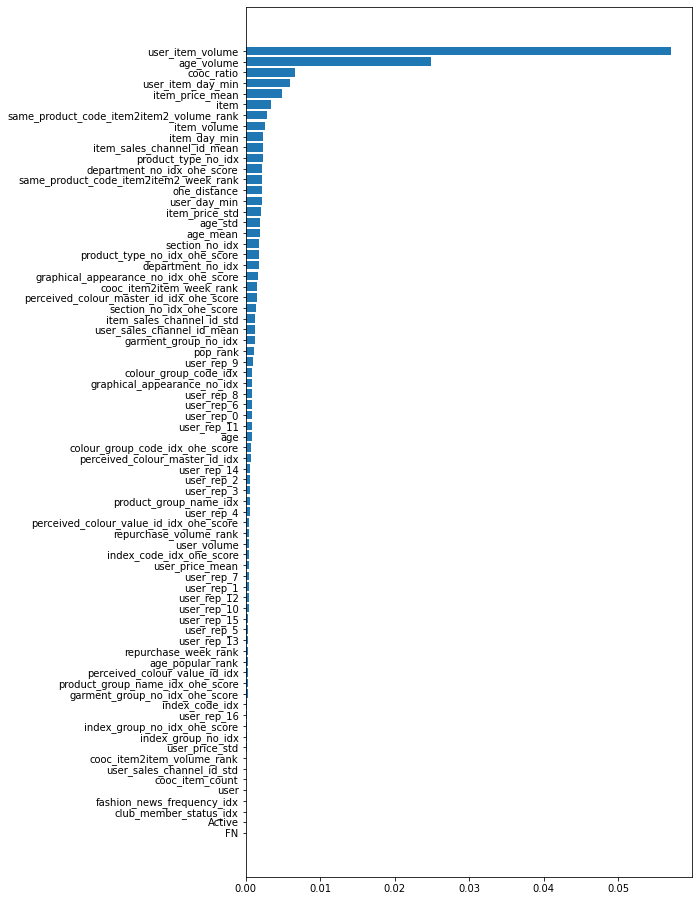

In [21]:
if CFG.model_type == 'LightGBM':
    group_train = get_query_group(train)
    train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)

    best_iteration = model.best_iteration
    model = lgb.train(params, train_dataset, num_boost_round=best_iteration)

    lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

elif CFG.model_type == 'CatBoost':
    train_dataset = catboost.Pool(data=train[feature_columns], label=train['y'], group_id=train['query_group'], cat_features=cat_features)

    params['iterations'] = model.get_best_iteration()
    params['use_best_model'] = False
    model = catboost.CatBoost(params)
    model.fit(train_dataset)

    feature_importance = model.get_feature_importance(train_dataset)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

del train, train_dataset
gc.collect()
with open('output/model_for_submission.pkl', 'wb') as f:
    pickle.dump(model, f)

In [22]:
del datasets, dataset_valid_all, candidates, candidates_valid_all
gc.collect()

12202

In [23]:
all_users = users['user'].values
all_users

array([      0,       1,       2, ..., 1371977, 1371978, 1371979])

In [24]:
# to avoid OOM
preds = []

n_split_prediction = 10
n_chunk = (len(all_users) + n_split_prediction - 1)// n_split_prediction
for i in range(0, len(all_users), n_chunk):
    print(f"chunk: {i}")
    target_users = all_users[i:i+n_chunk]

    candidates = create_candidates(transactions, target_users, 0)
    candidates = attach_features(transactions, users, items, candidates, 0, CFG.train_weeks)

    candidates['pred'] = model.predict(candidates[feature_columns])
    pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
    preds.append(pred)

pred = pd.concat(preds).reset_index(drop=True)
assert len(pred) == len(all_users)
assert np.array_equal(pred['user'].values, all_users)

chunk: 0
create candidates (week: 0)


[repurchase] 5.674 s


[popular] 1.557 s


[age popular] 0.702 s


[item2item] 5.356 s


[item2item2] 5.240 s


[cooccurrence] 58.394 s


[same_product_code] 4.795 s


[ohe distance] 13.404 s


volume: 27039885


duplicates: 1.1031831047768113


            strategy   volume     ratio
0                pop  8231880  0.304435
1  same_product_code  6635618  0.245401
2       ohe_distance  6412711  0.237157
3         repurchase  2735882  0.101179
4            age_pop  1626996  0.060170
5               cooc  1396798  0.051657


attach features (week: 0)


[user static fetaures] 2.305 s


[item stacic features] 7.287 s


[user dynamic features (transactions)] 6.516 s


[item dynamic features (transactions)] 3.875 s


[item dynamic features (user features)] 6.799 s


[item freshness features] 5.898 s


[item volume features] 4.417 s


[user freshness features] 8.005 s


[user volume features] 6.152 s


[user-item freshness features] 26.533 s


[user-item volume features] 11.967 s


[item age volume features] 7.328 s


[ohe dot products] 135.310 s


[lfm features] 8.863 s


chunk: 137198
create candidates (week: 0)


[repurchase] 5.598 s


[popular] 1.612 s


[age popular] 0.725 s


[item2item] 5.498 s


[item2item2] 5.395 s


[cooccurrence] 58.965 s


[same_product_code] 4.922 s


[ohe distance] 10.890 s


volume: 27069354


duplicates: 1.1030125429821485


            strategy   volume     ratio
0                pop  8231880  0.304103
1  same_product_code  6653380  0.245790
2       ohe_distance  6409891  0.236795
3         repurchase  2752227  0.101673
4            age_pop  1627296  0.060116
5               cooc  1394680  0.051522


attach features (week: 0)


[user static fetaures] 2.230 s


[item stacic features] 7.211 s


[user dynamic features (transactions)] 6.487 s


[item dynamic features (transactions)] 3.831 s


[item dynamic features (user features)] 6.775 s


[item freshness features] 5.760 s


[item volume features] 4.399 s


[user freshness features] 7.947 s


[user volume features] 6.156 s


[user-item freshness features] 26.383 s


[user-item volume features] 12.031 s


[item age volume features] 7.278 s


[ohe dot products] 133.390 s


[lfm features] 8.534 s


chunk: 274396
create candidates (week: 0)


[repurchase] 5.517 s


[popular] 1.583 s


[age popular] 0.726 s


[item2item] 5.294 s


[item2item2] 5.244 s


[cooccurrence] 58.468 s


[same_product_code] 4.822 s


[ohe distance] 10.776 s


volume: 26999342


duplicates: 1.103228861824164


            strategy   volume     ratio
0                pop  8231880  0.304892
1  same_product_code  6634369  0.245723
2       ohe_distance  6412683  0.237513
3         repurchase  2708651  0.100323
4            age_pop  1626840  0.060255
5               cooc  1384919  0.051295


attach features (week: 0)


[user static fetaures] 2.159 s


[item stacic features] 7.013 s


[user dynamic features (transactions)] 6.395 s


[item dynamic features (transactions)] 3.767 s


[item dynamic features (user features)] 6.702 s


[item freshness features] 5.639 s


[item volume features] 4.280 s


[user freshness features] 7.802 s


[user volume features] 5.995 s


[user-item freshness features] 26.276 s


[user-item volume features] 12.141 s


[item age volume features] 7.347 s


[ohe dot products] 131.571 s


[lfm features] 8.591 s


chunk: 411594
create candidates (week: 0)


[repurchase] 5.560 s


[popular] 1.641 s


[age popular] 0.735 s


[item2item] 5.499 s


[item2item2] 5.354 s


[cooccurrence] 59.448 s


[same_product_code] 4.917 s


[ohe distance] 10.808 s


volume: 27050229


duplicates: 1.103213497084992


            strategy   volume     ratio
0                pop  8231880  0.304318
1  same_product_code  6636093  0.245325
2       ohe_distance  6411150  0.237009
3         repurchase  2737078  0.101185
4            age_pop  1628148  0.060190
5               cooc  1405880  0.051973


attach features (week: 0)


[user static fetaures] 2.237 s


[item stacic features] 7.142 s


[user dynamic features (transactions)] 6.444 s


[item dynamic features (transactions)] 3.837 s


[item dynamic features (user features)] 6.747 s


[item freshness features] 5.764 s


[item volume features] 4.369 s


[user freshness features] 7.936 s


[user volume features] 6.102 s


[user-item freshness features] 26.504 s


[user-item volume features] 11.959 s


[item age volume features] 7.081 s


[ohe dot products] 131.656 s


[lfm features] 8.759 s


chunk: 548792
create candidates (week: 0)


[repurchase] 5.592 s


[popular] 1.681 s


[age popular] 0.730 s


[item2item] 5.336 s


[item2item2] 5.285 s


[cooccurrence] 58.368 s


[same_product_code] 4.956 s


[ohe distance] 10.807 s


volume: 27038752


duplicates: 1.1031812130992007


            strategy   volume     ratio
0                pop  8231880  0.304447
1  same_product_code  6630508  0.245222
2       ohe_distance  6413390  0.237193
3         repurchase  2739307  0.101310
4            age_pop  1627584  0.060194
5               cooc  1396083  0.051633


attach features (week: 0)


[user static fetaures] 2.165 s


[item stacic features] 6.898 s


[user dynamic features (transactions)] 6.244 s


[item dynamic features (transactions)] 3.723 s


[item dynamic features (user features)] 6.695 s


[item freshness features] 5.624 s


[item volume features] 4.283 s


[user freshness features] 7.678 s


[user volume features] 6.004 s


[user-item freshness features] 26.405 s


[user-item volume features] 12.128 s


[item age volume features] 7.369 s


[ohe dot products] 135.458 s


[lfm features] 8.739 s


chunk: 685990
create candidates (week: 0)


[repurchase] 5.613 s


[popular] 1.680 s


[age popular] 0.736 s


[item2item] 5.533 s


[item2item2] 5.380 s


[cooccurrence] 59.466 s


[same_product_code] 5.050 s


[ohe distance] 11.063 s


volume: 27077191


duplicates: 1.10327308014338


            strategy   volume     ratio
0                pop  8231880  0.304015
1  same_product_code  6653866  0.245737
2       ohe_distance  6408989  0.236693
3         repurchase  2745003  0.101377
4            age_pop  1627032  0.060089
5               cooc  1410421  0.052089


attach features (week: 0)


[user static fetaures] 2.242 s


[item stacic features] 7.288 s


[user dynamic features (transactions)] 6.494 s


[item dynamic features (transactions)] 3.852 s


[item dynamic features (user features)] 6.826 s


[item freshness features] 5.784 s


[item volume features] 4.393 s


[user freshness features] 7.950 s


[user volume features] 6.112 s


[user-item freshness features] 26.197 s


[user-item volume features] 11.790 s


[item age volume features] 7.244 s


[ohe dot products] 135.126 s


[lfm features] 8.587 s


chunk: 823188
create candidates (week: 0)


[repurchase] 5.451 s


[popular] 1.602 s


[age popular] 0.723 s


[item2item] 5.306 s


[item2item2] 5.140 s


[cooccurrence] 58.248 s


[same_product_code] 4.961 s


[ohe distance] 10.990 s


volume: 27014107


duplicates: 1.1034181441923343


            strategy   volume     ratio
0                pop  8231880  0.304725
1  same_product_code  6623896  0.245201
2       ohe_distance  6411560  0.237341
3         repurchase  2714357  0.100479
4            age_pop  1626984  0.060227
5               cooc  1405430  0.052026


attach features (week: 0)


[user static fetaures] 2.249 s


[item stacic features] 7.206 s


[user dynamic features (transactions)] 6.454 s


[item dynamic features (transactions)] 3.796 s


[item dynamic features (user features)] 6.606 s


[item freshness features] 5.775 s


[item volume features] 4.283 s


[user freshness features] 7.875 s


[user volume features] 6.058 s


[user-item freshness features] 26.243 s


[user-item volume features] 12.119 s


[item age volume features] 7.110 s


[ohe dot products] 132.294 s


[lfm features] 8.604 s


chunk: 960386
create candidates (week: 0)


[repurchase] 5.420 s


[popular] 1.576 s


[age popular] 0.708 s


[item2item] 5.366 s


[item2item2] 5.282 s


[cooccurrence] 58.387 s


[same_product_code] 4.995 s


[ohe distance] 10.807 s


volume: 27029146


duplicates: 1.1035451169872357


            strategy   volume     ratio
0                pop  8231880  0.304556
1  same_product_code  6618201  0.244854
2       ohe_distance  6411573  0.237210
3         repurchase  2731902  0.101072
4            age_pop  1628148  0.060237
5               cooc  1407442  0.052071


attach features (week: 0)


[user static fetaures] 2.191 s


[item stacic features] 6.992 s


[user dynamic features (transactions)] 6.376 s


[item dynamic features (transactions)] 3.754 s


[item dynamic features (user features)] 6.716 s


[item freshness features] 5.689 s


[item volume features] 4.299 s


[user freshness features] 7.801 s


[user volume features] 6.000 s


[user-item freshness features] 26.302 s


[user-item volume features] 11.891 s


[item age volume features] 7.136 s


[ohe dot products] 131.138 s


[lfm features] 8.516 s


chunk: 1097584
create candidates (week: 0)


[repurchase] 5.363 s


[popular] 1.545 s


[age popular] 0.728 s


[item2item] 5.148 s


[item2item2] 5.076 s


[cooccurrence] 58.173 s


[same_product_code] 4.783 s


[ohe distance] 10.718 s


volume: 26964222


duplicates: 1.1032502653768843


            strategy   volume     ratio
0                pop  8231880  0.305289
1  same_product_code  6593059  0.244511
2       ohe_distance  6408148  0.237654
3         repurchase  2711285  0.100551
4            age_pop  1627380  0.060353
5               cooc  1392470  0.051641


attach features (week: 0)


[user static fetaures] 2.177 s


[item stacic features] 6.932 s


[user dynamic features (transactions)] 6.336 s


[item dynamic features (transactions)] 3.762 s


[item dynamic features (user features)] 6.681 s


[item freshness features] 5.648 s


[item volume features] 4.295 s


[user freshness features] 7.802 s


[user volume features] 6.050 s


[user-item freshness features] 26.164 s


[user-item volume features] 11.803 s


[item age volume features] 7.046 s


[ohe dot products] 130.263 s


[lfm features] 8.574 s


chunk: 1234782
create candidates (week: 0)


[repurchase] 5.394 s


[popular] 1.704 s


[age popular] 0.708 s


[item2item] 5.324 s


[item2item2] 5.267 s


[cooccurrence] 58.428 s


[same_product_code] 5.053 s


[ohe distance] 10.722 s


volume: 27038251


duplicates: 1.103235492239089


            strategy   volume     ratio
0                pop  8231880  0.304453
1  same_product_code  6638864  0.245536
2       ohe_distance  6411401  0.237123
3         repurchase  2730747  0.100996
4            age_pop  1627020  0.060175
5               cooc  1398339  0.051717


attach features (week: 0)


[user static fetaures] 2.165 s


[item stacic features] 6.985 s


[user dynamic features (transactions)] 6.301 s


[item dynamic features (transactions)] 3.756 s


[item dynamic features (user features)] 6.676 s


[item freshness features] 5.670 s


[item volume features] 4.300 s


[user freshness features] 7.764 s


[user volume features] 5.966 s


[user-item freshness features] 26.587 s


[user-item volume features] 12.086 s


[item age volume features] 7.088 s


[ohe dot products] 131.814 s


[lfm features] 8.439 s


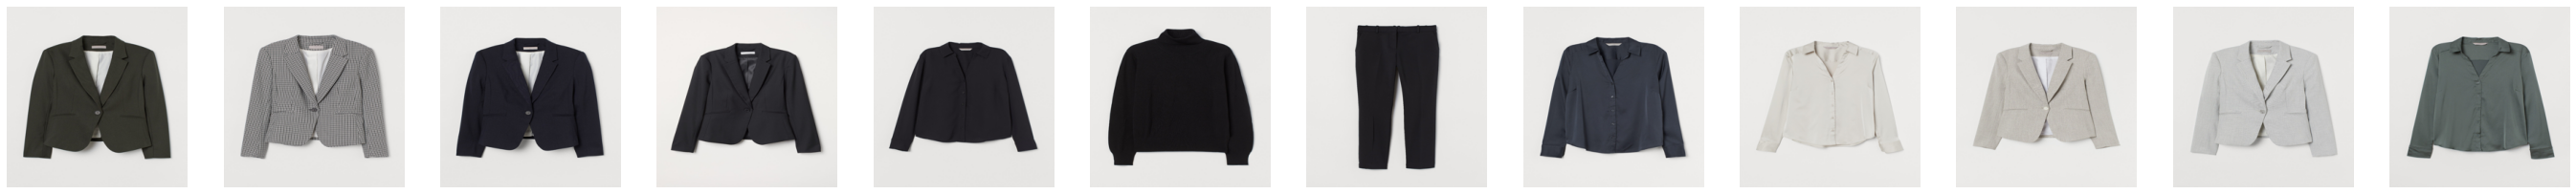

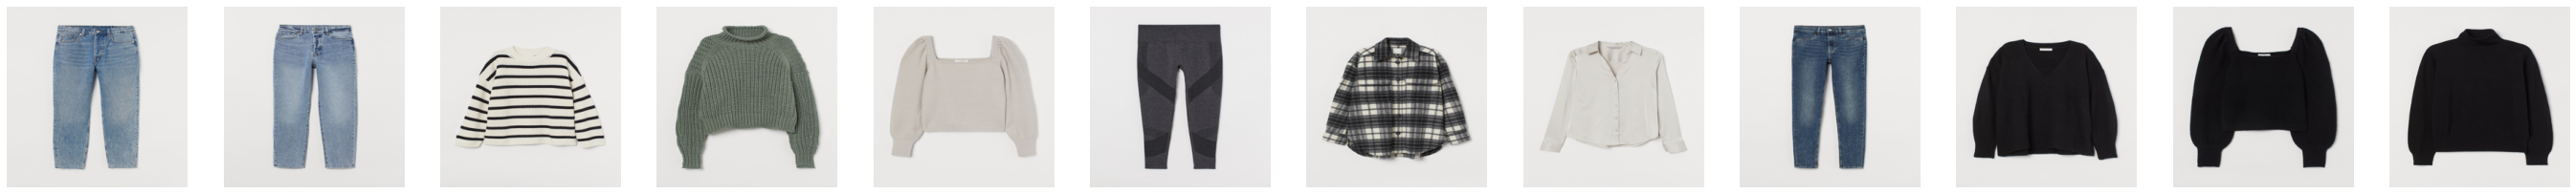

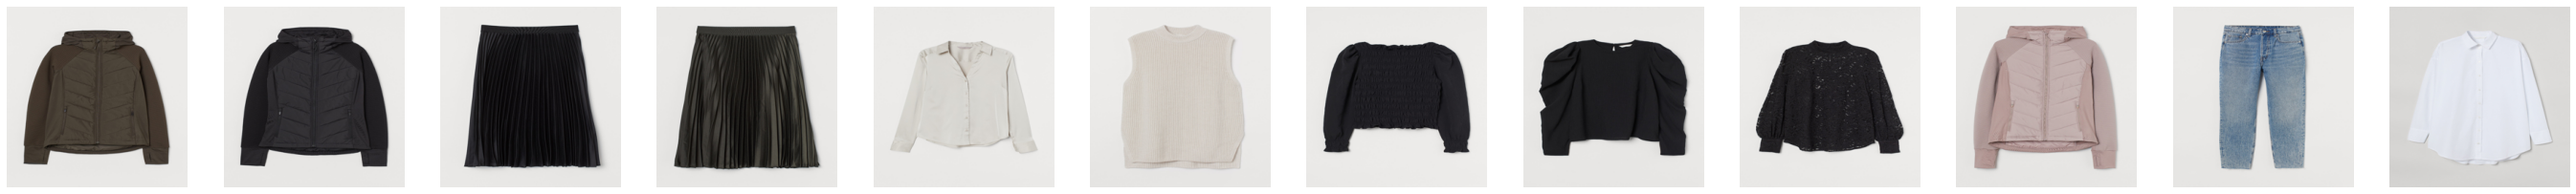

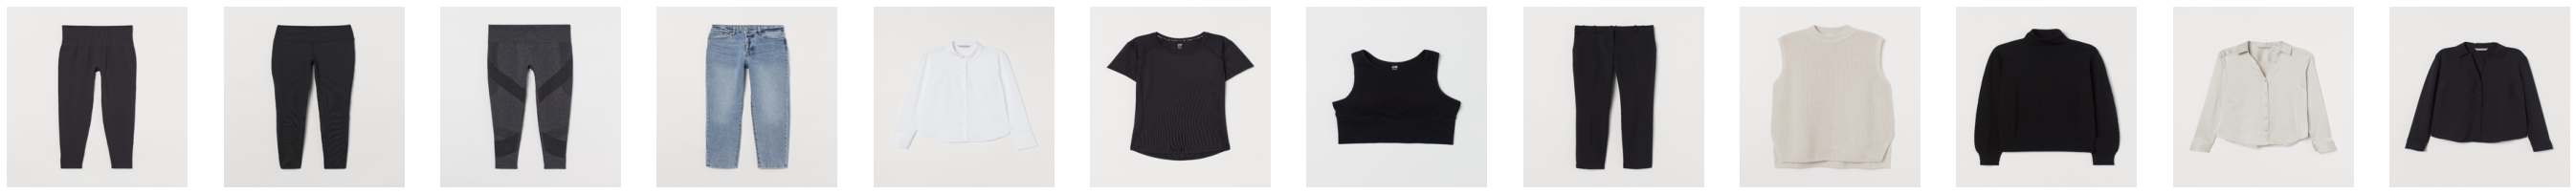

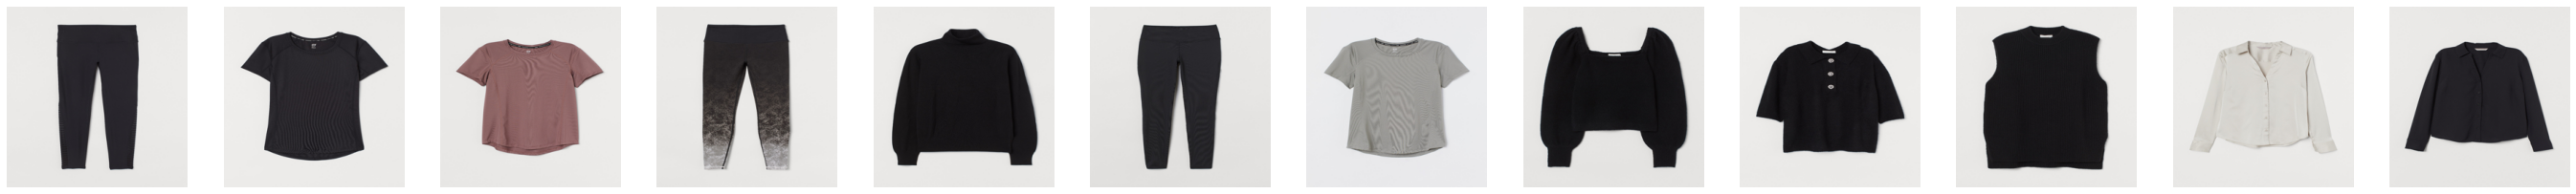

In [25]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [26]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

a_user = mp_user['val'].values
a_item = mp_item['val'].values

pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0568601043 0568601044 0568601007 0568601006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0448509014 0714790020 0863583001 0873279005 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0794321011 0851400001 0851400020 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0866731001 0852584001 0918292001 0714790020 08...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0730683050 0791587001 0791587021 0730683062 06...
...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0557599022 0791587001 0791587015 0804992014 09...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0762846027 0762846031 0762846029 0762846006 04...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0762846027 0762846006 0762846031 0762846026 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0714790020 0448509014 0706016002 0715624001 07...


In [27]:
submission.to_csv('submission.csv', index=False)